In [8]:
%%capture
!apt-get install cmake
!apt-get install zlib1g-dev
!pip install gym[atari]
!pip install JSAnimation

  Using cached atari-py-0.1.1.tar.gz
  Using cached Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Running setup.py bdist_wheel for atari-py ... done
  Stored in directory: /root/.cache/pip/wheels/9d/9a/35/e8c7372d2677e509571935b94142c1876ab6319e8cd12789e5
Successfully built atari-py
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import gym

import tensorflow as tf

from utilities import *

%matplotlib inline

/root/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
env = gym.make("Pong-v0")

In [11]:
env.env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [12]:
action_space = [0,2,3] #[No-op, up, down]

In [13]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))


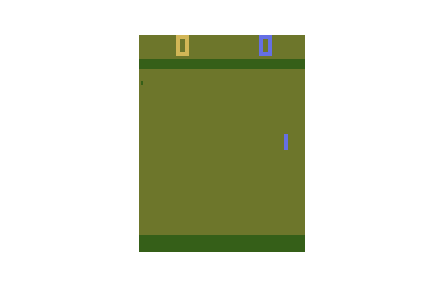
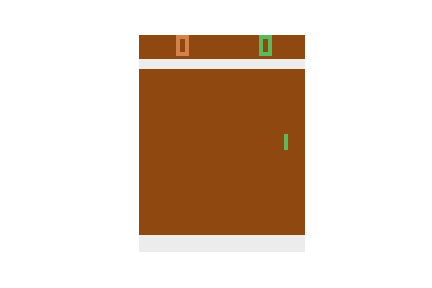
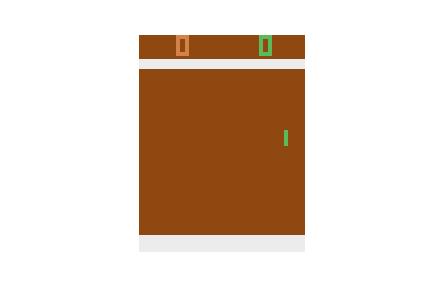
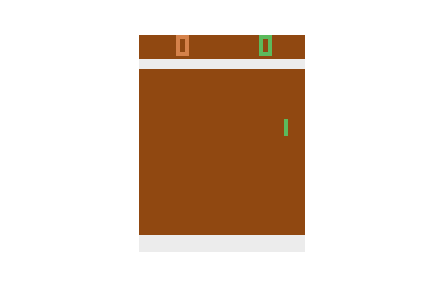
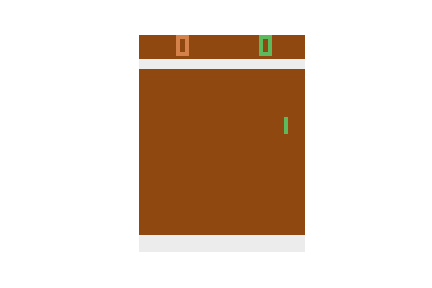
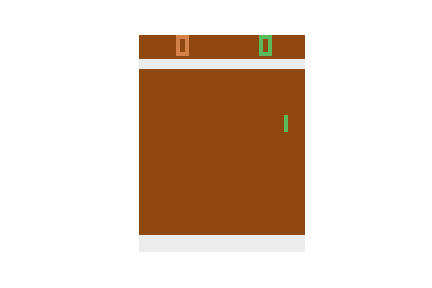
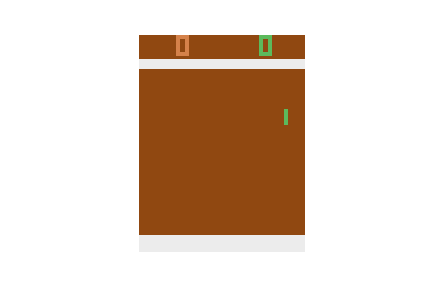
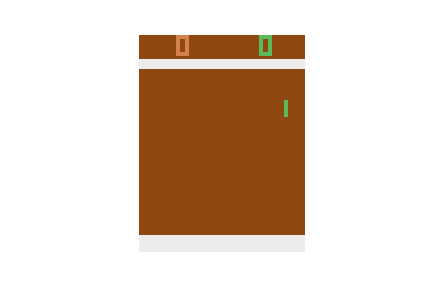
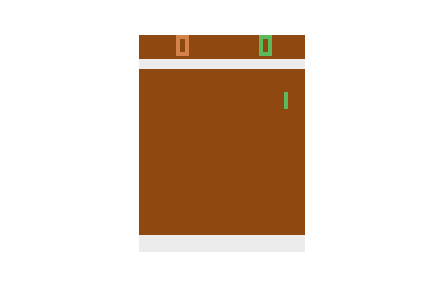
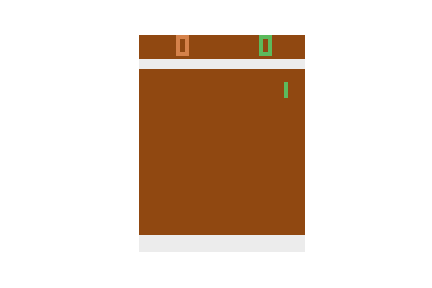
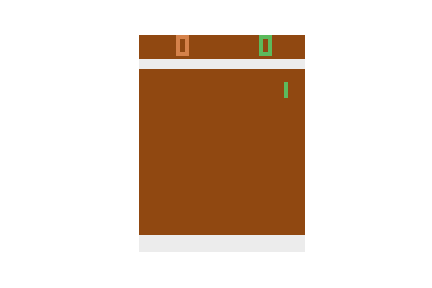
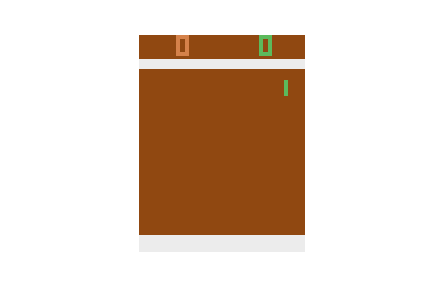
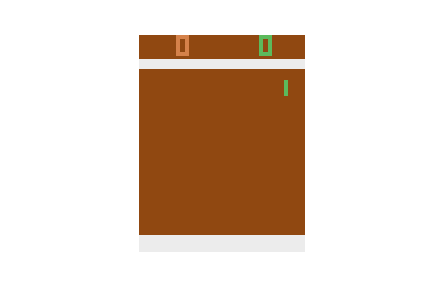
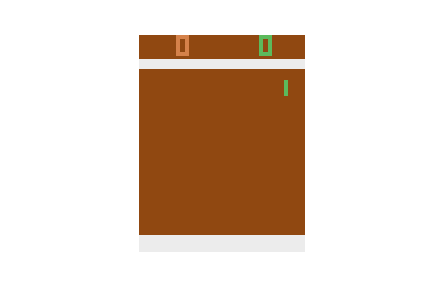
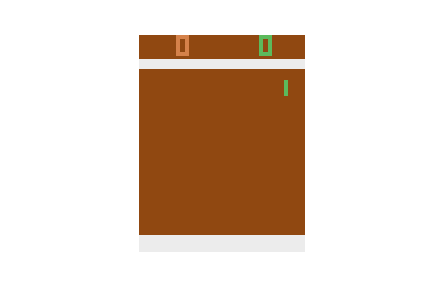
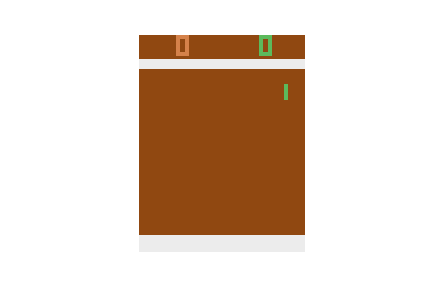
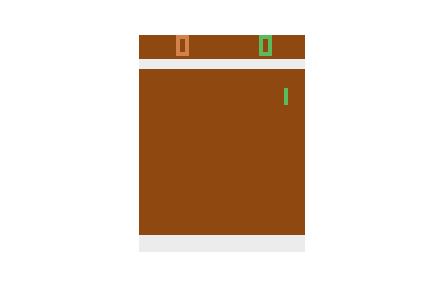
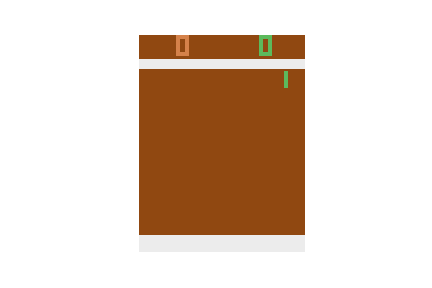
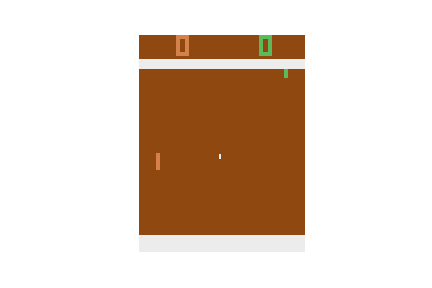
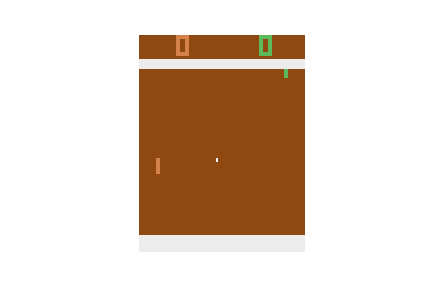
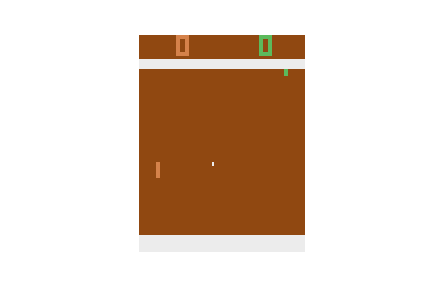
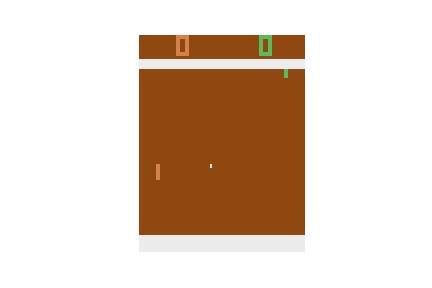
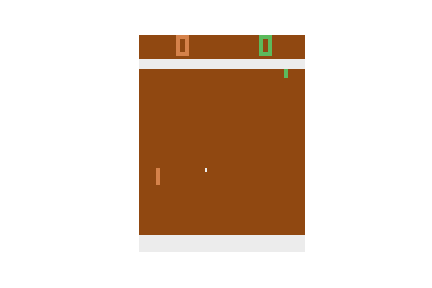
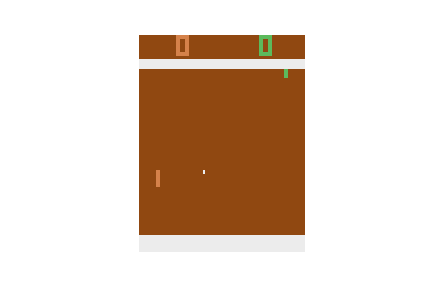
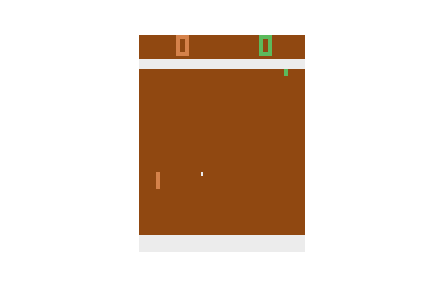
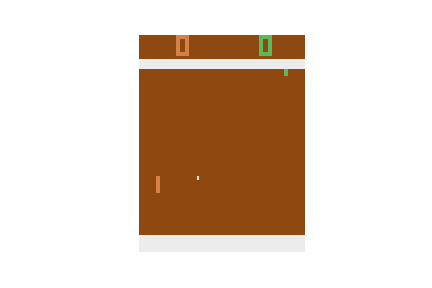
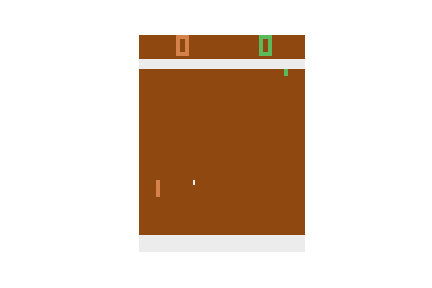
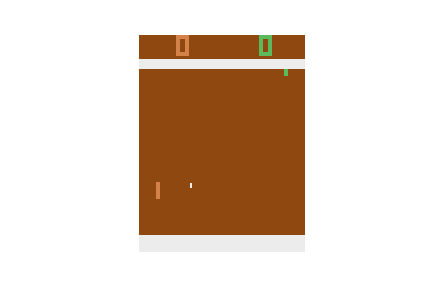
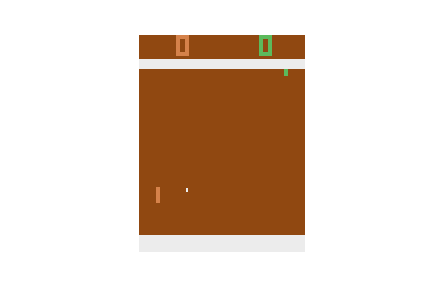
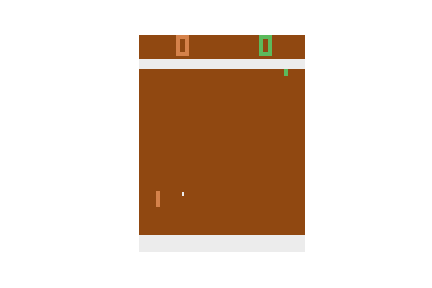
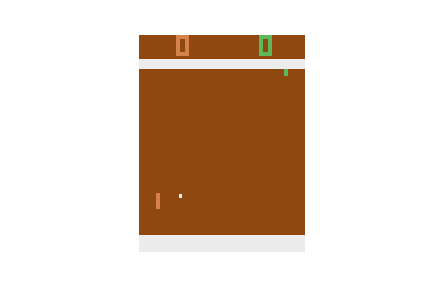
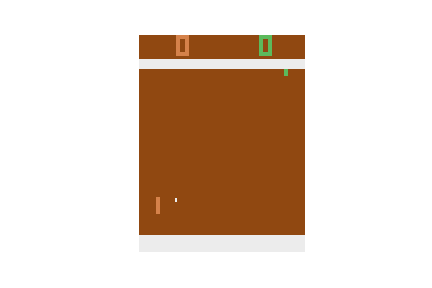
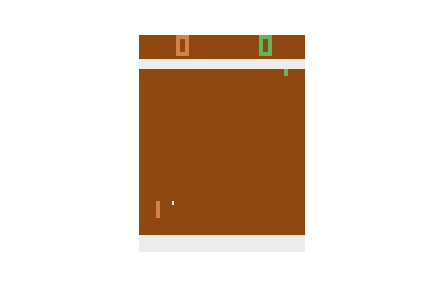
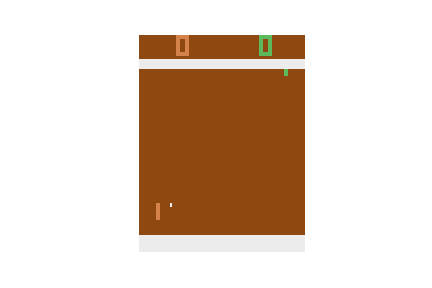
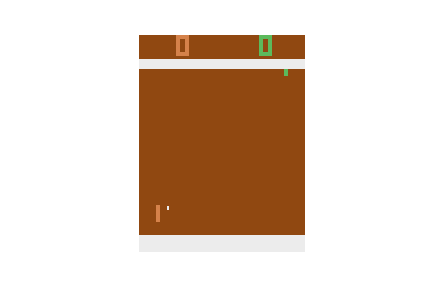
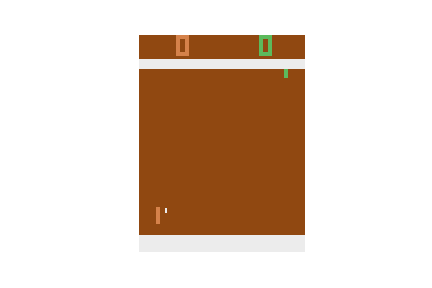
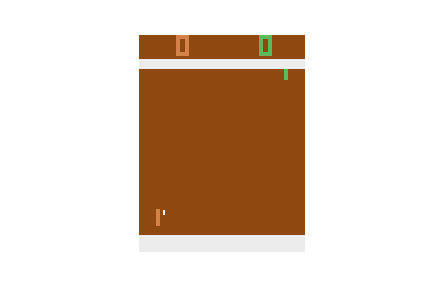
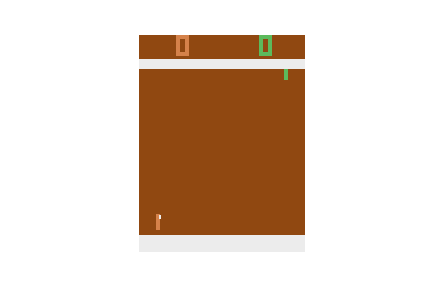
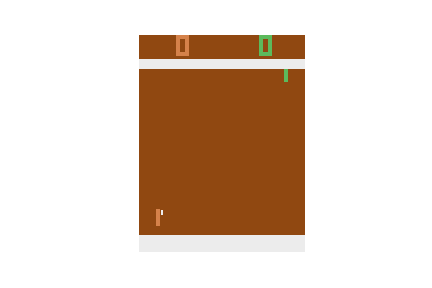
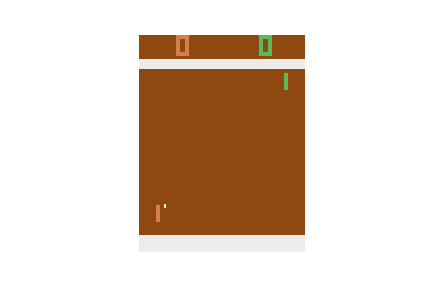
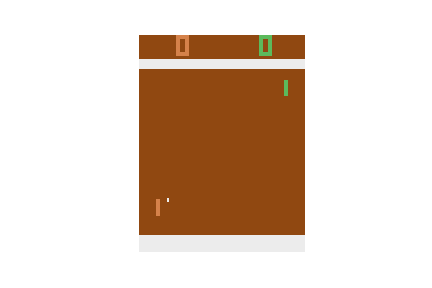
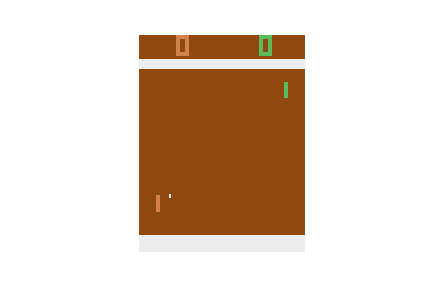
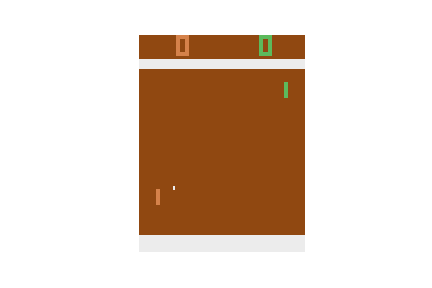
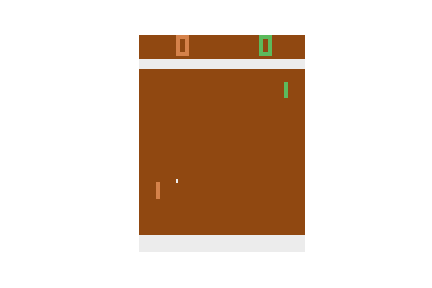
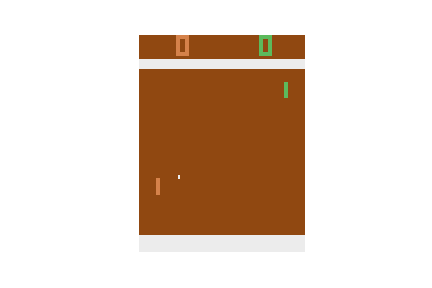
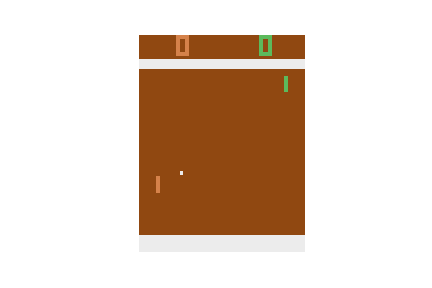
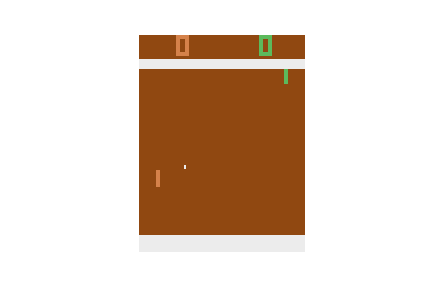
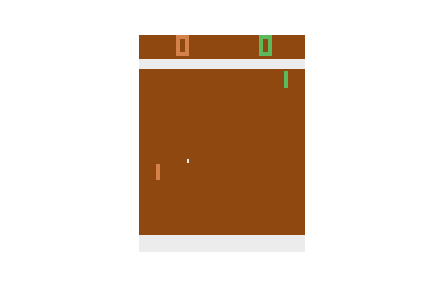
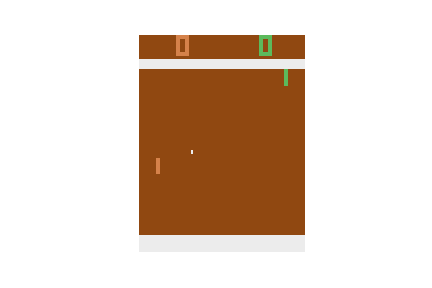
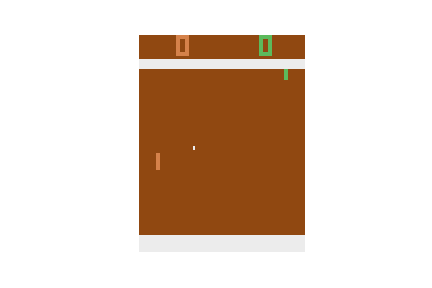
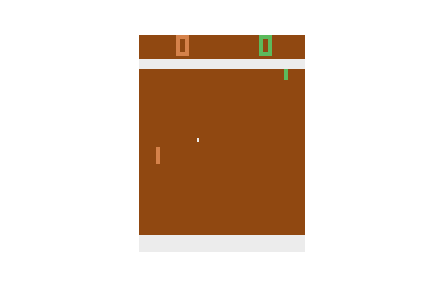
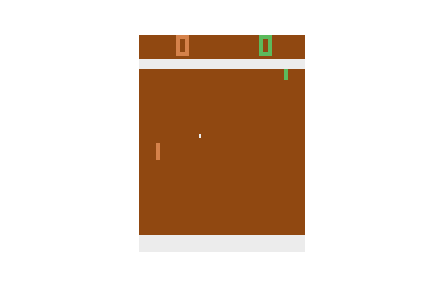
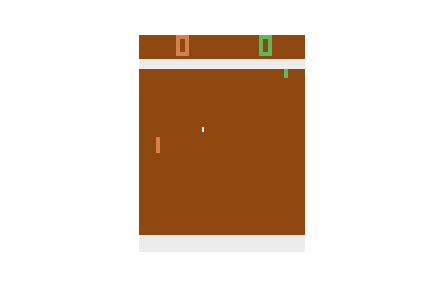
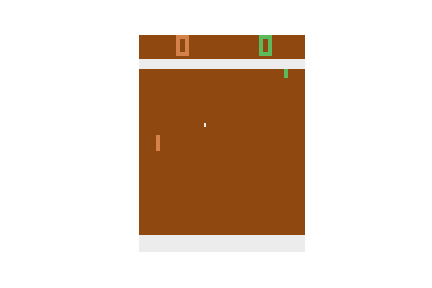
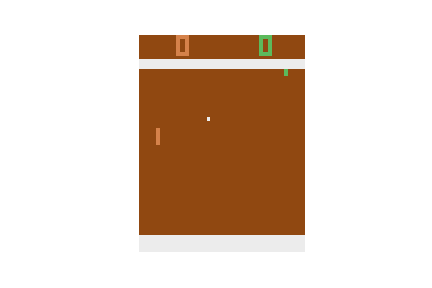
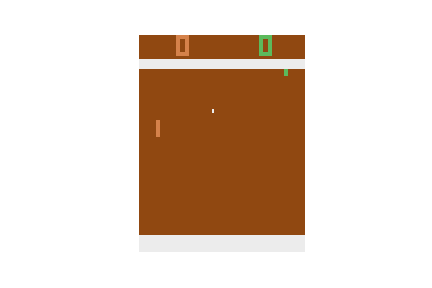
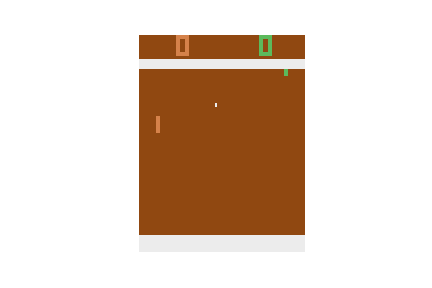
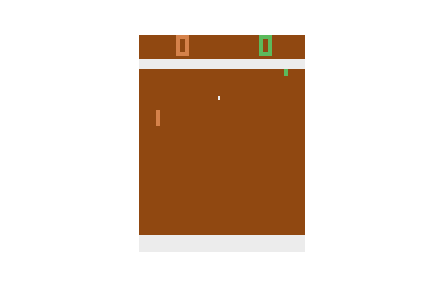
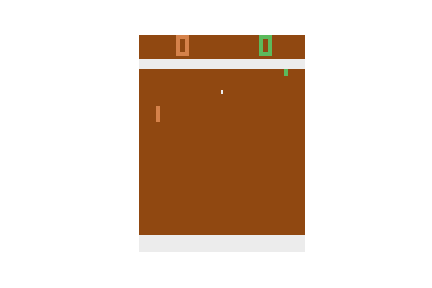
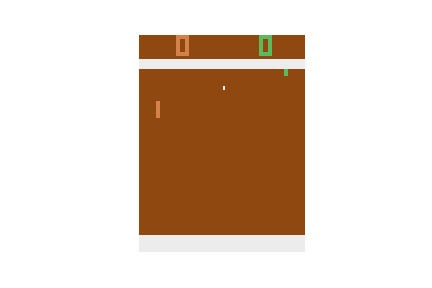
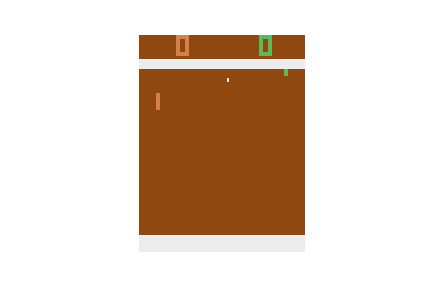
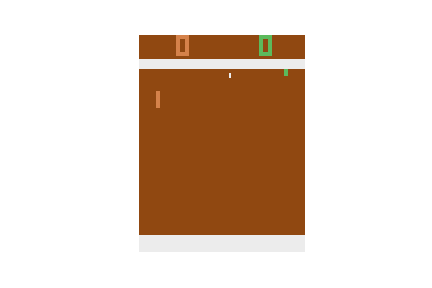
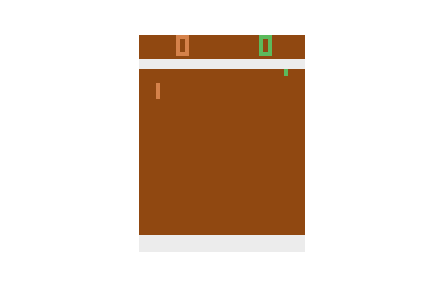
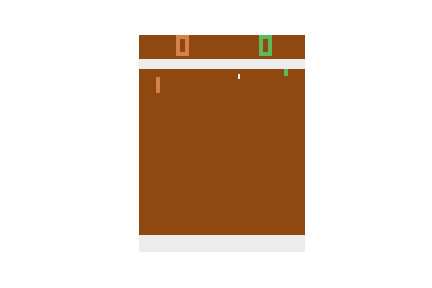
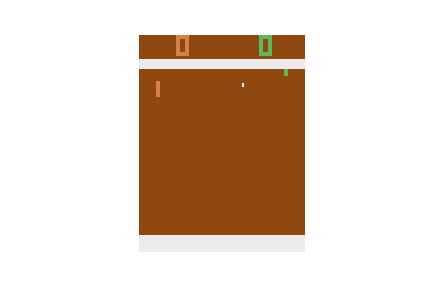
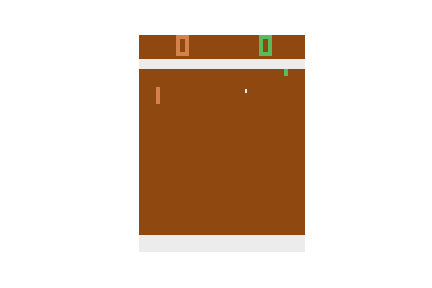
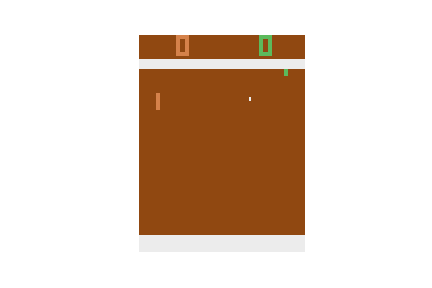
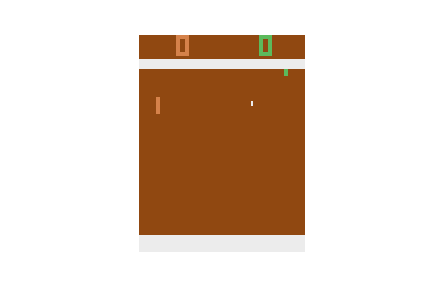
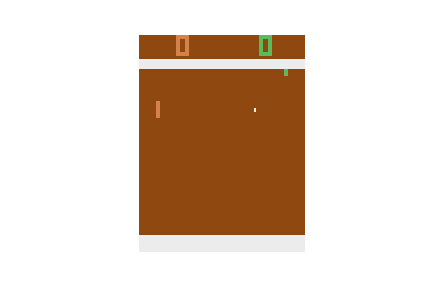
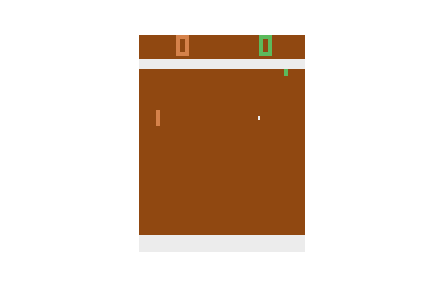
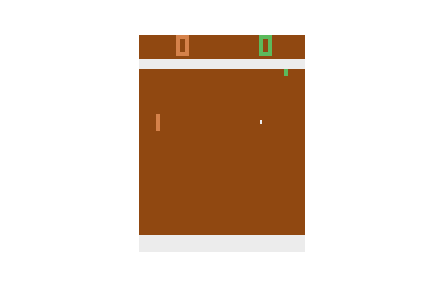
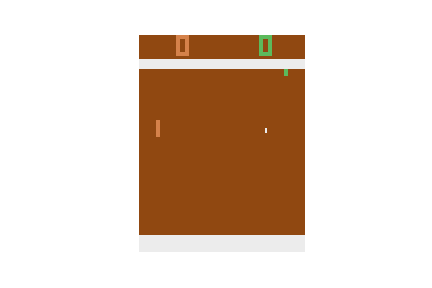
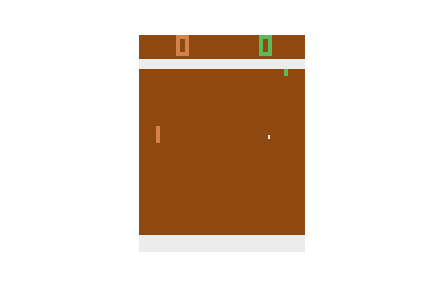
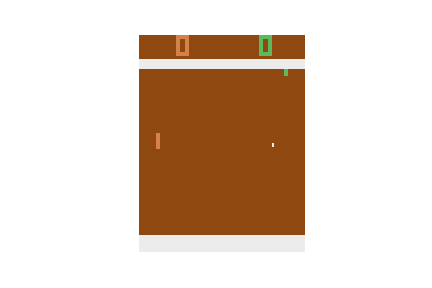
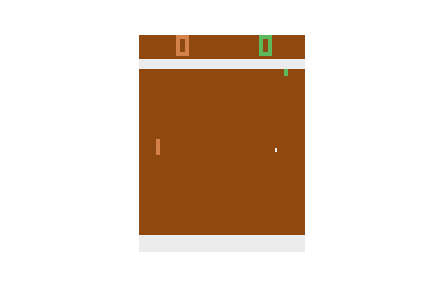
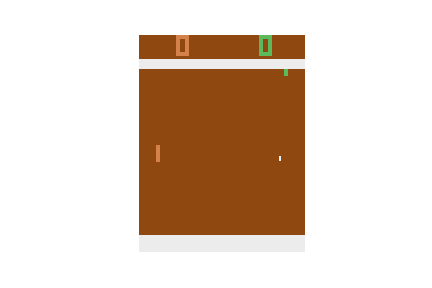
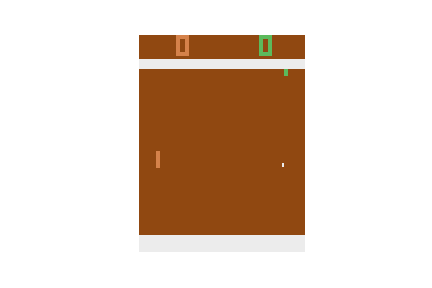
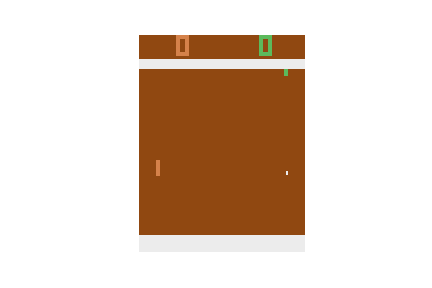
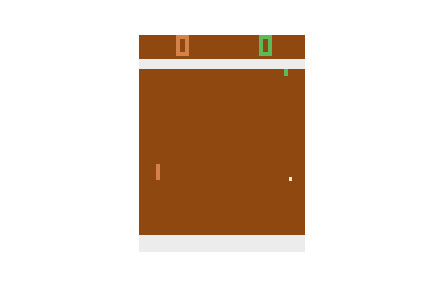
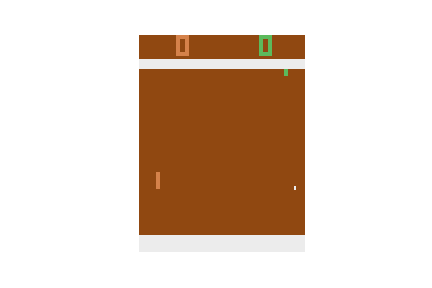
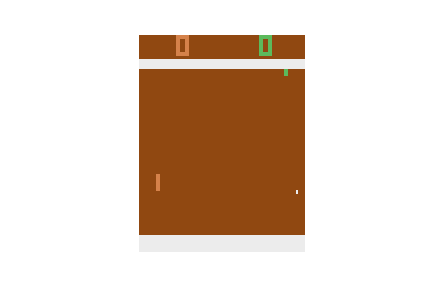
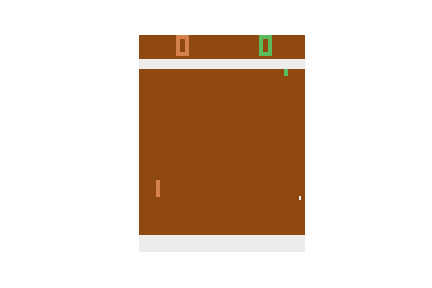
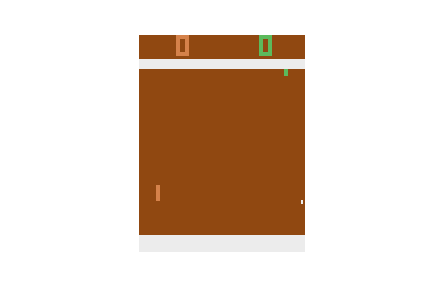
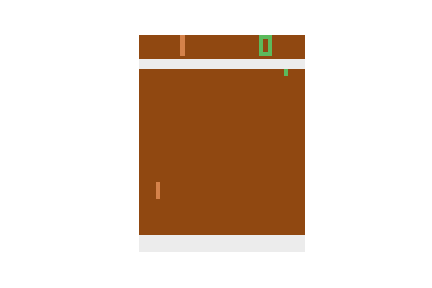
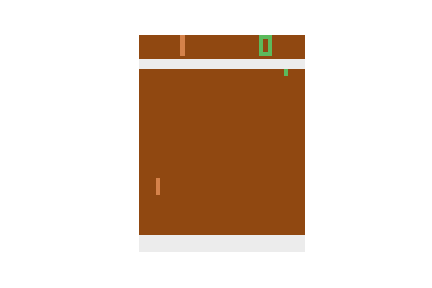
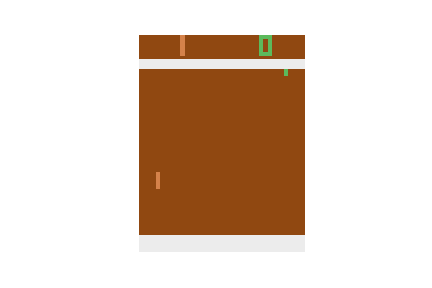
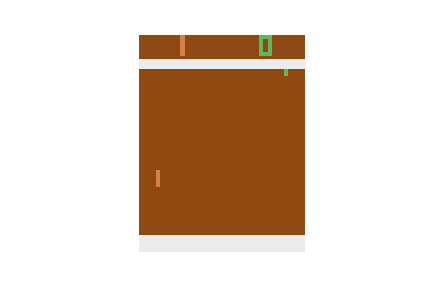
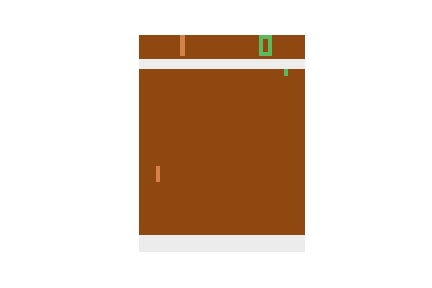
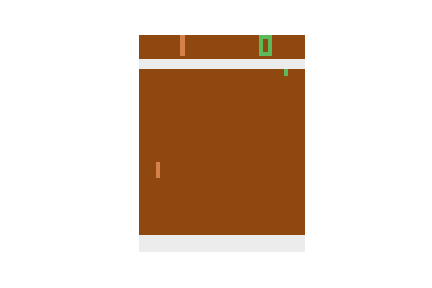
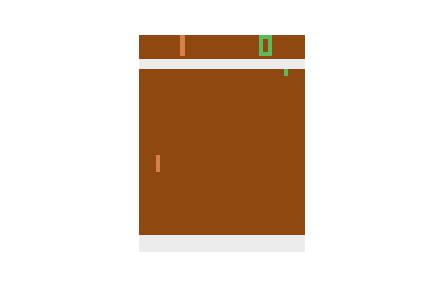
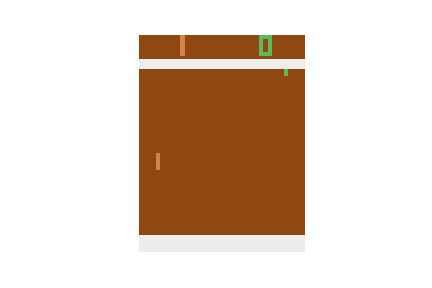
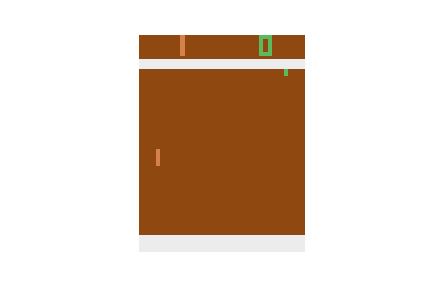
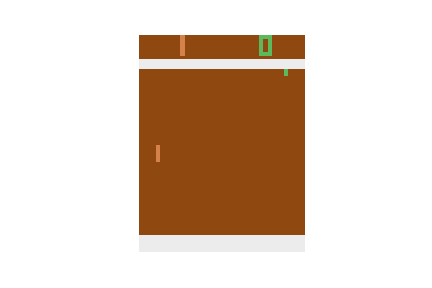
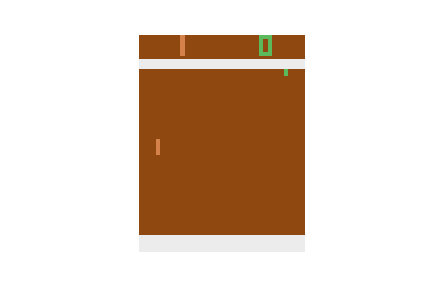
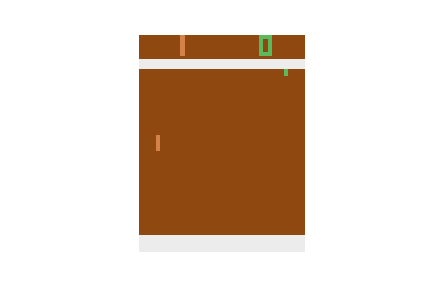
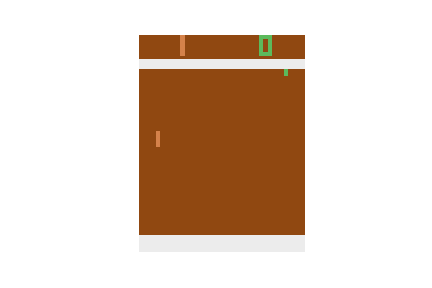
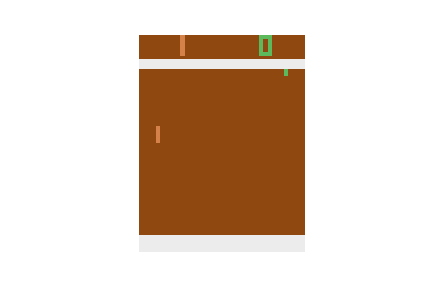
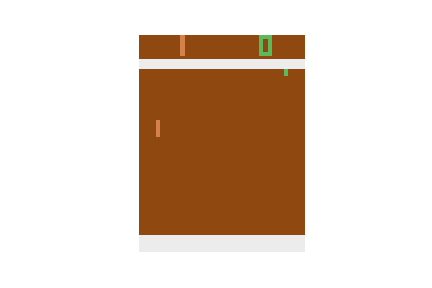
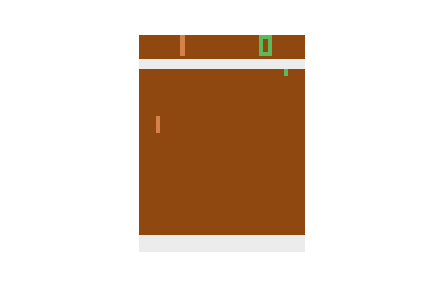
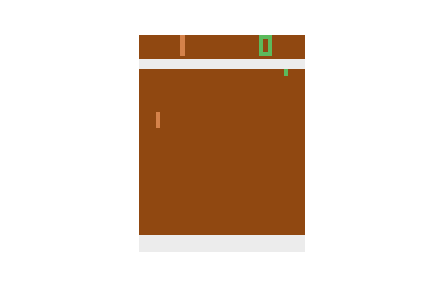

99


In [14]:
observation = env.reset()
cum_reward = 0
frames = []
r = []
for t in range(100):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    p = [0.5, 0.3, 0.2]
    a = np.random.choice(3, p=p)
    action = action_space[a]
    observation, reward, done, info = env.step(action)
    r.append(reward)
    if done:
        break
        
r = np.array(r)
display_frames_as_gif(frames)
print(t)

In [7]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

## Preprocess image

In [8]:
def preprocess(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

## Reinforcement Learning

It turns out that action 2 makes the racket go up and 3 makes the racket go down. It has 6 actions by default because it's an Atari game, and there were 6 buttons in the controller. See [here](https://ai.stackexchange.com/questions/2449/what-are-different-actions-in-action-space-of-environment-of-pong-v0-game-from) for source of this answer.

In [9]:
def policy_loss(adv_y_true, y_pred):
    reward = adv_y_true[:,0]
    y_true = adv_y_true[:,1:]
    return K.mean(reward*
                  K.sparse_categorical_crossentropy(y_true, y_pred), 
                  axis=-1)

In [114]:
class Model():
    def __init__(self):
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()

        self.image = tf.placeholder(tf.float32, (None, 80, 80, 1), name='image')
        self.move = tf.placeholder(tf.int32, (None), name='move')
        self.reward = tf.placeholder(tf.float32, (None), name='reward')

        depths = [4, 8, 12, 16]

        for i, depth in enumerate(depths):
            with tf.name_scope('conv_block_{}'.format(i)):
                if i==0:
                    h = self.image
                h = tf.contrib.layers.conv2d(h, depth, kernel_size=(3,3), padding='same', activation_fn=tf.nn.relu)
                h = tf.contrib.layers.max_pool2d(h, kernel_size=(2,2))

        h = tf.contrib.layers.flatten(h)
        logits = tf.contrib.layers.fully_connected(h, 3, activation_fn=None)
        self.prob = tf.nn.softmax(logits)

        with tf.name_scope('optimization'):
            move_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.move, logits=logits, 
                                                                       name='move_loss')
            self.loss = tf.reduce_mean(self.reward*move_loss, axis=0, name='loss')
            self.optimizer = tf.train.RMSPropOptimizer(1e-3).minimize(self.loss)
            
        self.sess.run(tf.global_variables_initializer())
            
    def plot(self):
        show_graph(self.sess.graph)
    
    def predict(self, x):
        return self.sess.run(self.prob, feed_dict={self.image: x})
    
    def fit(self, x, y, reward, batch_size=512):
        idx = np.random.permutation(len(x))
        x = x[idx]; y = y[idx]; reward=reward[idx] #shuffle data
        start = 0
        while start < len(x):
            stop = min(start + batch_size, len(x))
            feed_data = {self.image: x[start:stop], self.move: y[start:stop], self.reward: reward[start:stop]}
            l, _ = self.sess.run([self.loss, self.optimizer], feed_dict=feed_data)
            start += batch_size
            
    def evaluate(self, x, y, reward):
        feed_data = {self.image: x, self.move: y, self.reward: reward}
        l = self.sess.run(self.loss, feed_dict=feed_data)
        return l
        

In [115]:
model = Model()
model.plot()

In [116]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
prev_x = None
im_shape = (80, 80, 1)

prev_frame = None
buffer = 30000
xs = np.zeros((buffer,)+im_shape)
ys = np.zeros(buffer)
rs = np.zeros(buffer)


k = 0

observation = env.reset()

while episodes<n_episodes:
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(3, p=p[0])
    action = action_space[a]
    ys[k] = a
    
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    rs[k] = reward
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        
        ep_r = discount_n_standardise(ep_r)
        model.fit(ep_x, ep_y, ep_r, batch_size=512)
        
        time_taken[episodes] = k
        k = 0
        prev_frame = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, ep_y, ep_r)
        episodes += 1
        
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))

Episode: 50, Average Loss: -0.0004, Average Reward: -20.5600, Average steps: 1258.2000
Episode: 100, Average Loss: -0.0019, Average Reward: -20.5400, Average steps: 1306.7500
Episode: 150, Average Loss: -0.0028, Average Reward: -20.4133, Average steps: 1362.2867
Episode: 200, Average Loss: -0.0035, Average Reward: -20.2800, Average steps: 1416.5450
Episode: 250, Average Loss: -0.0063, Average Reward: -20.1500, Average steps: 1502.1700
Episode: 300, Average Loss: -0.0089, Average Reward: -19.9400, Average steps: 1577.7850
Episode: 350, Average Loss: -0.0122, Average Reward: -19.8300, Average steps: 1667.0400
Episode: 400, Average Loss: -0.0151, Average Reward: -19.5650, Average steps: 1754.9050
Episode: 450, Average Loss: -0.0171, Average Reward: -19.0400, Average steps: 2024.7700
Episode: 500, Average Loss: -0.0222, Average Reward: -18.9650, Average steps: 2170.5600
Episode: 550, Average Loss: -0.0169, Average Reward: -19.2750, Average steps: 2039.5750
Episode: 600, Average Loss: -0.01

IndexError: index 1000 is out of bounds for axis 0 with size 1000

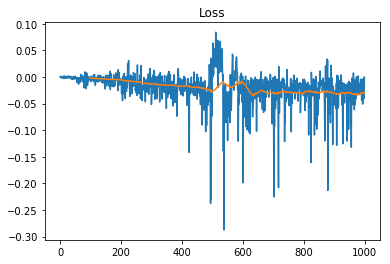

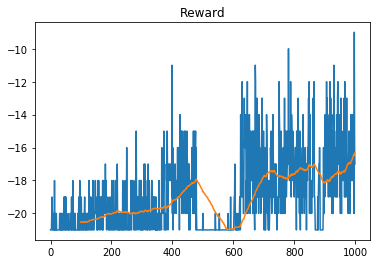

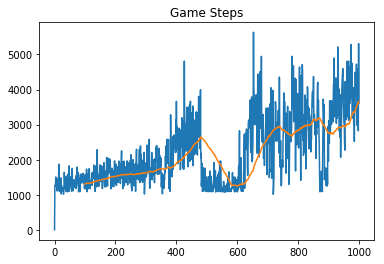

In [117]:
def plot_series(x, name):
    plt.plot(x[:episodes])
    average = np.convolve(x[:episodes], np.ones((100,))/100, mode='valid')
    plt.plot(np.arange(episodes-len(average), episodes), average)
    plt.title(name)
    plt.show()

plot_series(losses, 'Loss')
plot_series(reward_sums, 'Reward')
plot_series(time_taken, 'Game Steps')

## Result


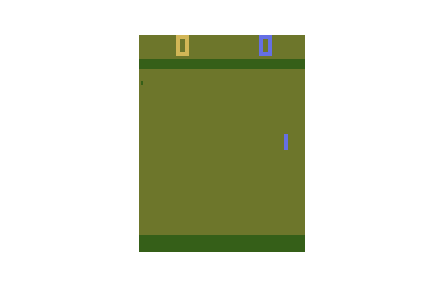
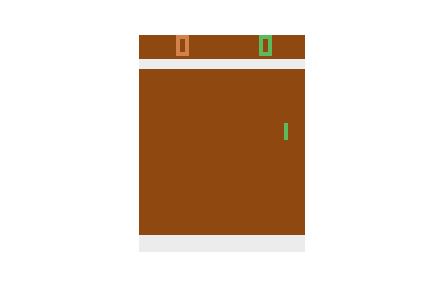
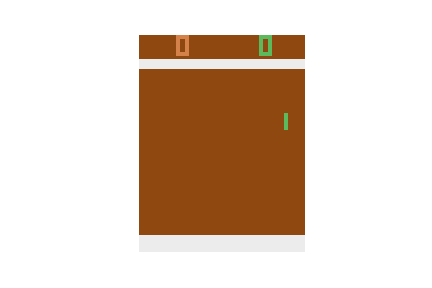
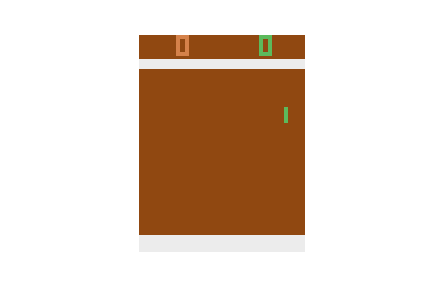
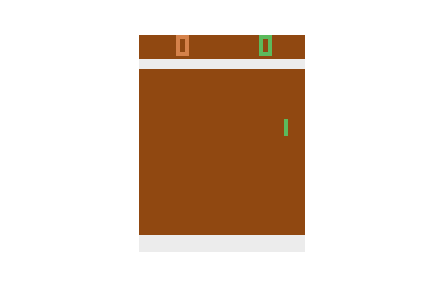
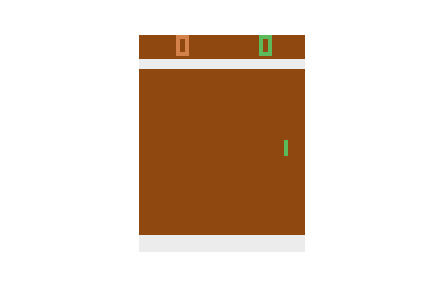
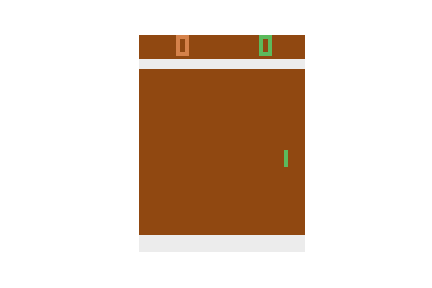
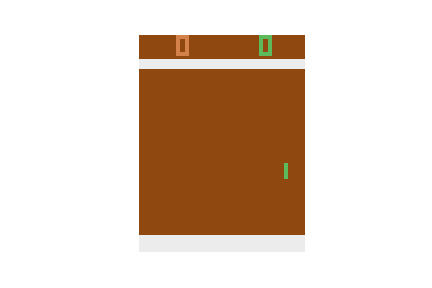
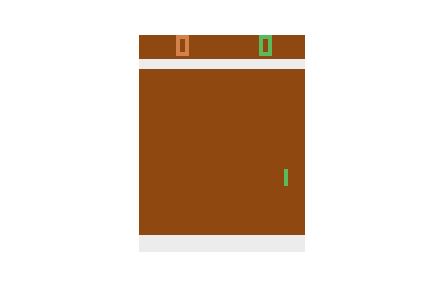
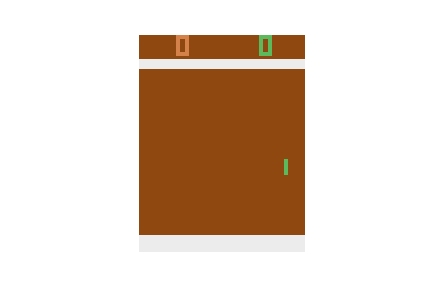
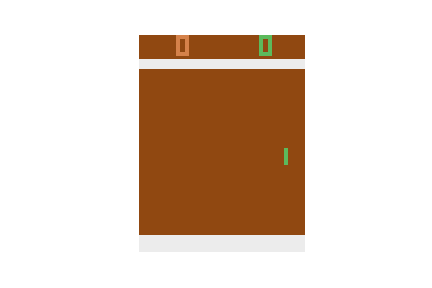
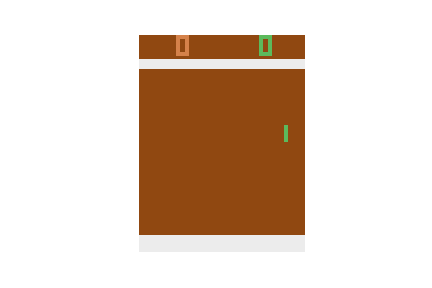
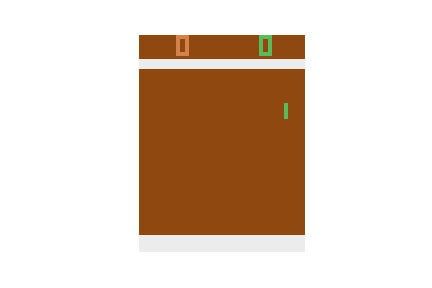
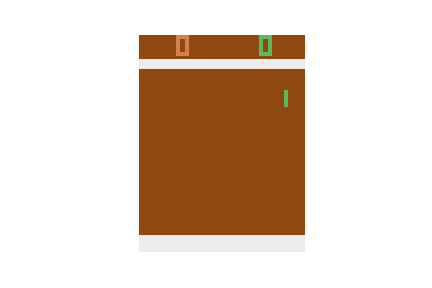
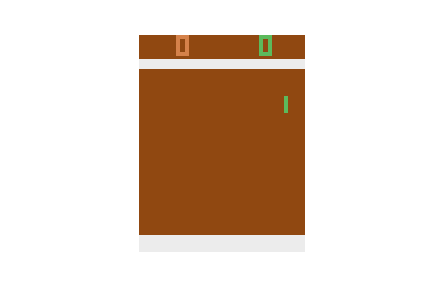
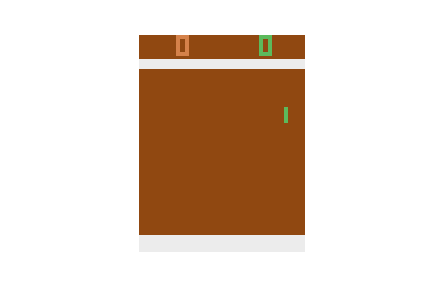
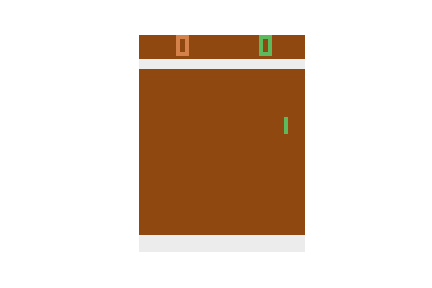
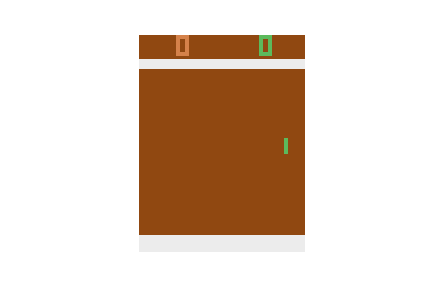
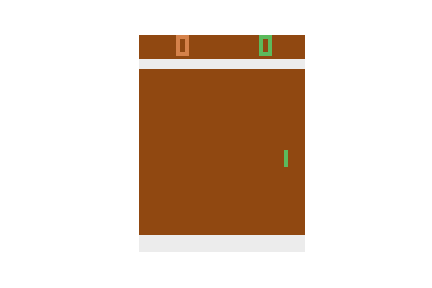
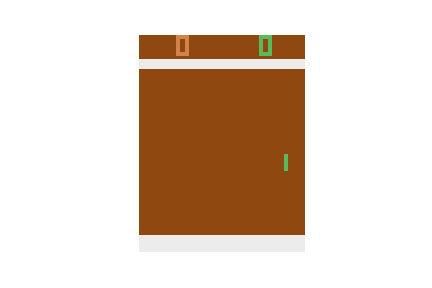
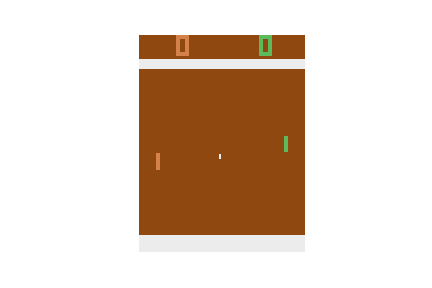
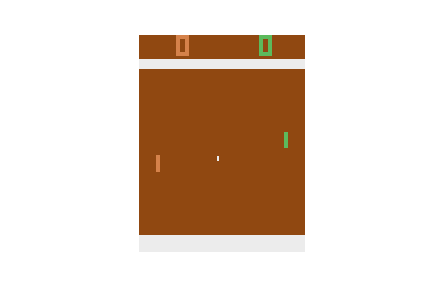
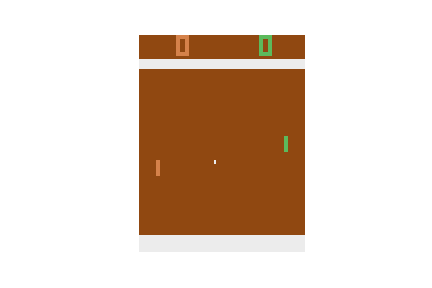
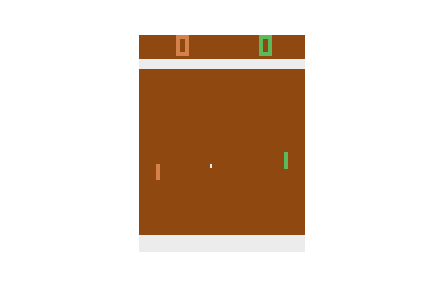
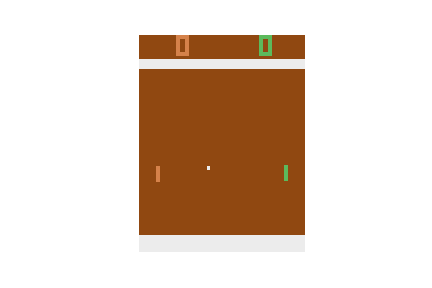
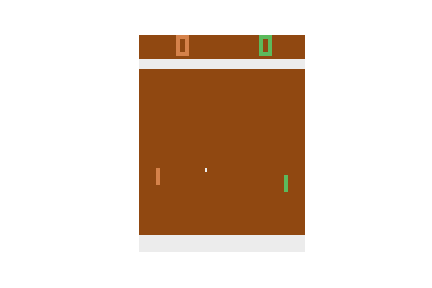
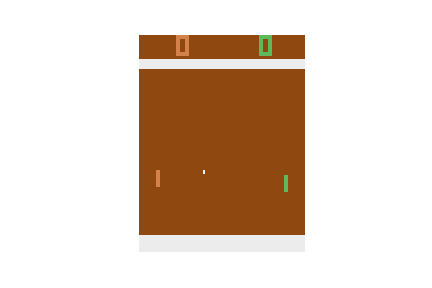
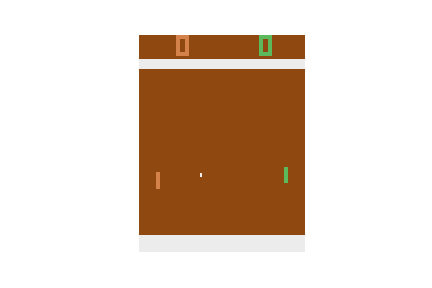
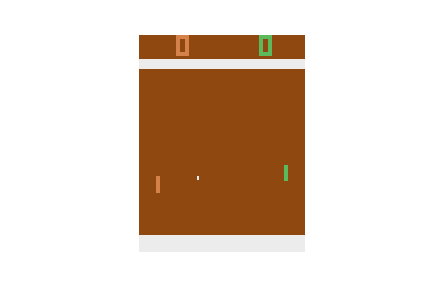
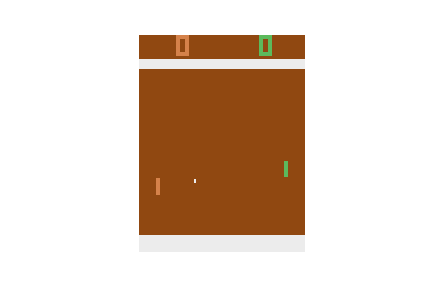
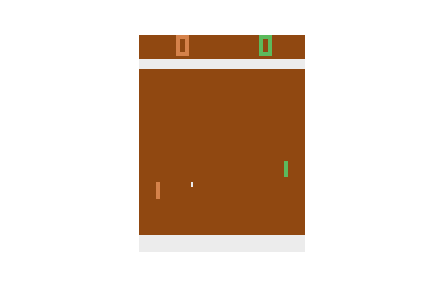
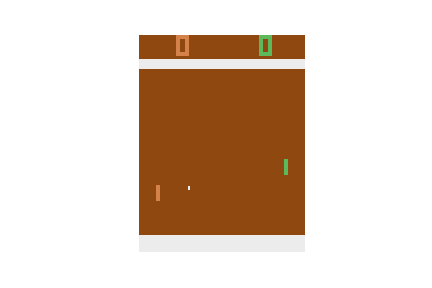
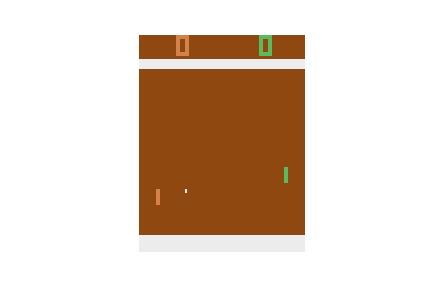
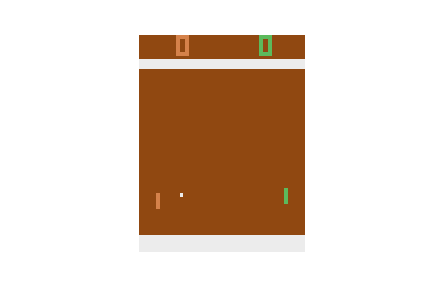
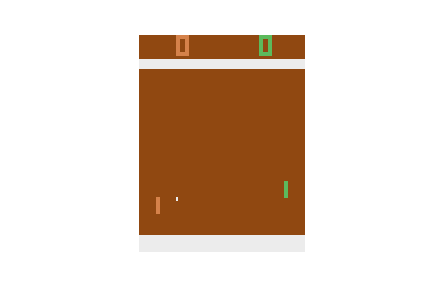
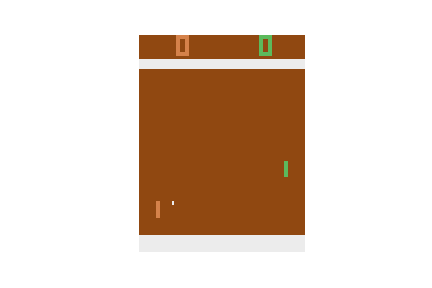
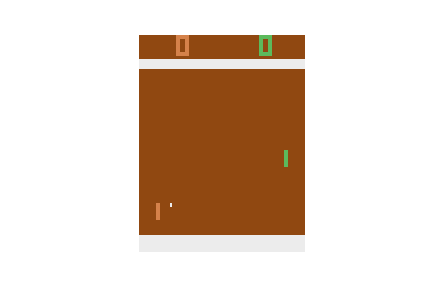
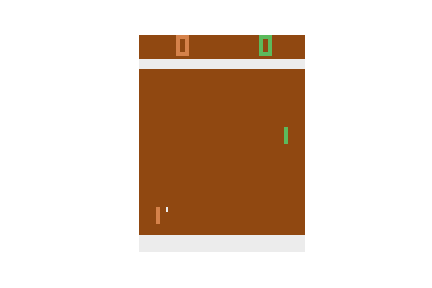
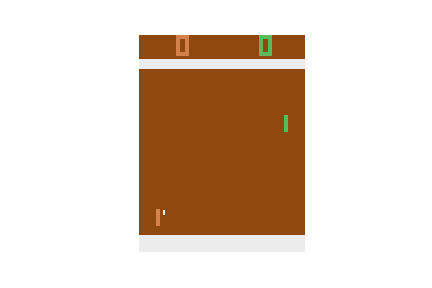
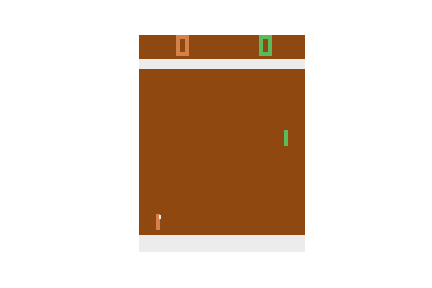
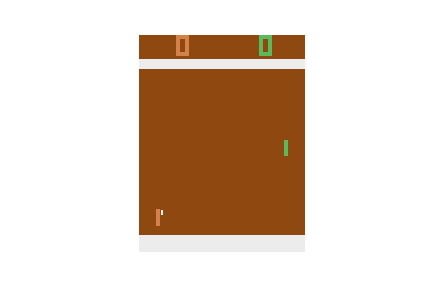
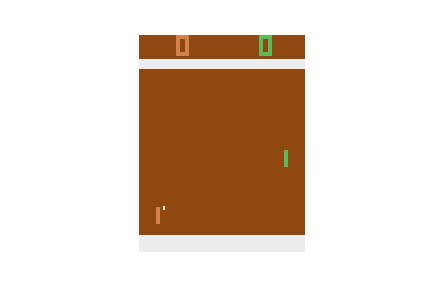
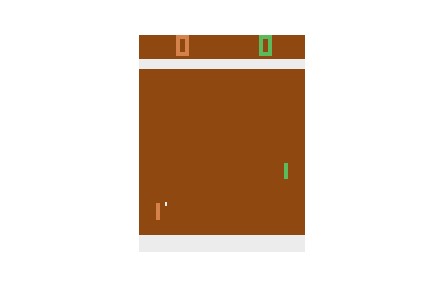
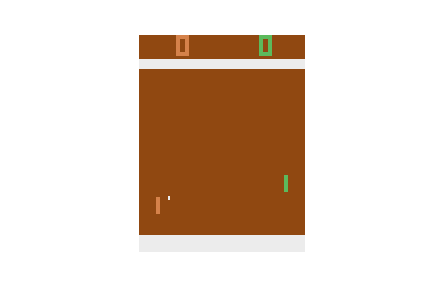
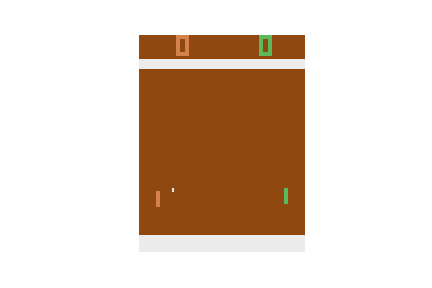
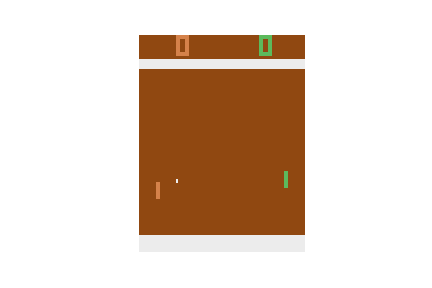
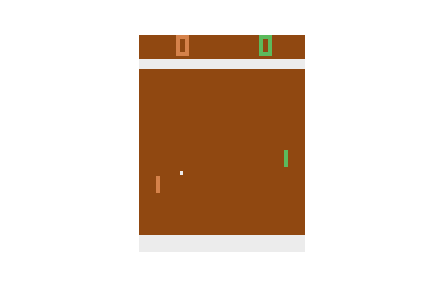
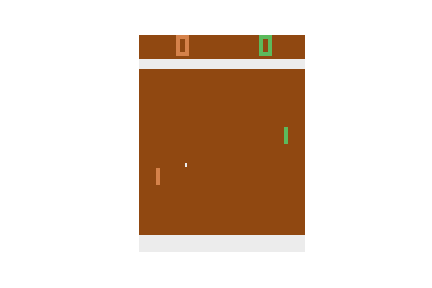
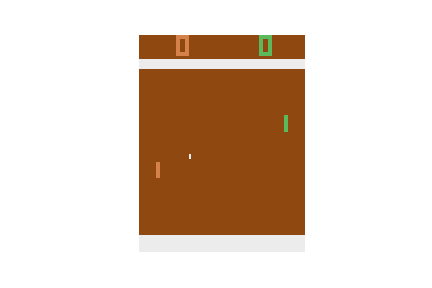
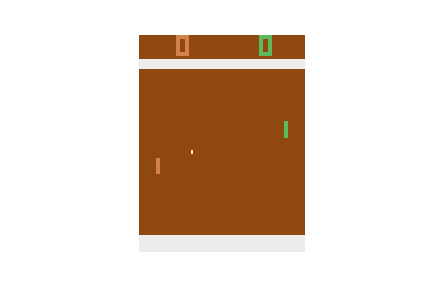
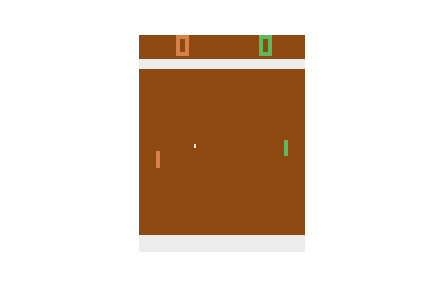
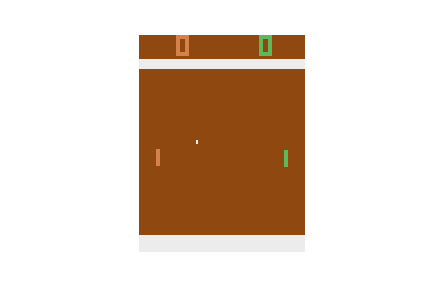
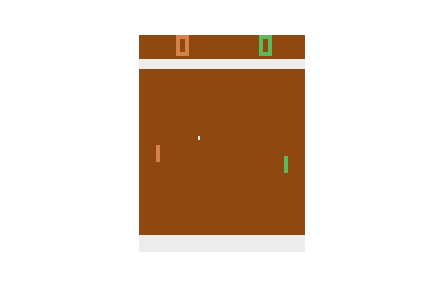
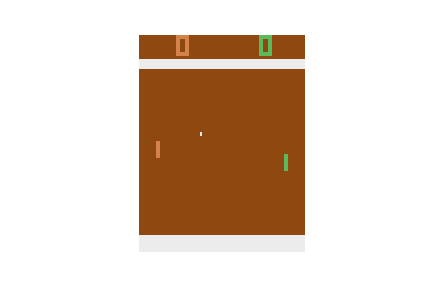
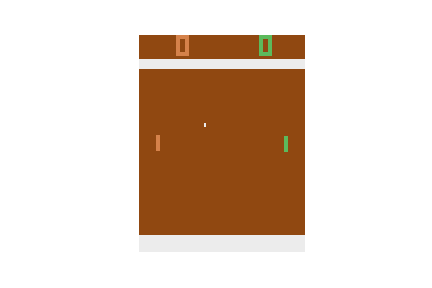
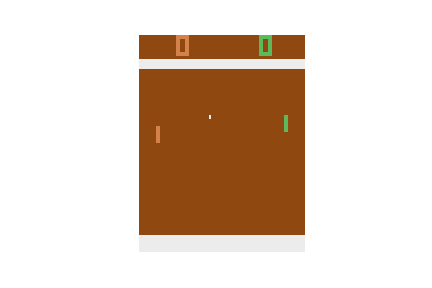
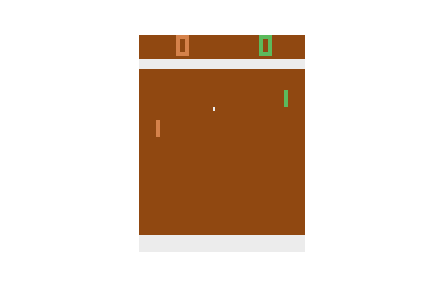
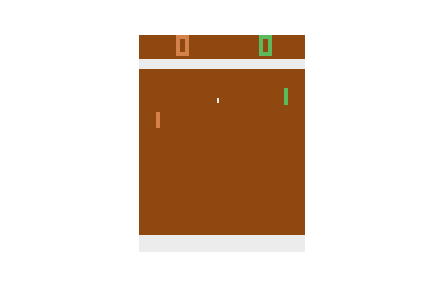
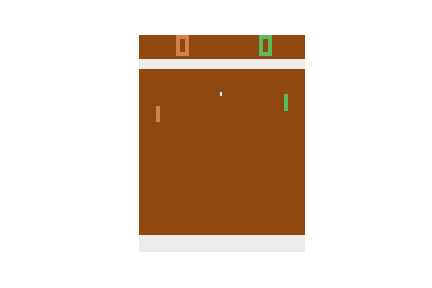
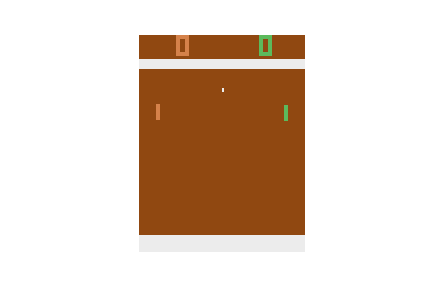
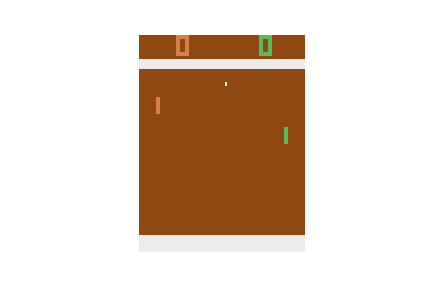
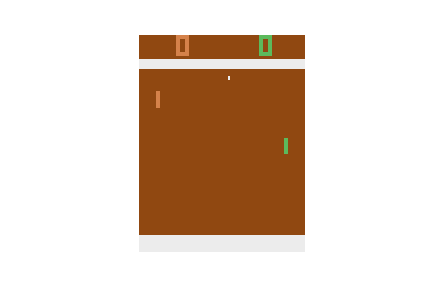
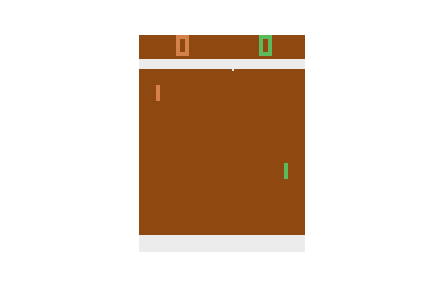
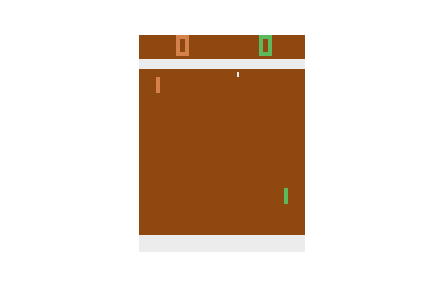
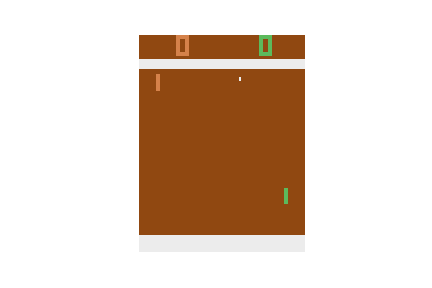
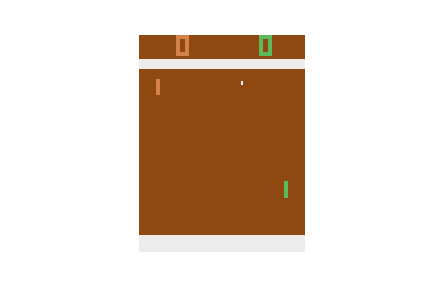
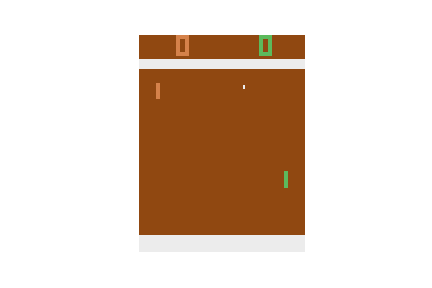
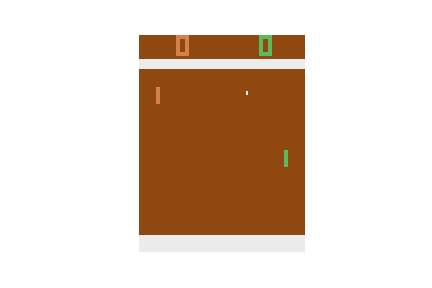
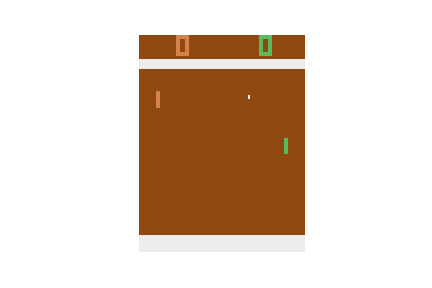
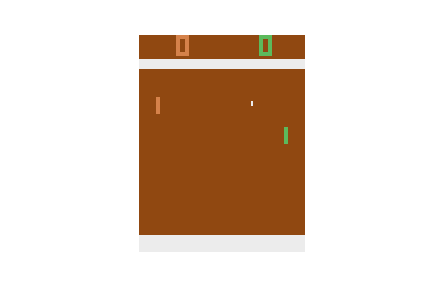
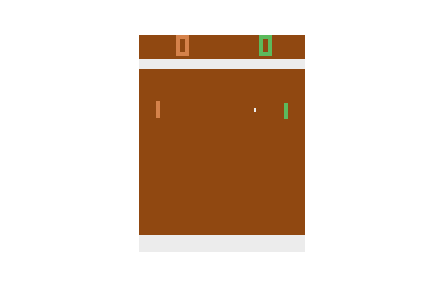
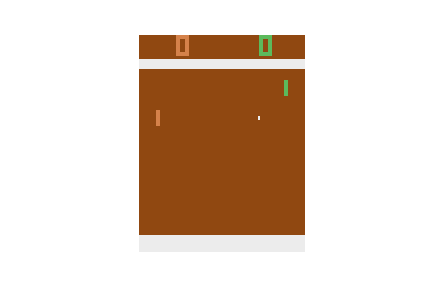
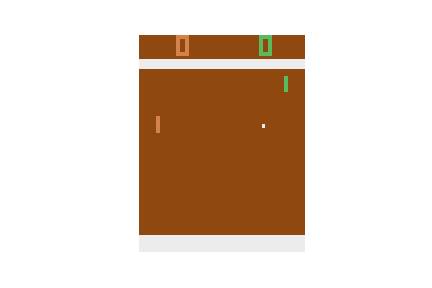
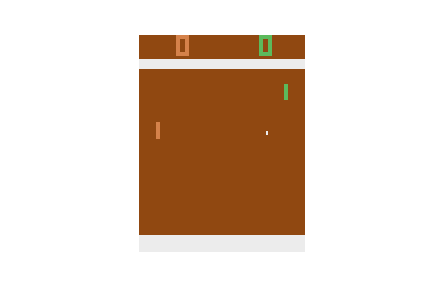
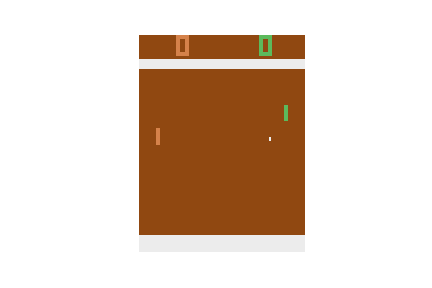
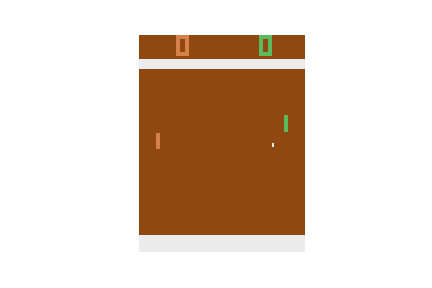
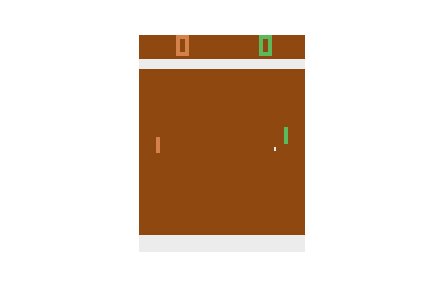
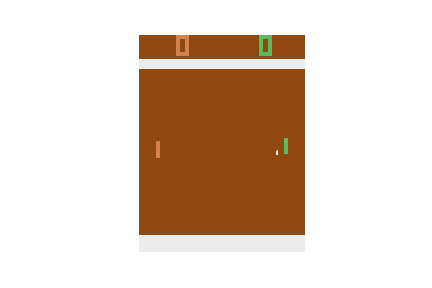
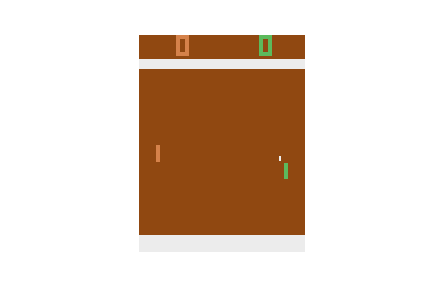
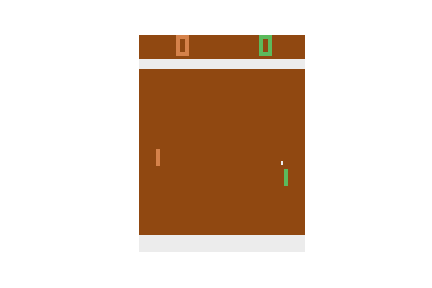
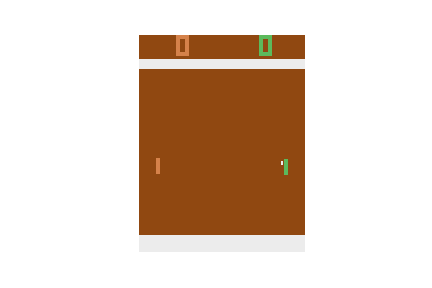
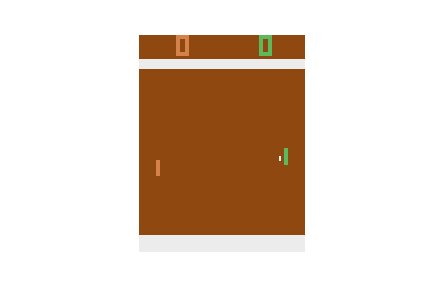
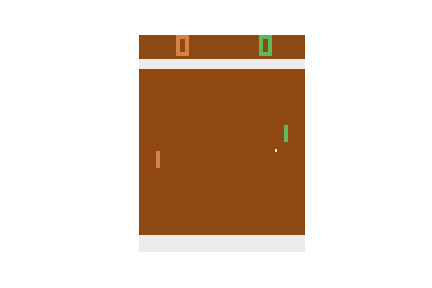
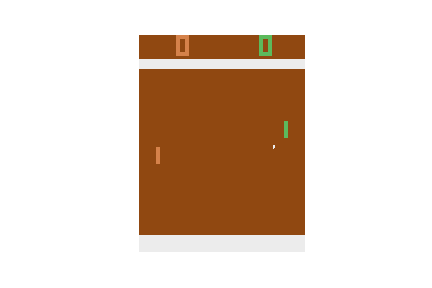
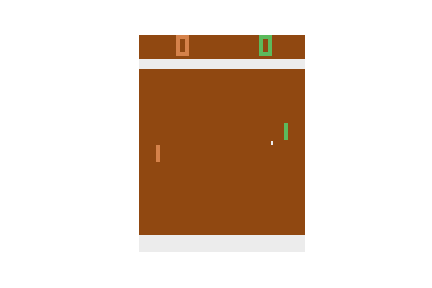
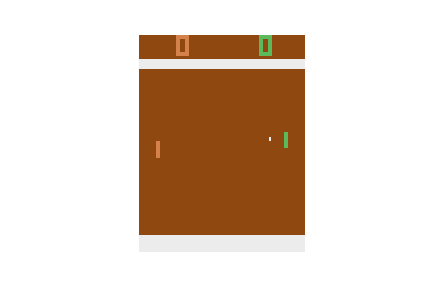
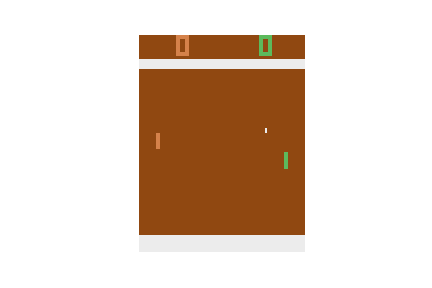
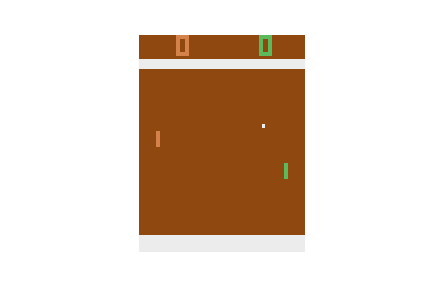
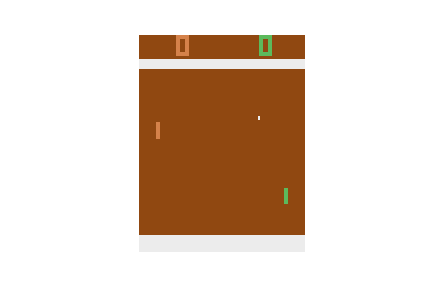
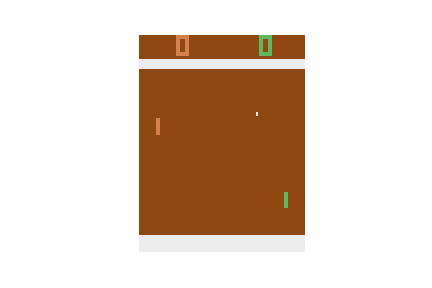
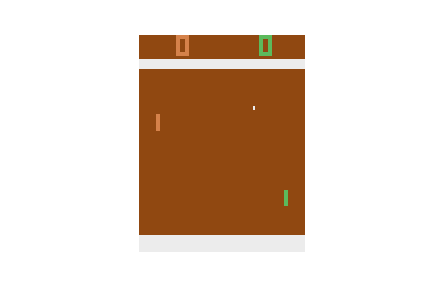
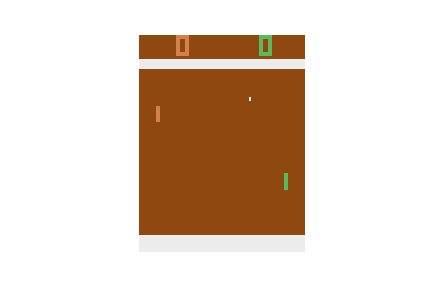
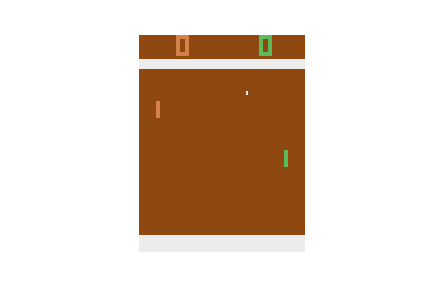
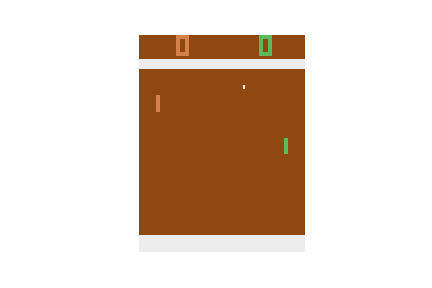
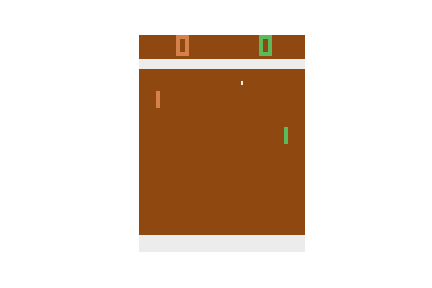
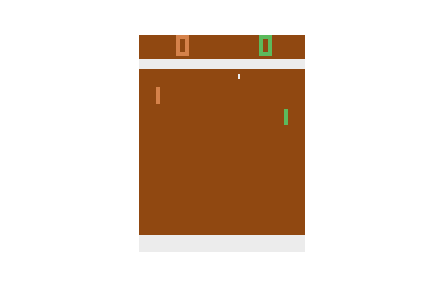
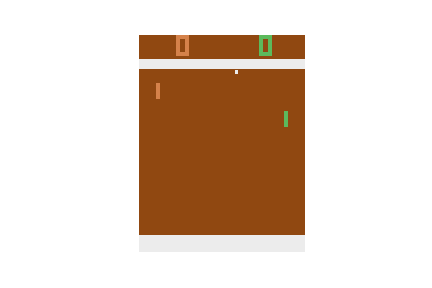
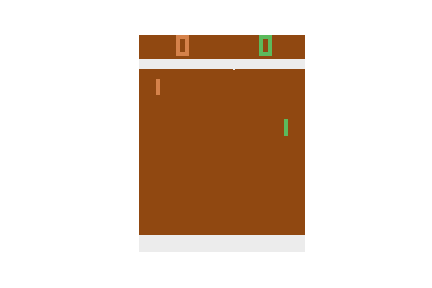
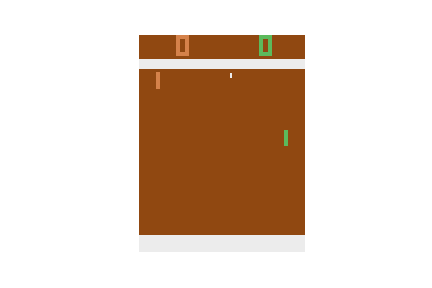
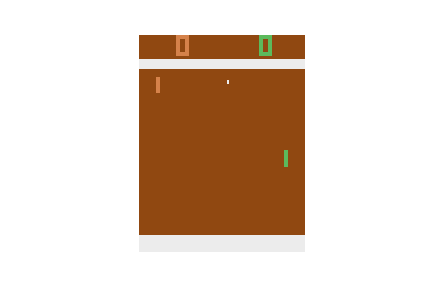
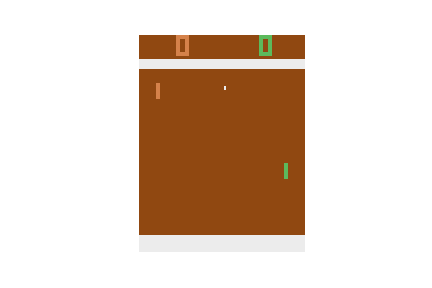
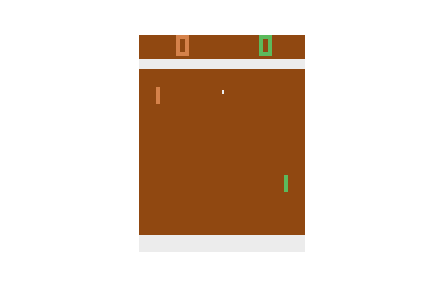
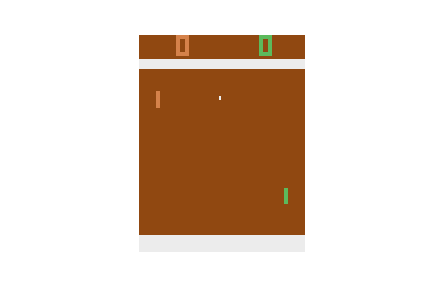
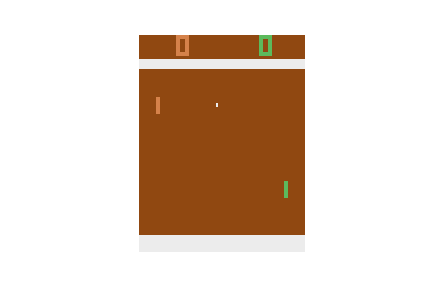
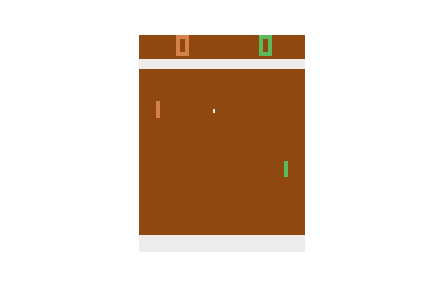
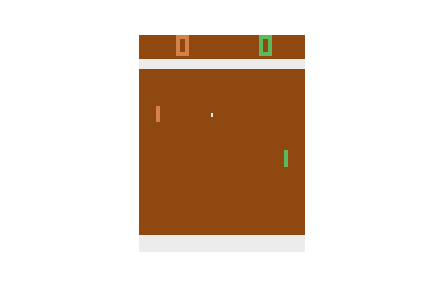
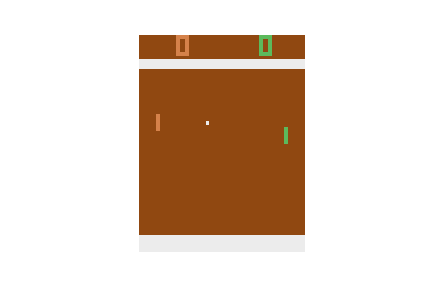
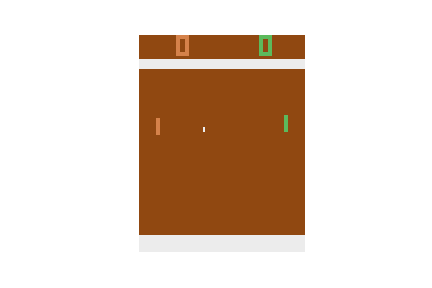
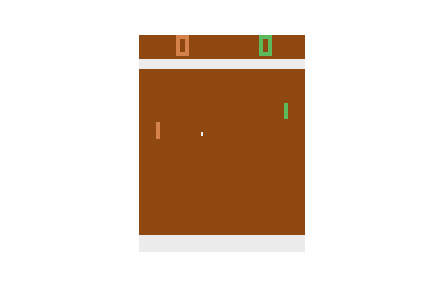
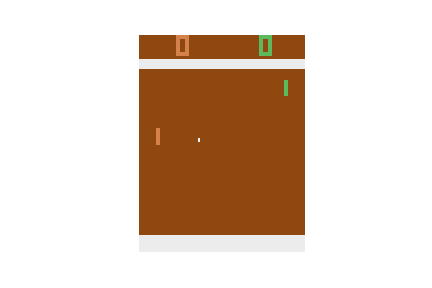
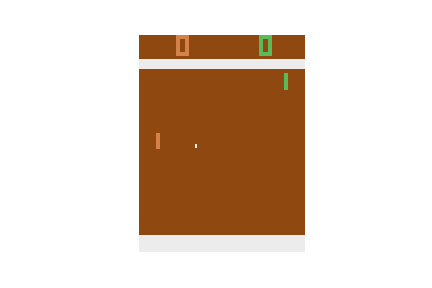
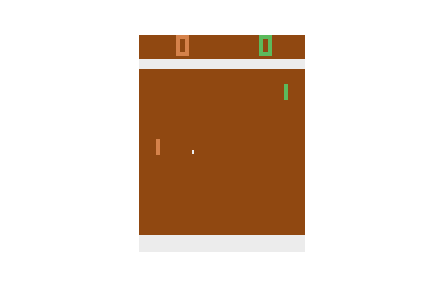
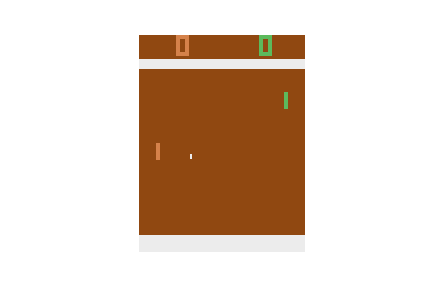
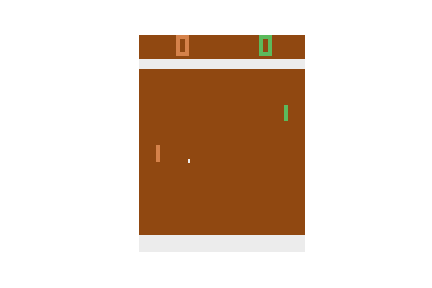
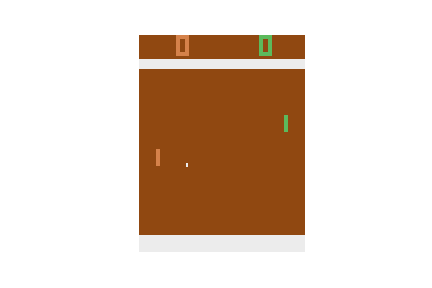
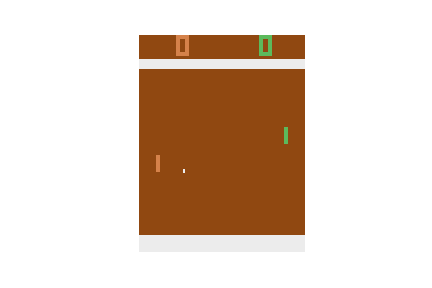
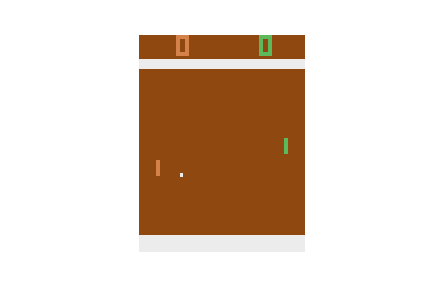
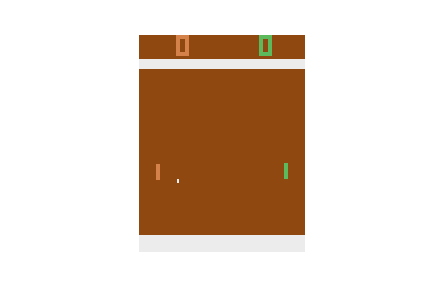
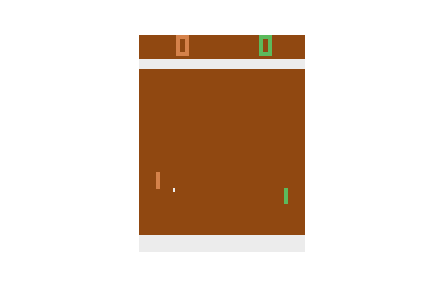
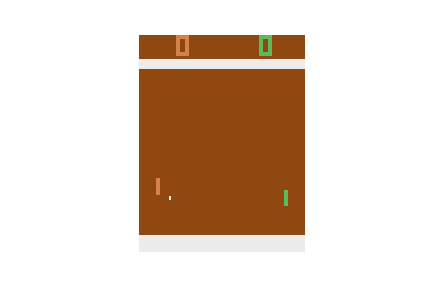
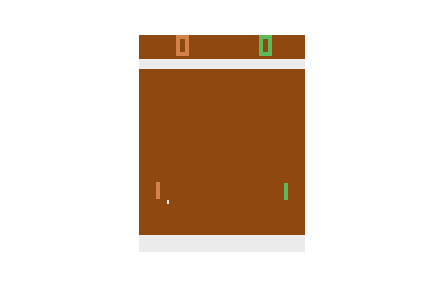
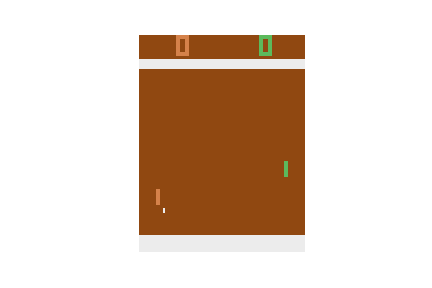
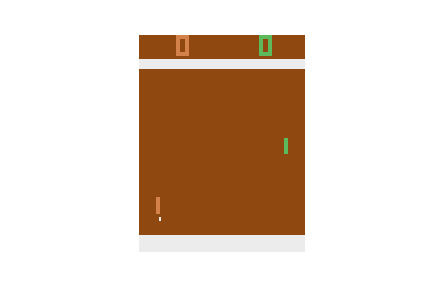
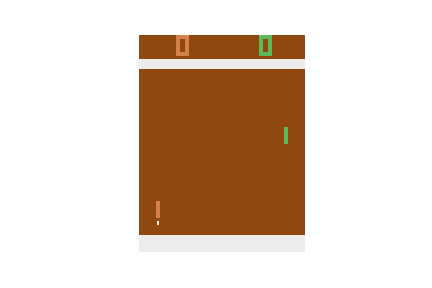
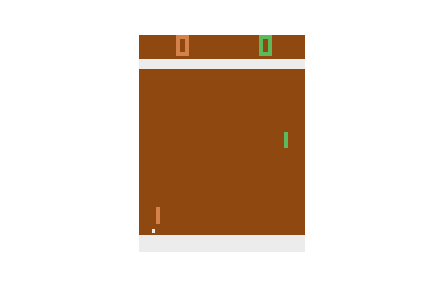
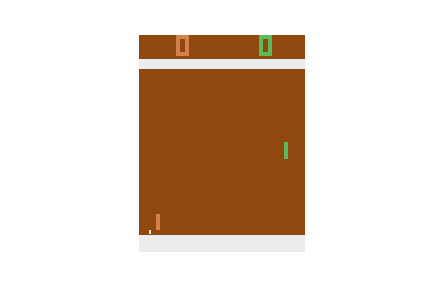
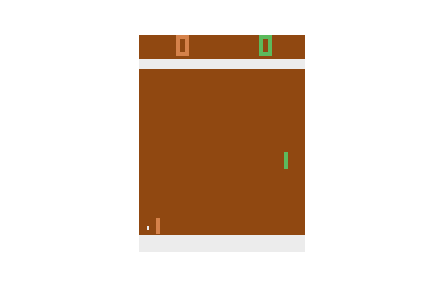
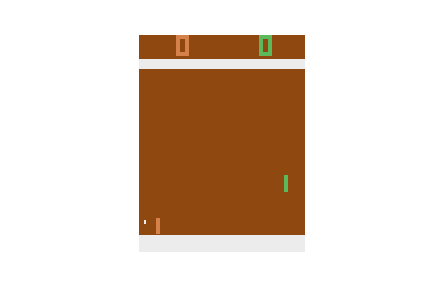
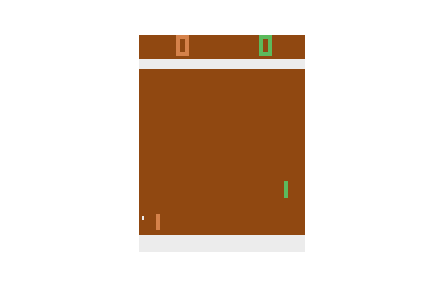
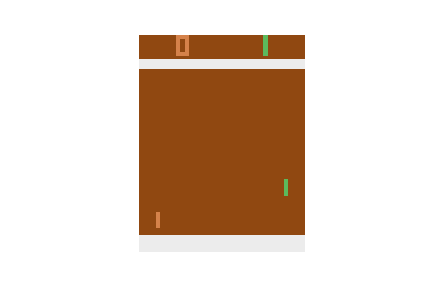
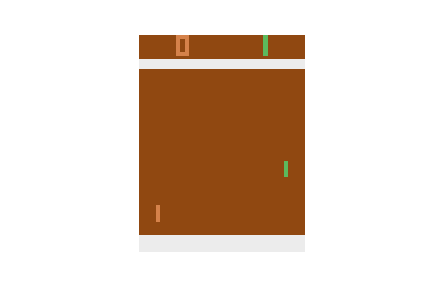
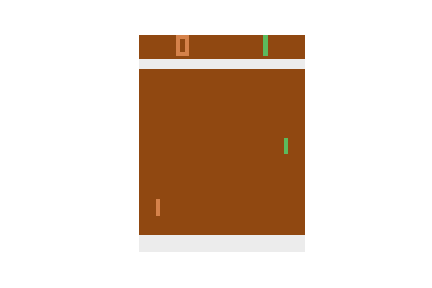
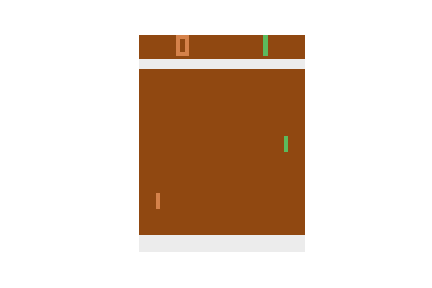
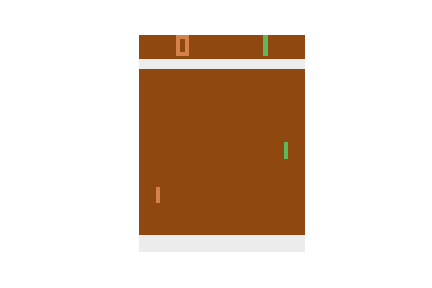
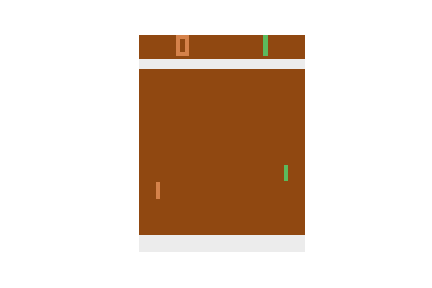
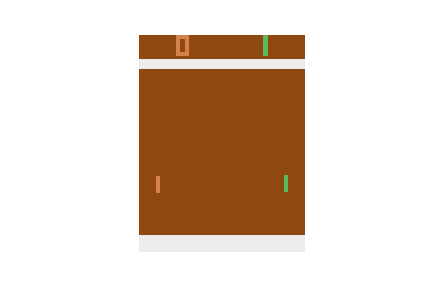
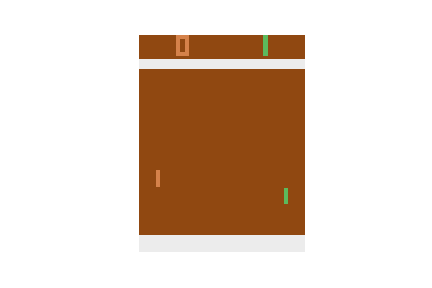
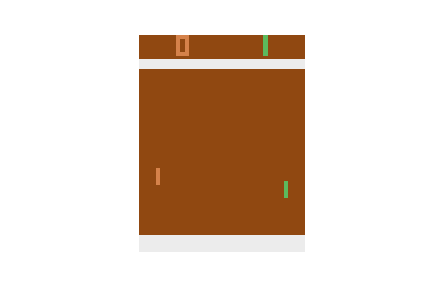
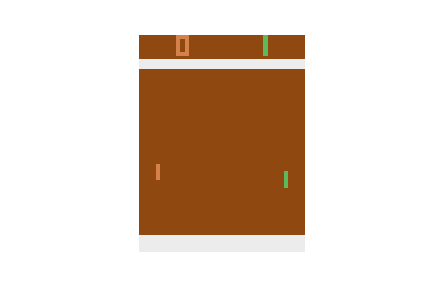
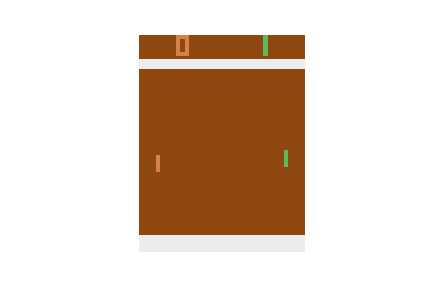
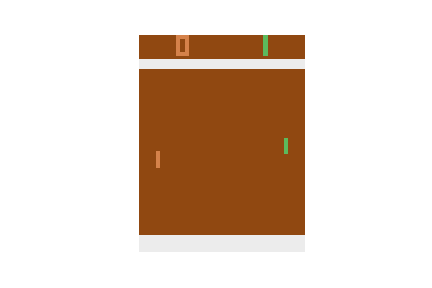
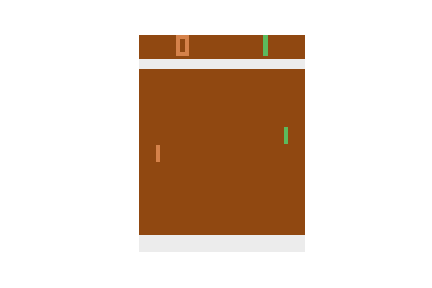
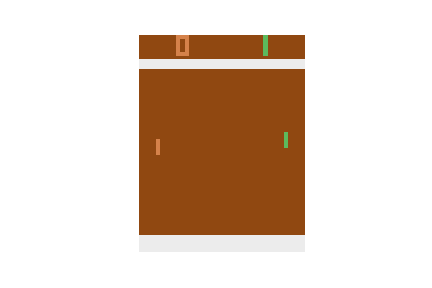
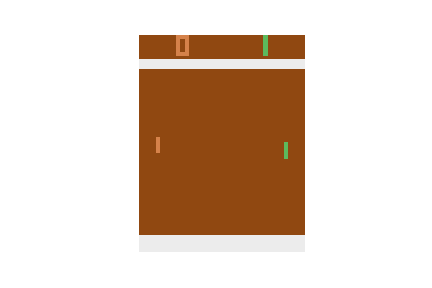
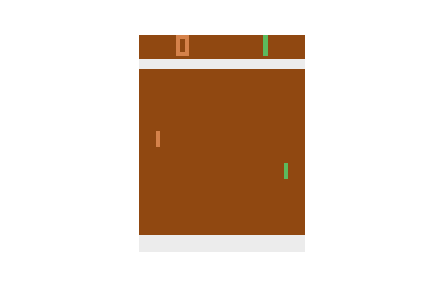
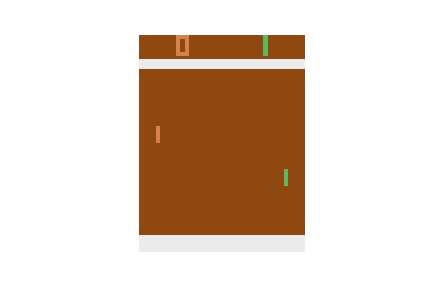
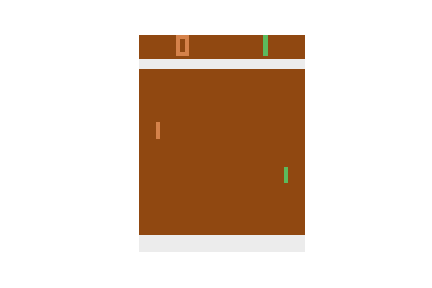
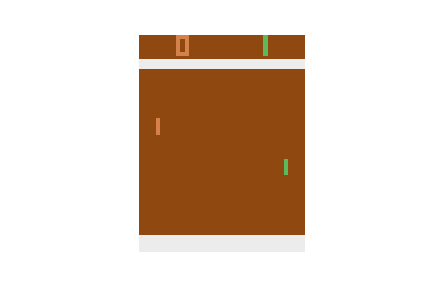
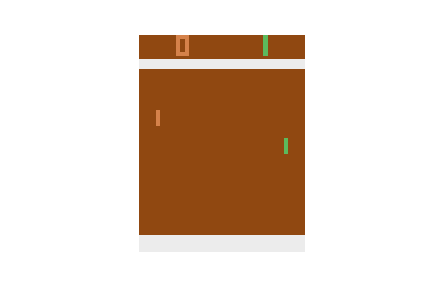
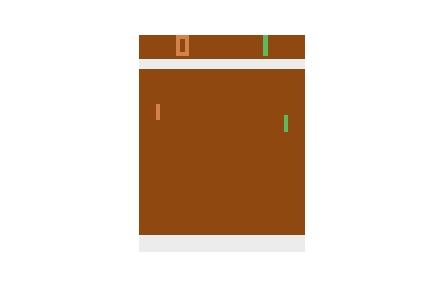
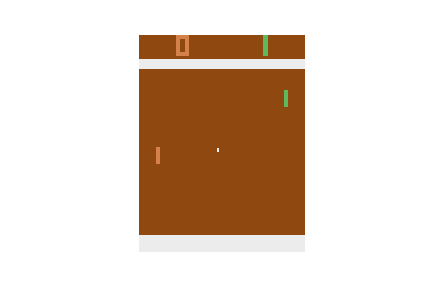
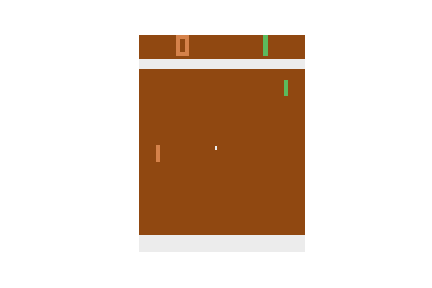
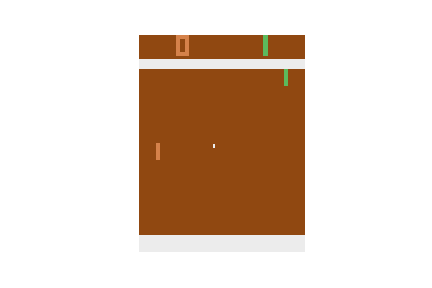
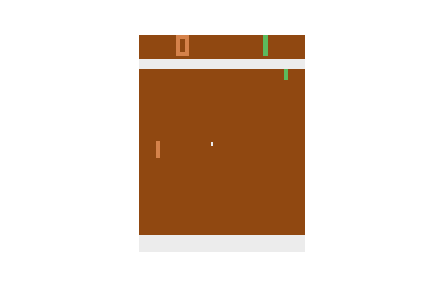
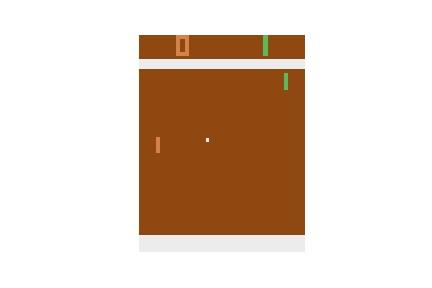
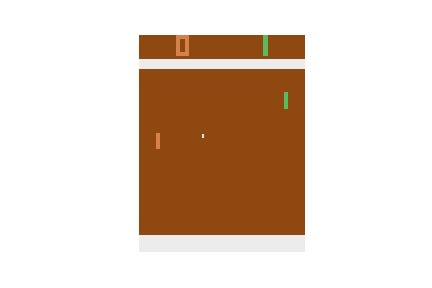
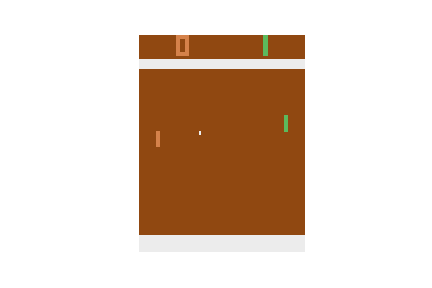
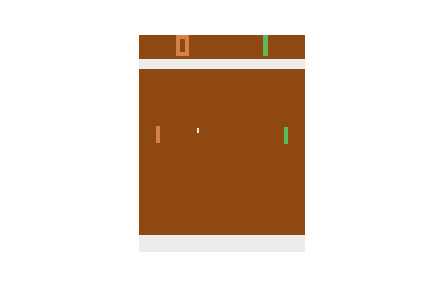
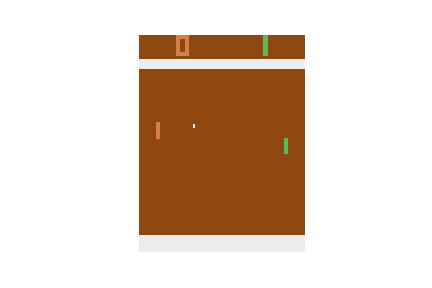
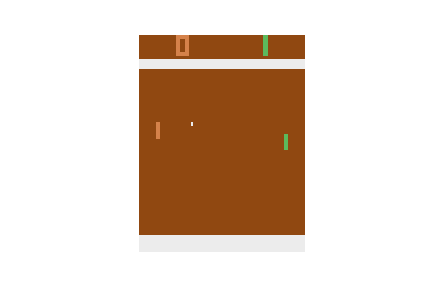
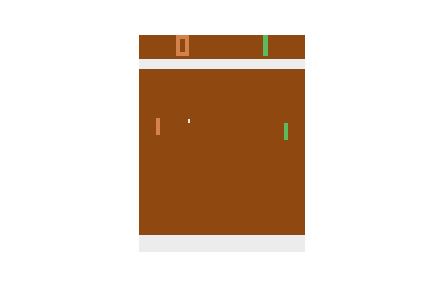
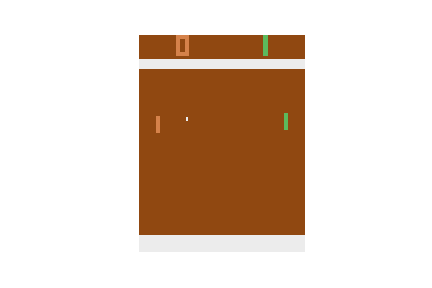
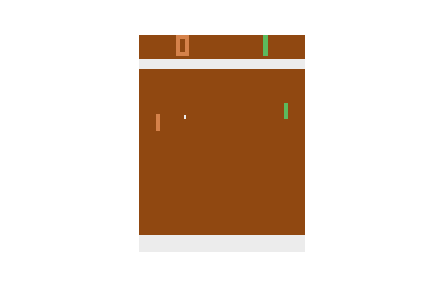
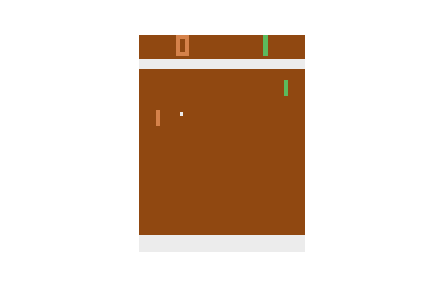
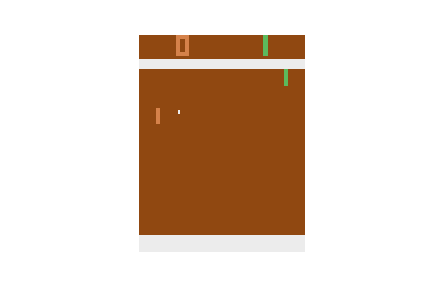
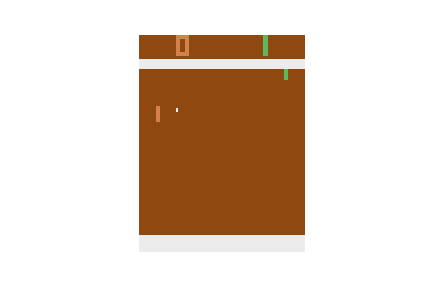
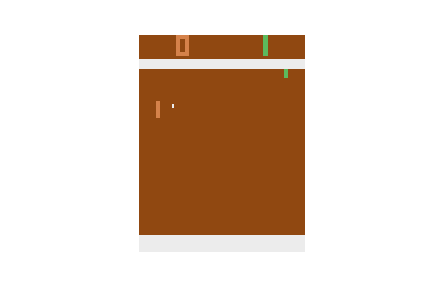
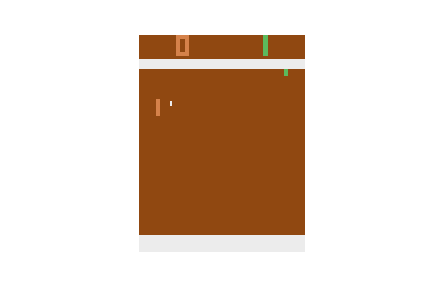
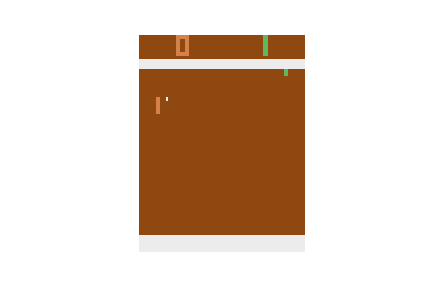
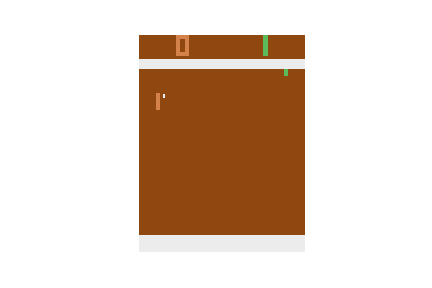
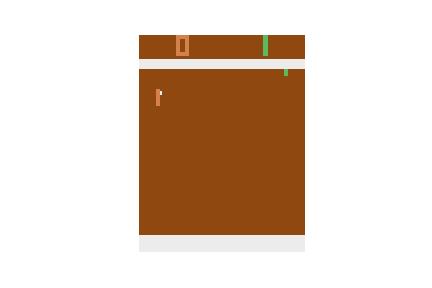
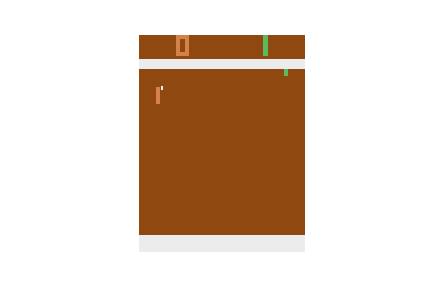
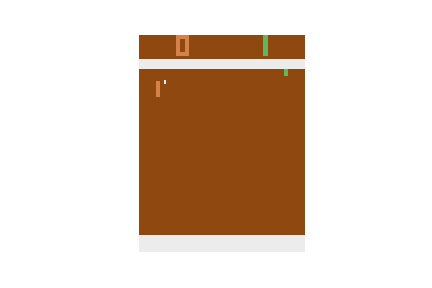
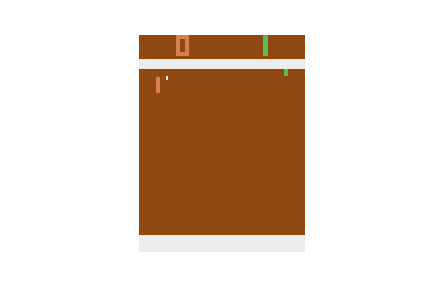
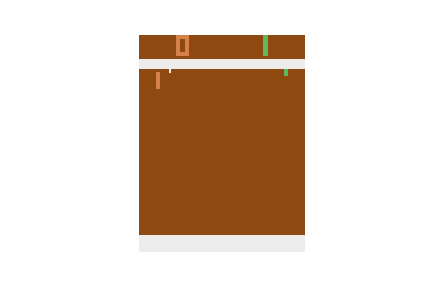
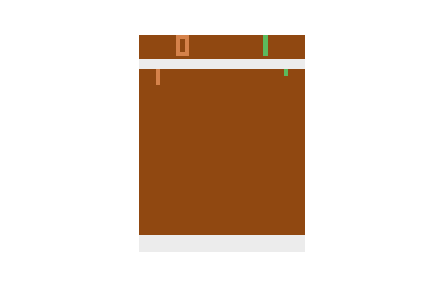
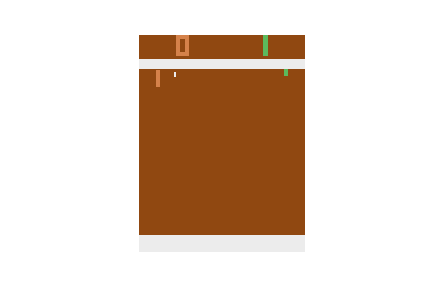
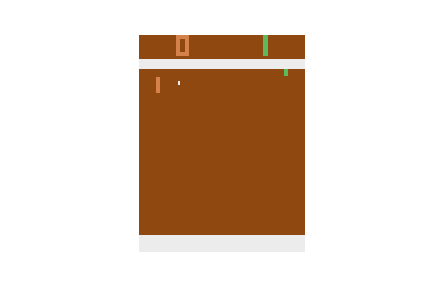
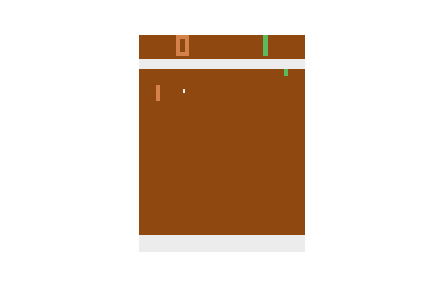
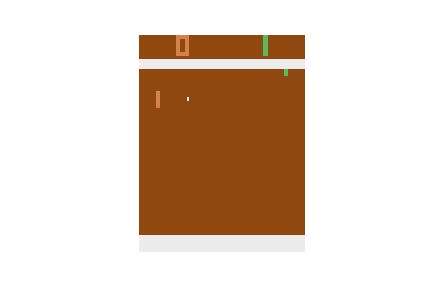
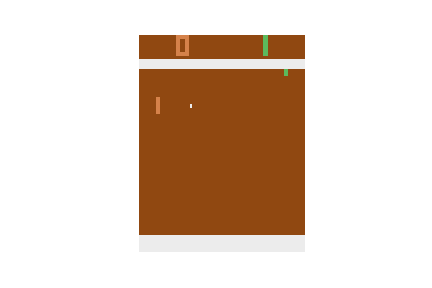
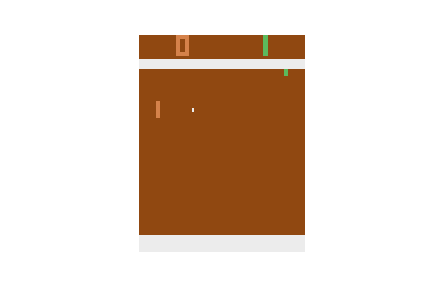
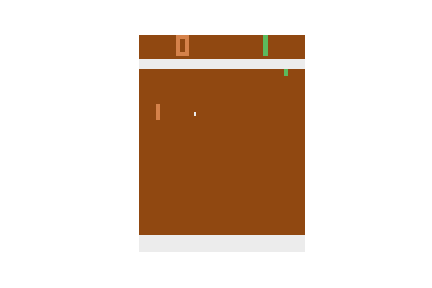
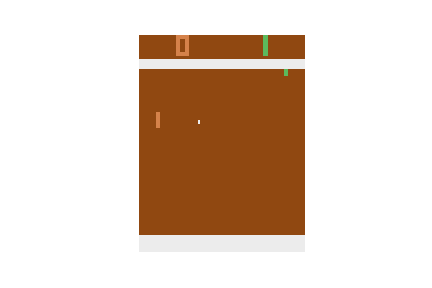
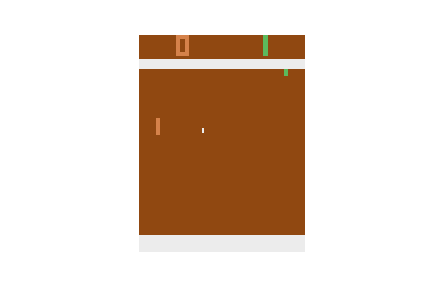
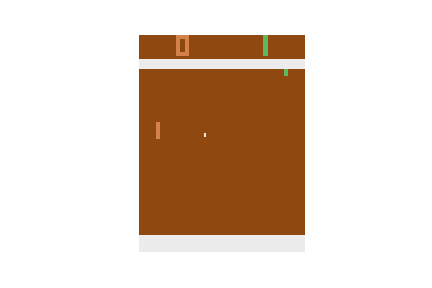
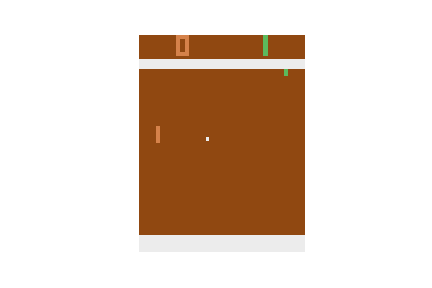
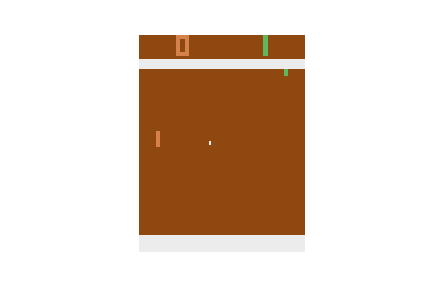
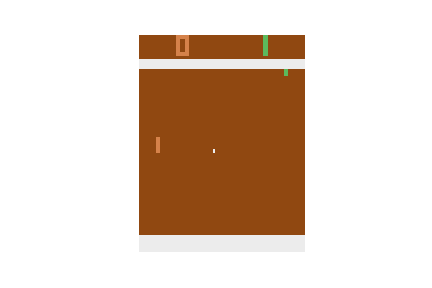
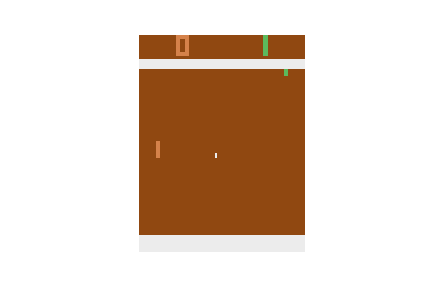
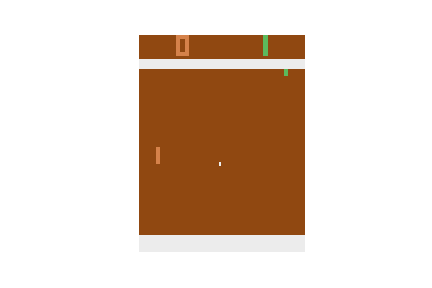
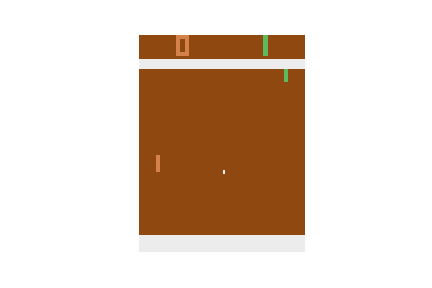
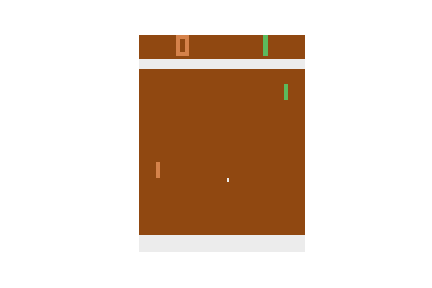
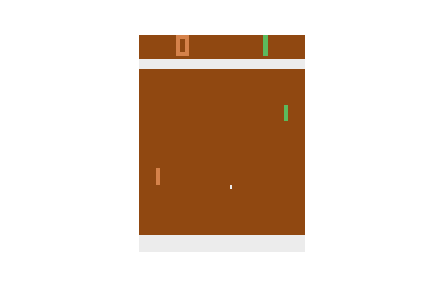
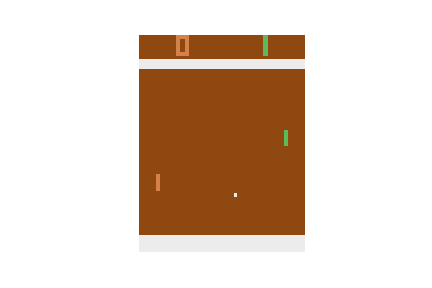
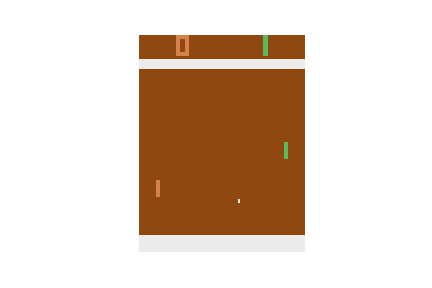
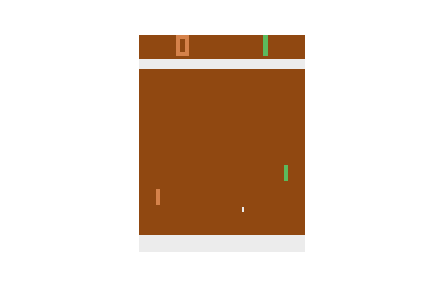
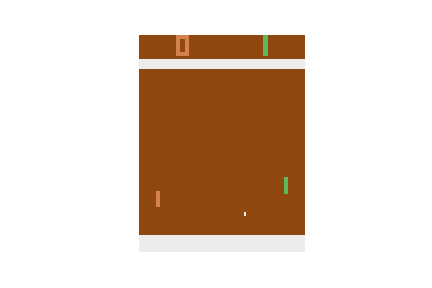
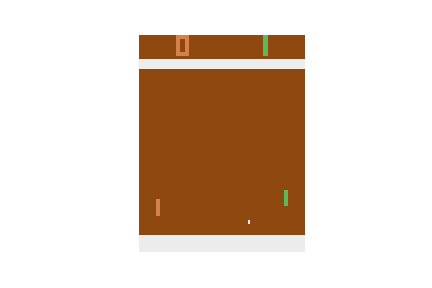
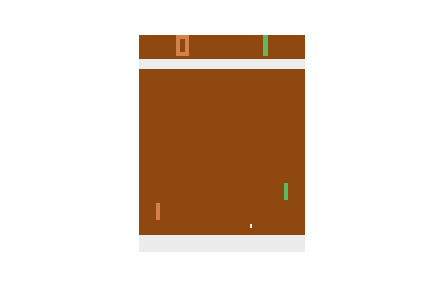
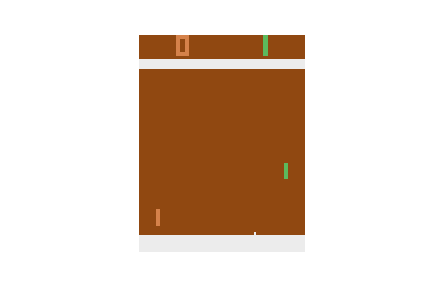
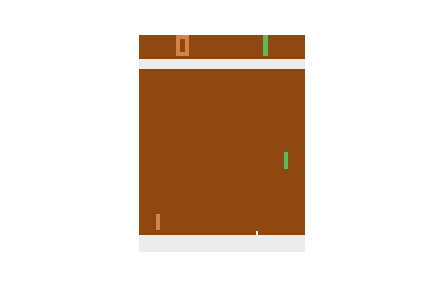
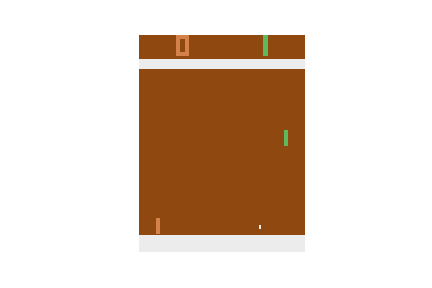
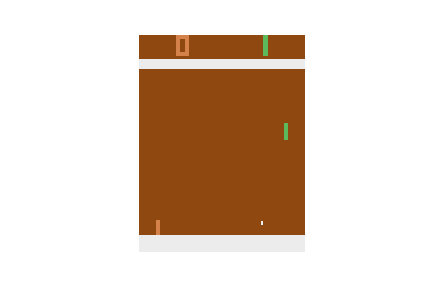
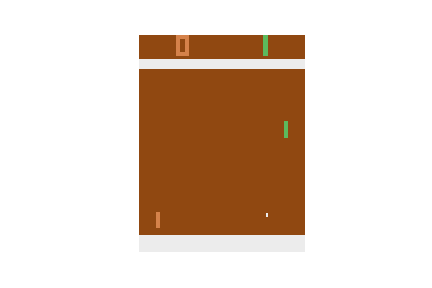
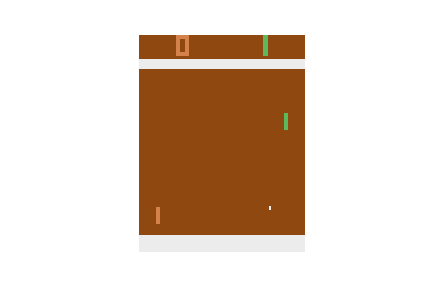
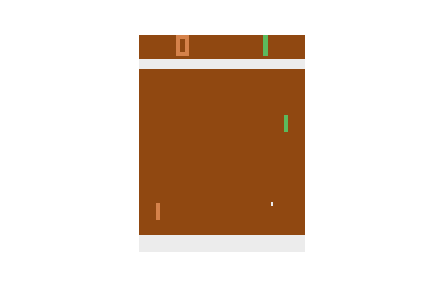
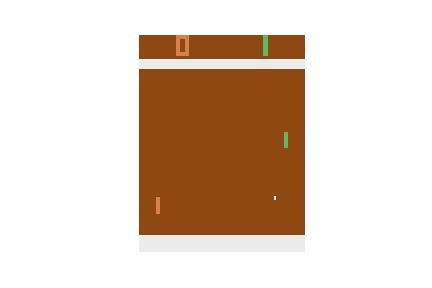
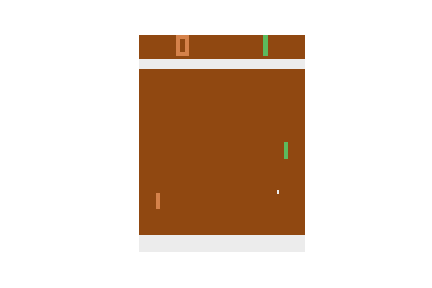
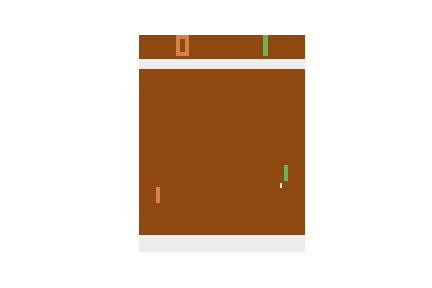
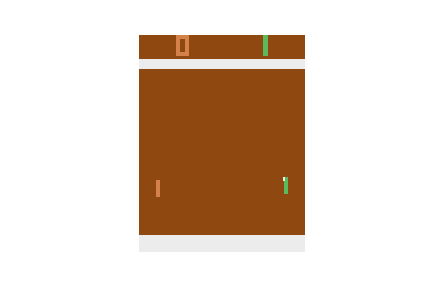
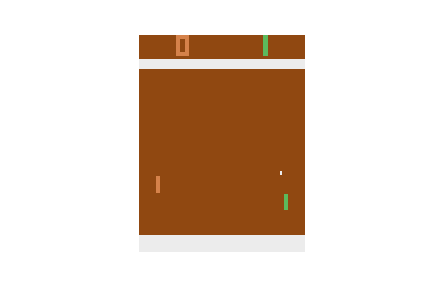
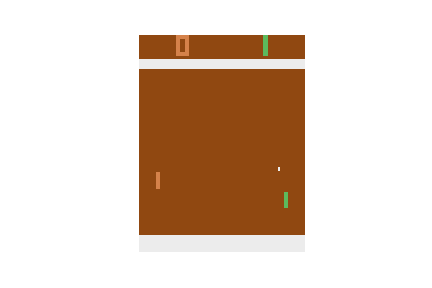
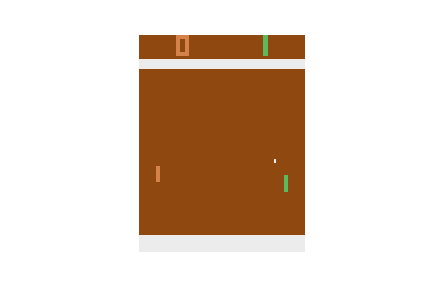
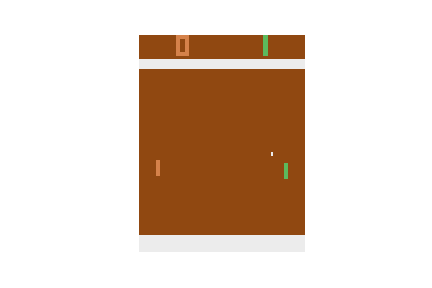
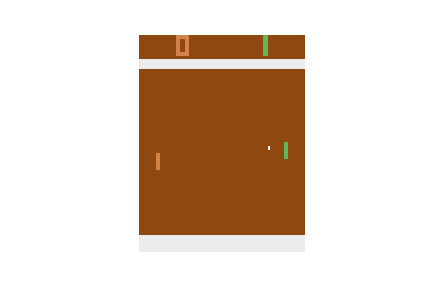
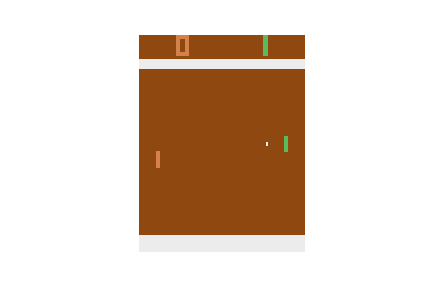
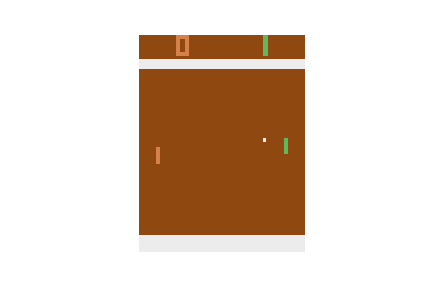
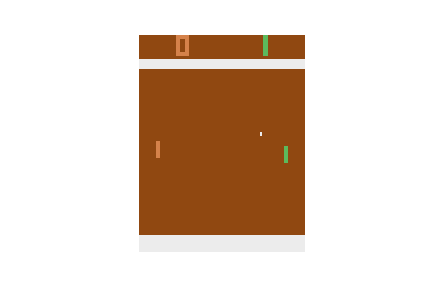
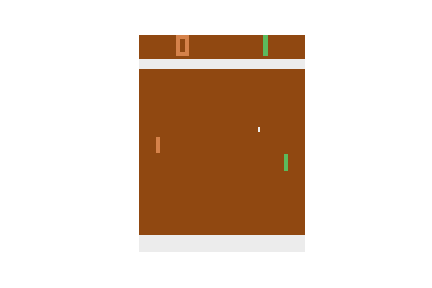
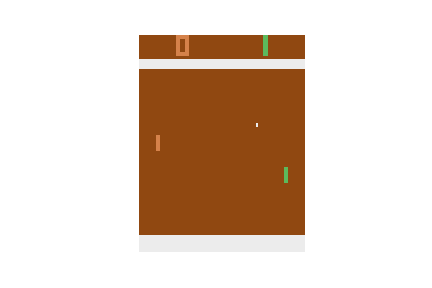
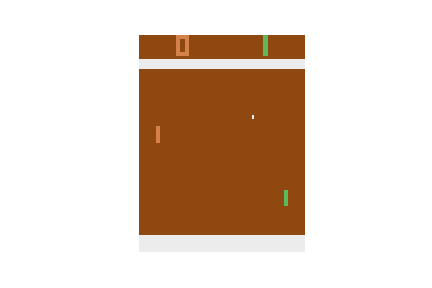
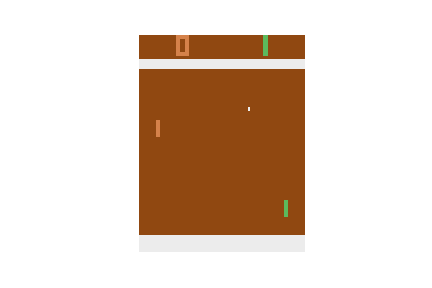
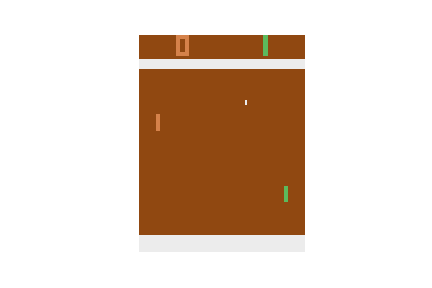
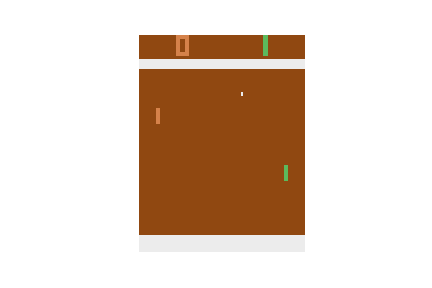
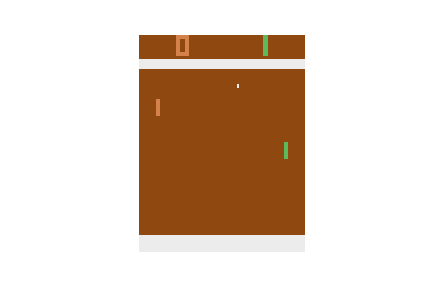
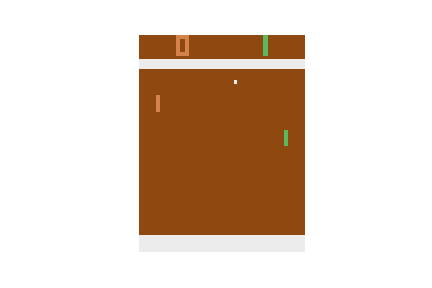
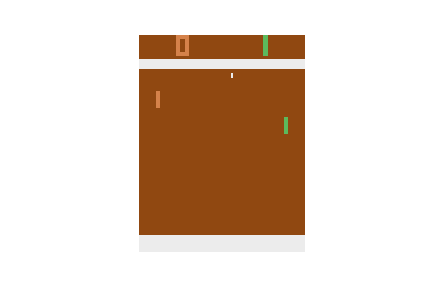
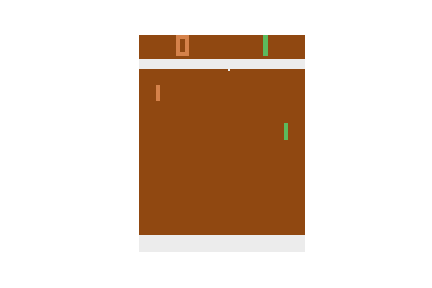
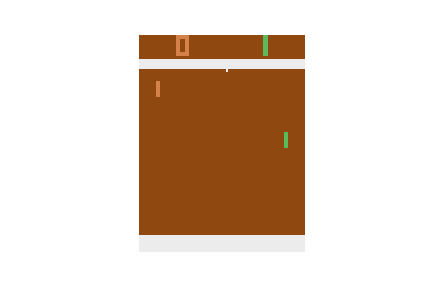
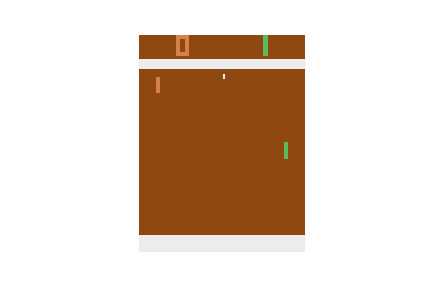
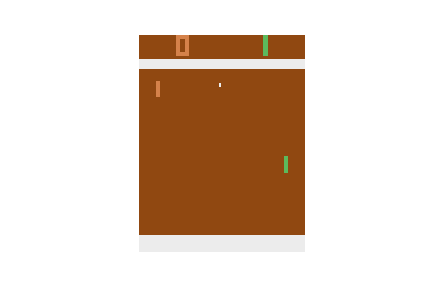
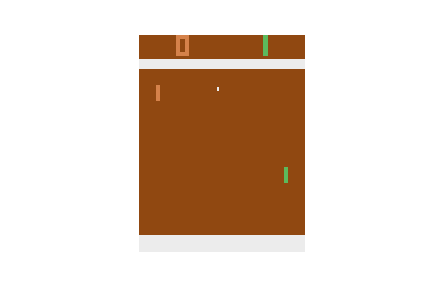
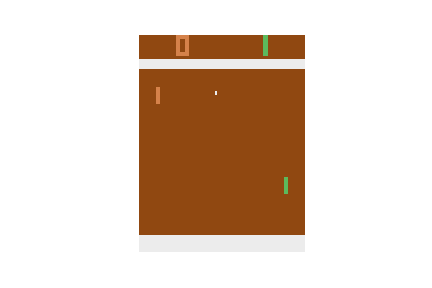
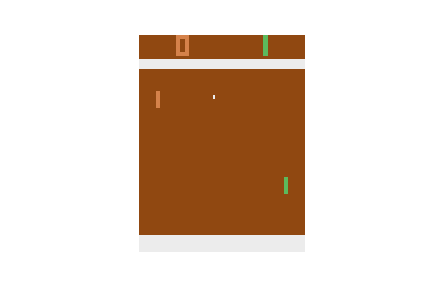
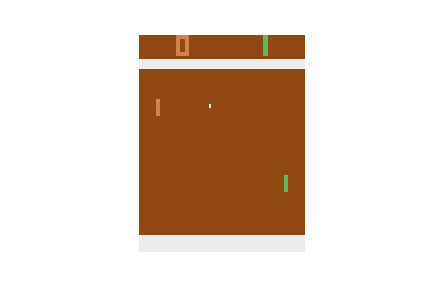
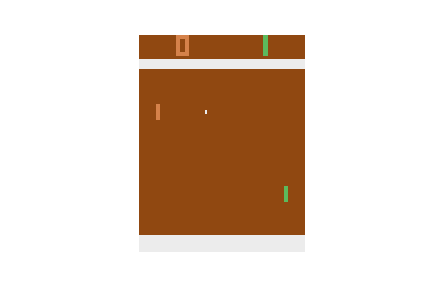
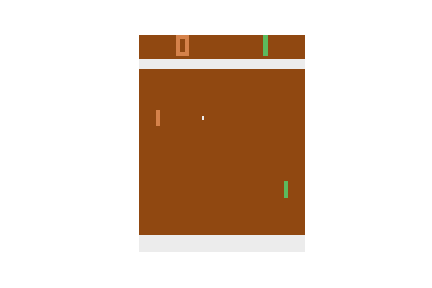
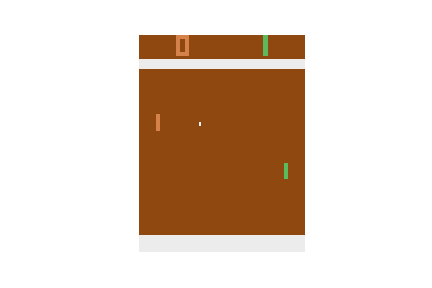
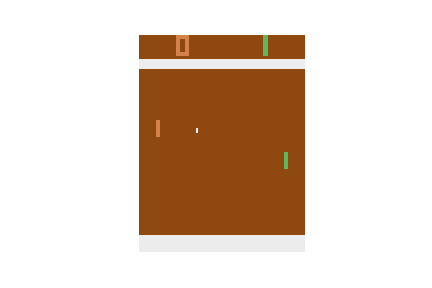
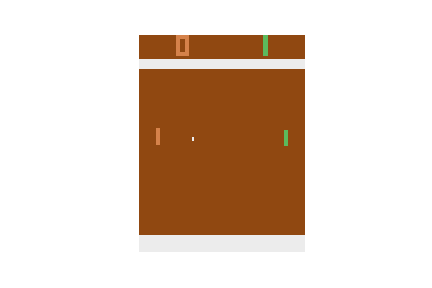
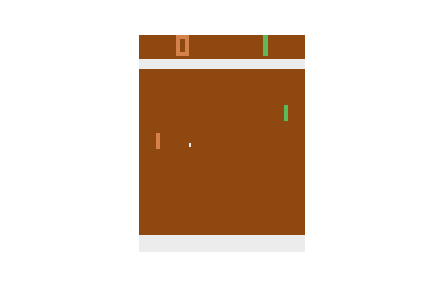
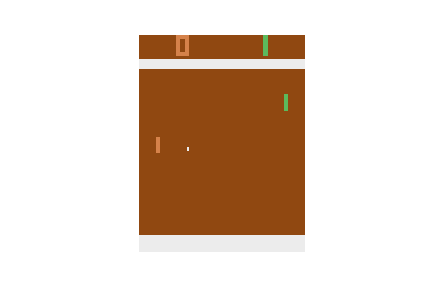
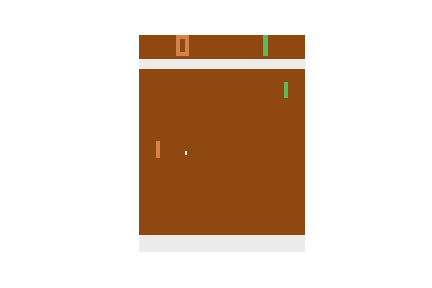
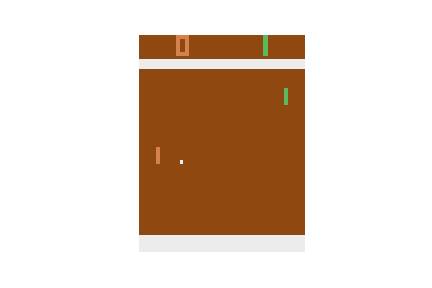
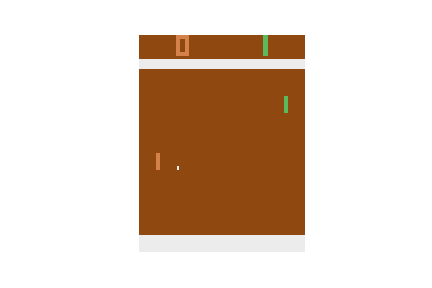
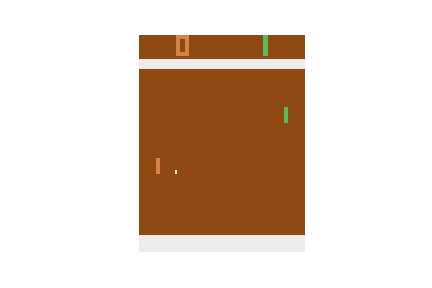
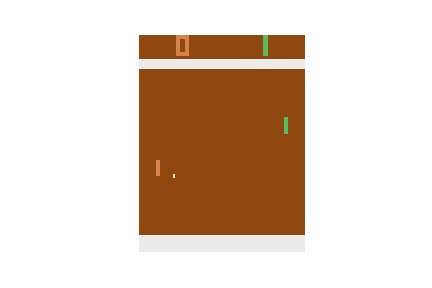
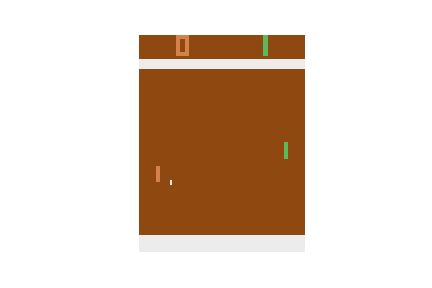
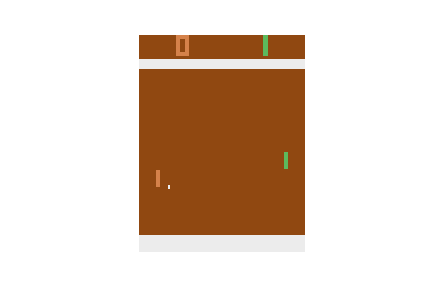
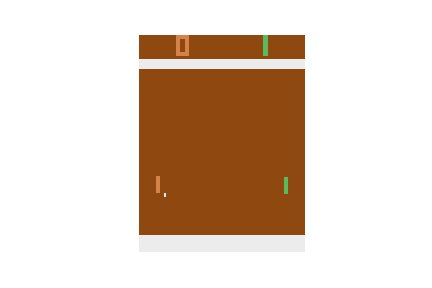
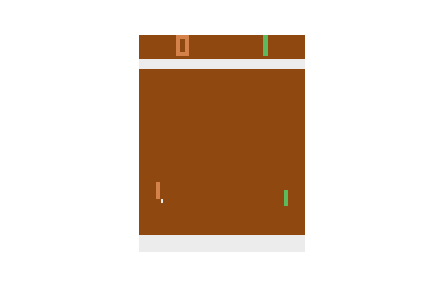
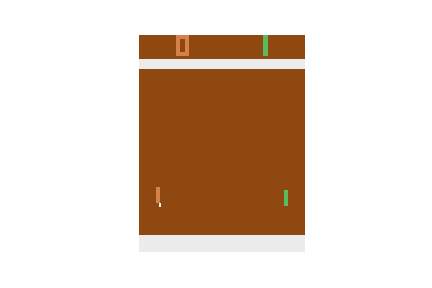
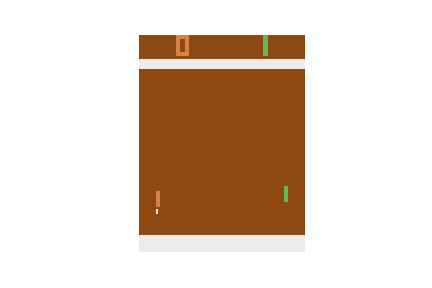
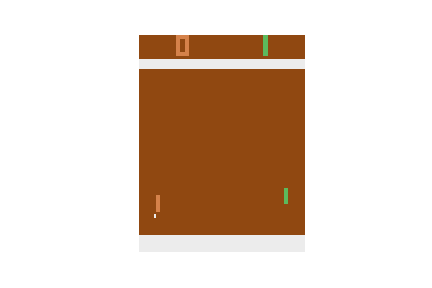
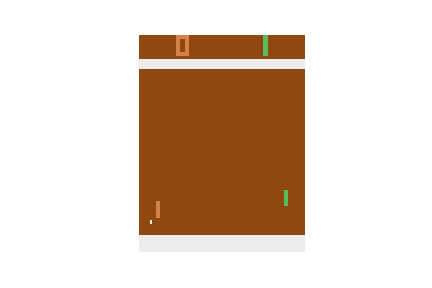
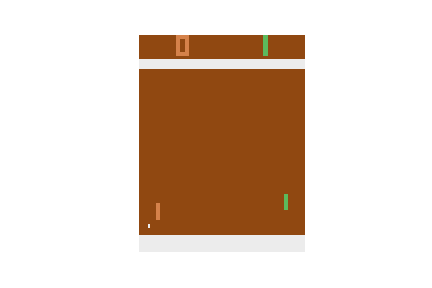
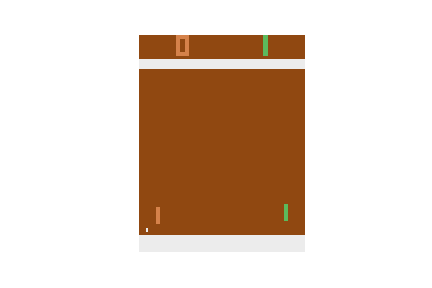
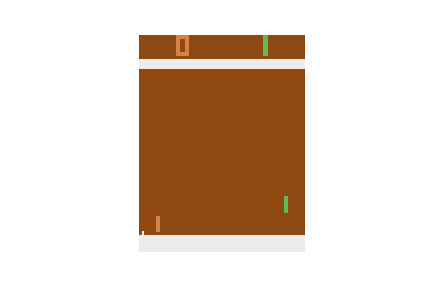
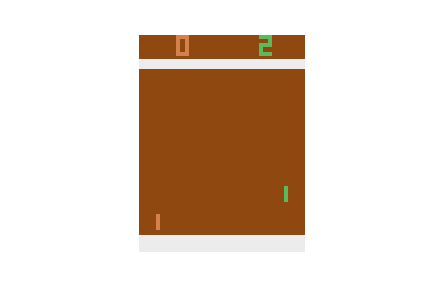
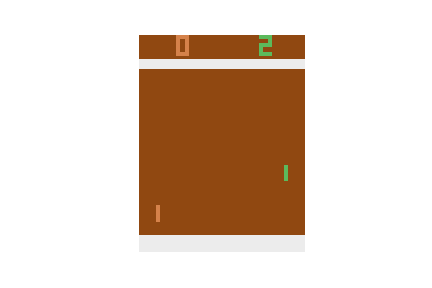
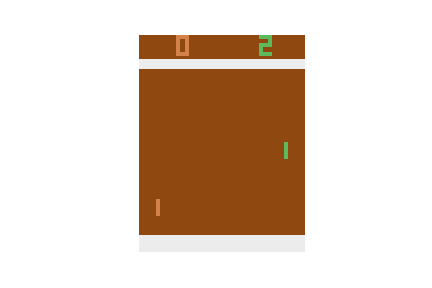
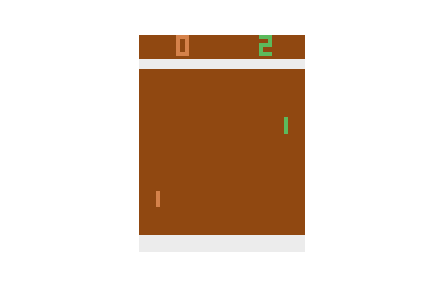
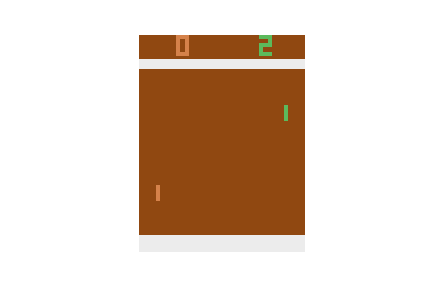
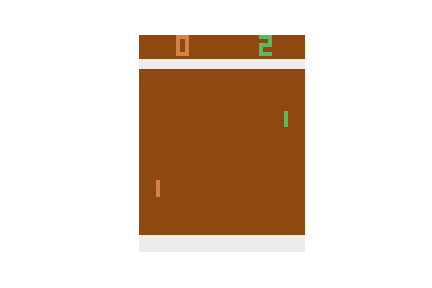
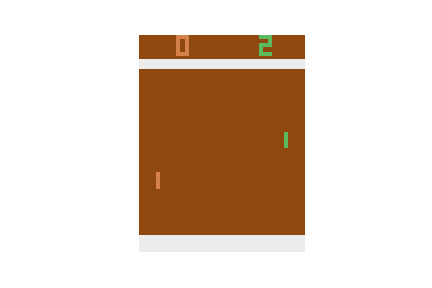
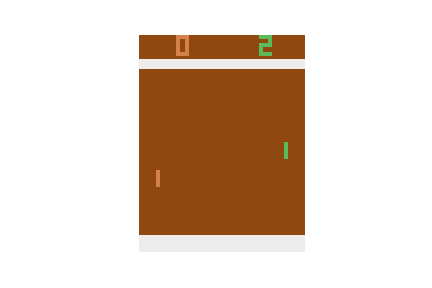
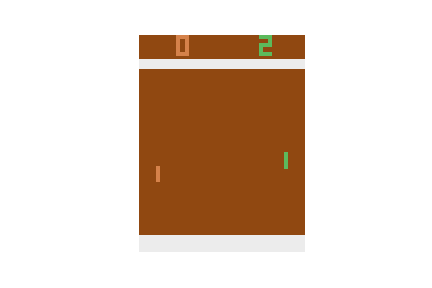
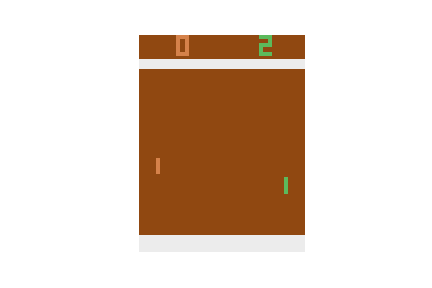
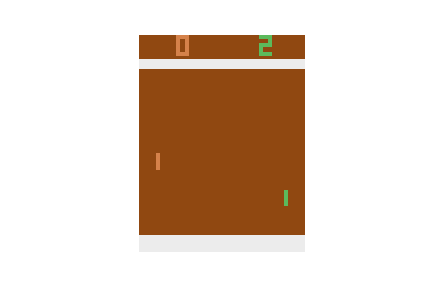
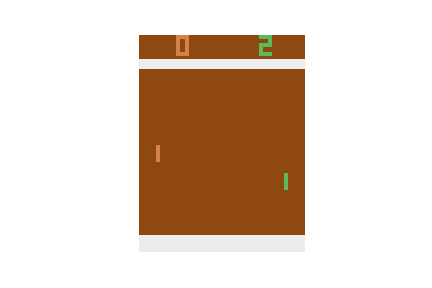
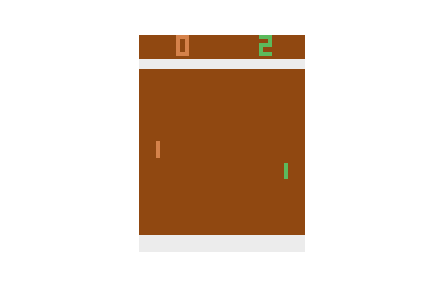
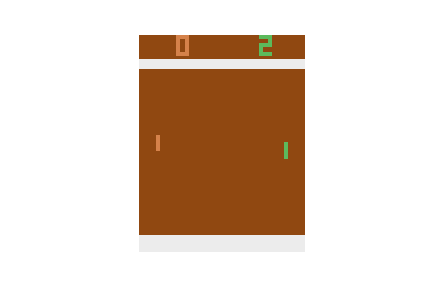
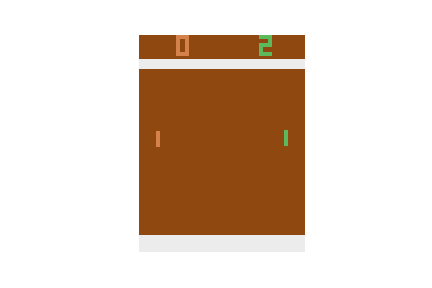
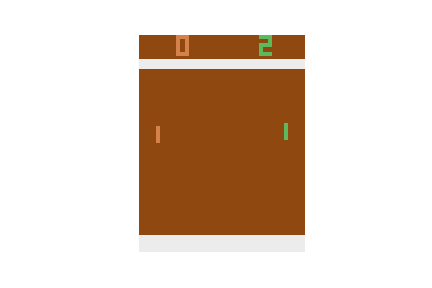
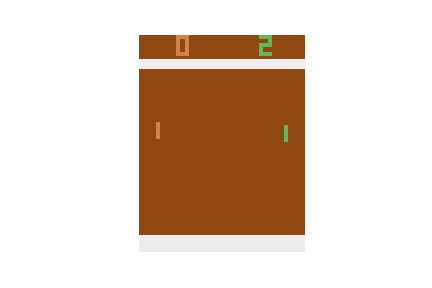
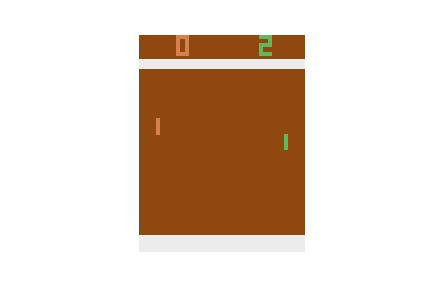
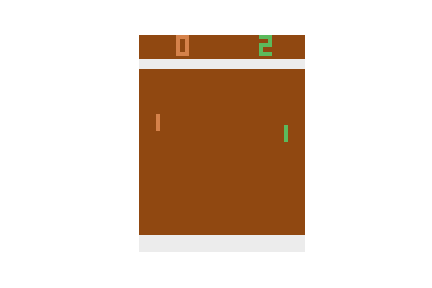
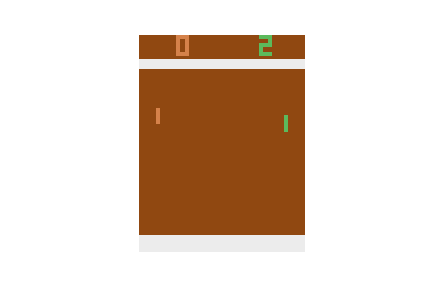
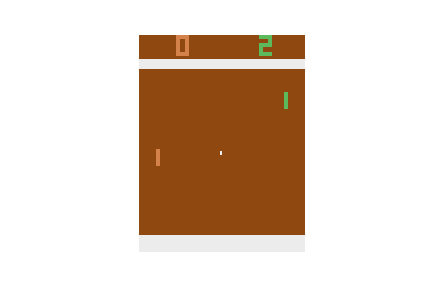
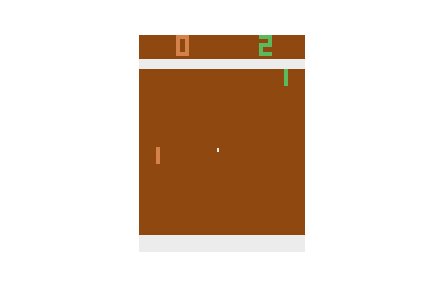
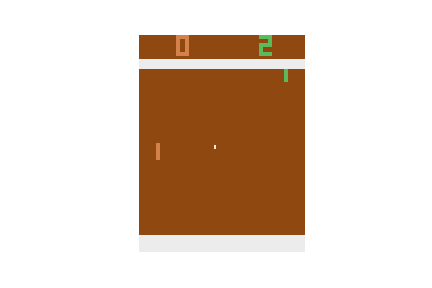
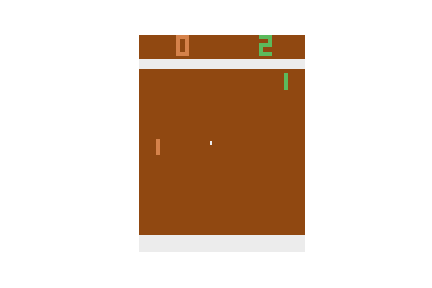
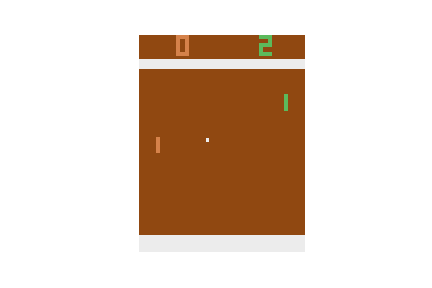
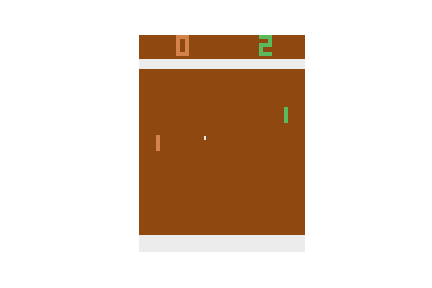
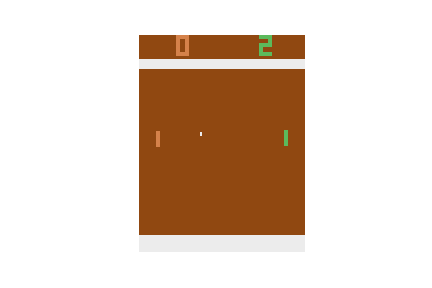
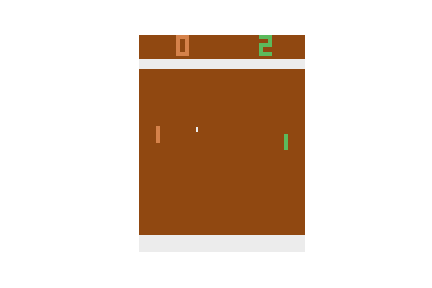
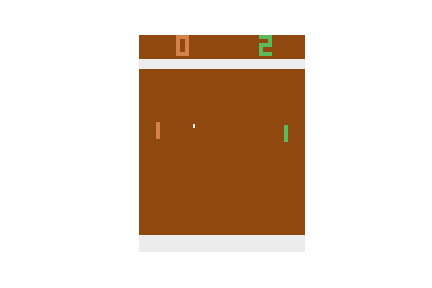
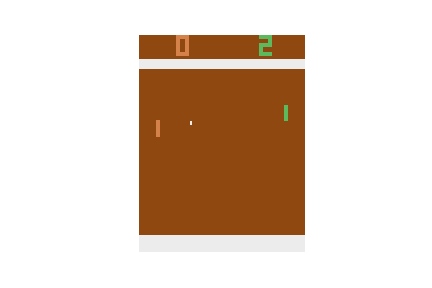
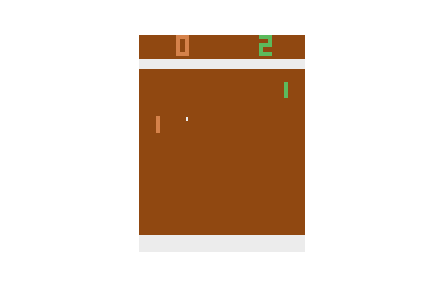
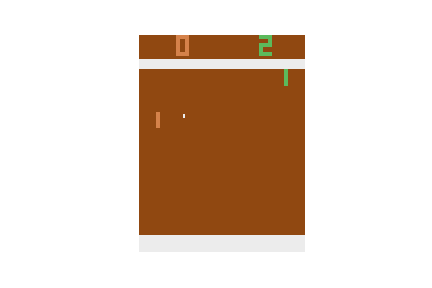
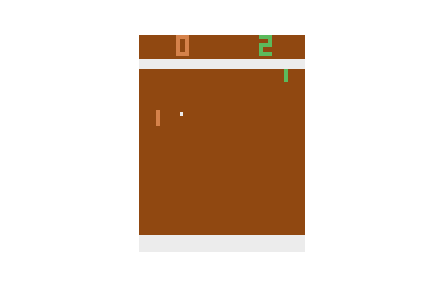
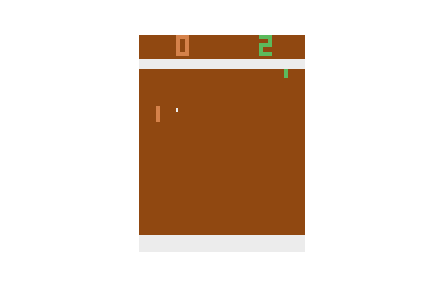
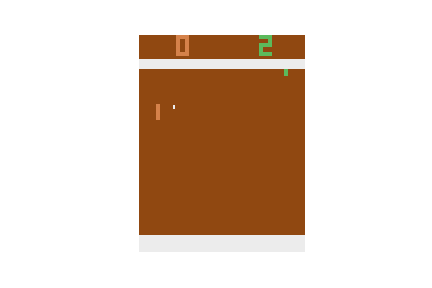
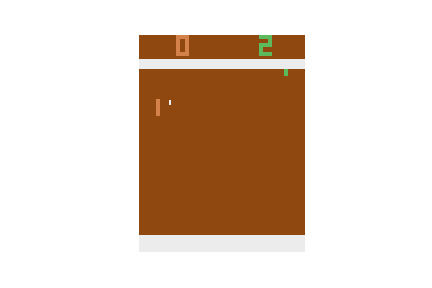
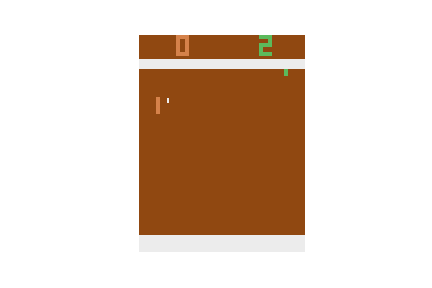
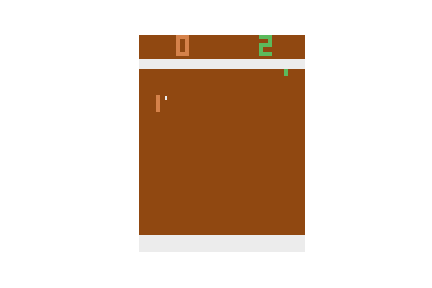
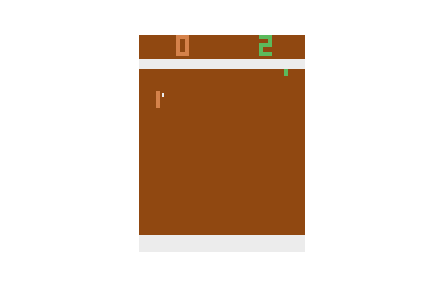
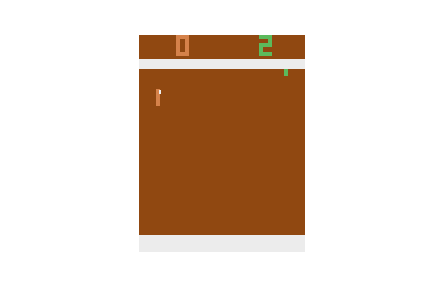
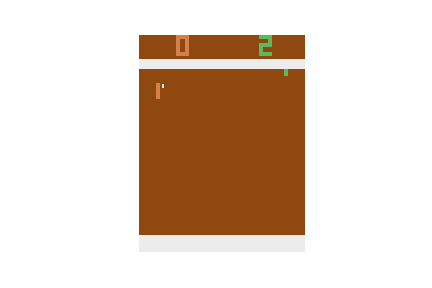
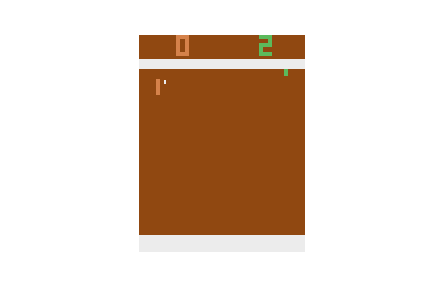
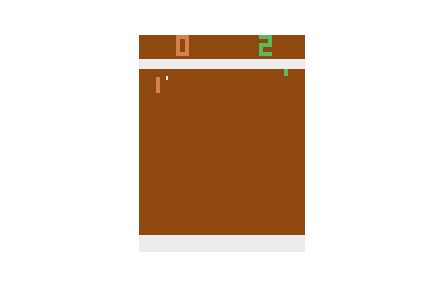
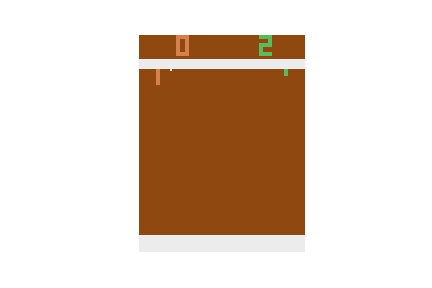
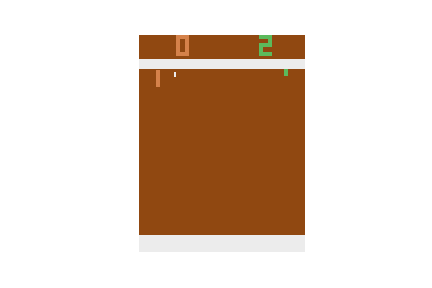
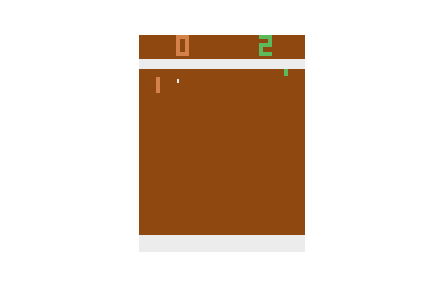
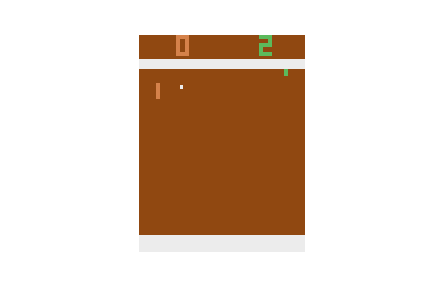
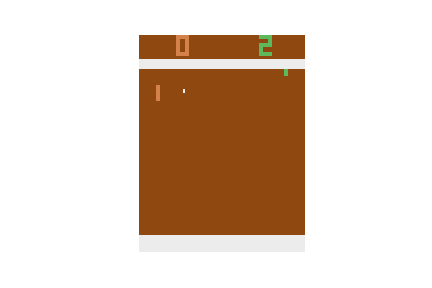
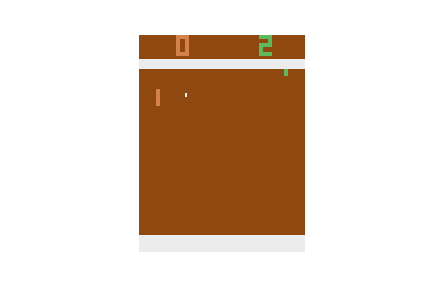
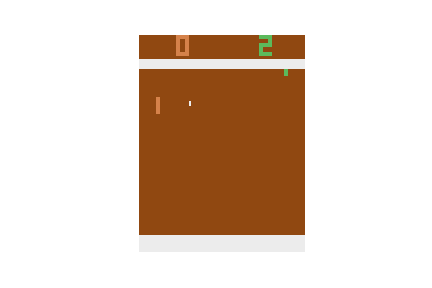
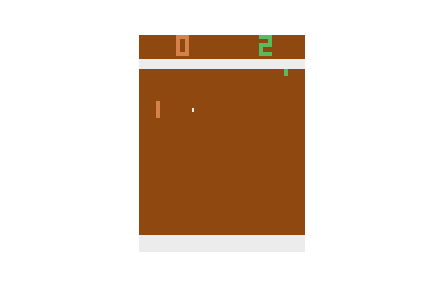
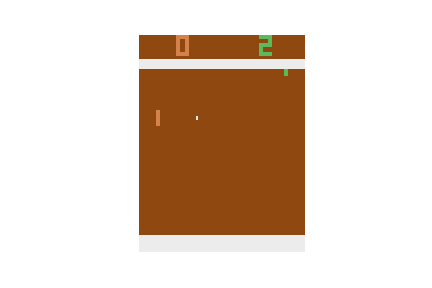
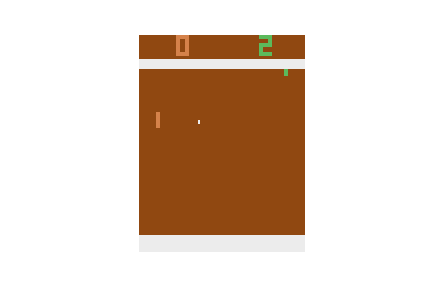
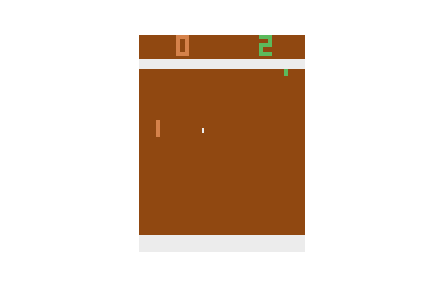
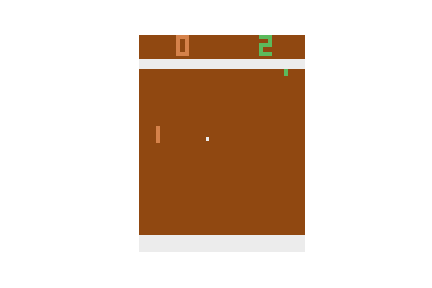
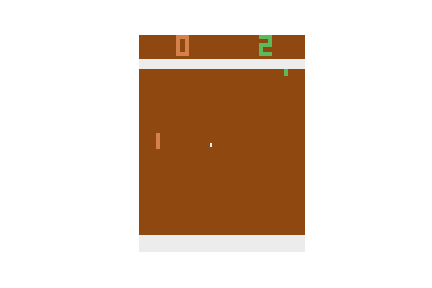
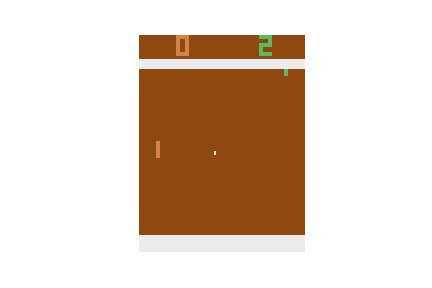
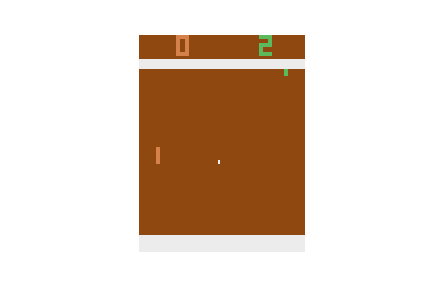
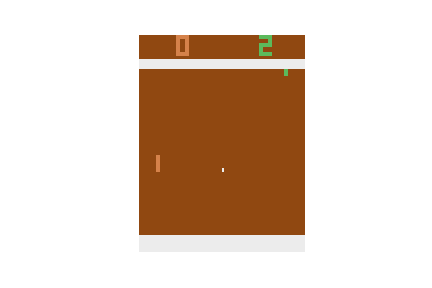
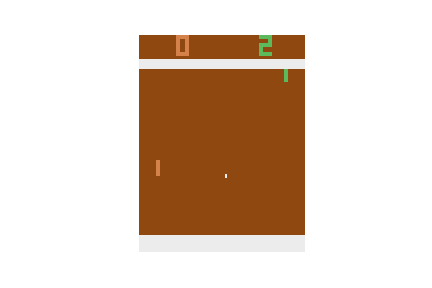
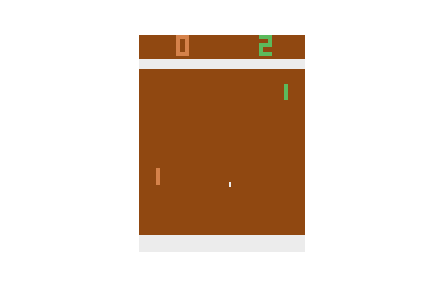
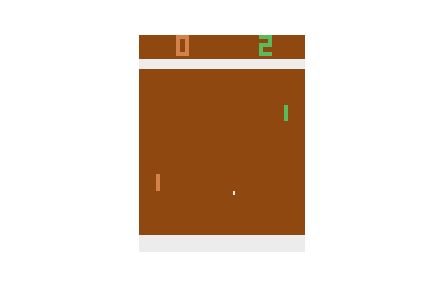
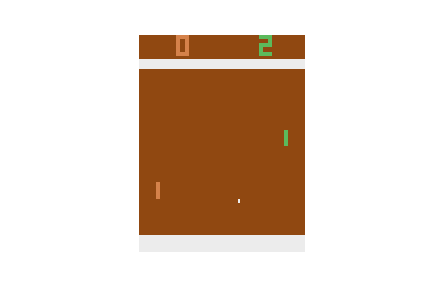
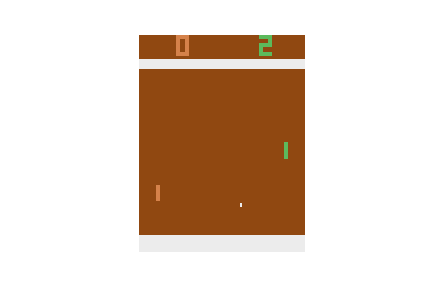
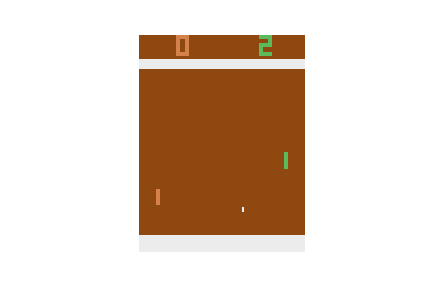
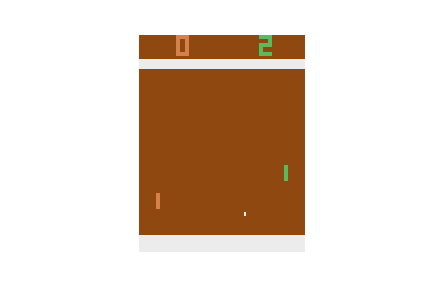
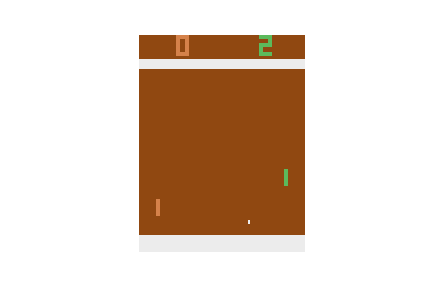
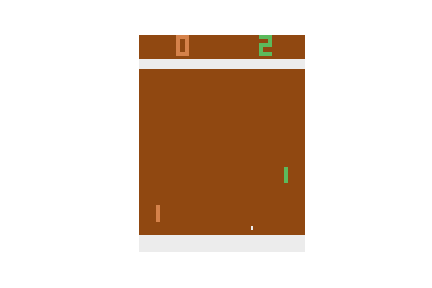
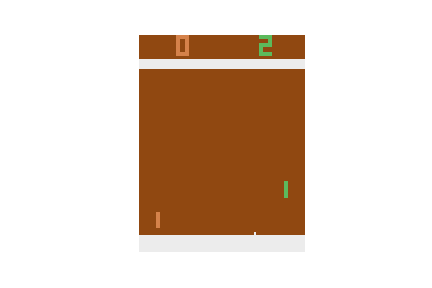
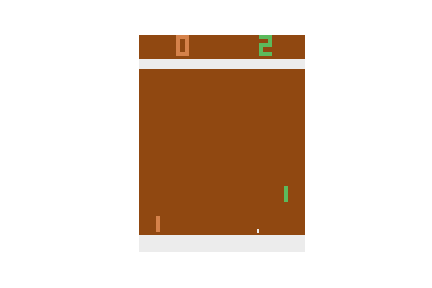
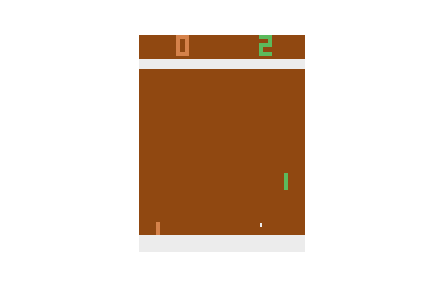
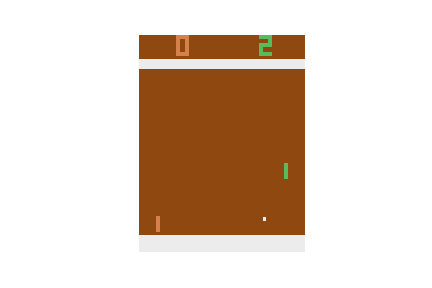
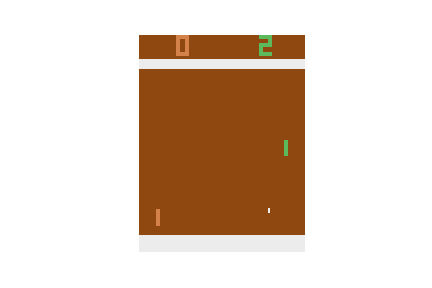
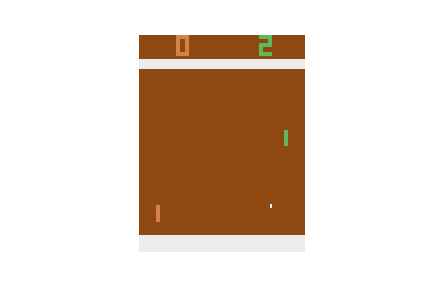
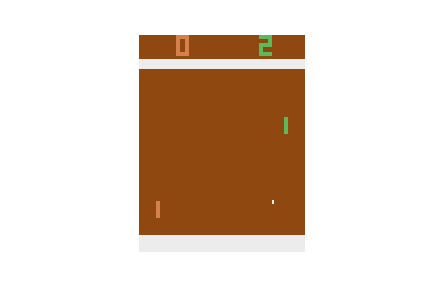
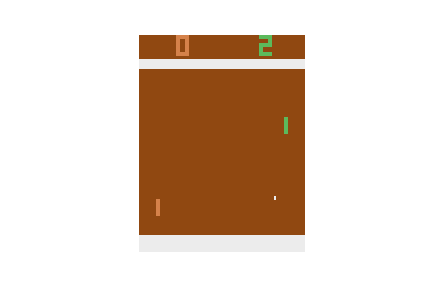
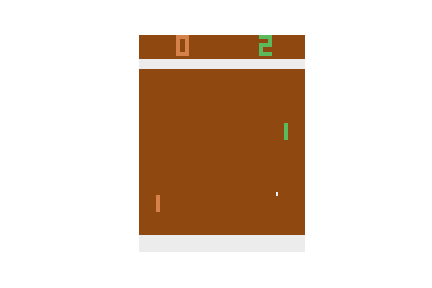
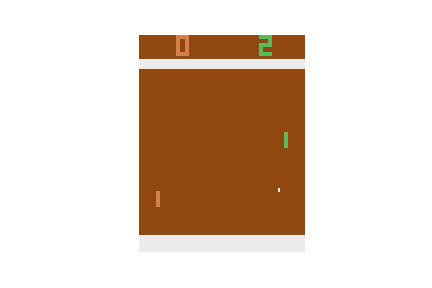
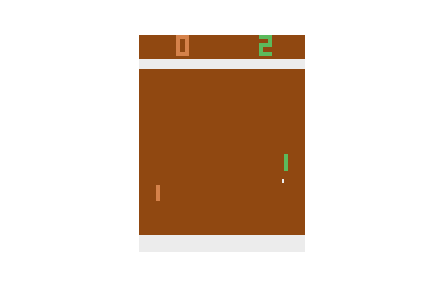
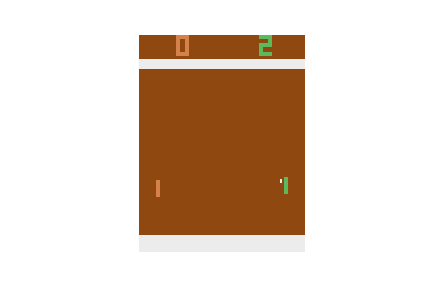
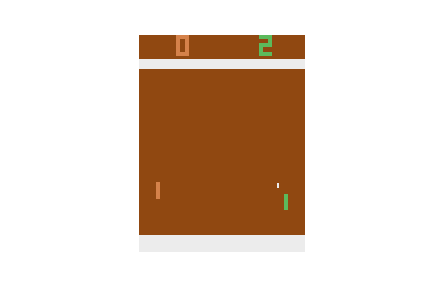
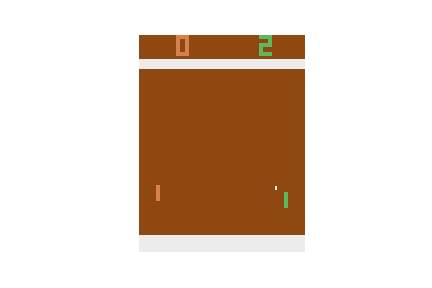
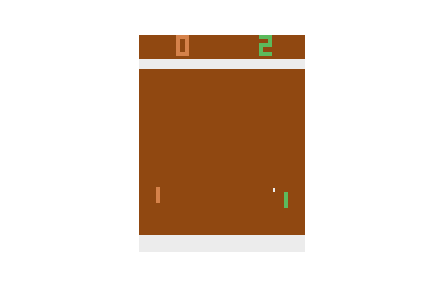
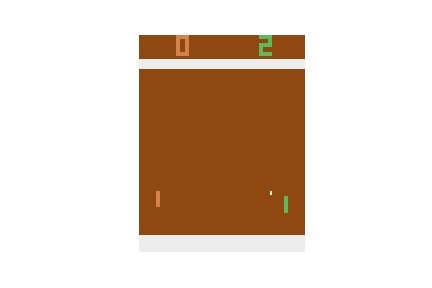
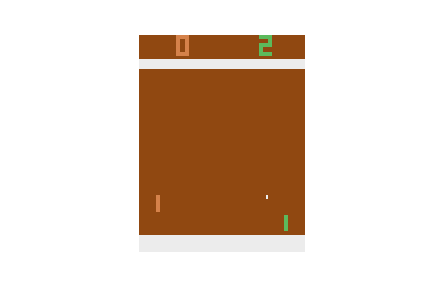
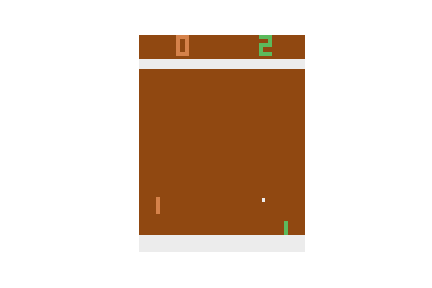
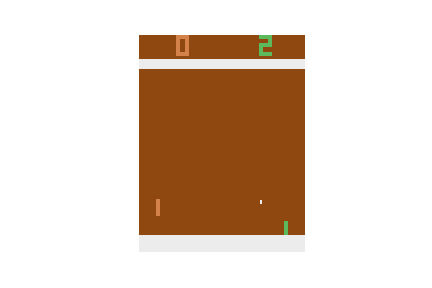
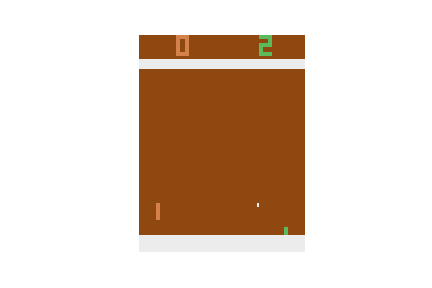
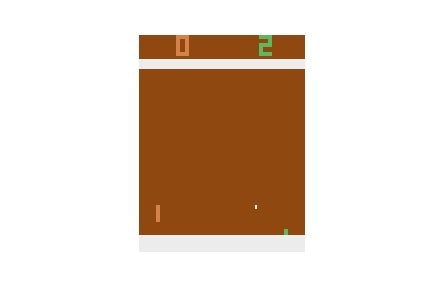
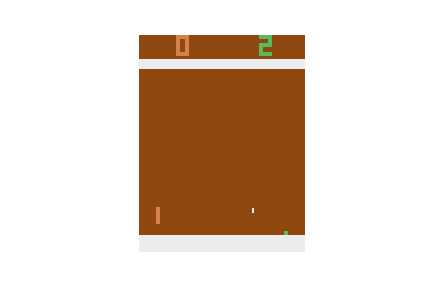
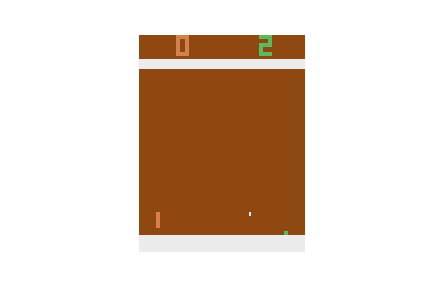
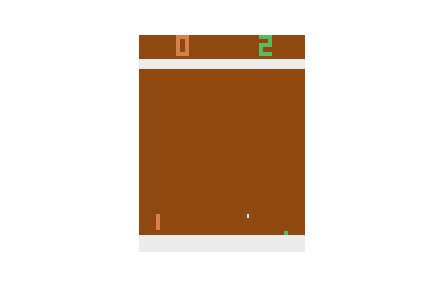
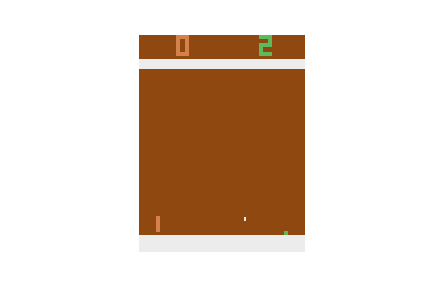
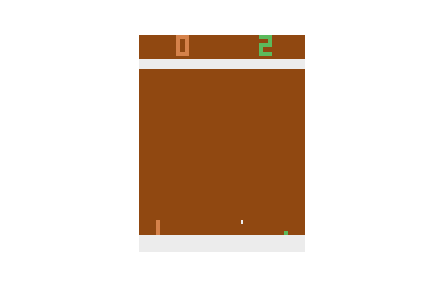
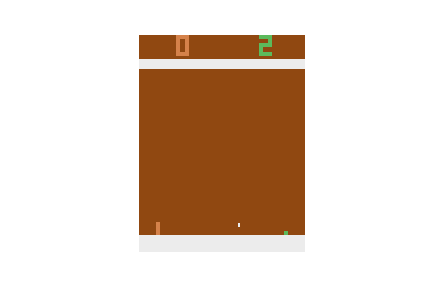
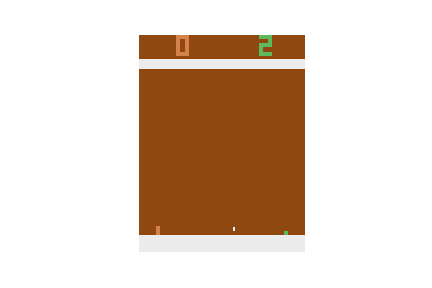
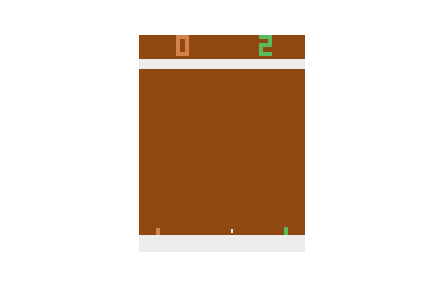
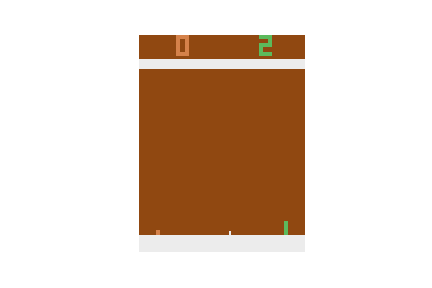
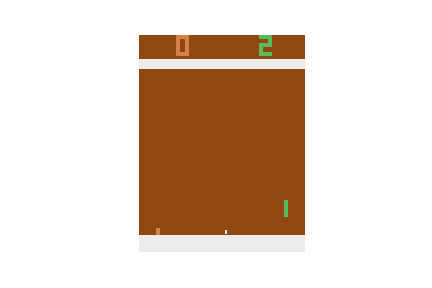
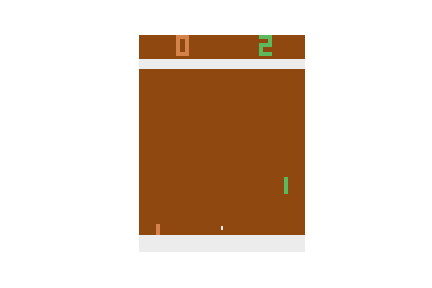
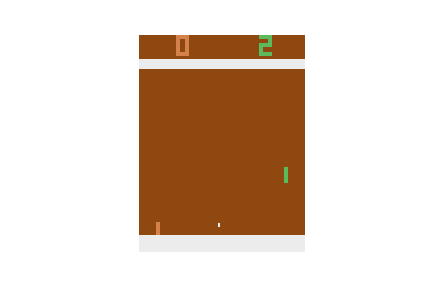
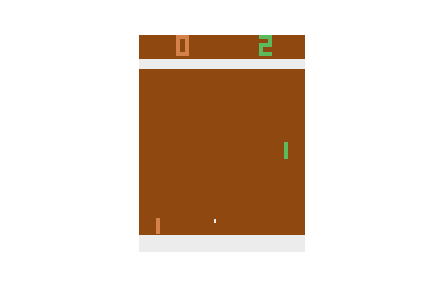
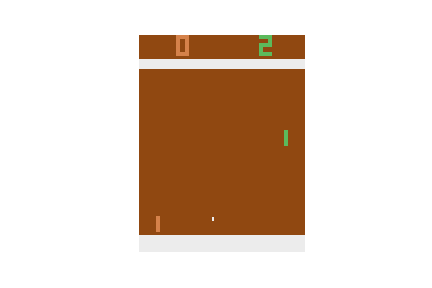
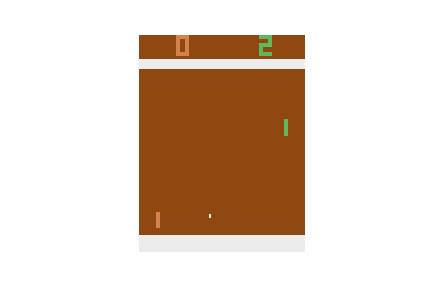
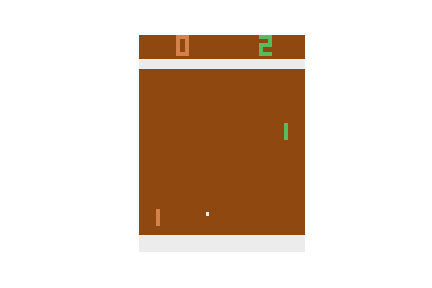
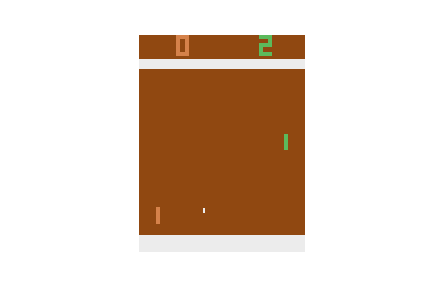
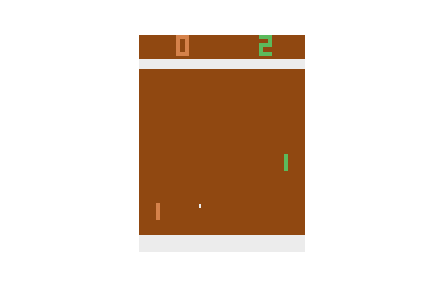
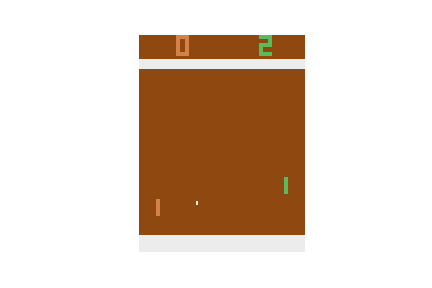
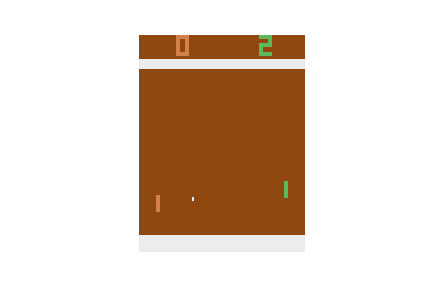
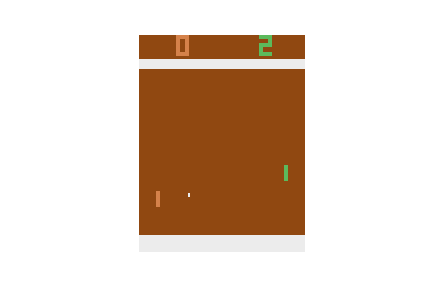
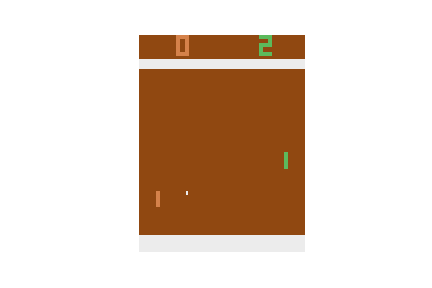
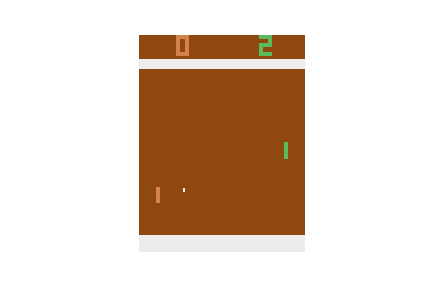
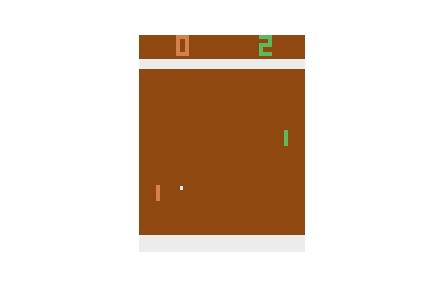
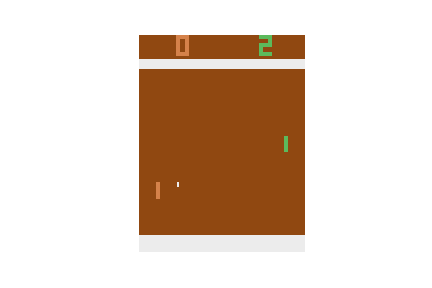
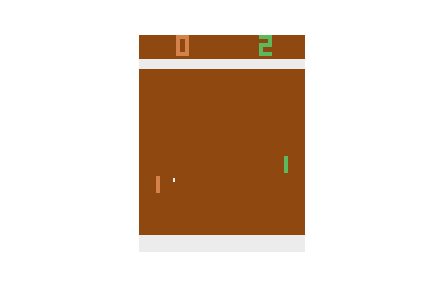
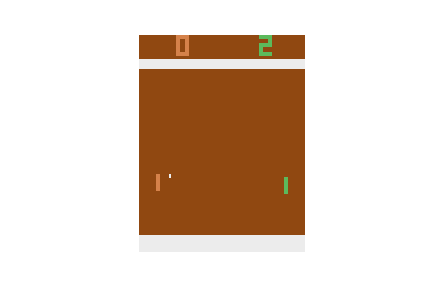
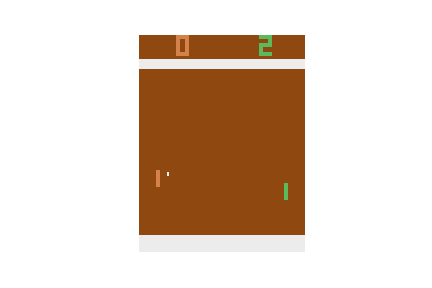
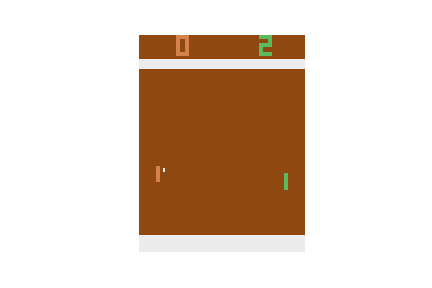
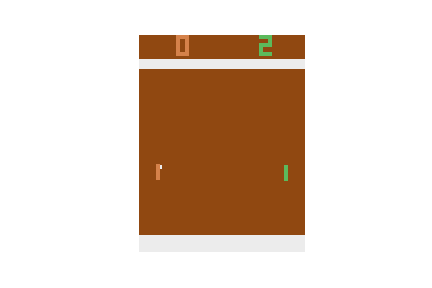
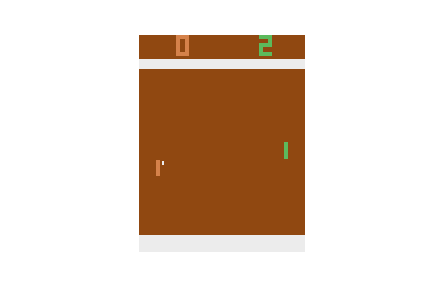
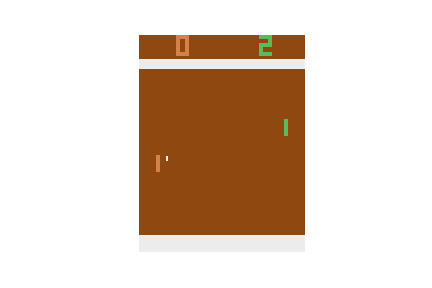
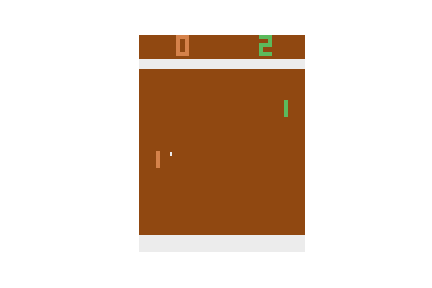
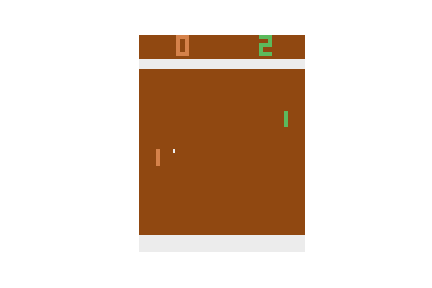
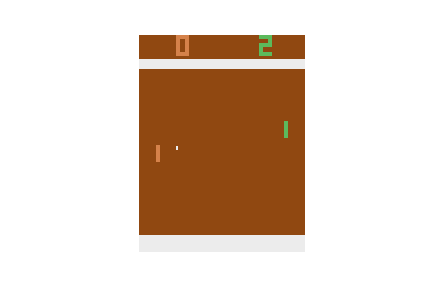
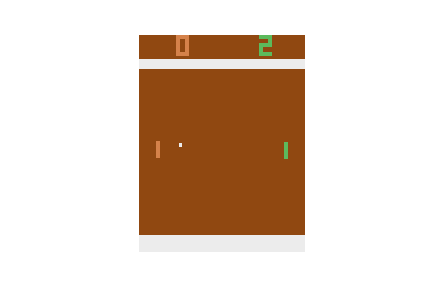
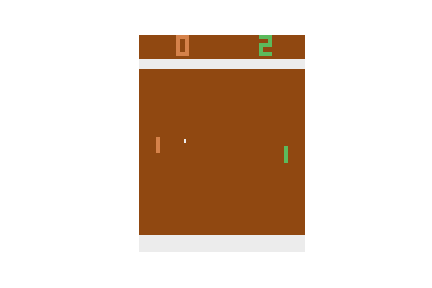
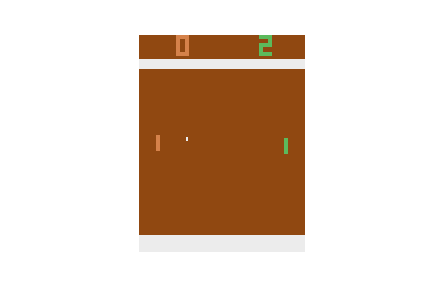
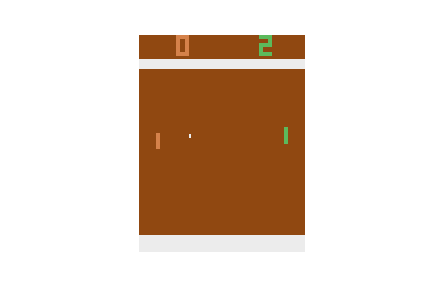
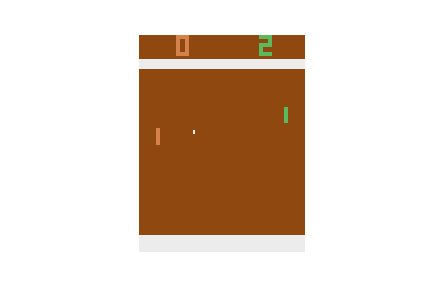
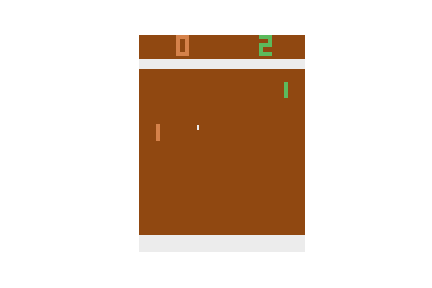
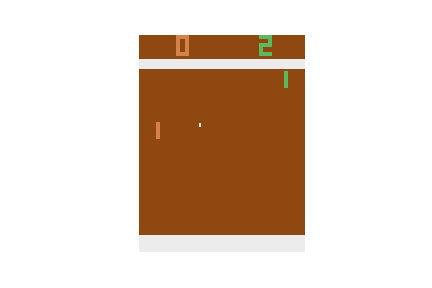
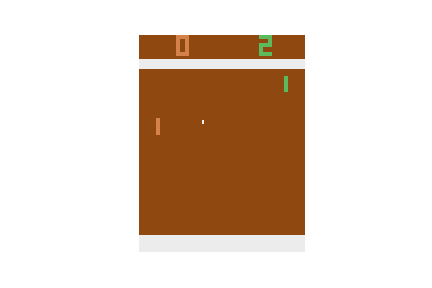
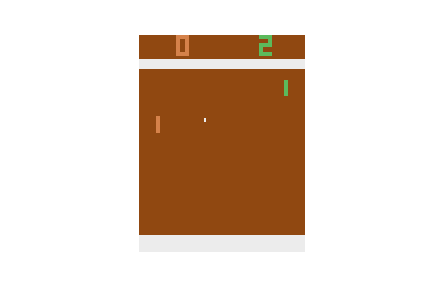
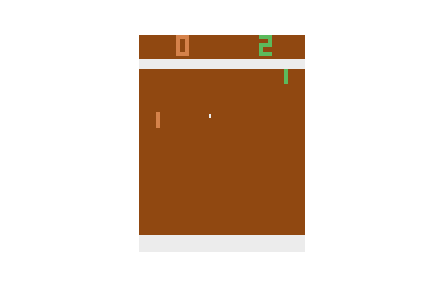
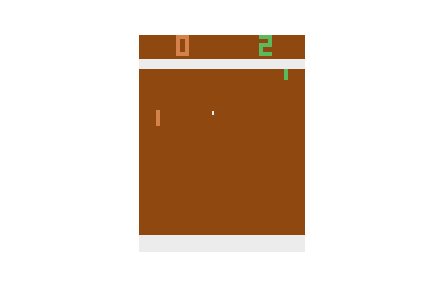
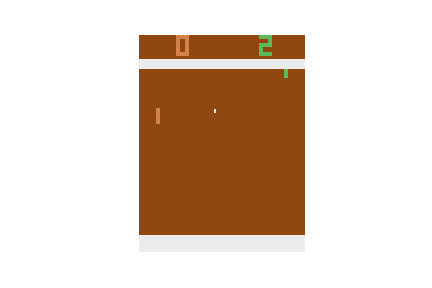
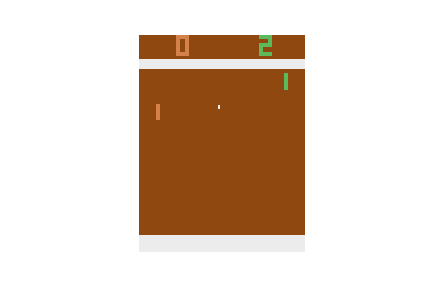
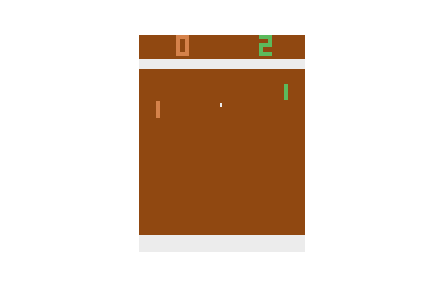
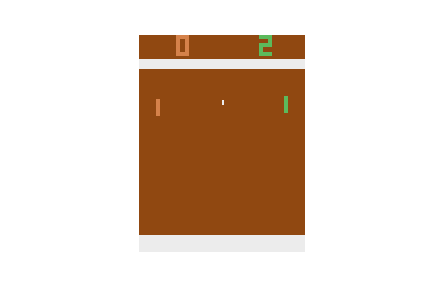
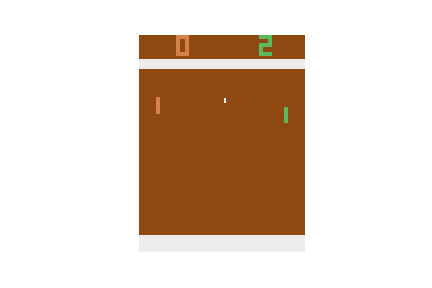
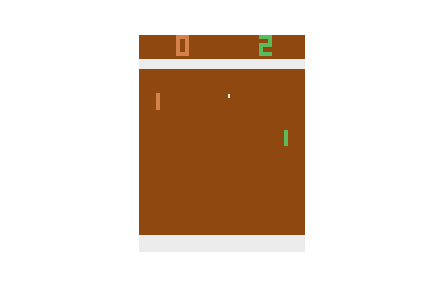
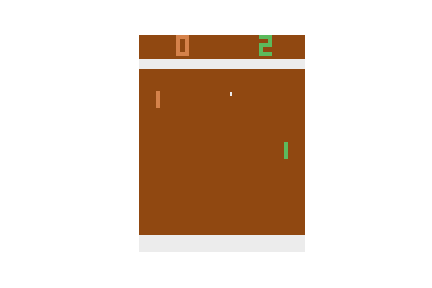
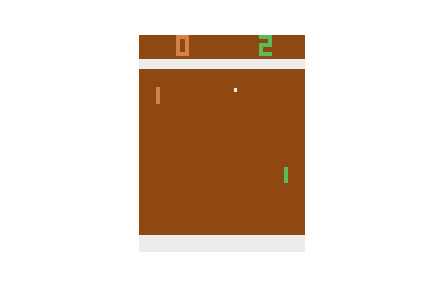
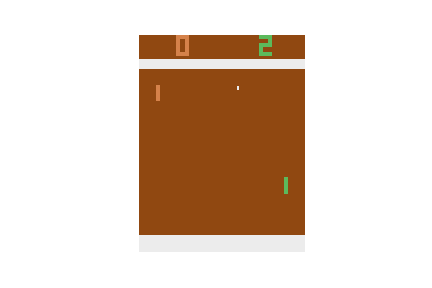
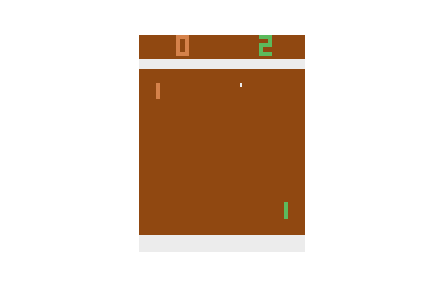
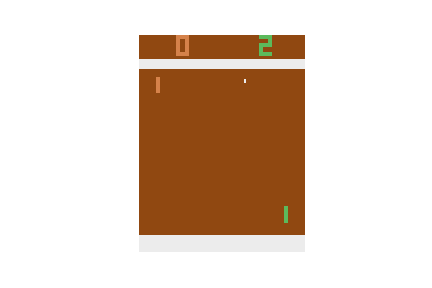
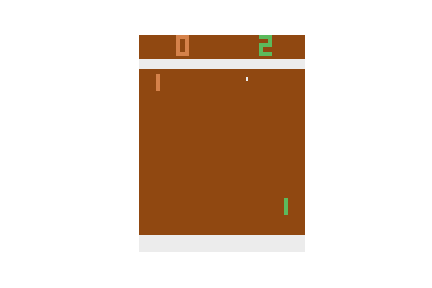
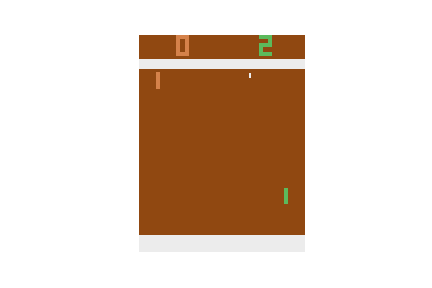
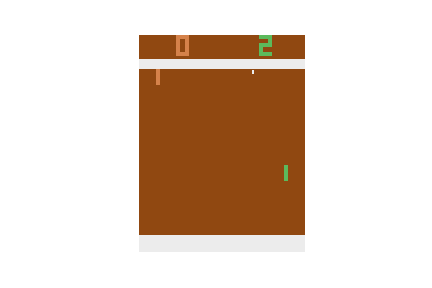
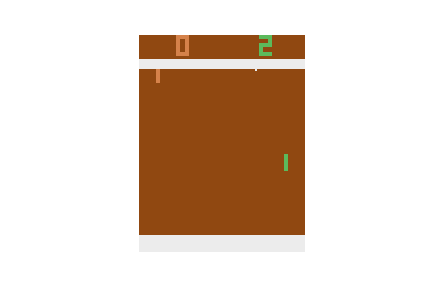
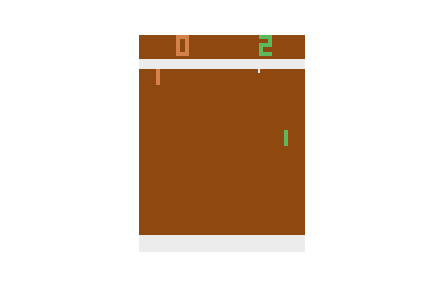
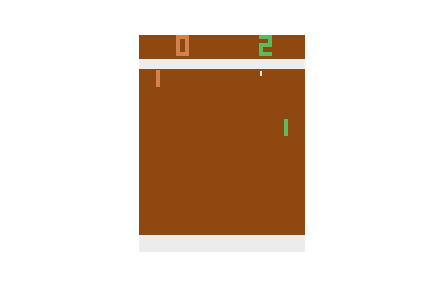
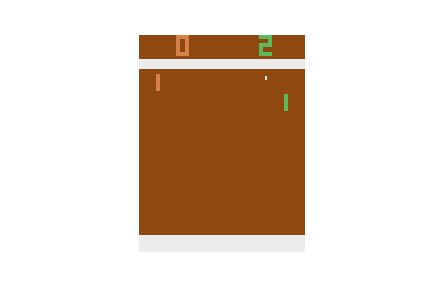
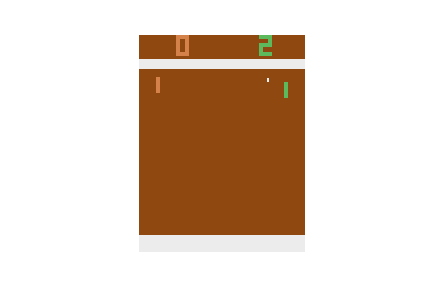
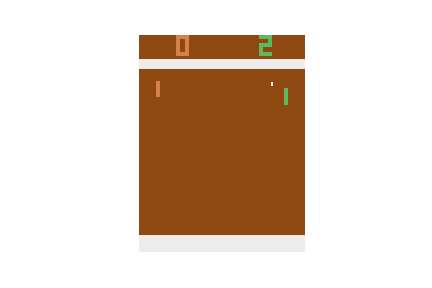
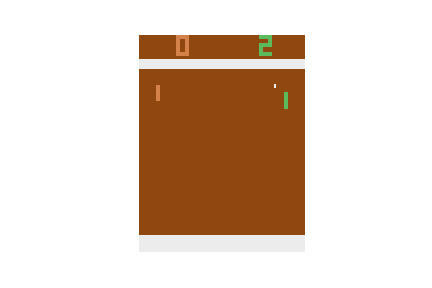
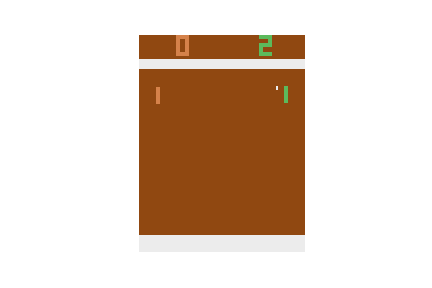
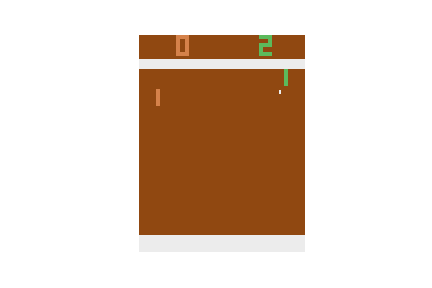
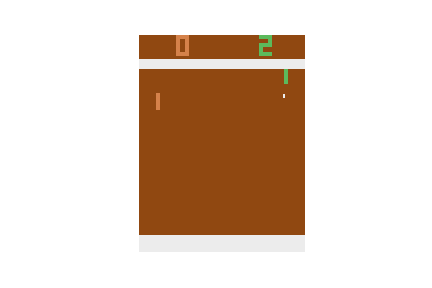
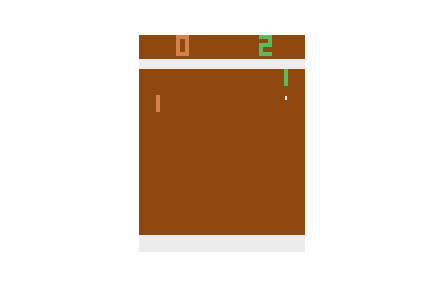
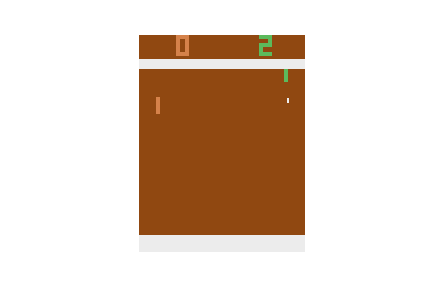
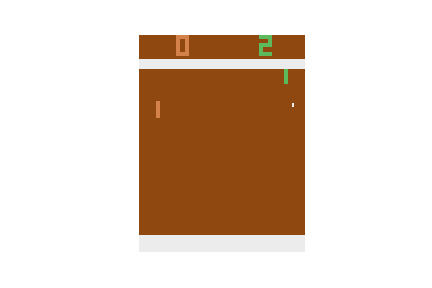
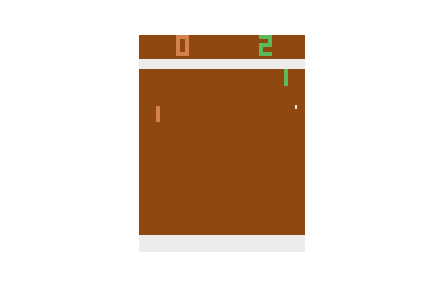
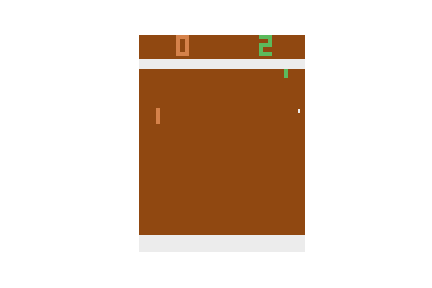
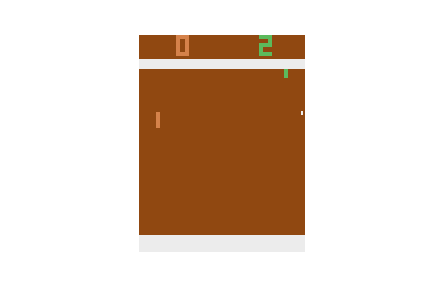
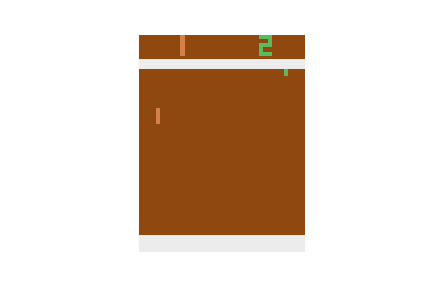
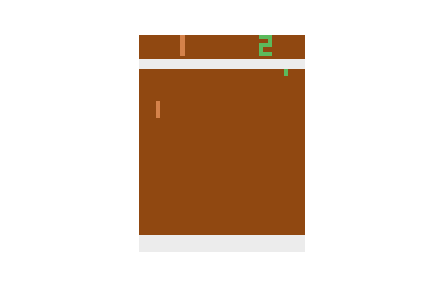
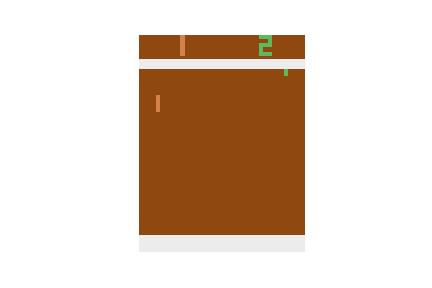
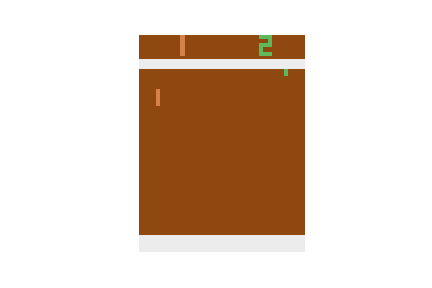
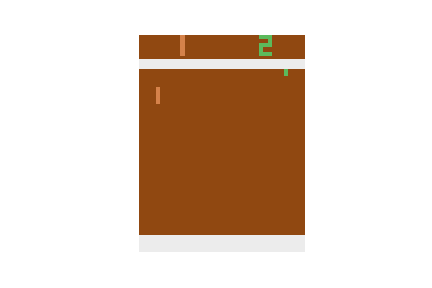
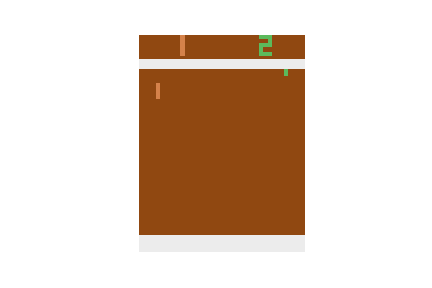
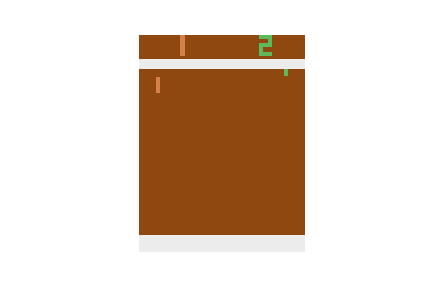
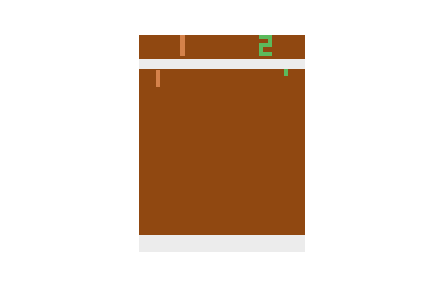
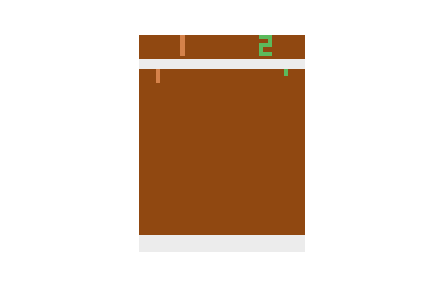
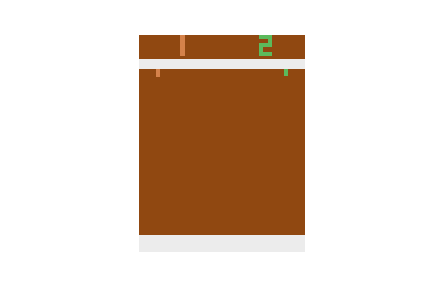
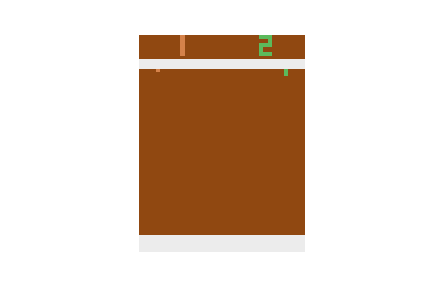
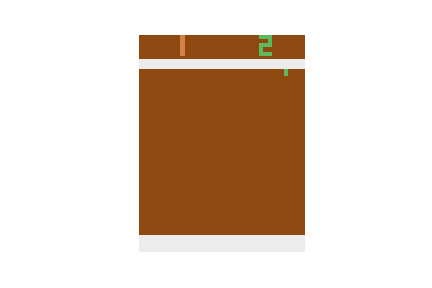
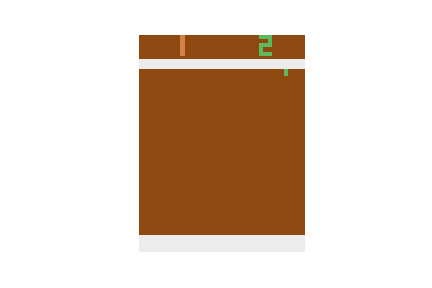
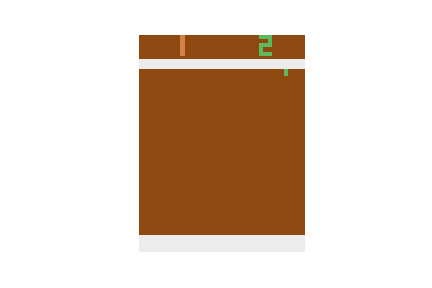
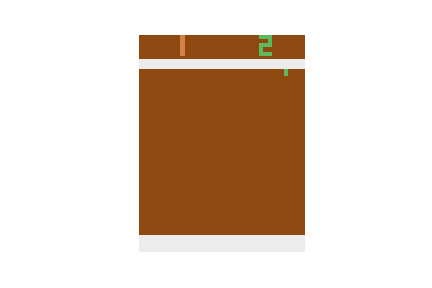
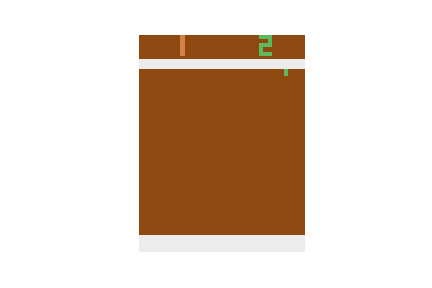
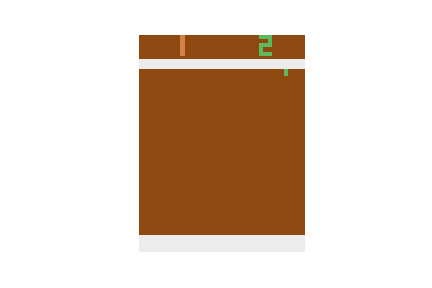
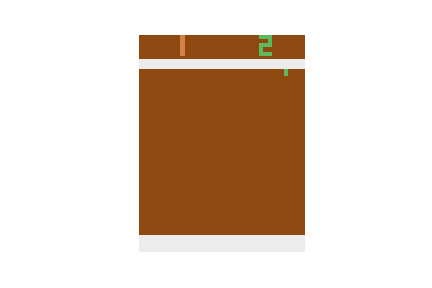
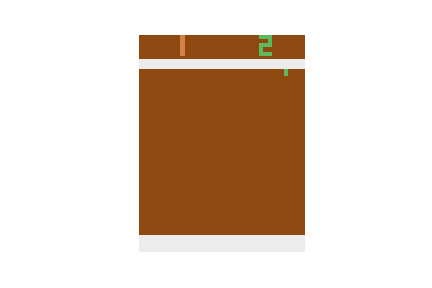
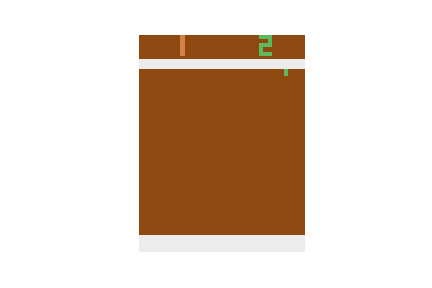
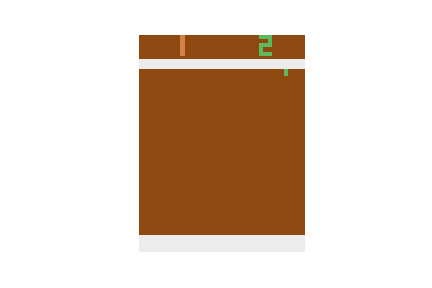
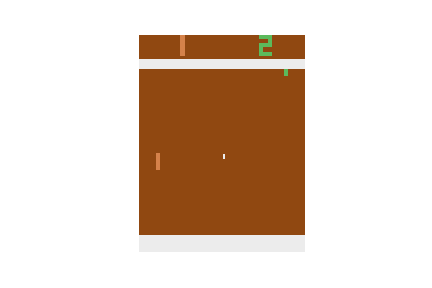
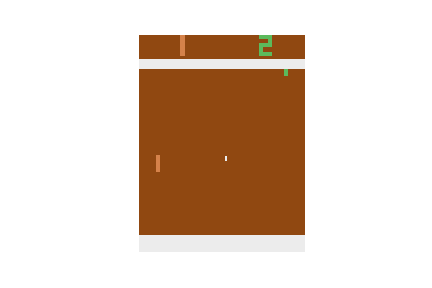
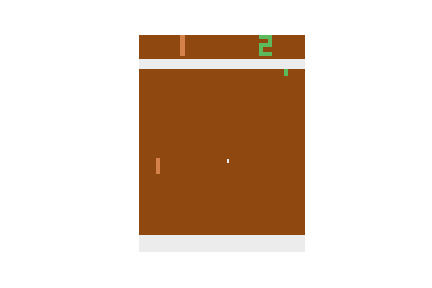
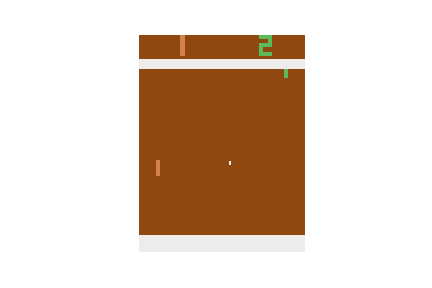
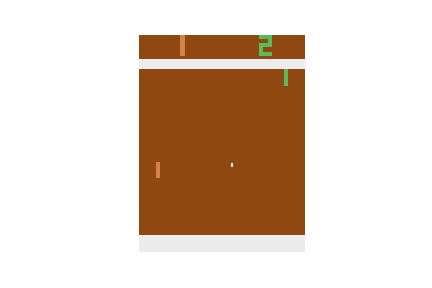
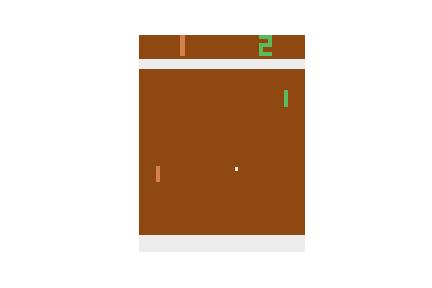
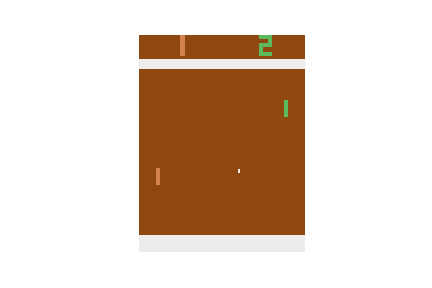
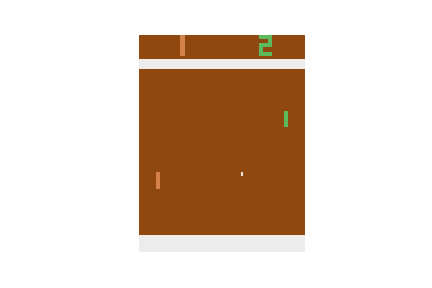
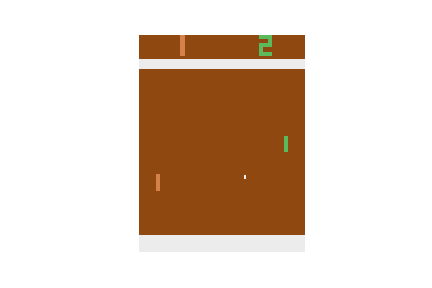
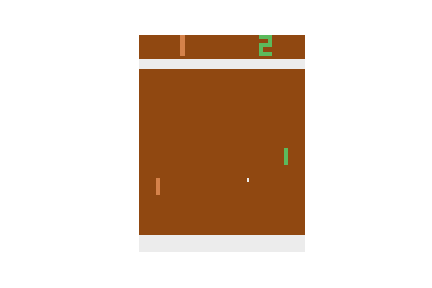
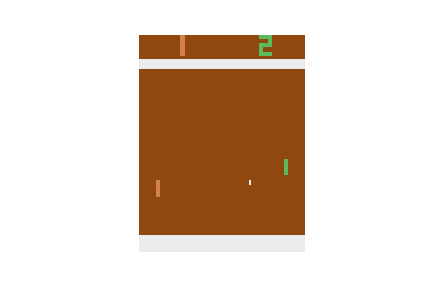
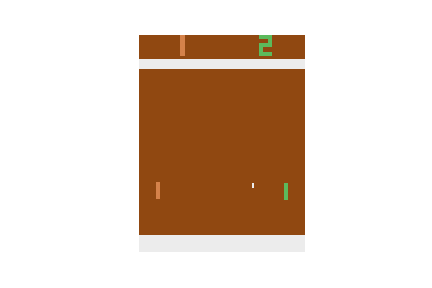
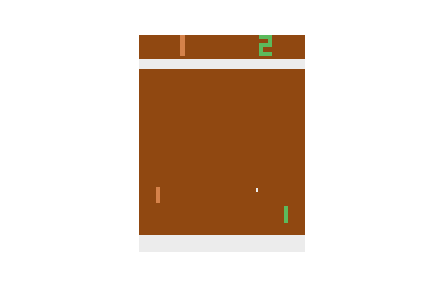
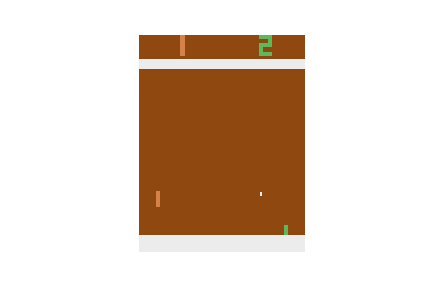
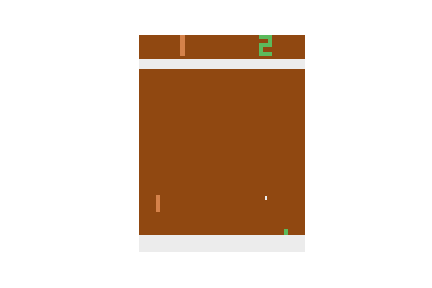
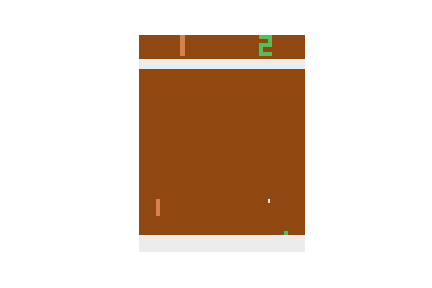
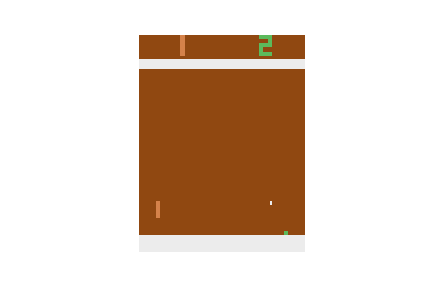
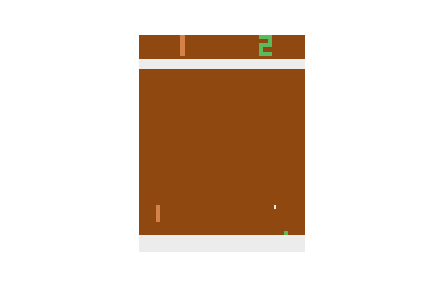
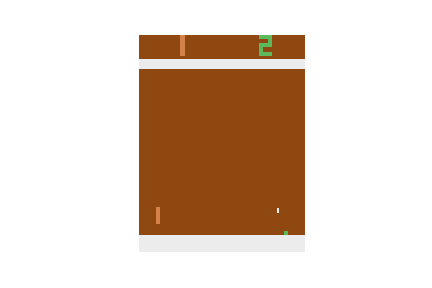
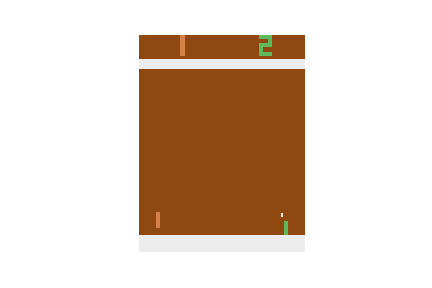
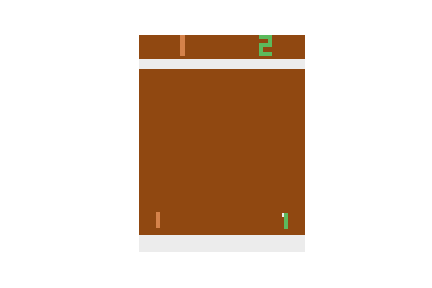
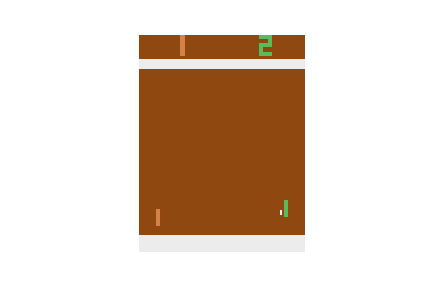
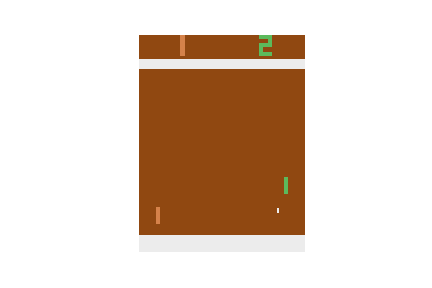
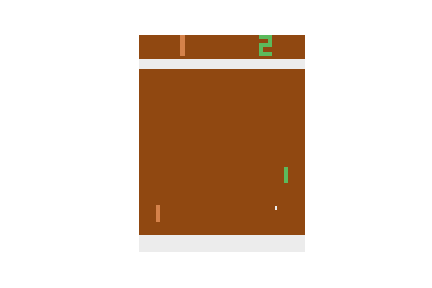
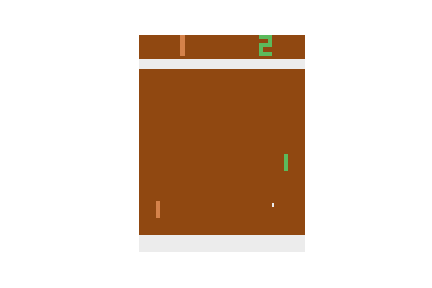
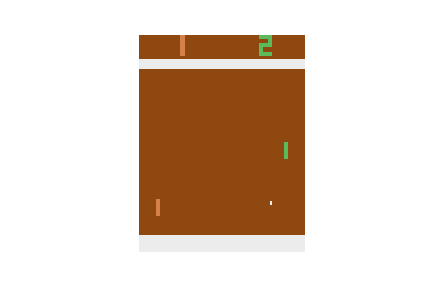
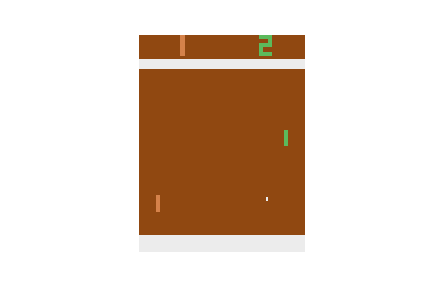
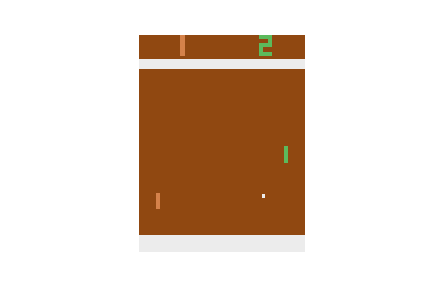
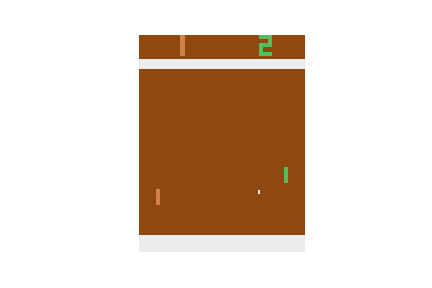
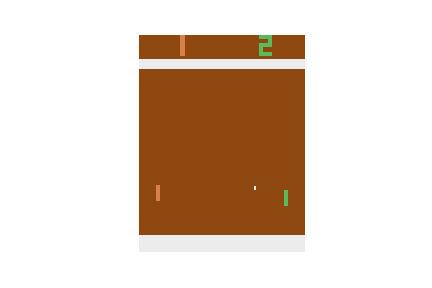
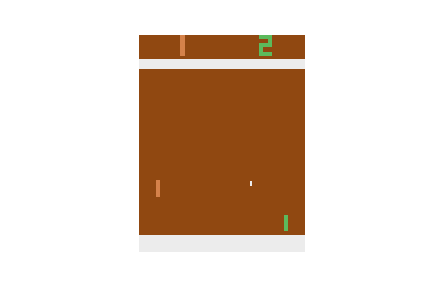
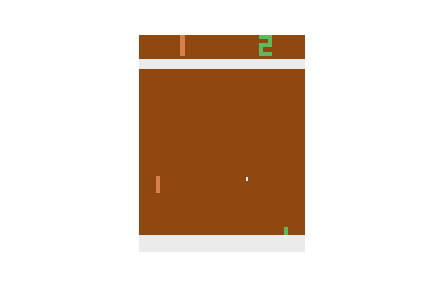
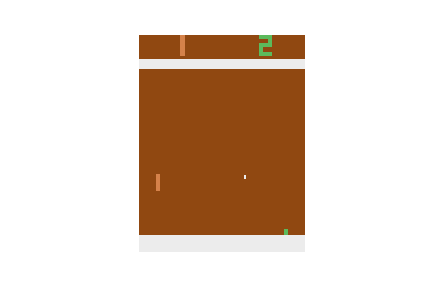
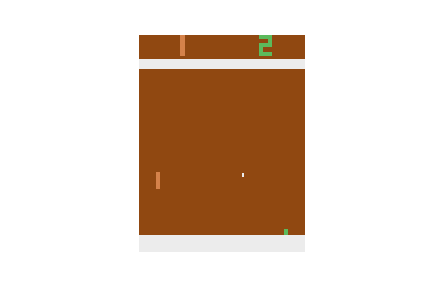
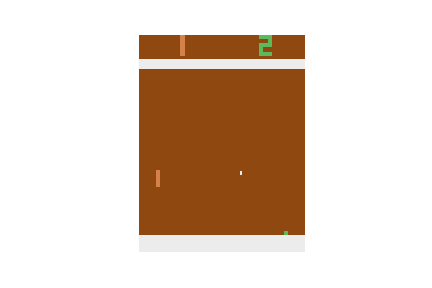
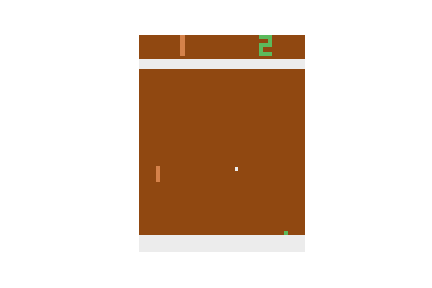
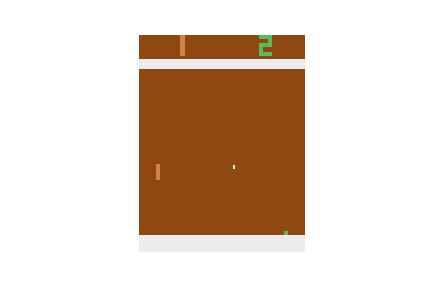
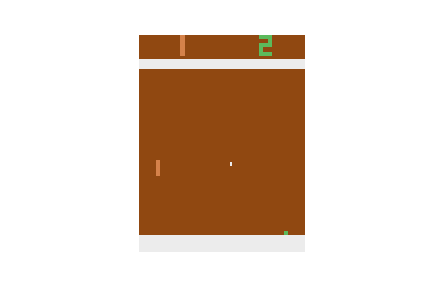
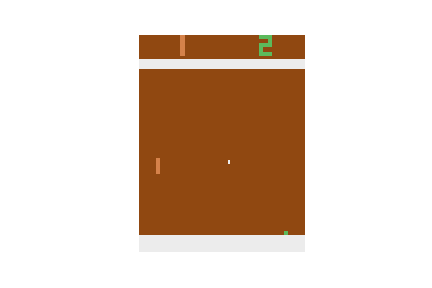
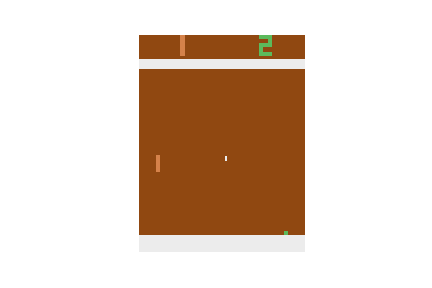
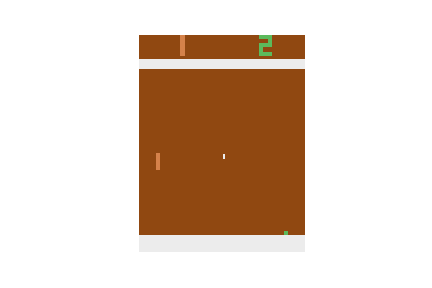
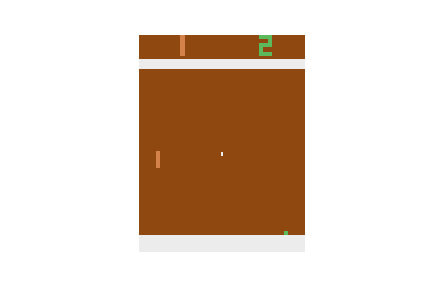
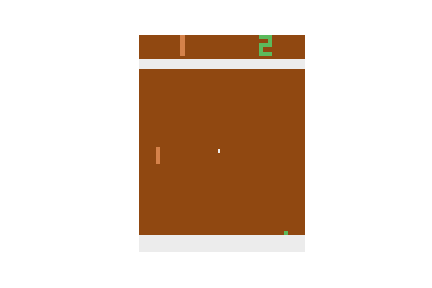
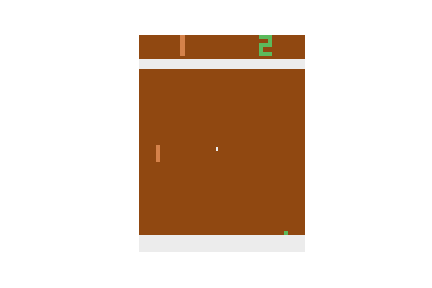
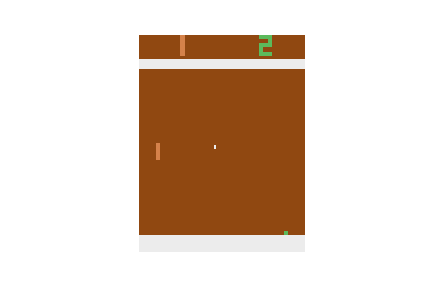
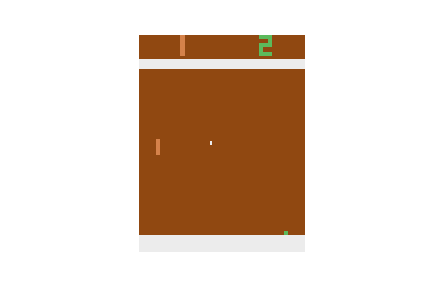
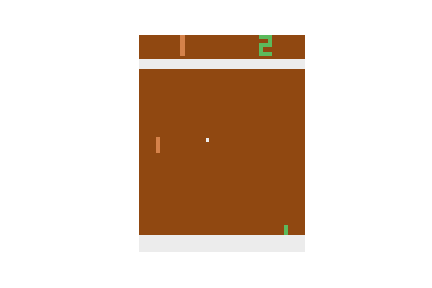
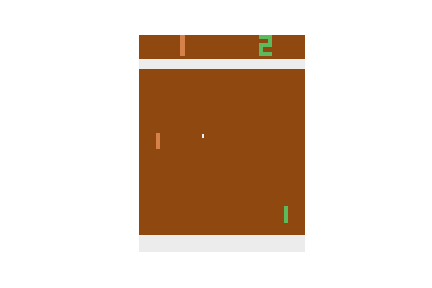
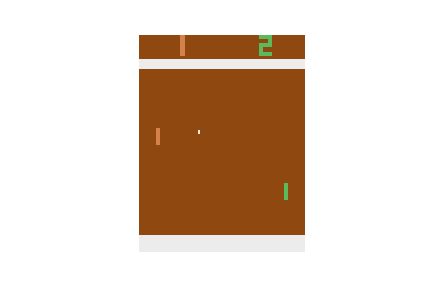
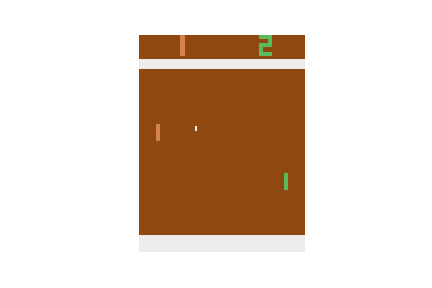
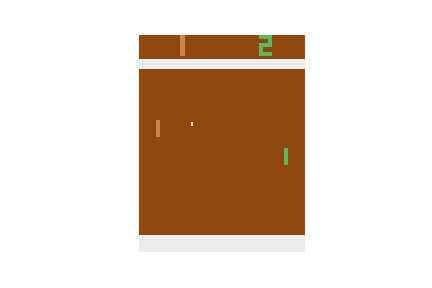
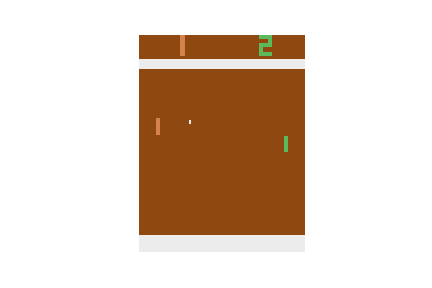
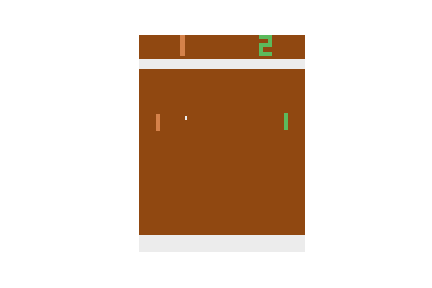
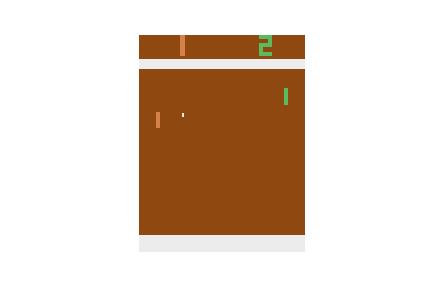
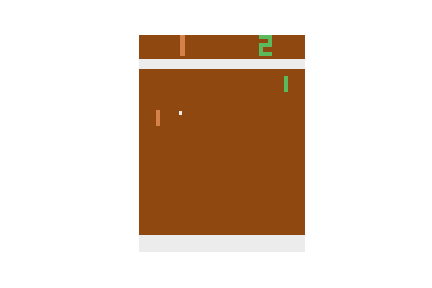
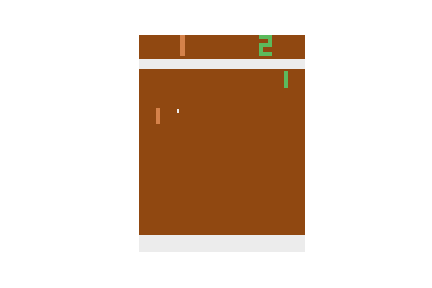
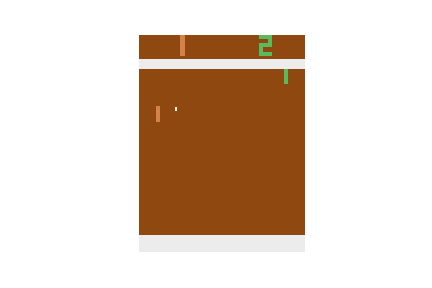
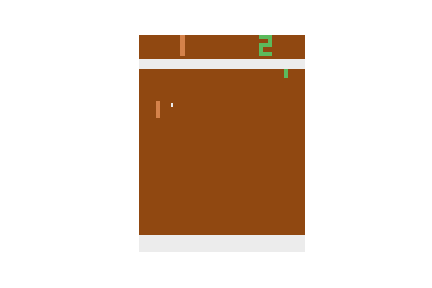
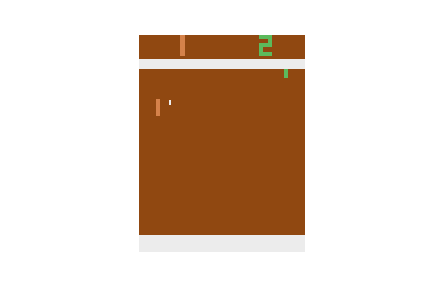
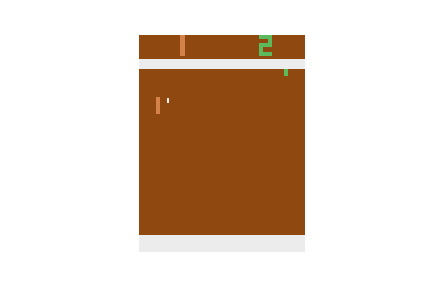
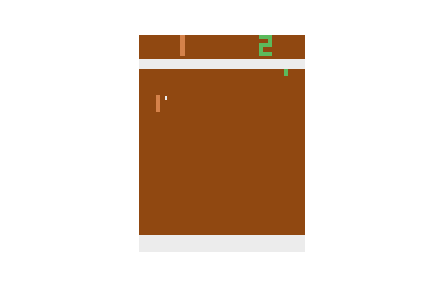
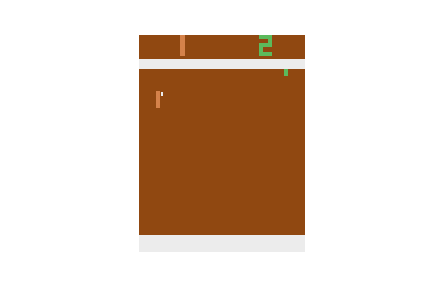
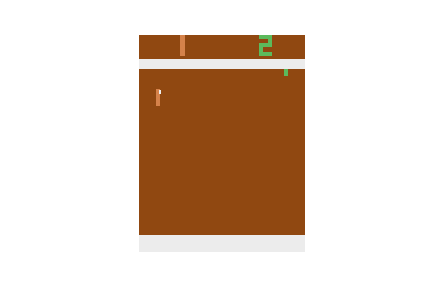
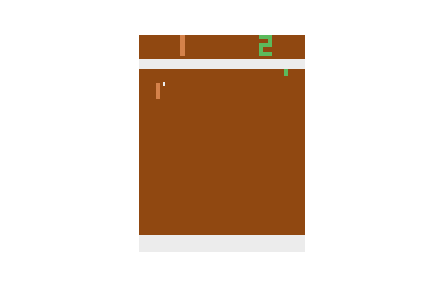
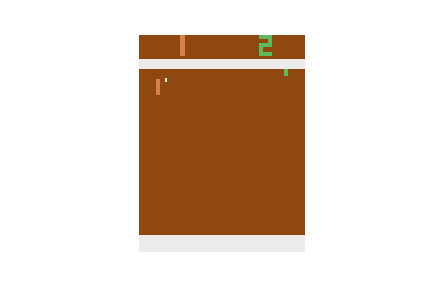
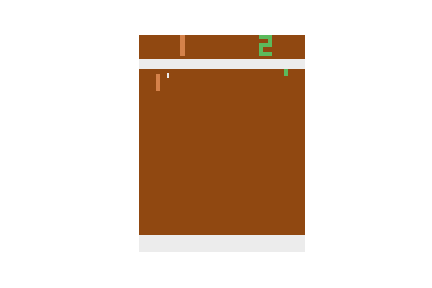
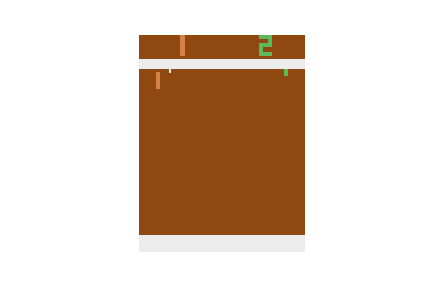
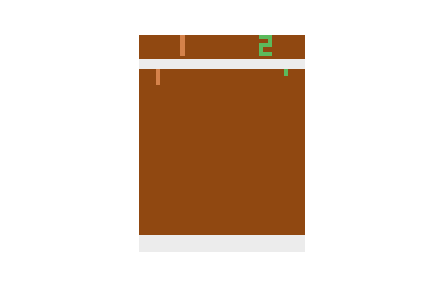
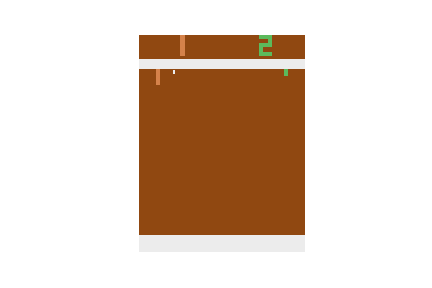
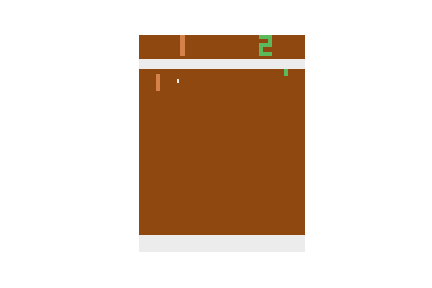
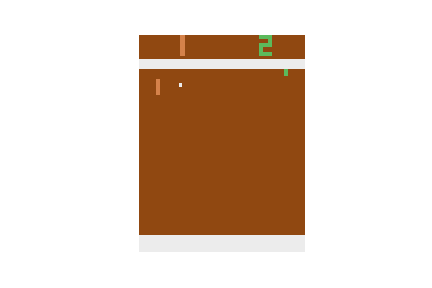
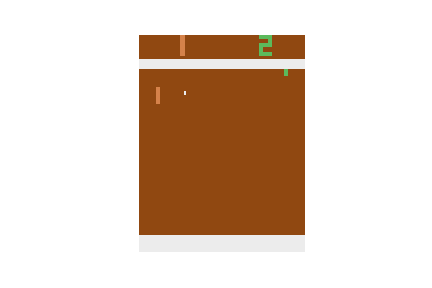
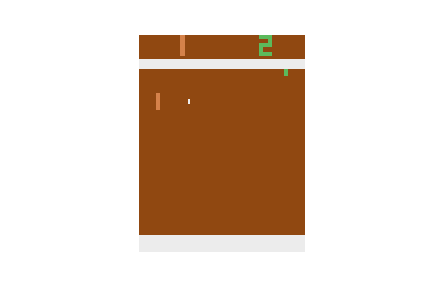
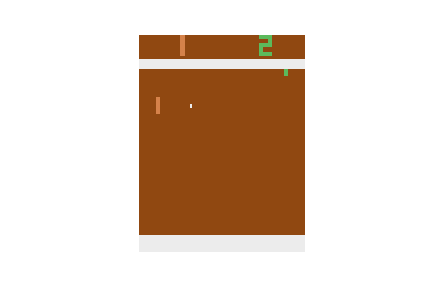
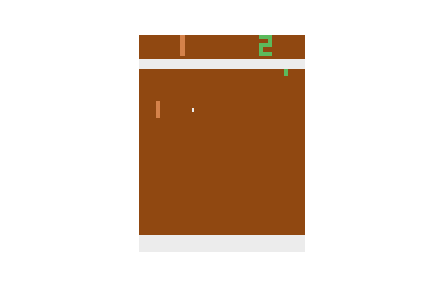
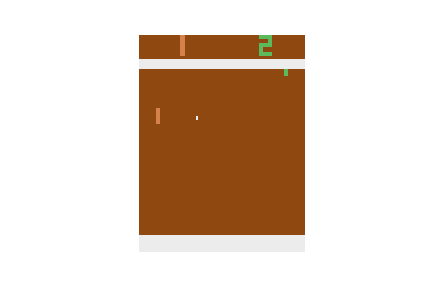
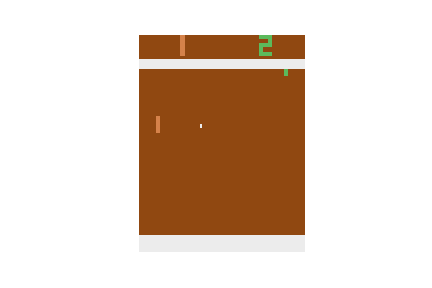
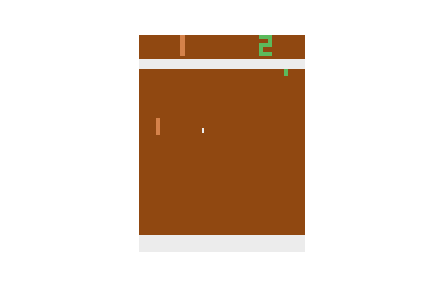
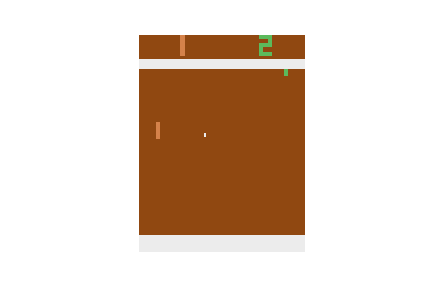
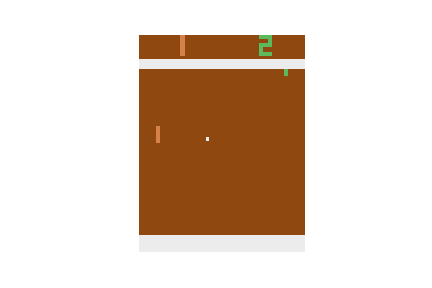
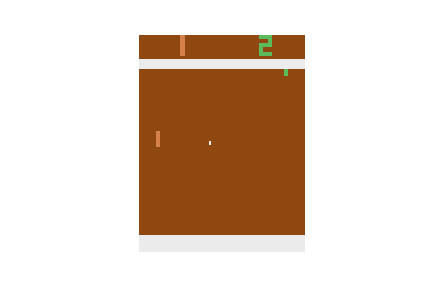
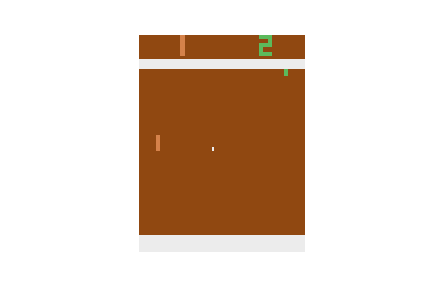
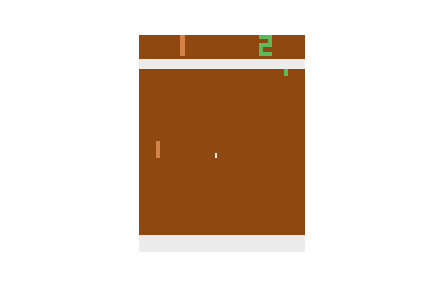
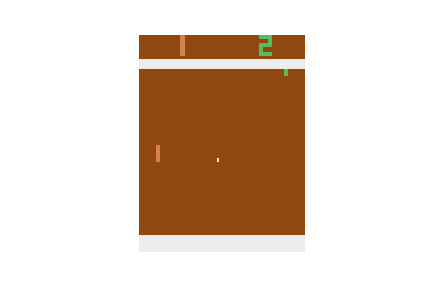
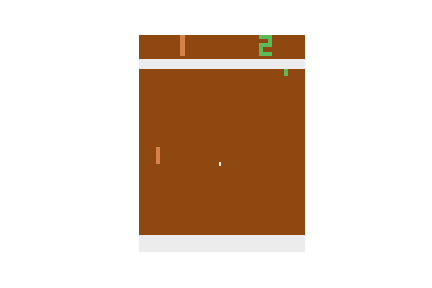
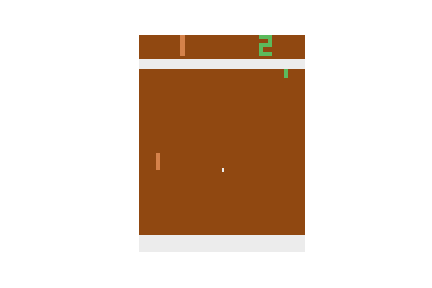
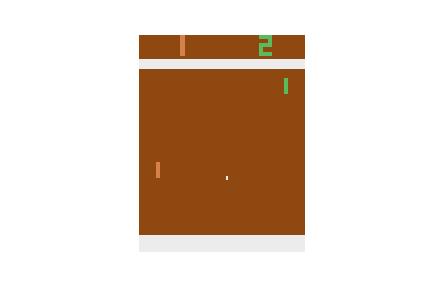
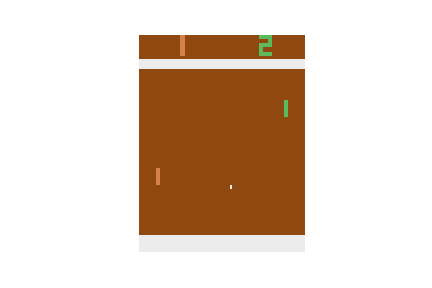
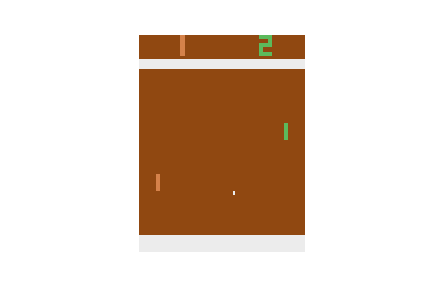
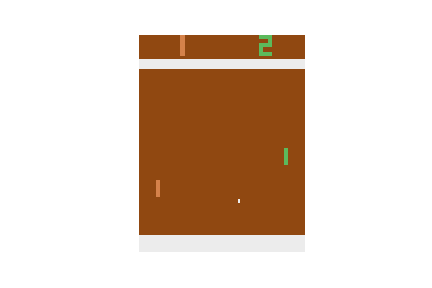
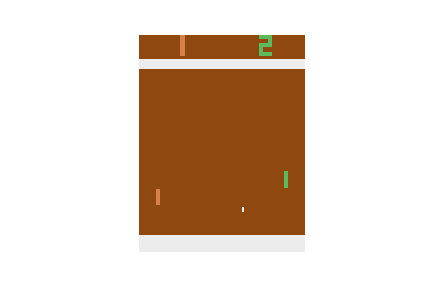
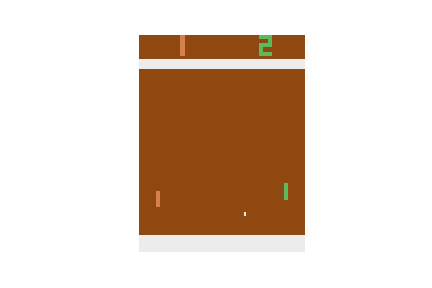
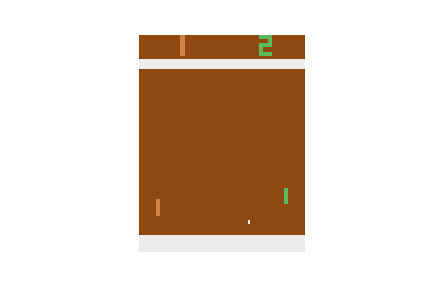
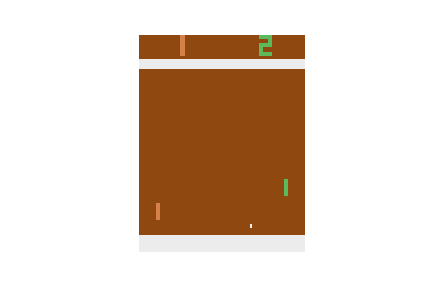
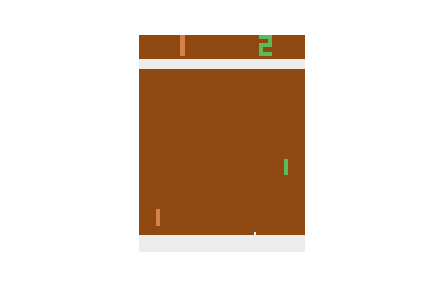
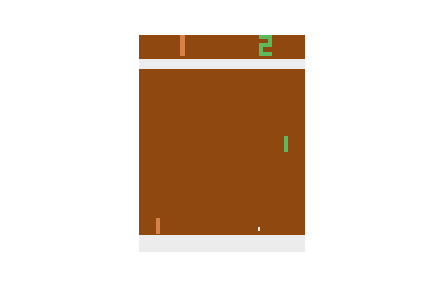
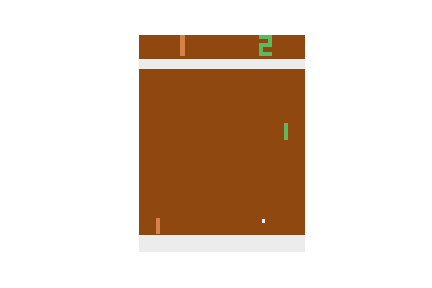
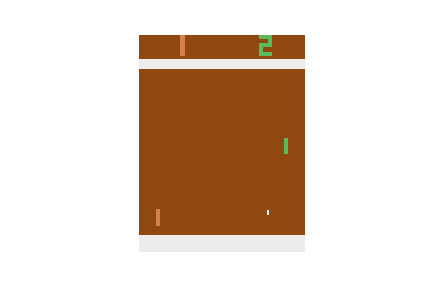
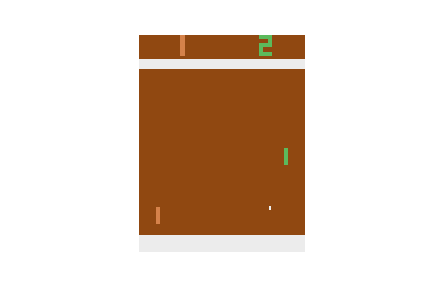
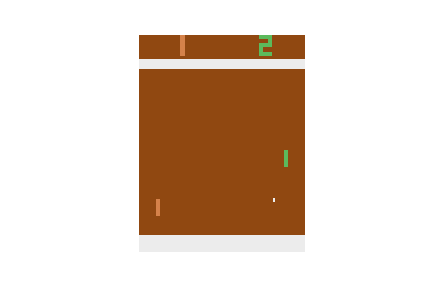
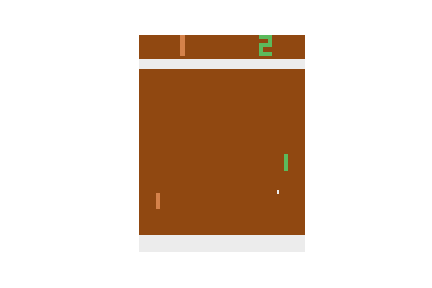
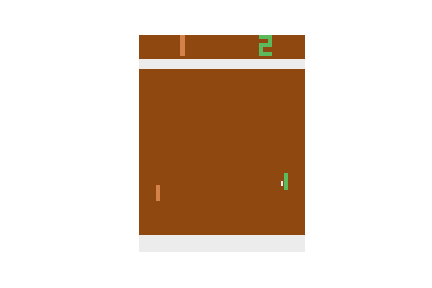
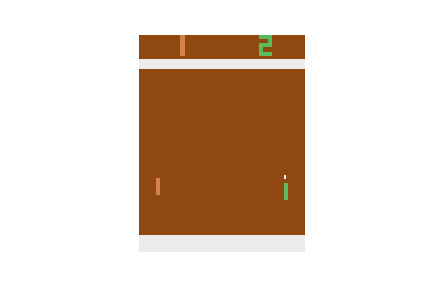
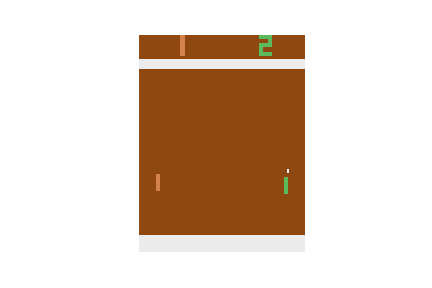
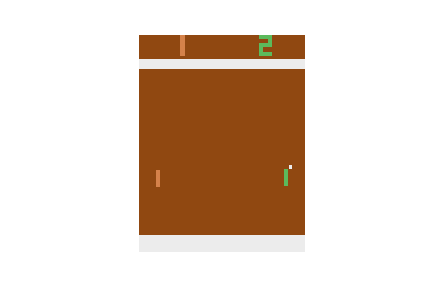
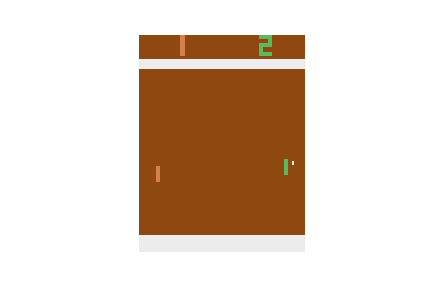
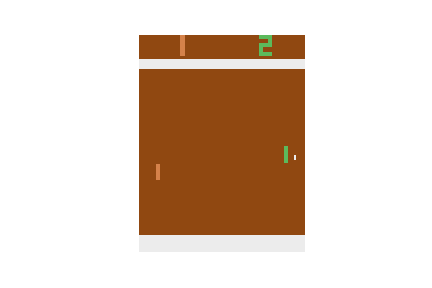
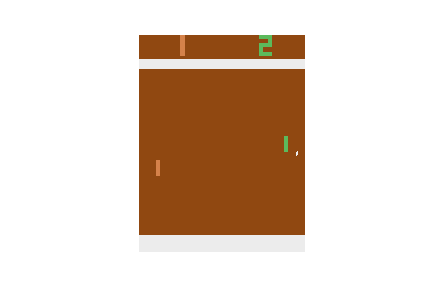
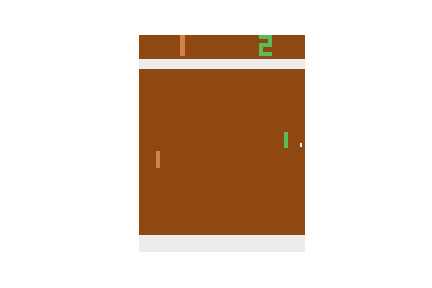
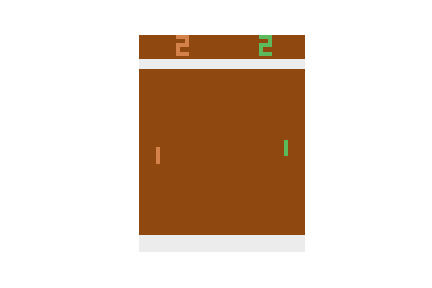
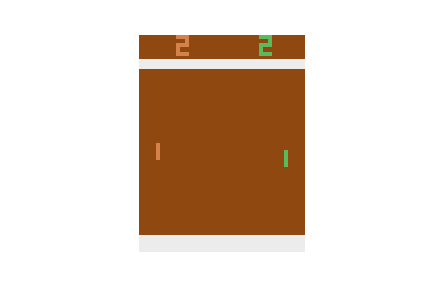
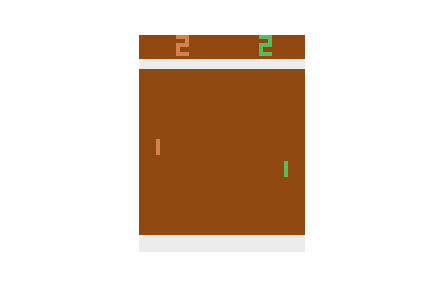
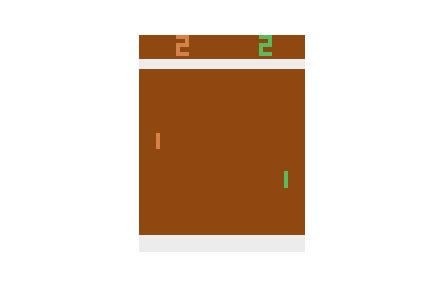
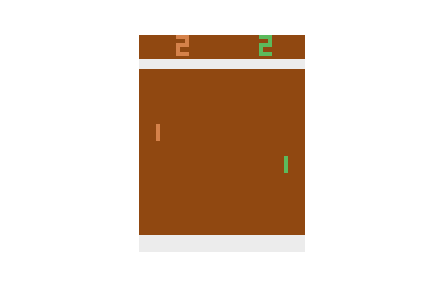
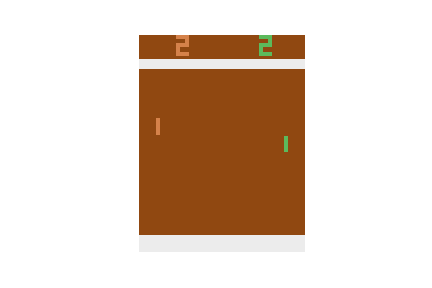
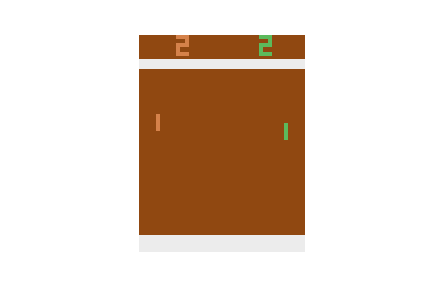
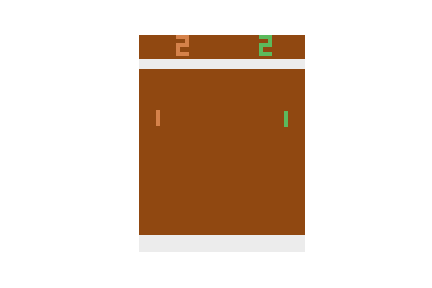
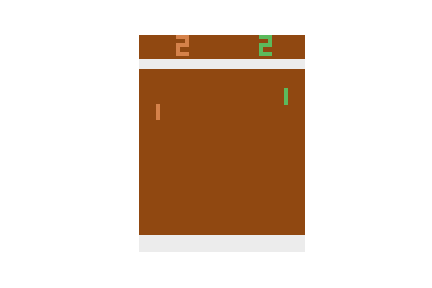
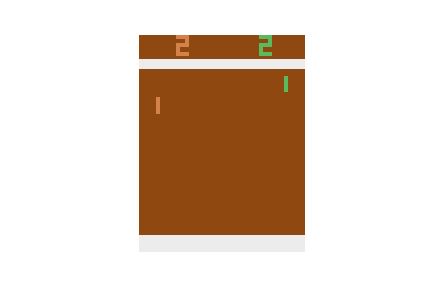
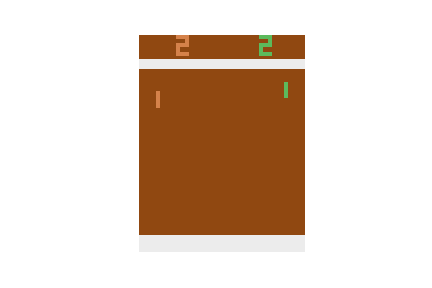
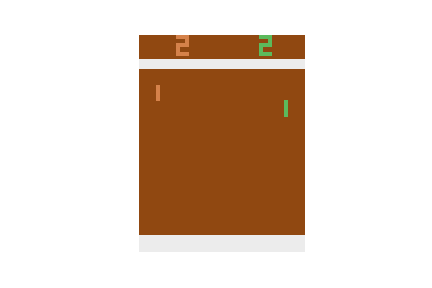
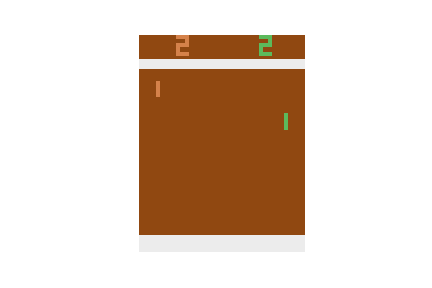
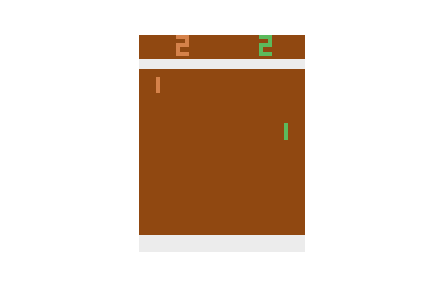
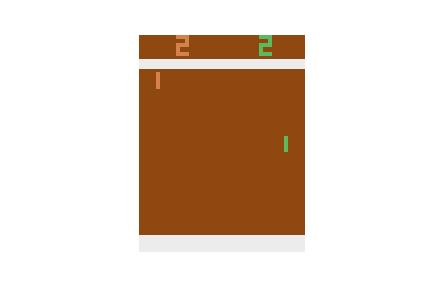
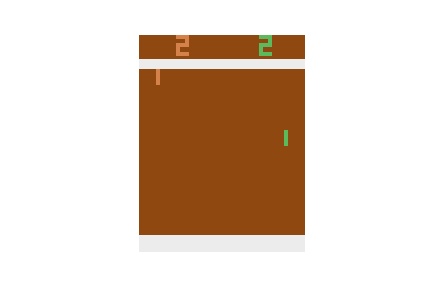
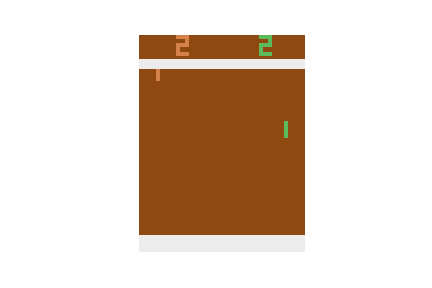
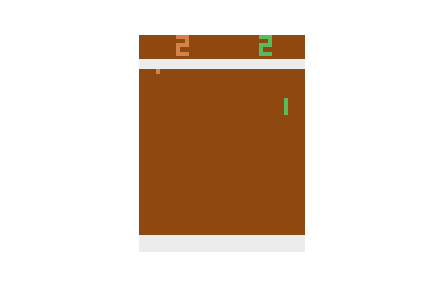
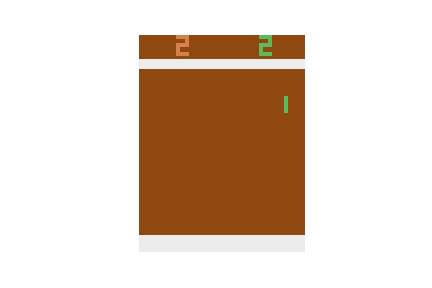
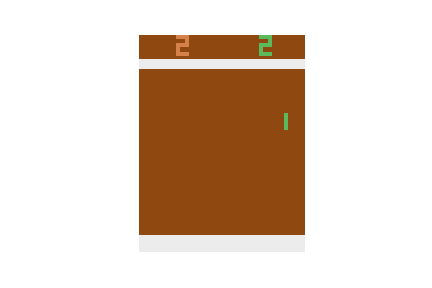
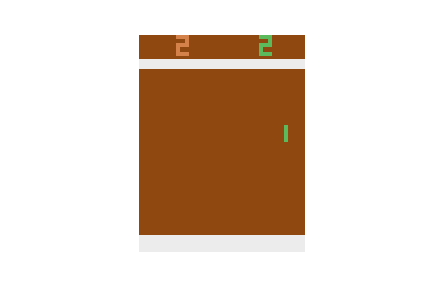
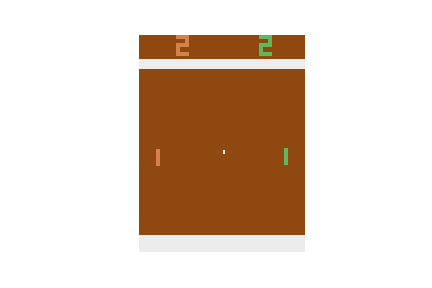
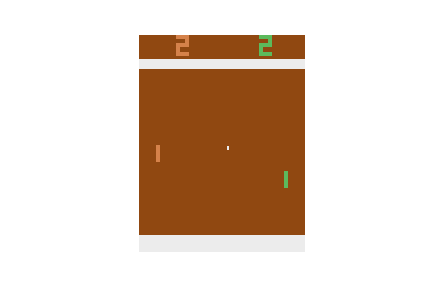
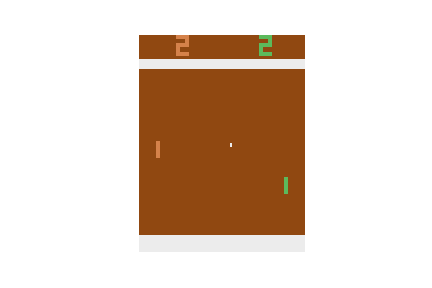
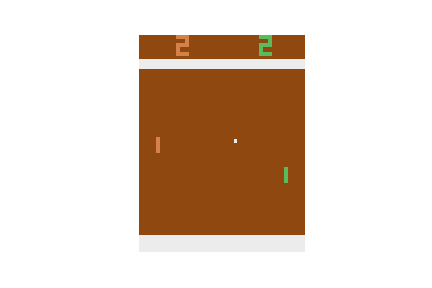
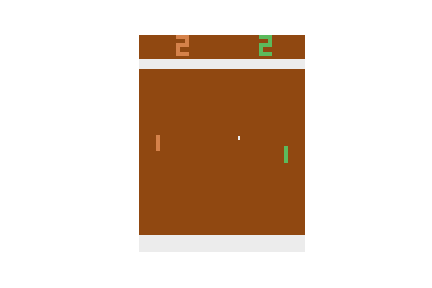
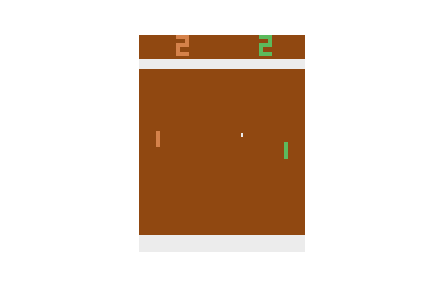
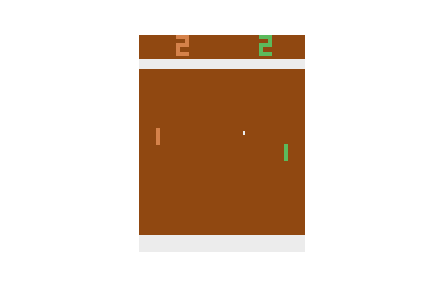
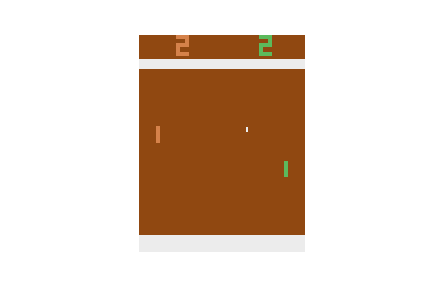
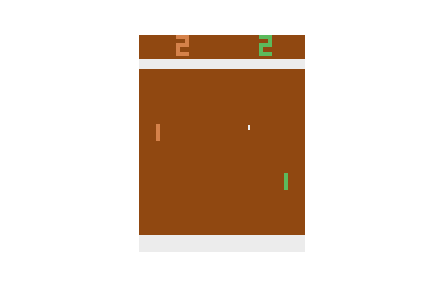
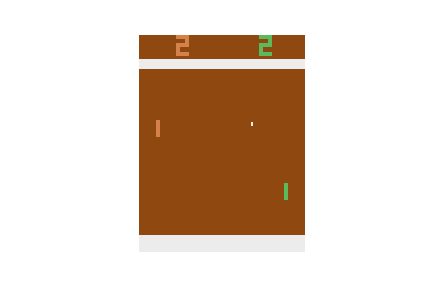
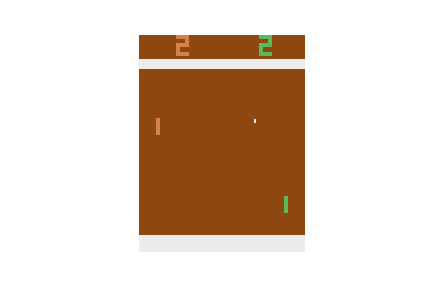
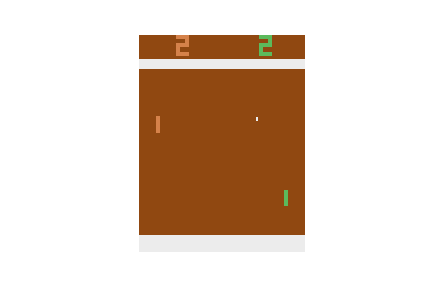
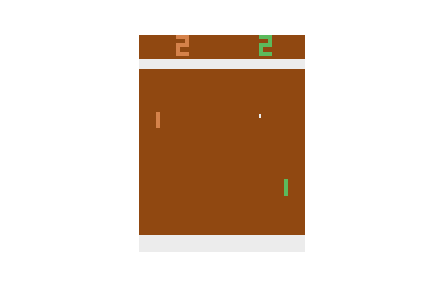
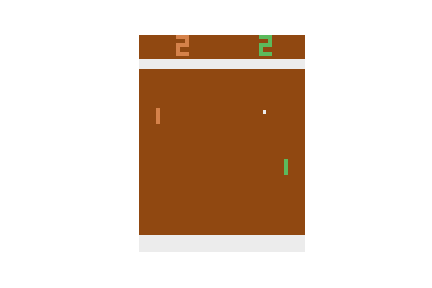
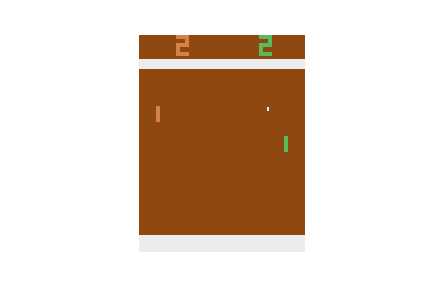
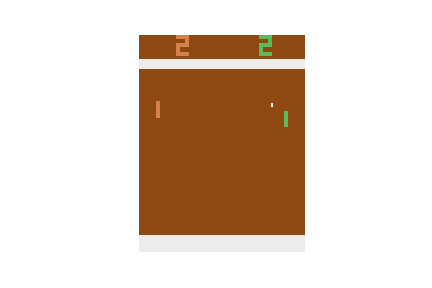
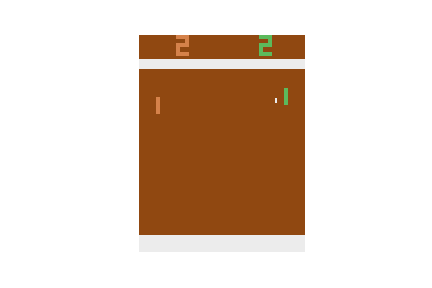
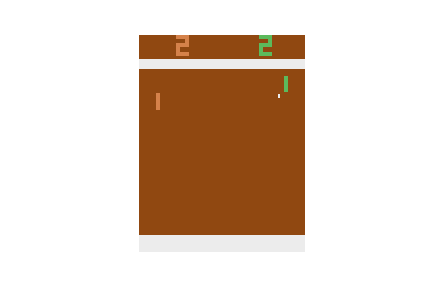
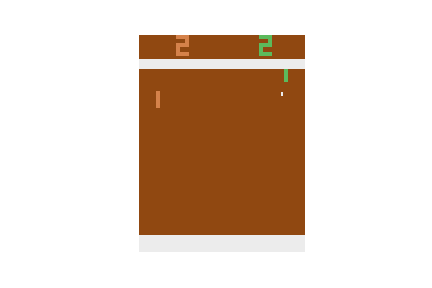
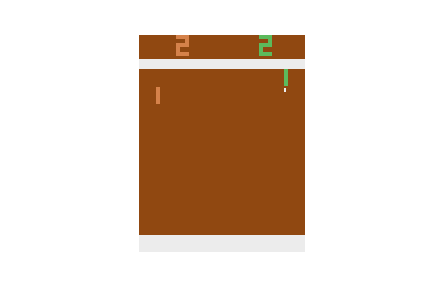
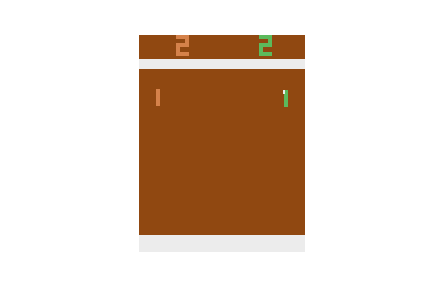
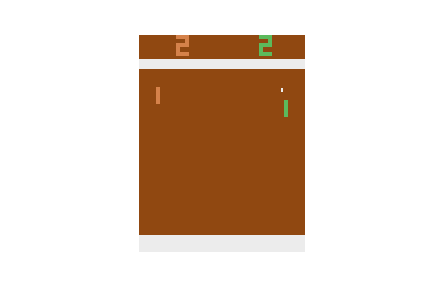
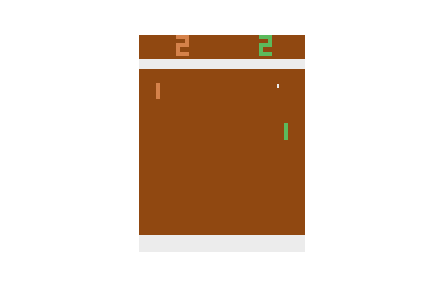
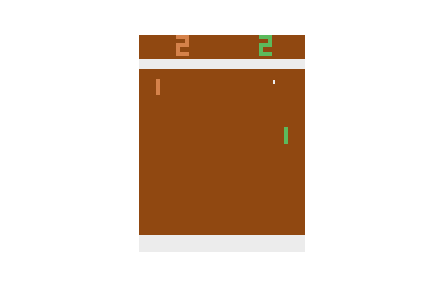
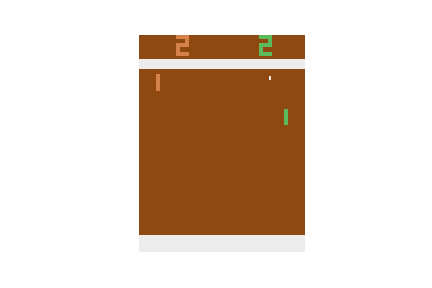
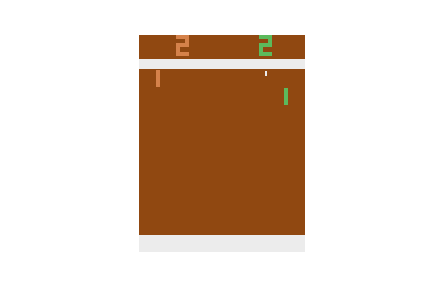
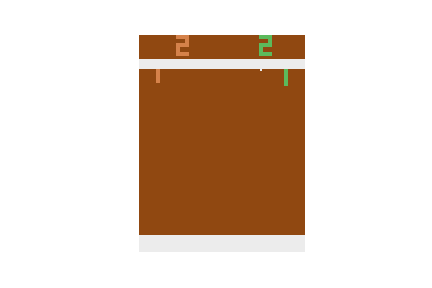
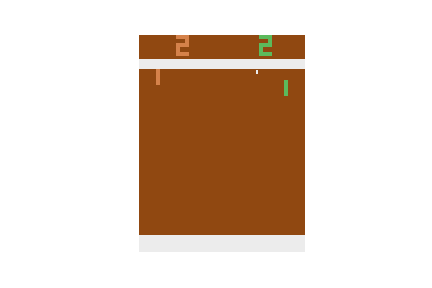
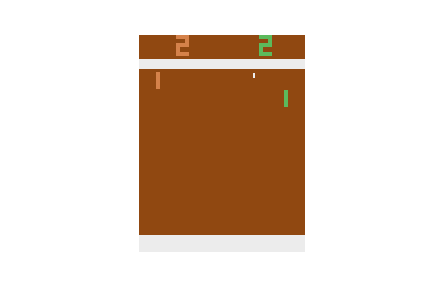
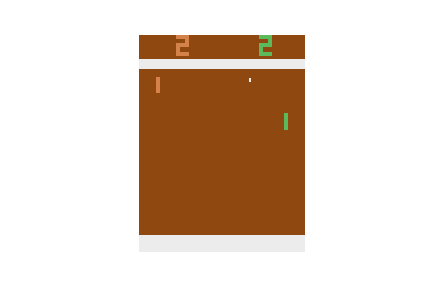
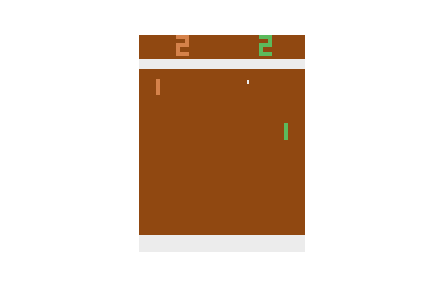
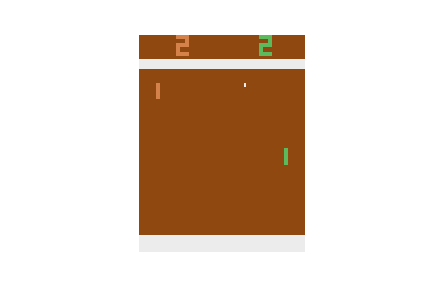
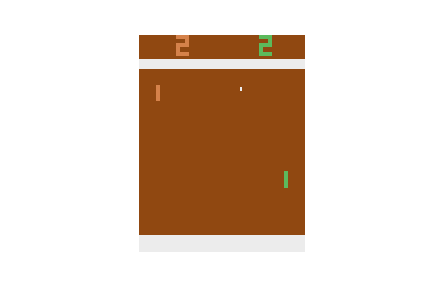
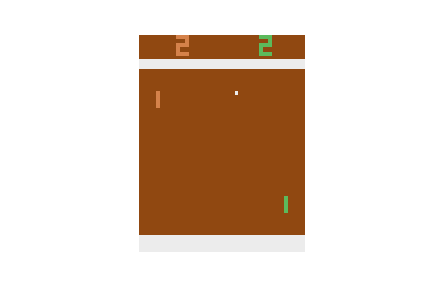
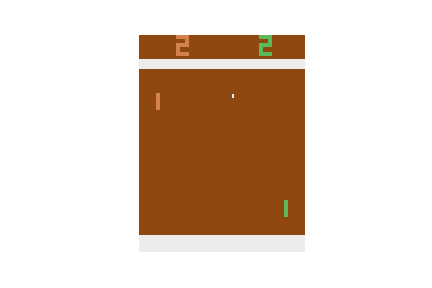
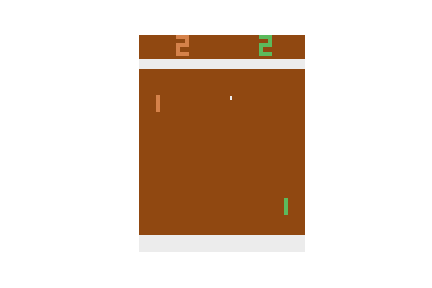
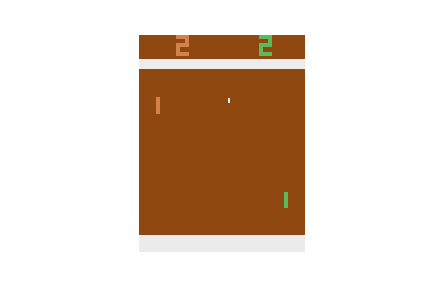
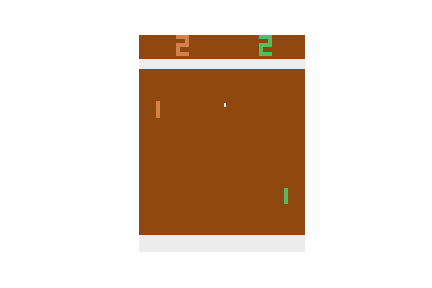
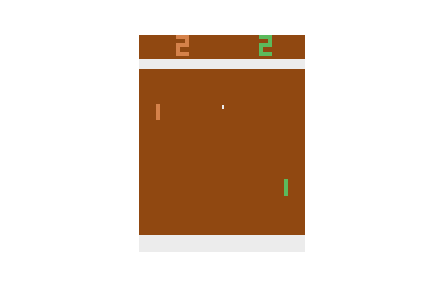
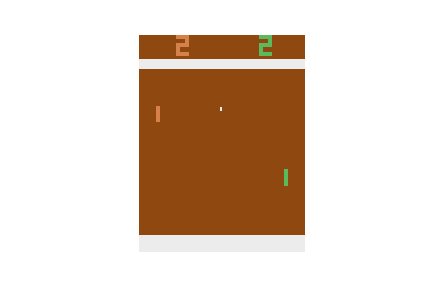
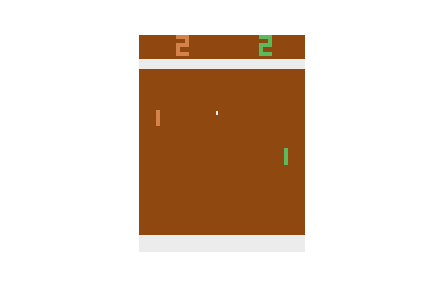
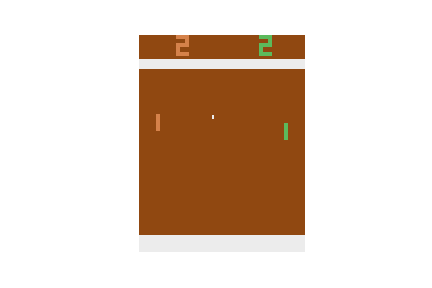
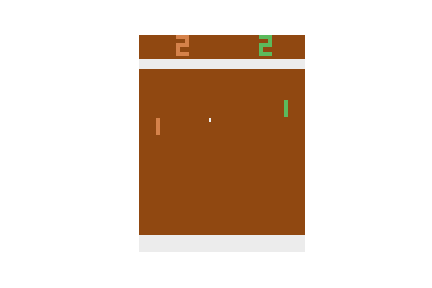
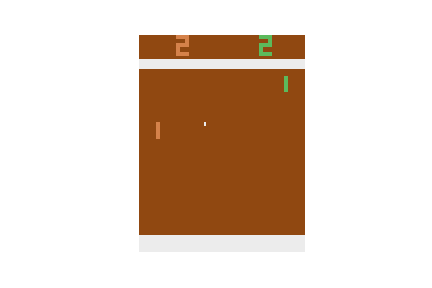
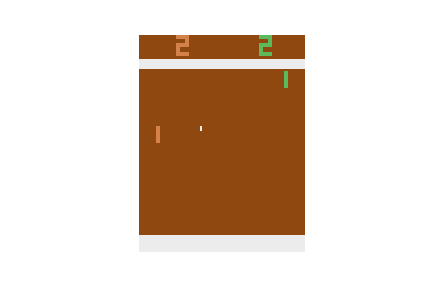
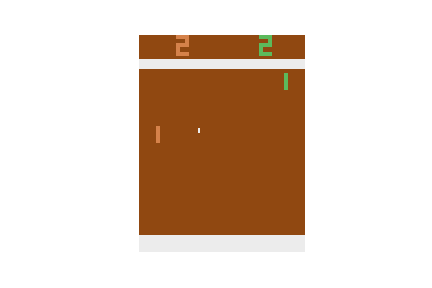
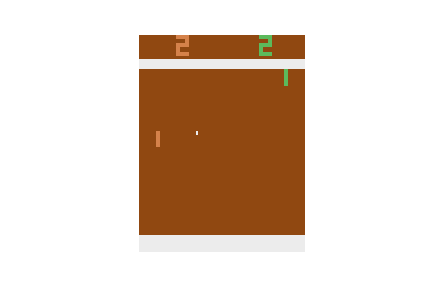
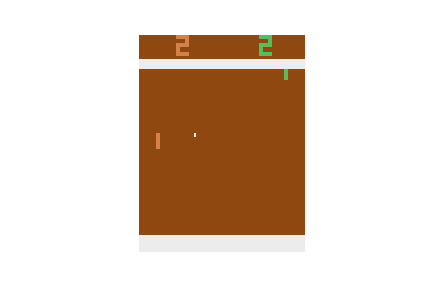
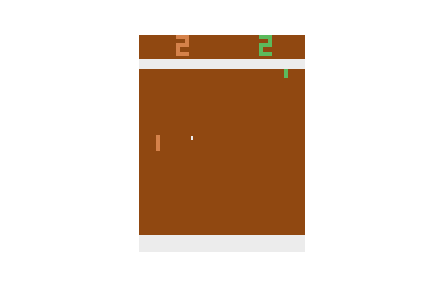
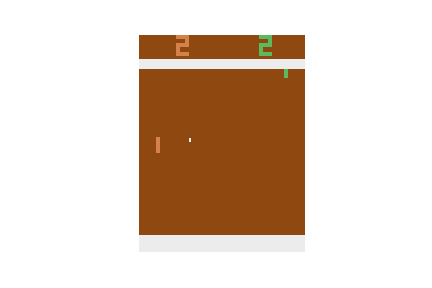
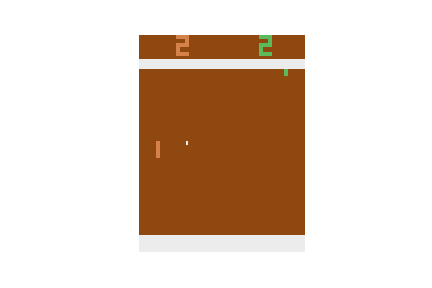
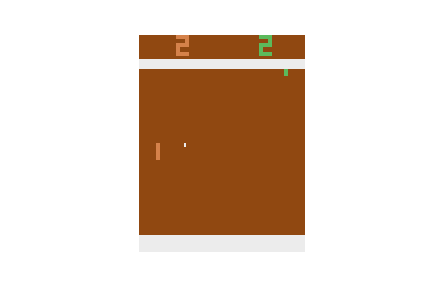
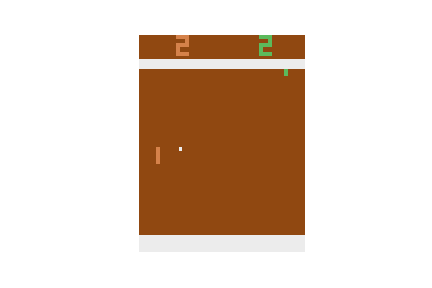
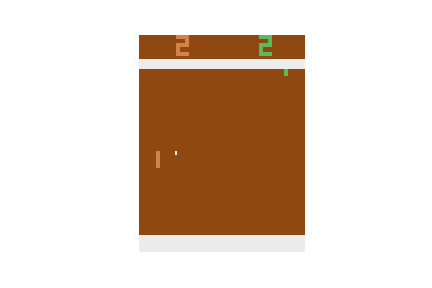
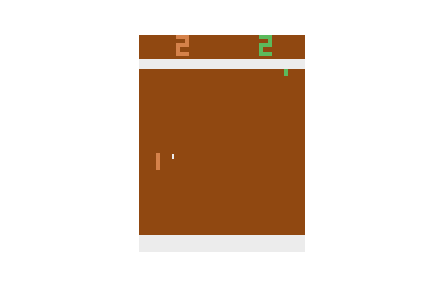
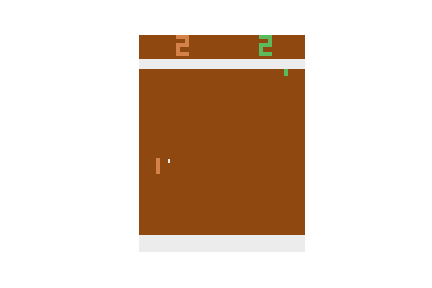
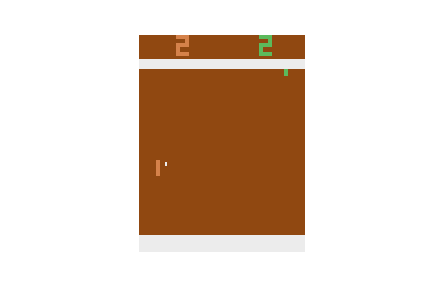
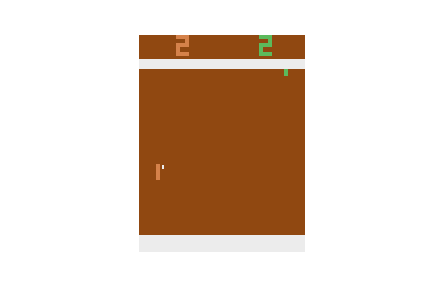
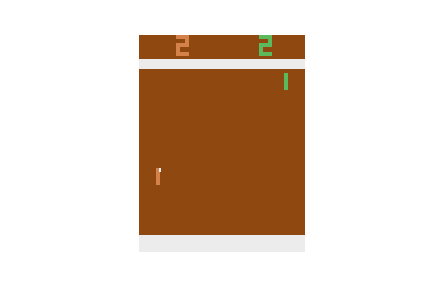
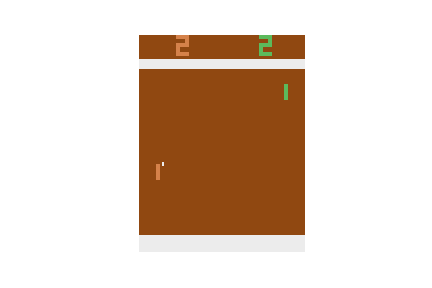
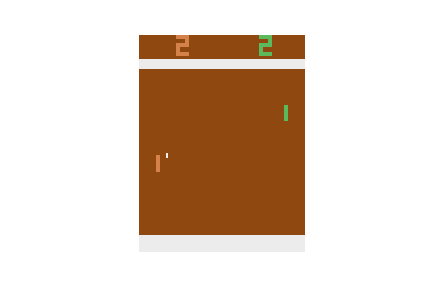
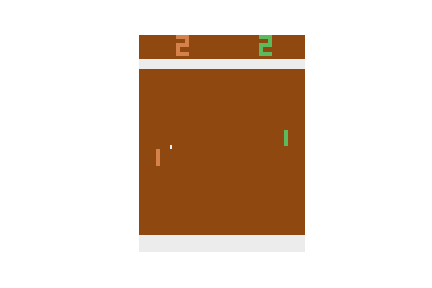
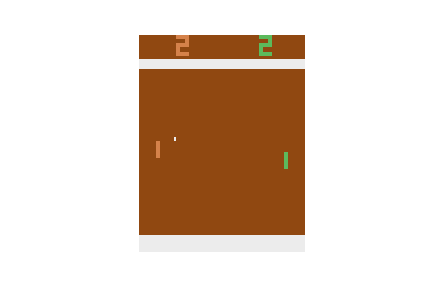
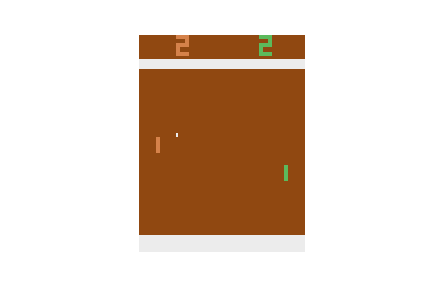
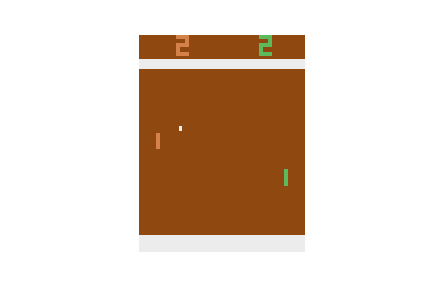
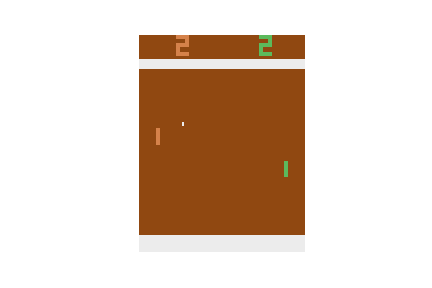
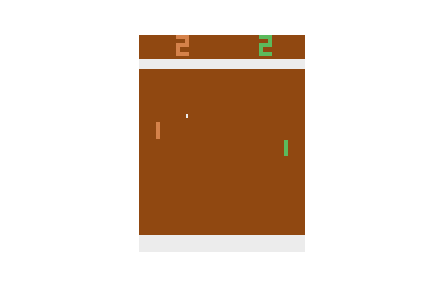
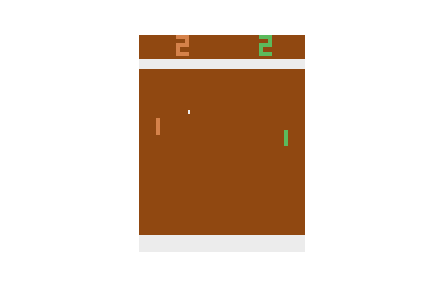
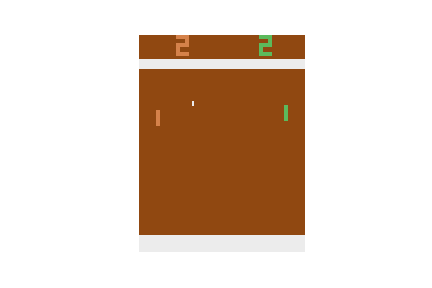
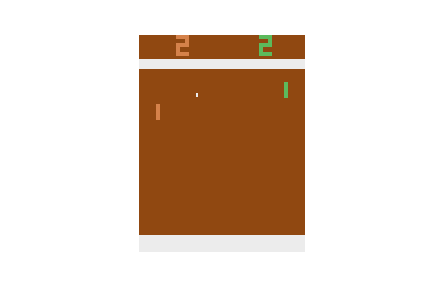
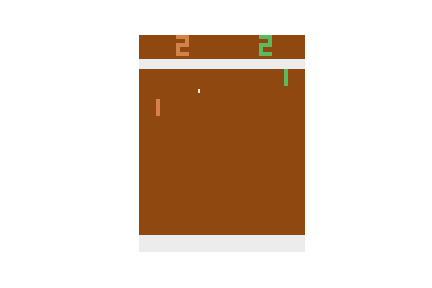
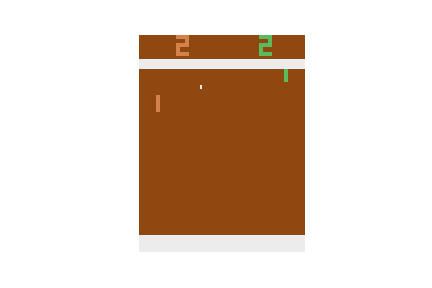
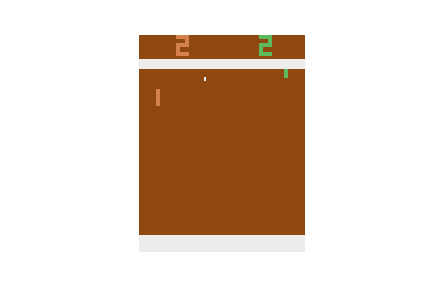
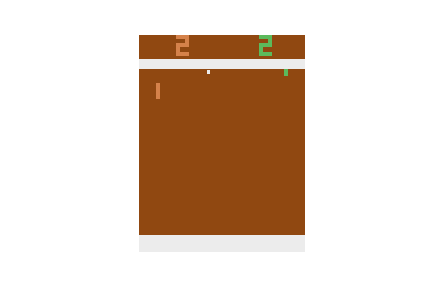
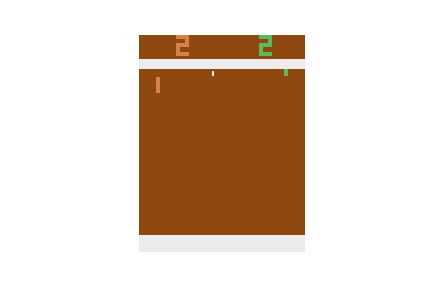
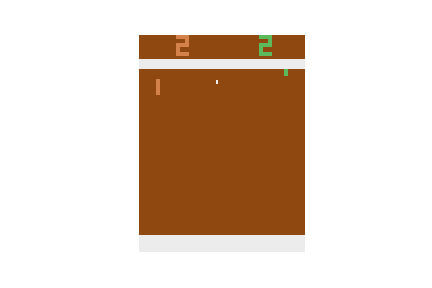
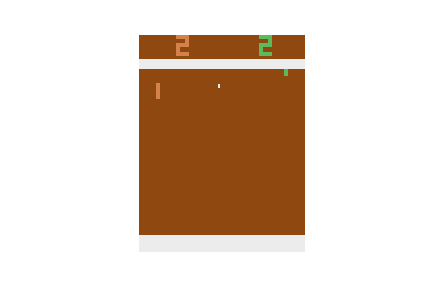
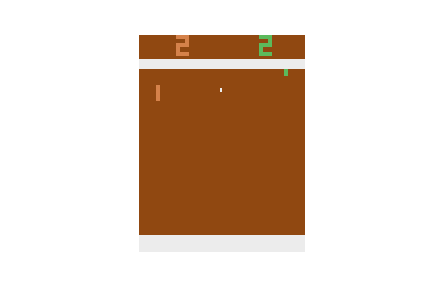
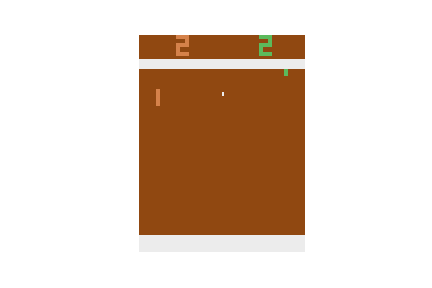
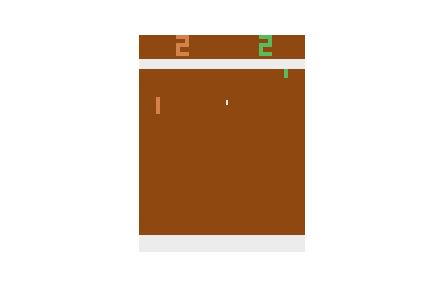
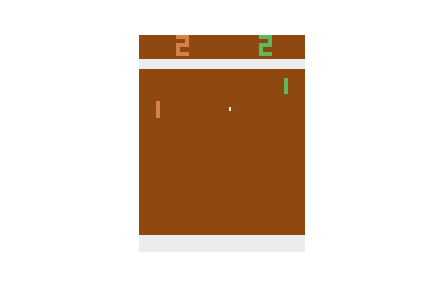
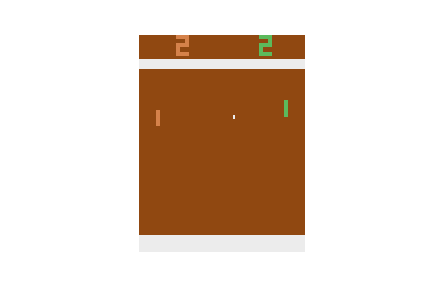
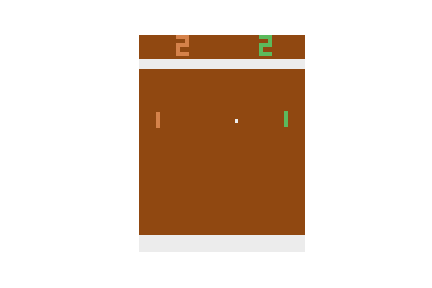
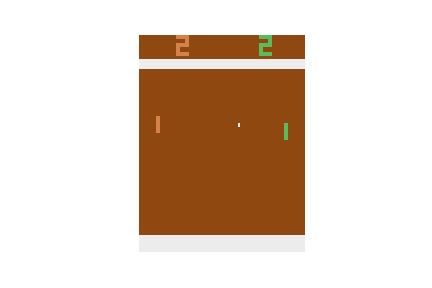
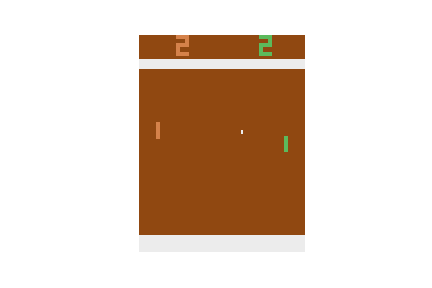
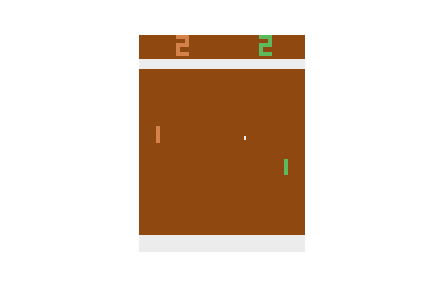
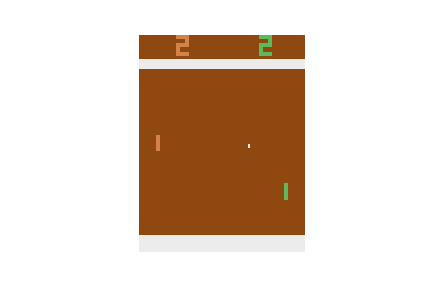
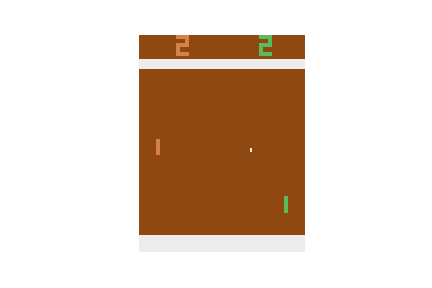
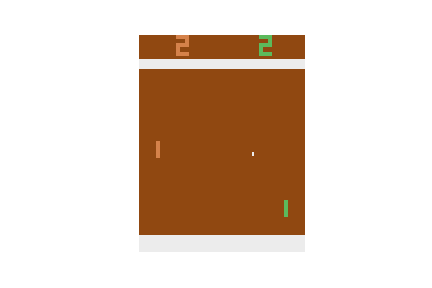
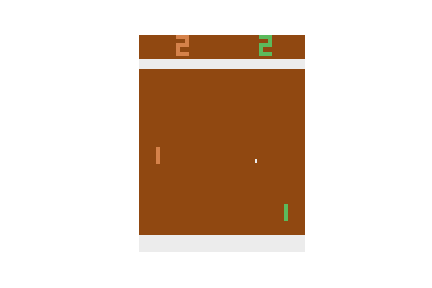
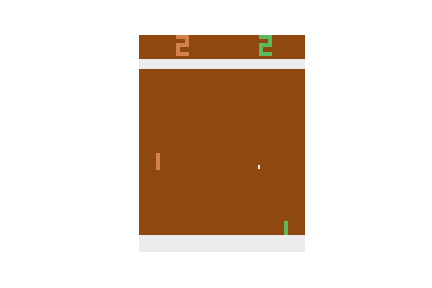
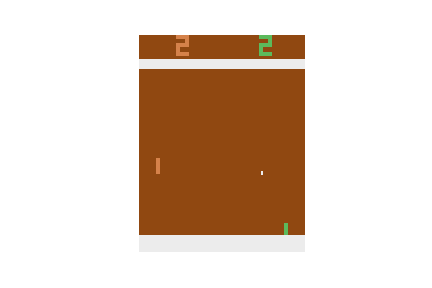
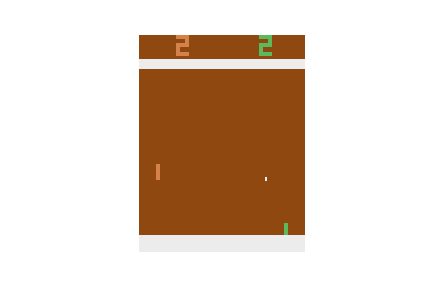
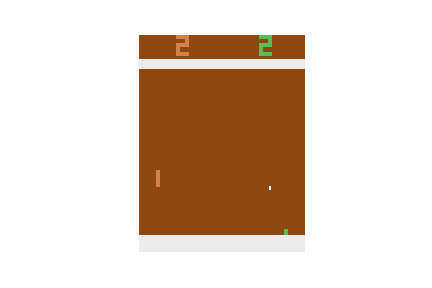
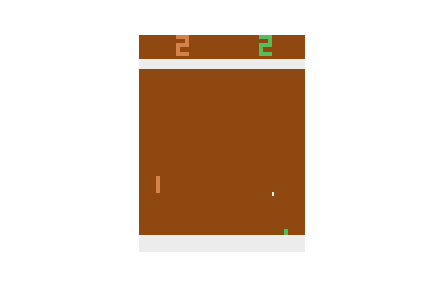
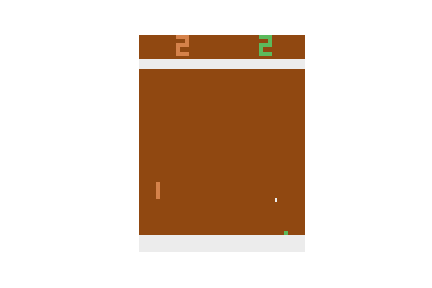
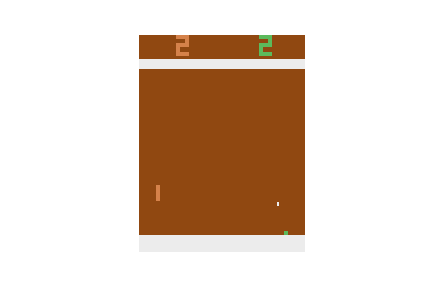
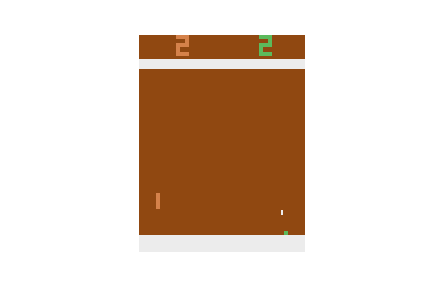
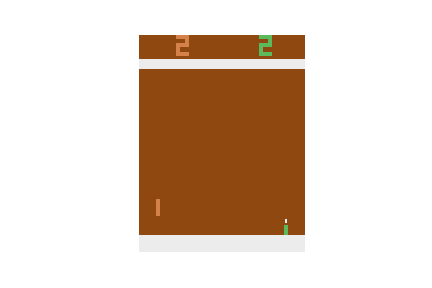
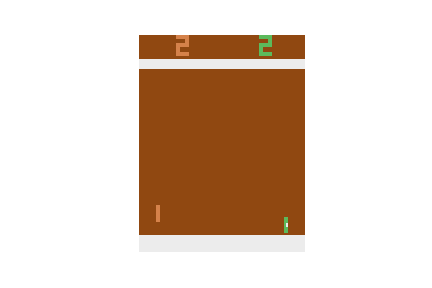
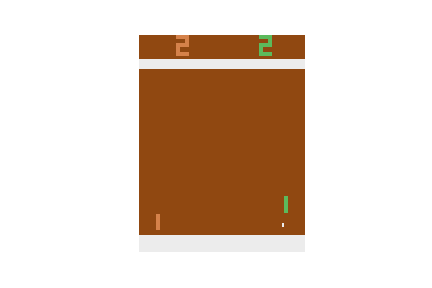
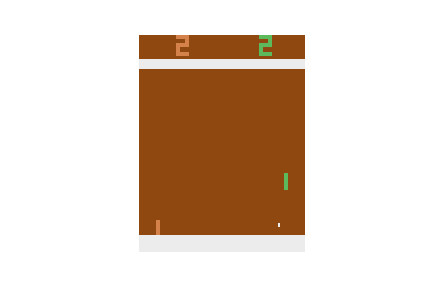
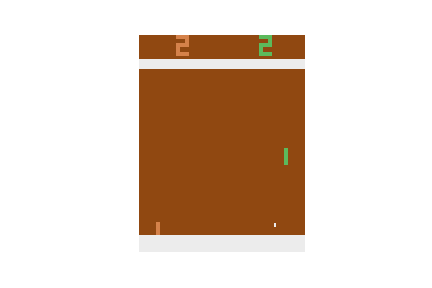
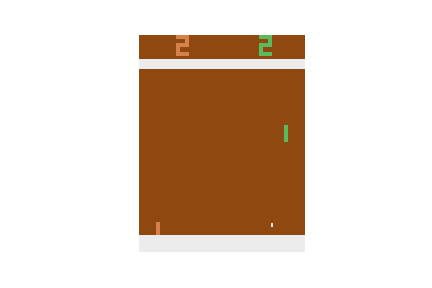
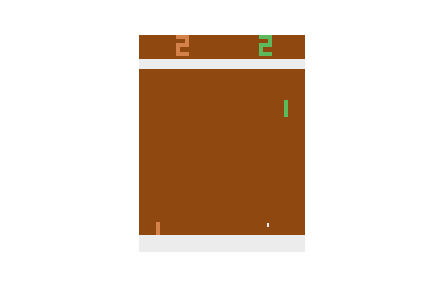
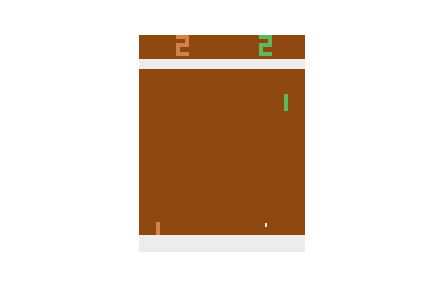
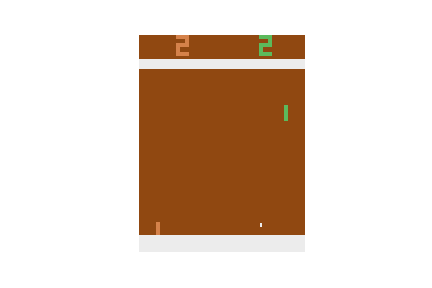
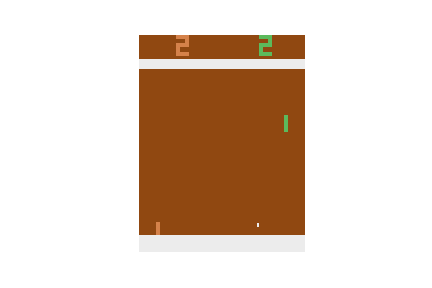
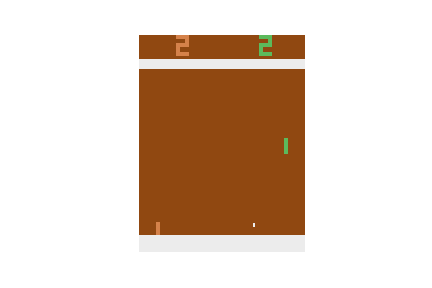
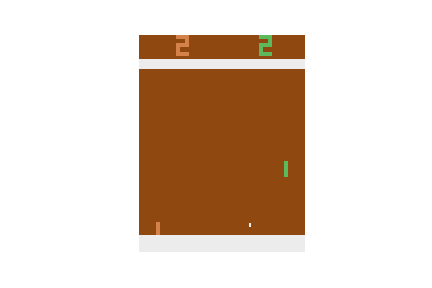
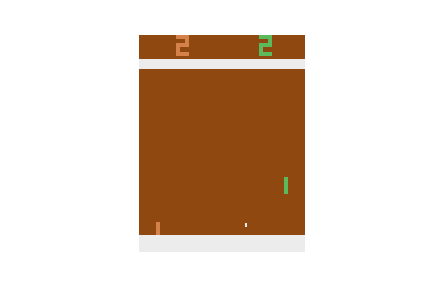
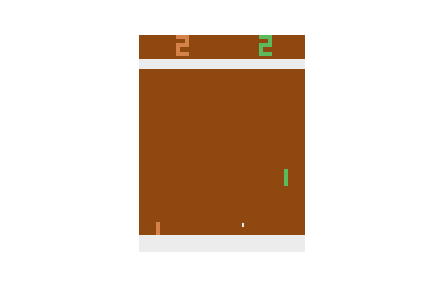
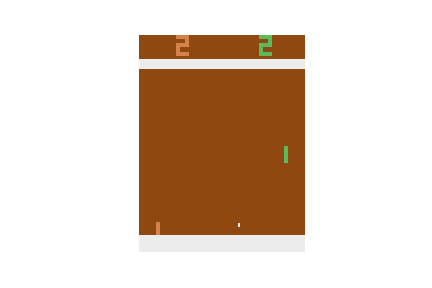
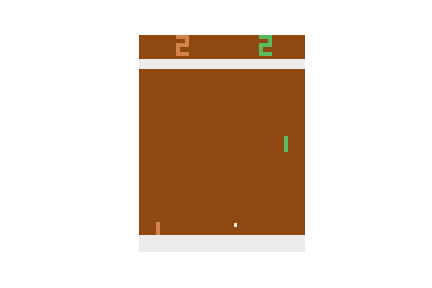
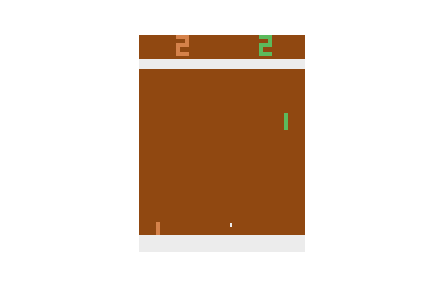
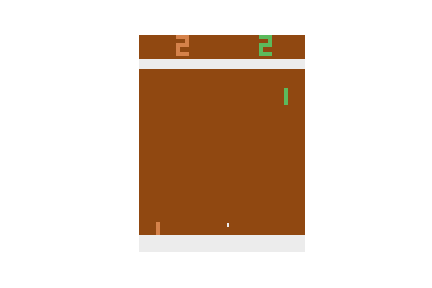
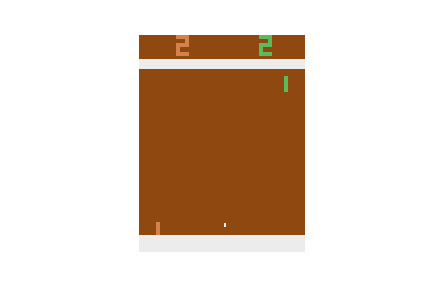
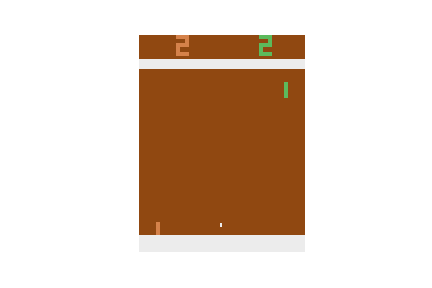
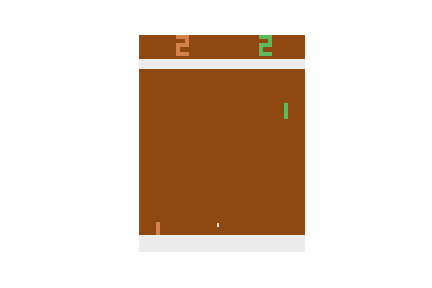
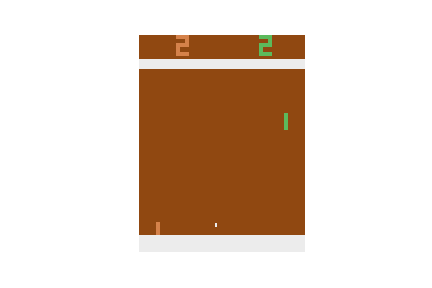
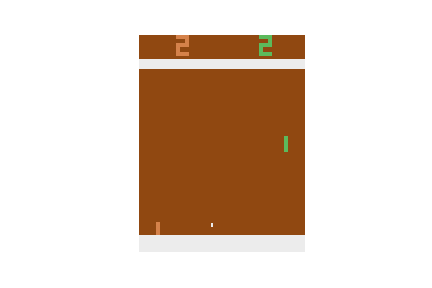
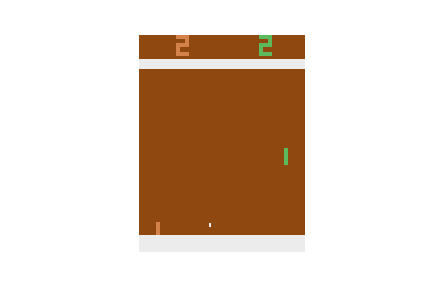
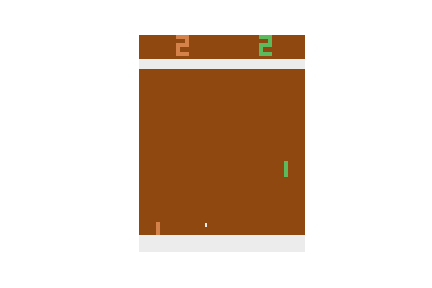
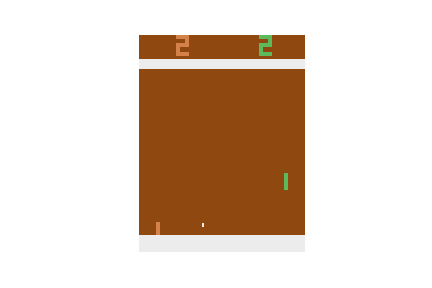
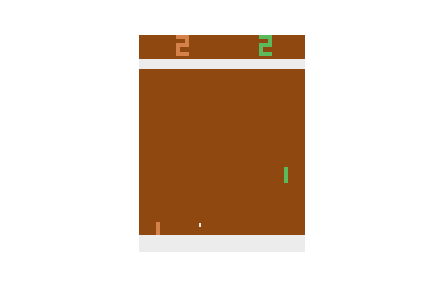
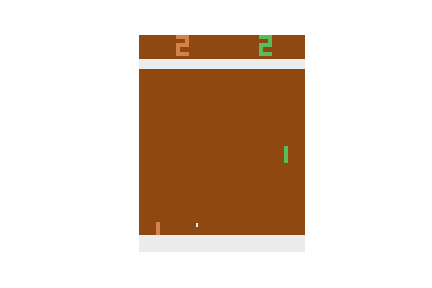
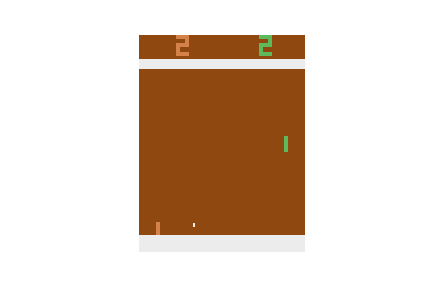
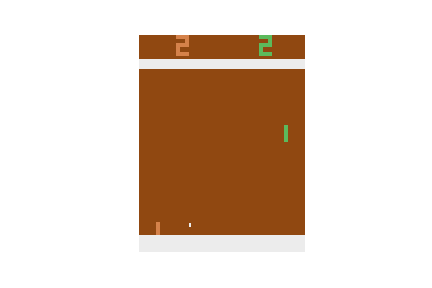
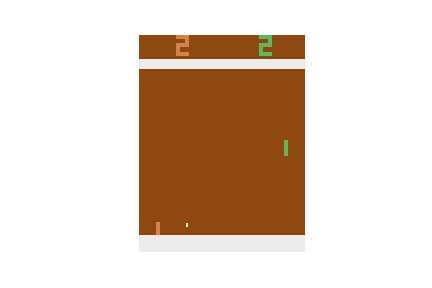
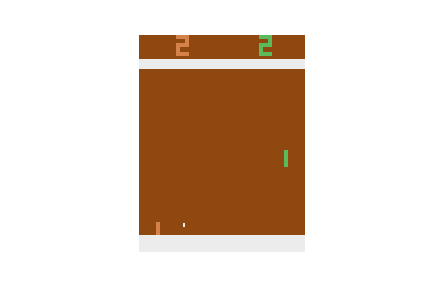
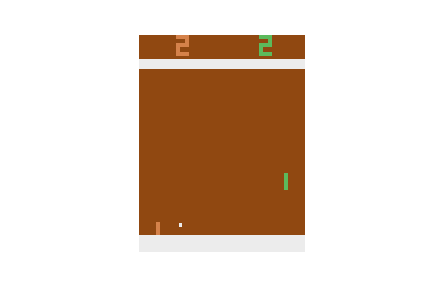
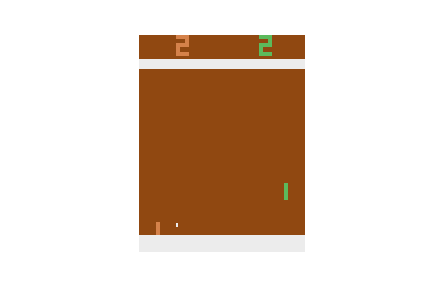
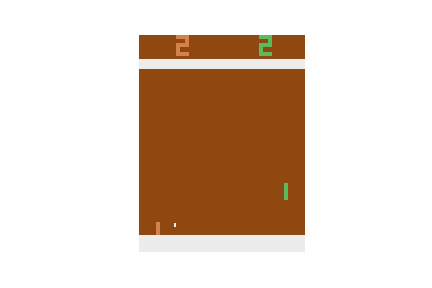
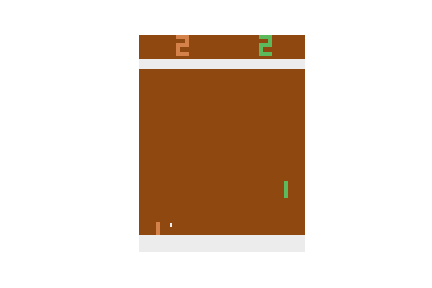
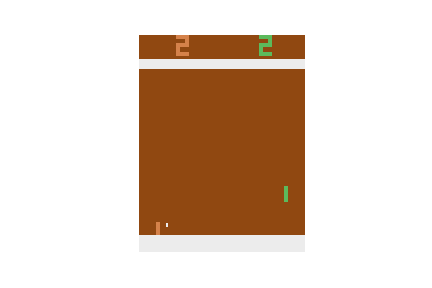
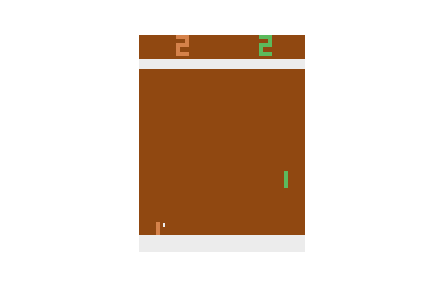
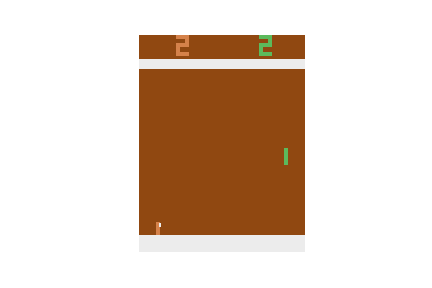
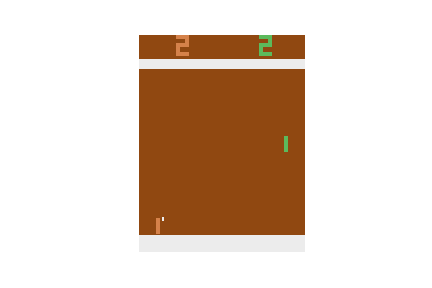
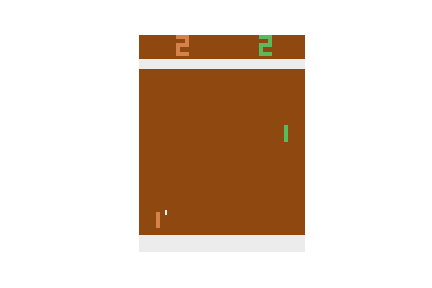
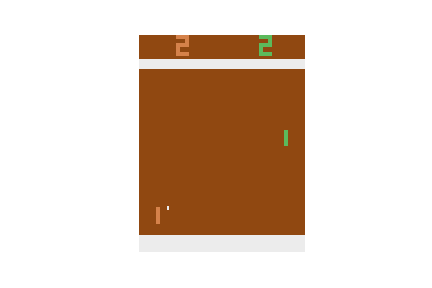
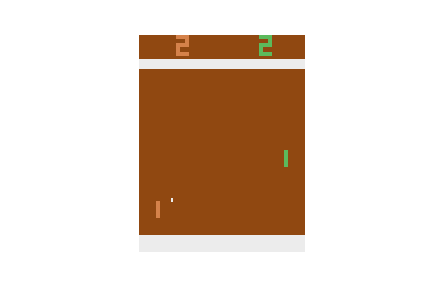
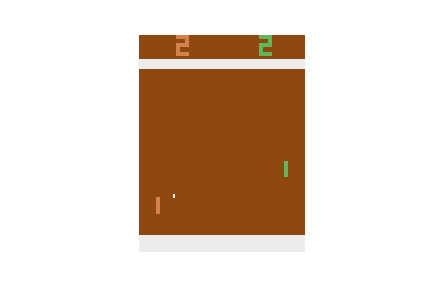
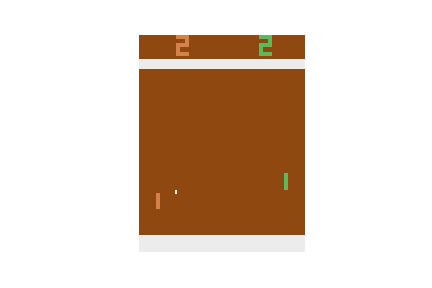
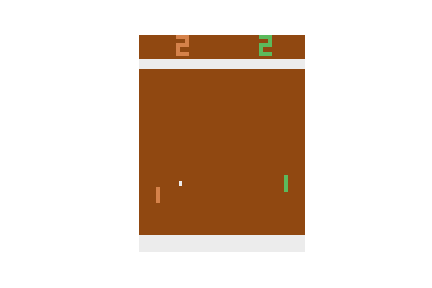
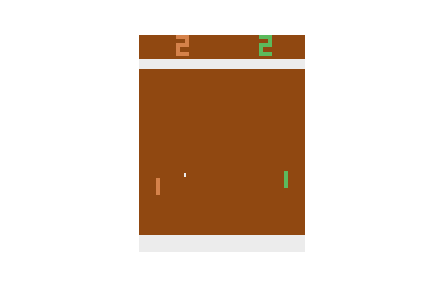
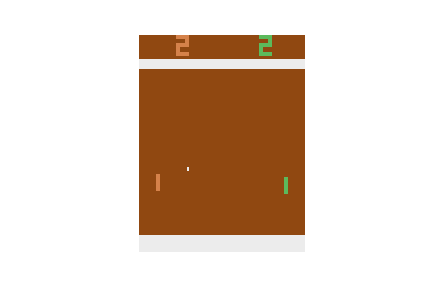
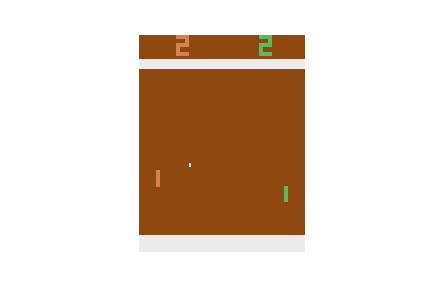
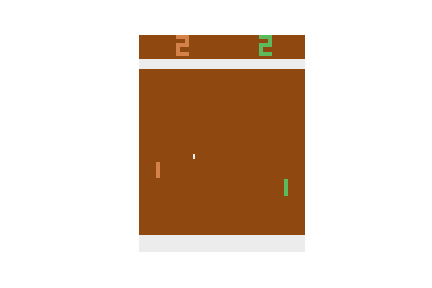
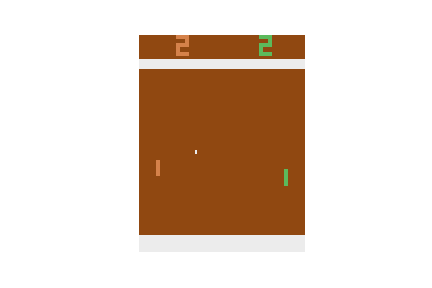
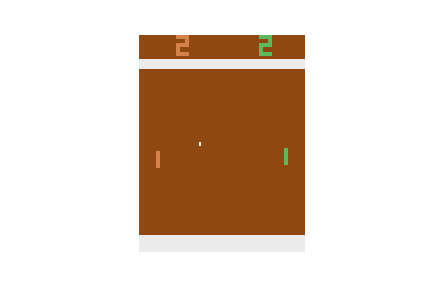
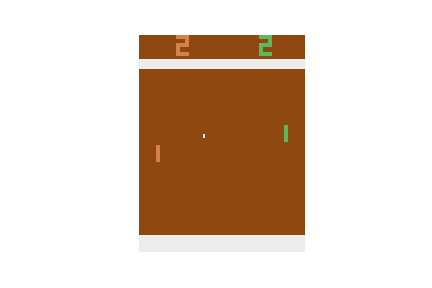
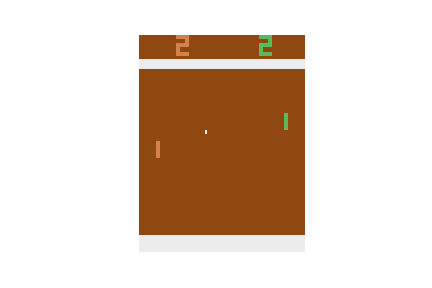
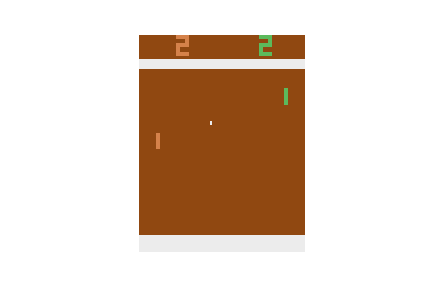
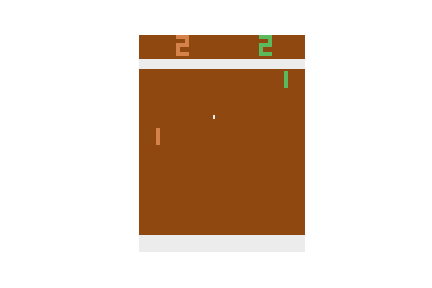
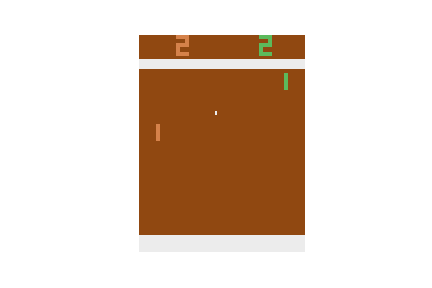
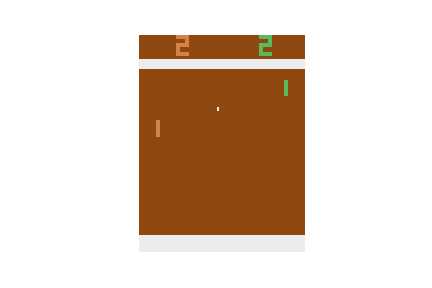
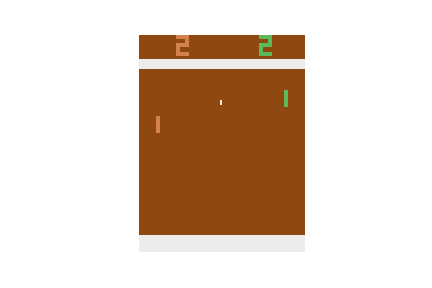
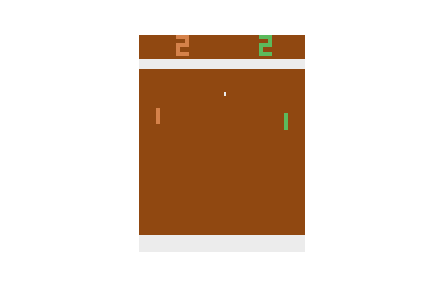
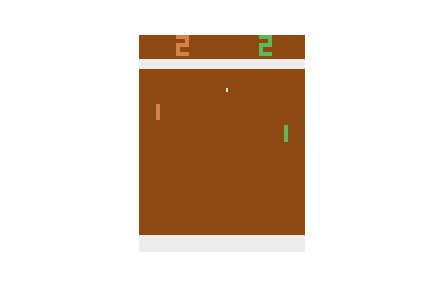
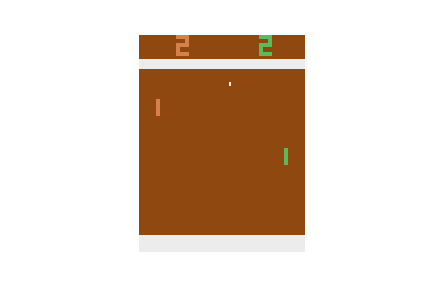
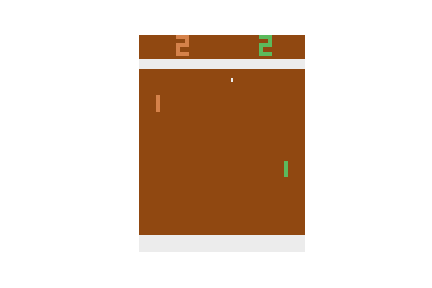
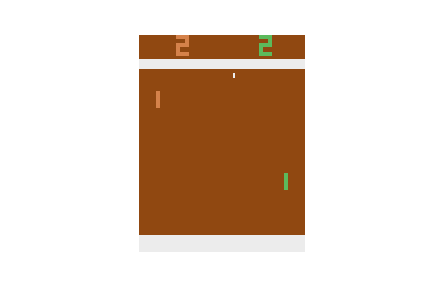
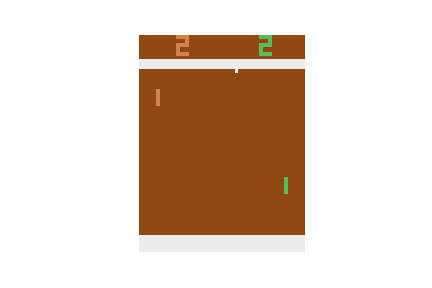
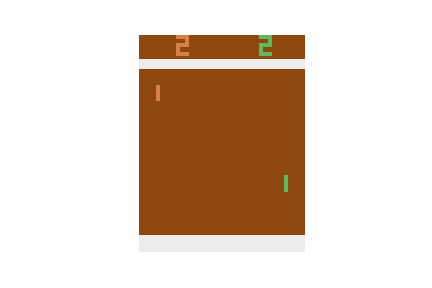
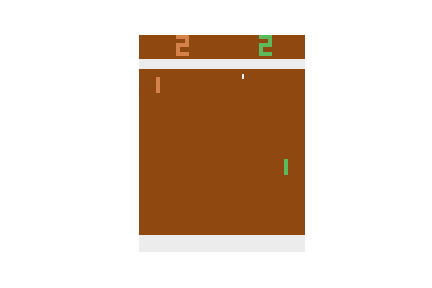
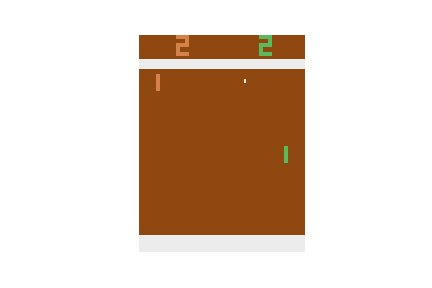
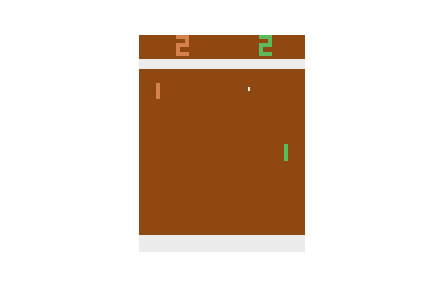
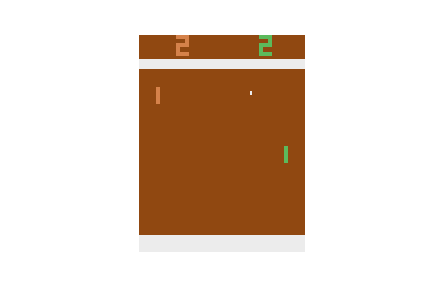
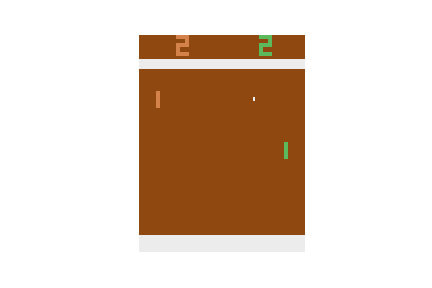
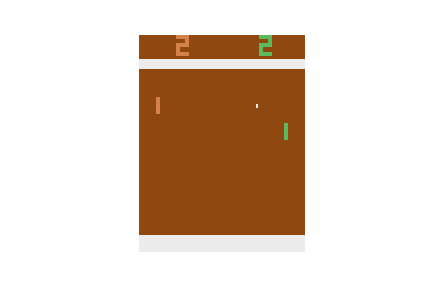
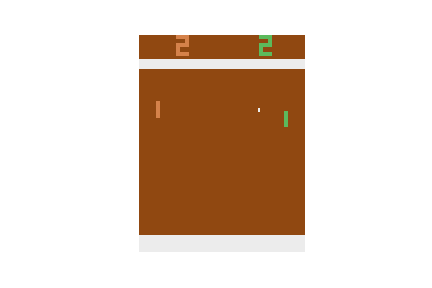
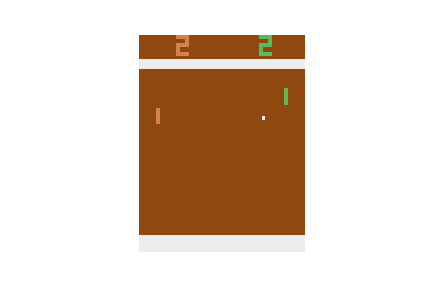
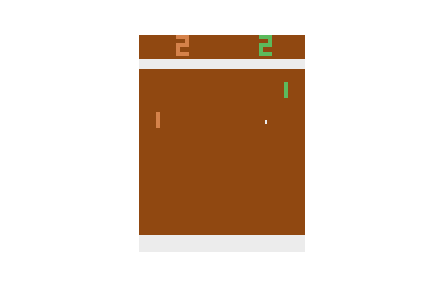
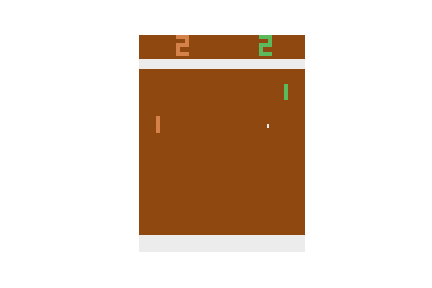
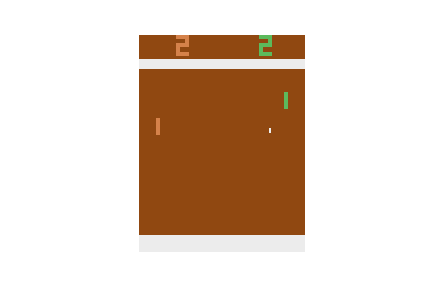
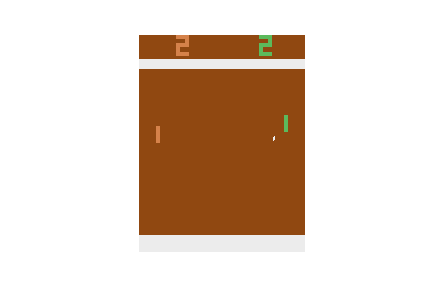
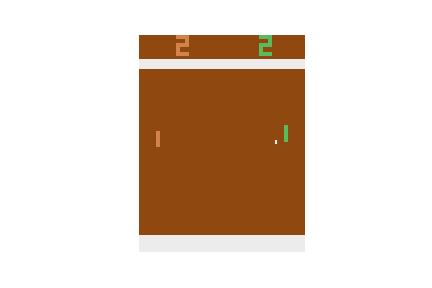
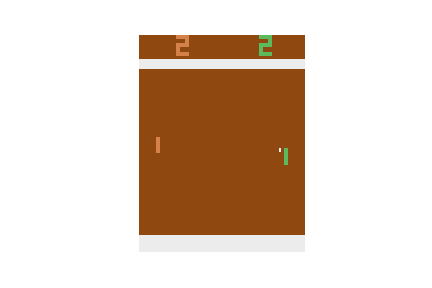
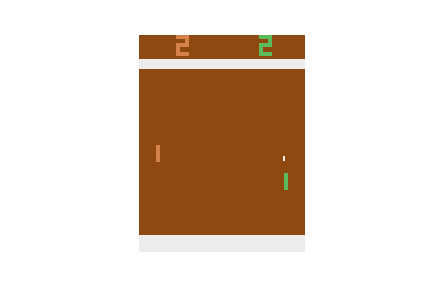
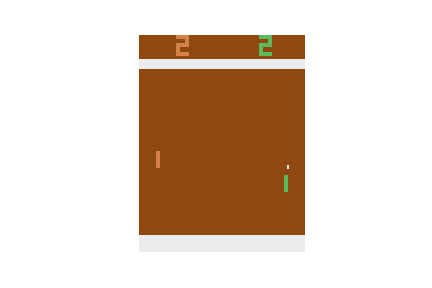
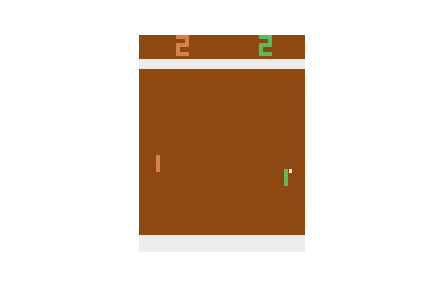
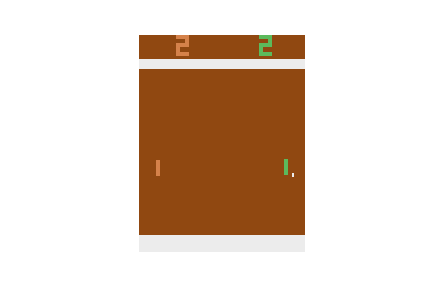
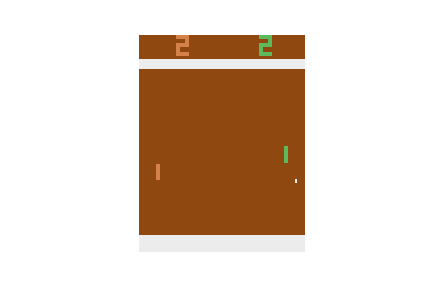
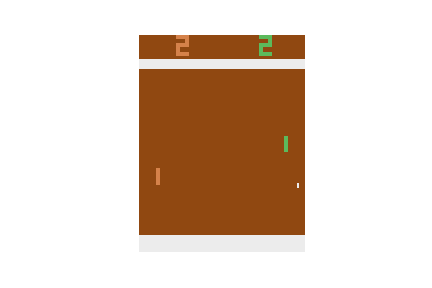
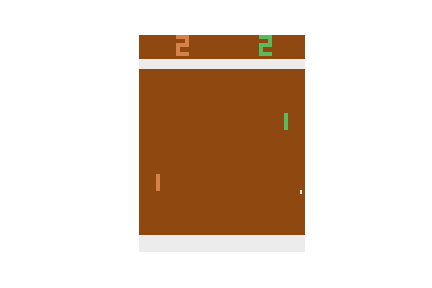
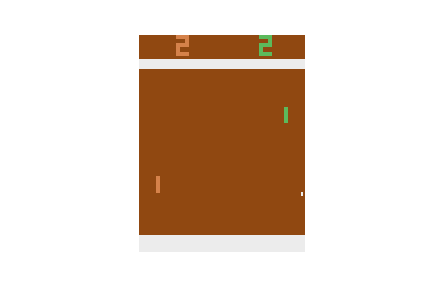
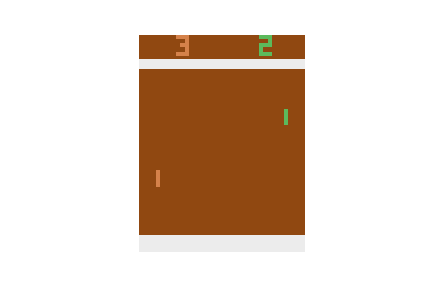
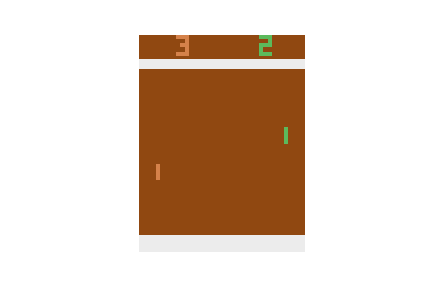
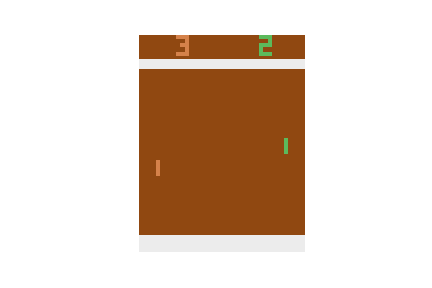
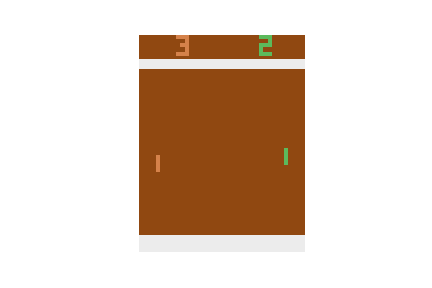
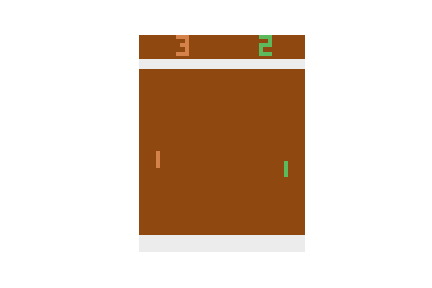
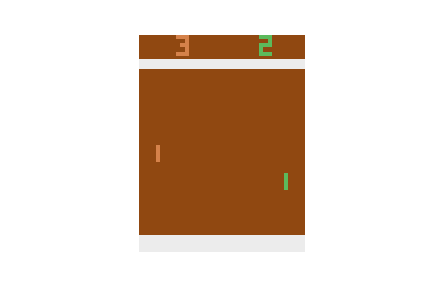
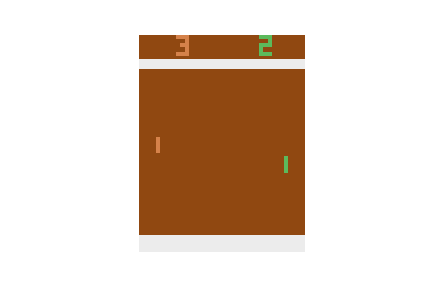
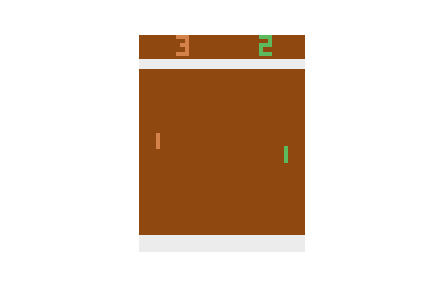
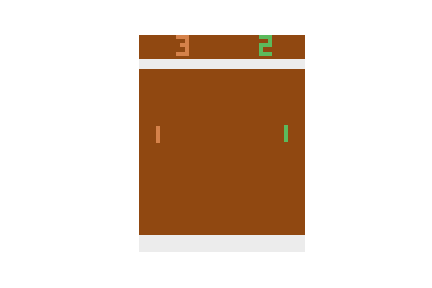
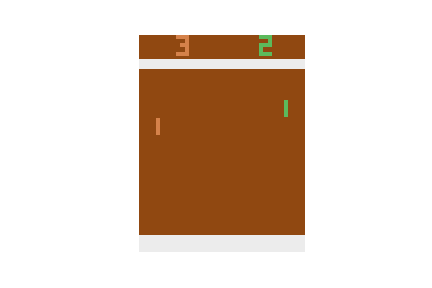
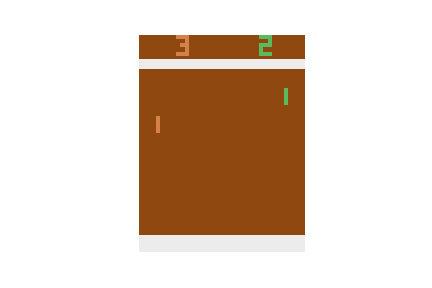
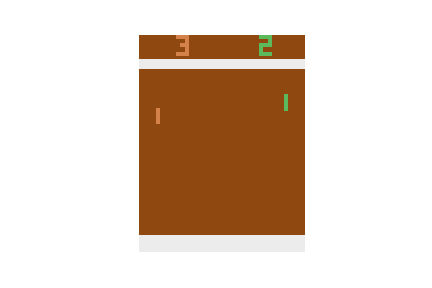
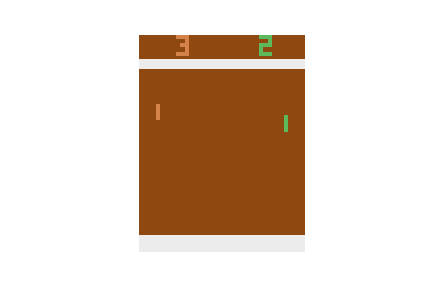
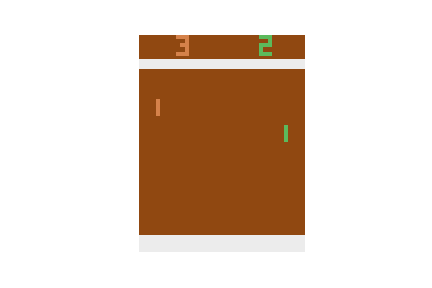
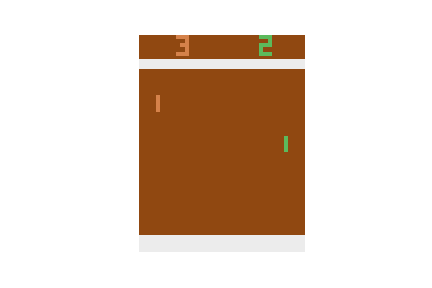
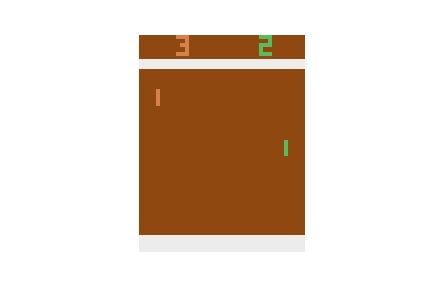
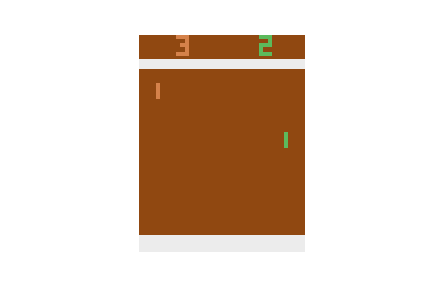
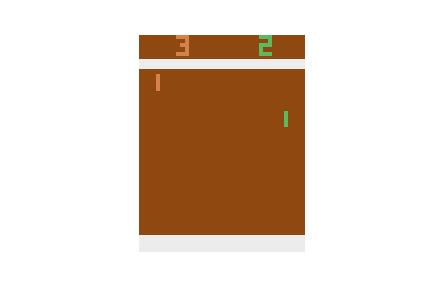
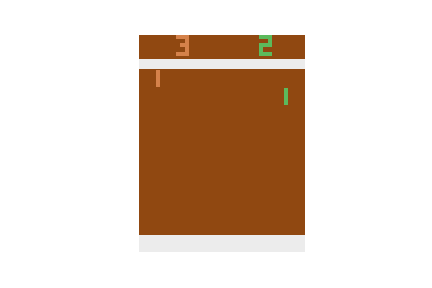
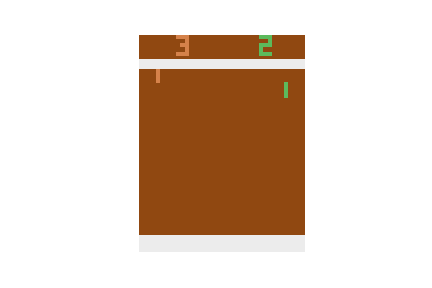
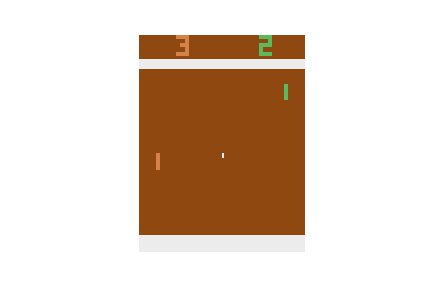
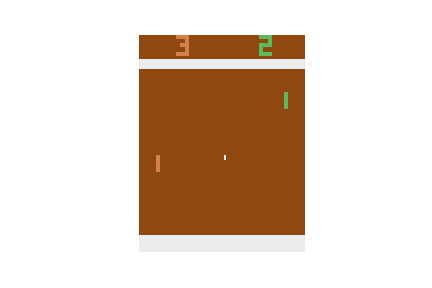
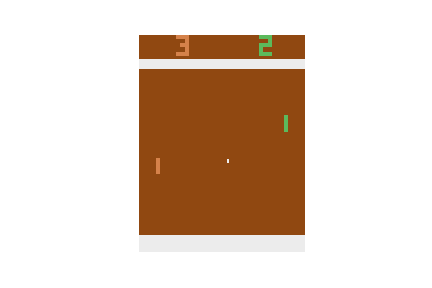
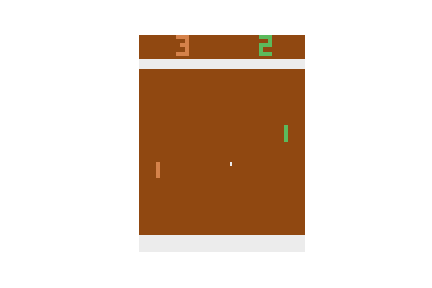
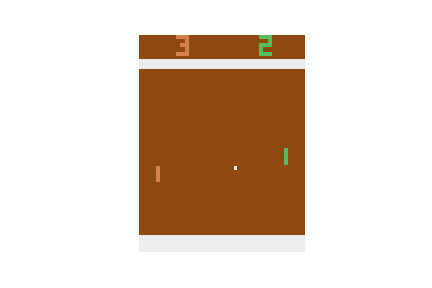
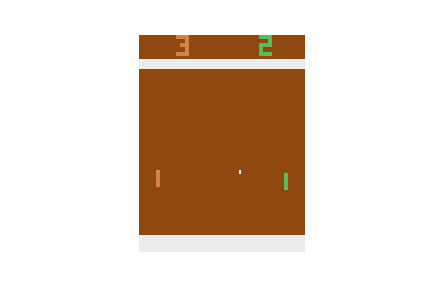
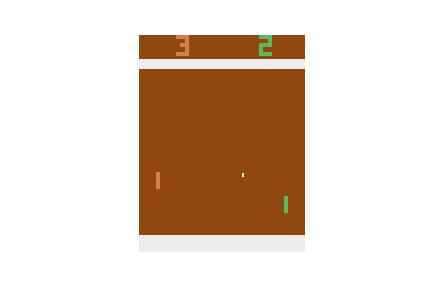
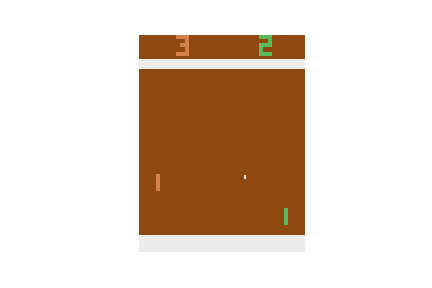
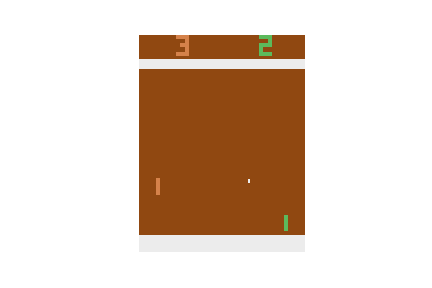
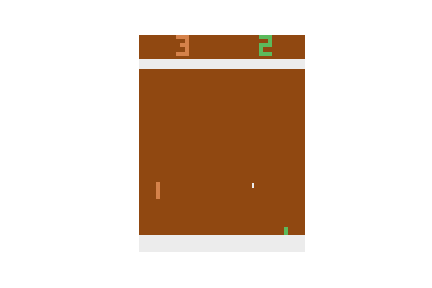
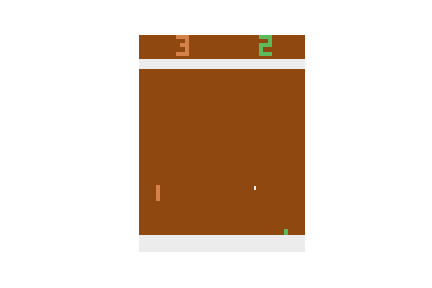
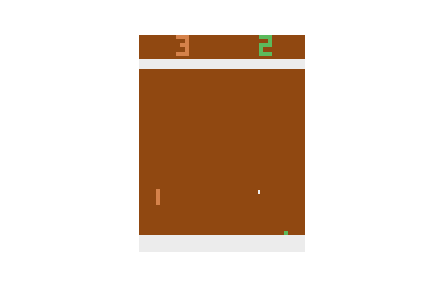
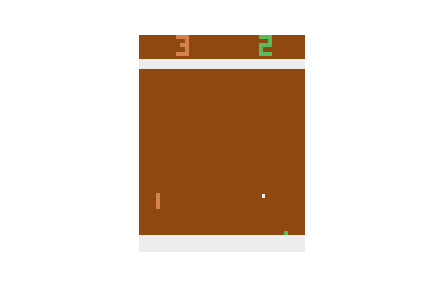
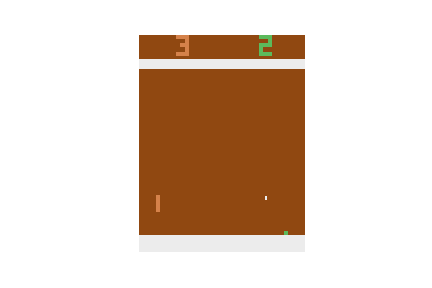
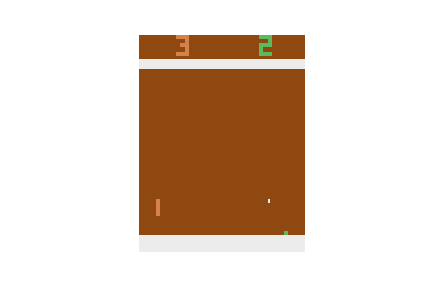
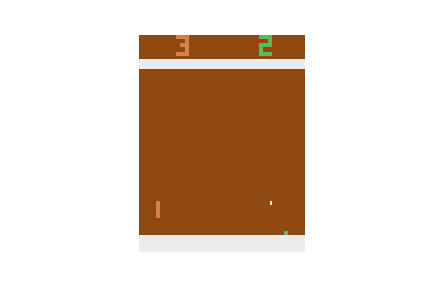
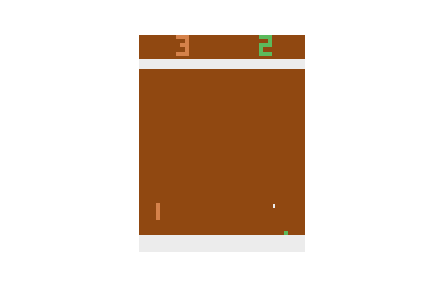
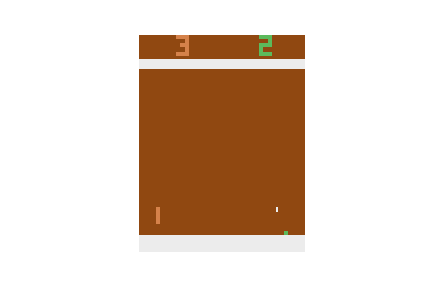
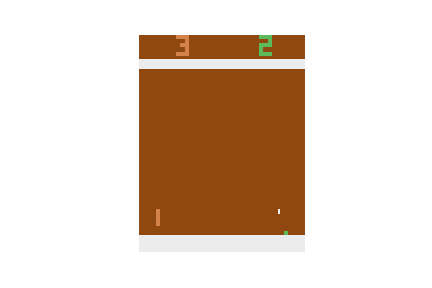
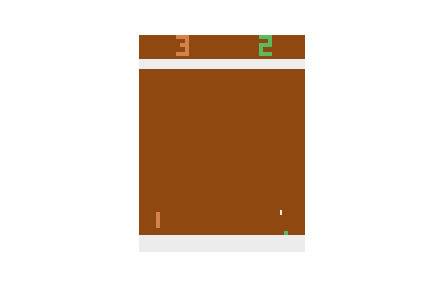
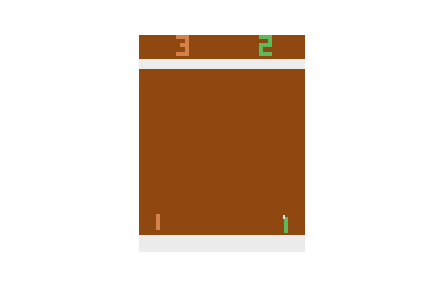
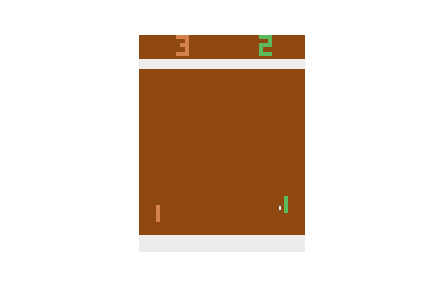
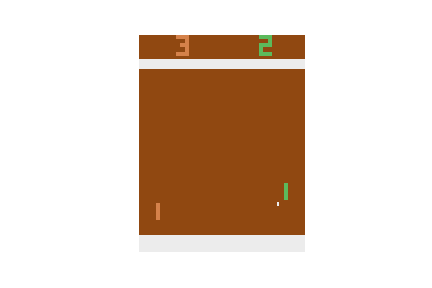
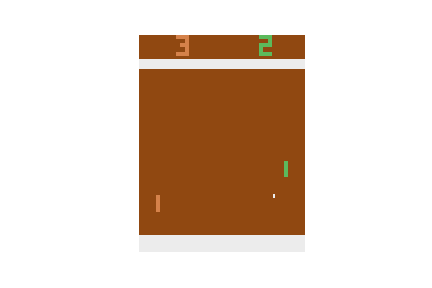
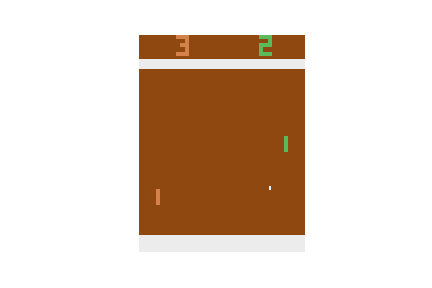
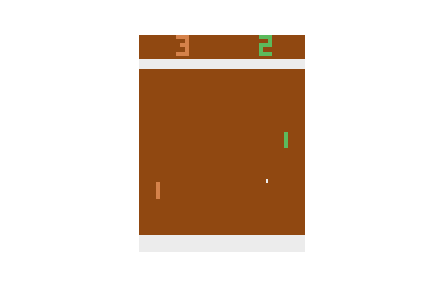
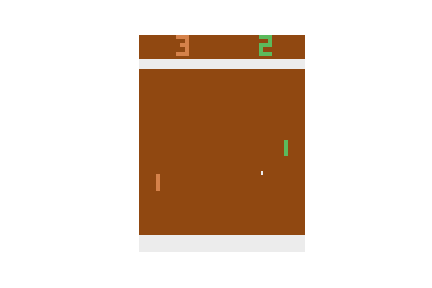
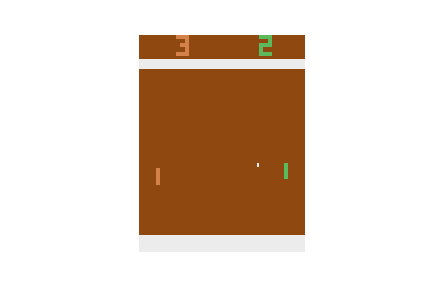
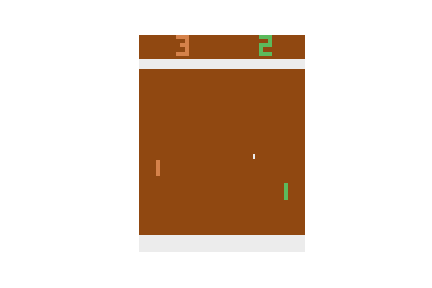
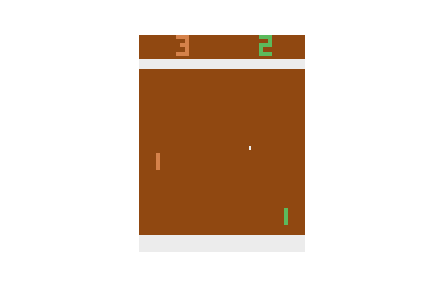
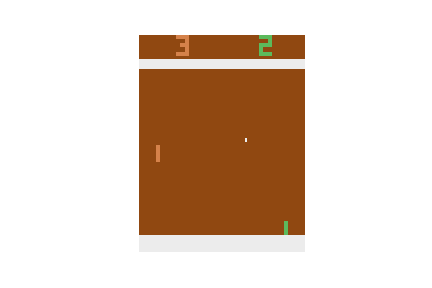
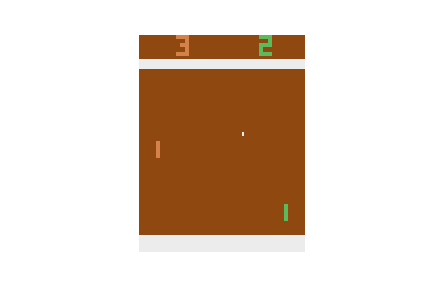
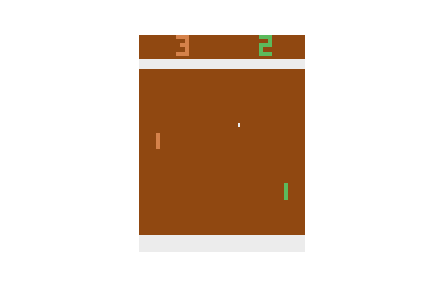
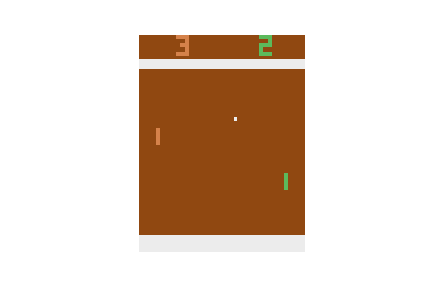
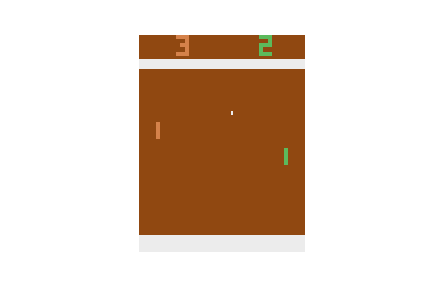
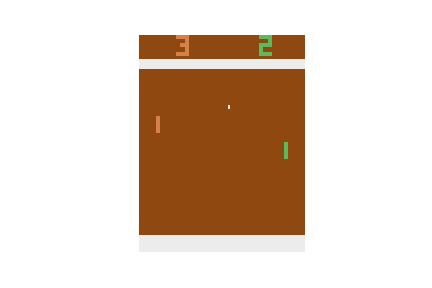
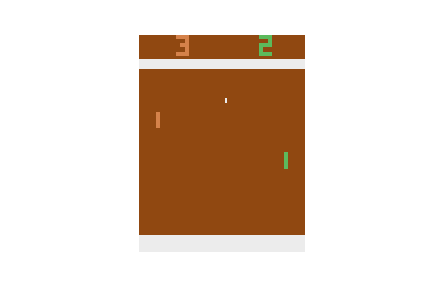
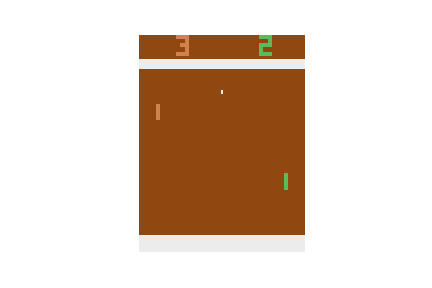
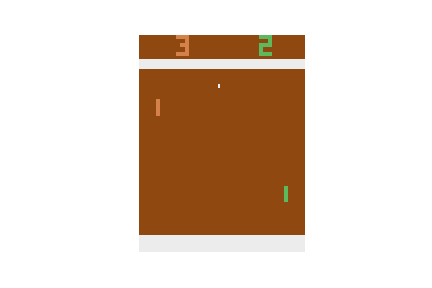
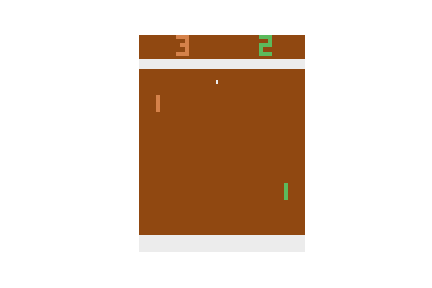
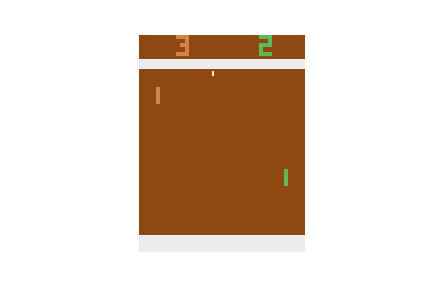
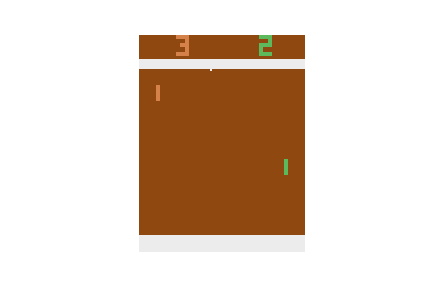
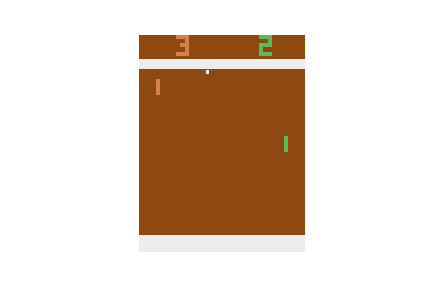
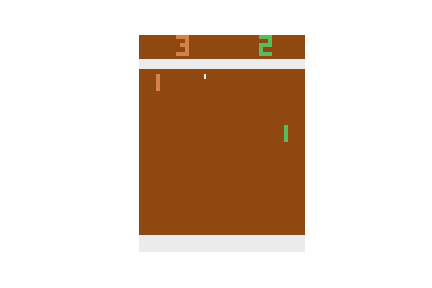
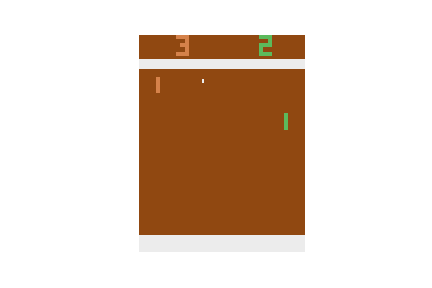
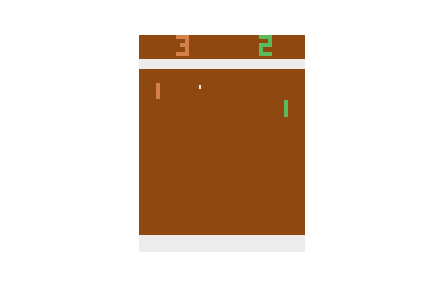
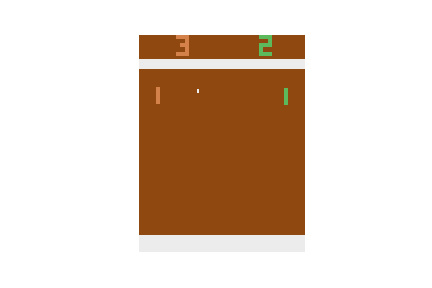
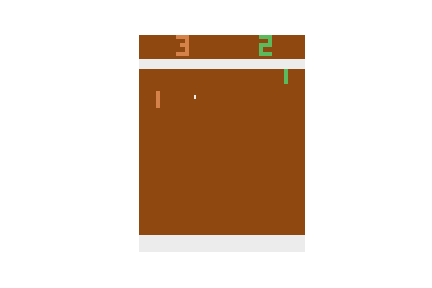
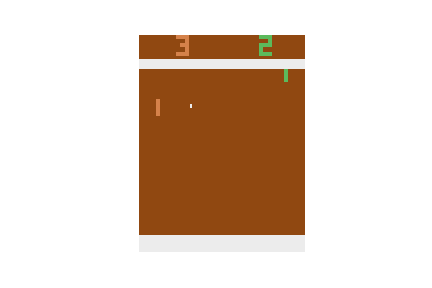
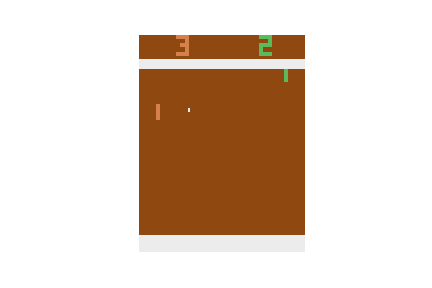
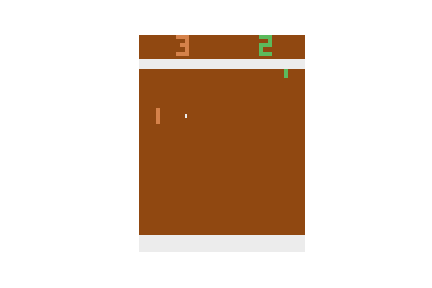
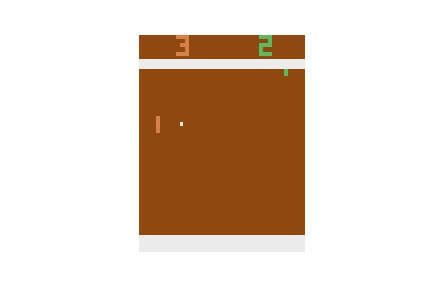
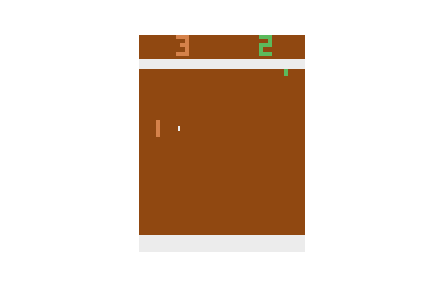
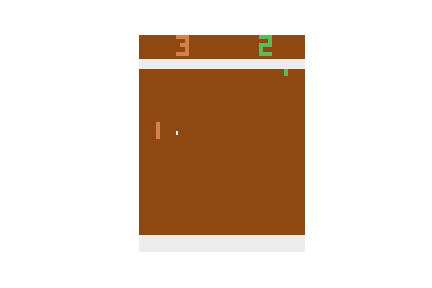
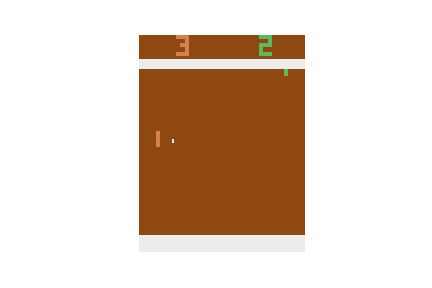
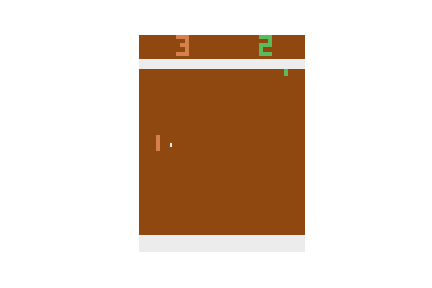
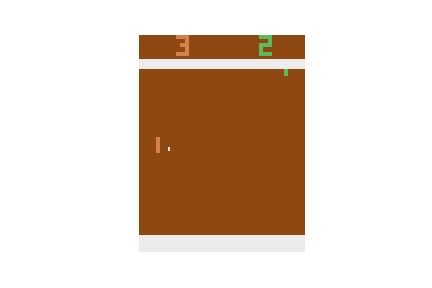
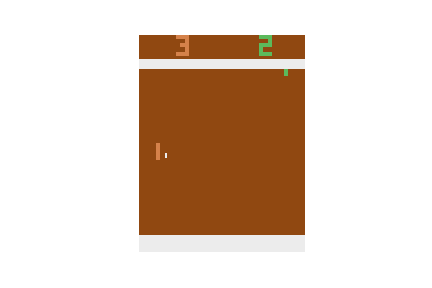
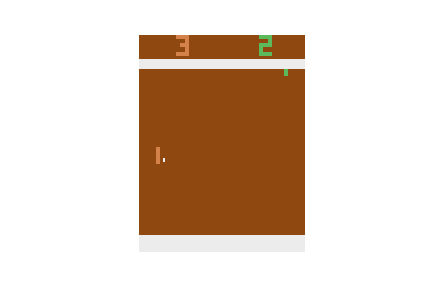
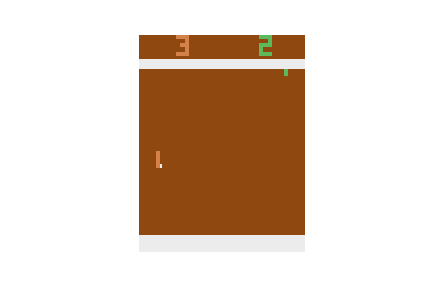
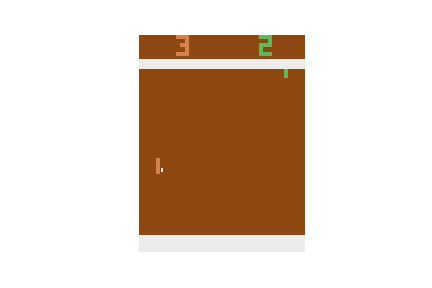
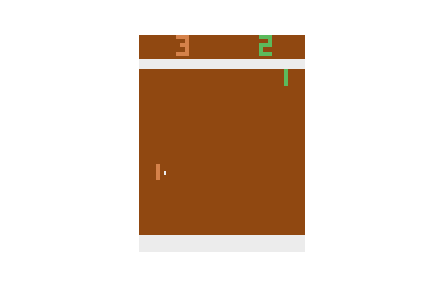
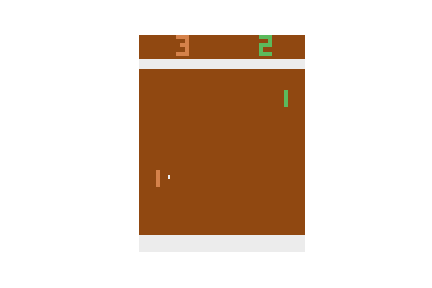
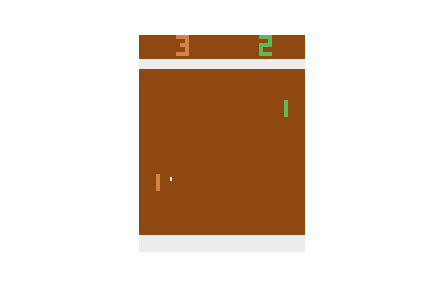
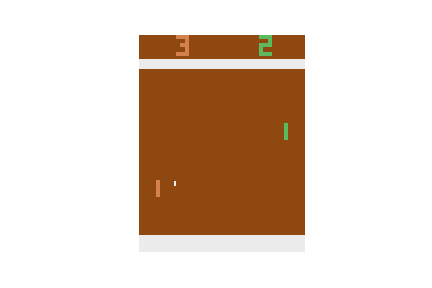
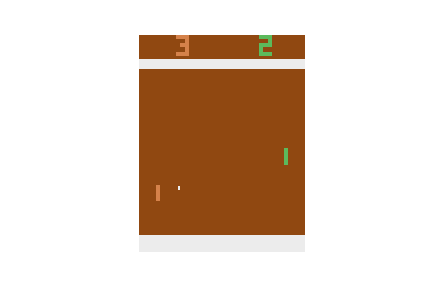
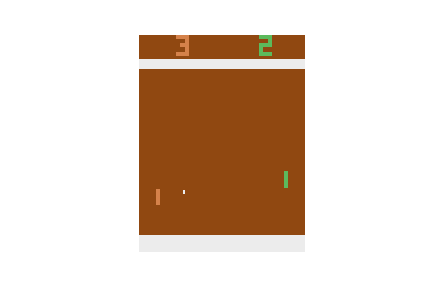
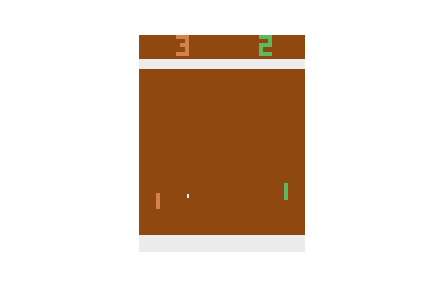
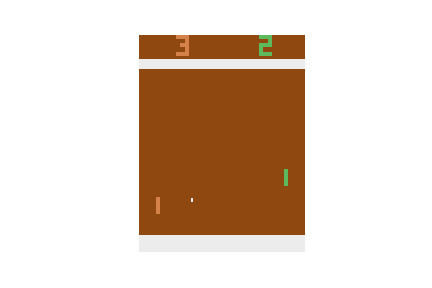
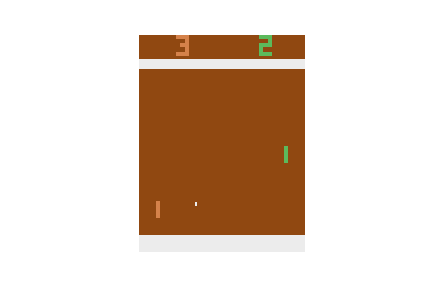
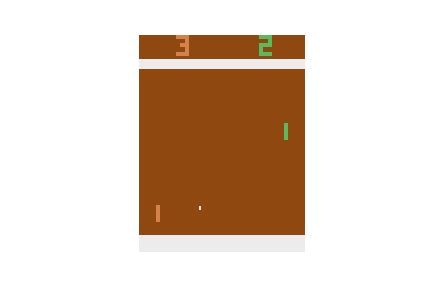
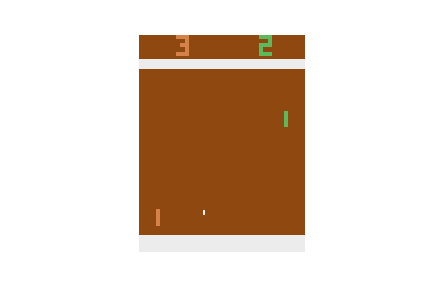
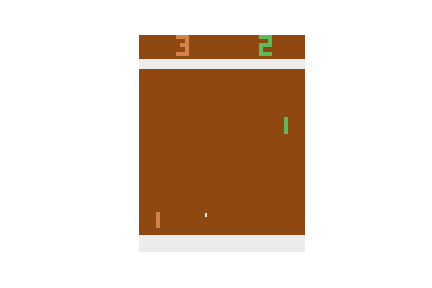
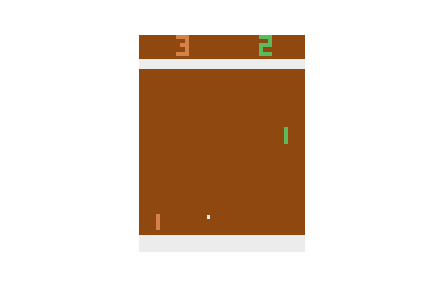
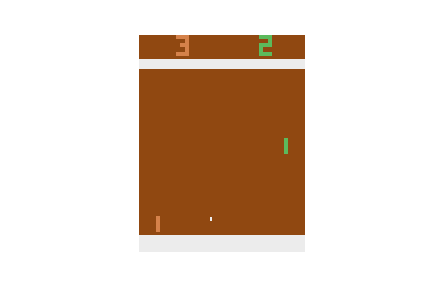
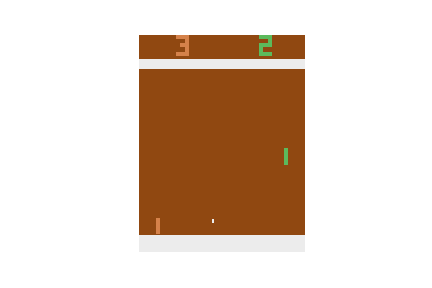
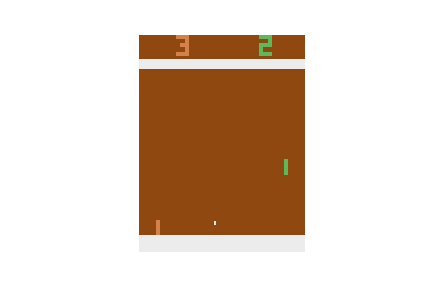
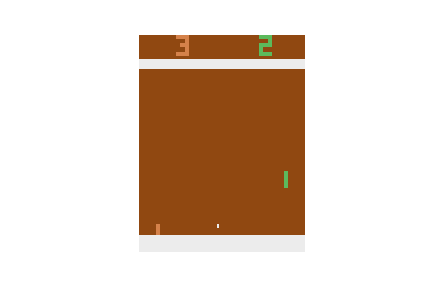
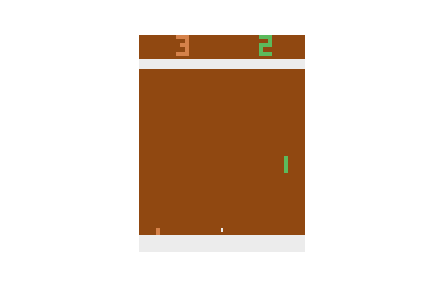
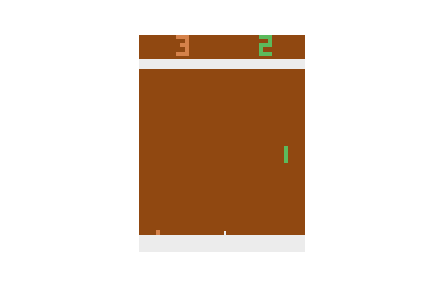
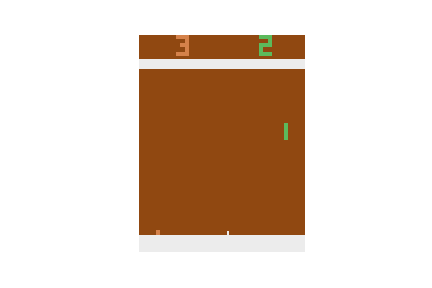
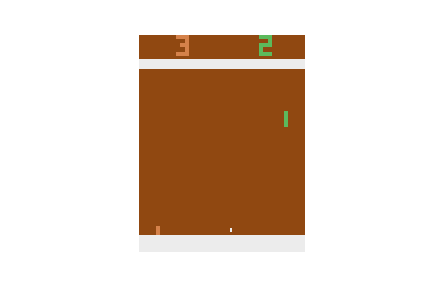
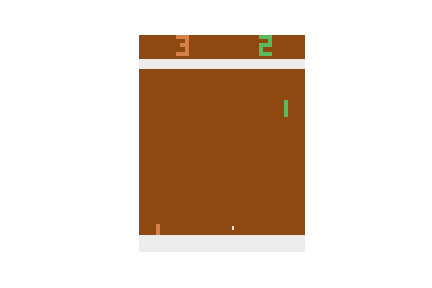
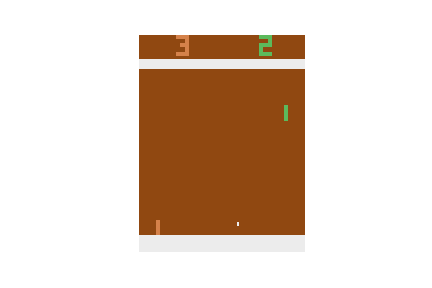
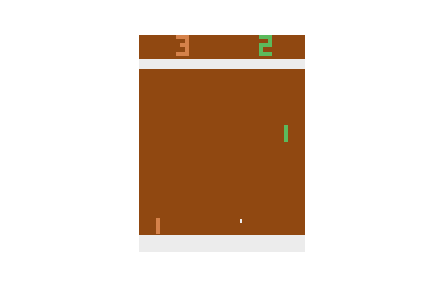
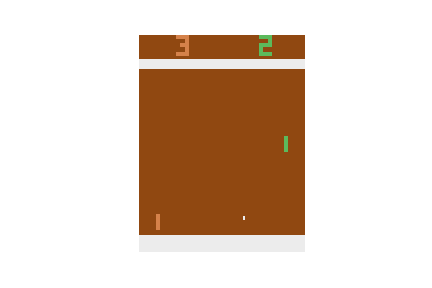
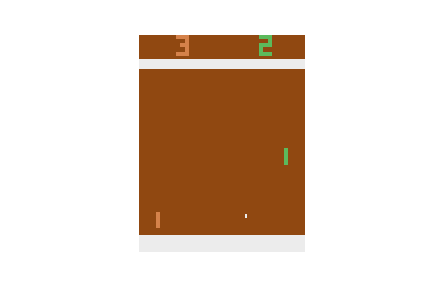
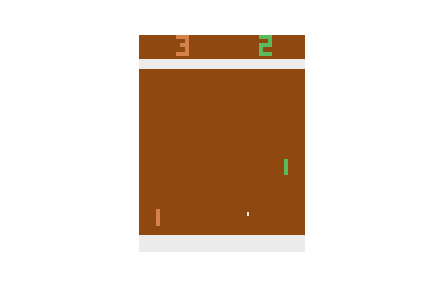
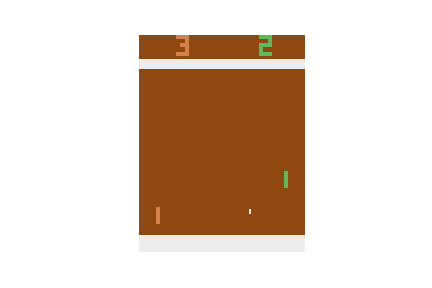
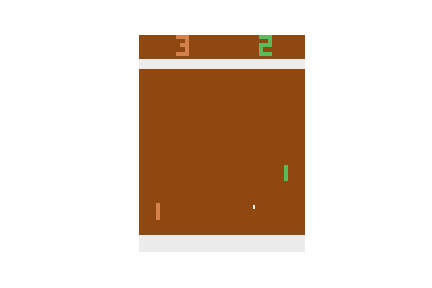
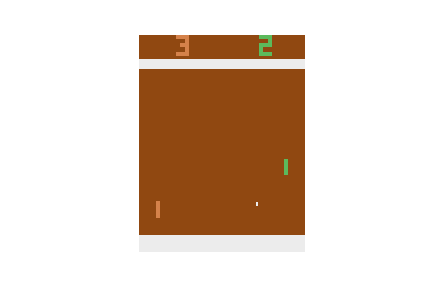
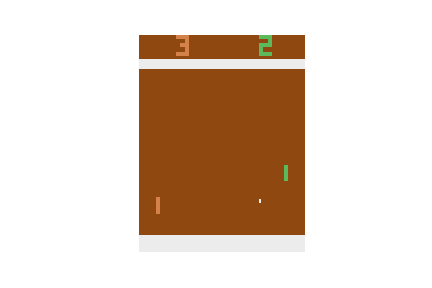
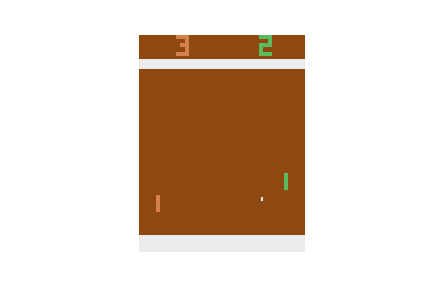
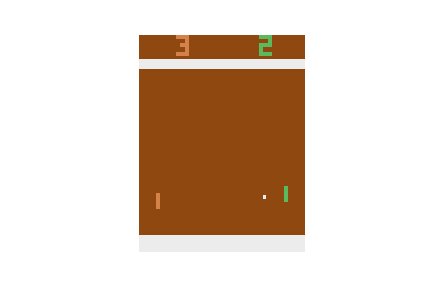
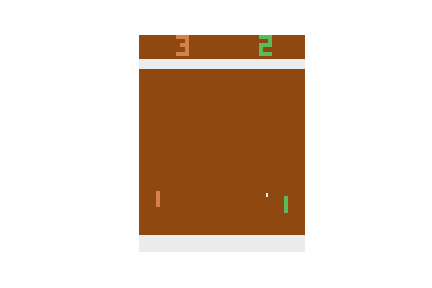
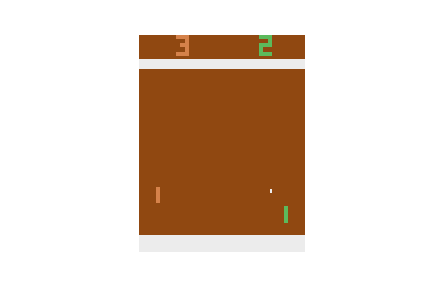
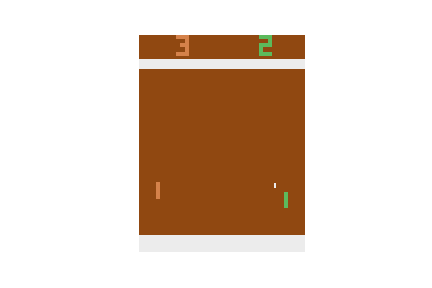
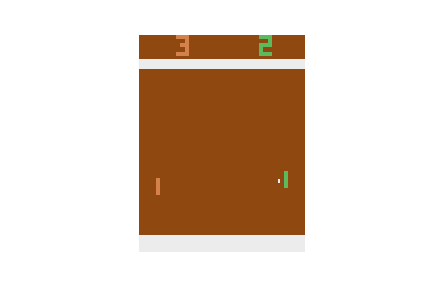
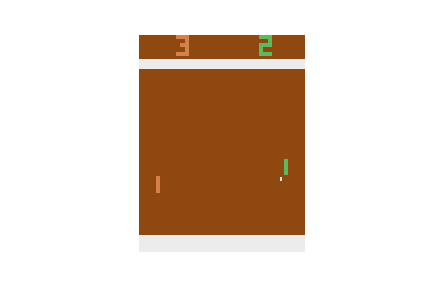
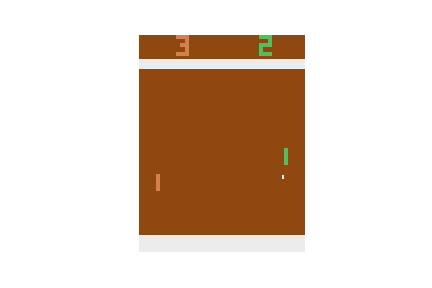
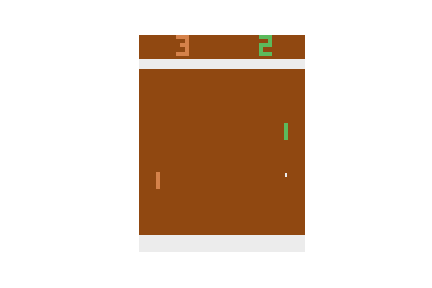
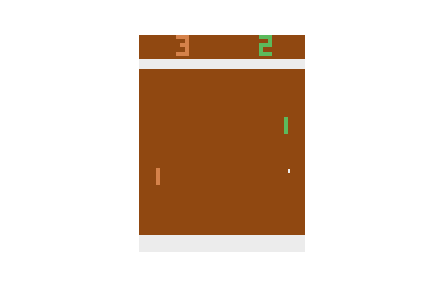
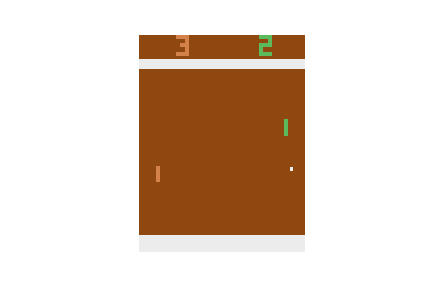
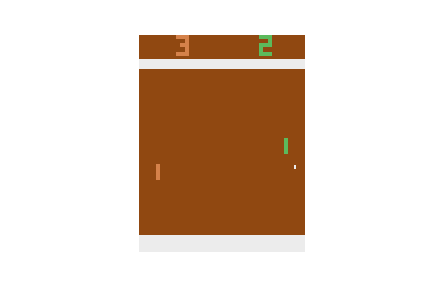
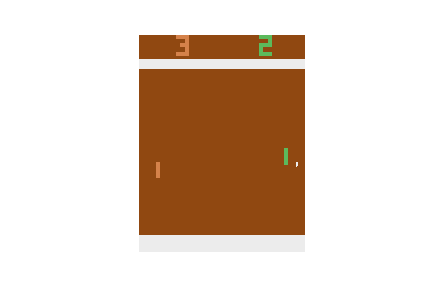
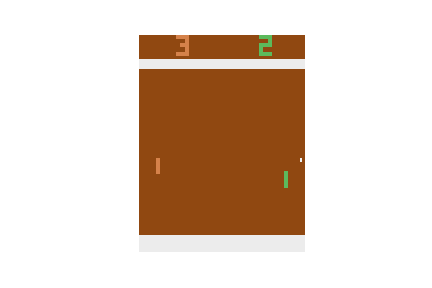
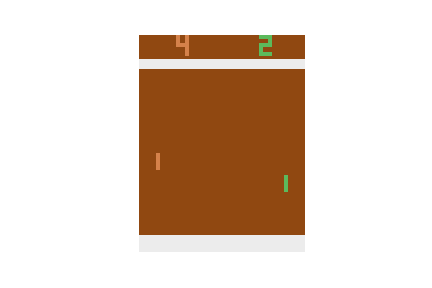
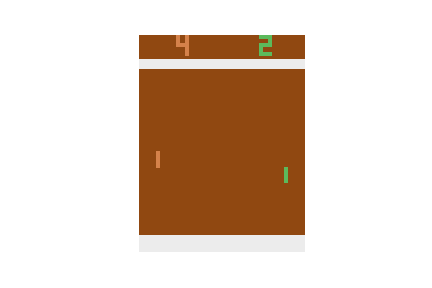
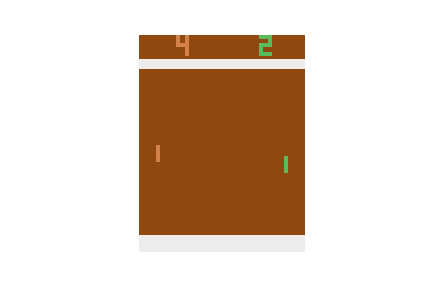
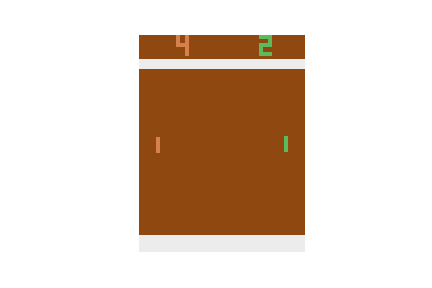
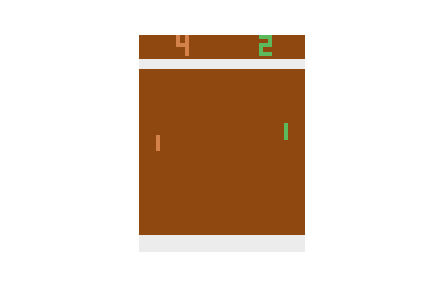
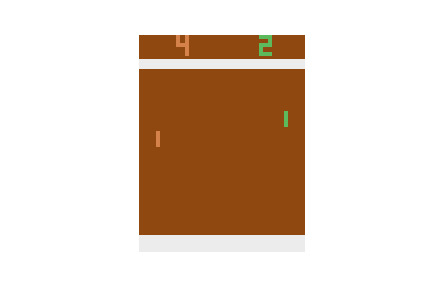
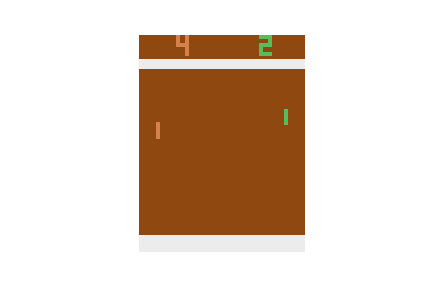
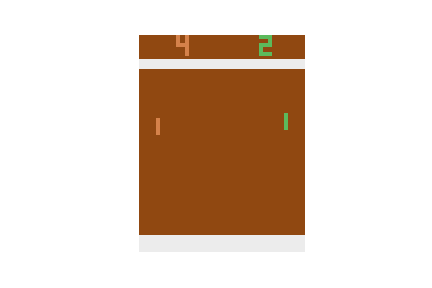
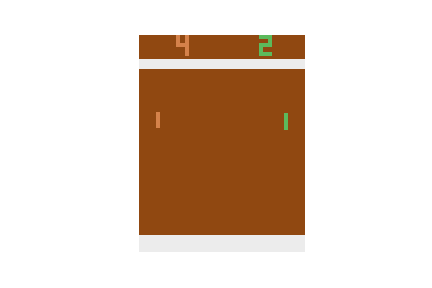
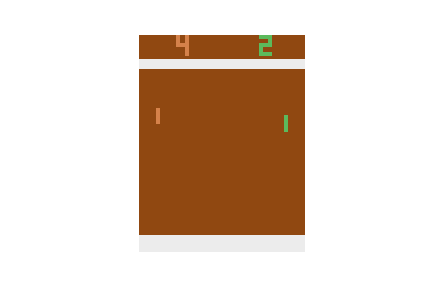
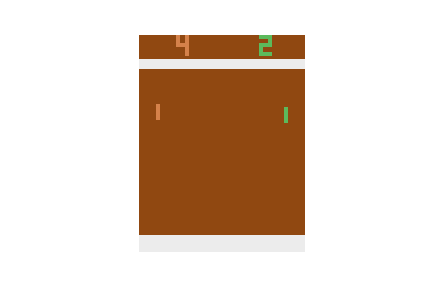
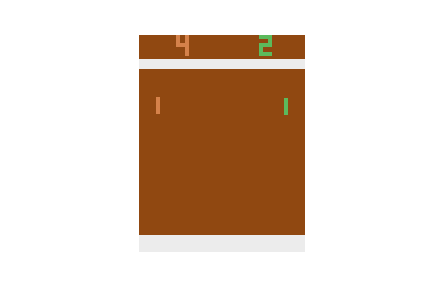
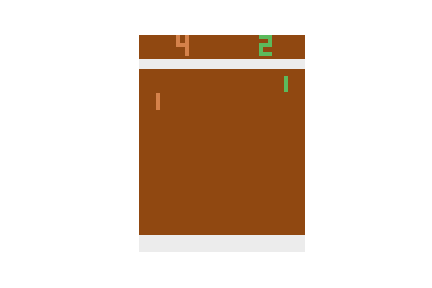
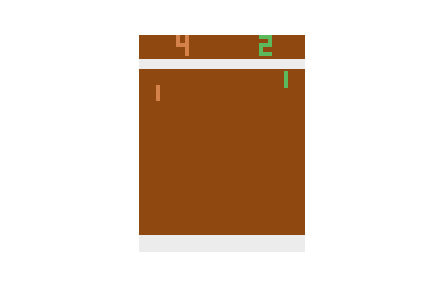
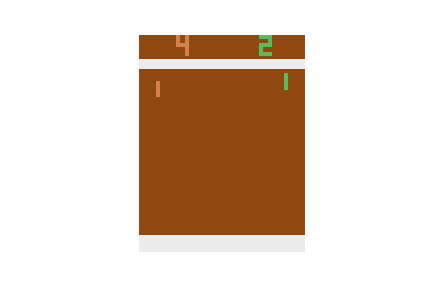
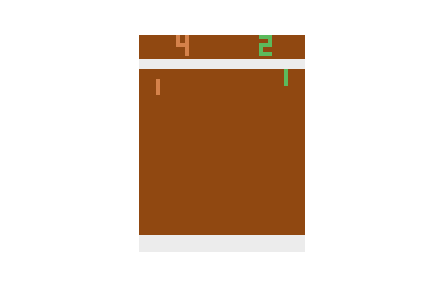
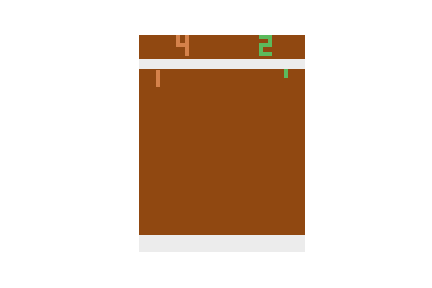
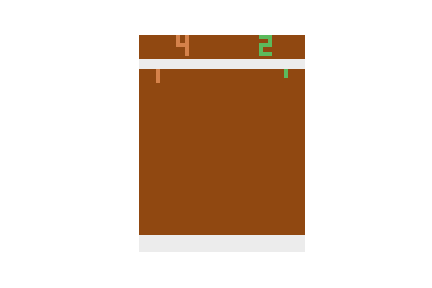
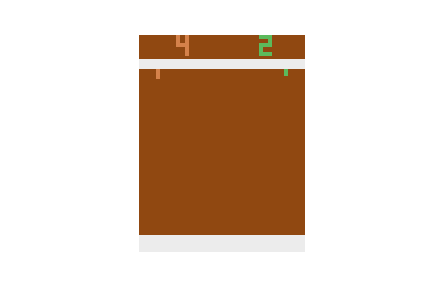
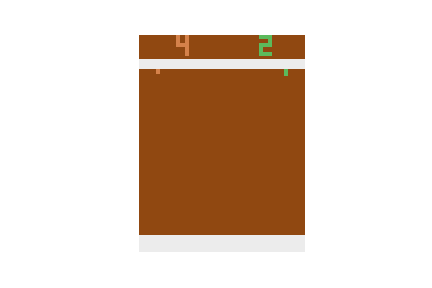
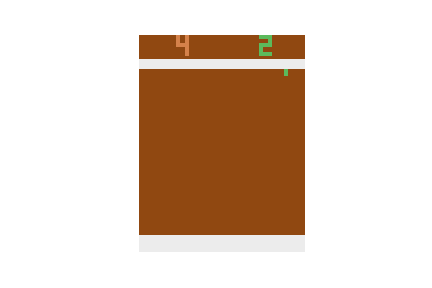
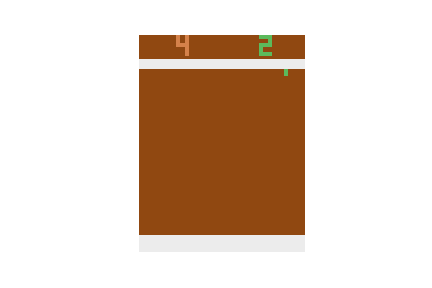
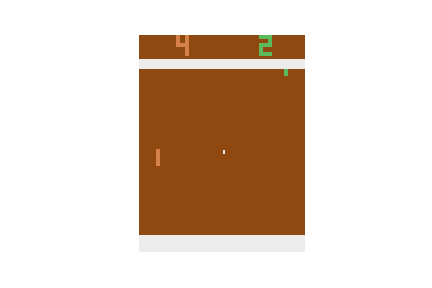
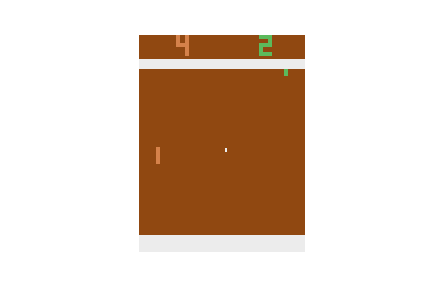
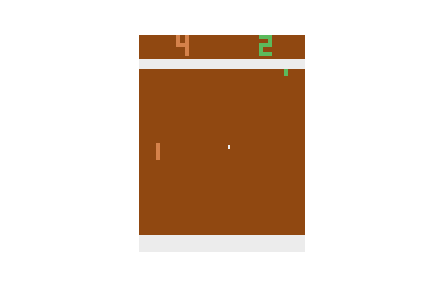
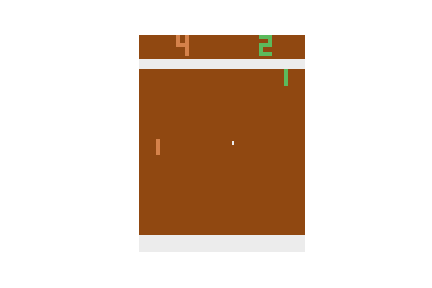
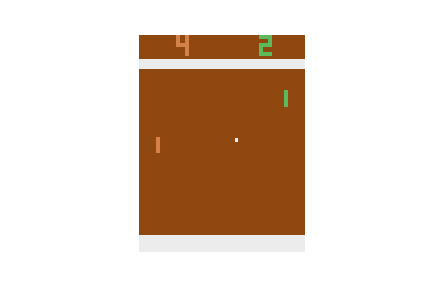
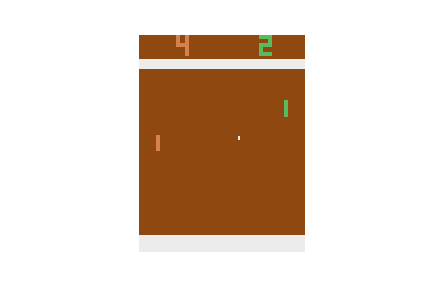
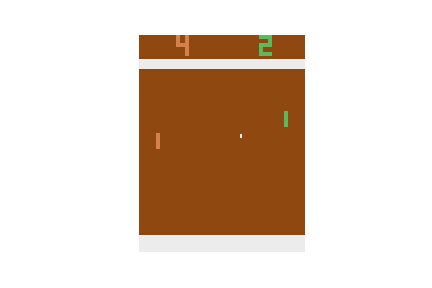
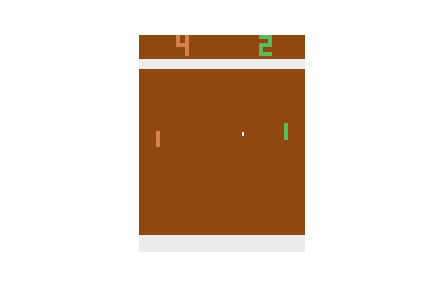
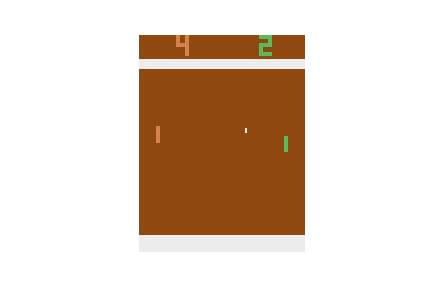
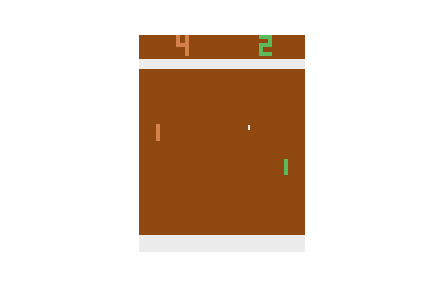
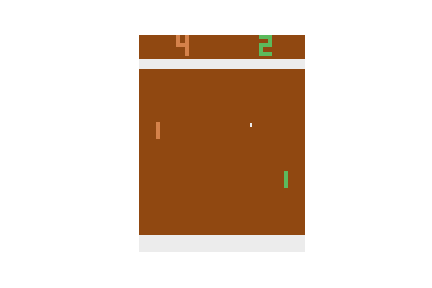
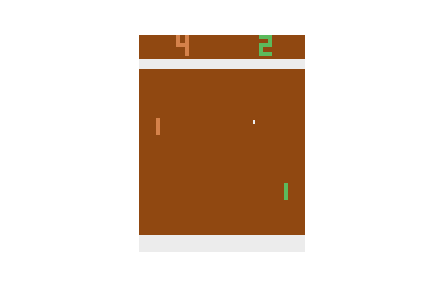
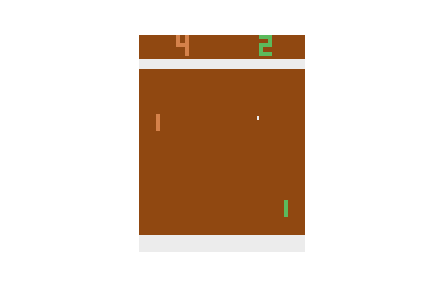
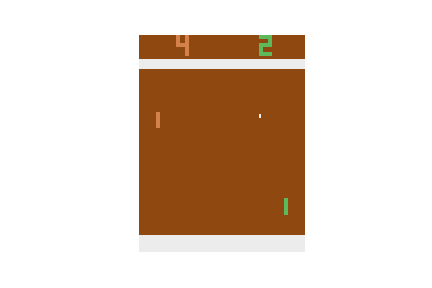
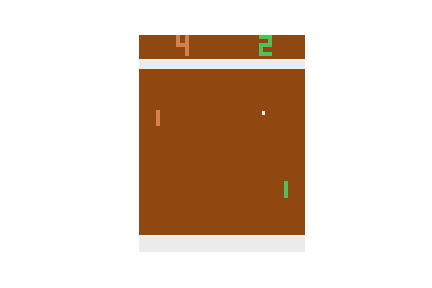
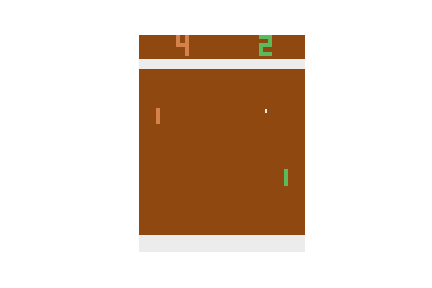
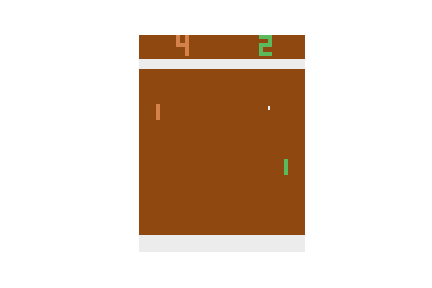
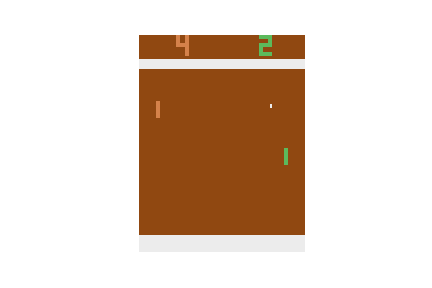
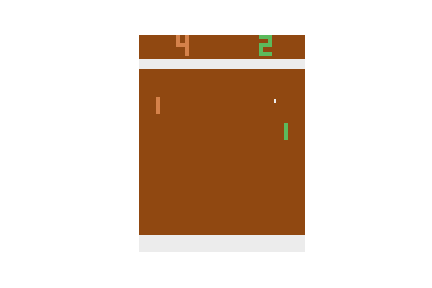
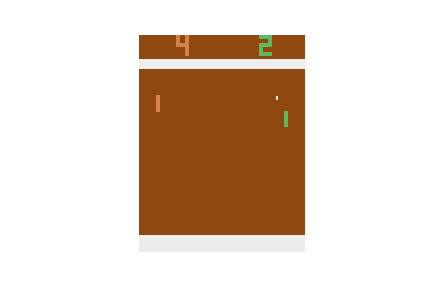
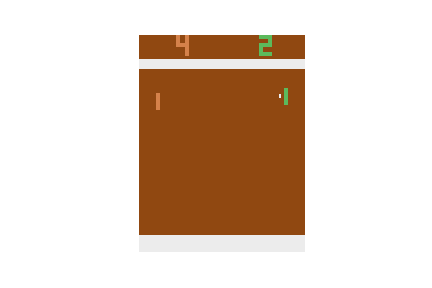
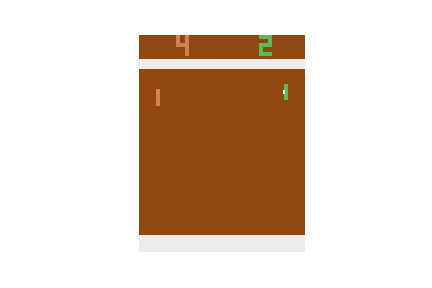
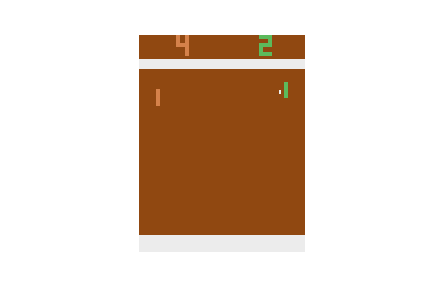
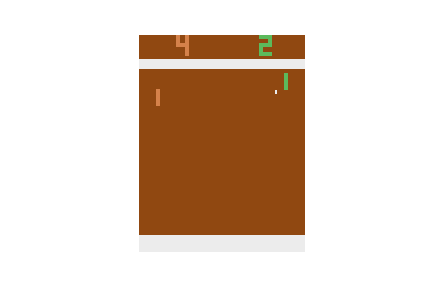
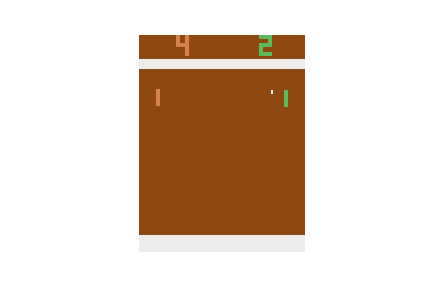
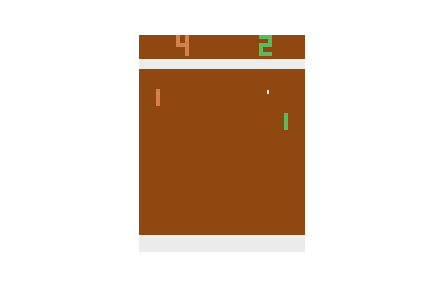
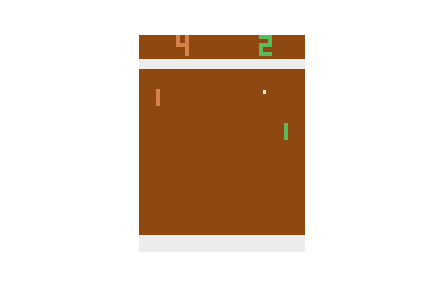
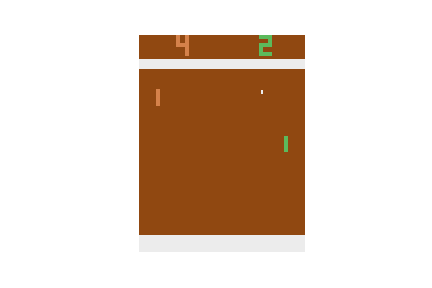
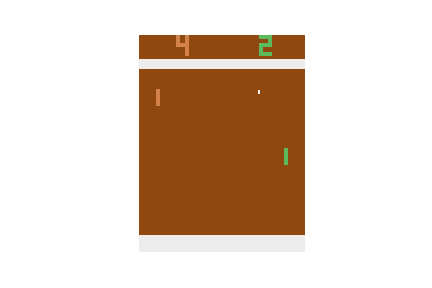
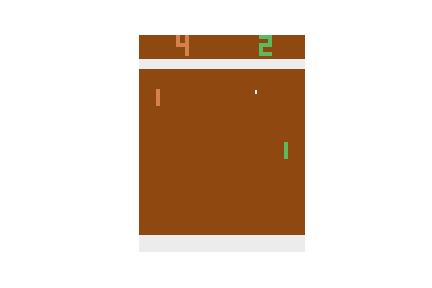
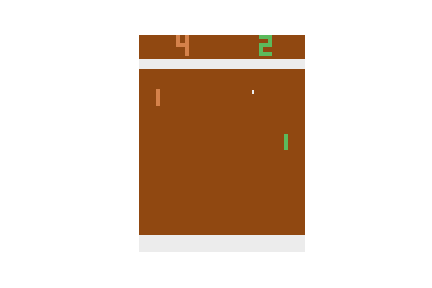
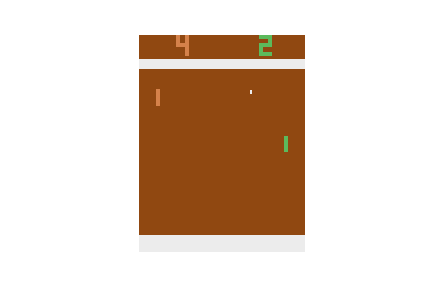
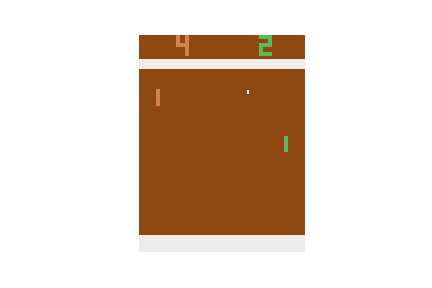
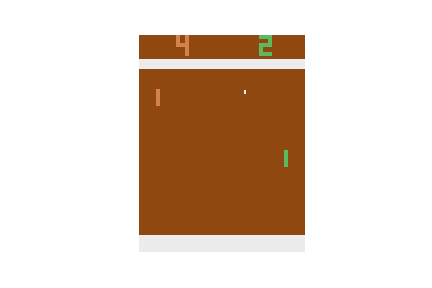
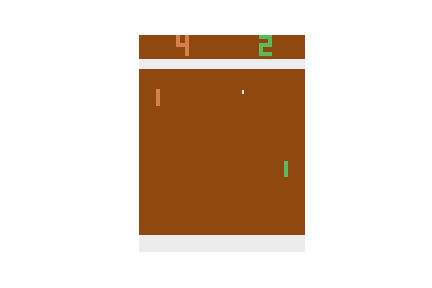
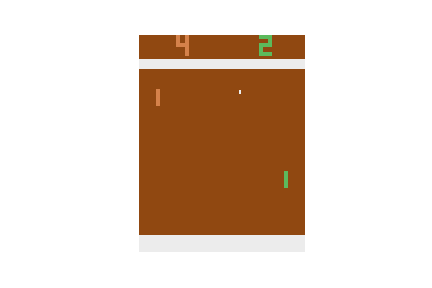
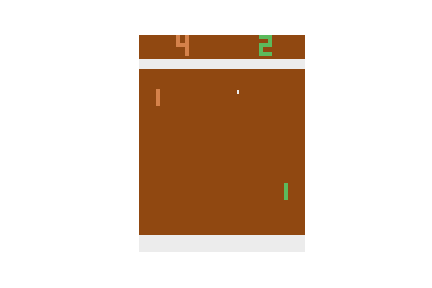
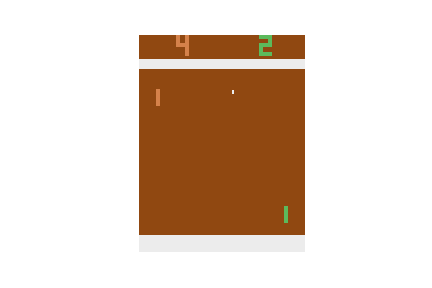
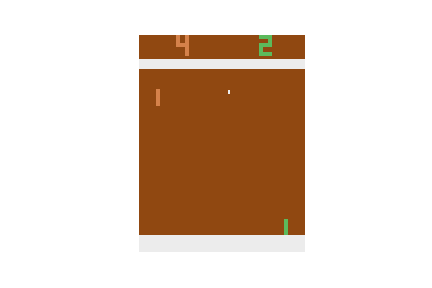
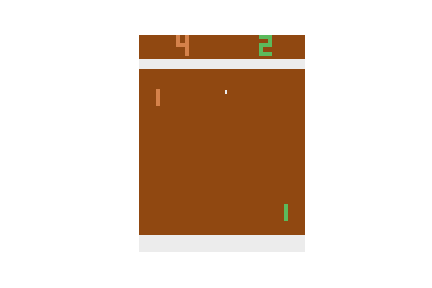
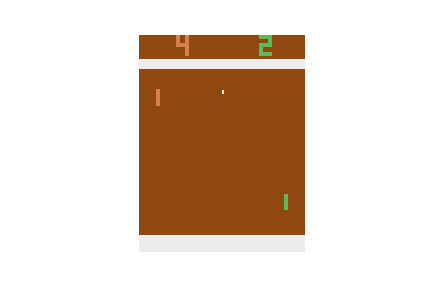
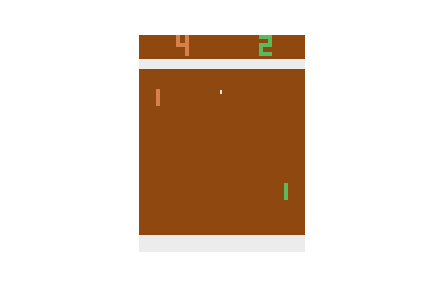
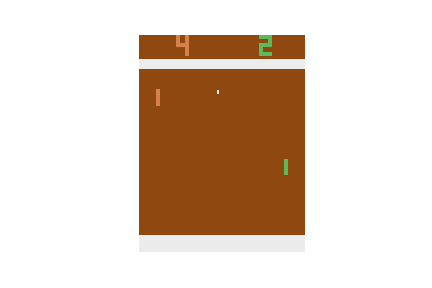
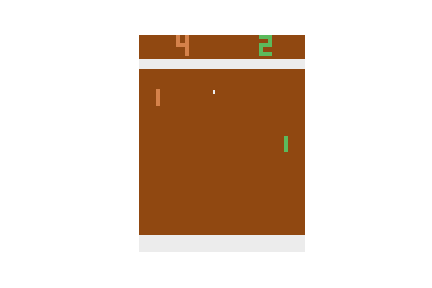
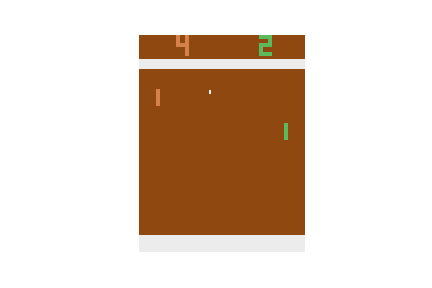
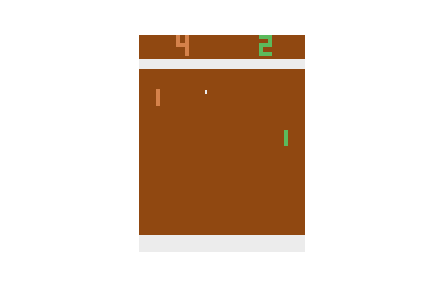
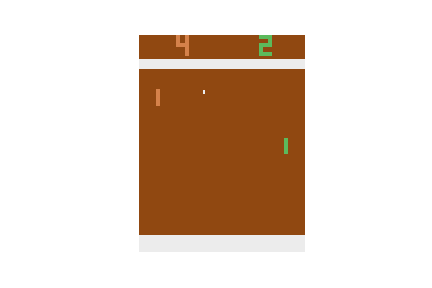
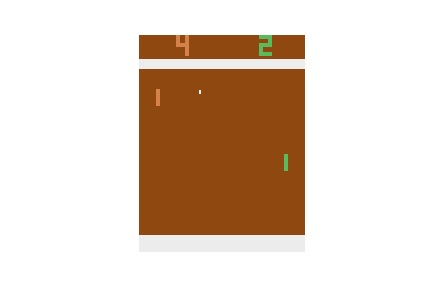
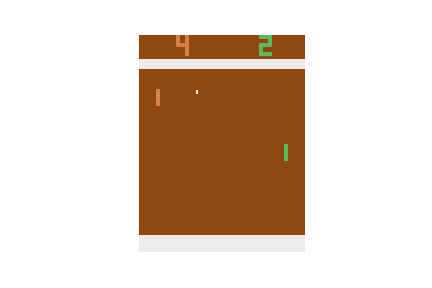
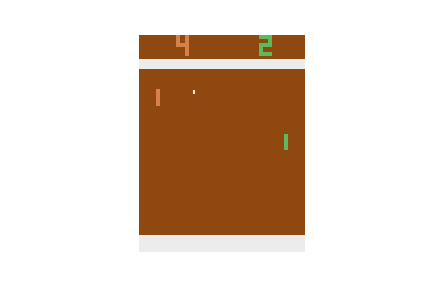
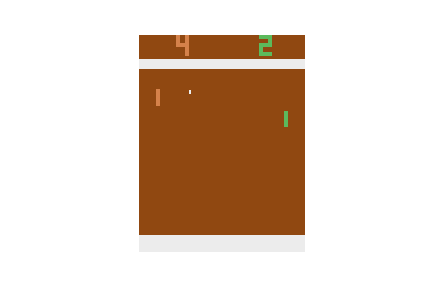
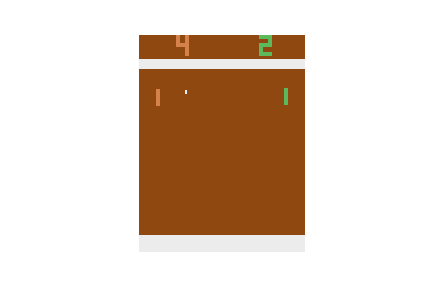
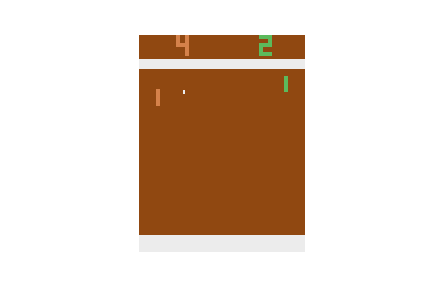
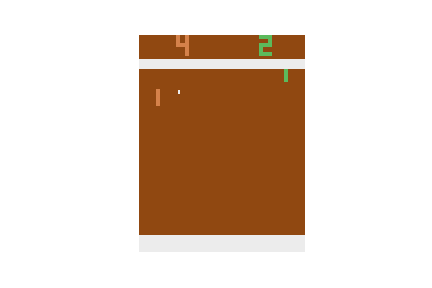
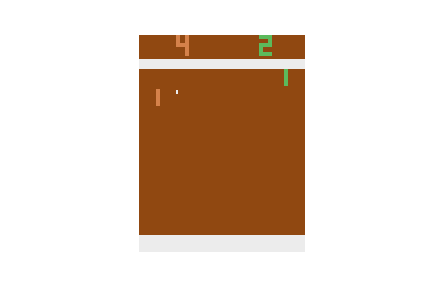
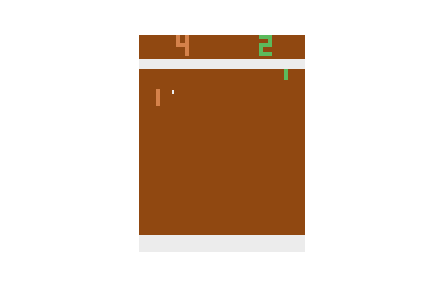
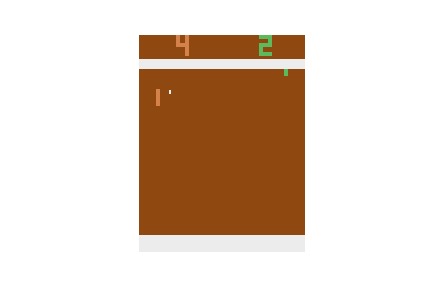
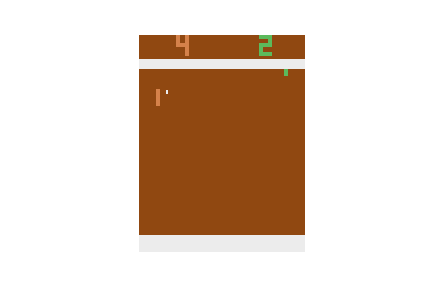
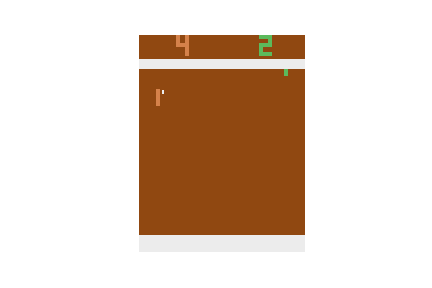
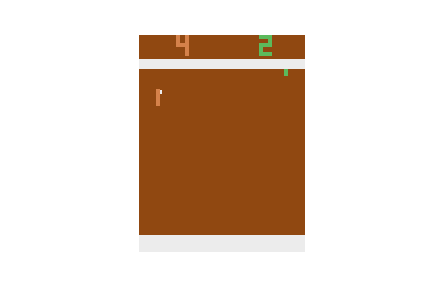
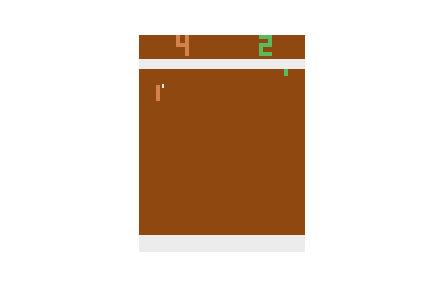
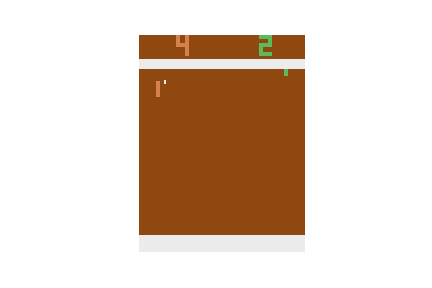
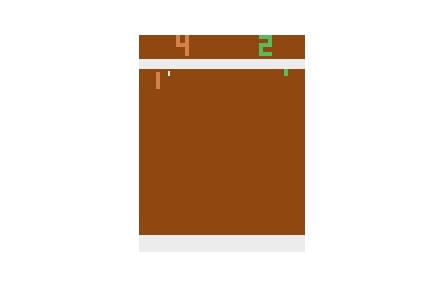
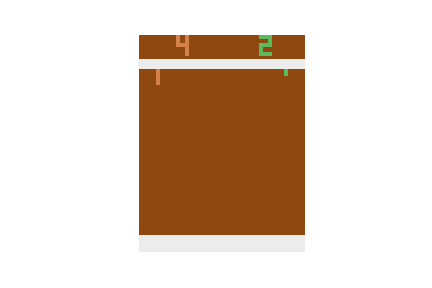
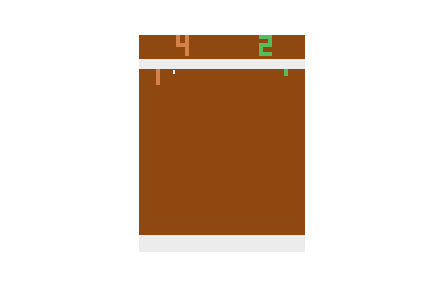
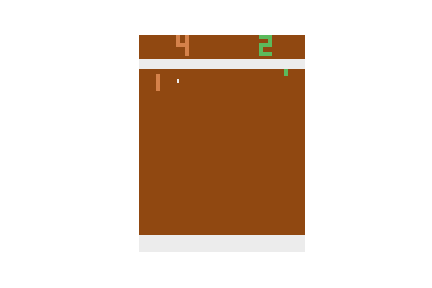
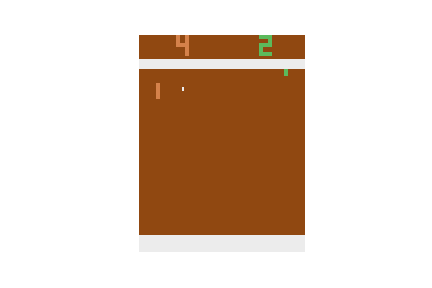
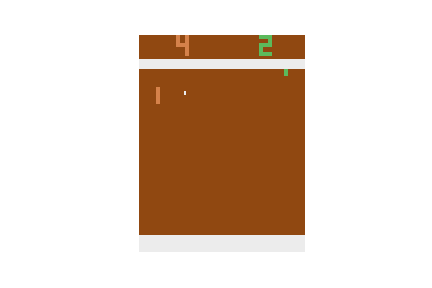
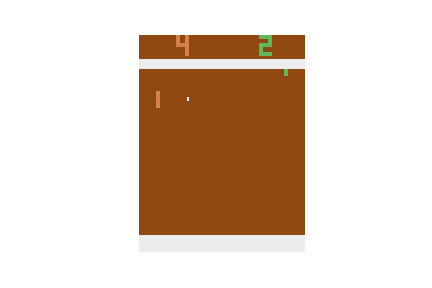
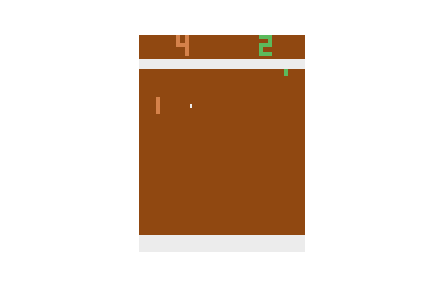
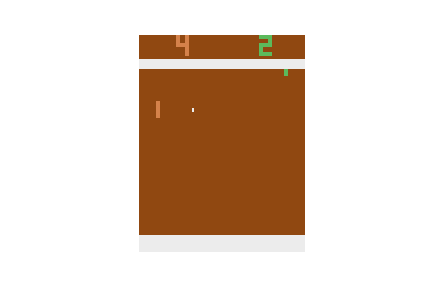
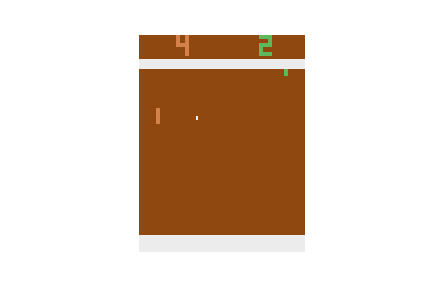
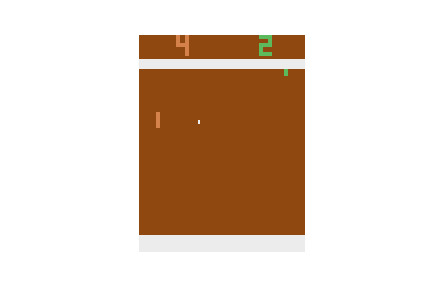
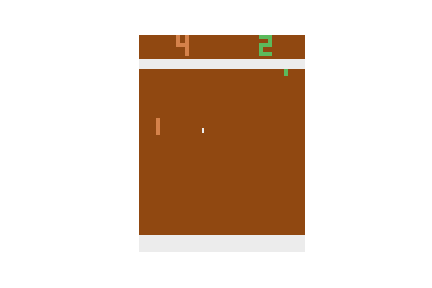
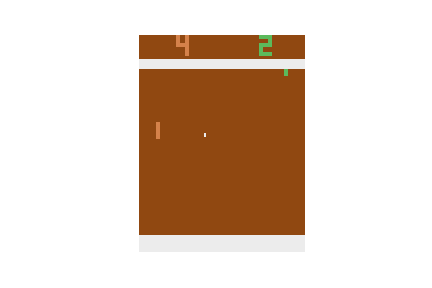
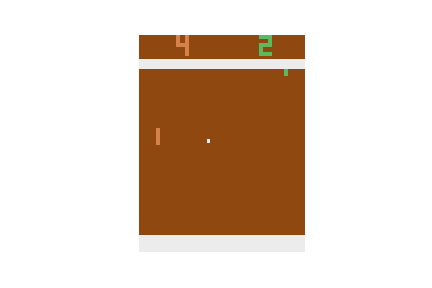
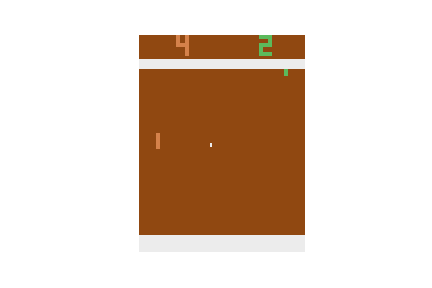
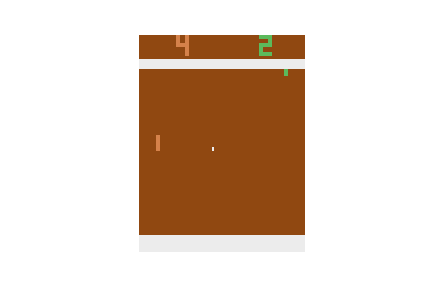
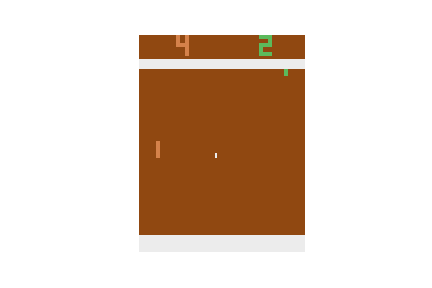
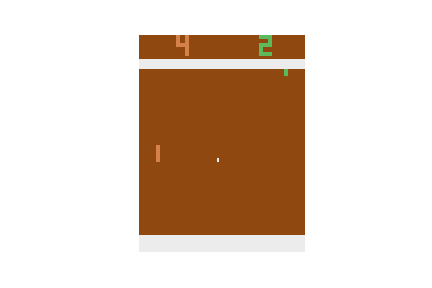
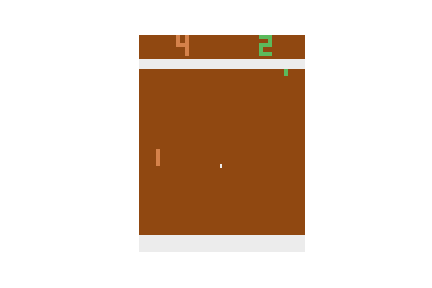
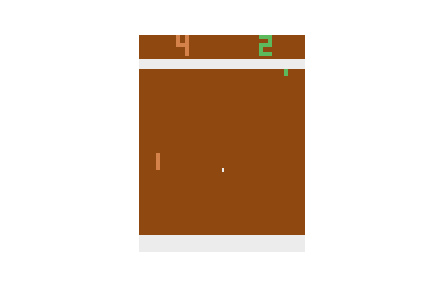
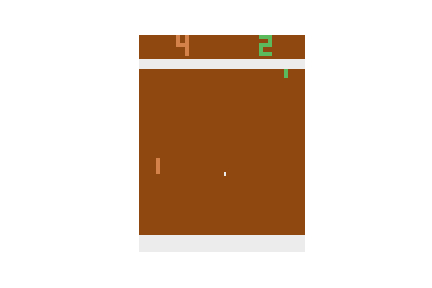
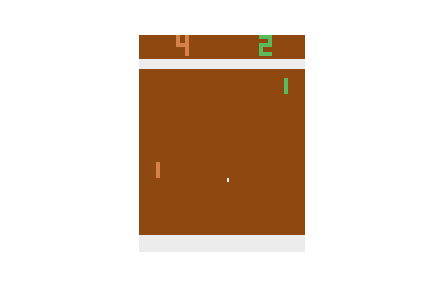
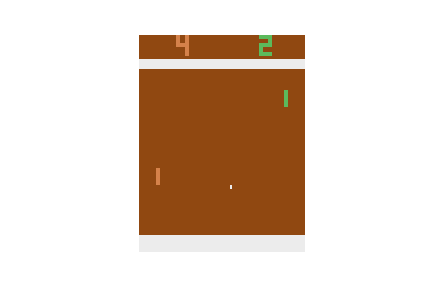
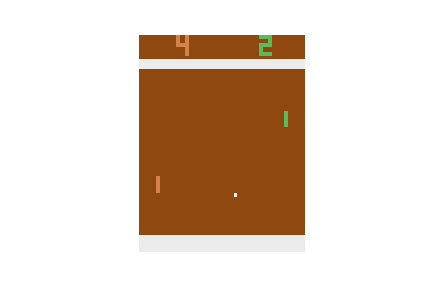
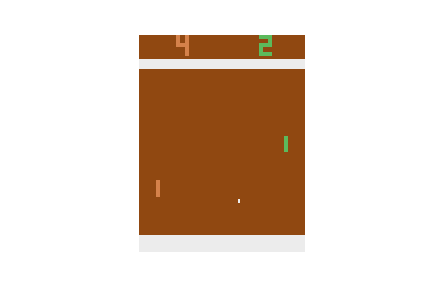
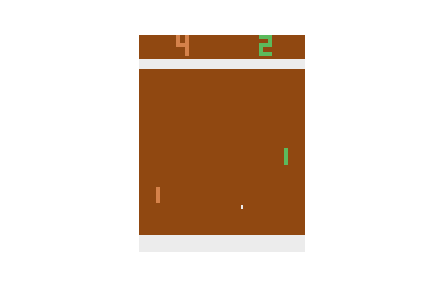
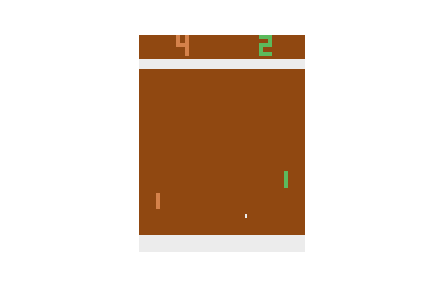
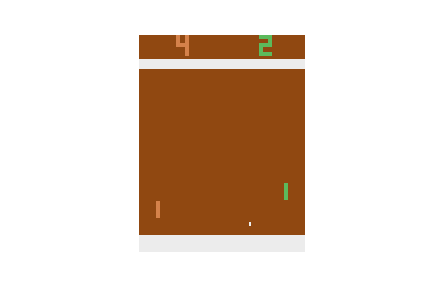
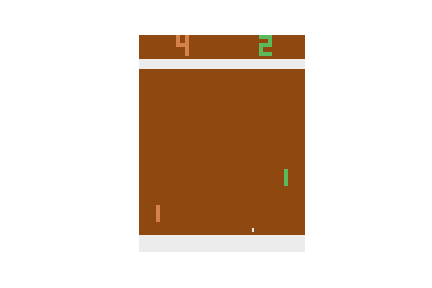
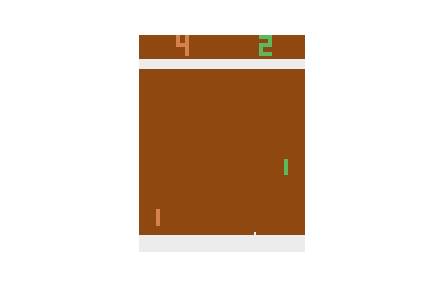
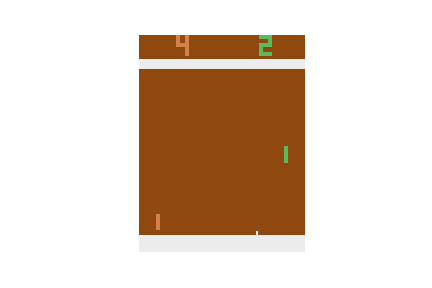
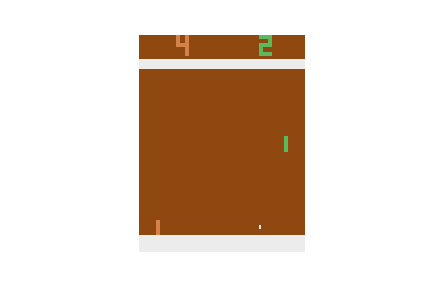
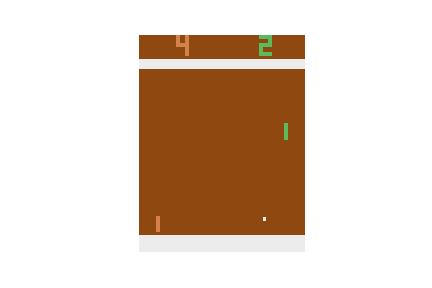
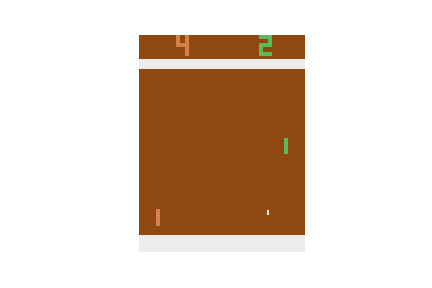
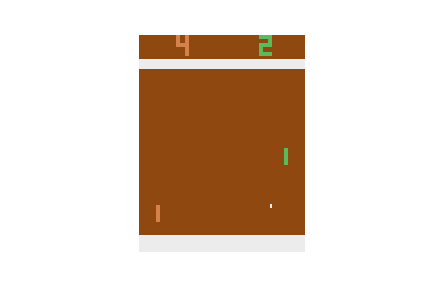
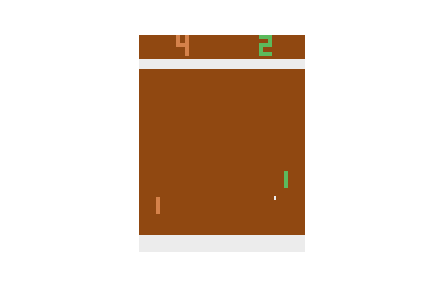
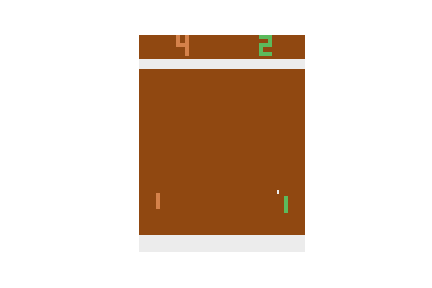
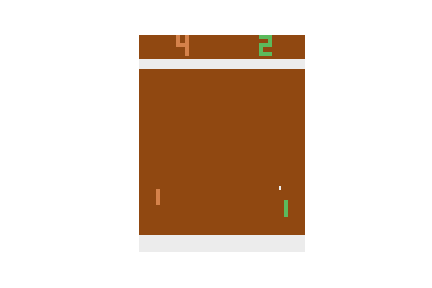
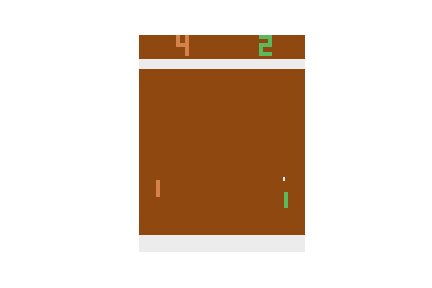
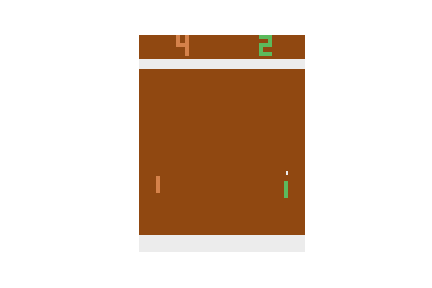
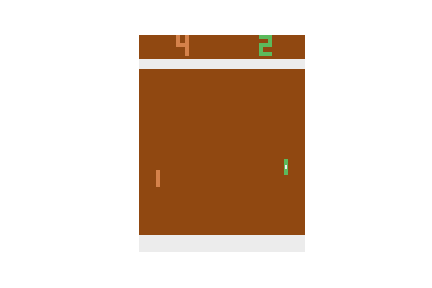
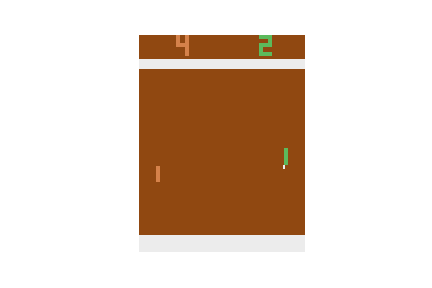
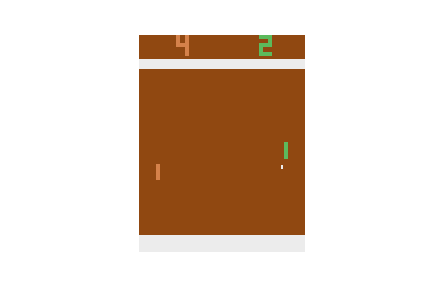
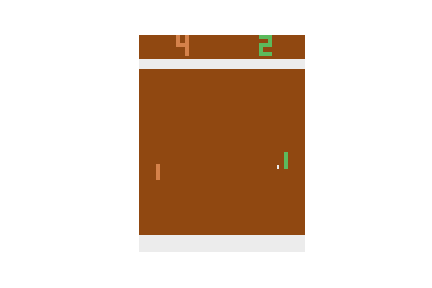
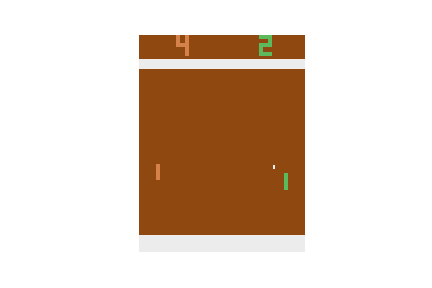
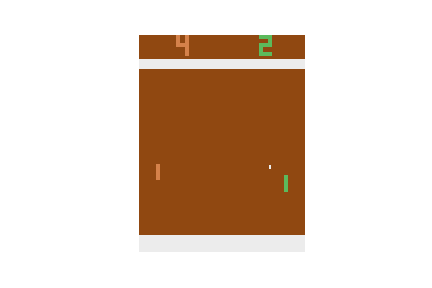
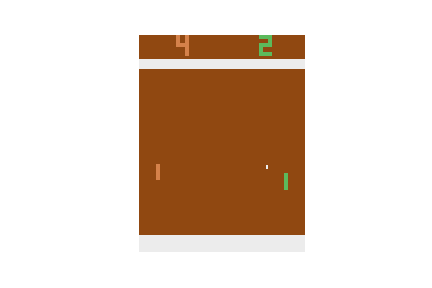
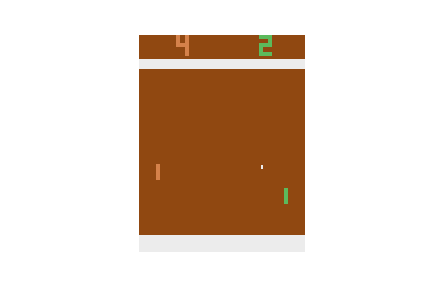
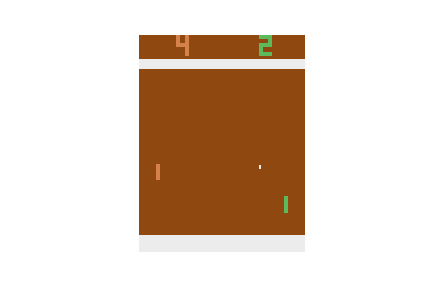
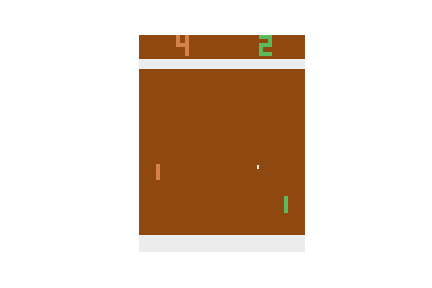
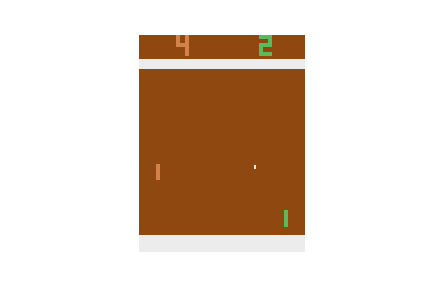
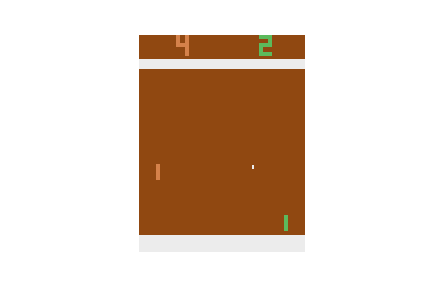
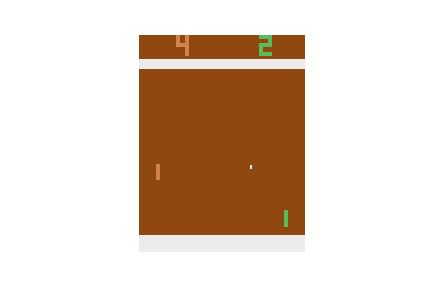
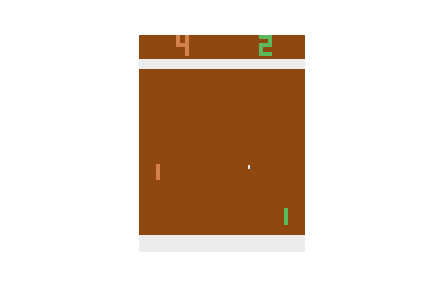
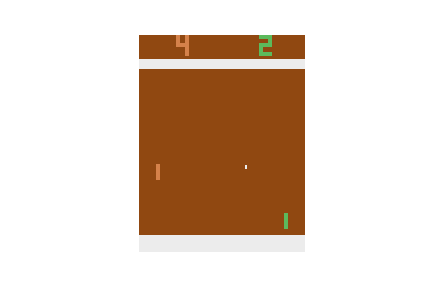
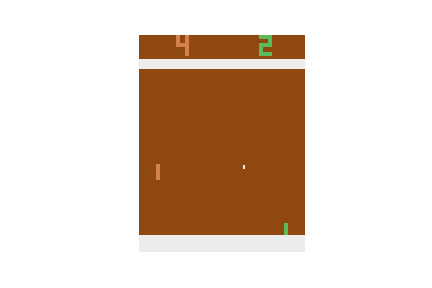
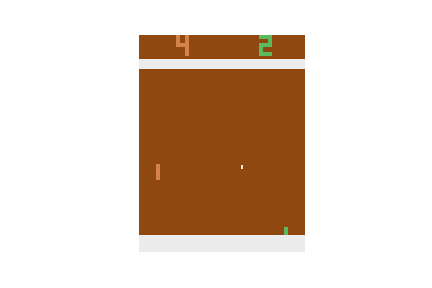
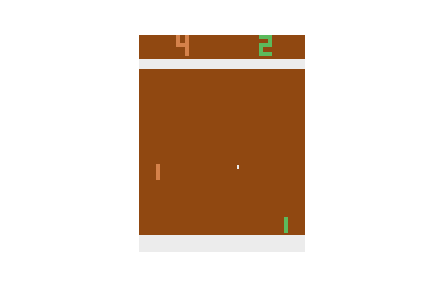
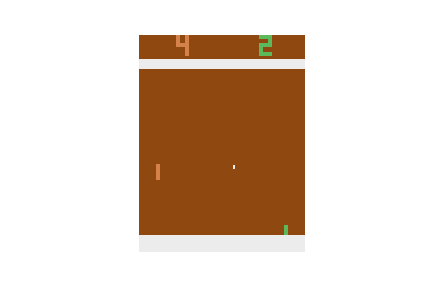
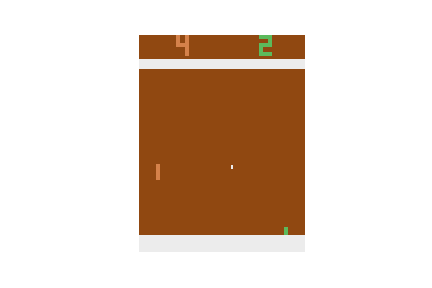
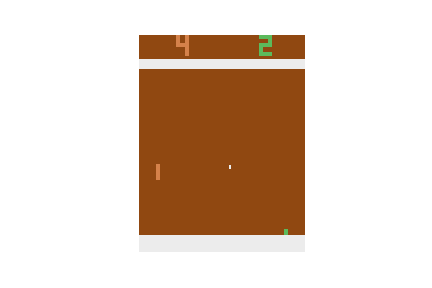
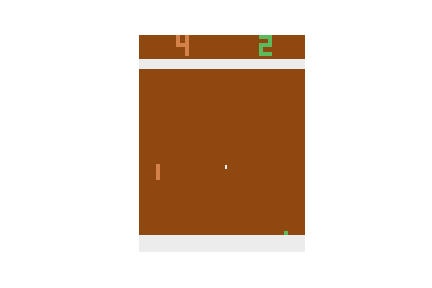
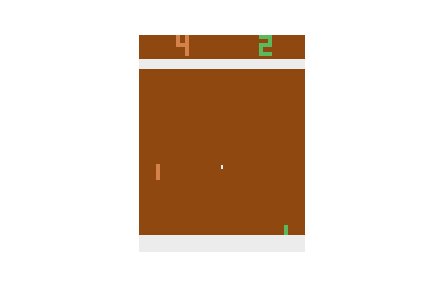
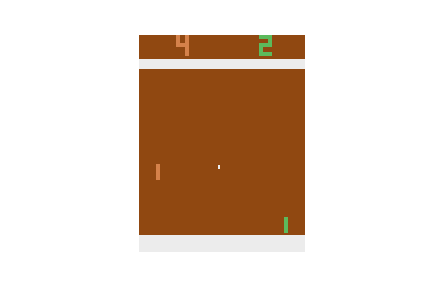
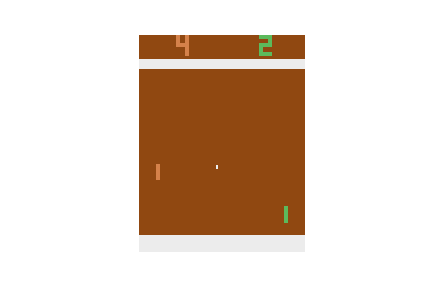
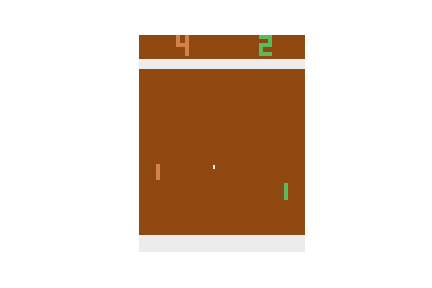
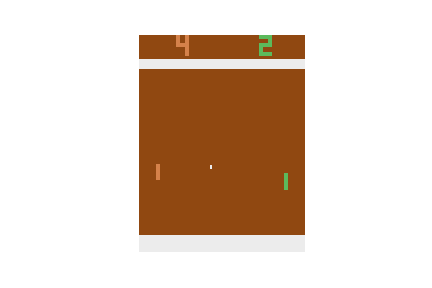
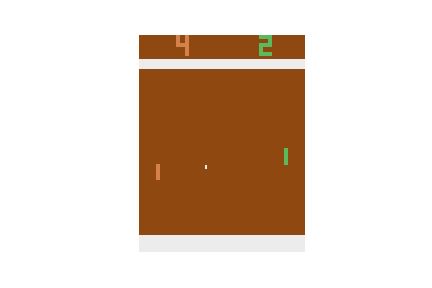
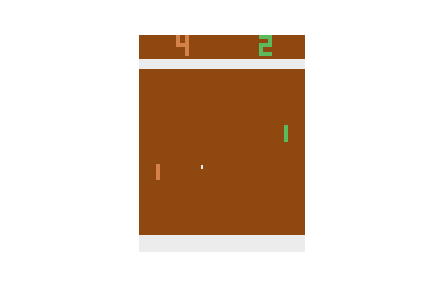
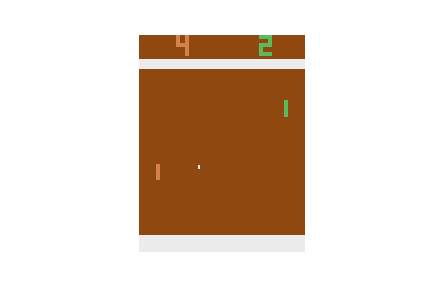
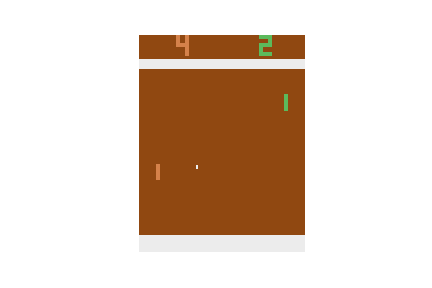
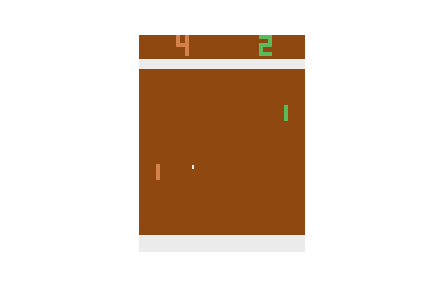
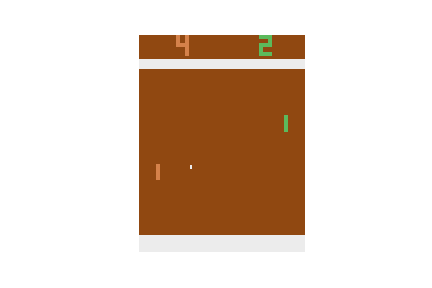
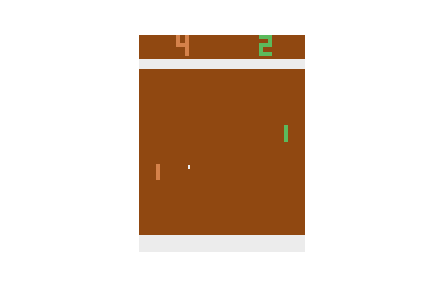
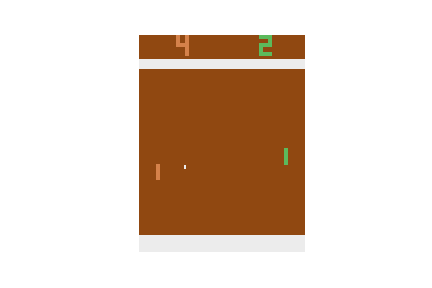
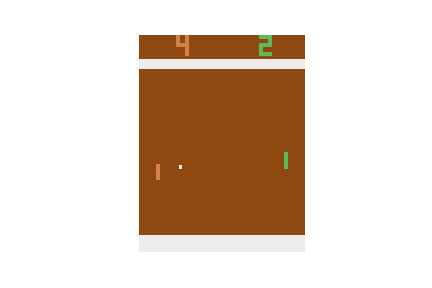
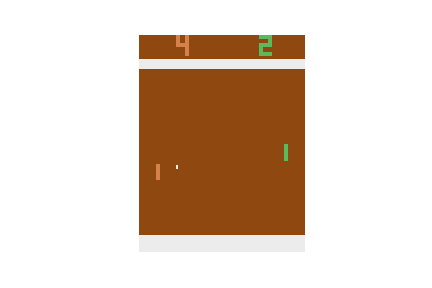
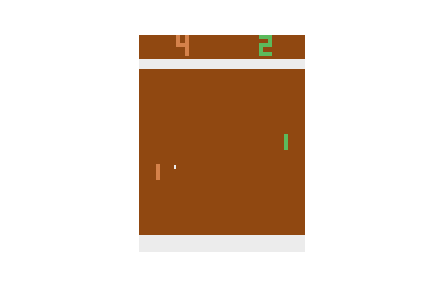
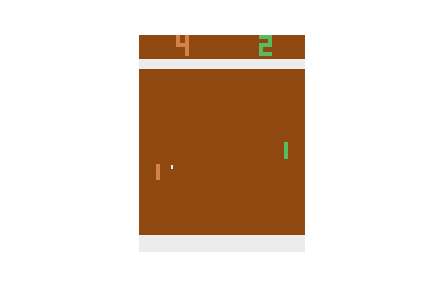
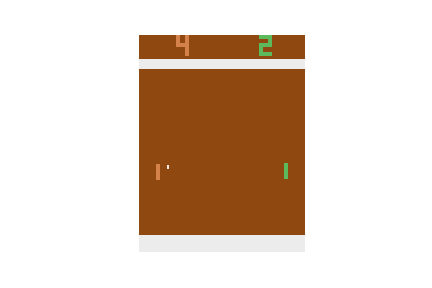
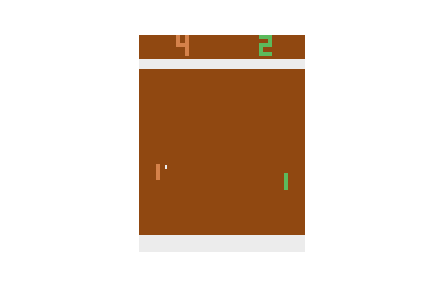
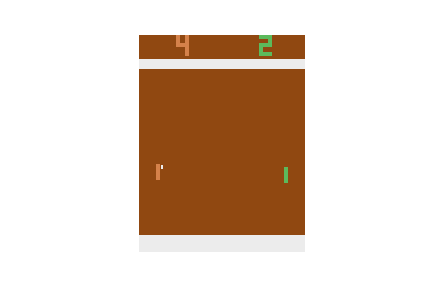
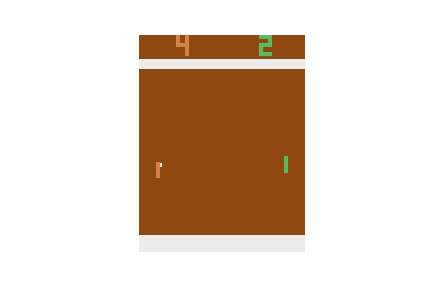
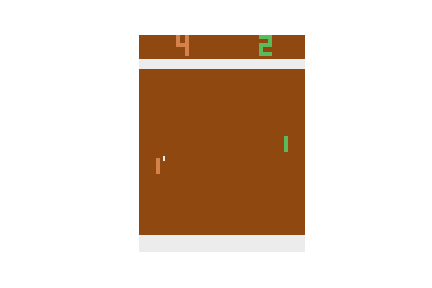
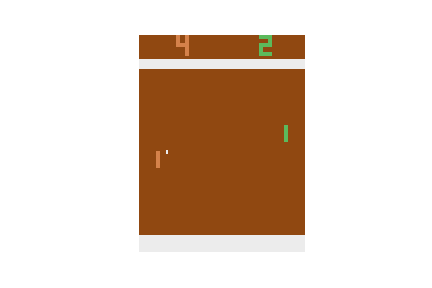
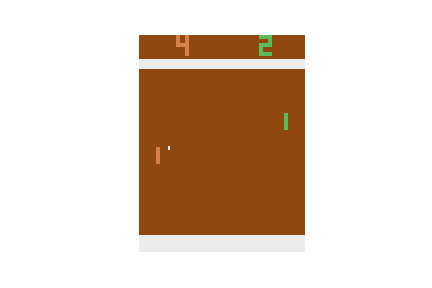
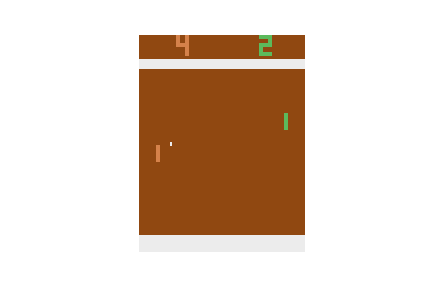
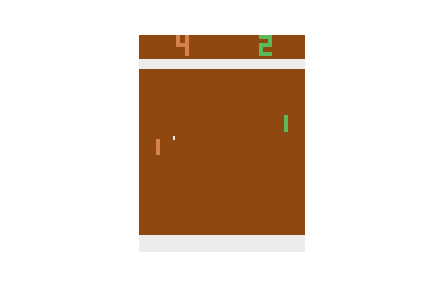
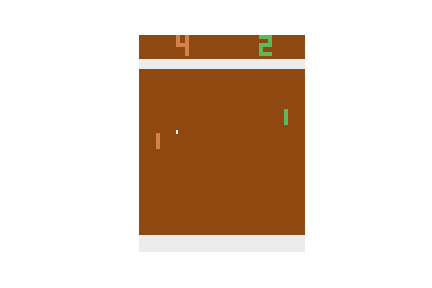
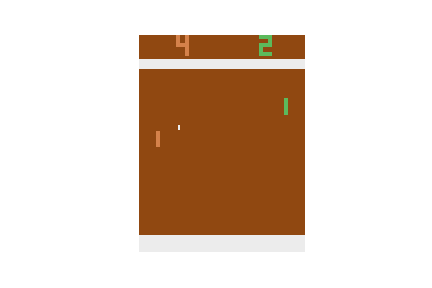
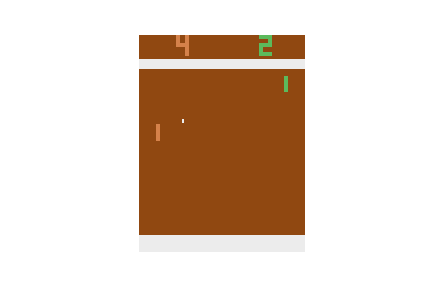
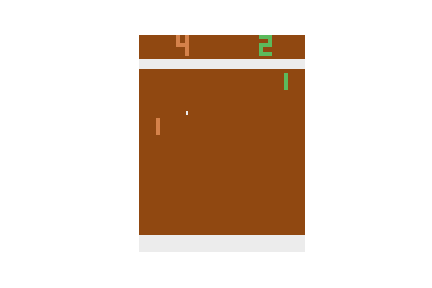
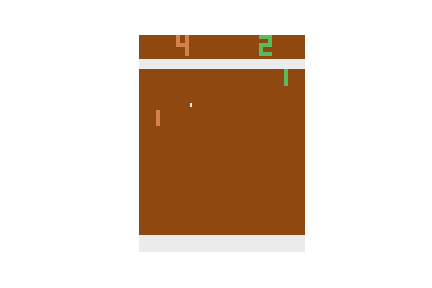
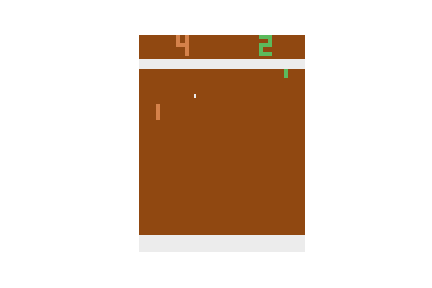
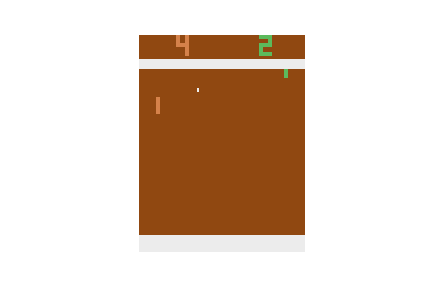
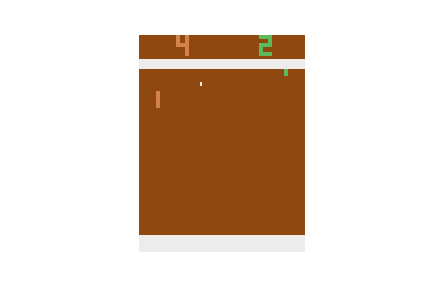
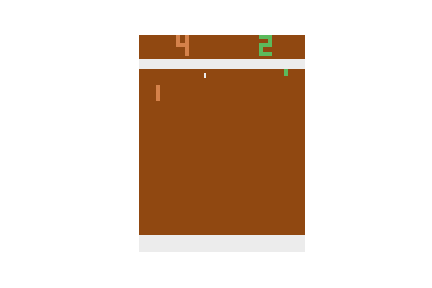
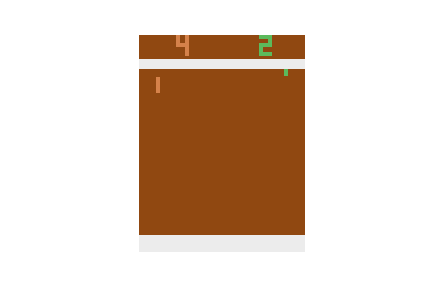
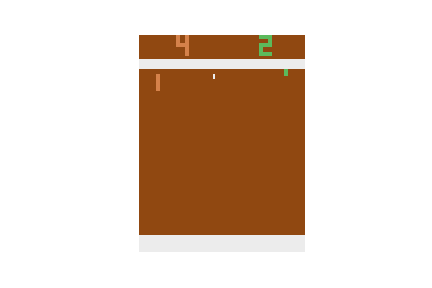
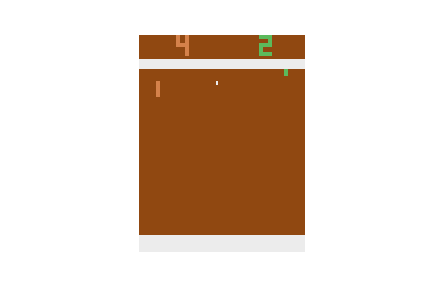
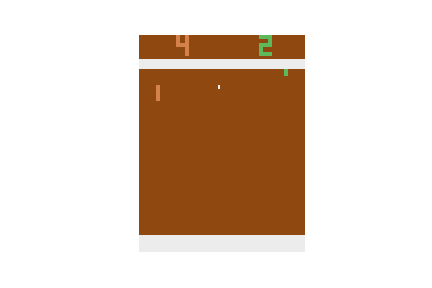
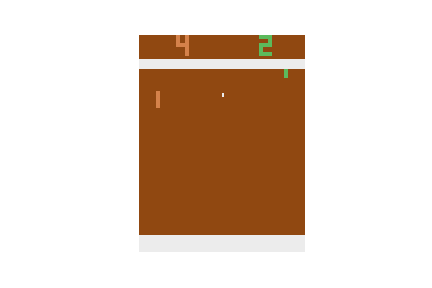
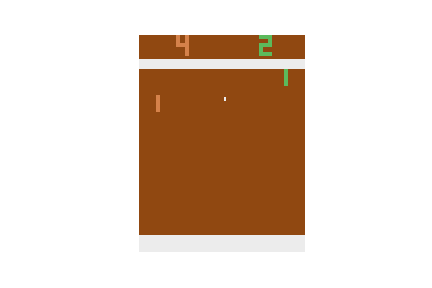
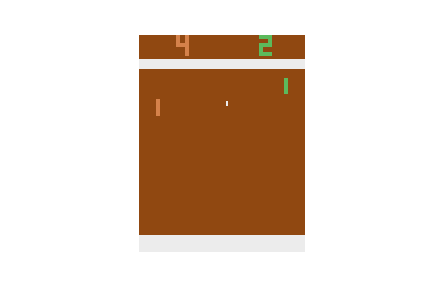
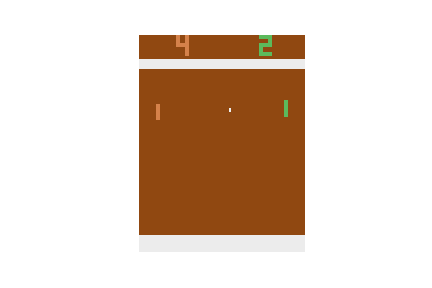
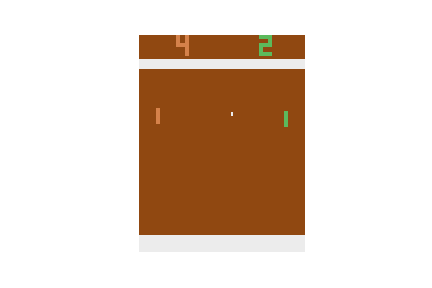
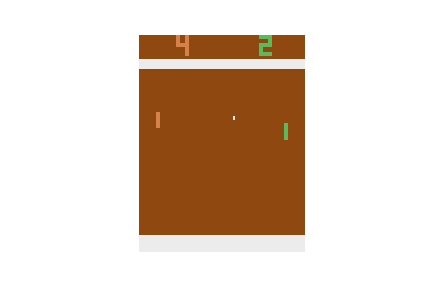
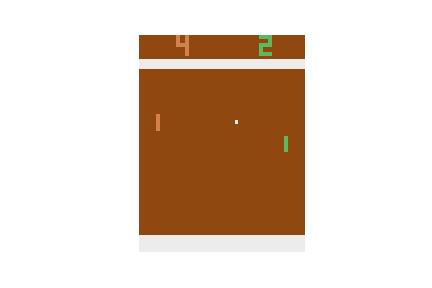
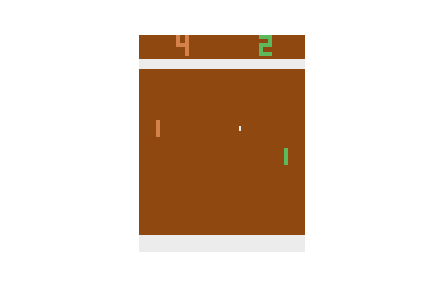
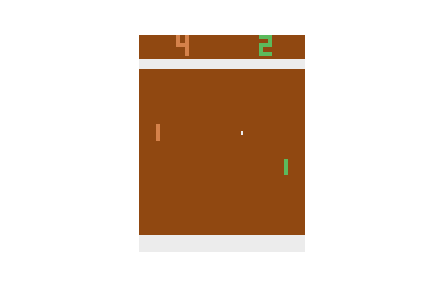
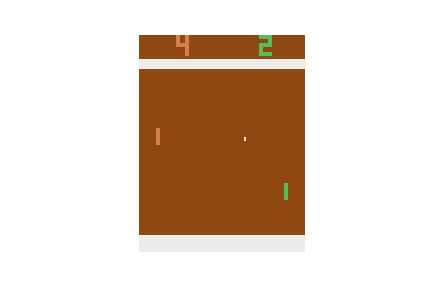
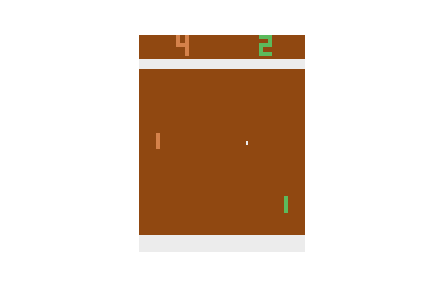
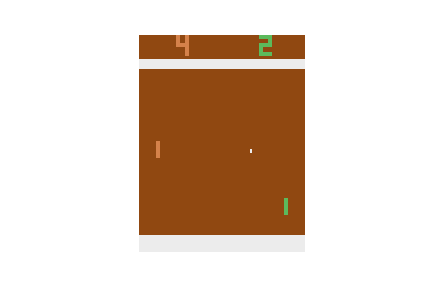
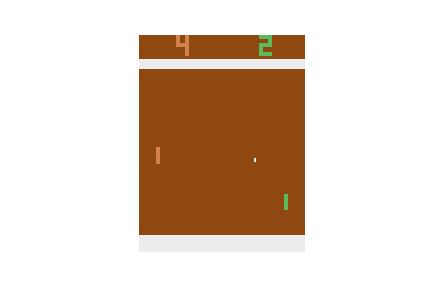
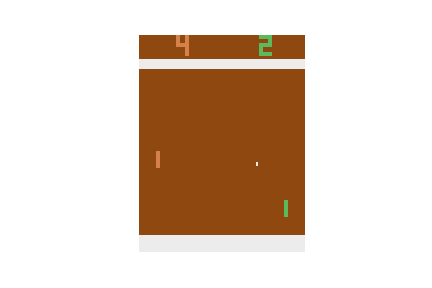
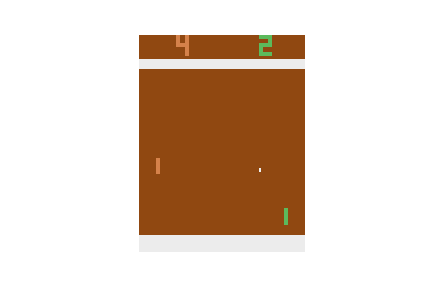
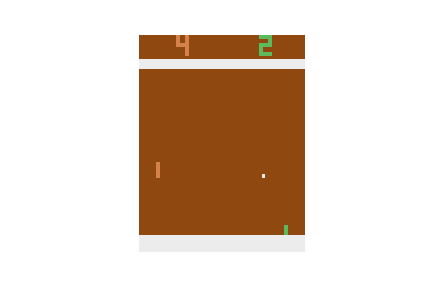
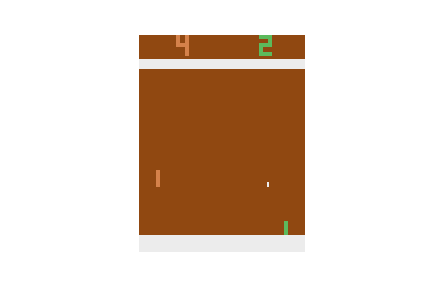
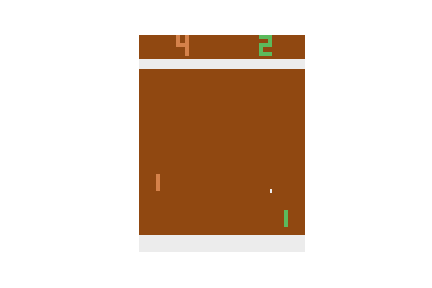
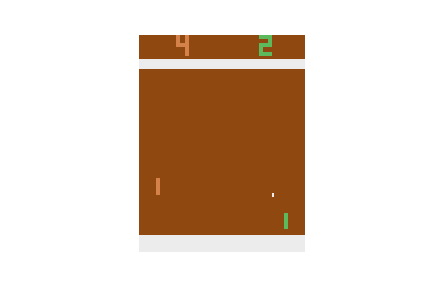
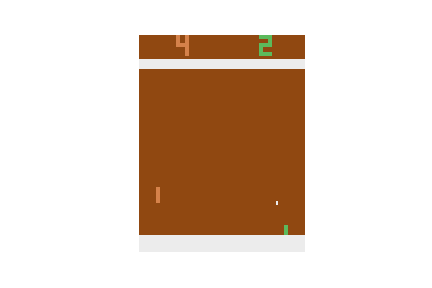
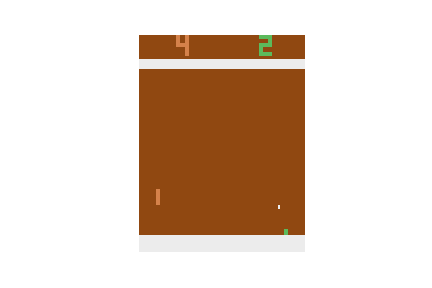
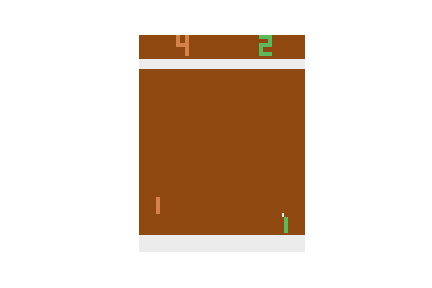
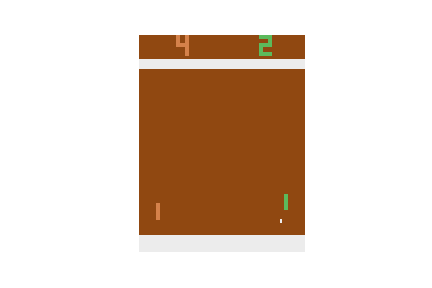
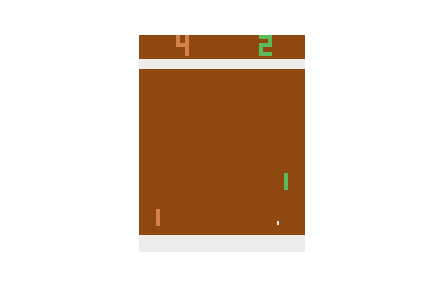
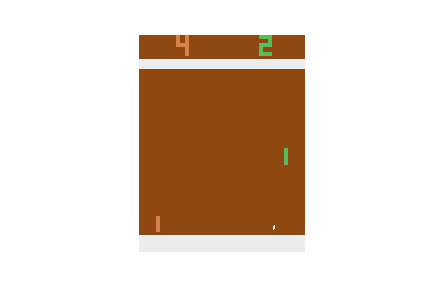
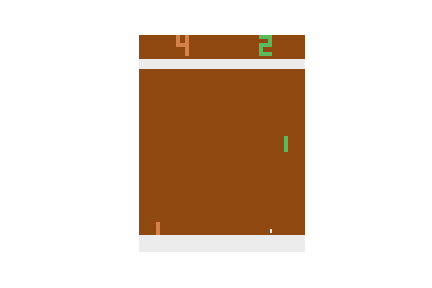
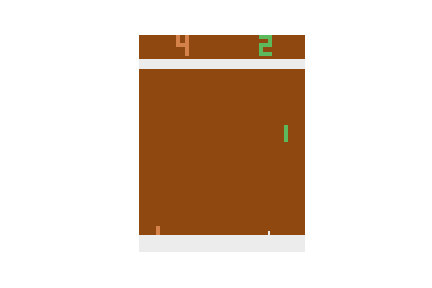
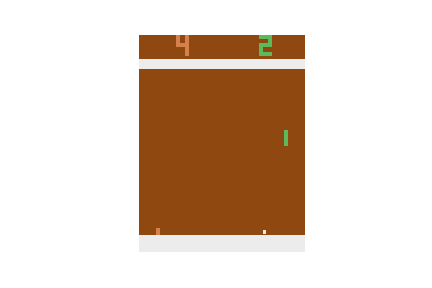
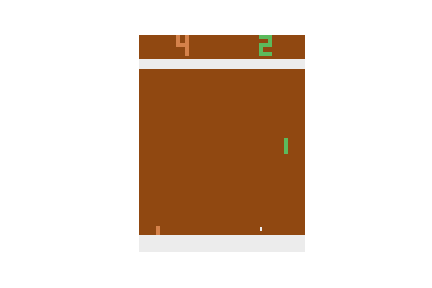
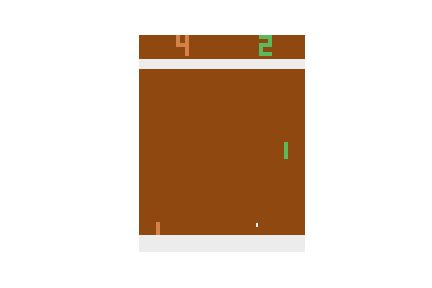
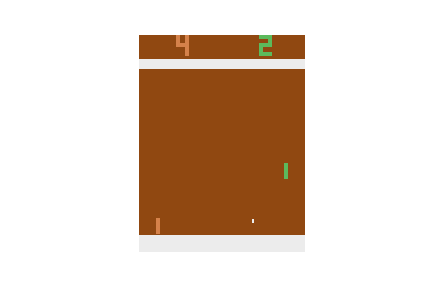
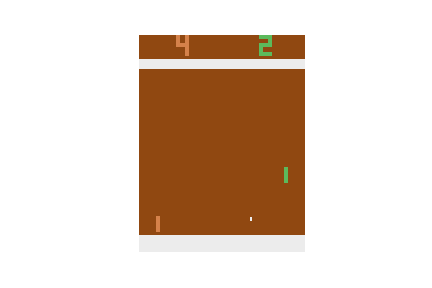
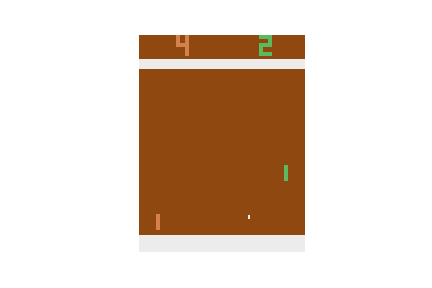
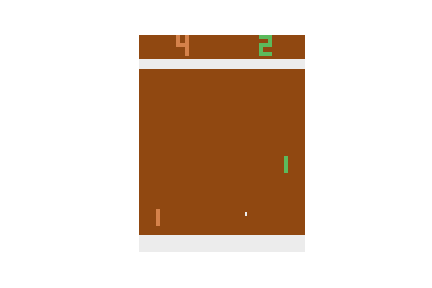
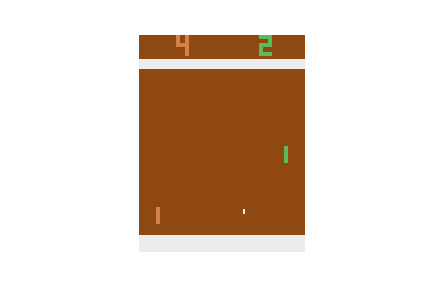
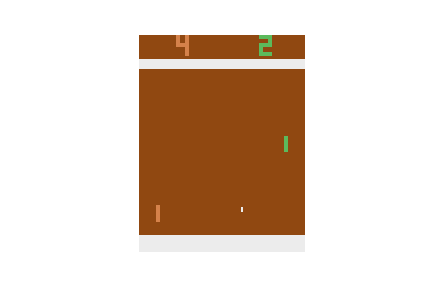
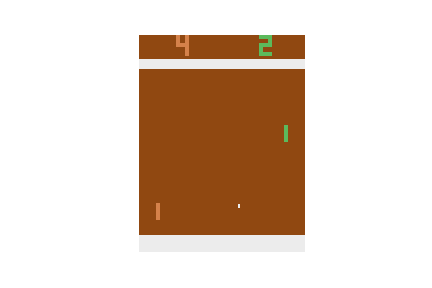
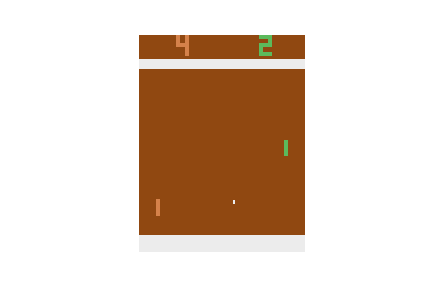
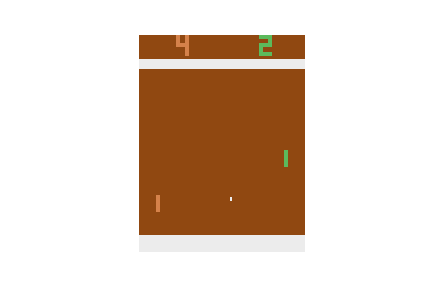
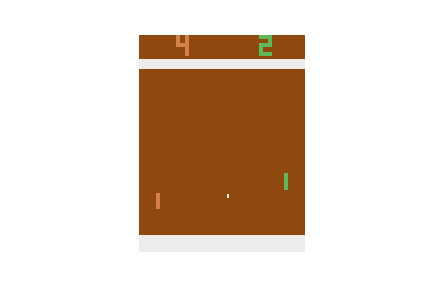
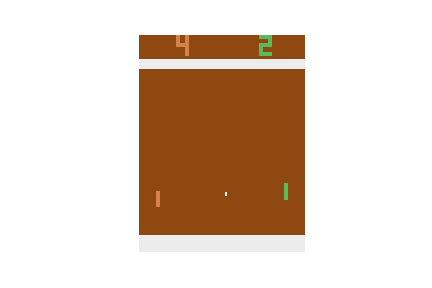
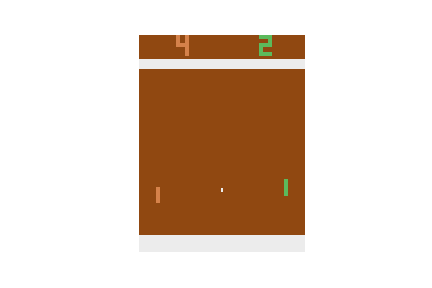
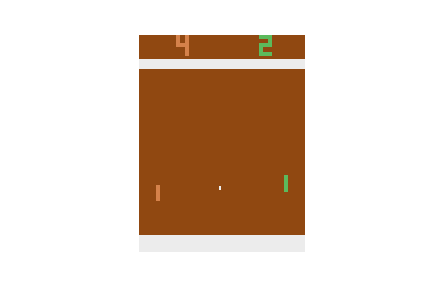
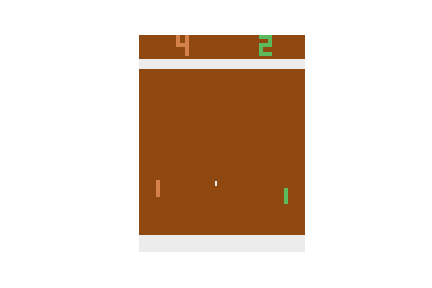
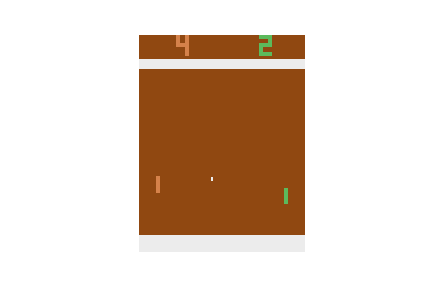
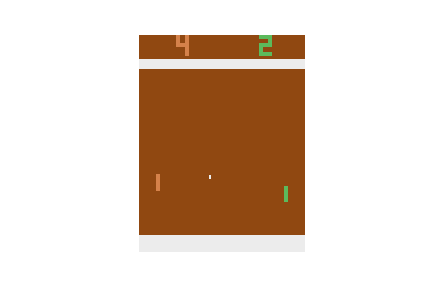
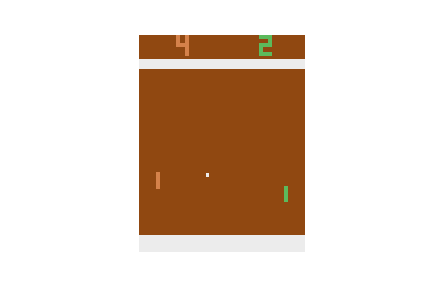
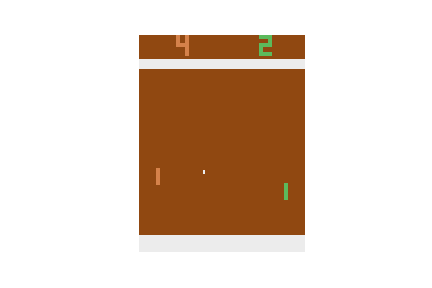
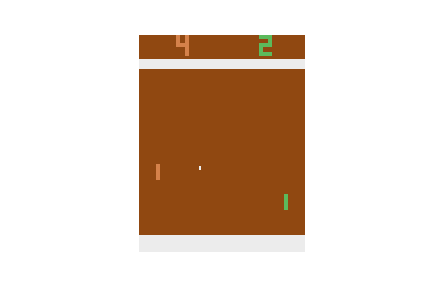
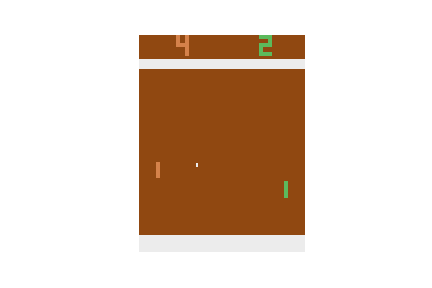
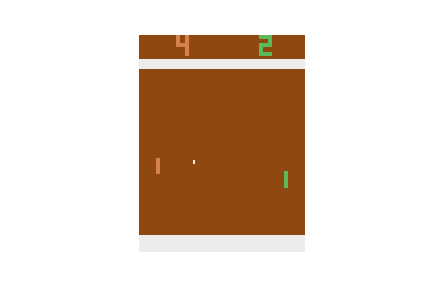
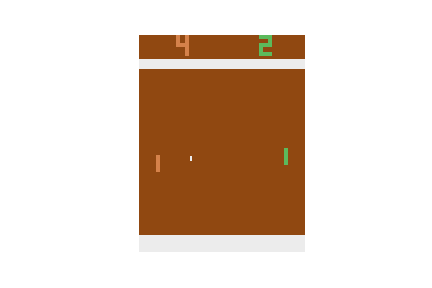
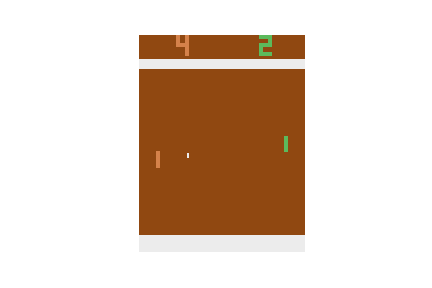
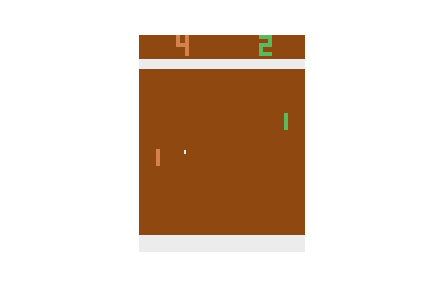
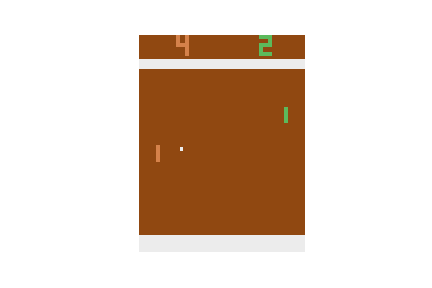
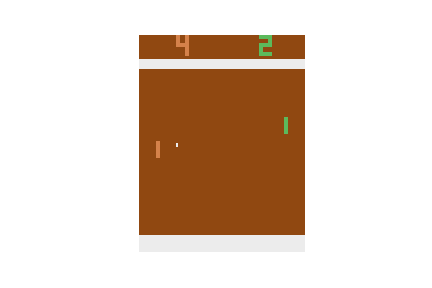
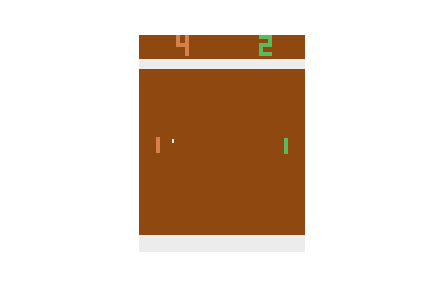
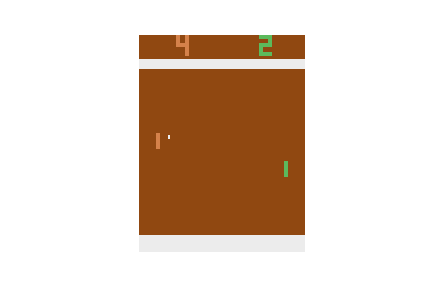
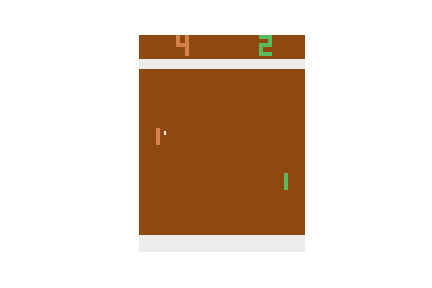
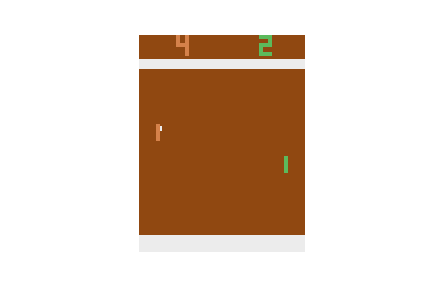
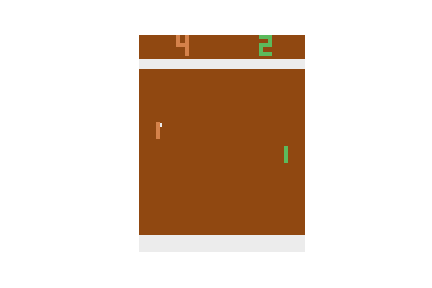
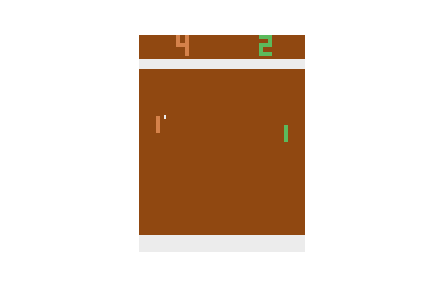
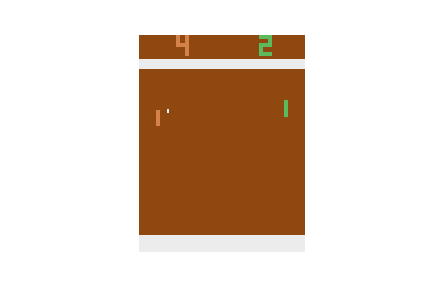
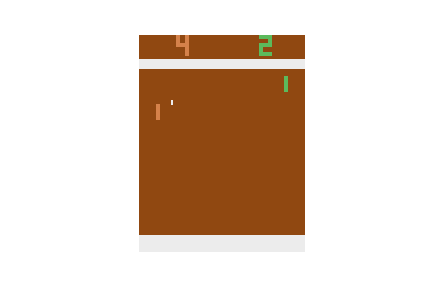
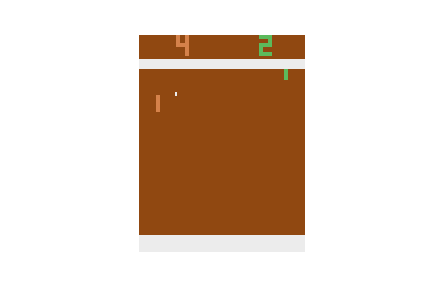
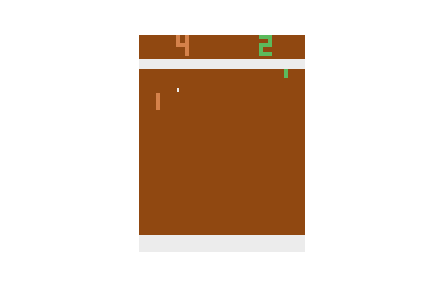
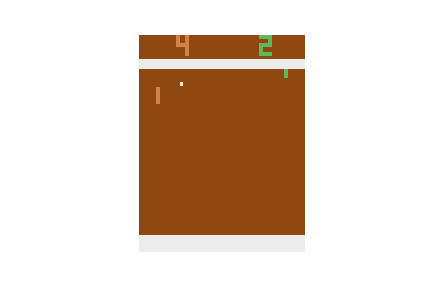
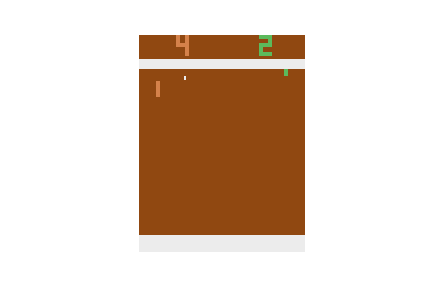
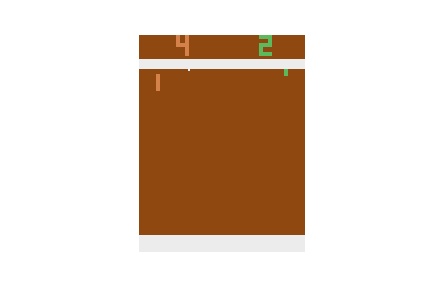
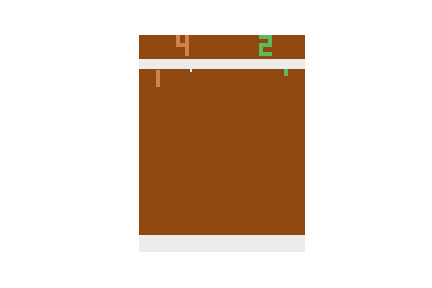
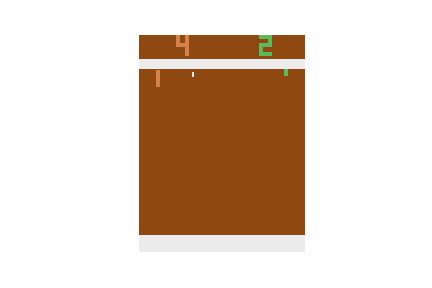
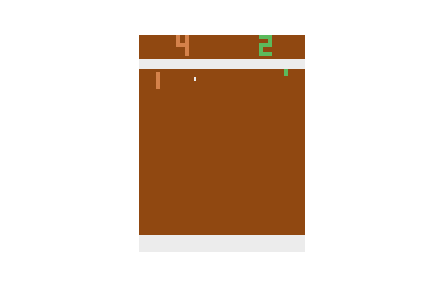
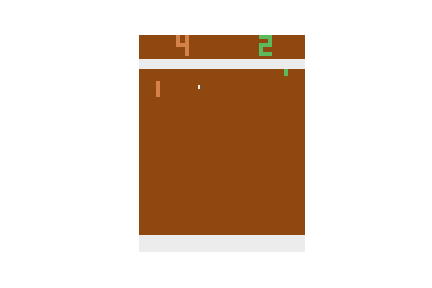
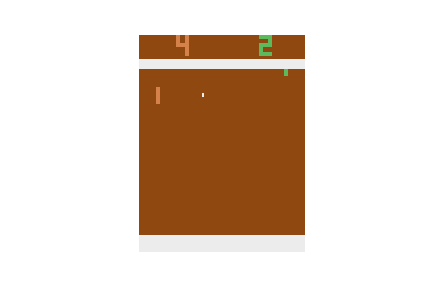
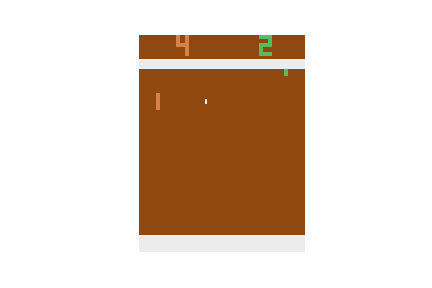
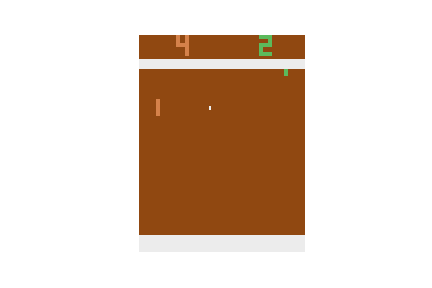
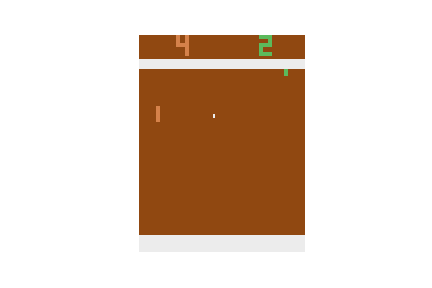
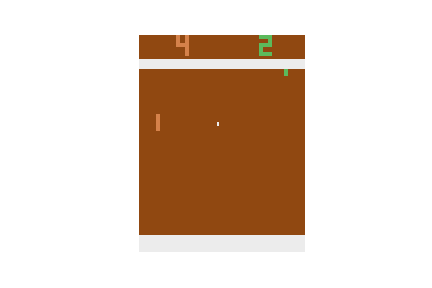
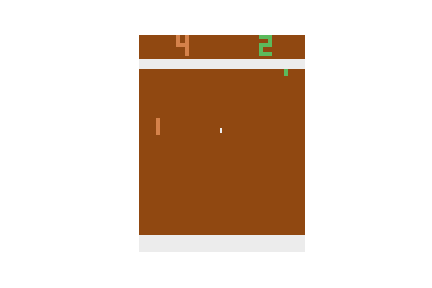
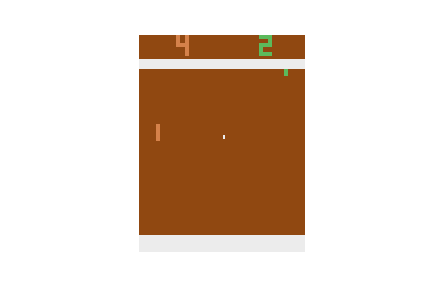
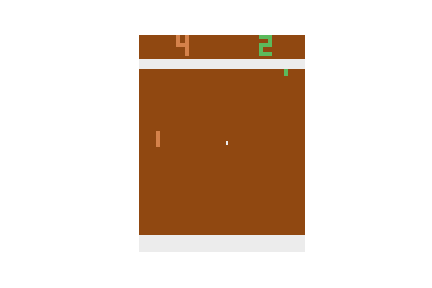
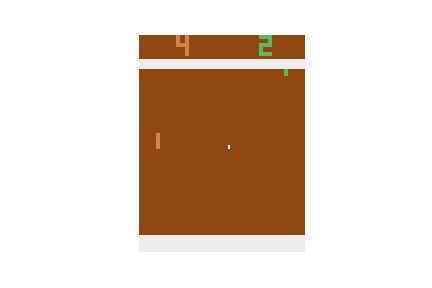
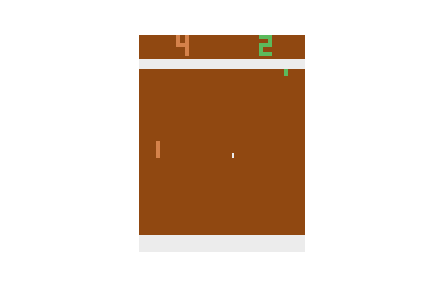
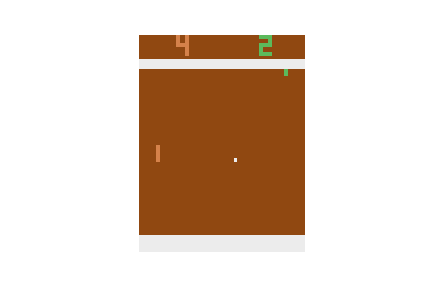
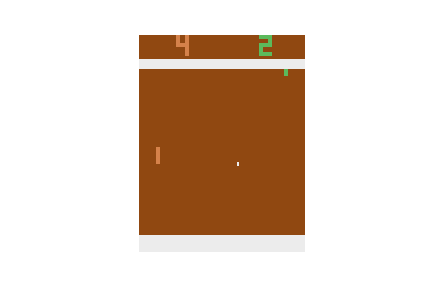
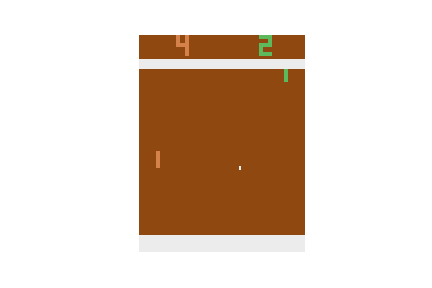
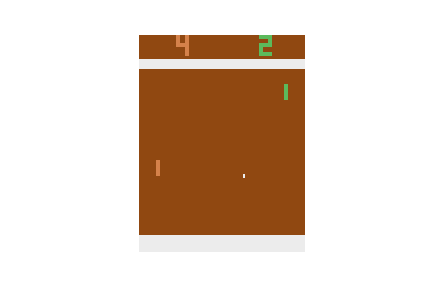
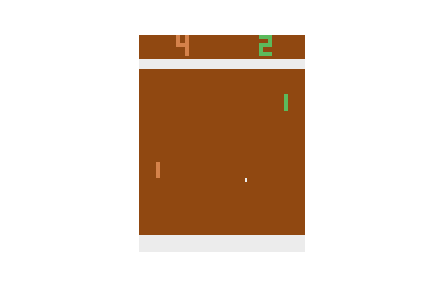
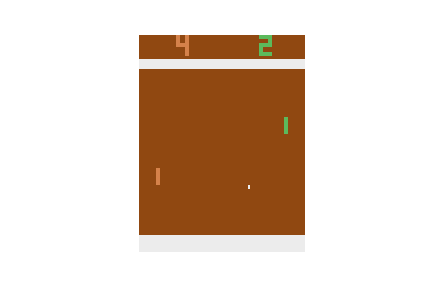
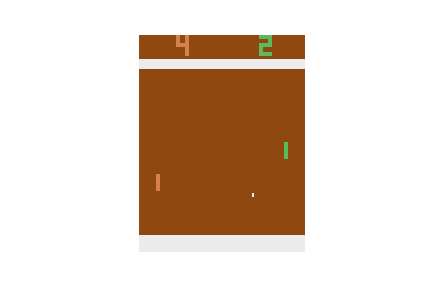
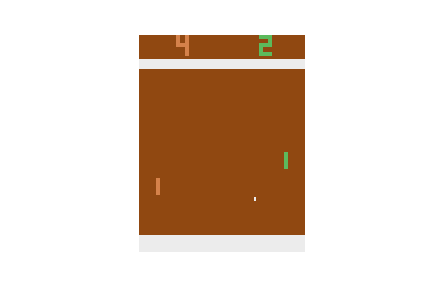
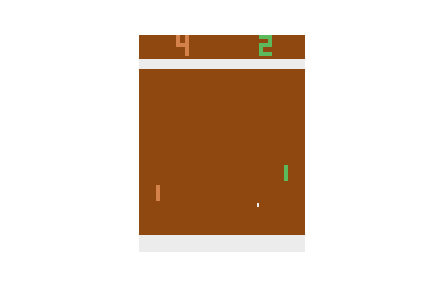
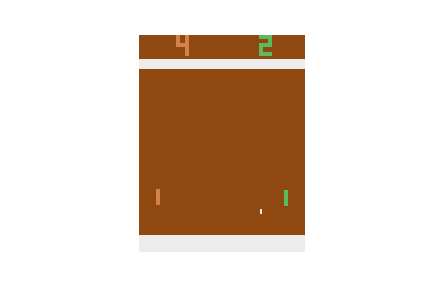
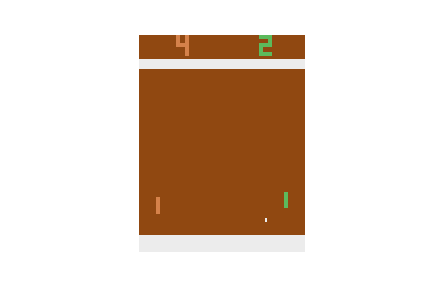
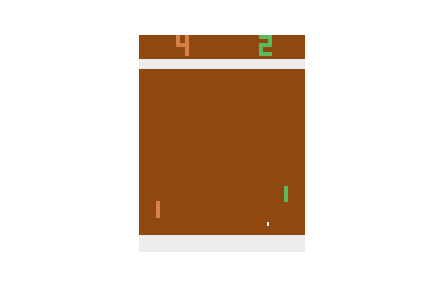
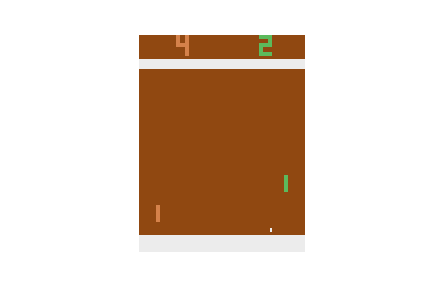
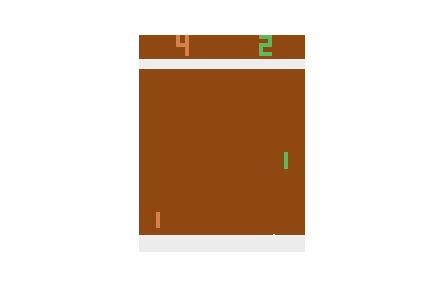
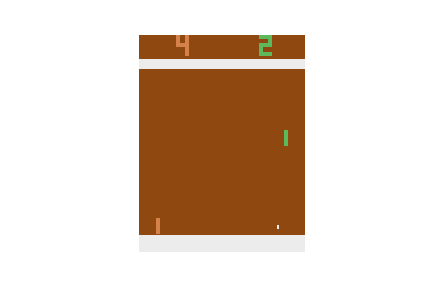
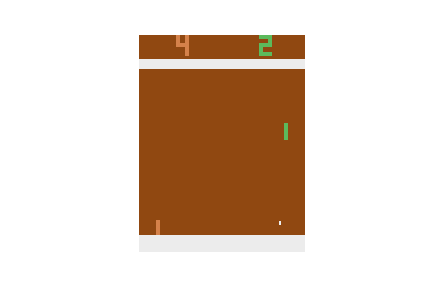
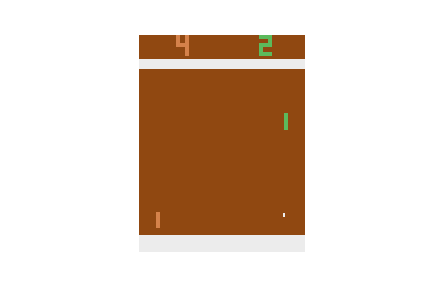
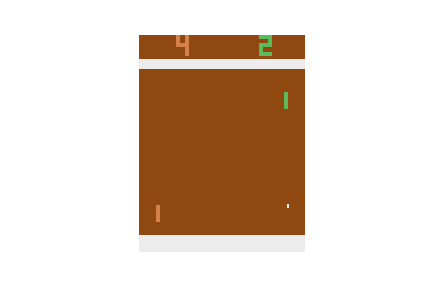
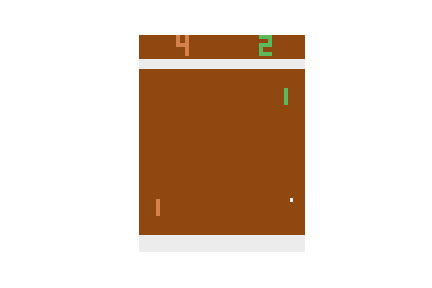
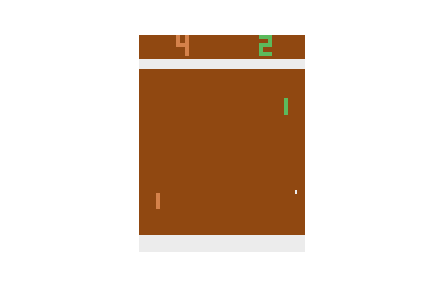
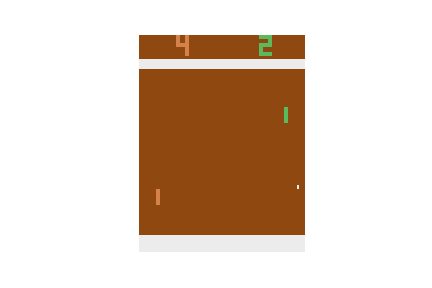
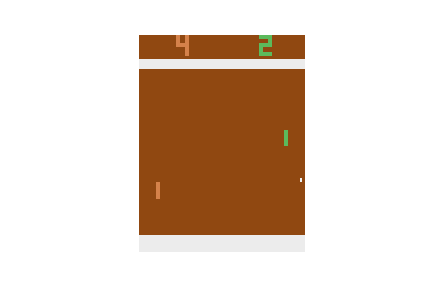
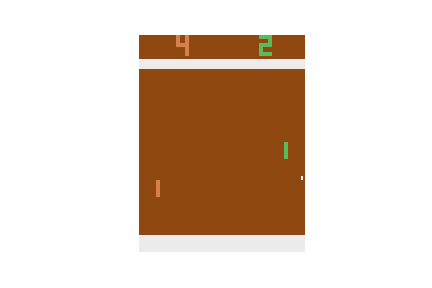
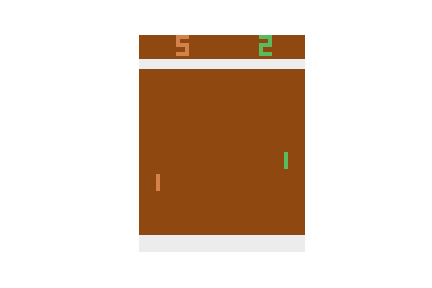
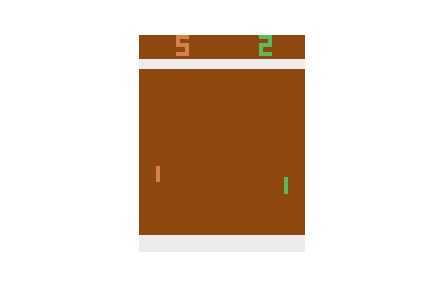
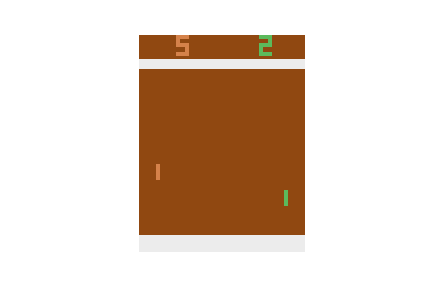
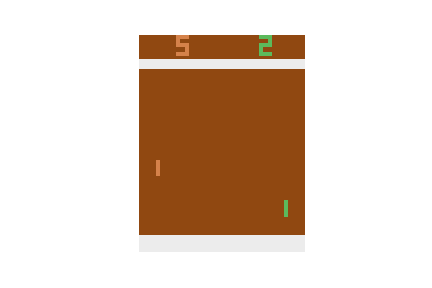
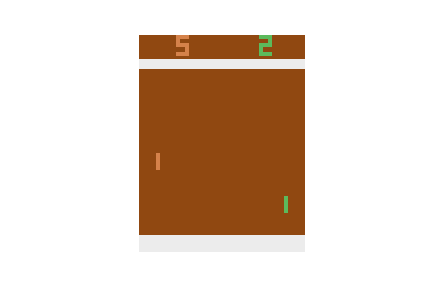
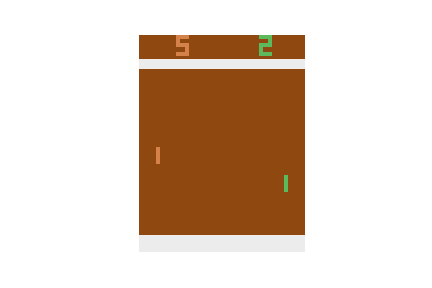
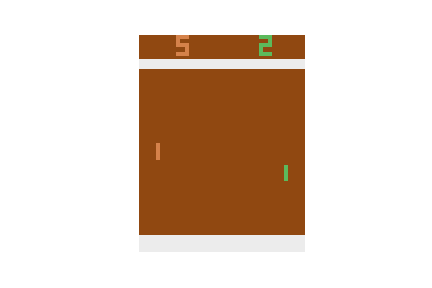
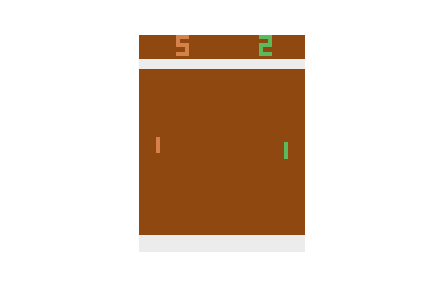
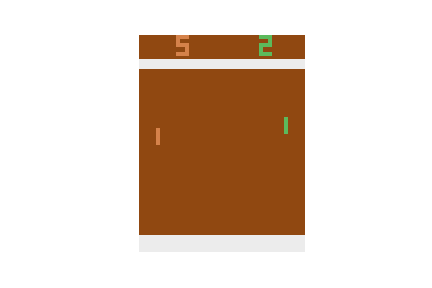
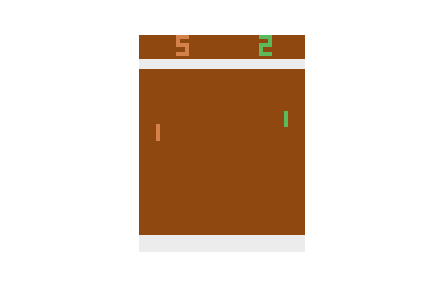
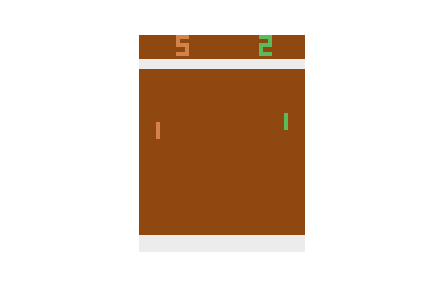
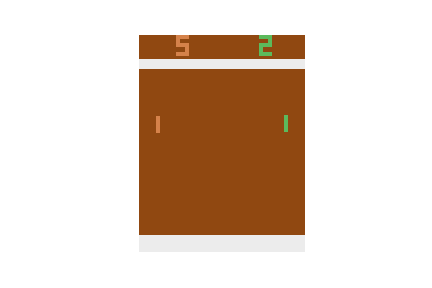
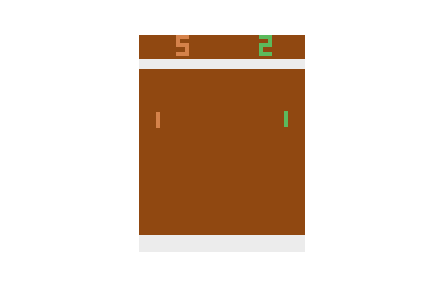
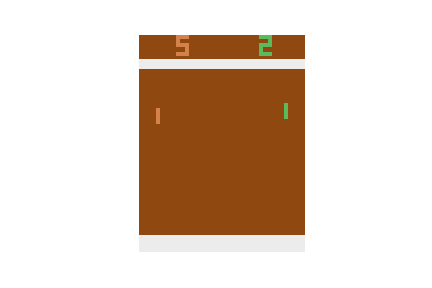
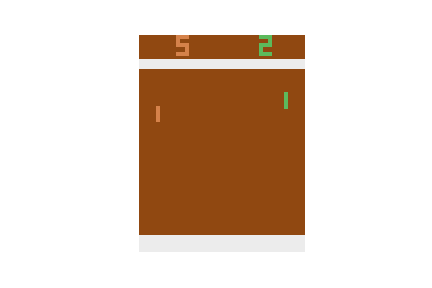
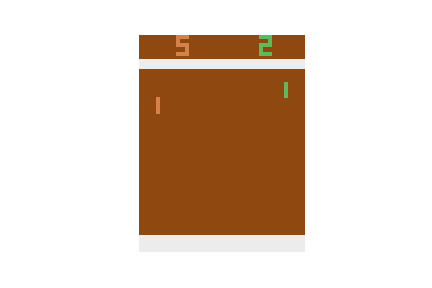
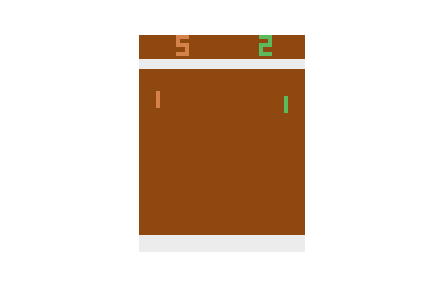
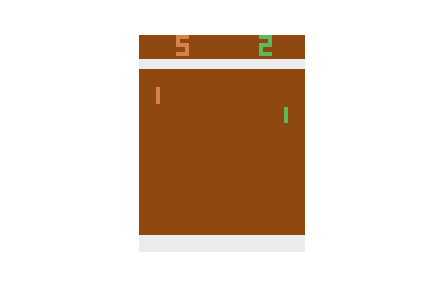
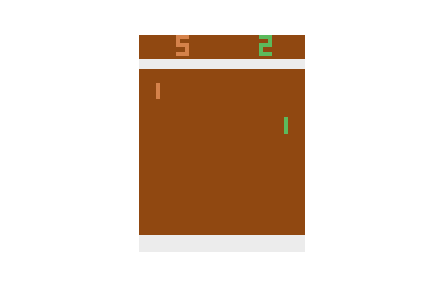
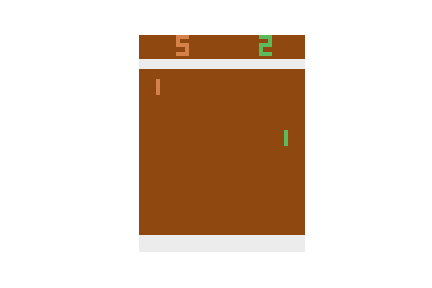
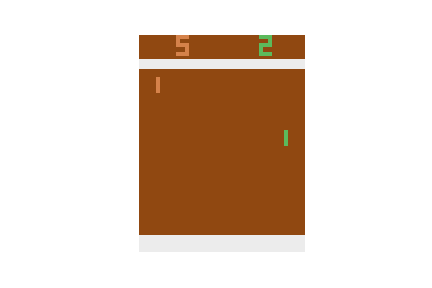
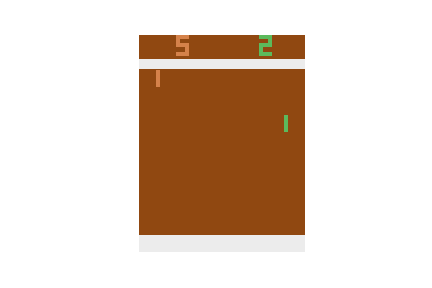
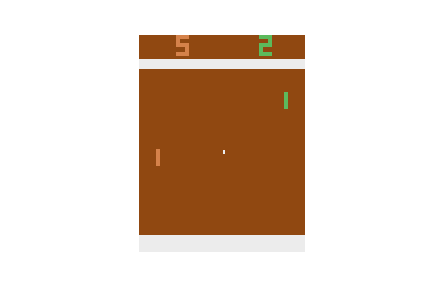
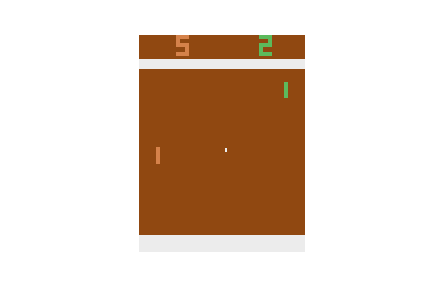
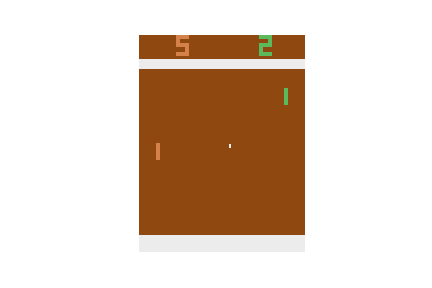
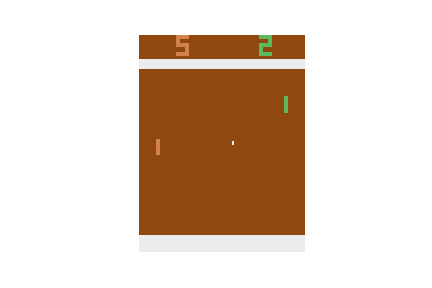
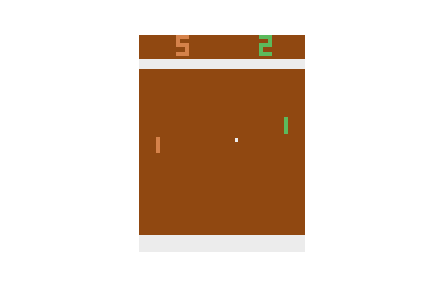
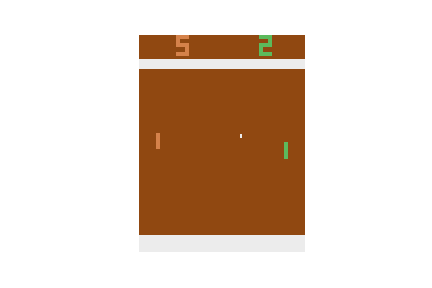
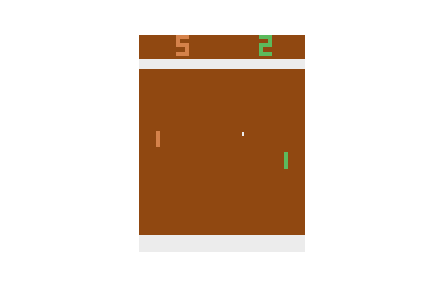
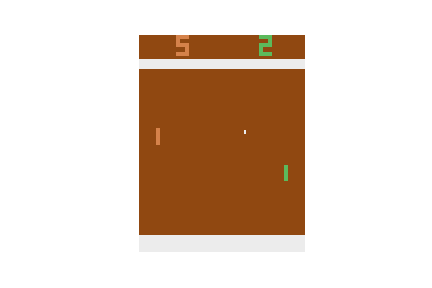
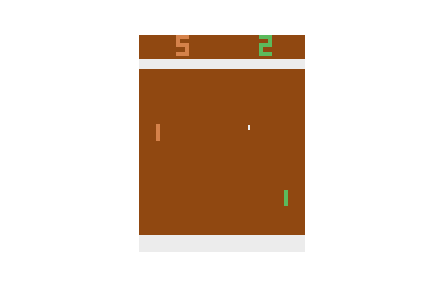
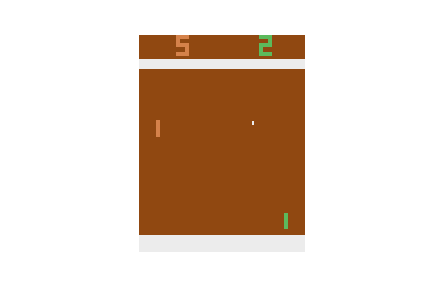
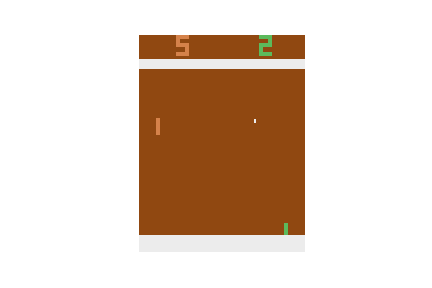
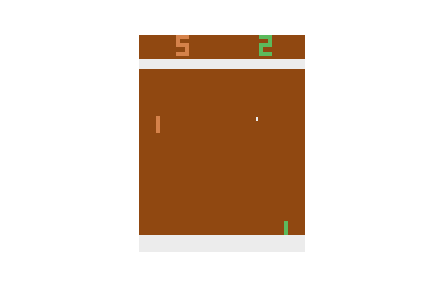
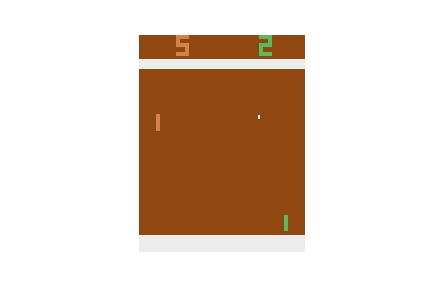
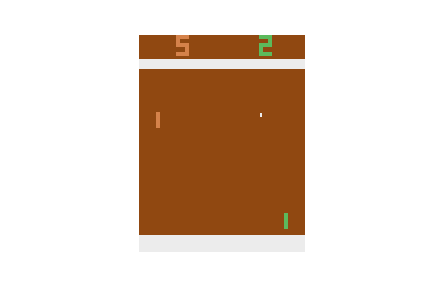
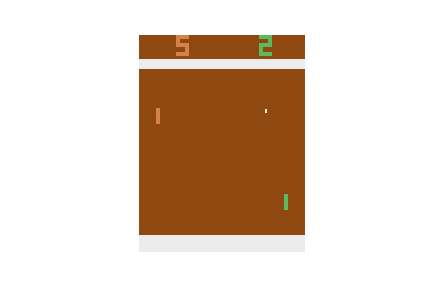
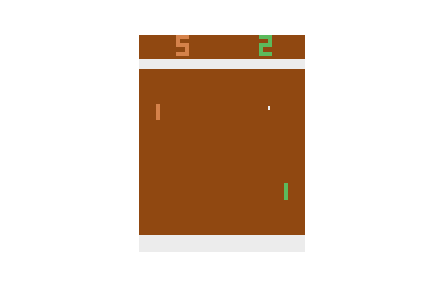
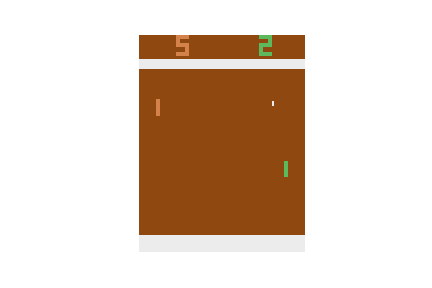
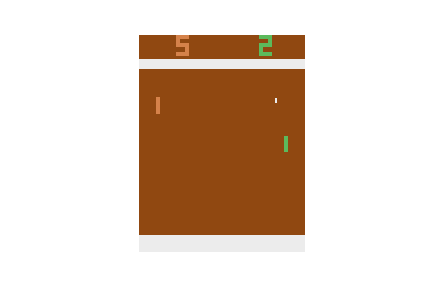
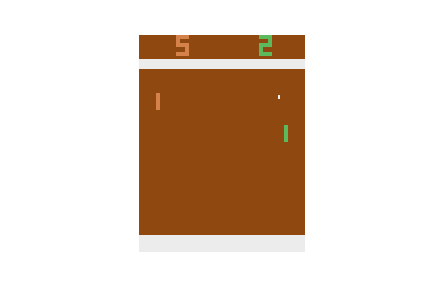
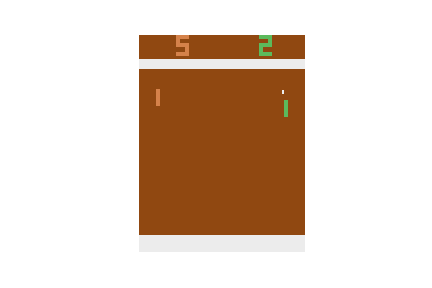
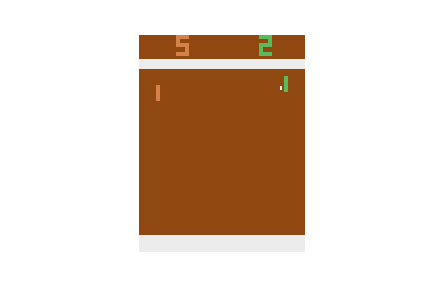
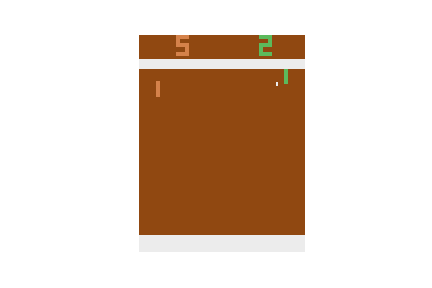
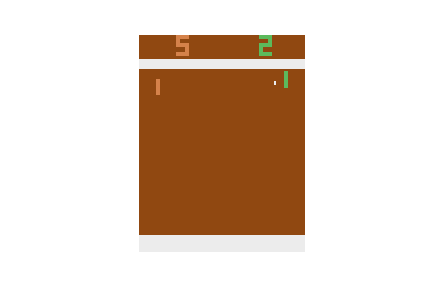
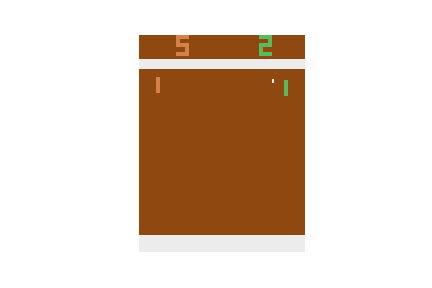
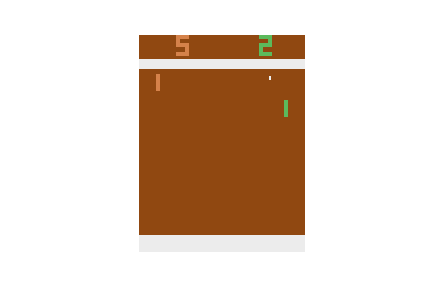
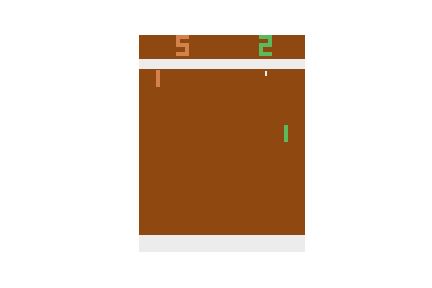
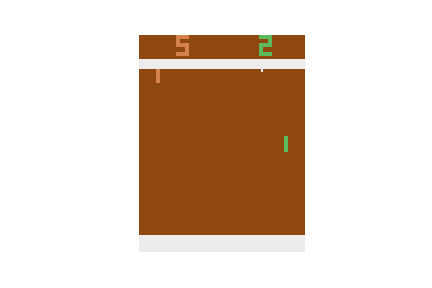
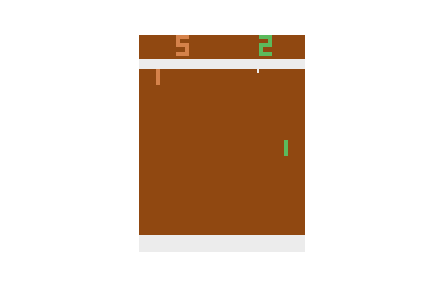
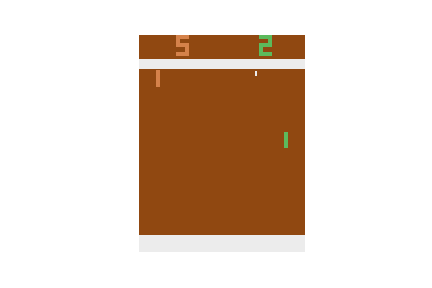
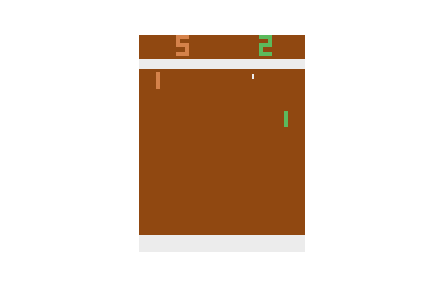
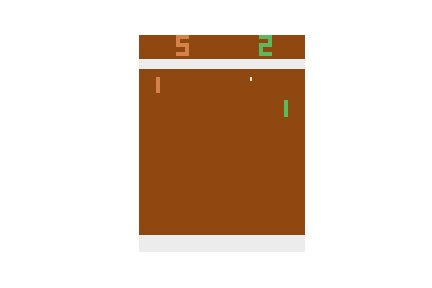
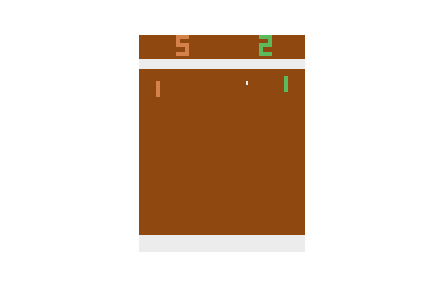
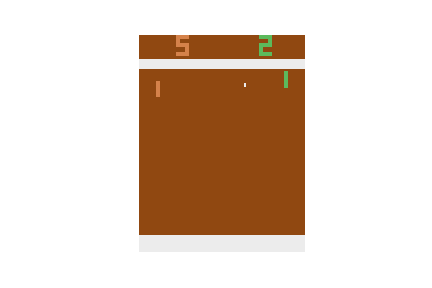
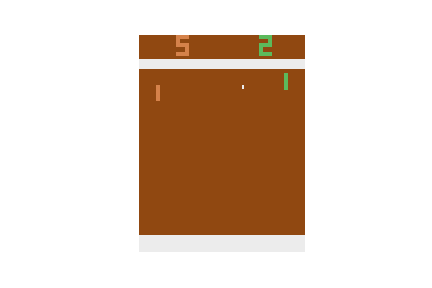
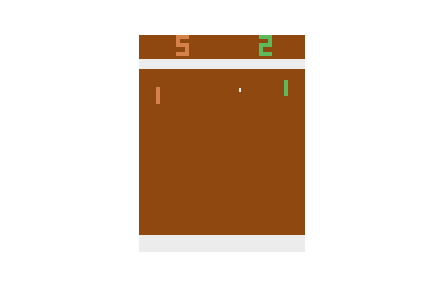
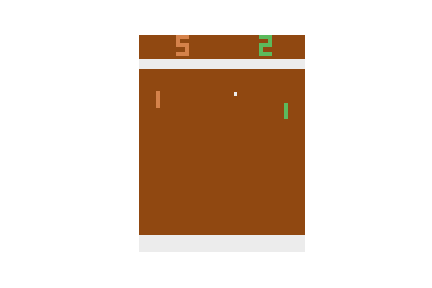
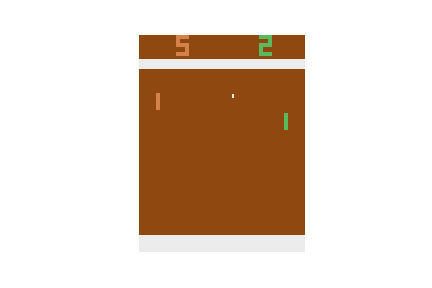
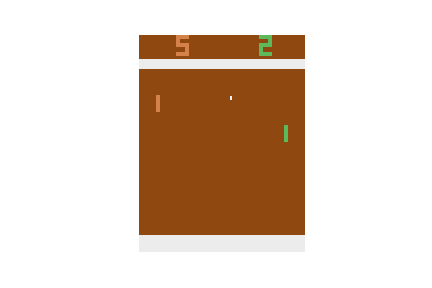
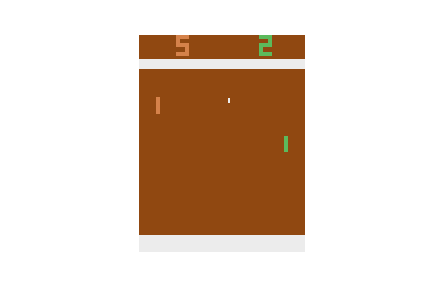
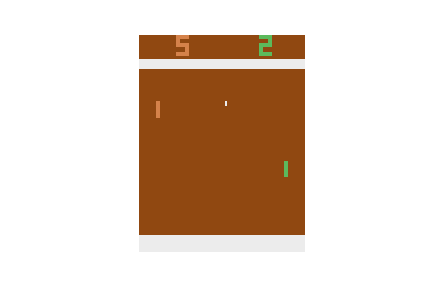
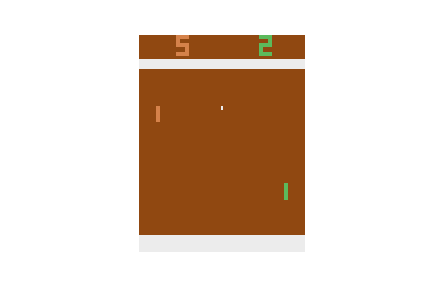
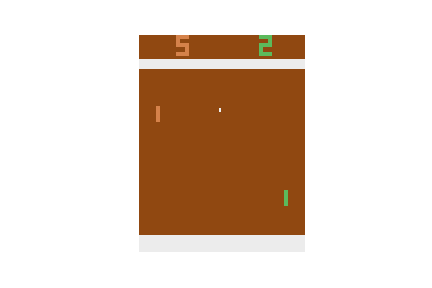
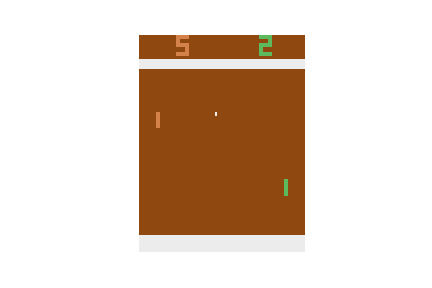
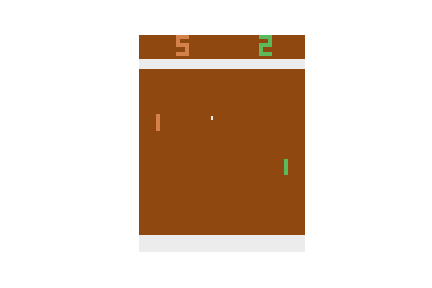
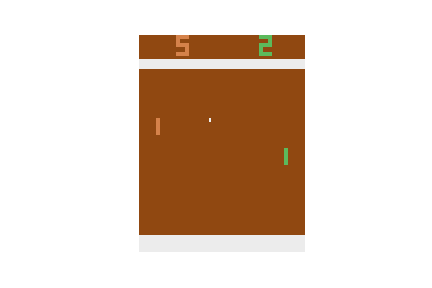
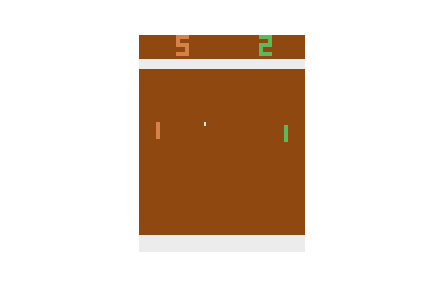
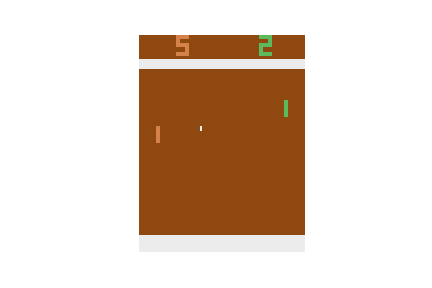
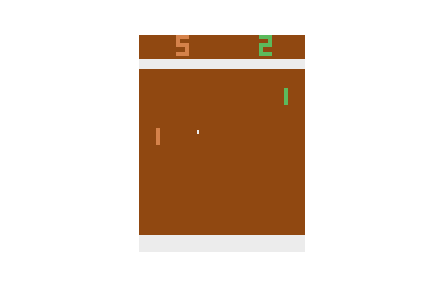
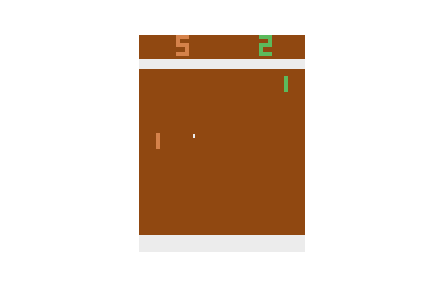
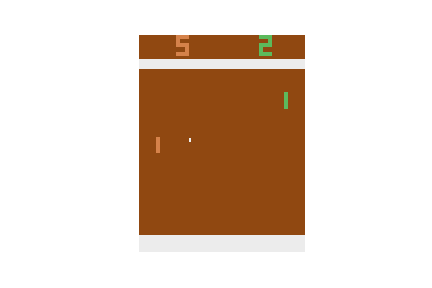
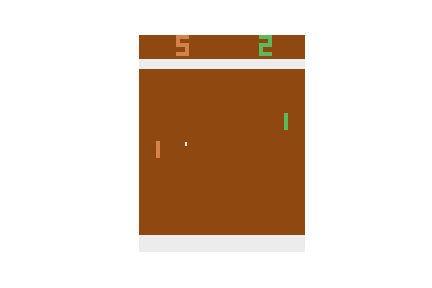
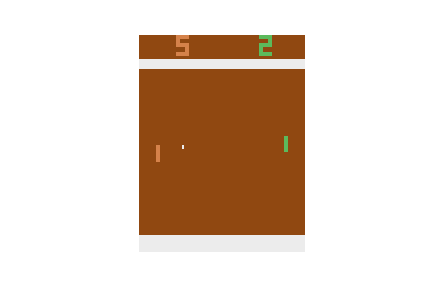
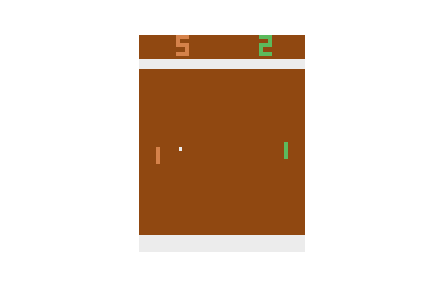
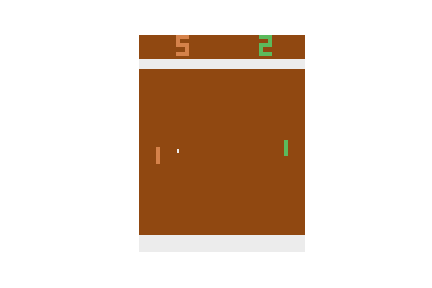
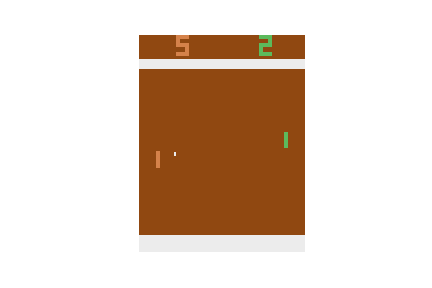
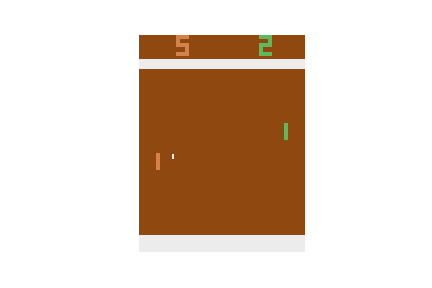
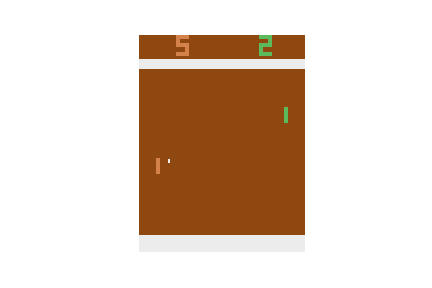
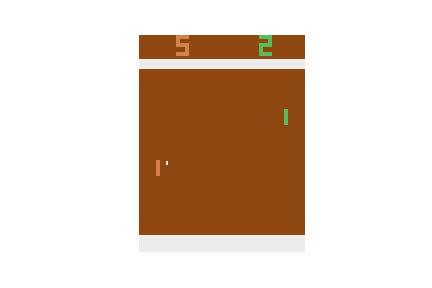
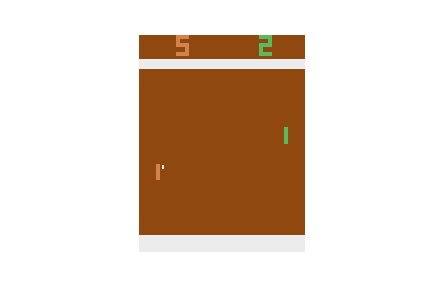
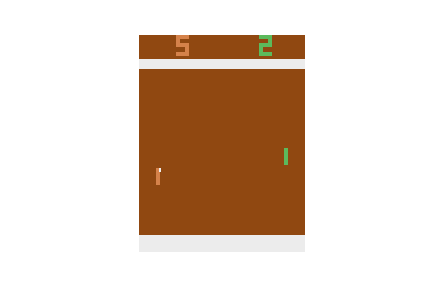
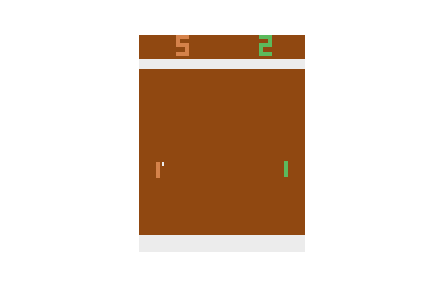
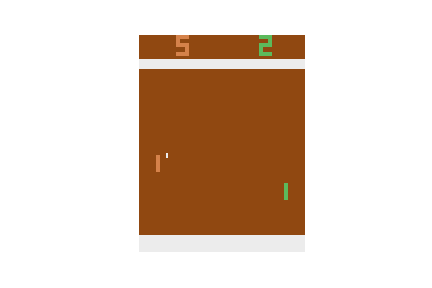
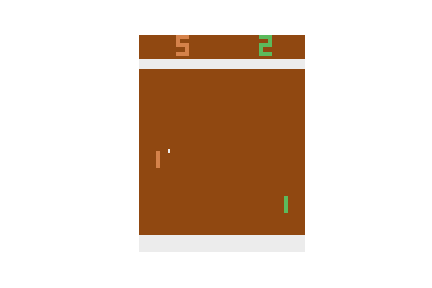
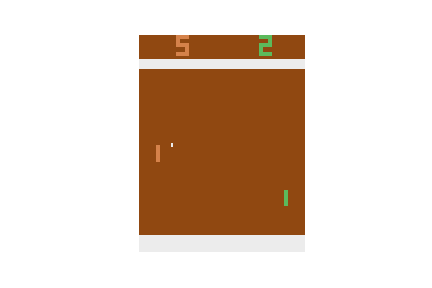
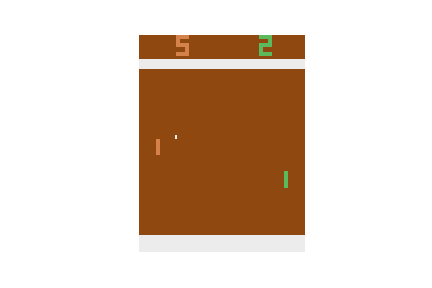
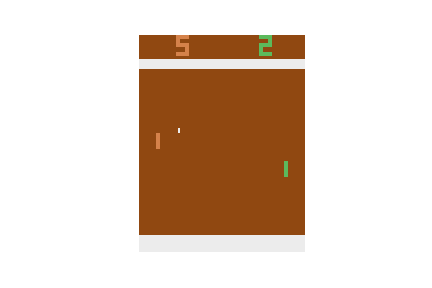
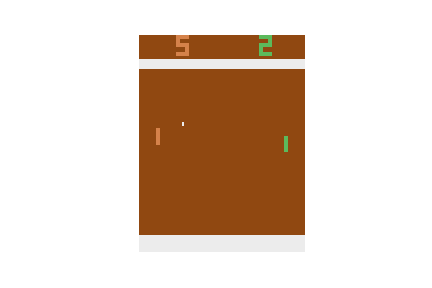
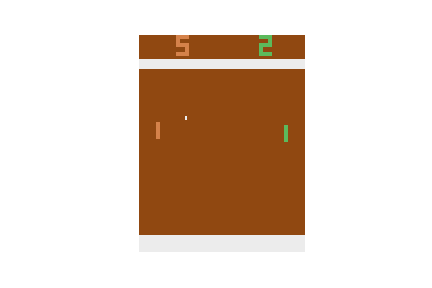
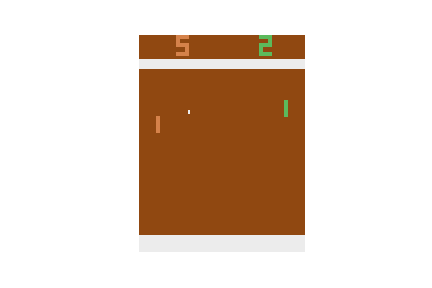
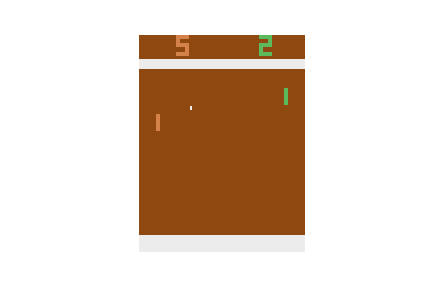
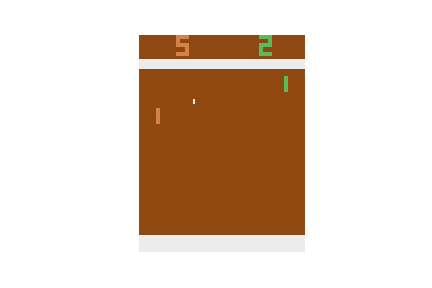
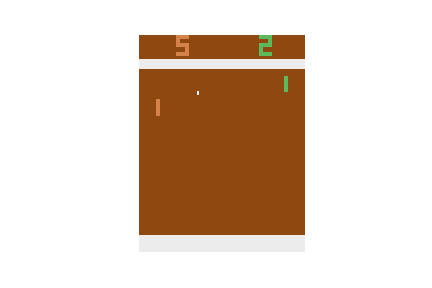
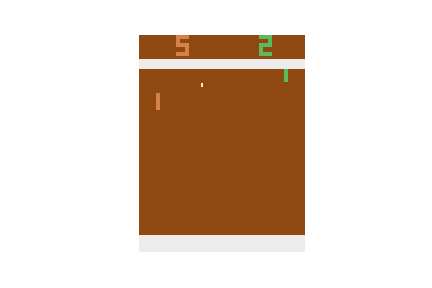
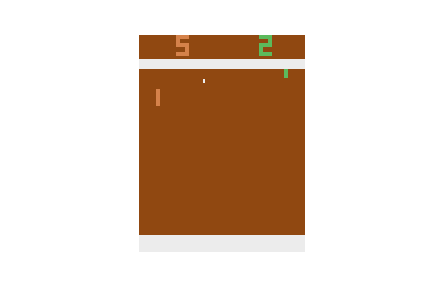
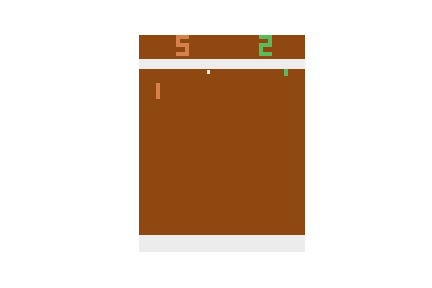
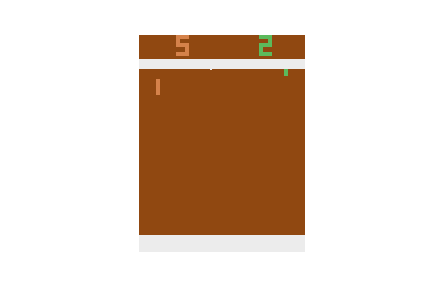
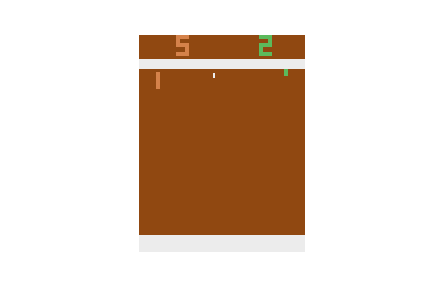
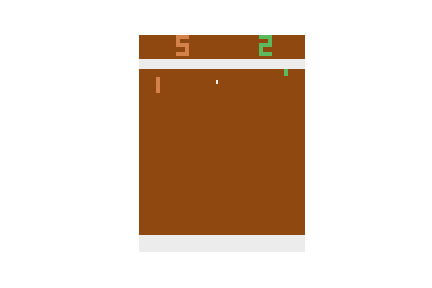
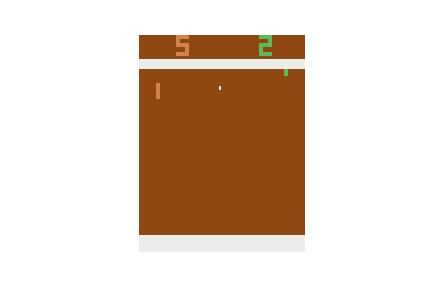
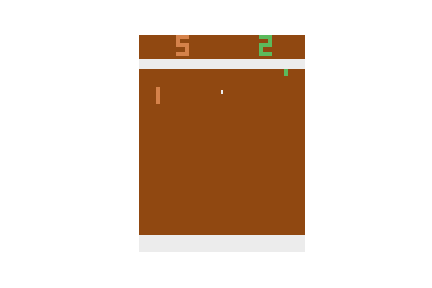
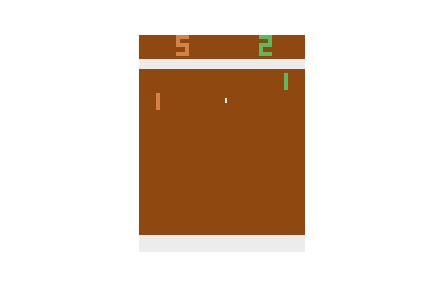
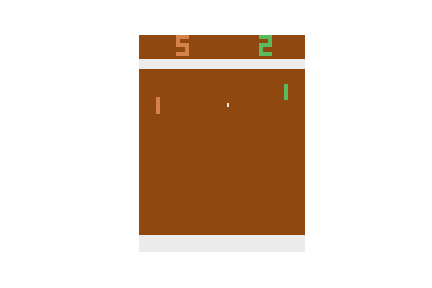
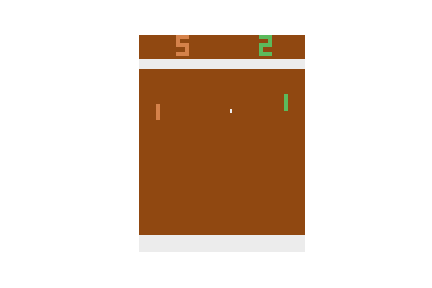
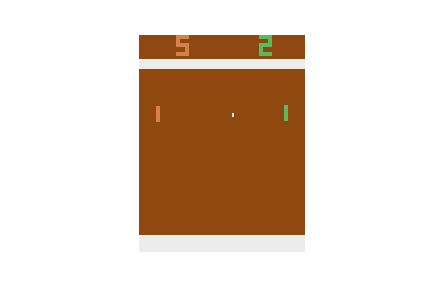
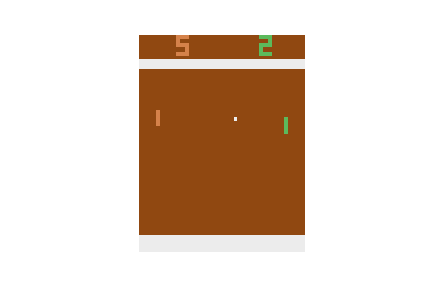
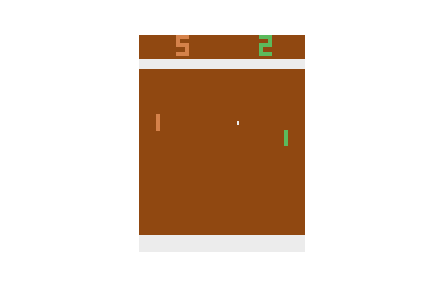
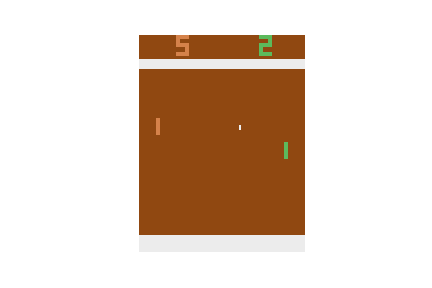
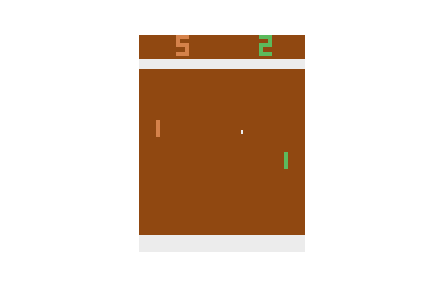
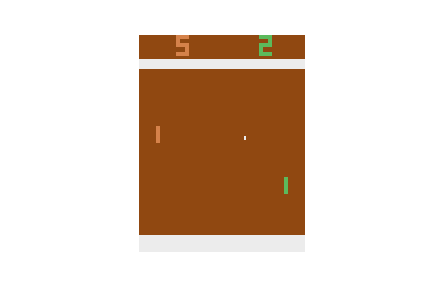
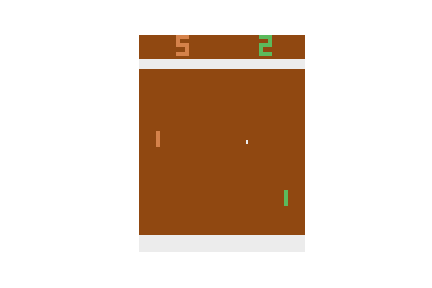
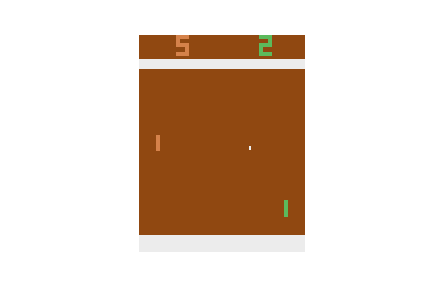
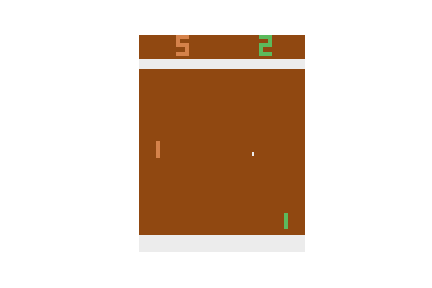
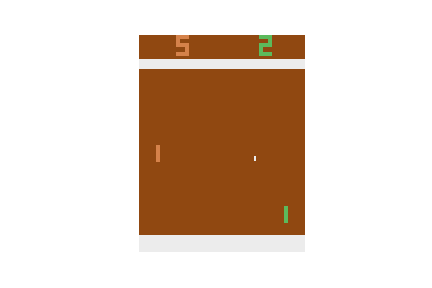
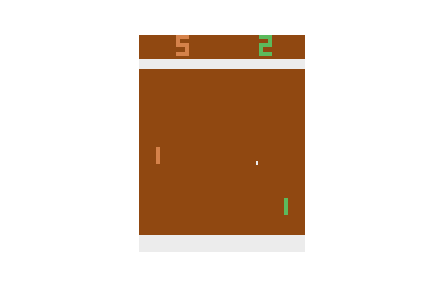
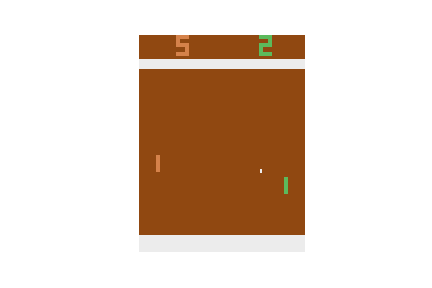
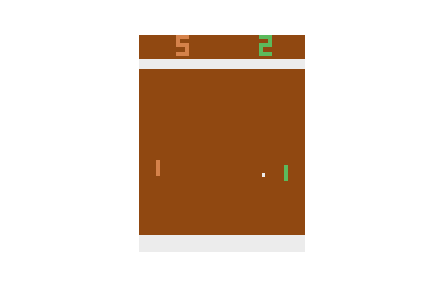
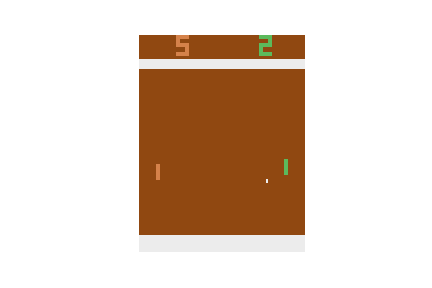
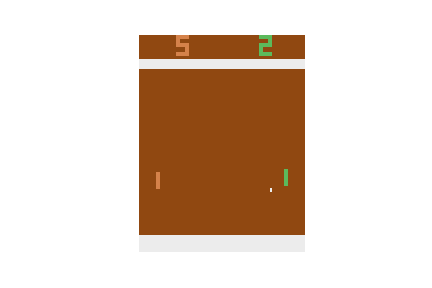
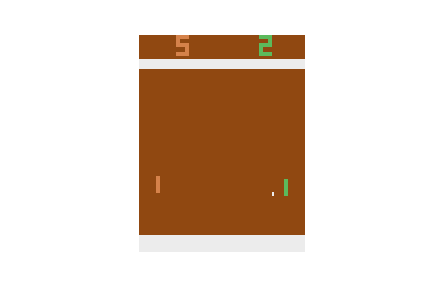
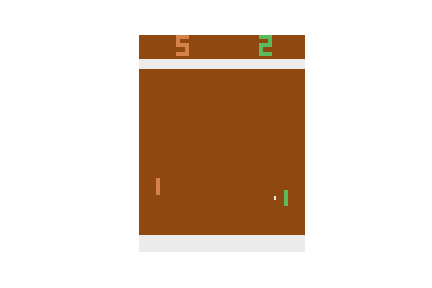
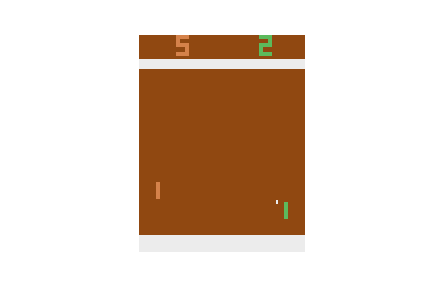
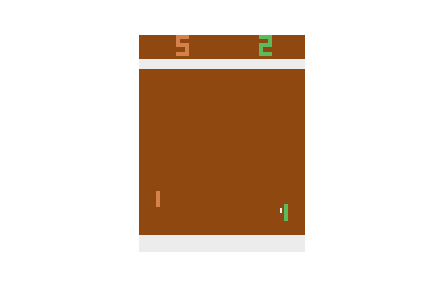
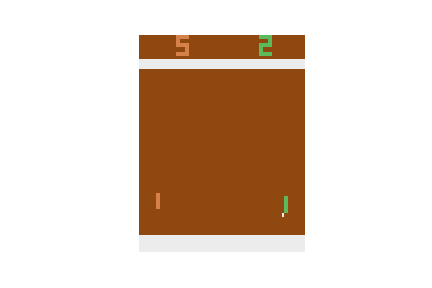
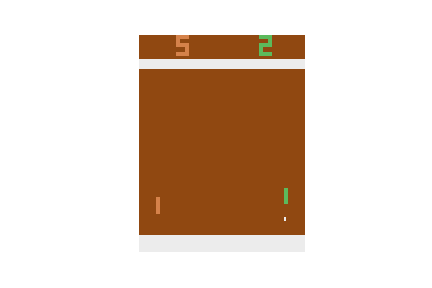
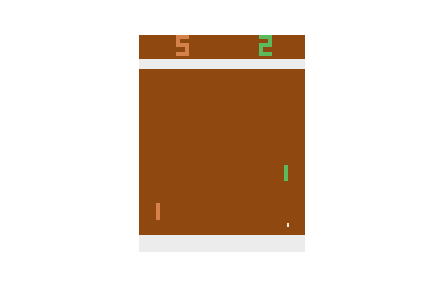
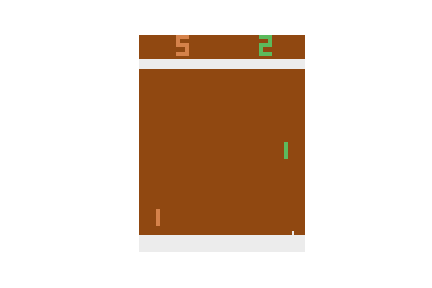
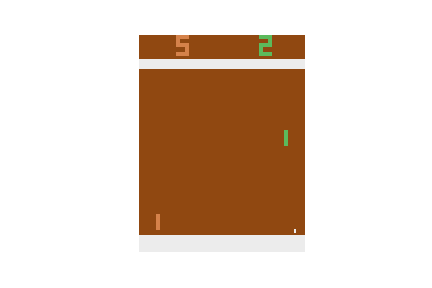
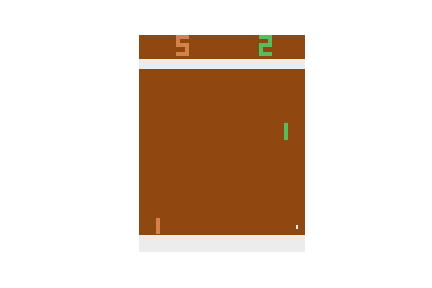
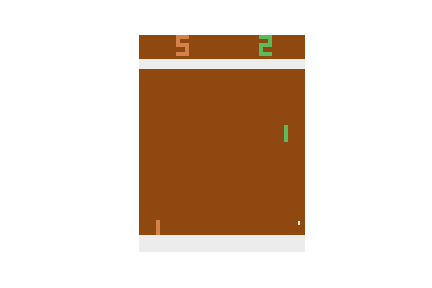
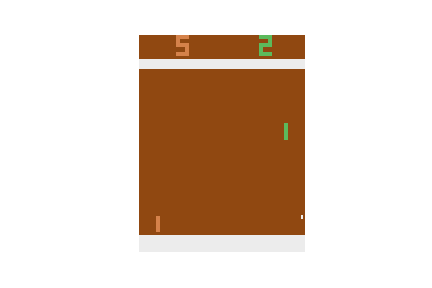
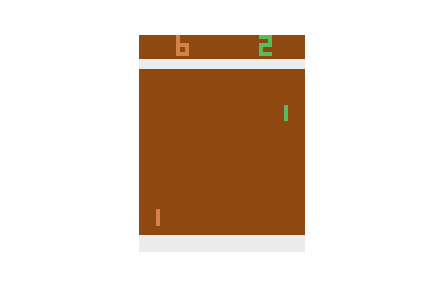
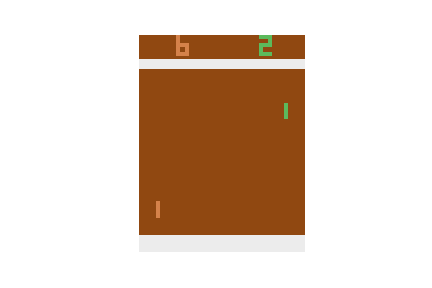
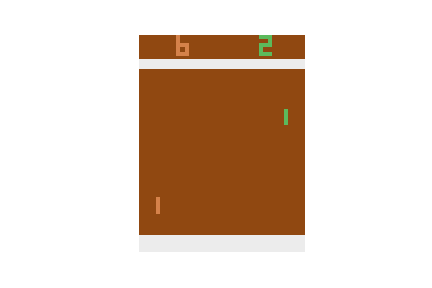
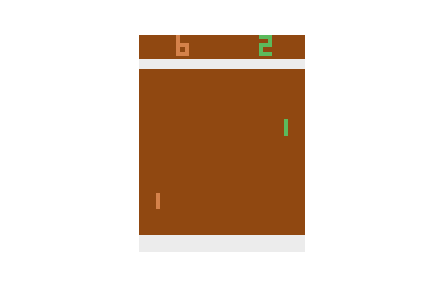
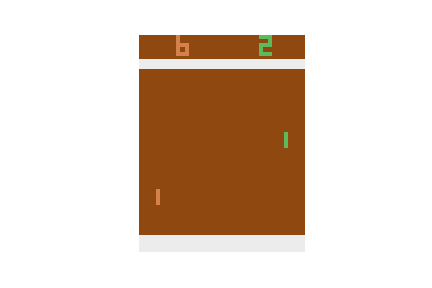
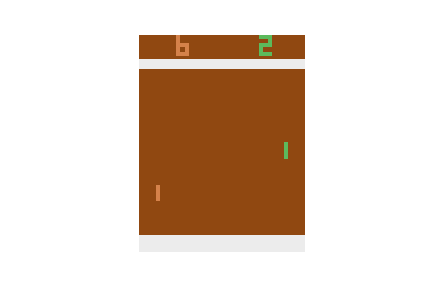
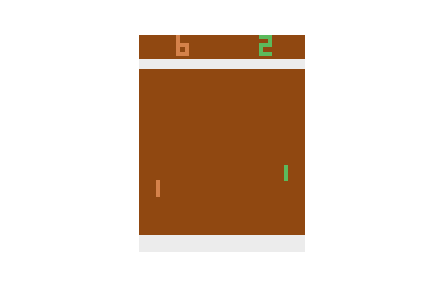
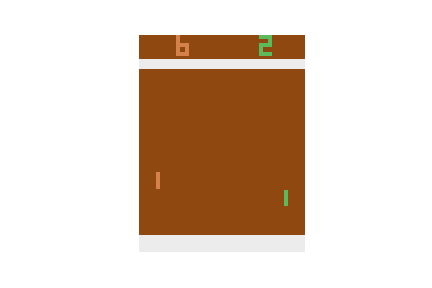
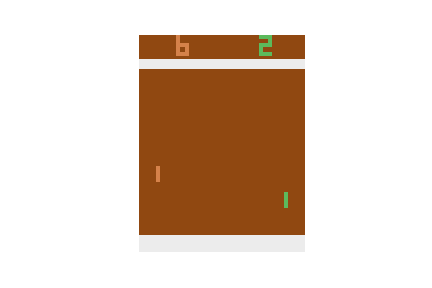
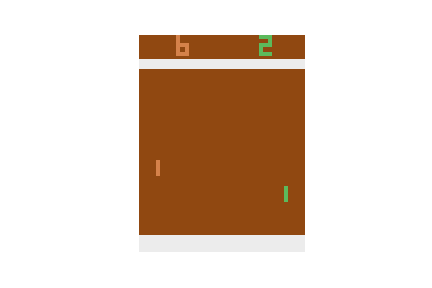
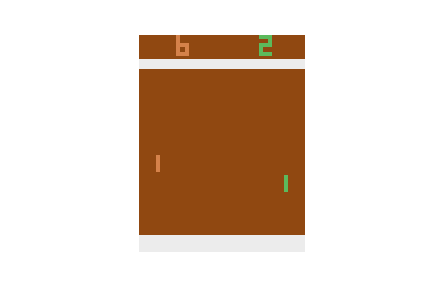
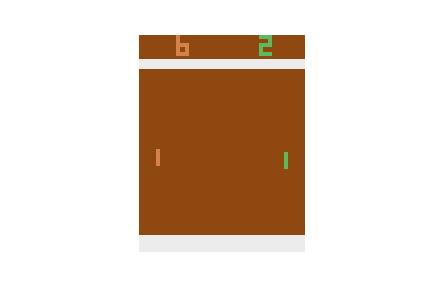
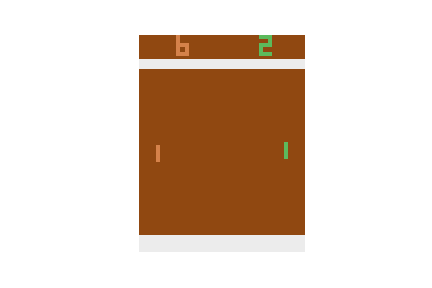
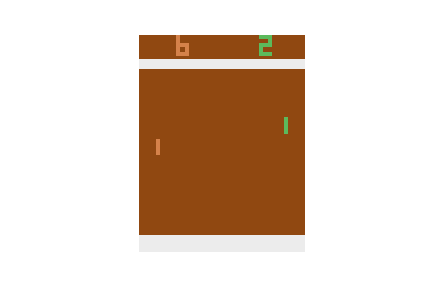
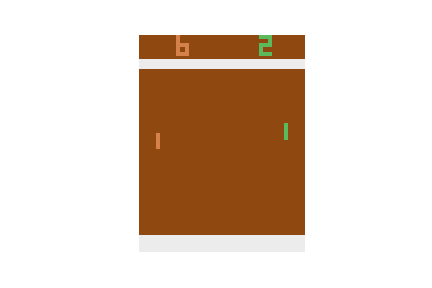
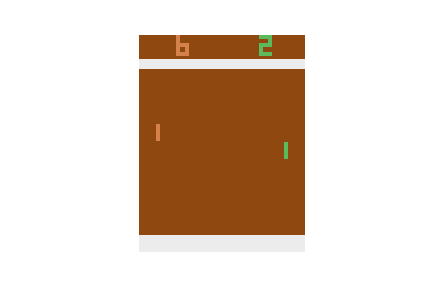
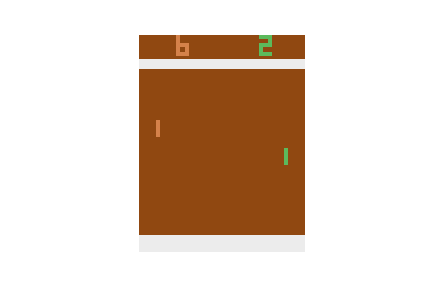
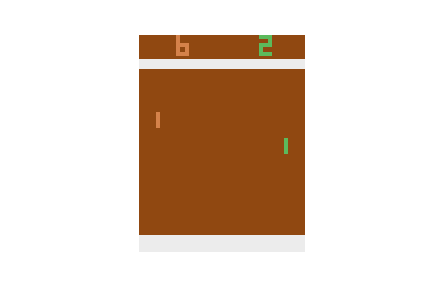
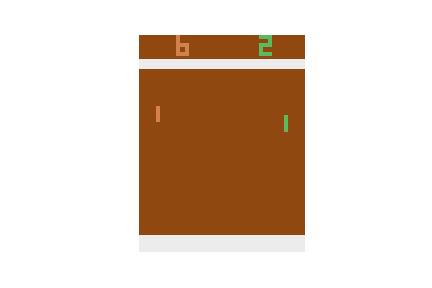
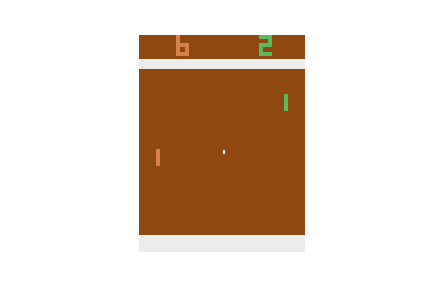
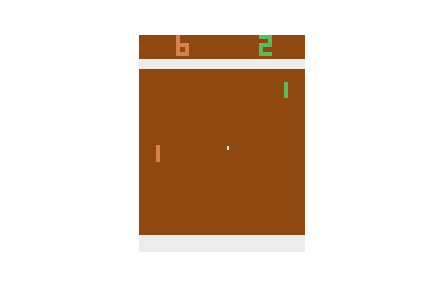
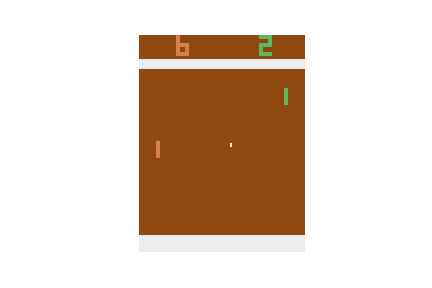
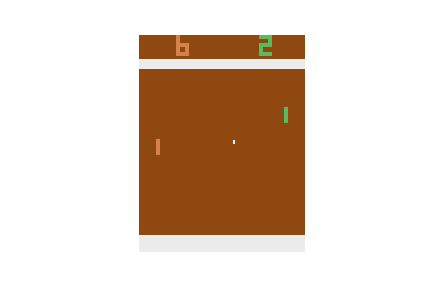
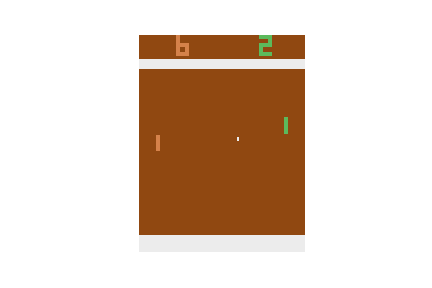
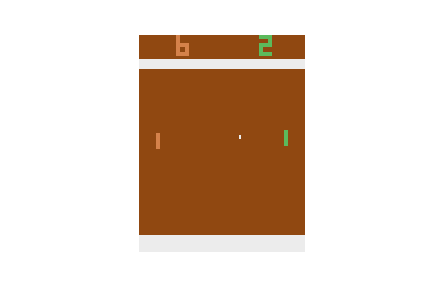
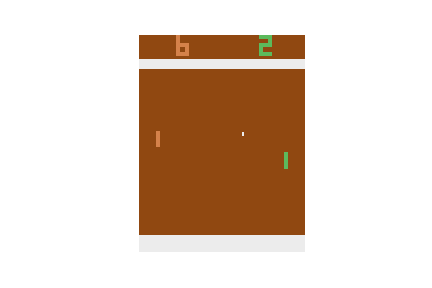
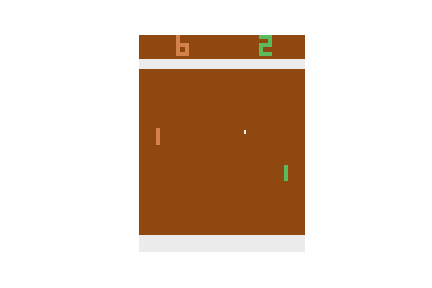
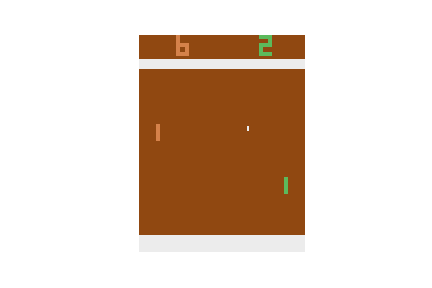
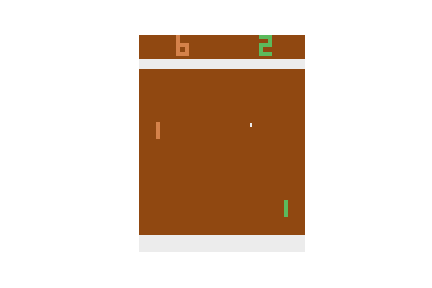
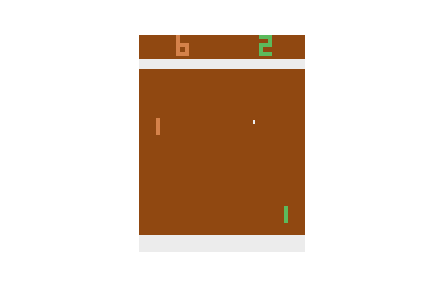
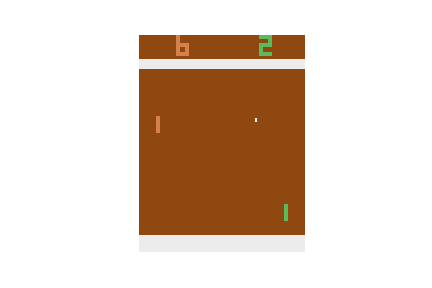
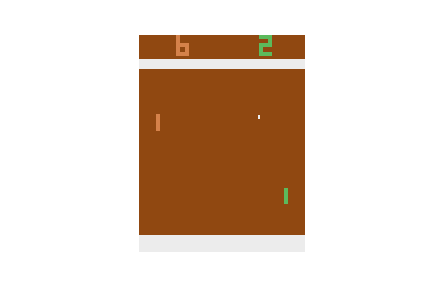
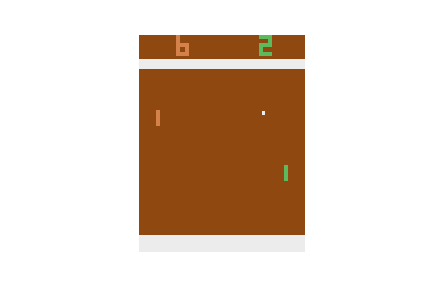
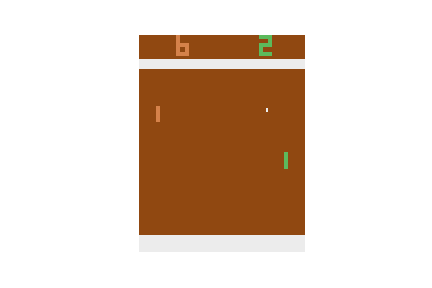
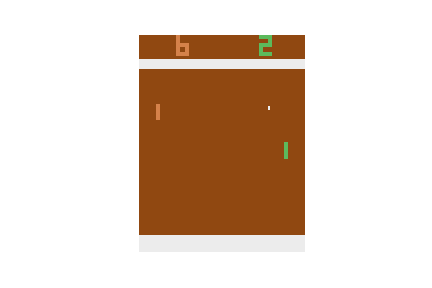
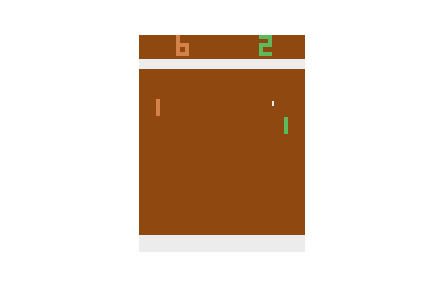
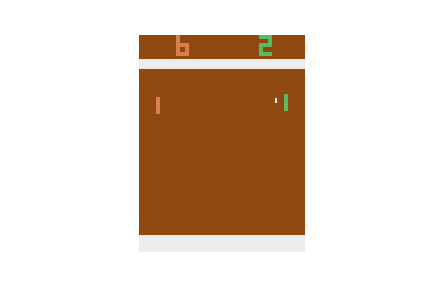
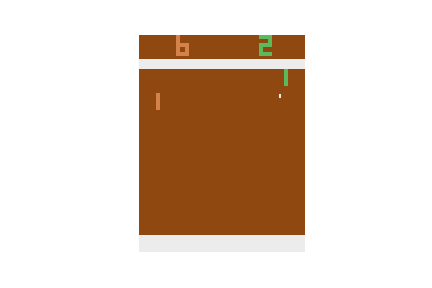
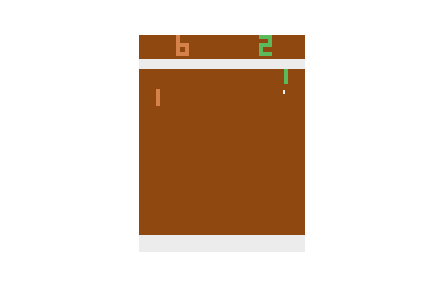
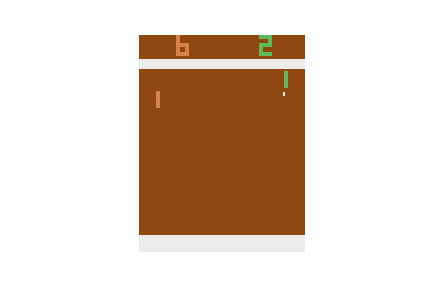
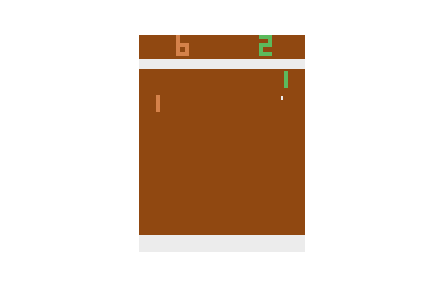
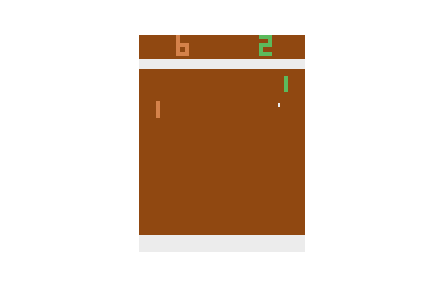
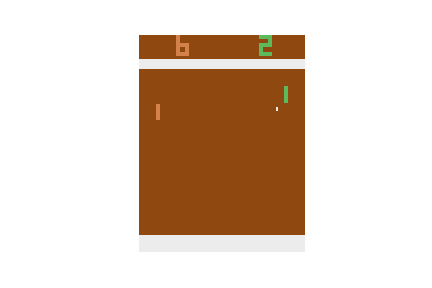
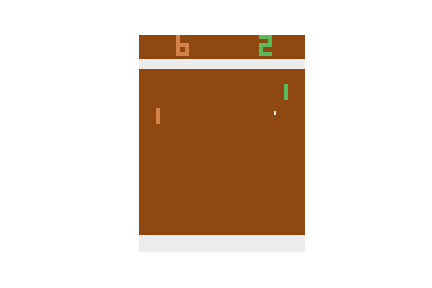
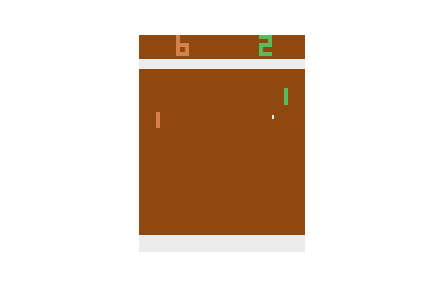
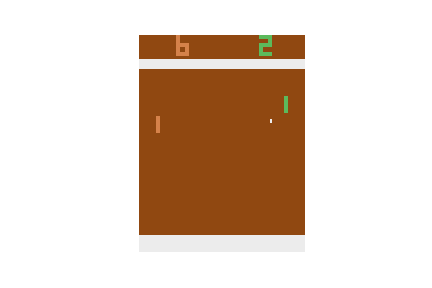
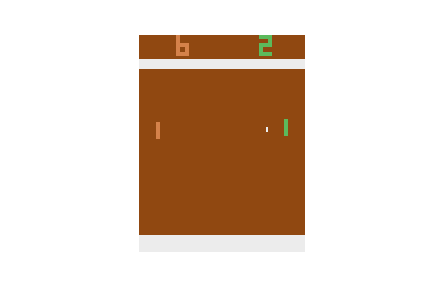
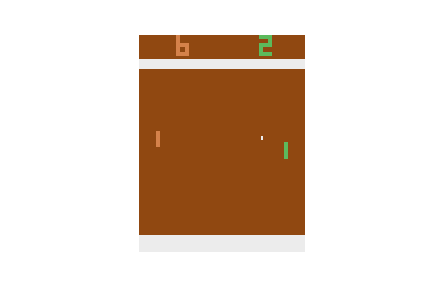
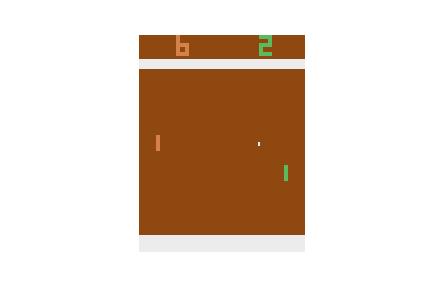
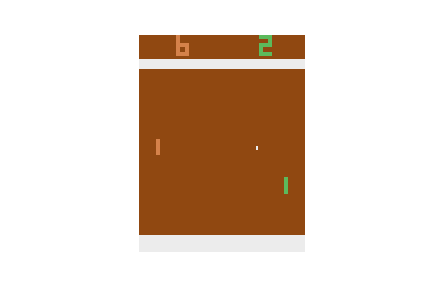
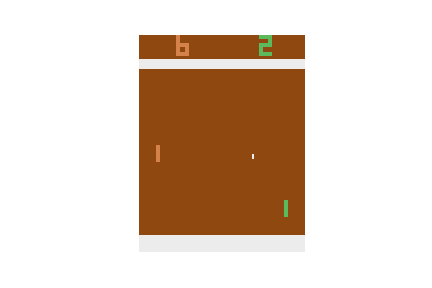
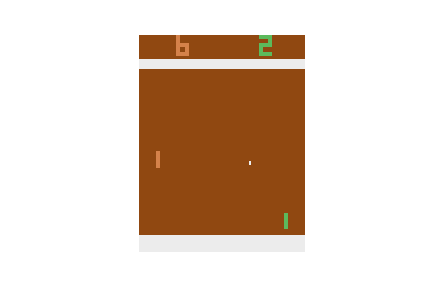
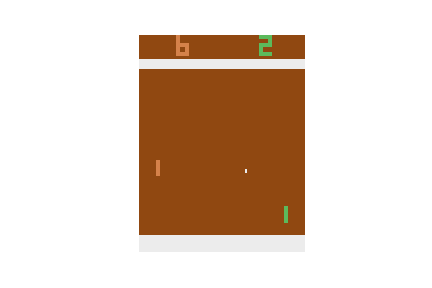
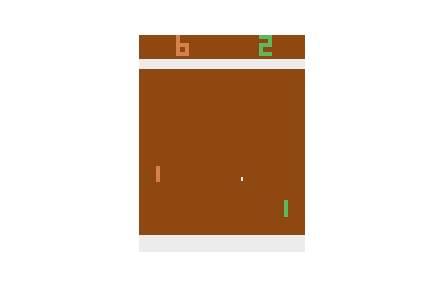
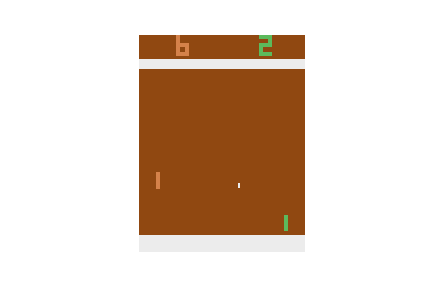
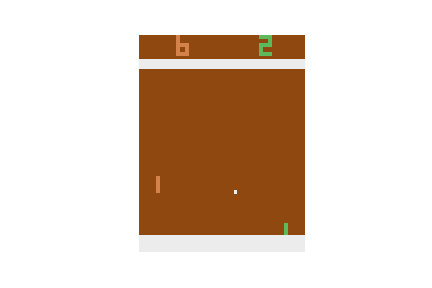
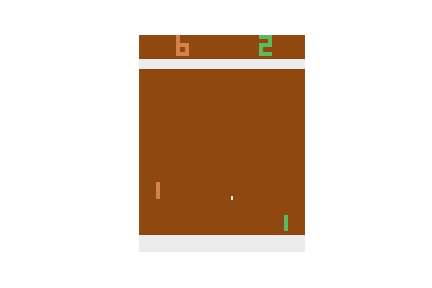
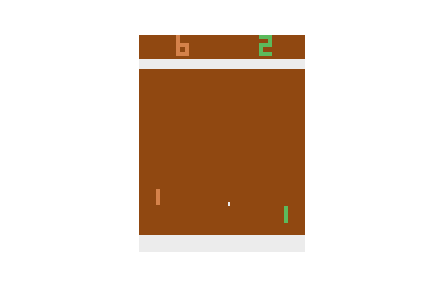
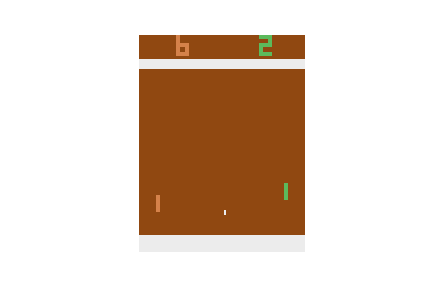
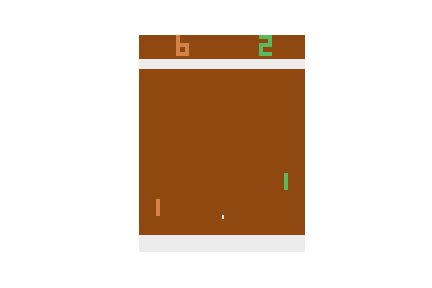
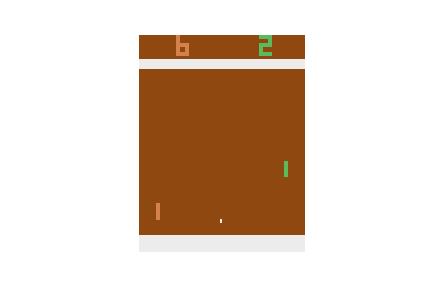
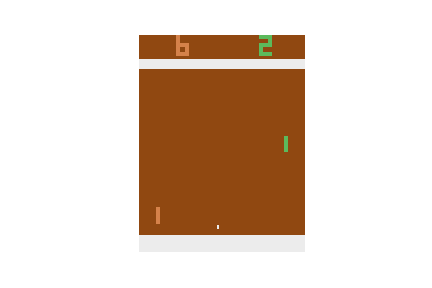
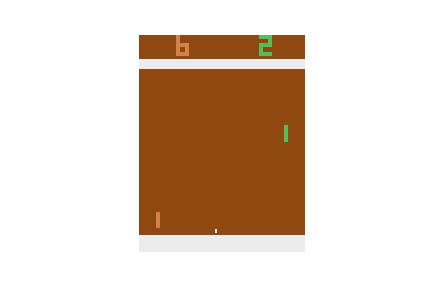
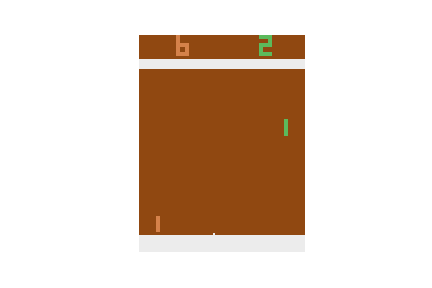
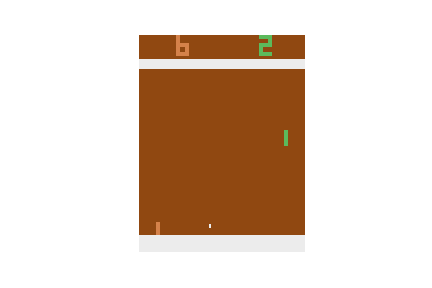
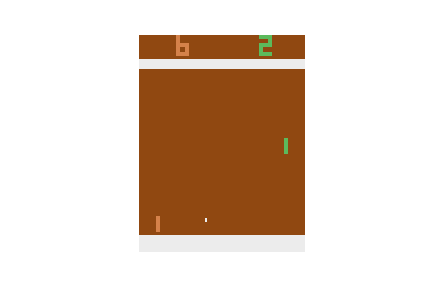
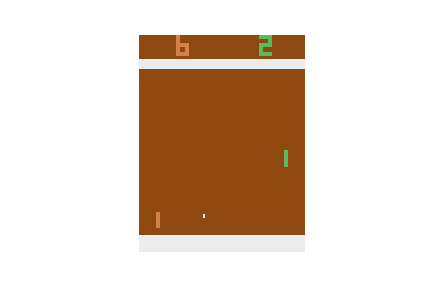
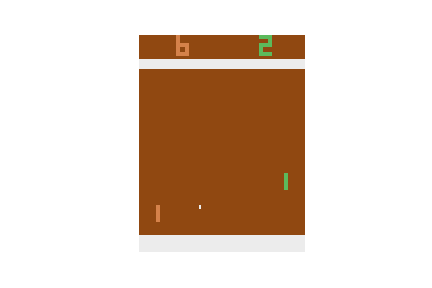
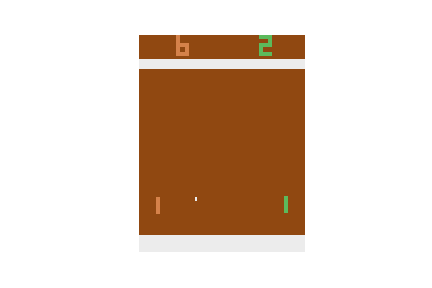
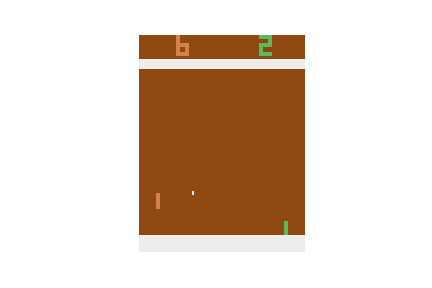
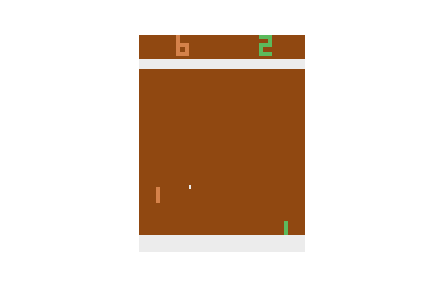
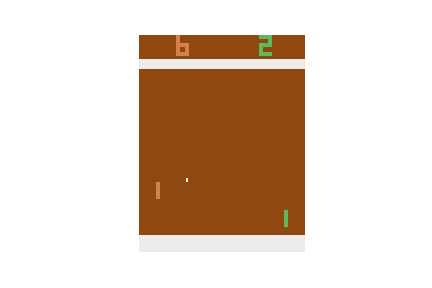
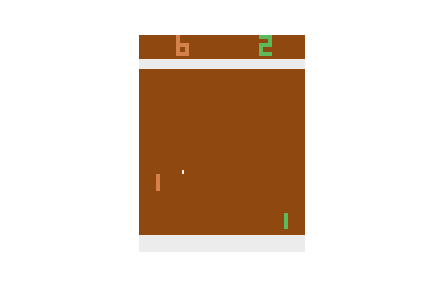
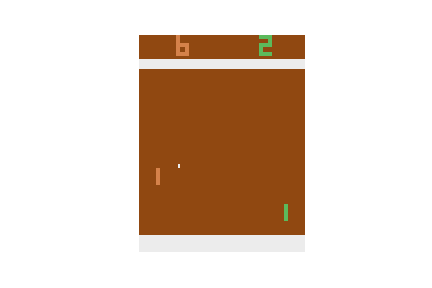
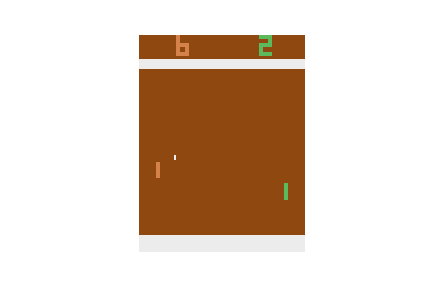
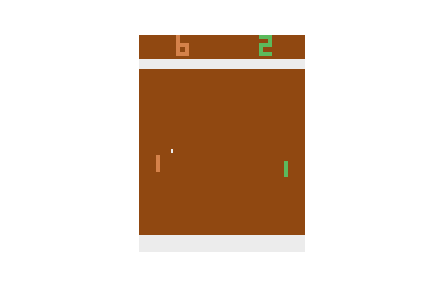
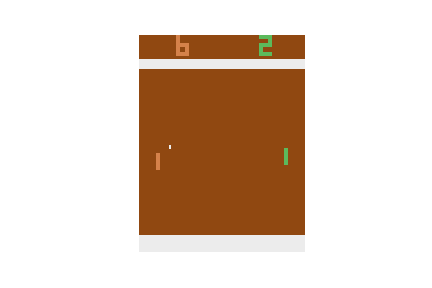
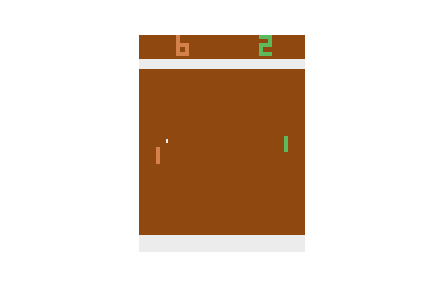
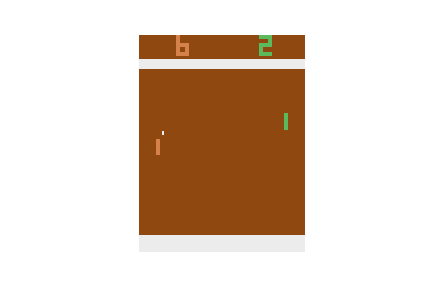
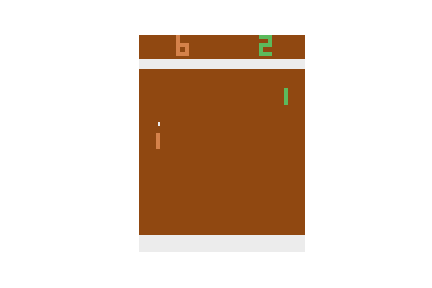
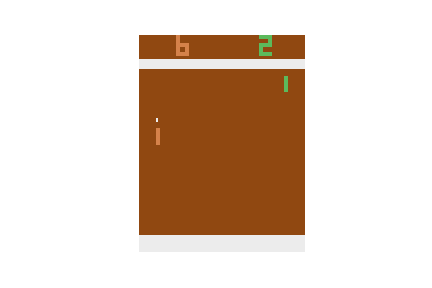
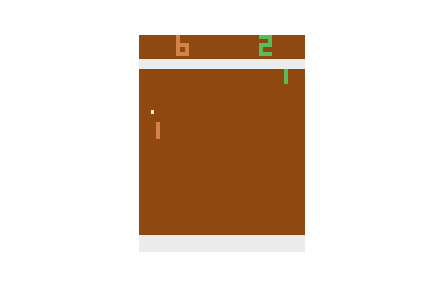
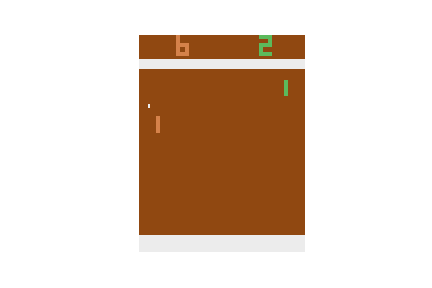
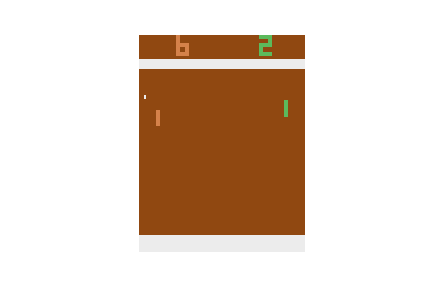
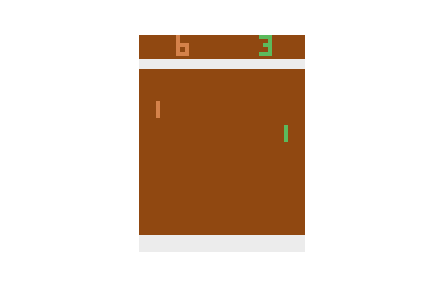
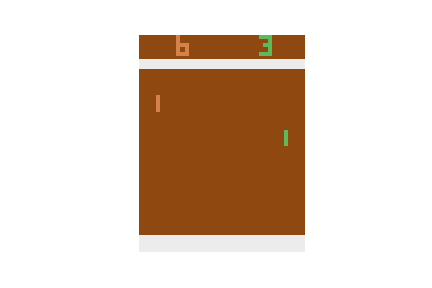
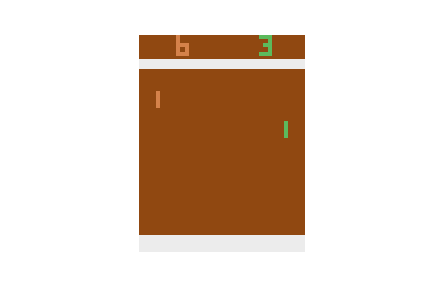
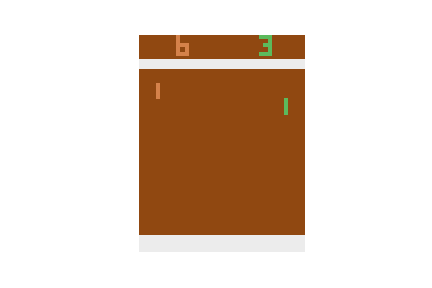
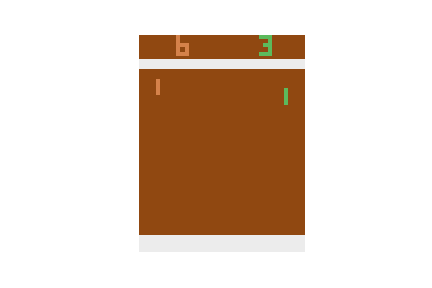
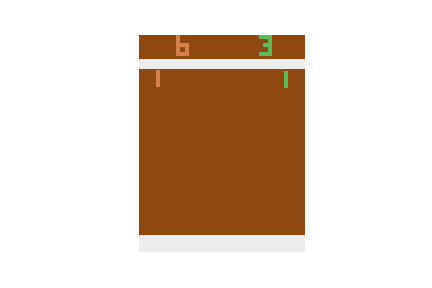
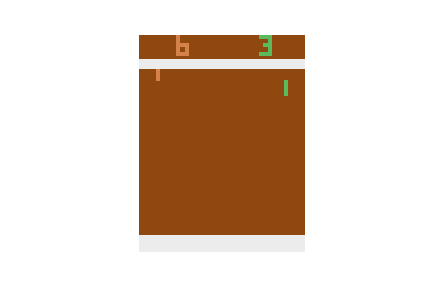
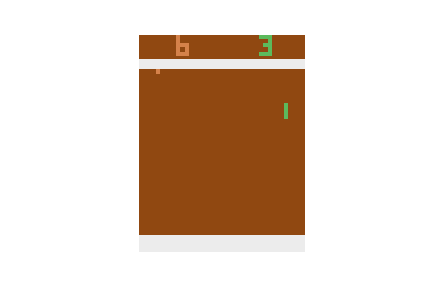
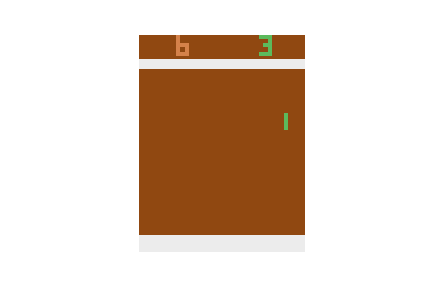
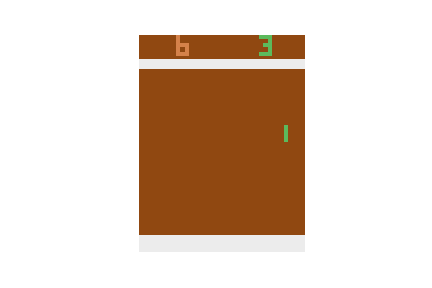
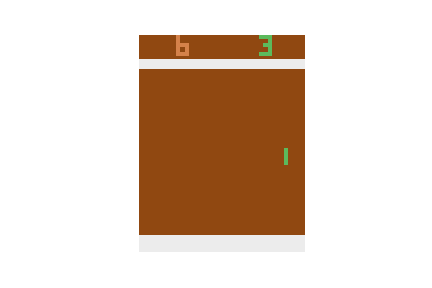
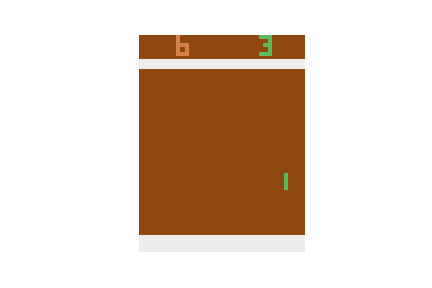
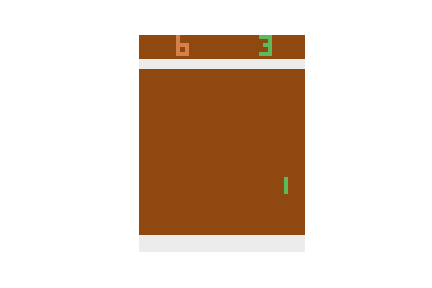
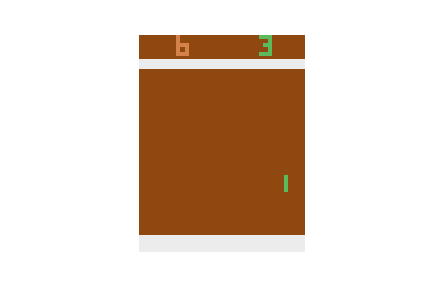
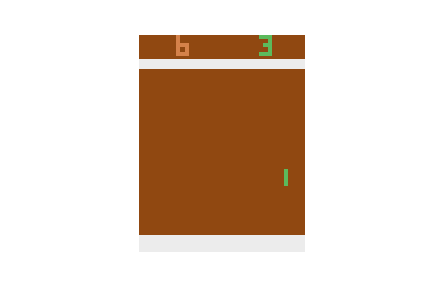
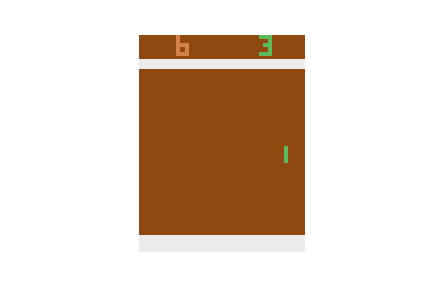
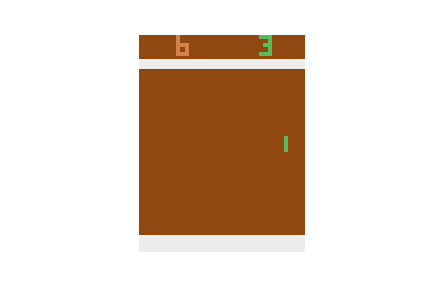
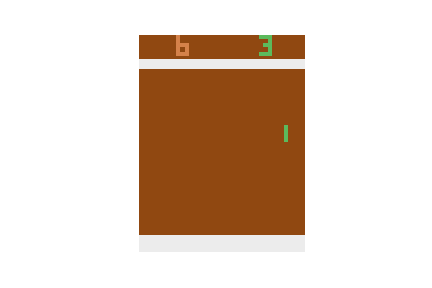
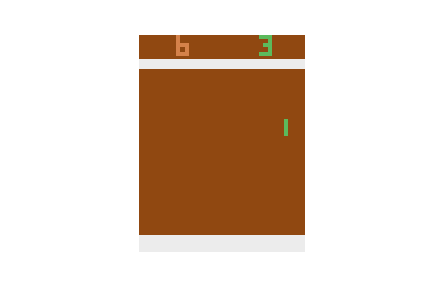
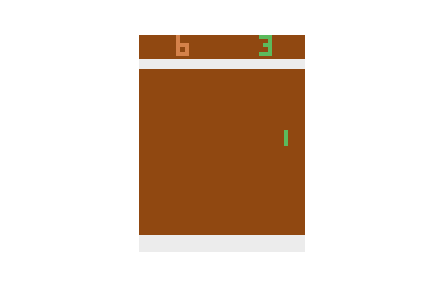
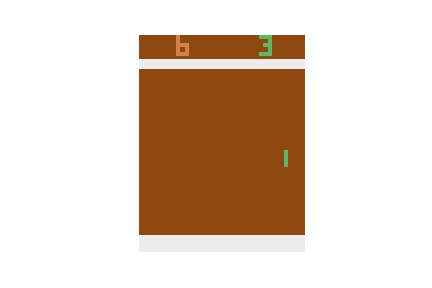
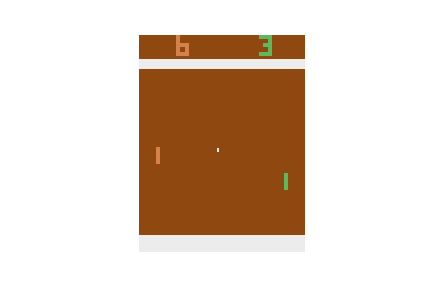
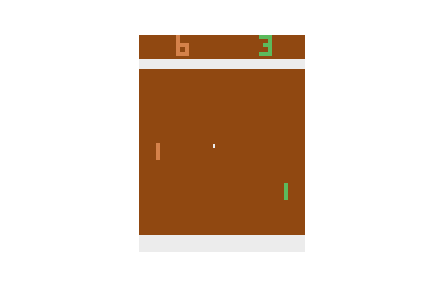
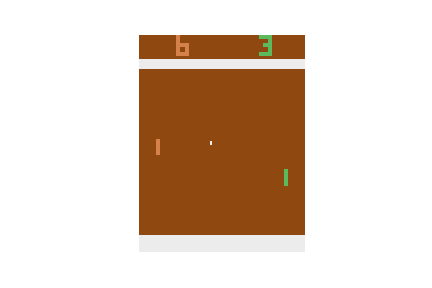
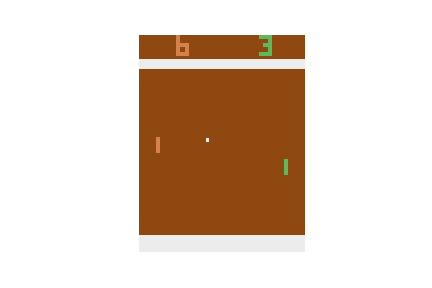
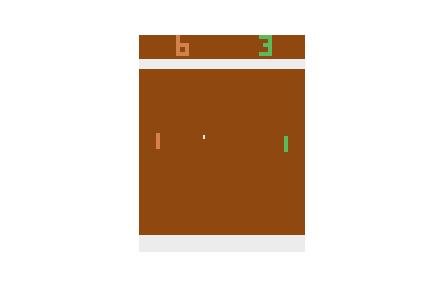
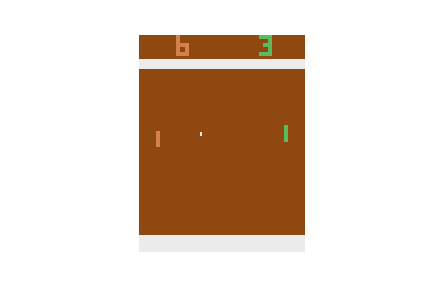
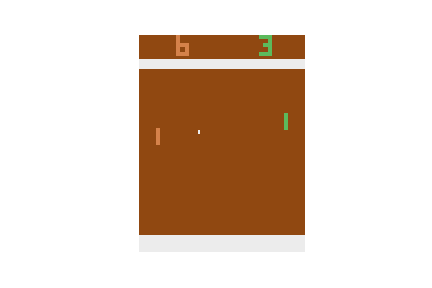
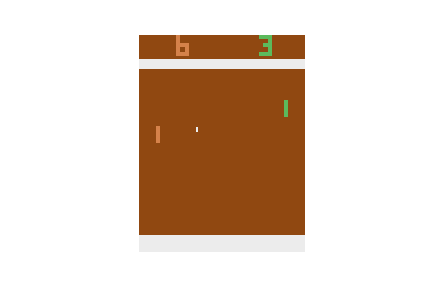
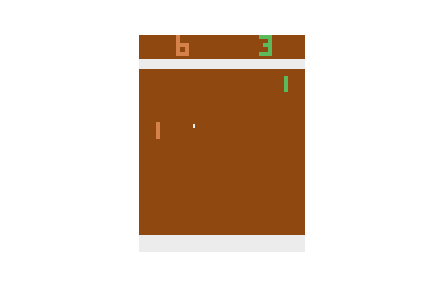
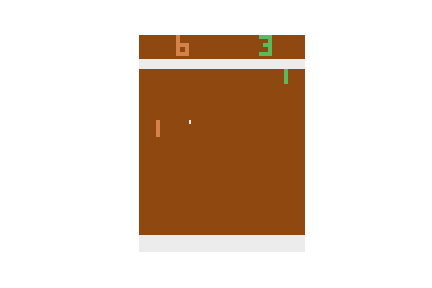
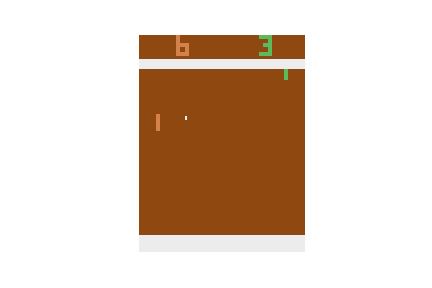
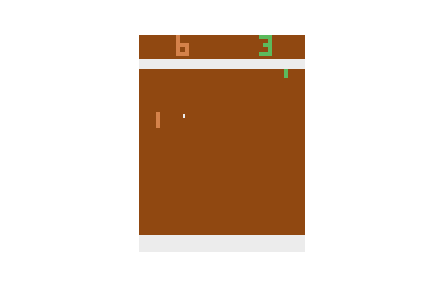
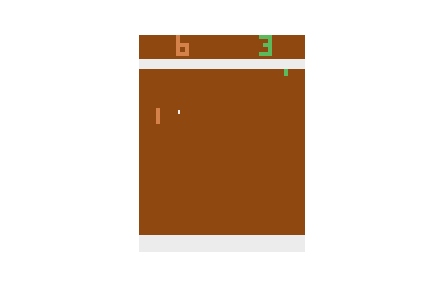
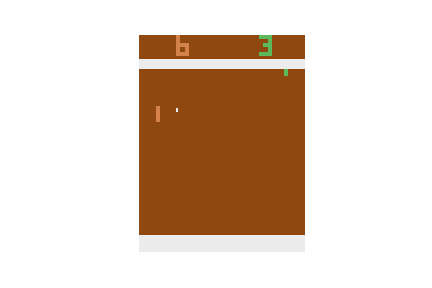
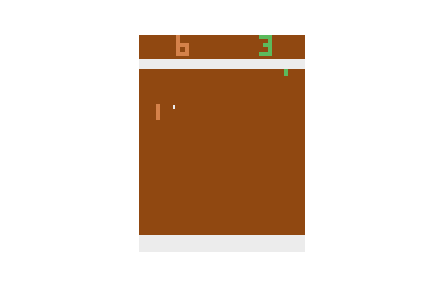
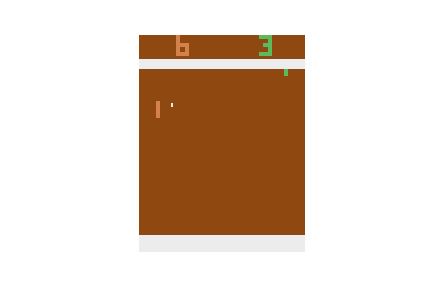
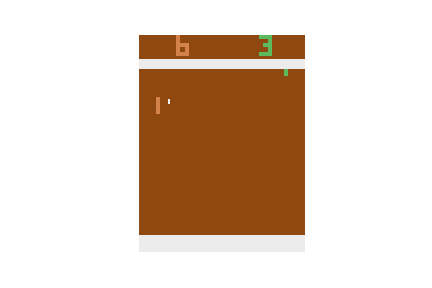
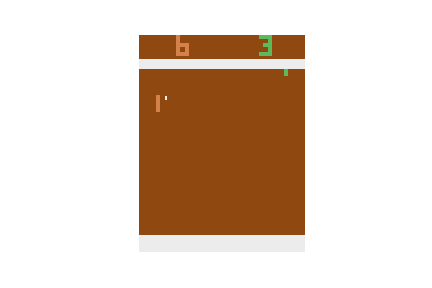
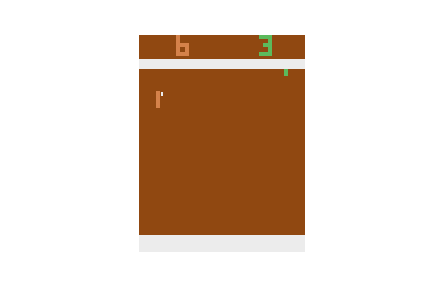
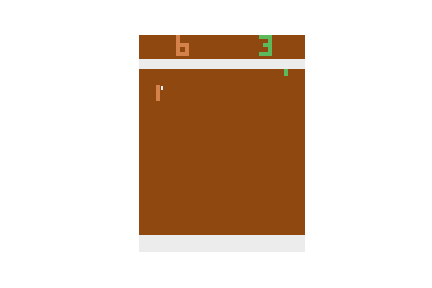
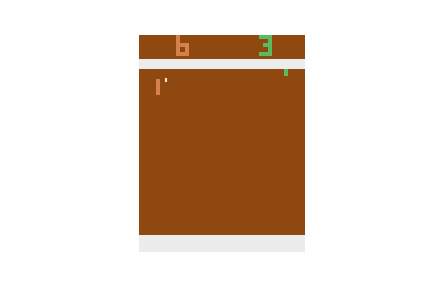
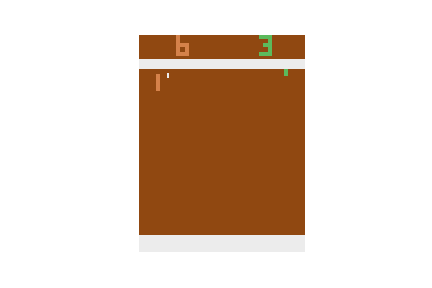
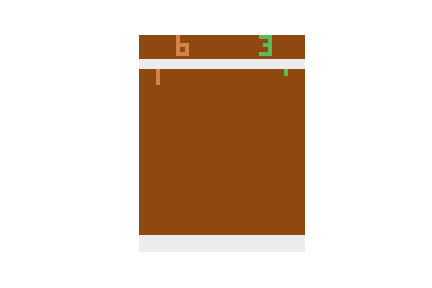
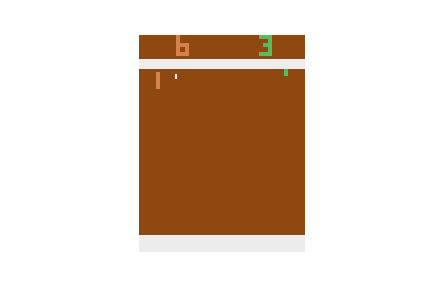
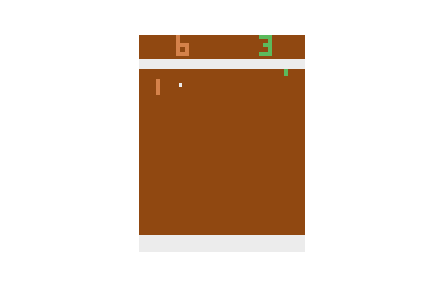
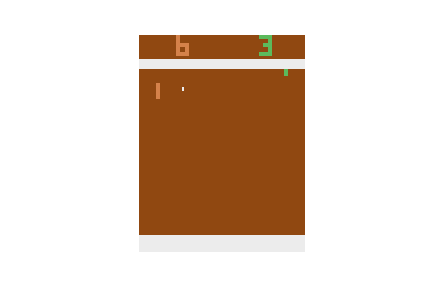
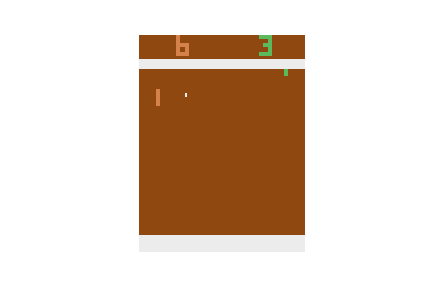
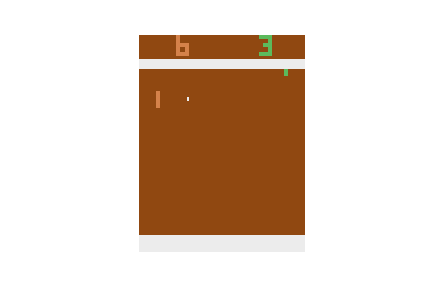
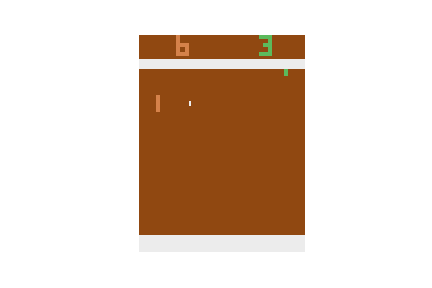
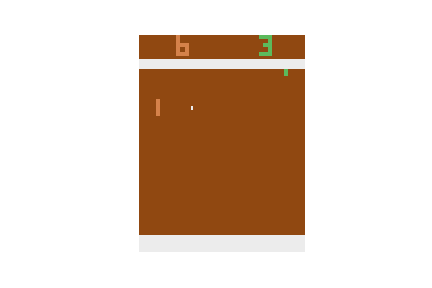
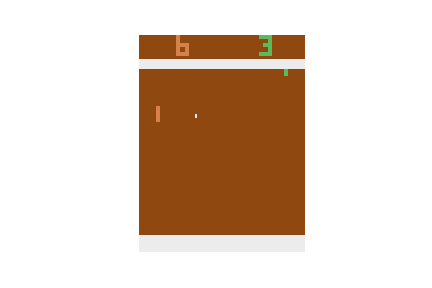
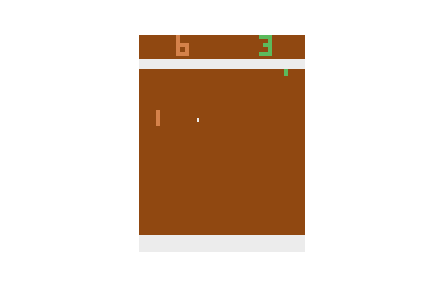
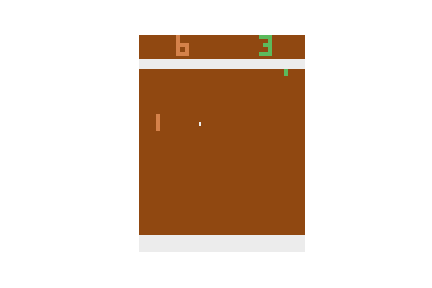
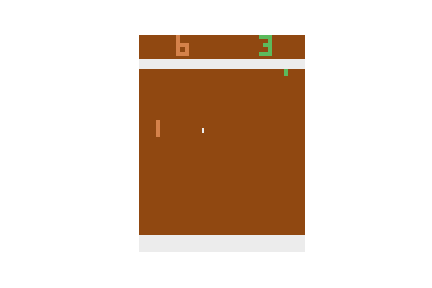
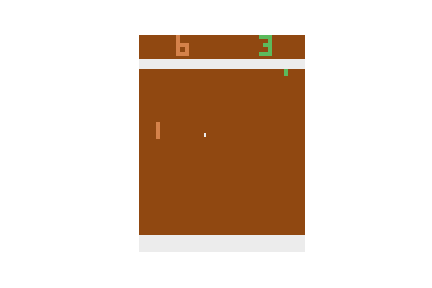
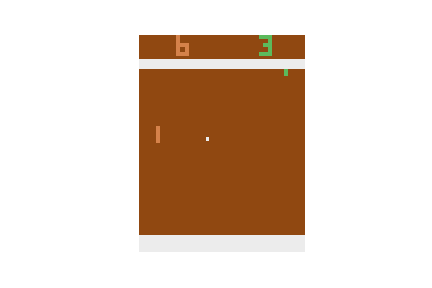
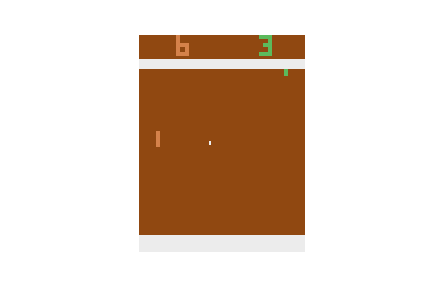
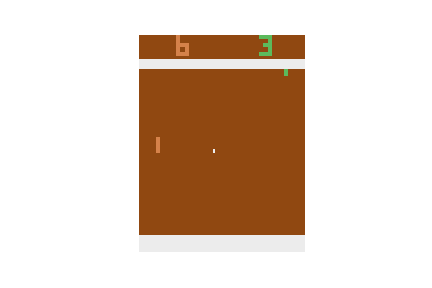
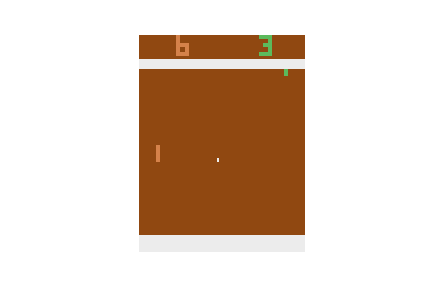
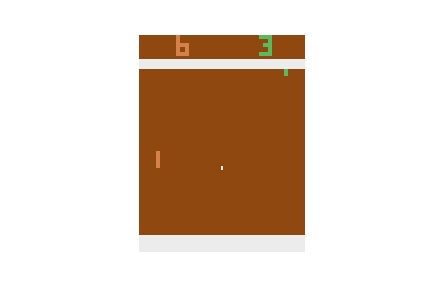
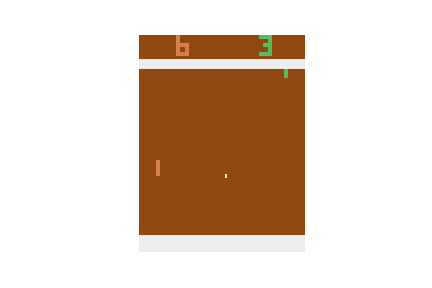
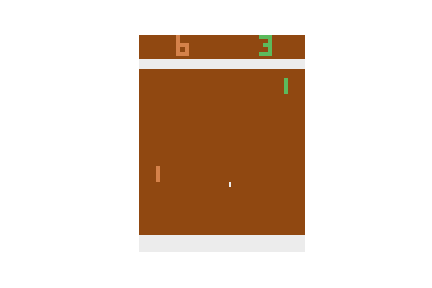
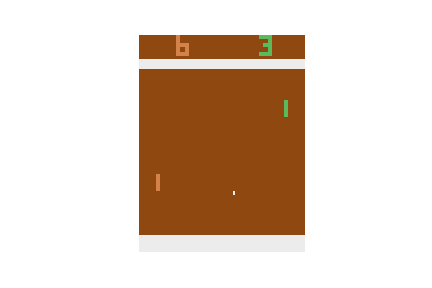
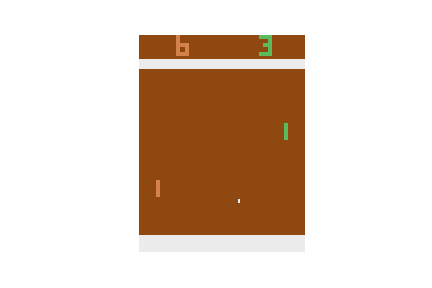
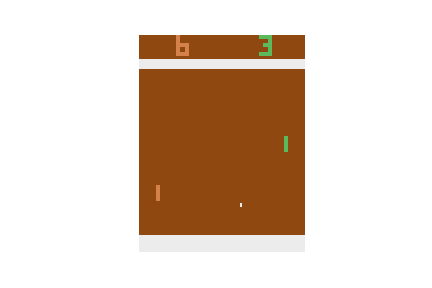
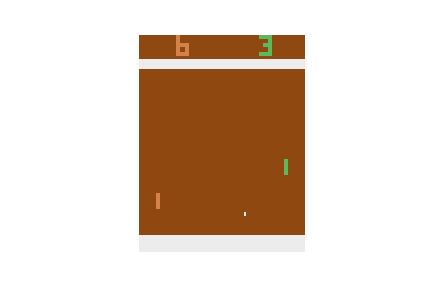
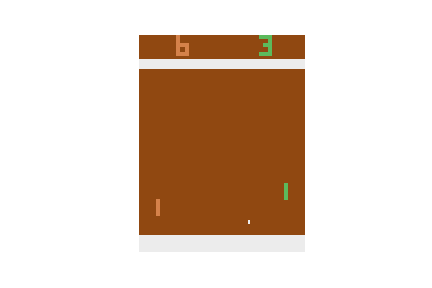
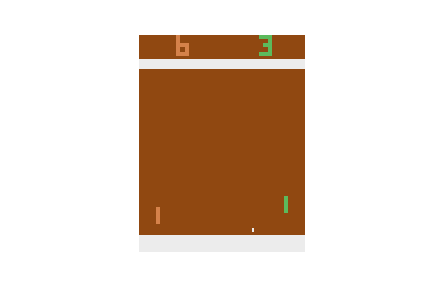
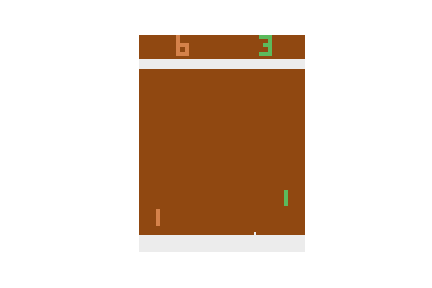
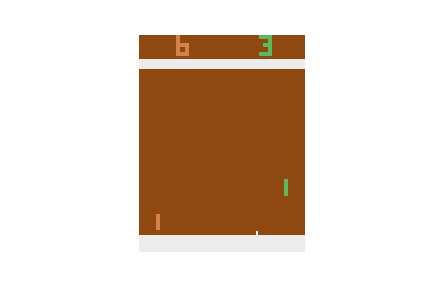
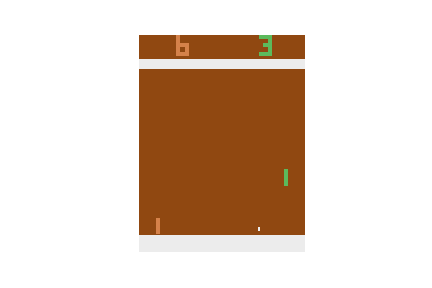
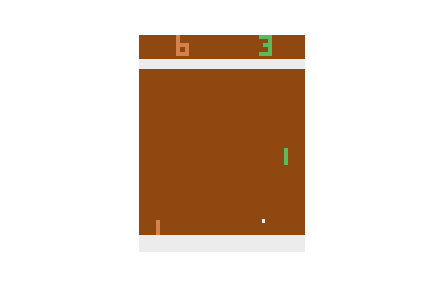
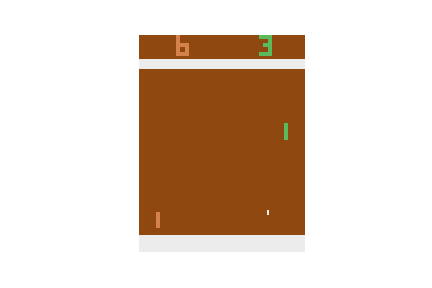
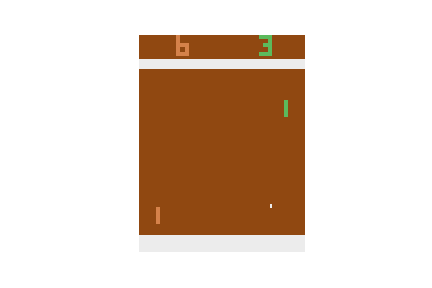
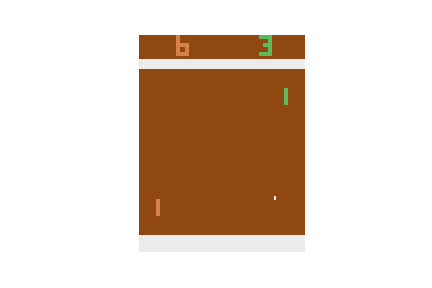
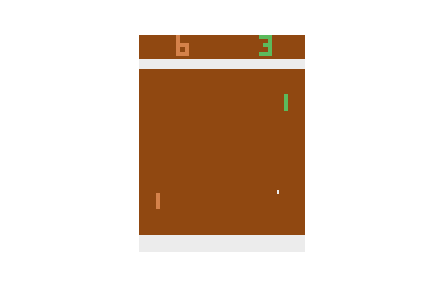
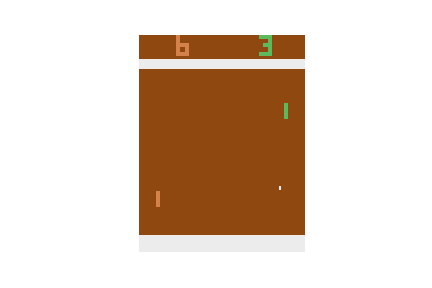
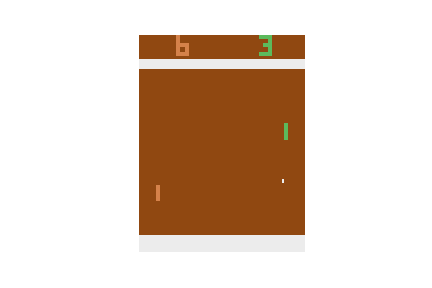
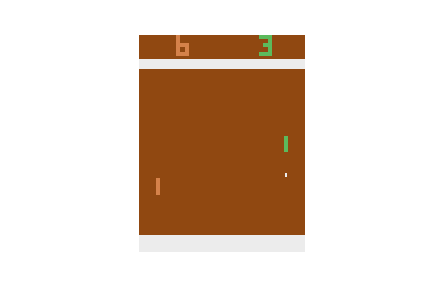
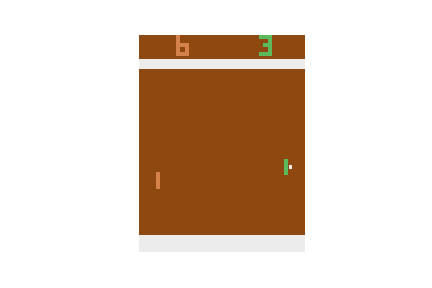
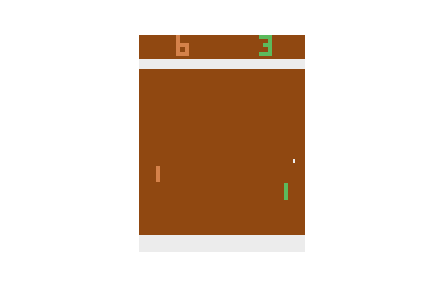
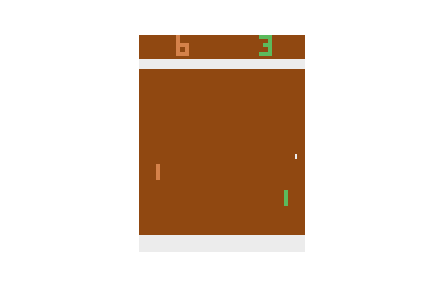
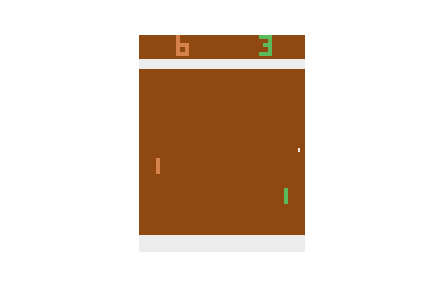
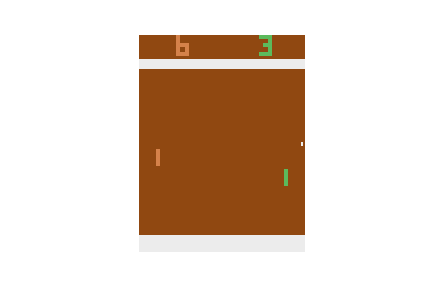
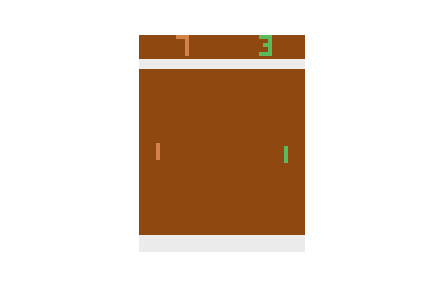
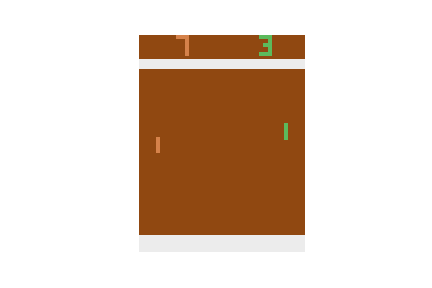
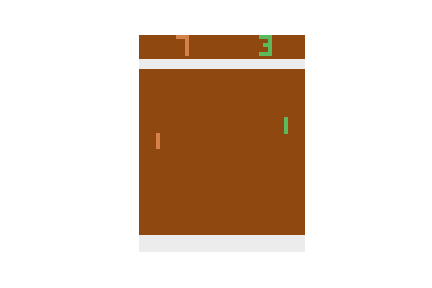
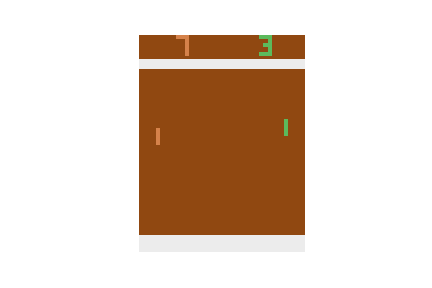
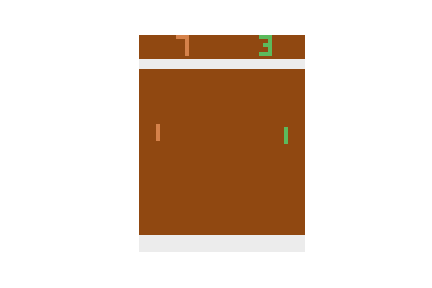
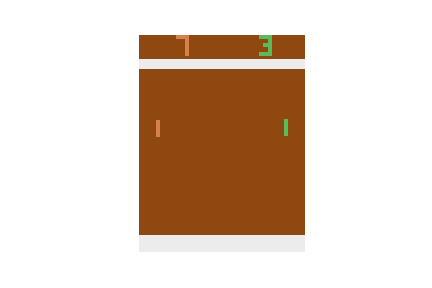
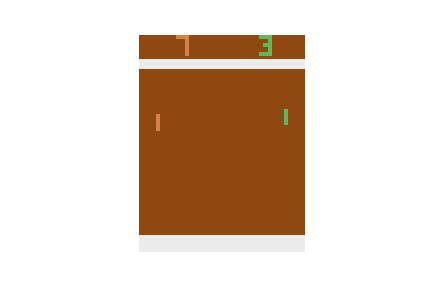
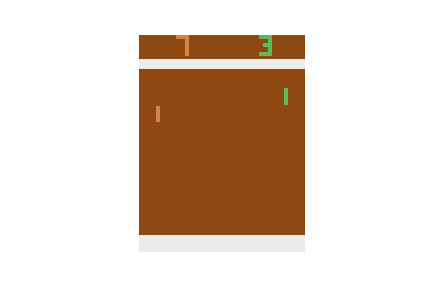
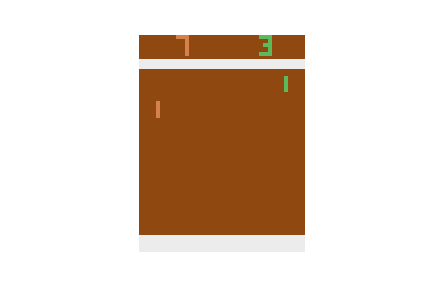
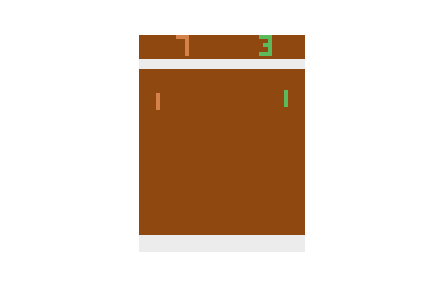
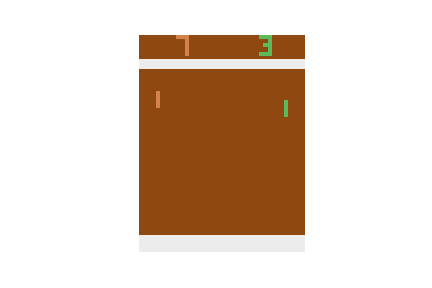
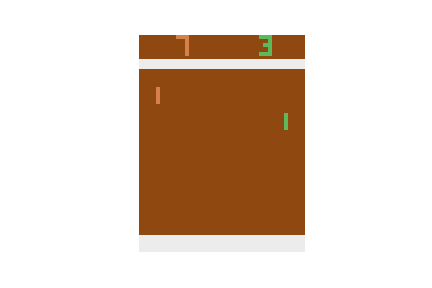
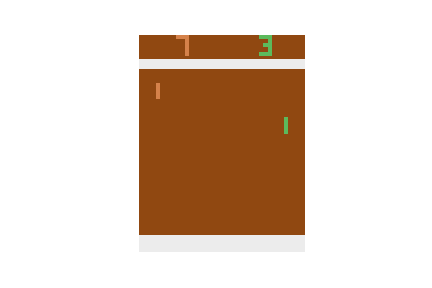
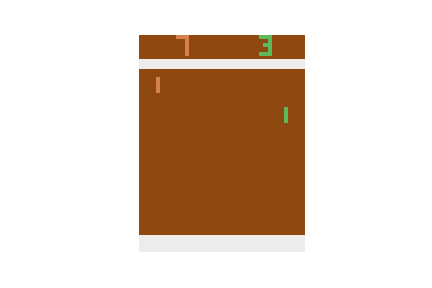
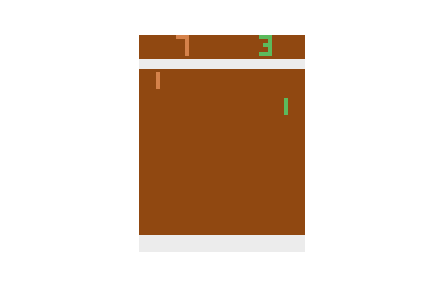
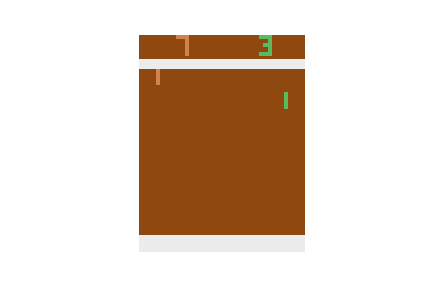
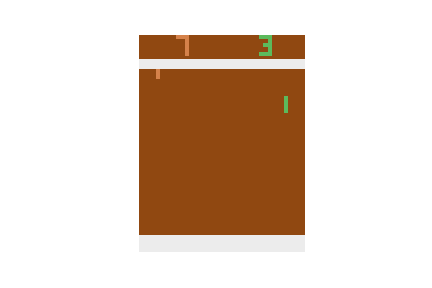
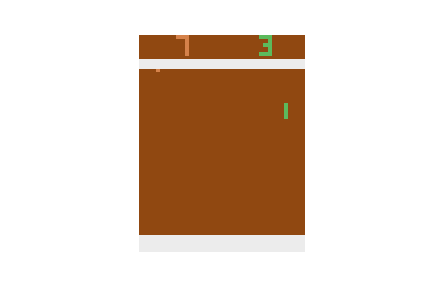
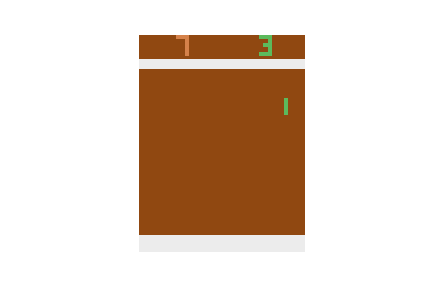
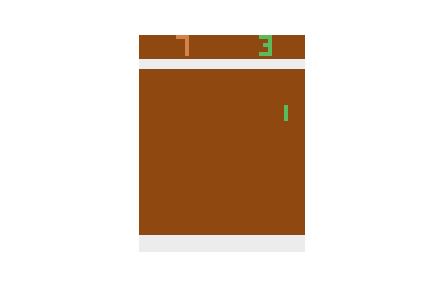
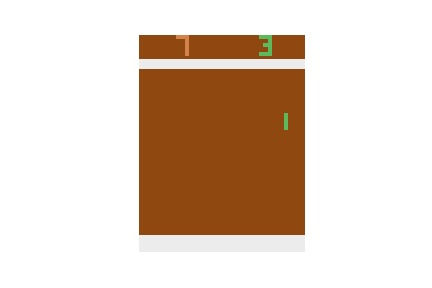
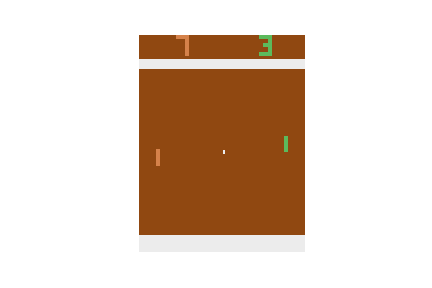
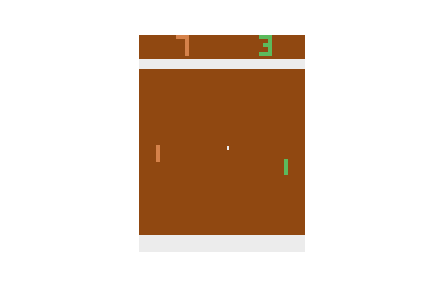
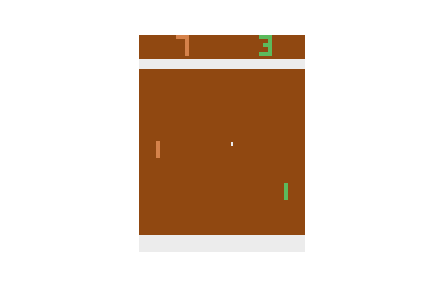
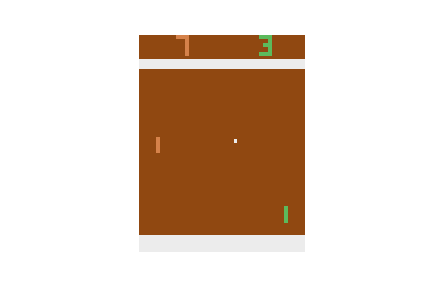
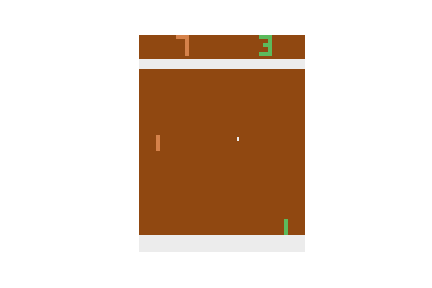
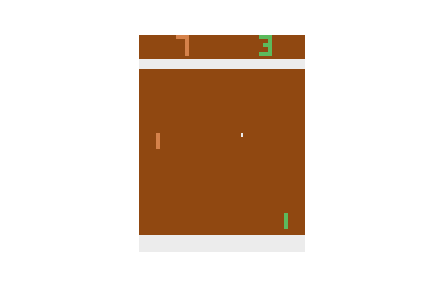
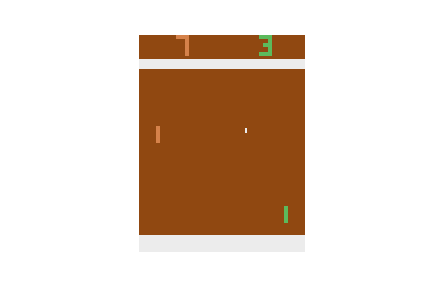
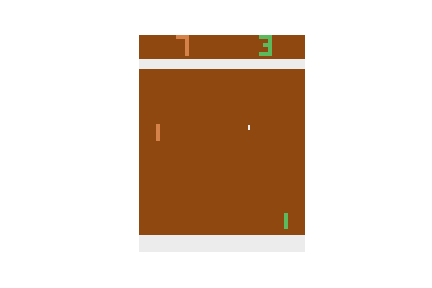
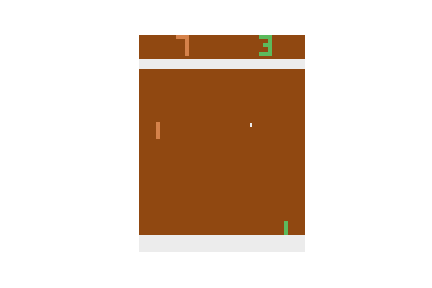
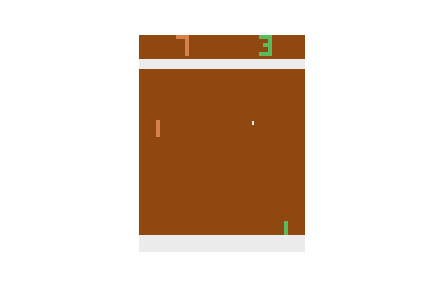
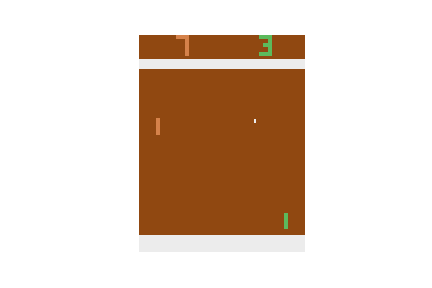
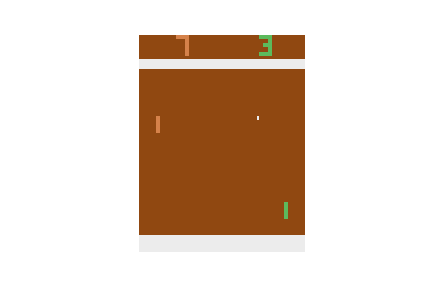
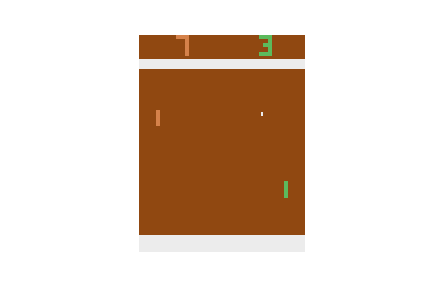
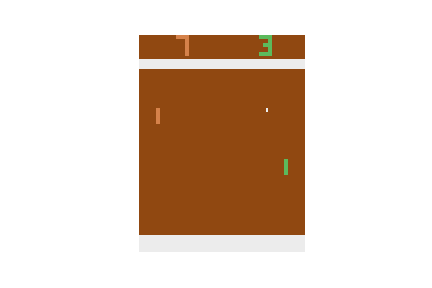
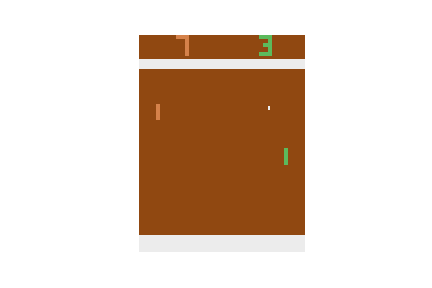
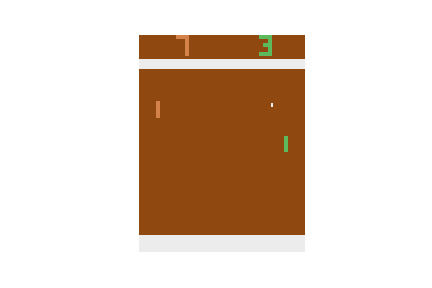
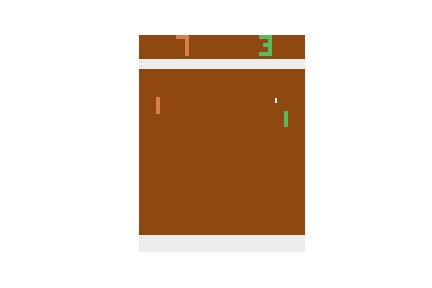
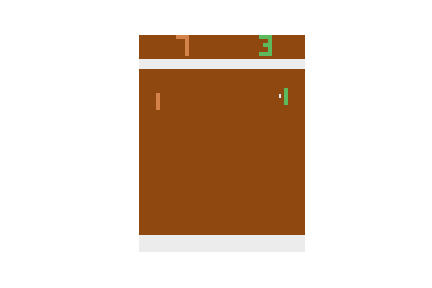
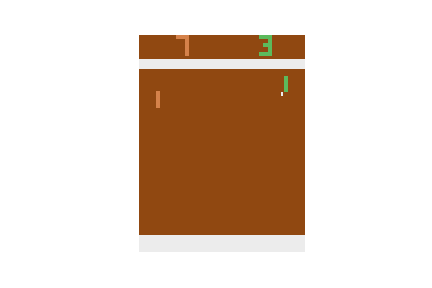
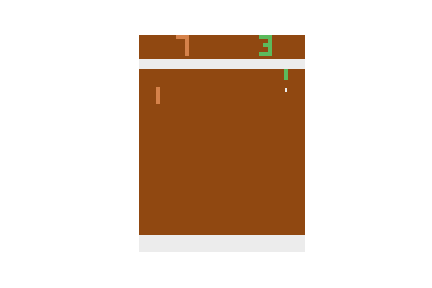
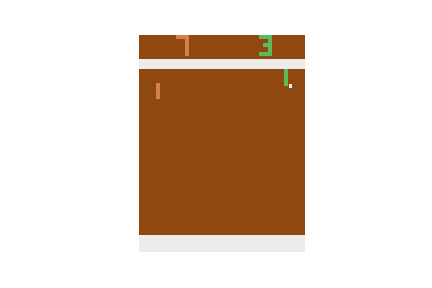
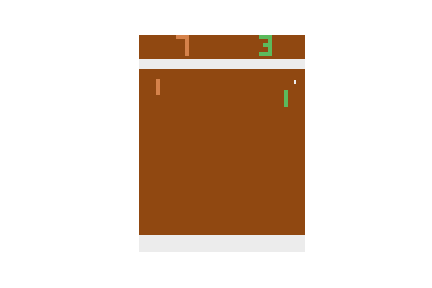
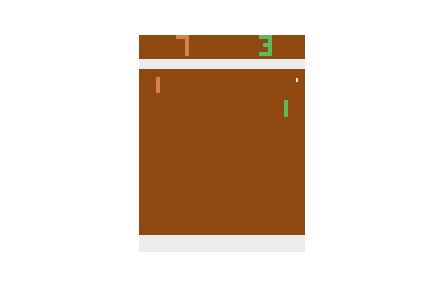
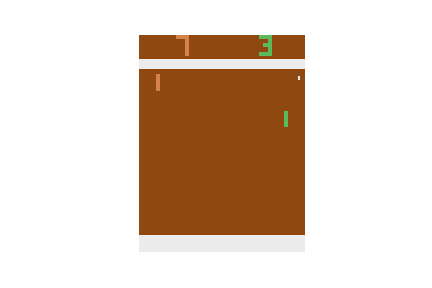
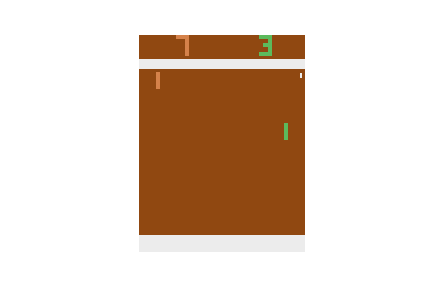
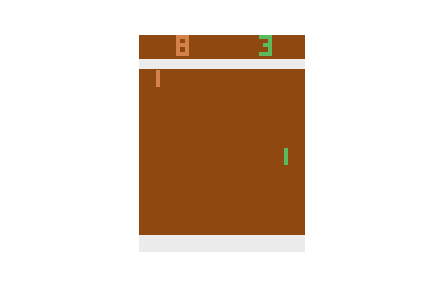
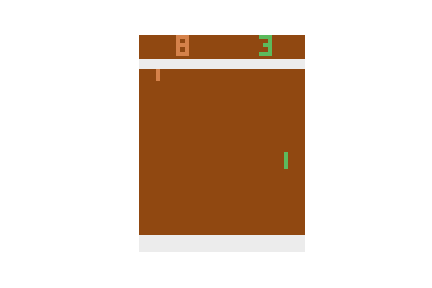
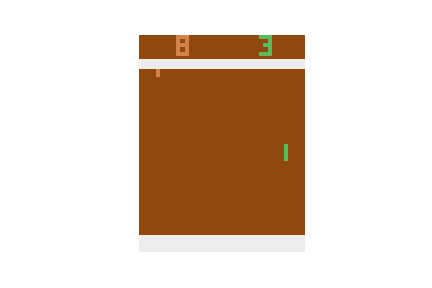
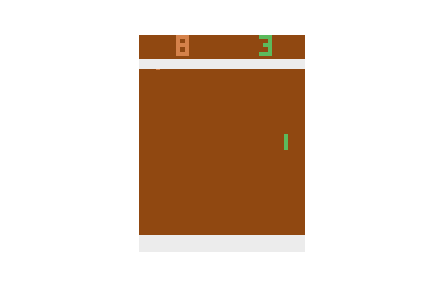
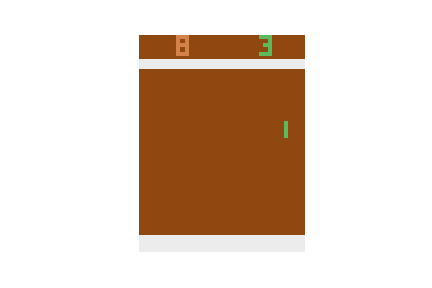
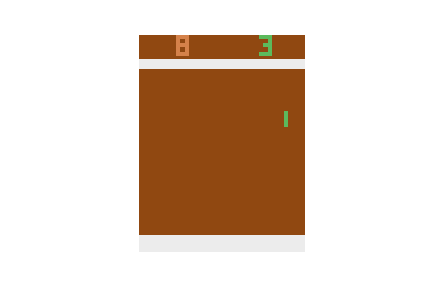
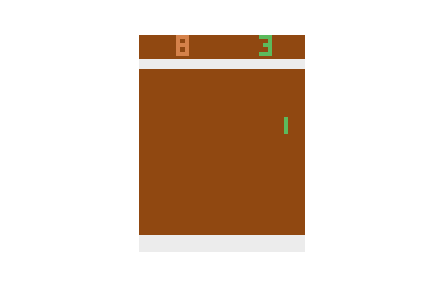
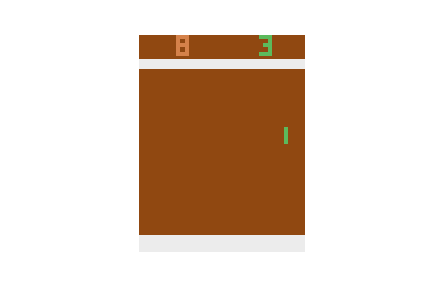
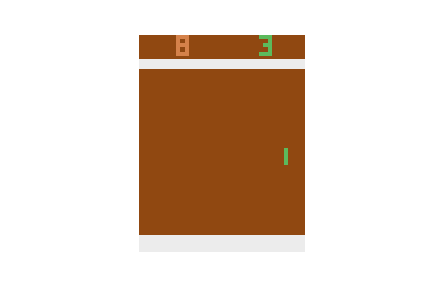
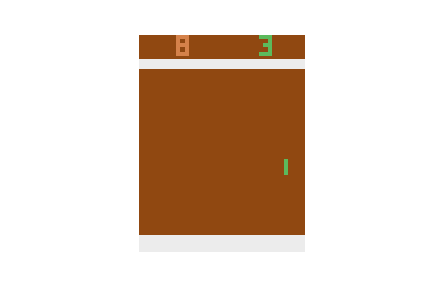
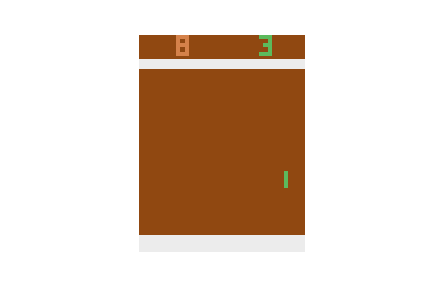
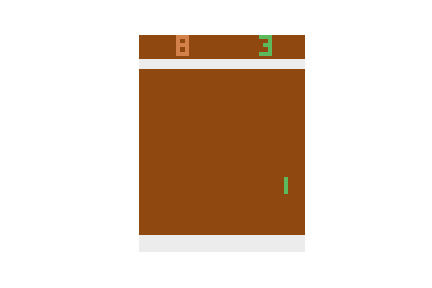
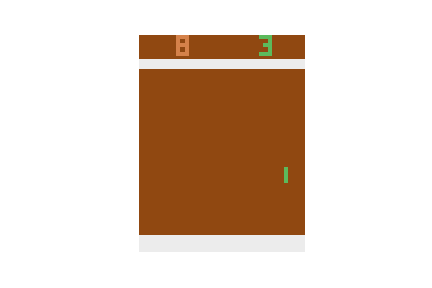
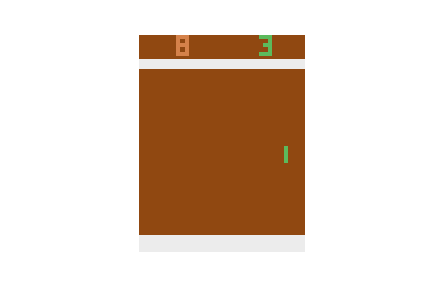
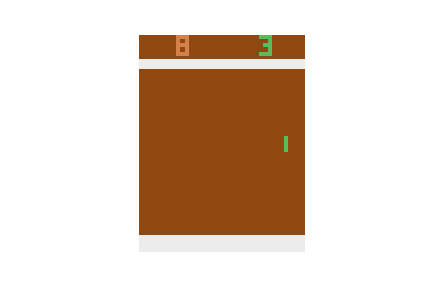
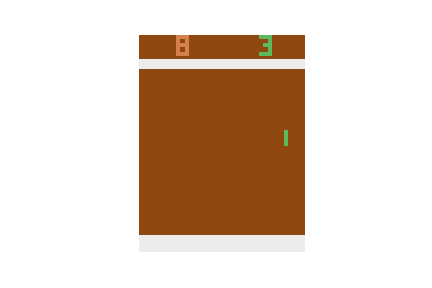
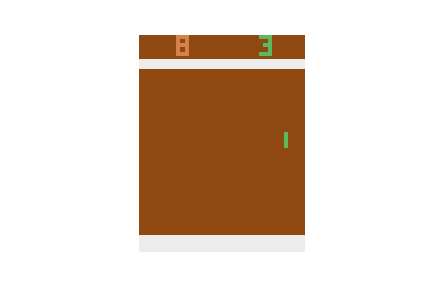
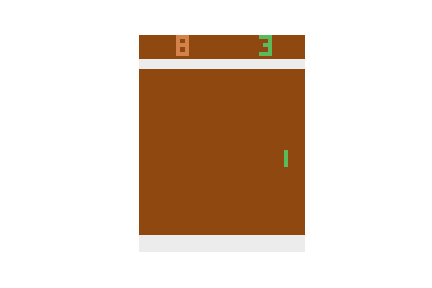
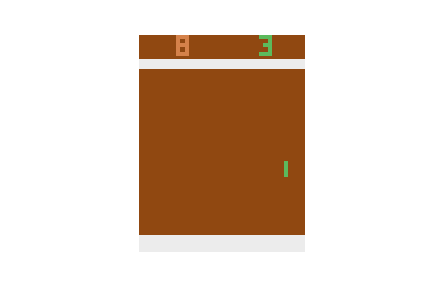
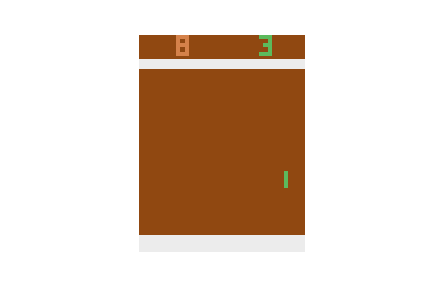
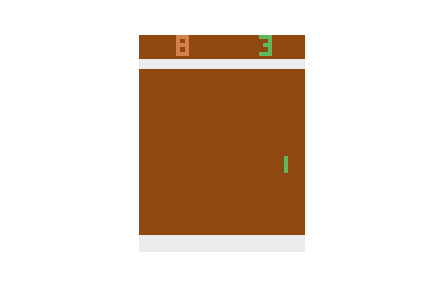
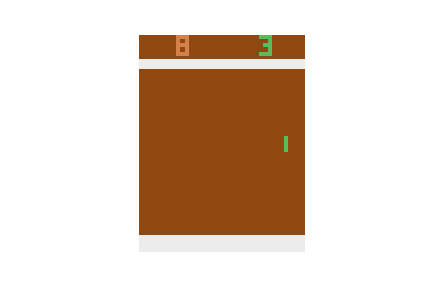
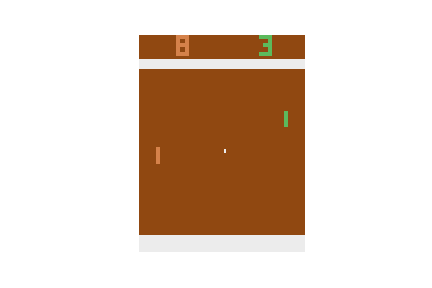
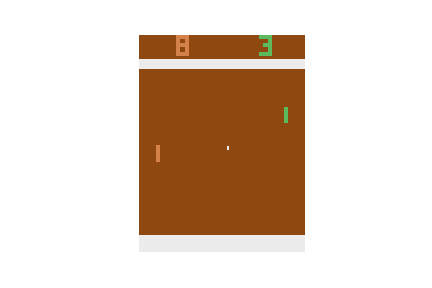
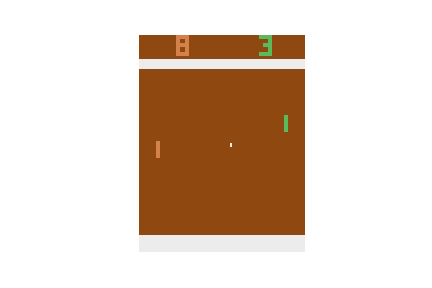
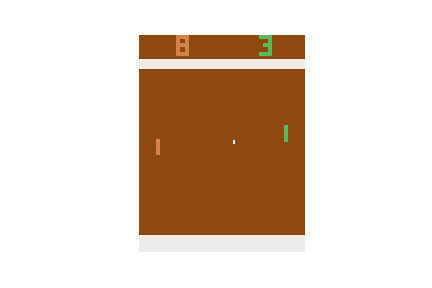
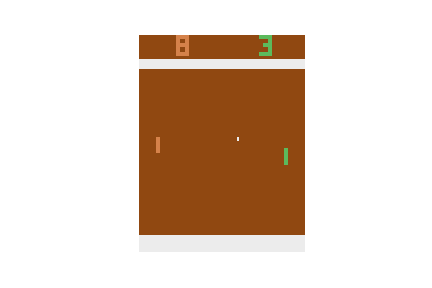
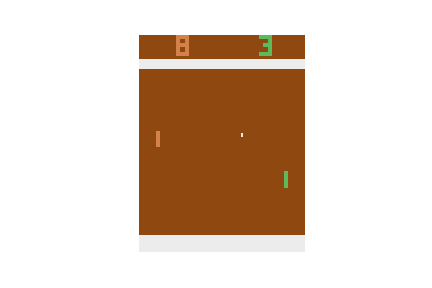
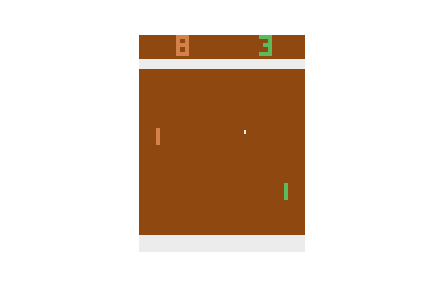
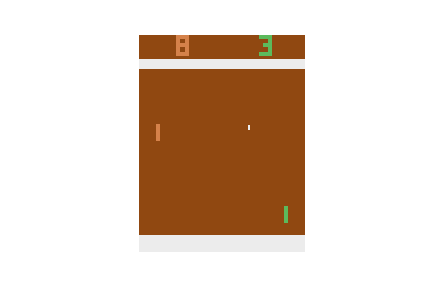
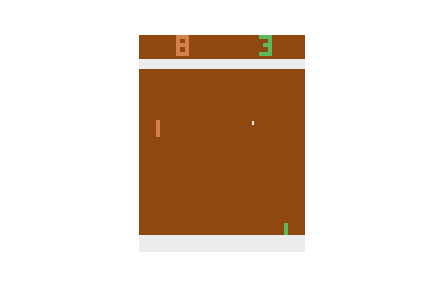
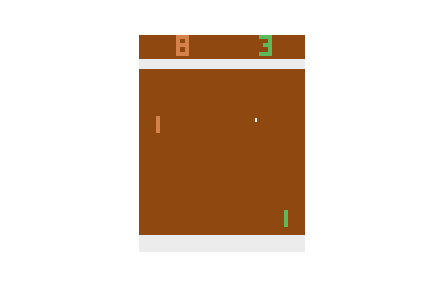
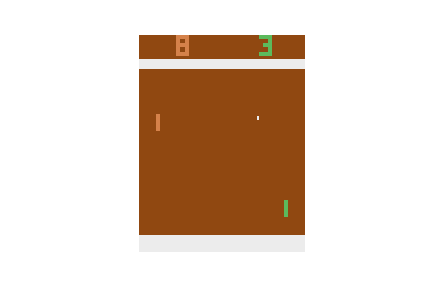
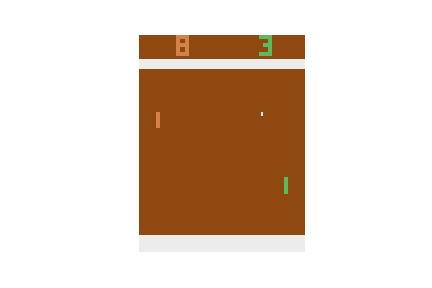
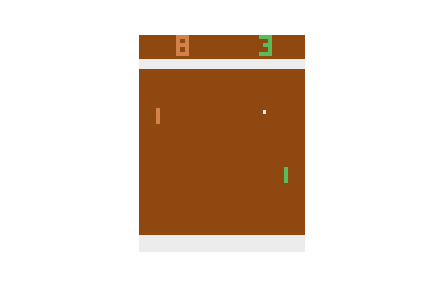
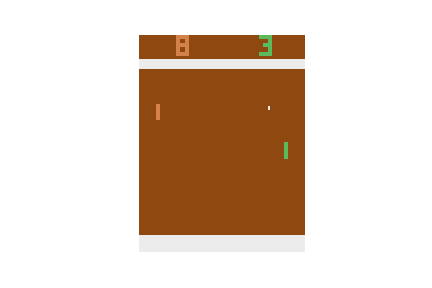
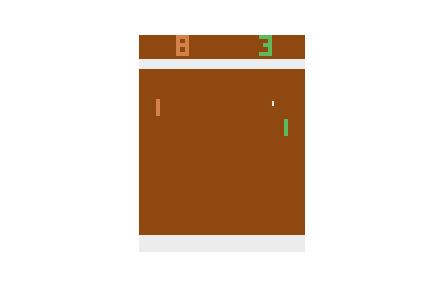
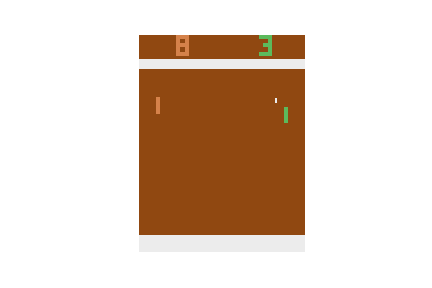
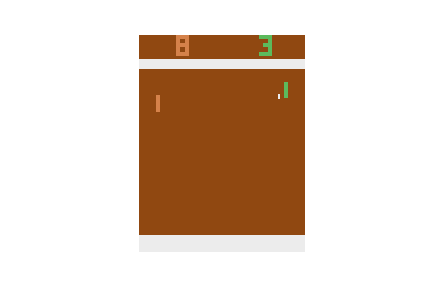
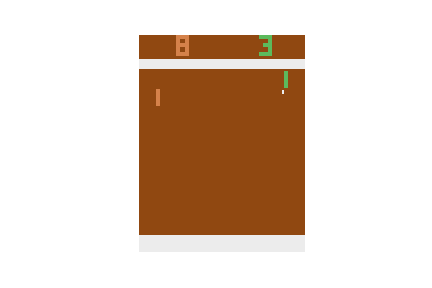
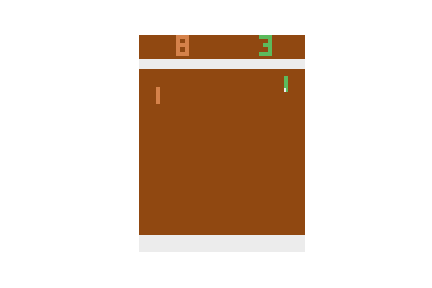
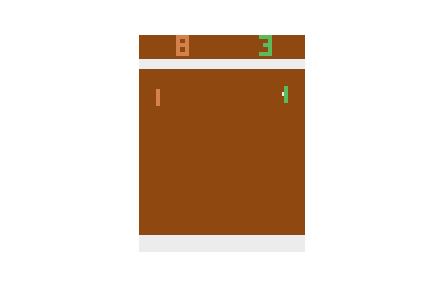
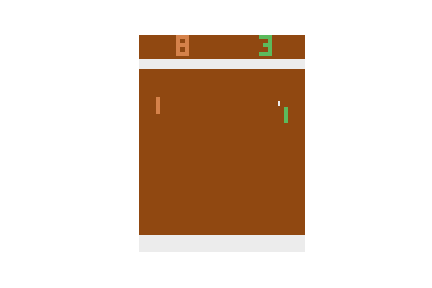
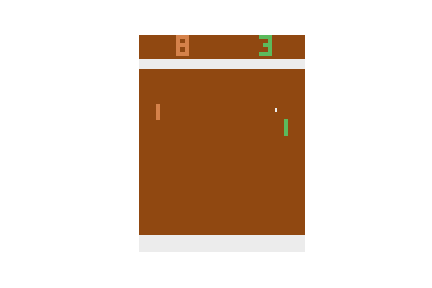
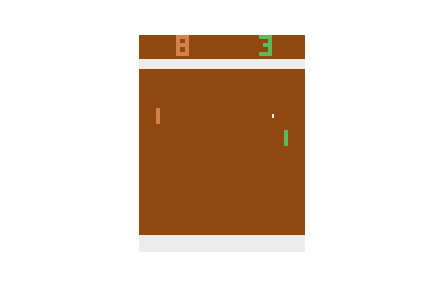
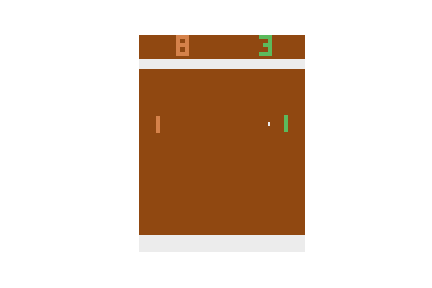
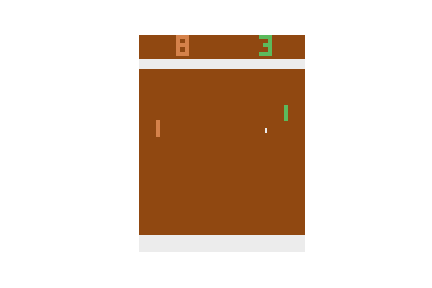
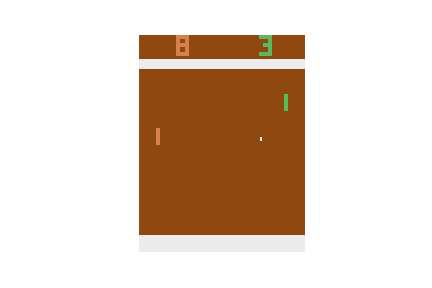
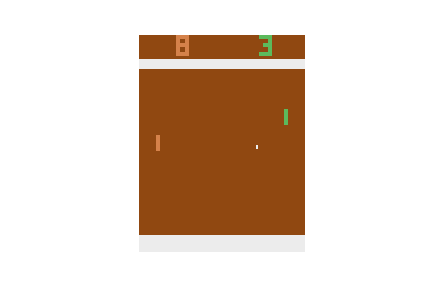
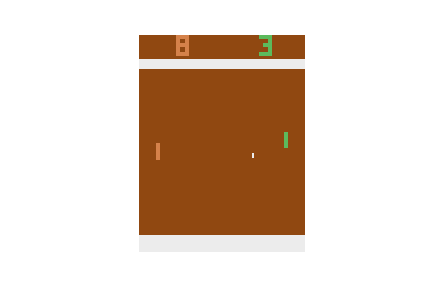
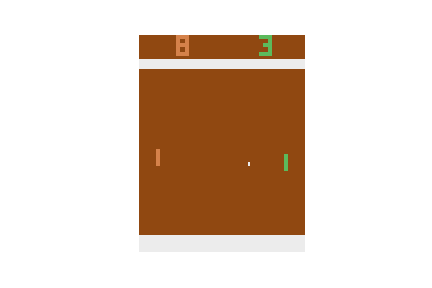
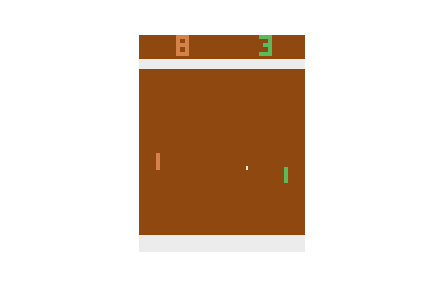
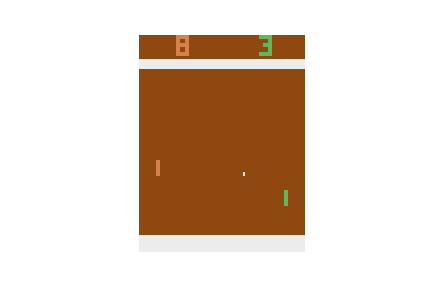
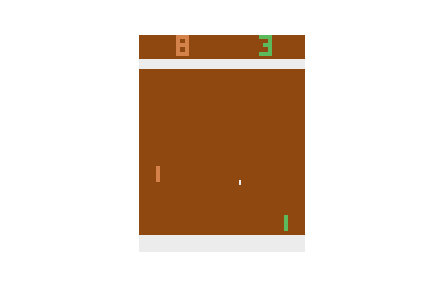
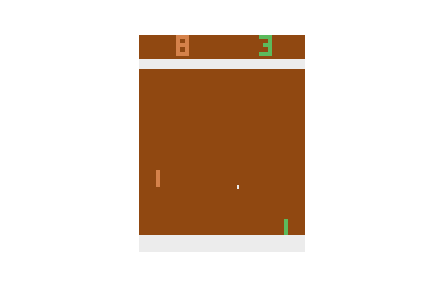
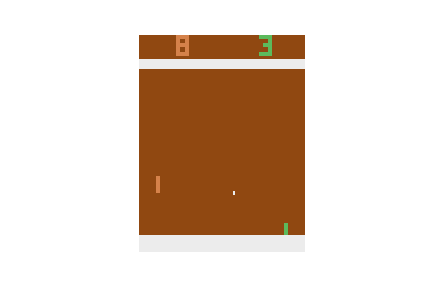
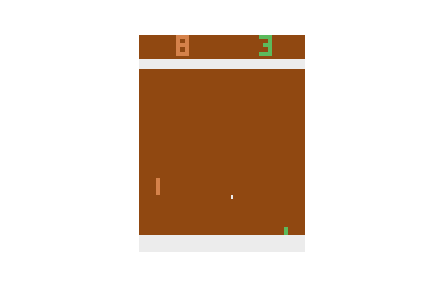
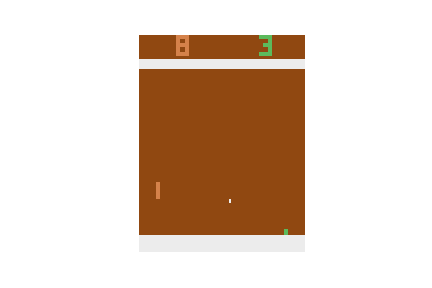
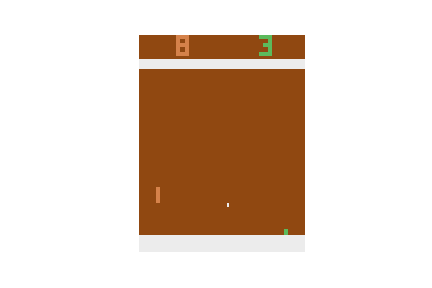
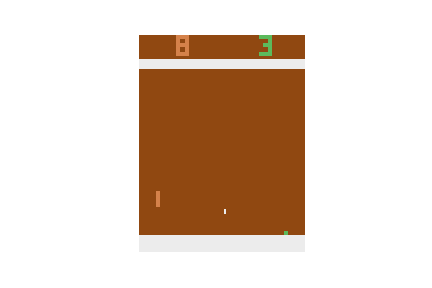
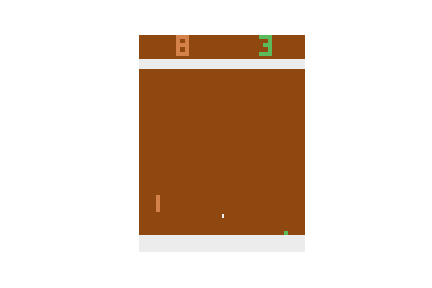
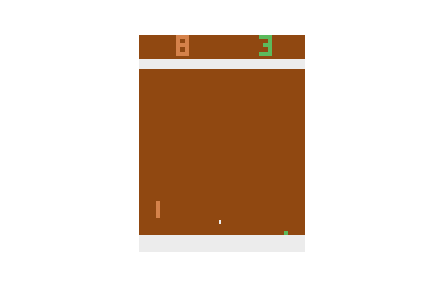
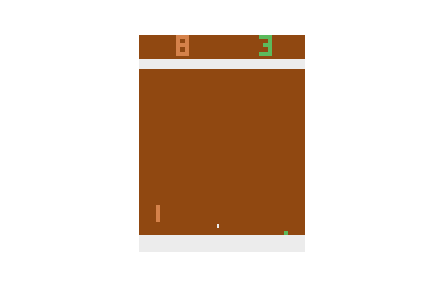
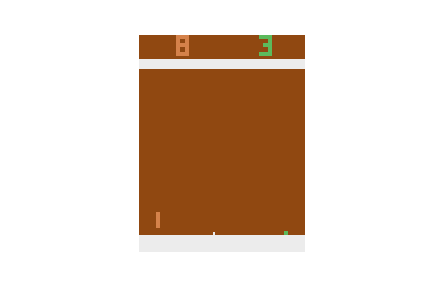
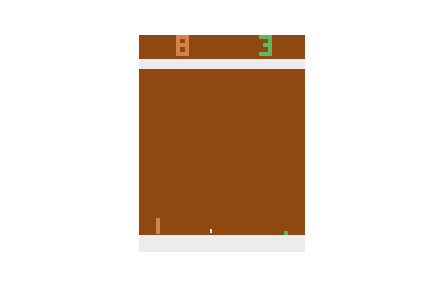
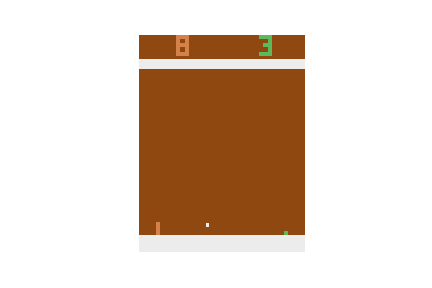
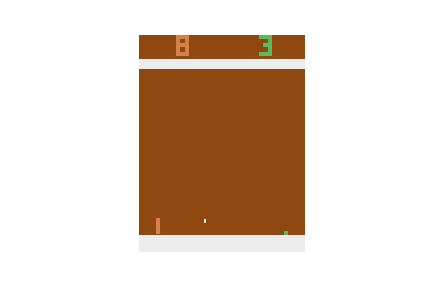
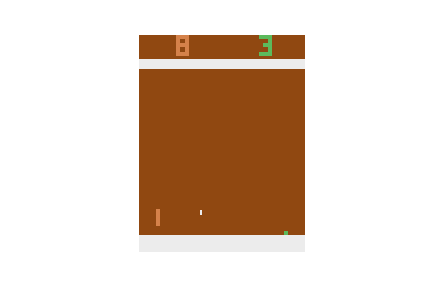
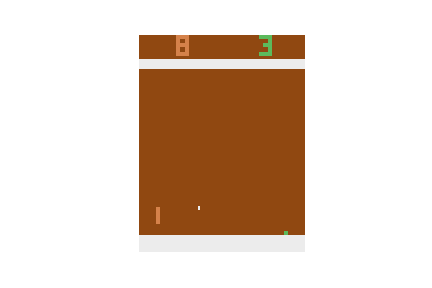
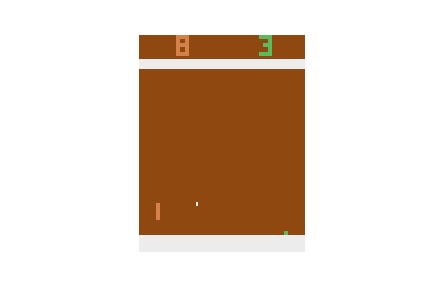
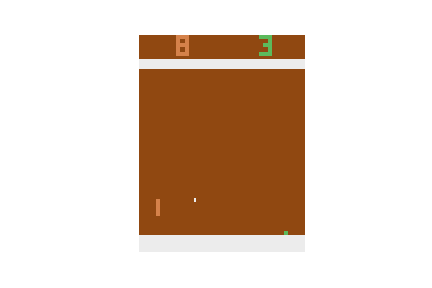
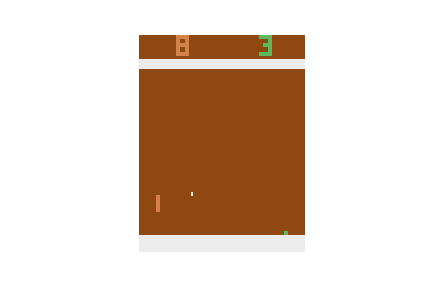
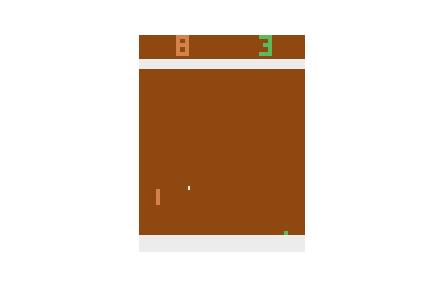
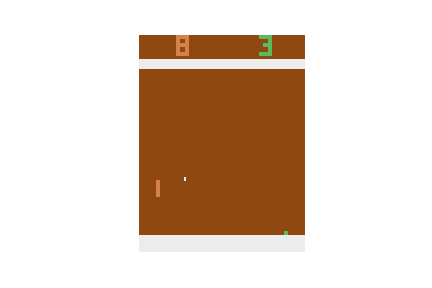
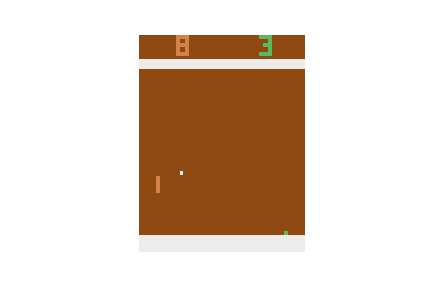
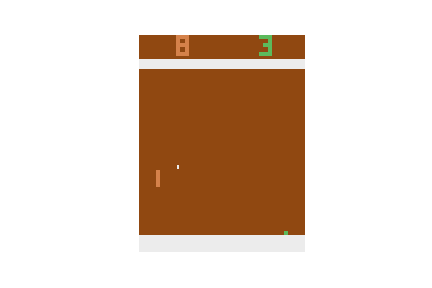
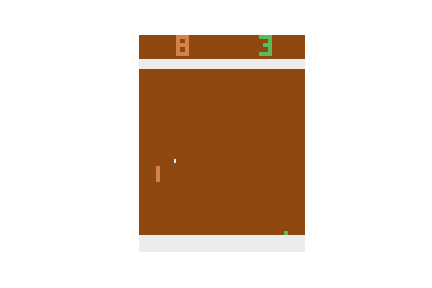
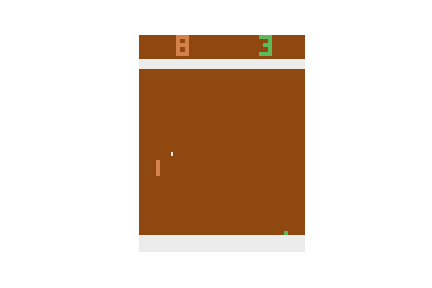
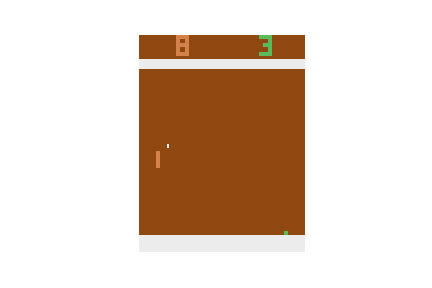
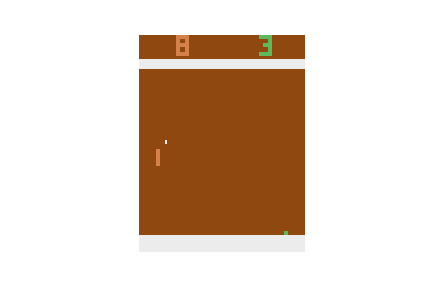
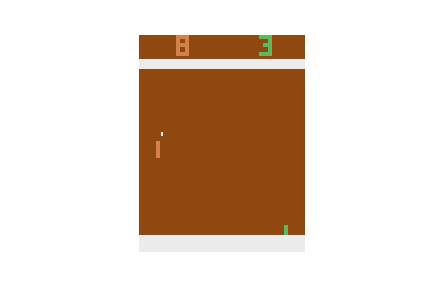
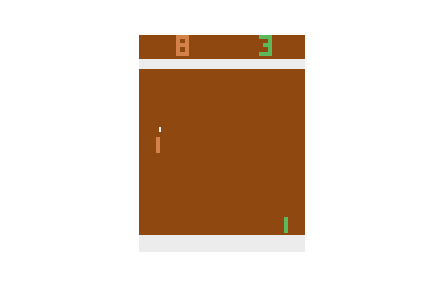
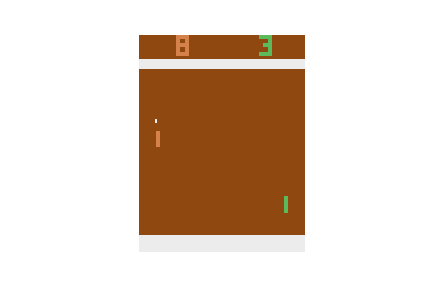
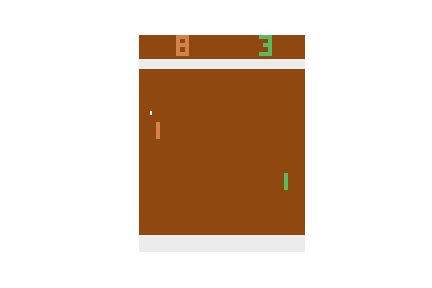
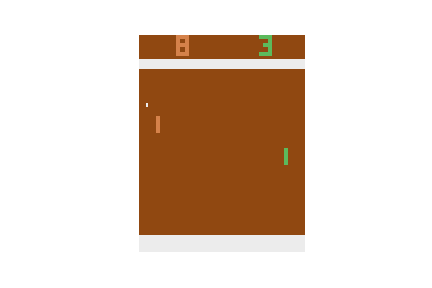
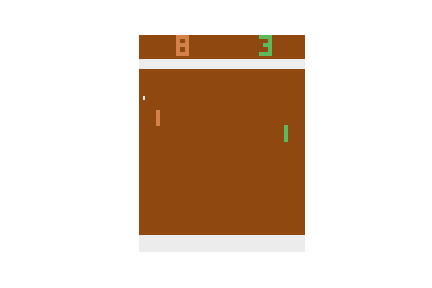
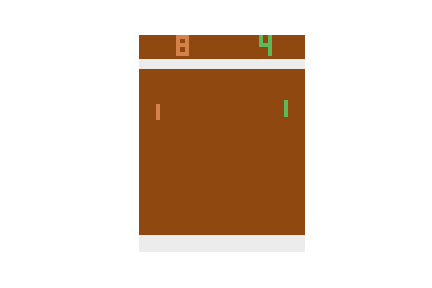
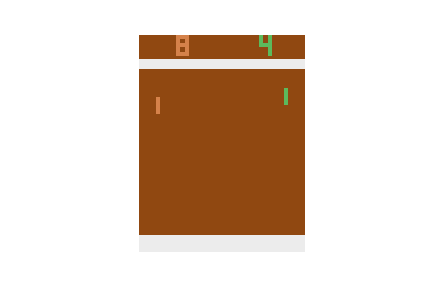
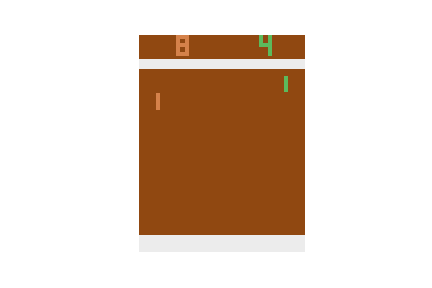
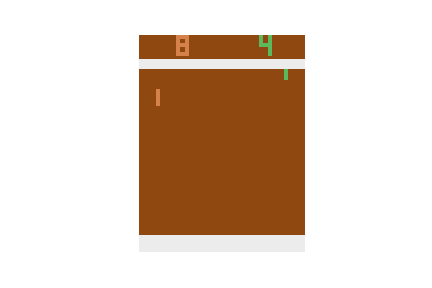
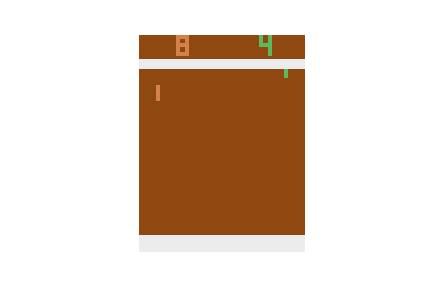
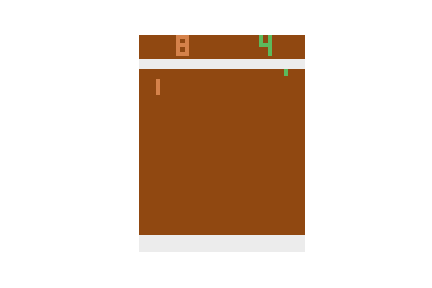
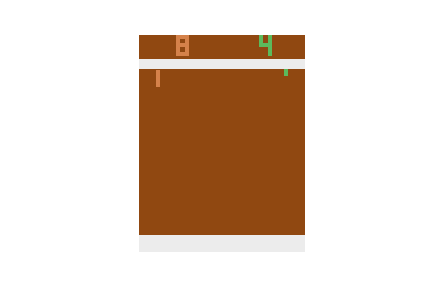
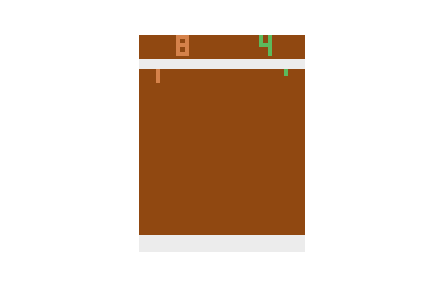
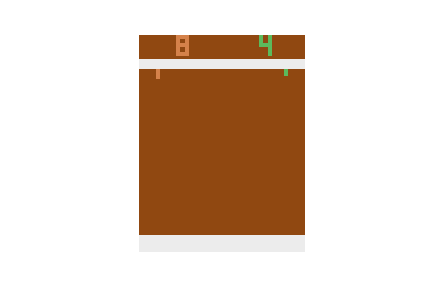
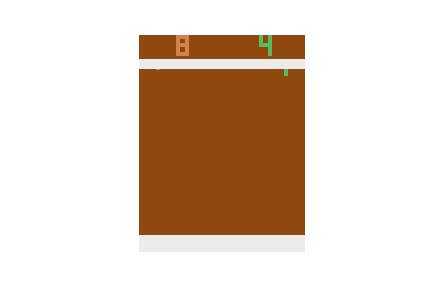
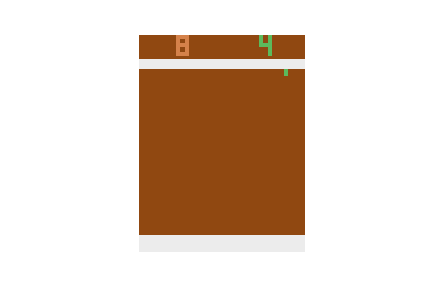
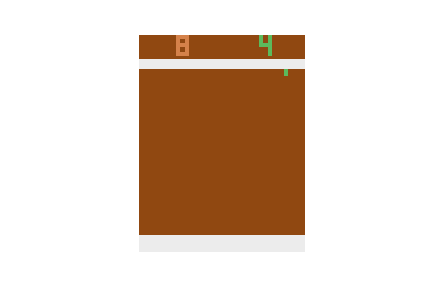
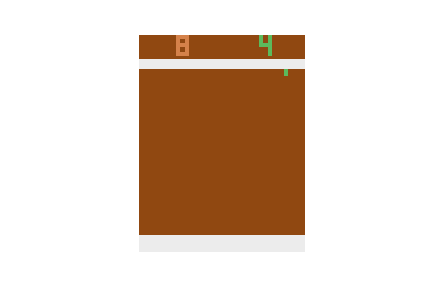
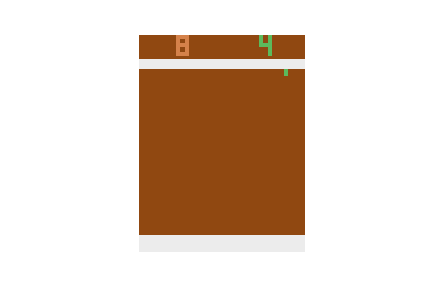
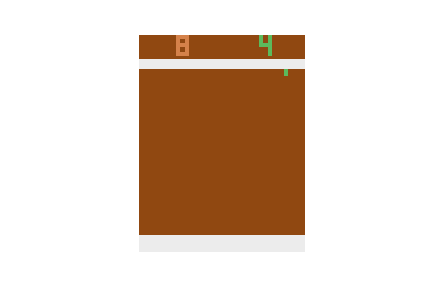
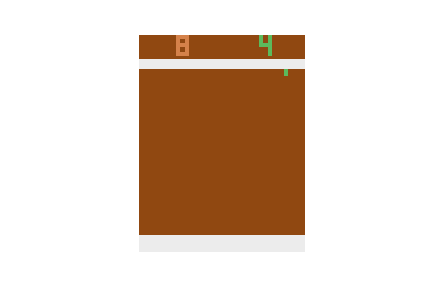
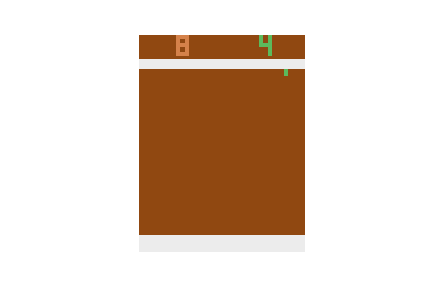
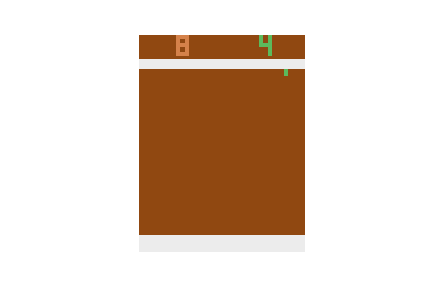
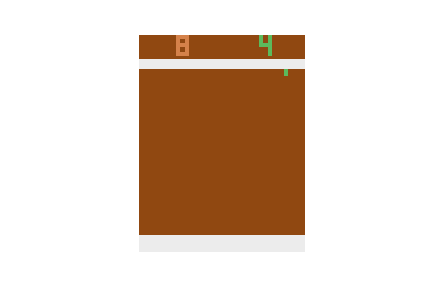
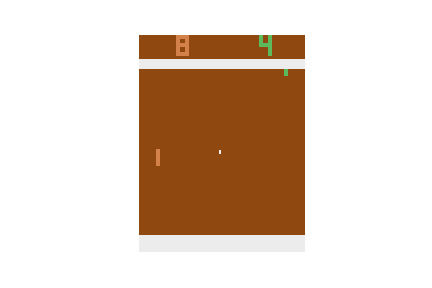
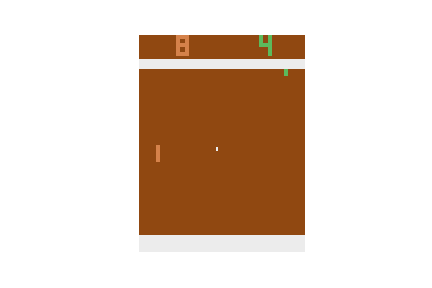
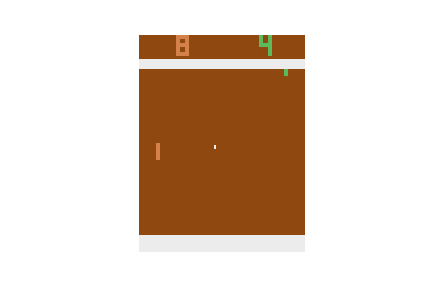
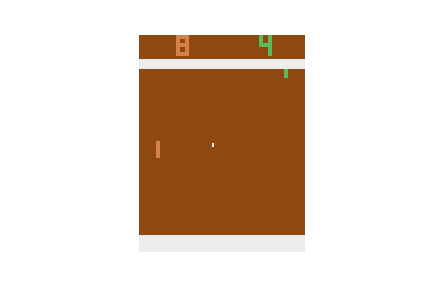
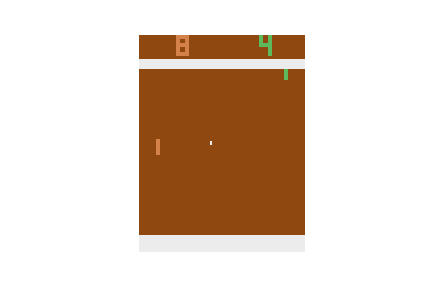
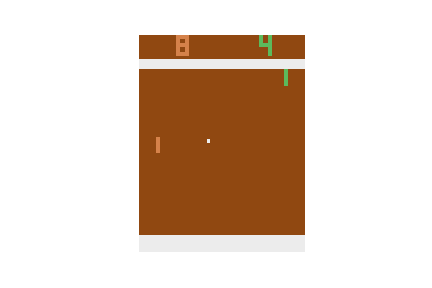
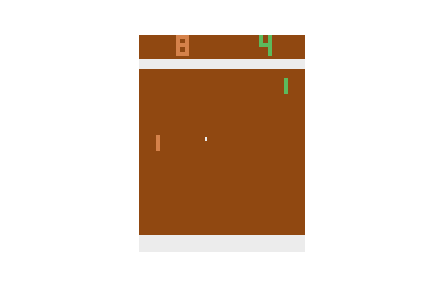
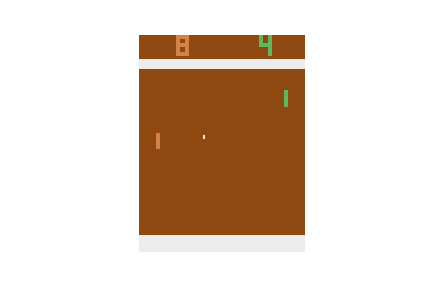
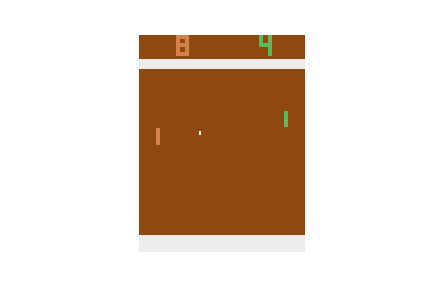
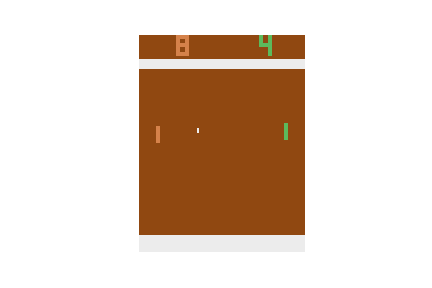
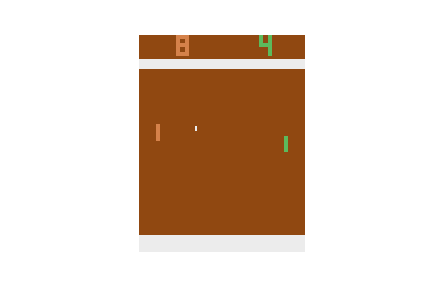
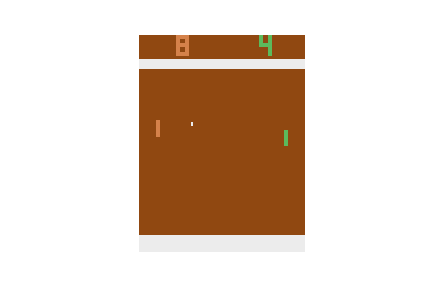
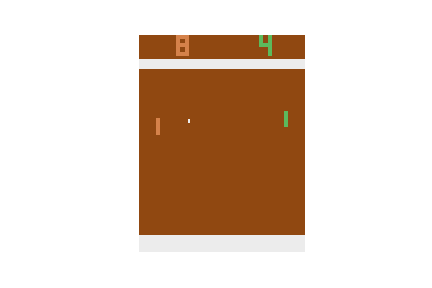
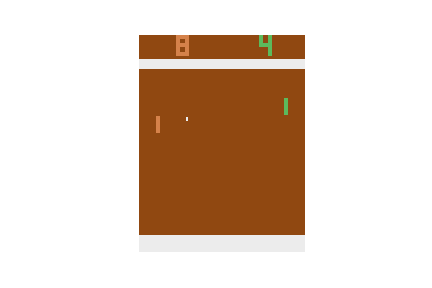
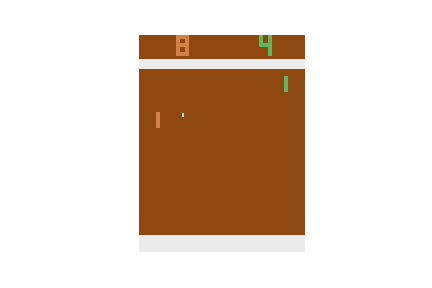
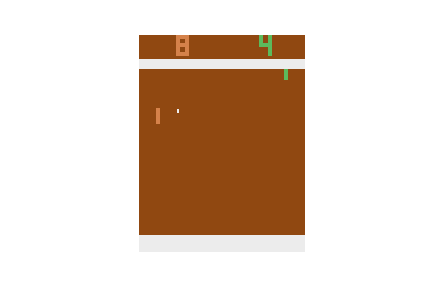
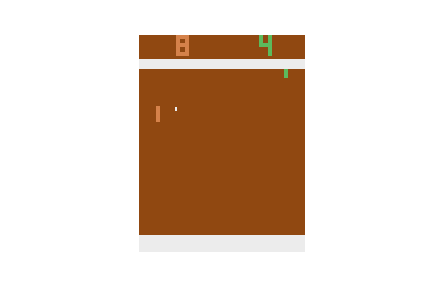
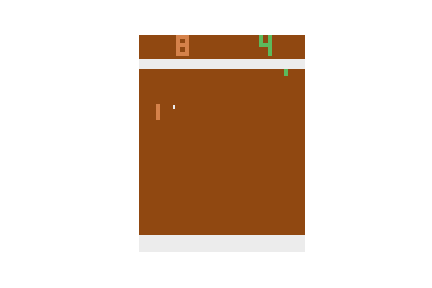
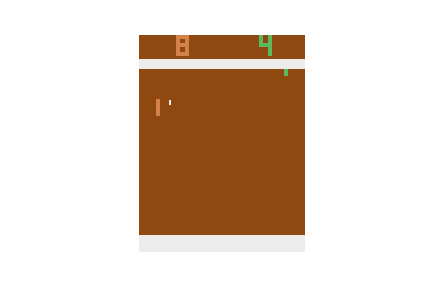
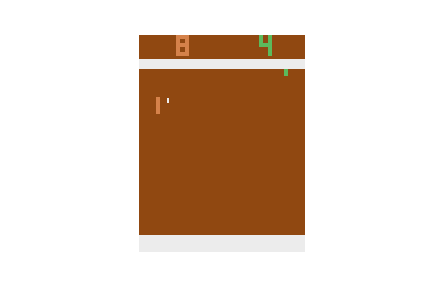
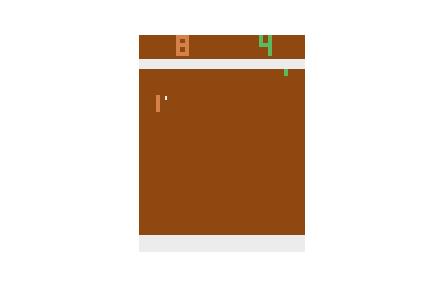
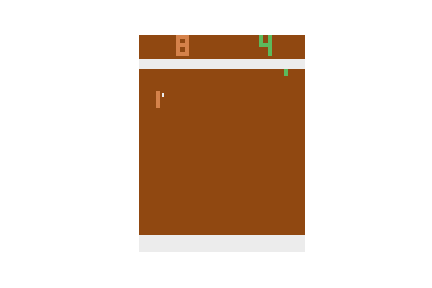
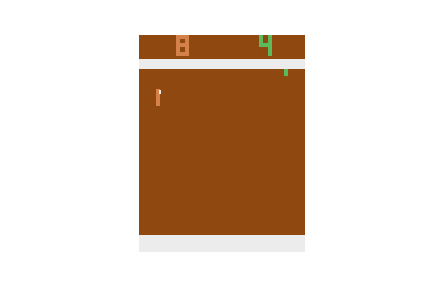
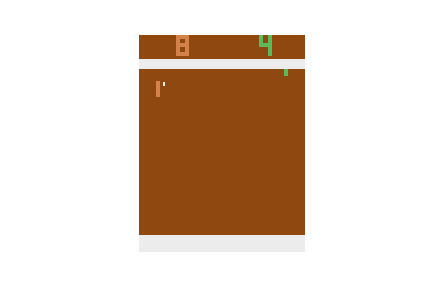
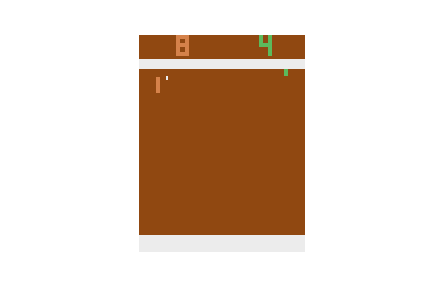
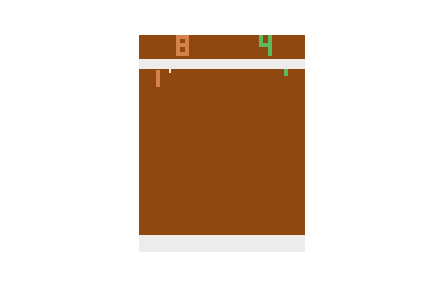
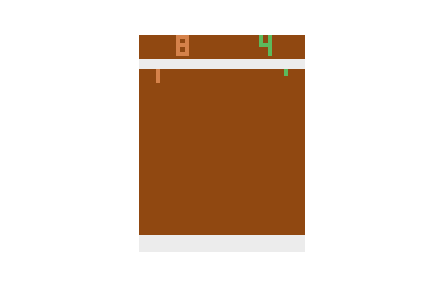
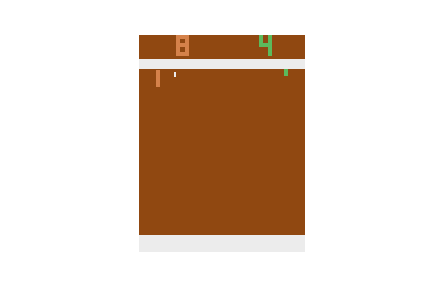
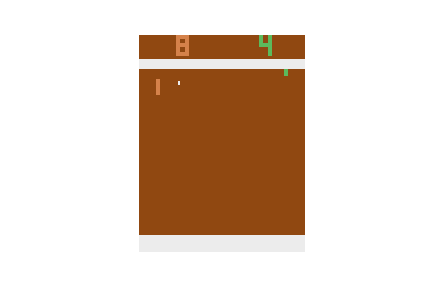
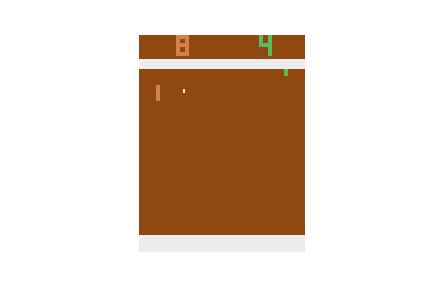
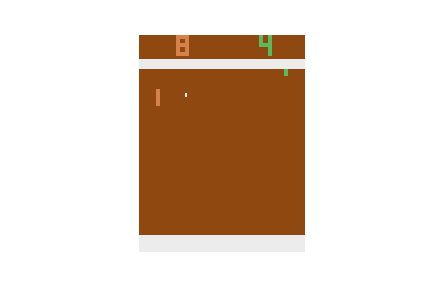
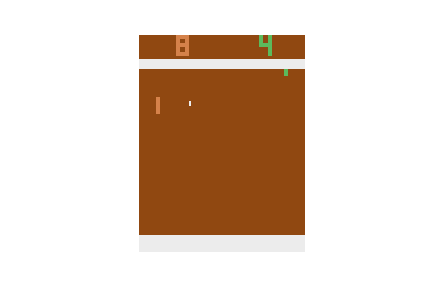
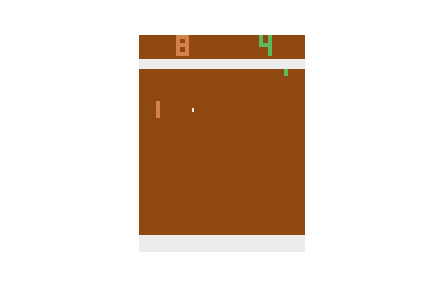
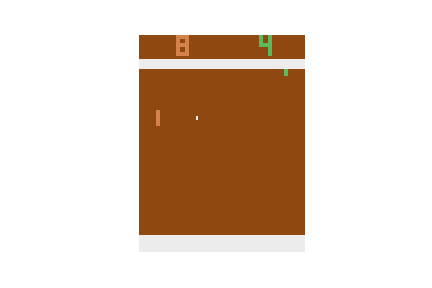
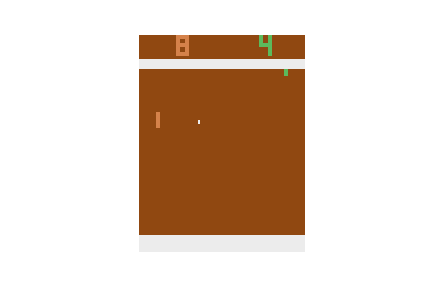
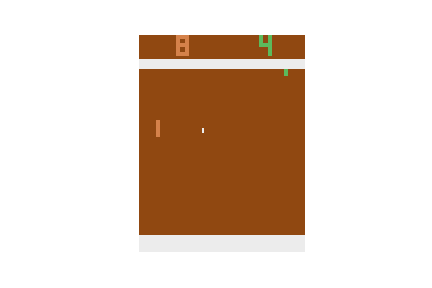
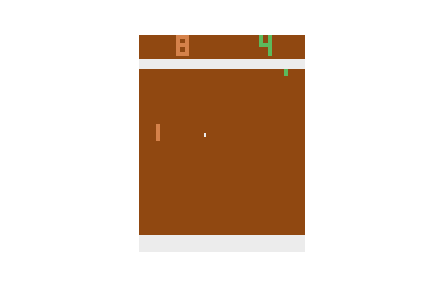
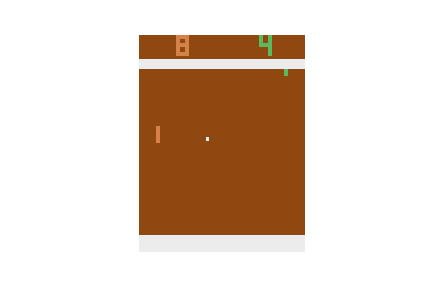
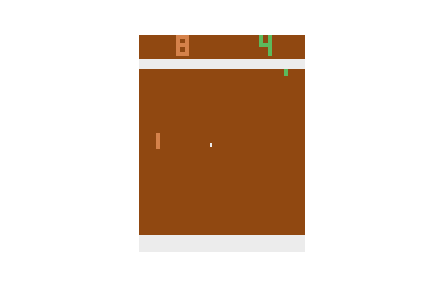
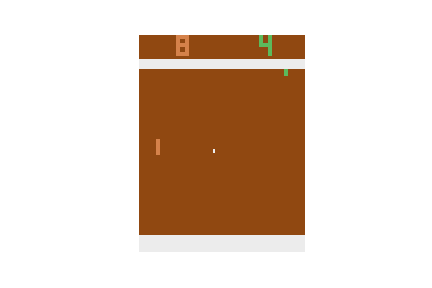
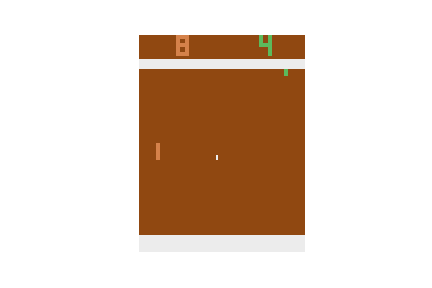
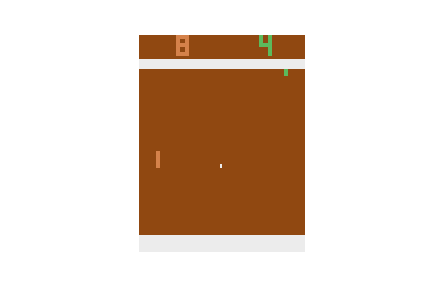
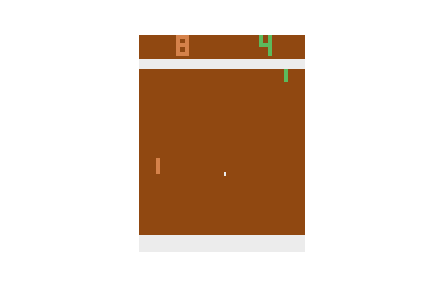
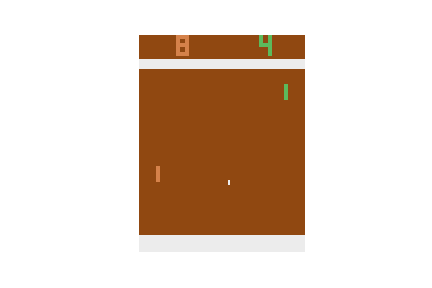
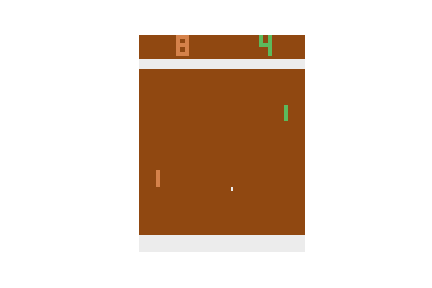
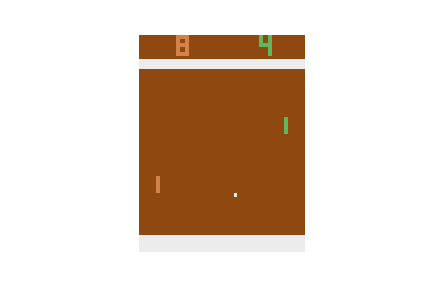
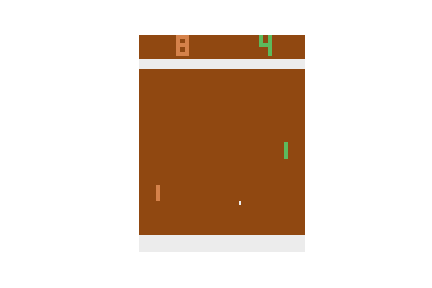
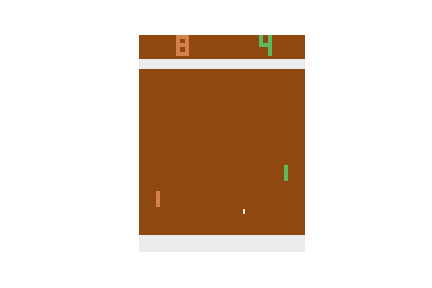
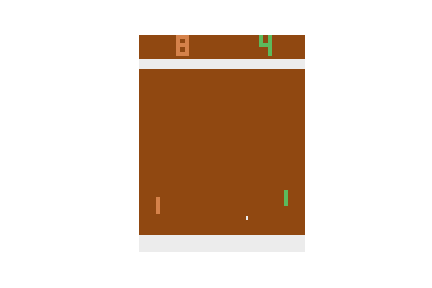
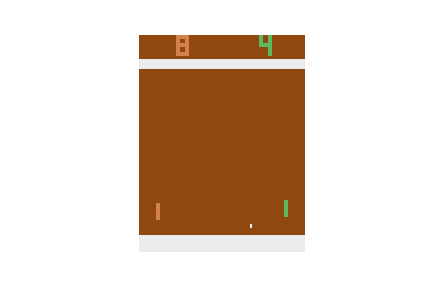
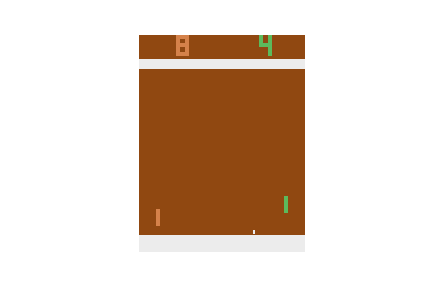
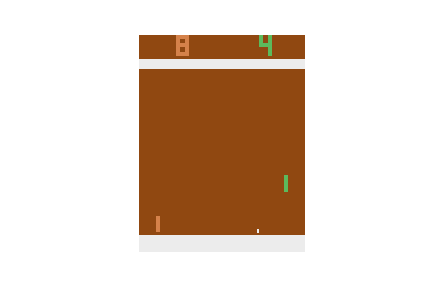
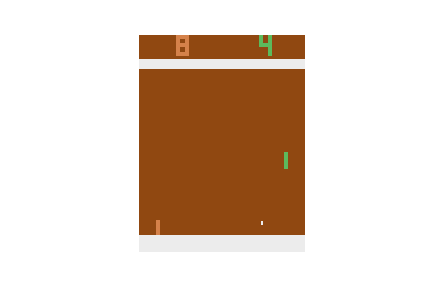
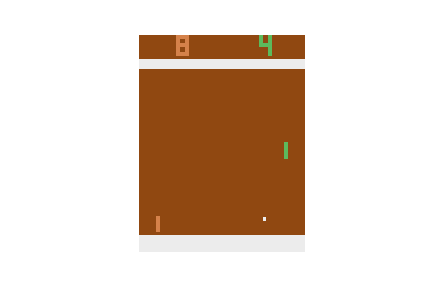
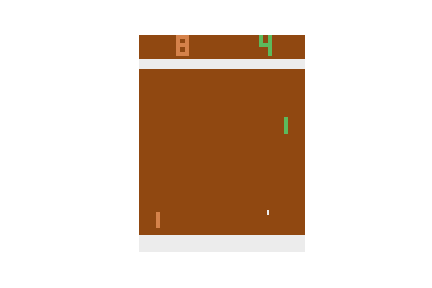
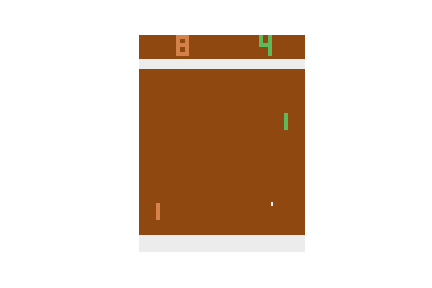
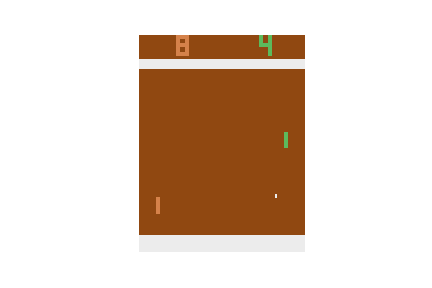
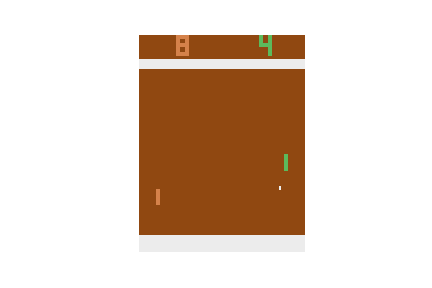
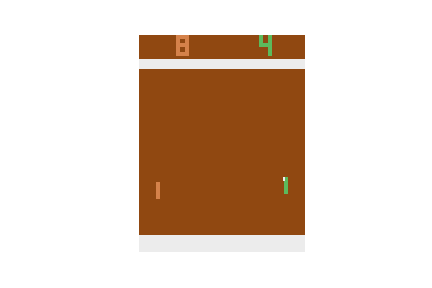
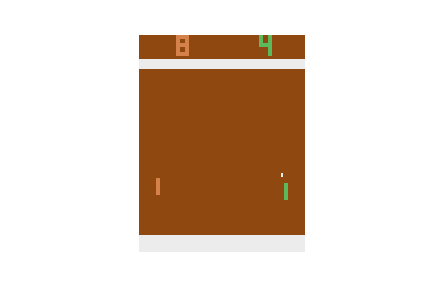
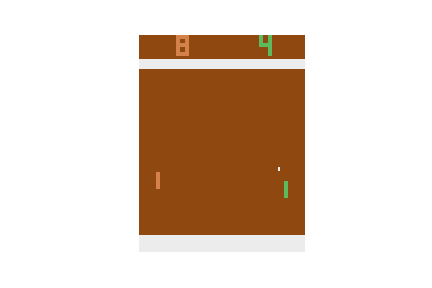
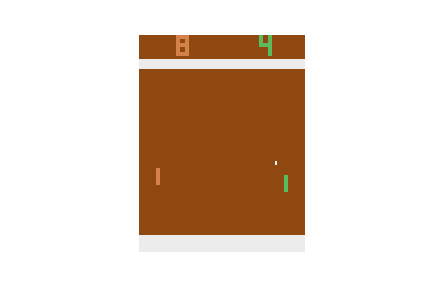
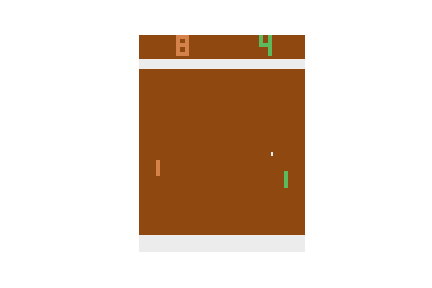
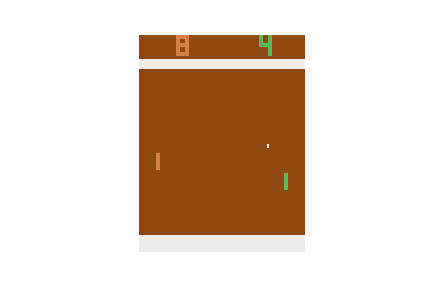
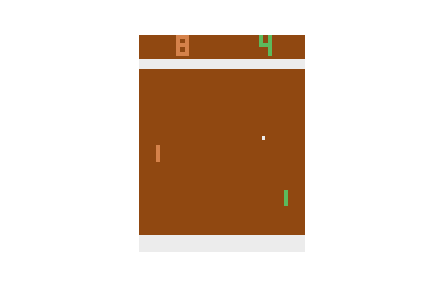
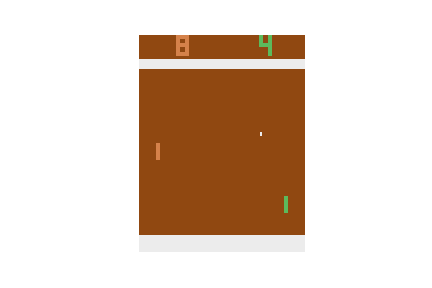
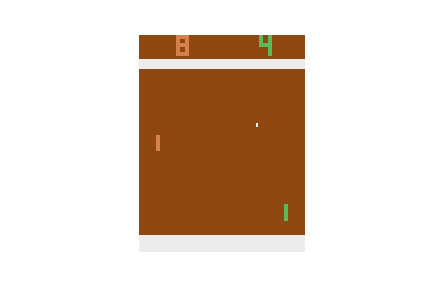
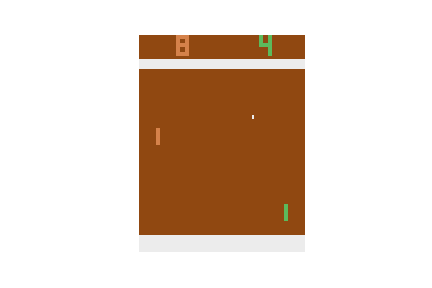
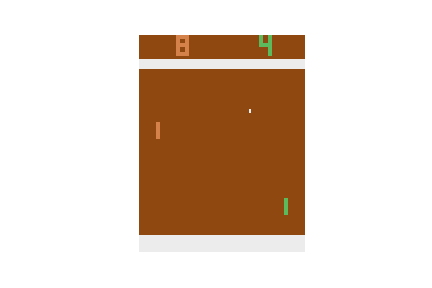
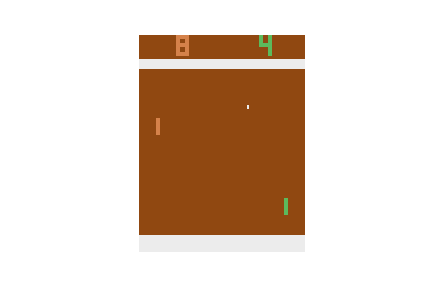
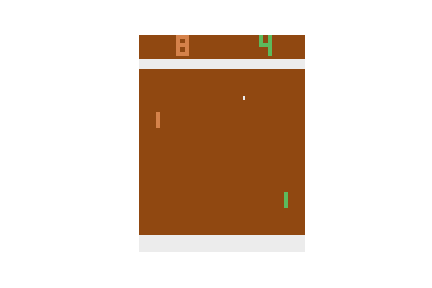
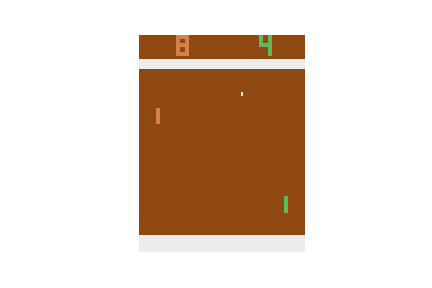
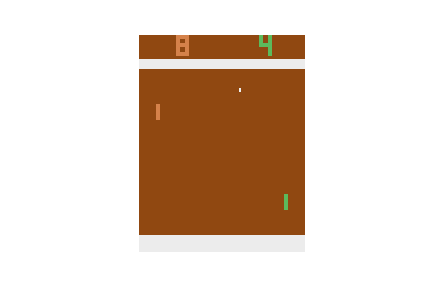
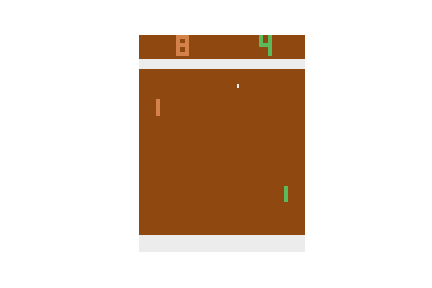
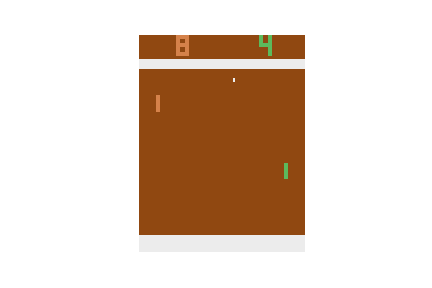
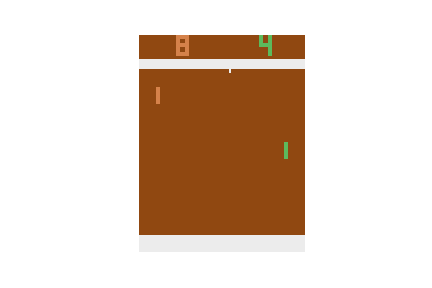
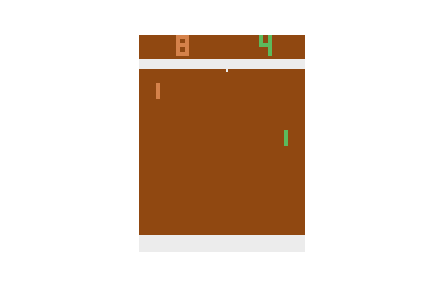
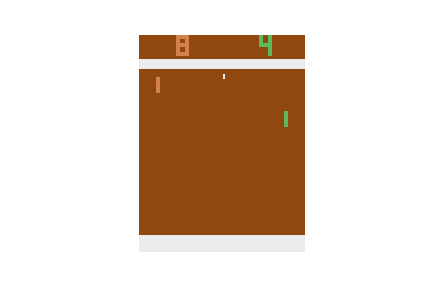
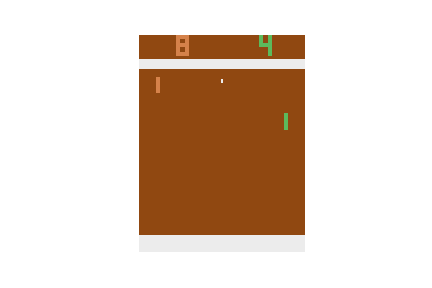
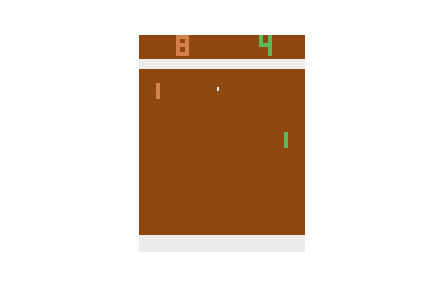
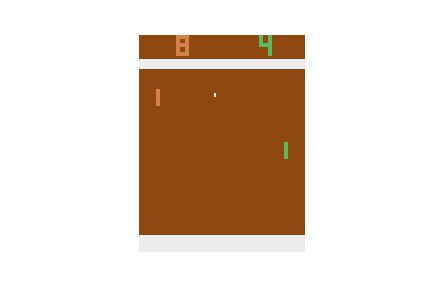
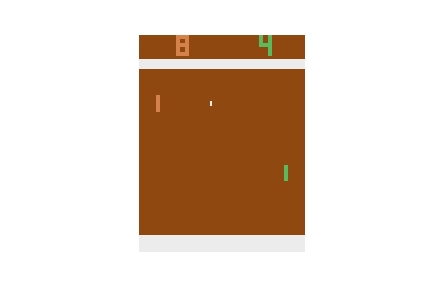
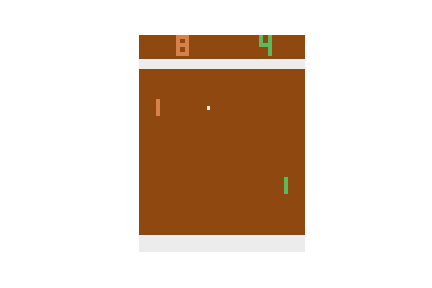
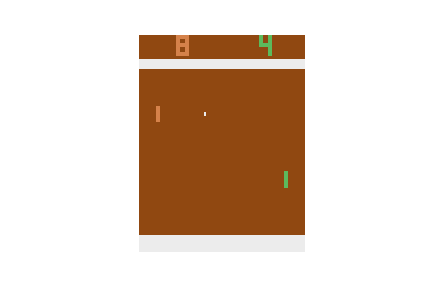
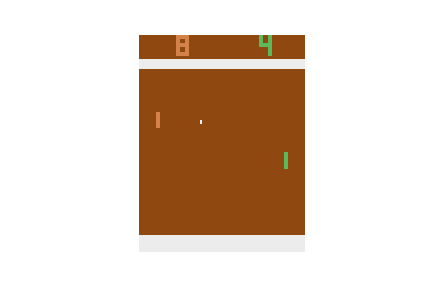
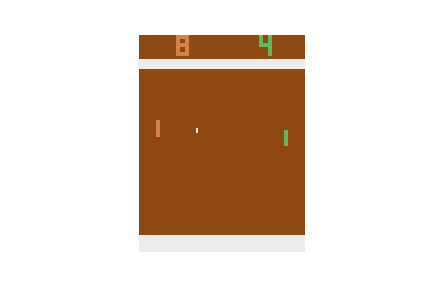
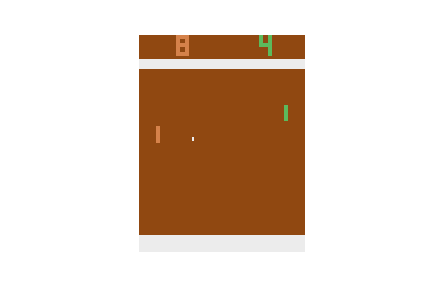
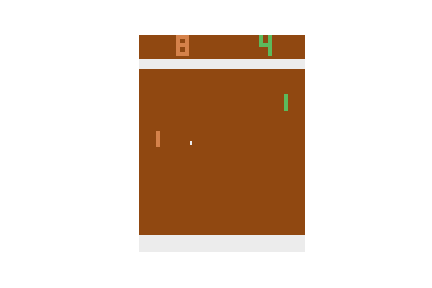
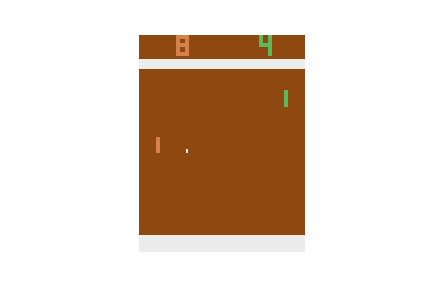
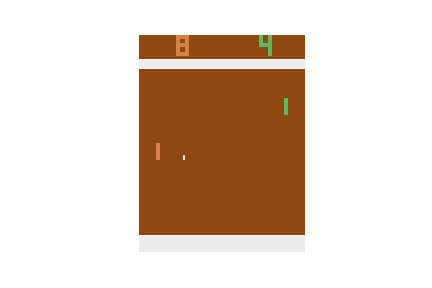
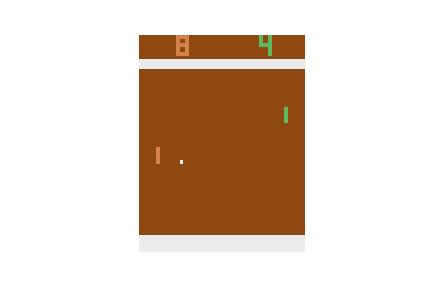
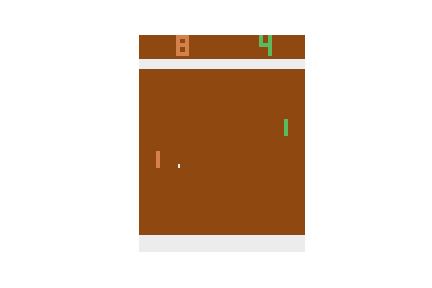
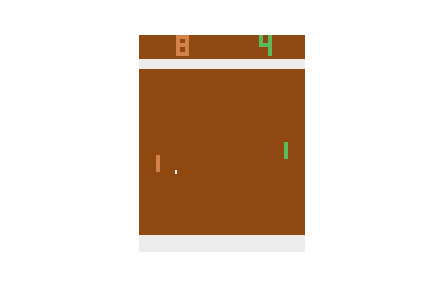
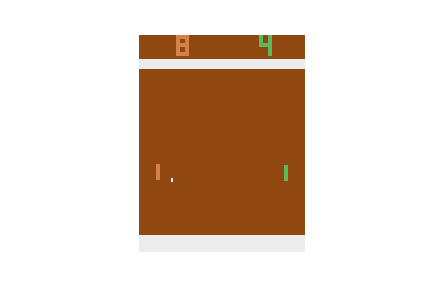
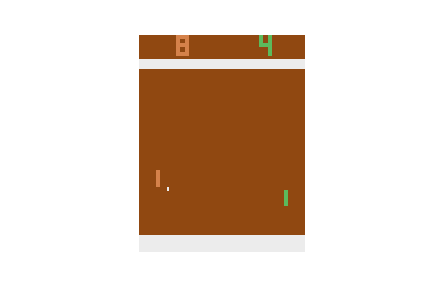
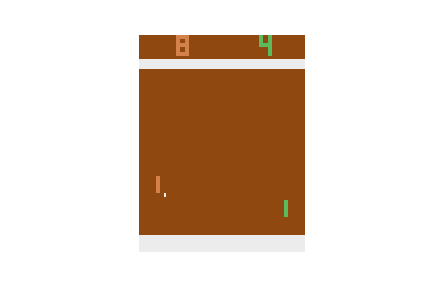
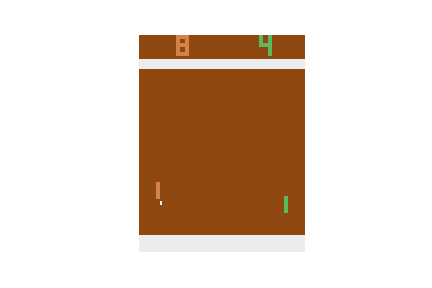
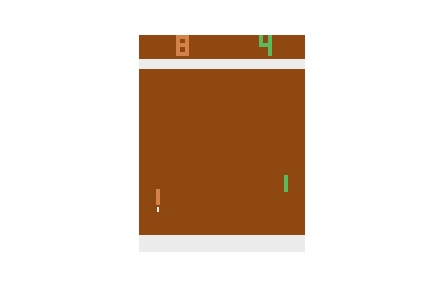
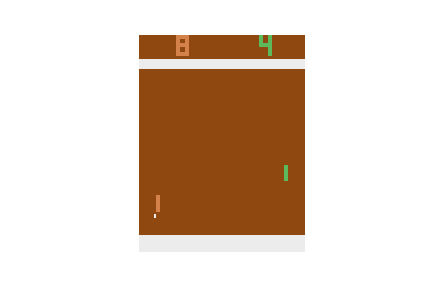
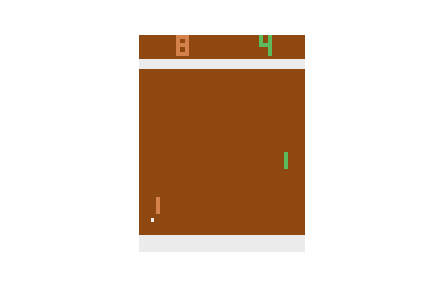
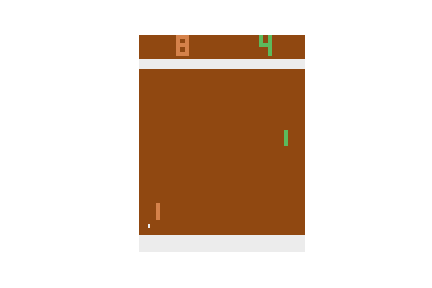
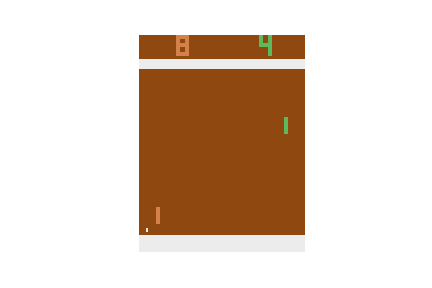
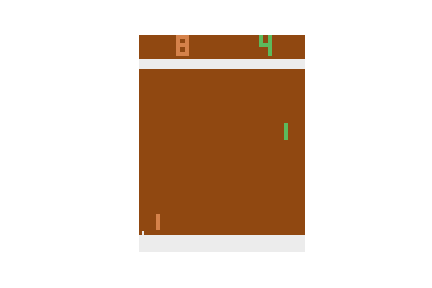
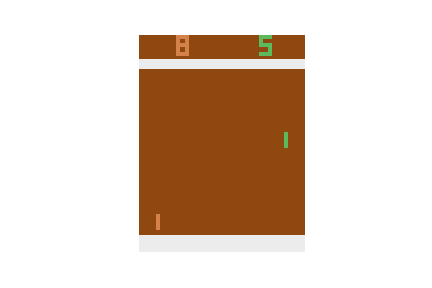
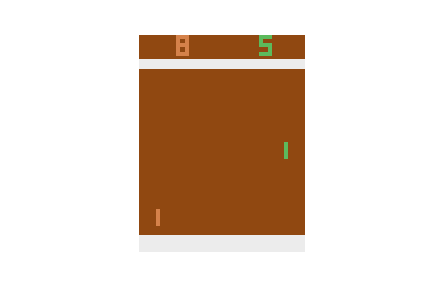
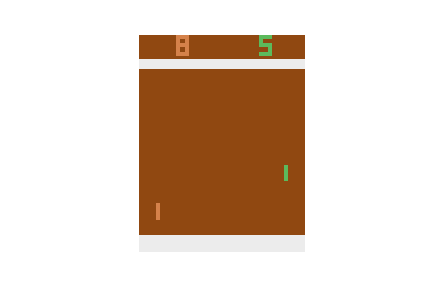
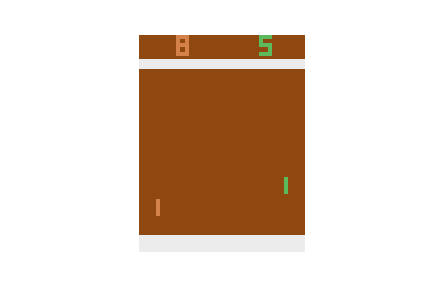
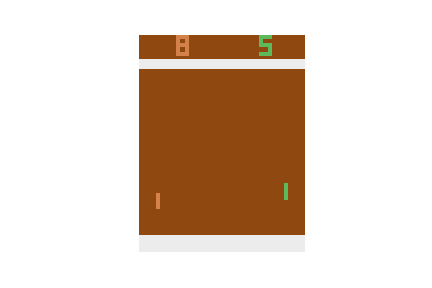
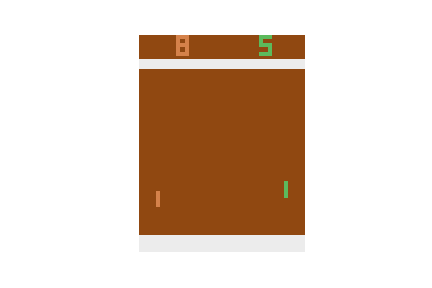
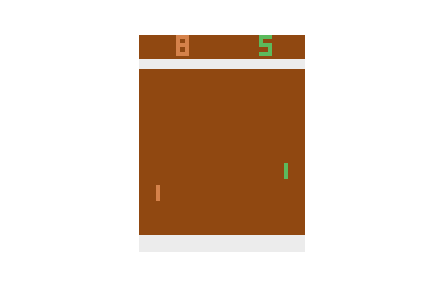
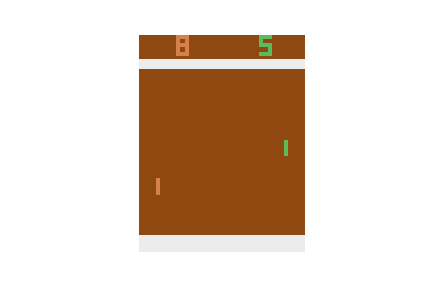
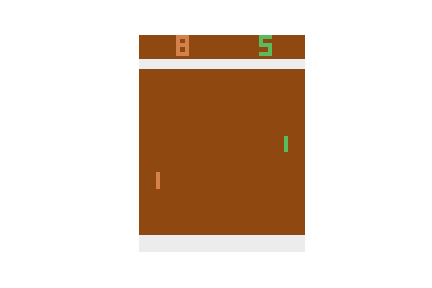
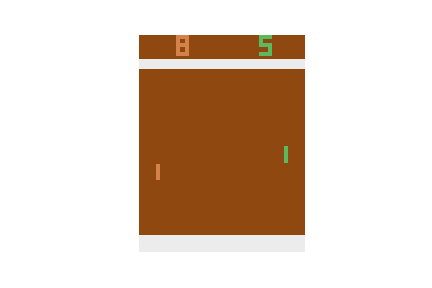
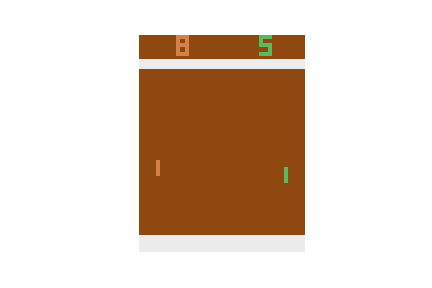
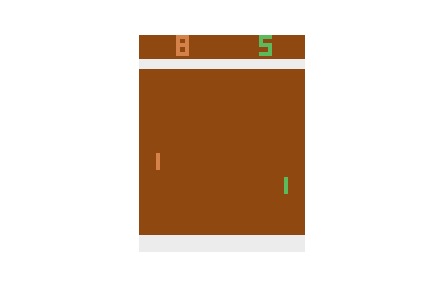
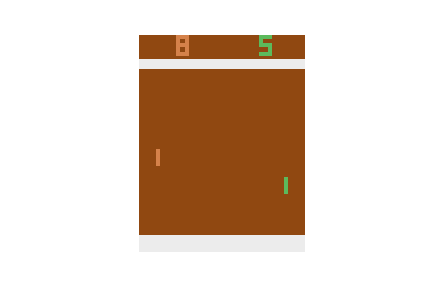
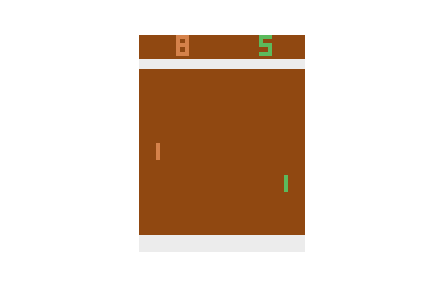
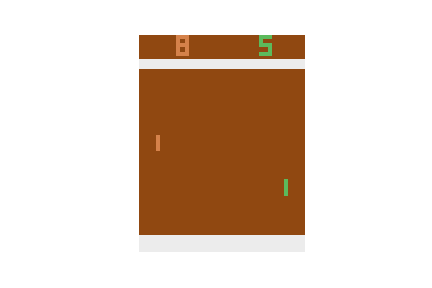
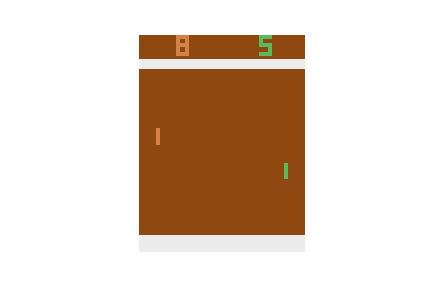
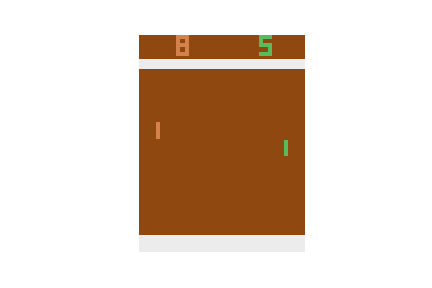
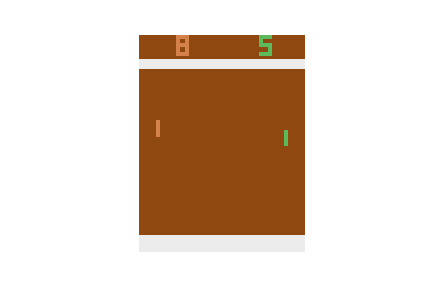
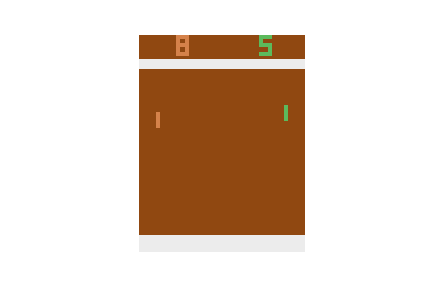
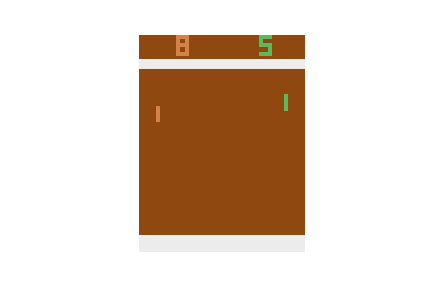
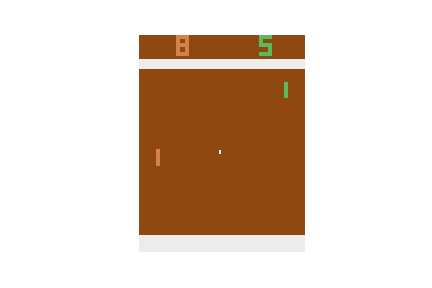
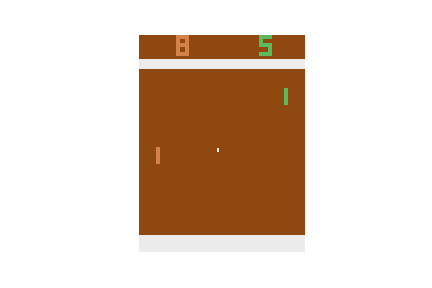
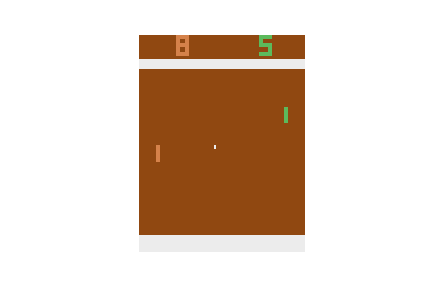
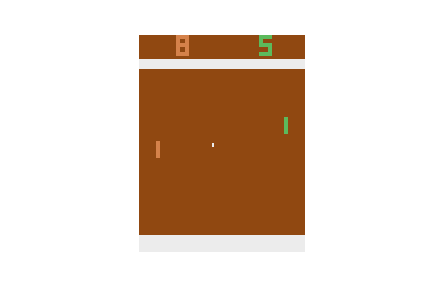
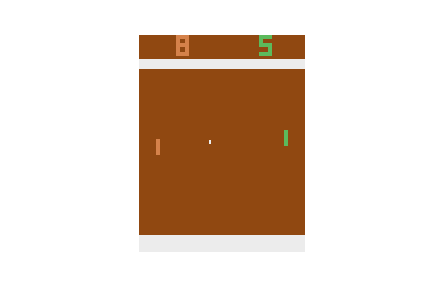
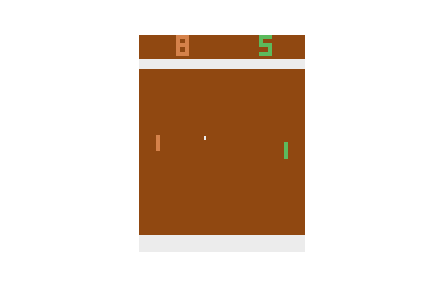
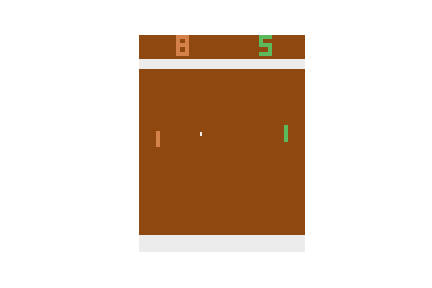
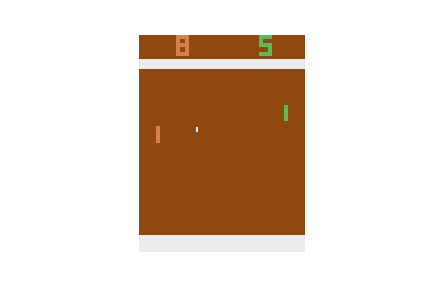
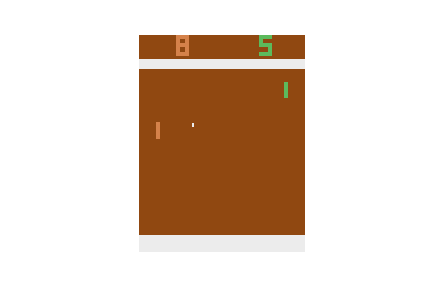
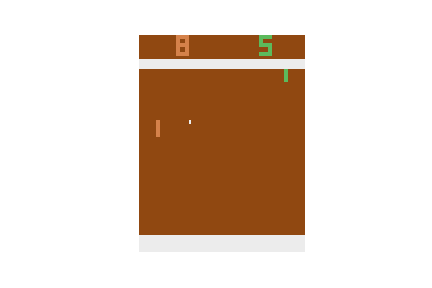
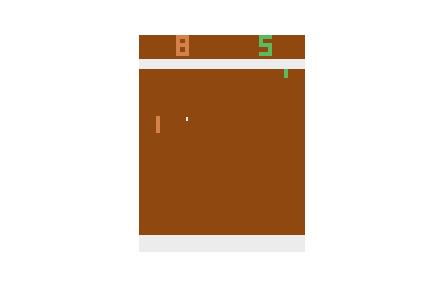
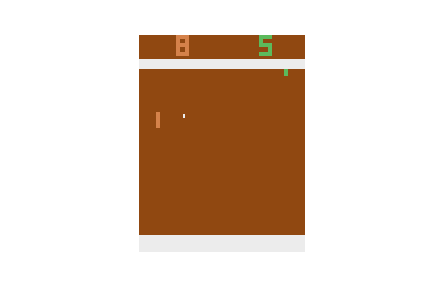
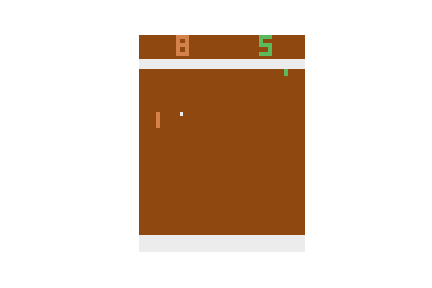
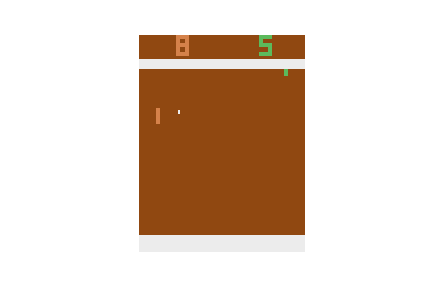
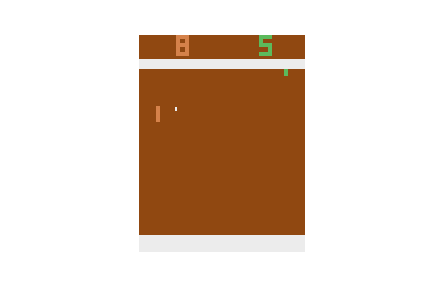
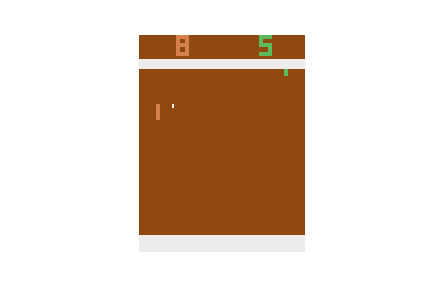
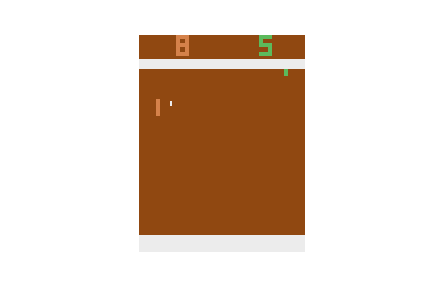
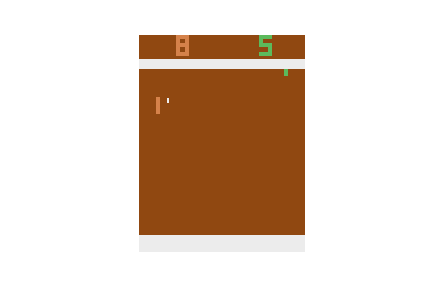
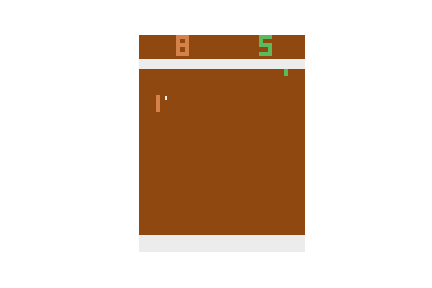
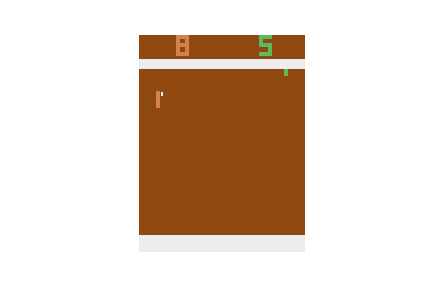
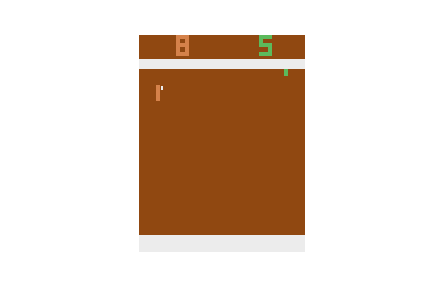
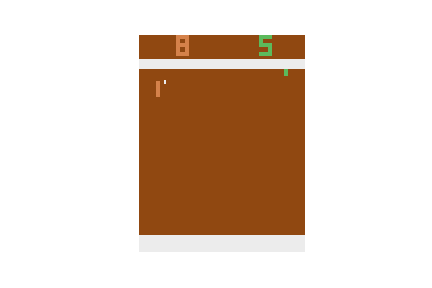
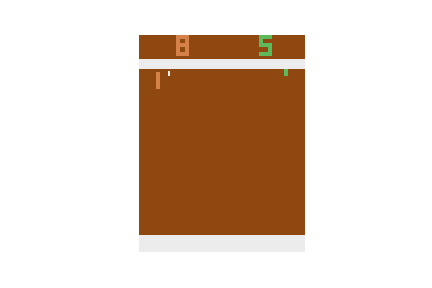
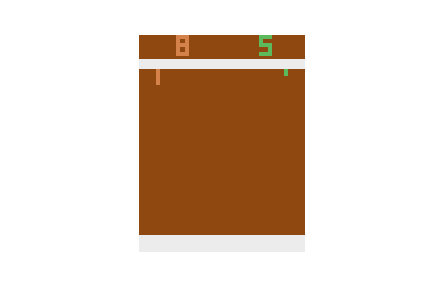
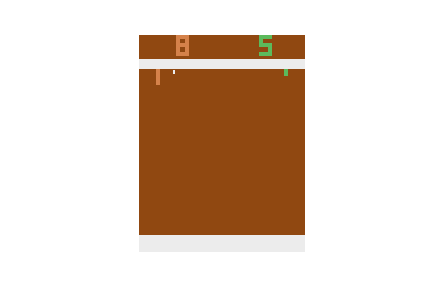
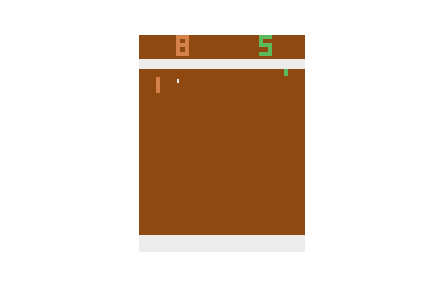
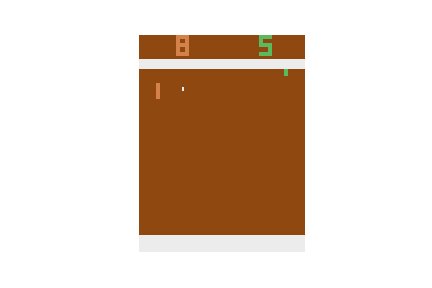
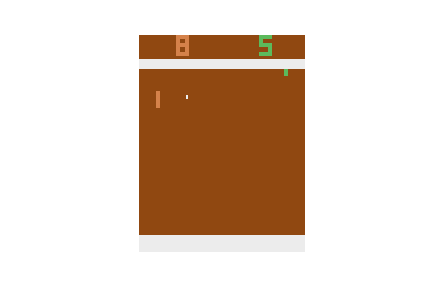
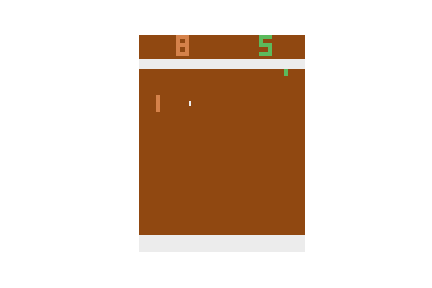
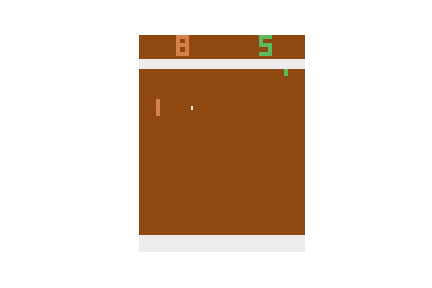
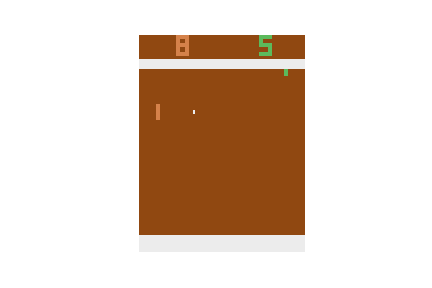
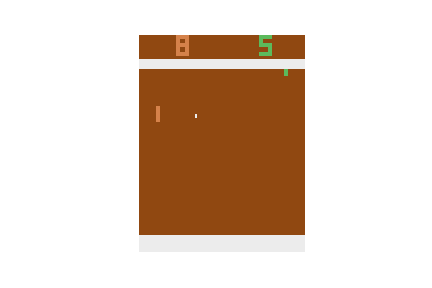
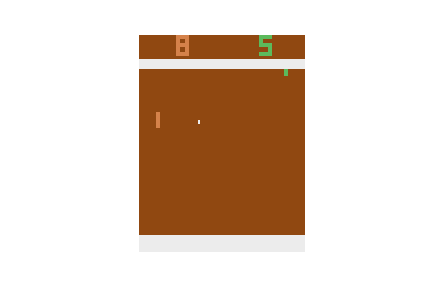
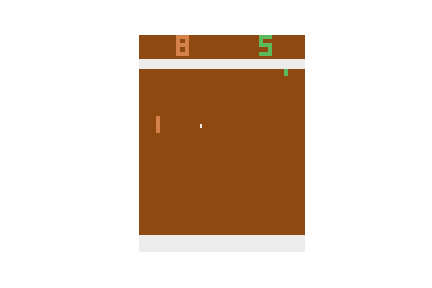
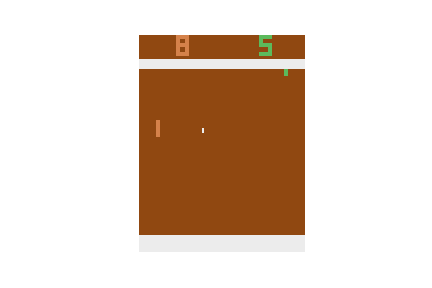
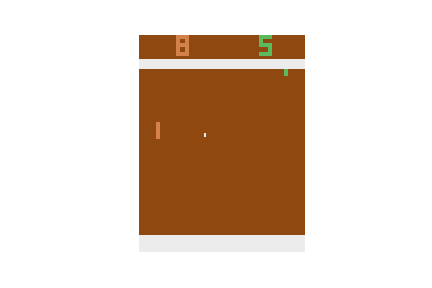
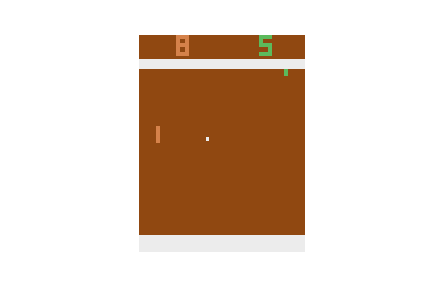
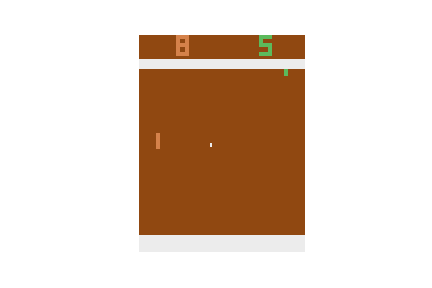
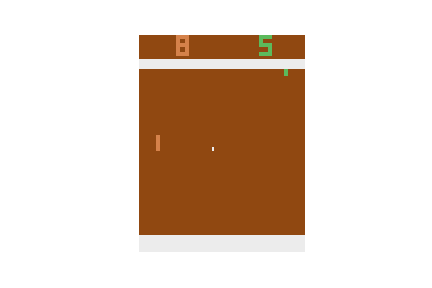
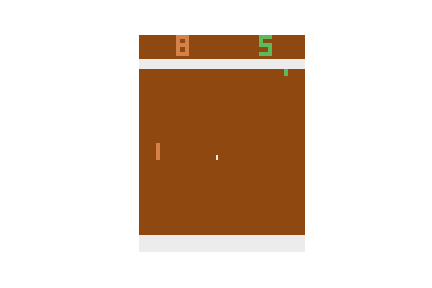
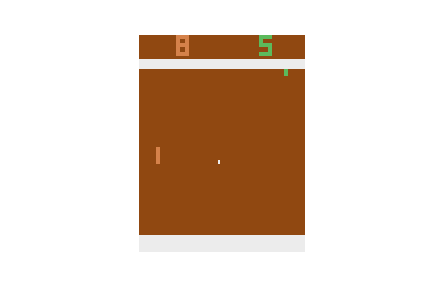
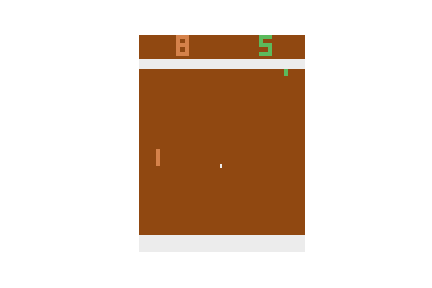
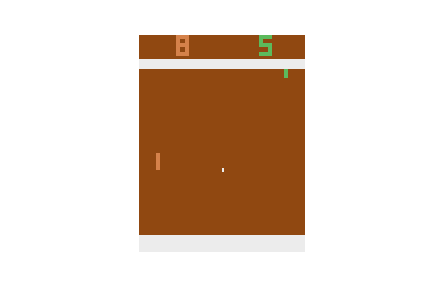
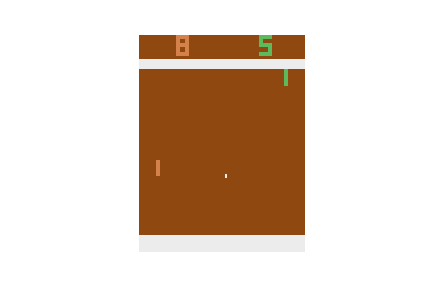
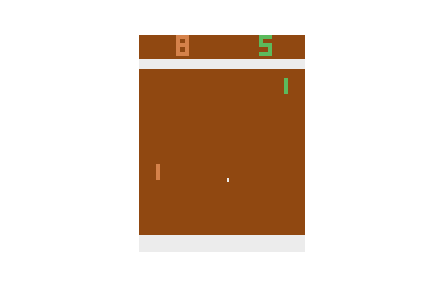
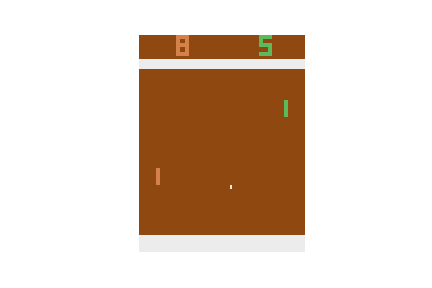
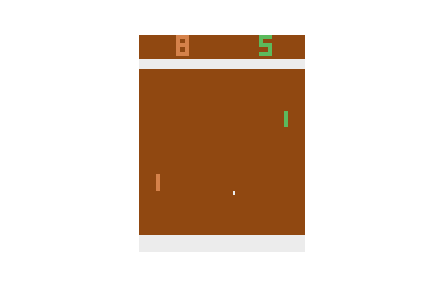
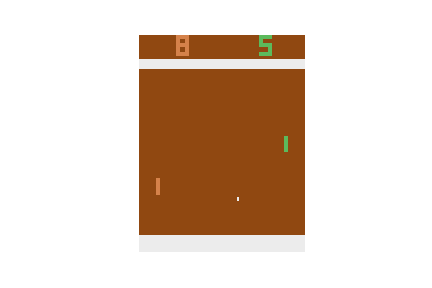
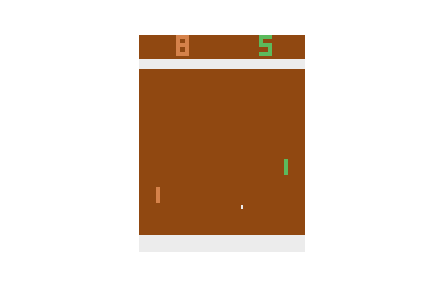
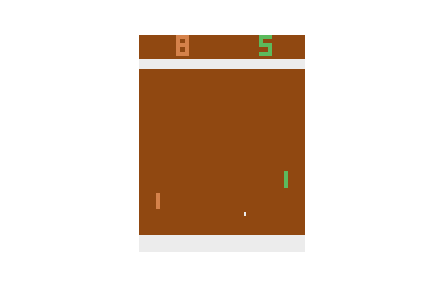
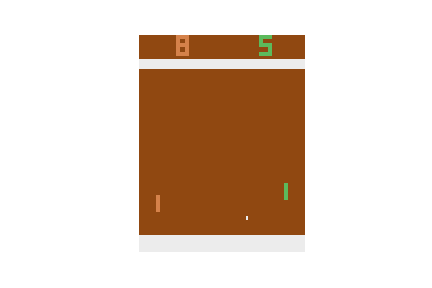
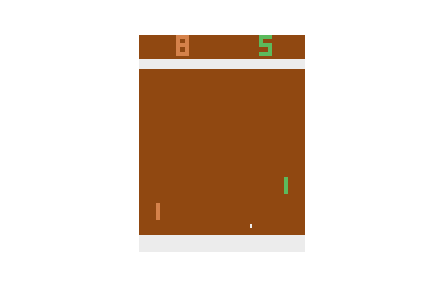
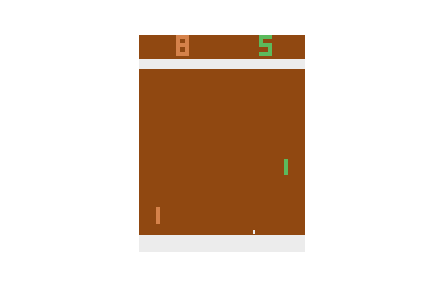
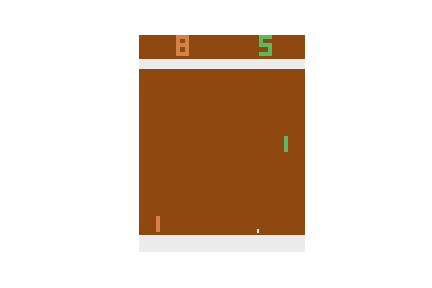
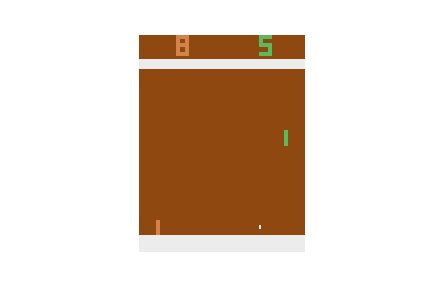
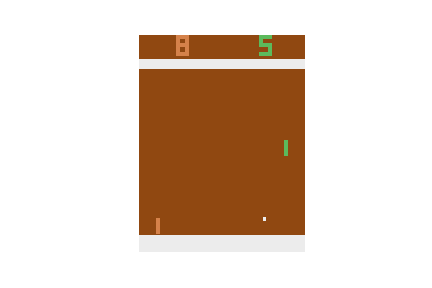
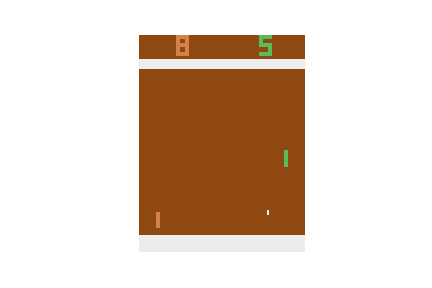
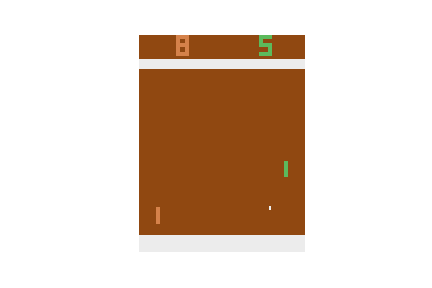
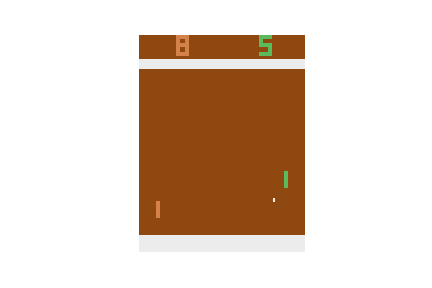
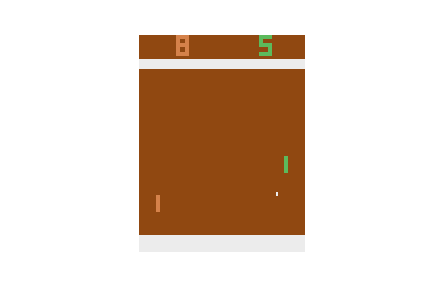
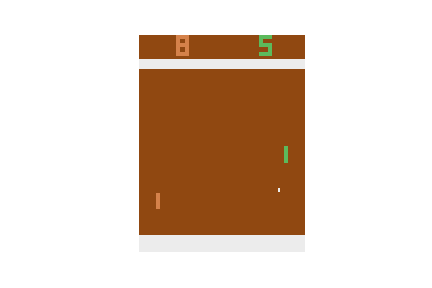
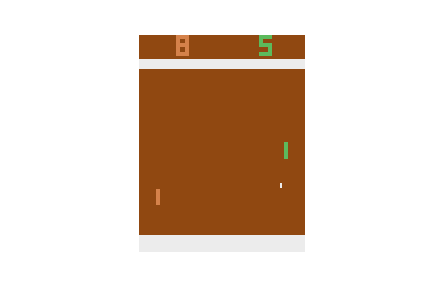
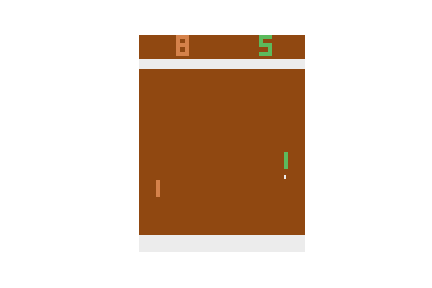
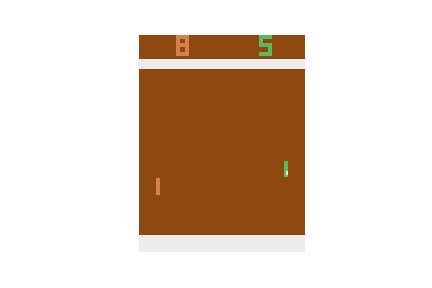
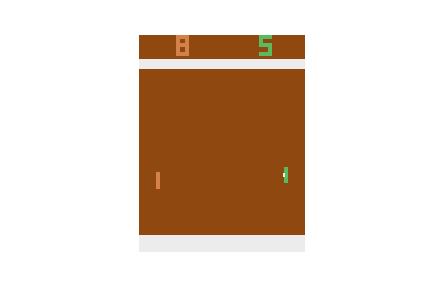
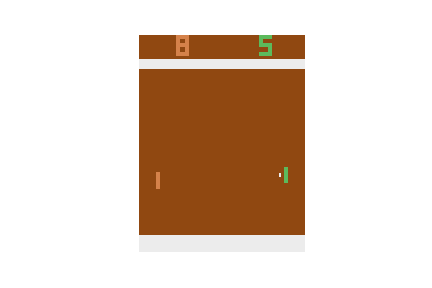
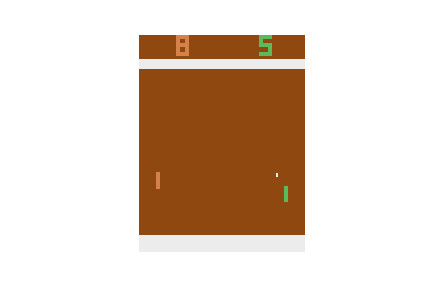
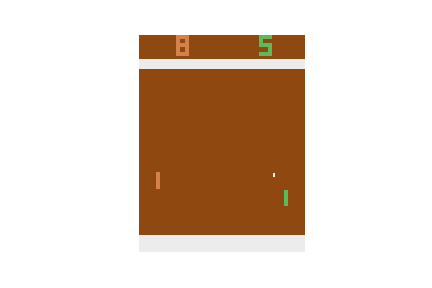
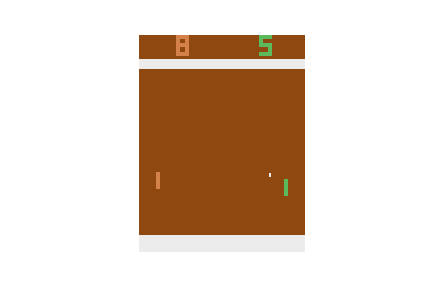
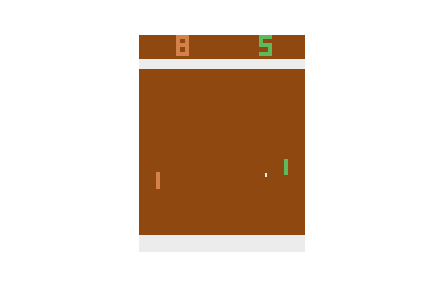
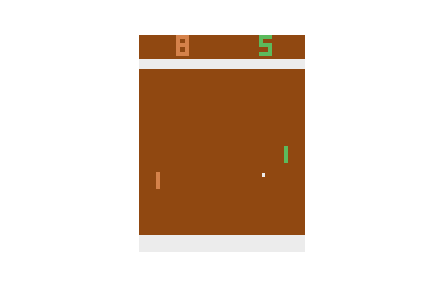
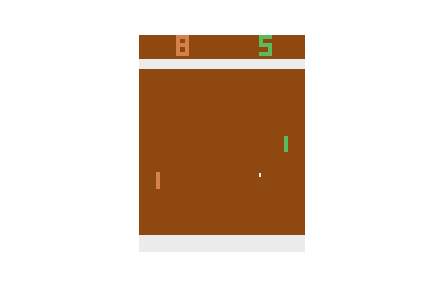
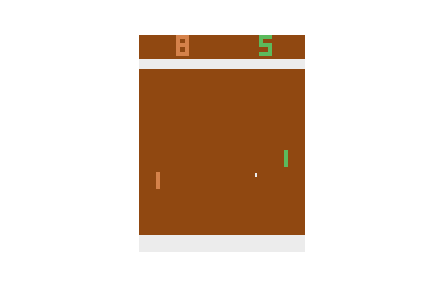
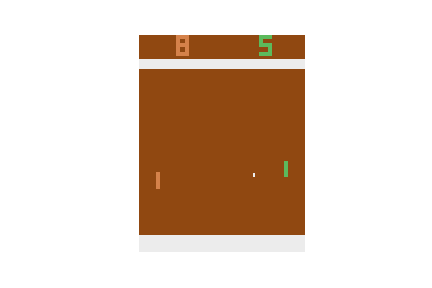
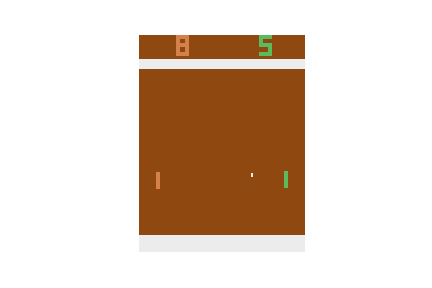
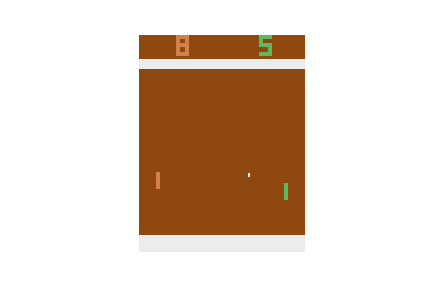
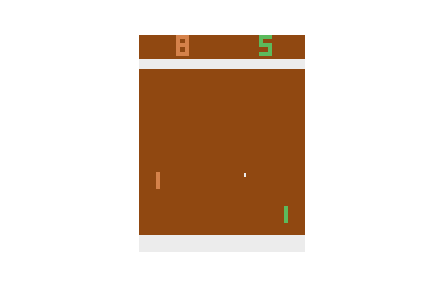
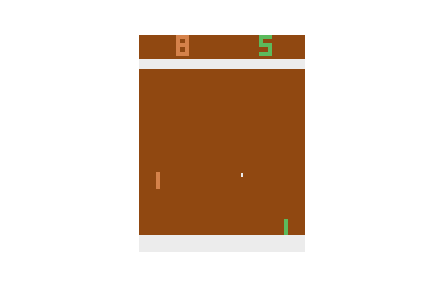
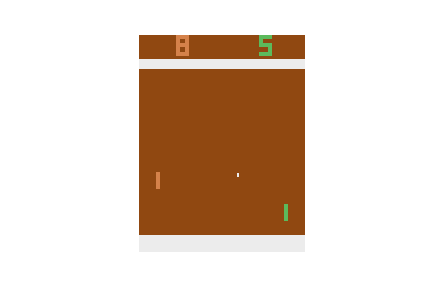
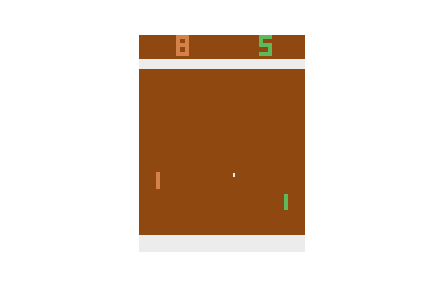
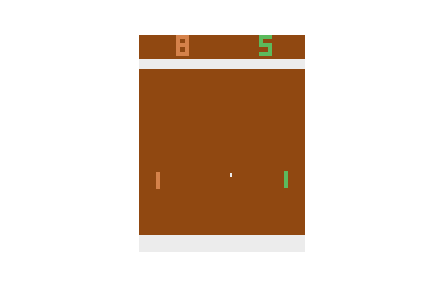
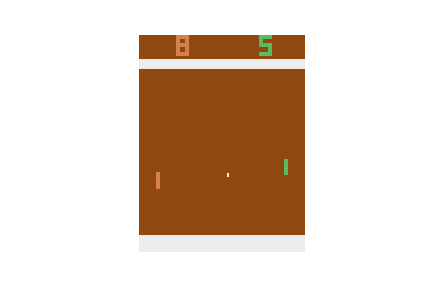
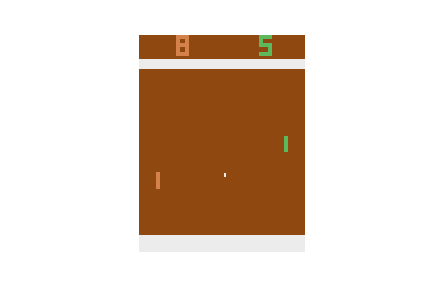
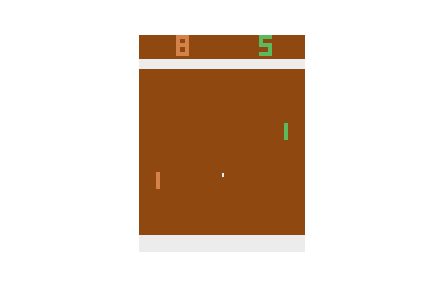
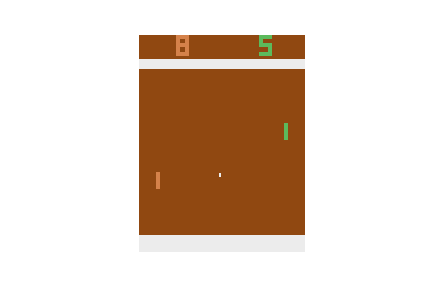
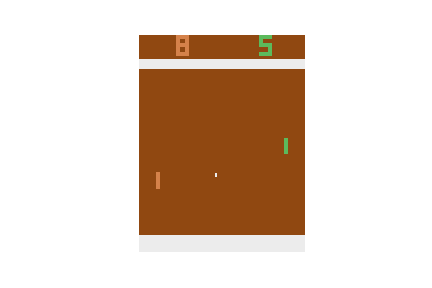
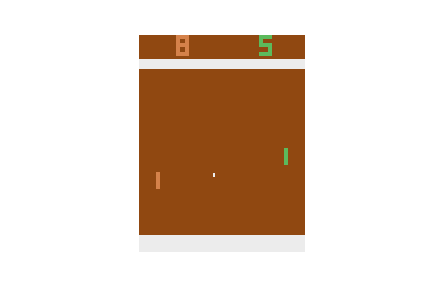
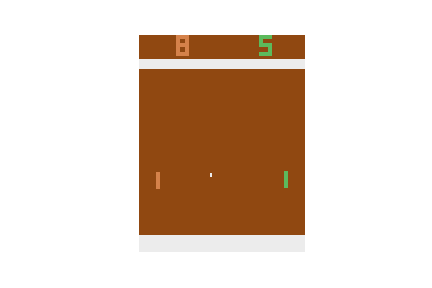
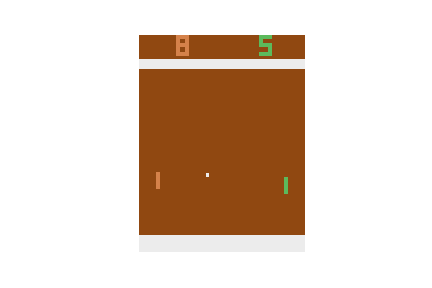
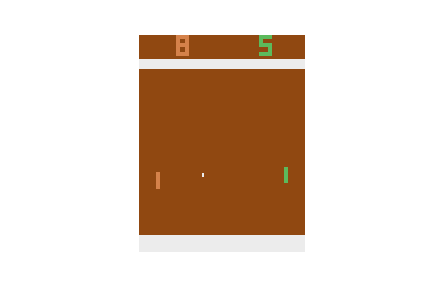
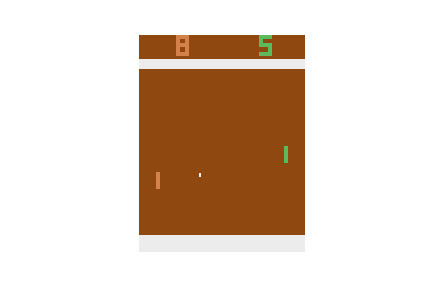
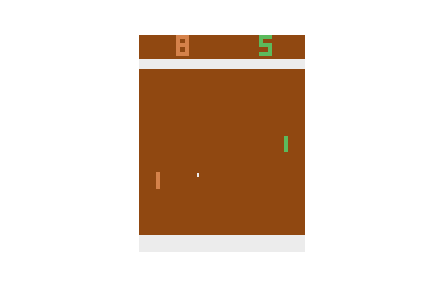
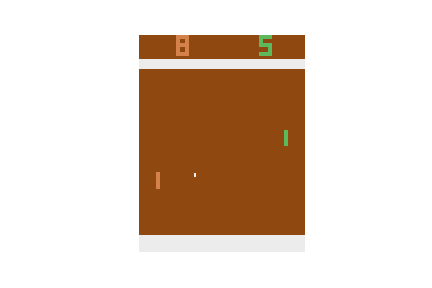
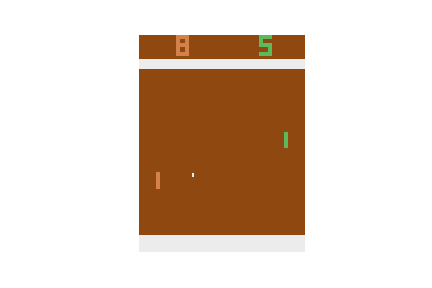
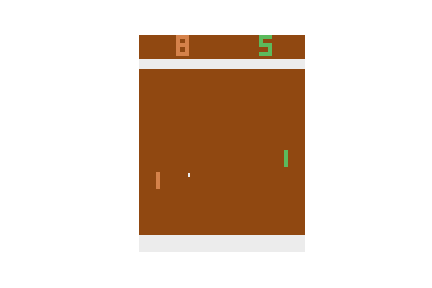
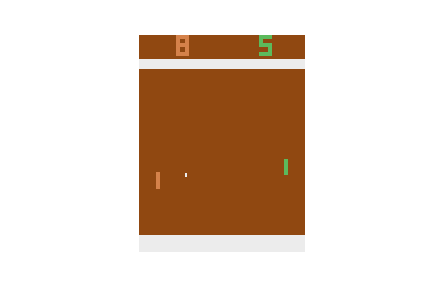
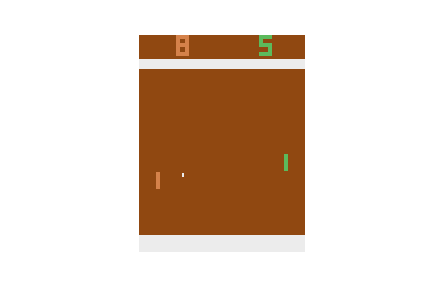
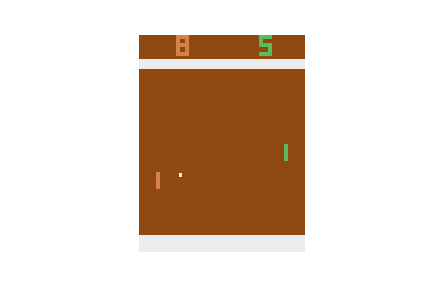
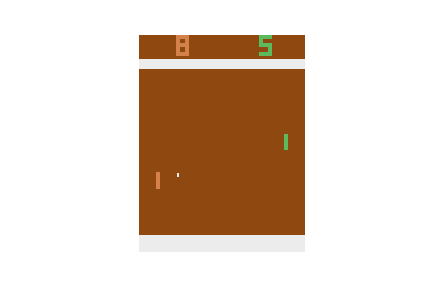
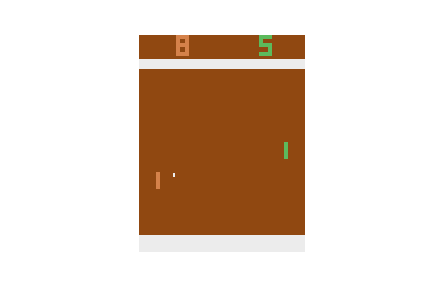
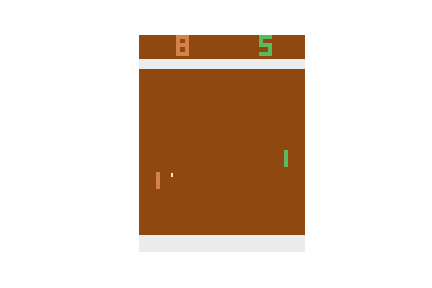
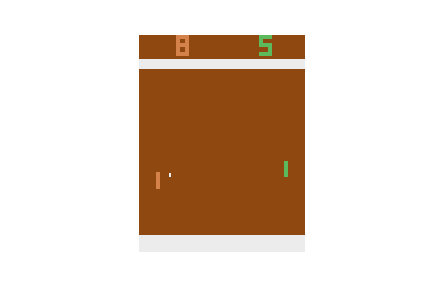
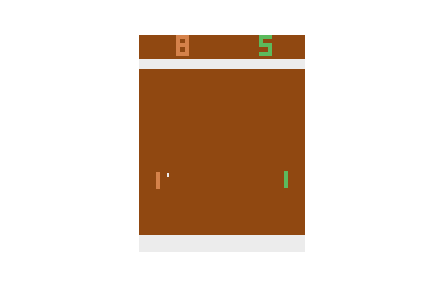
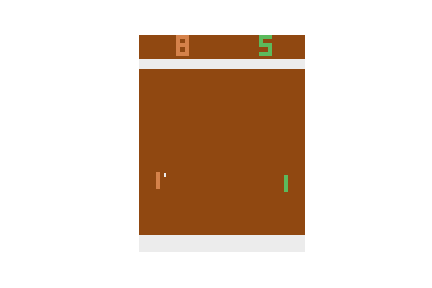
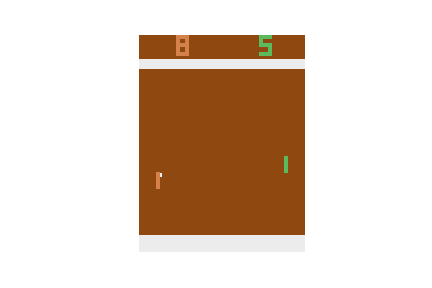
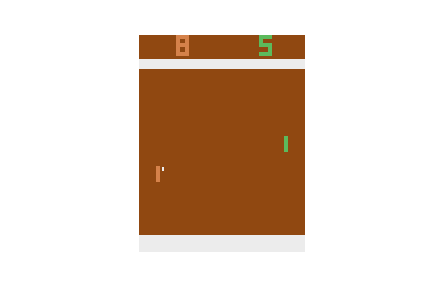
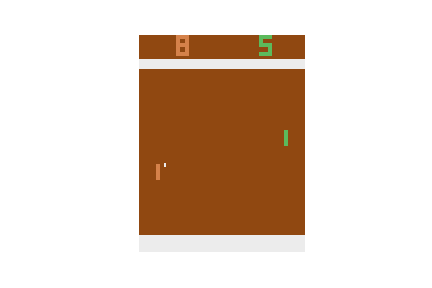
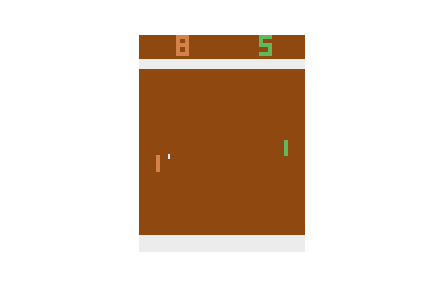
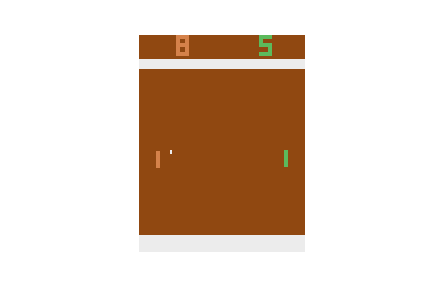
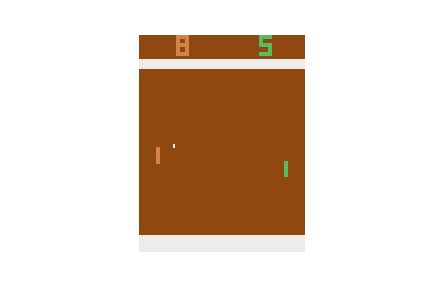
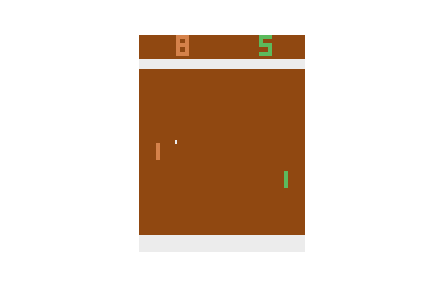
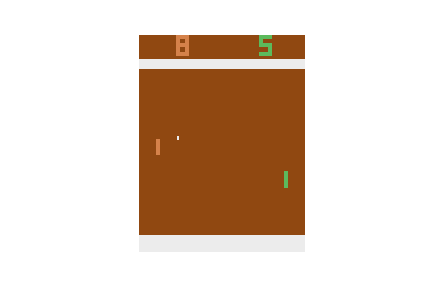
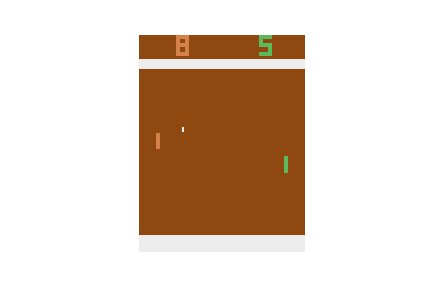
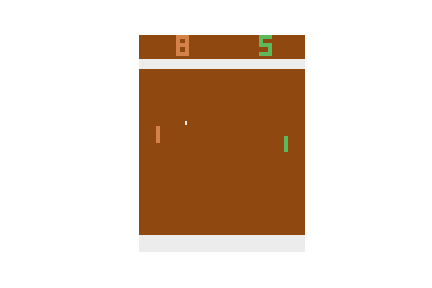
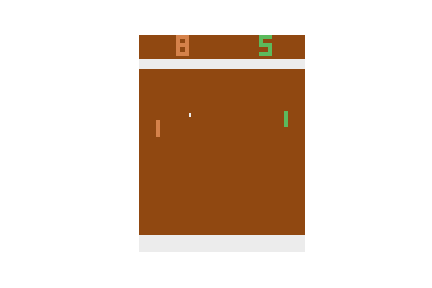
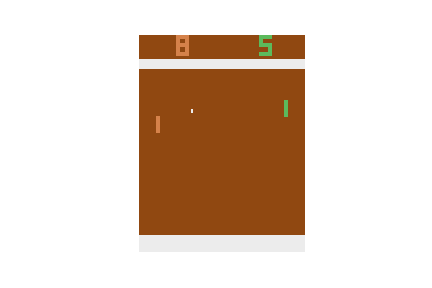
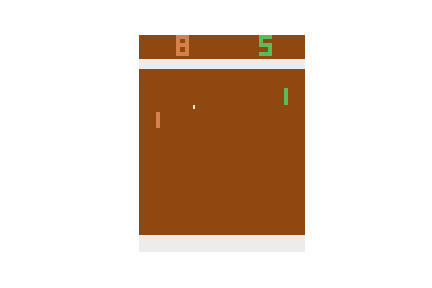
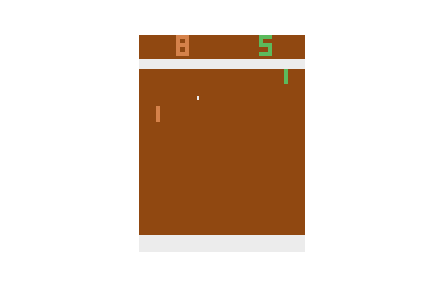
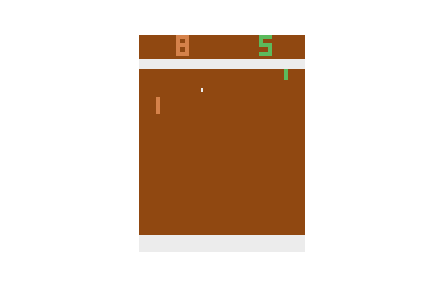
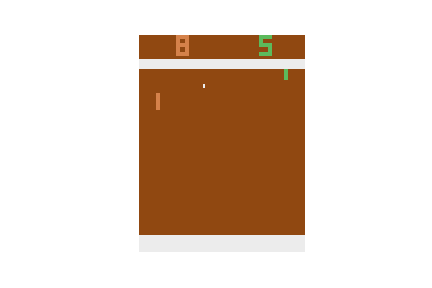
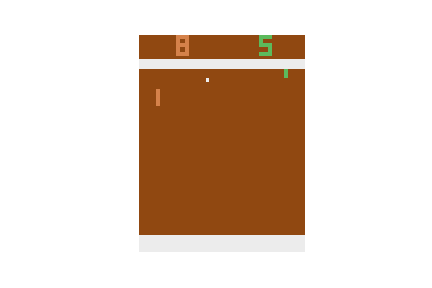
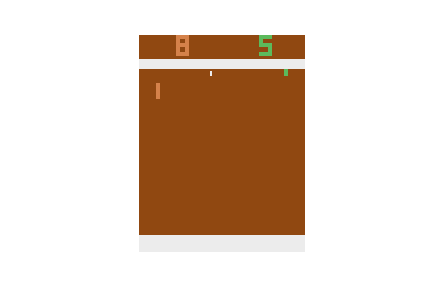
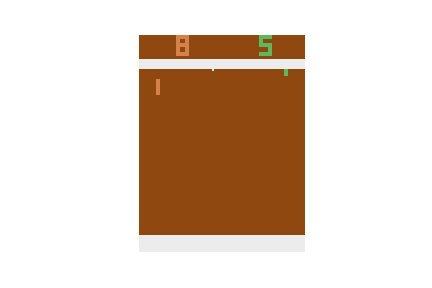
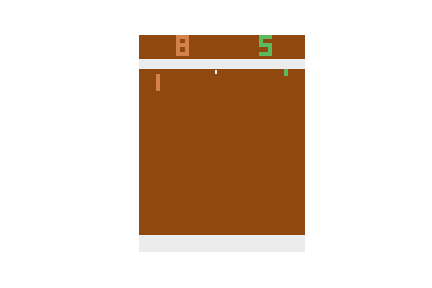
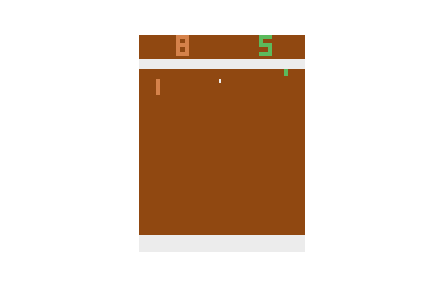
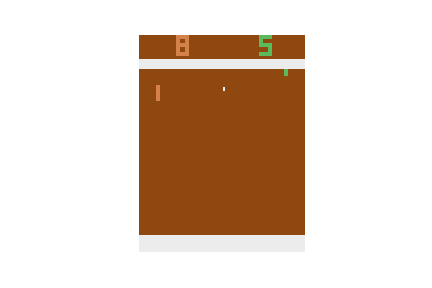
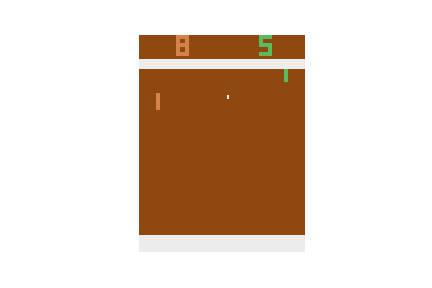
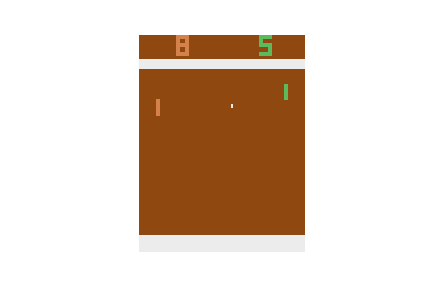
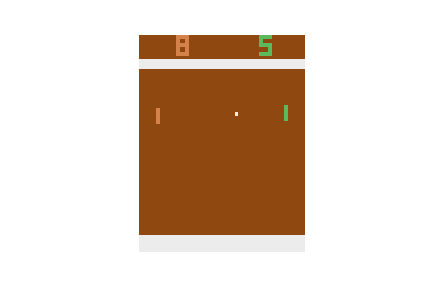
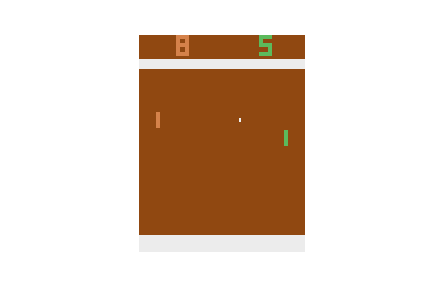
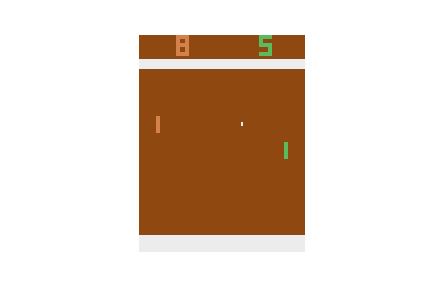
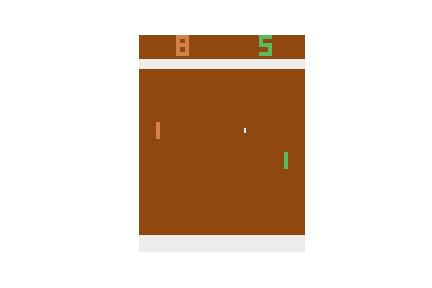
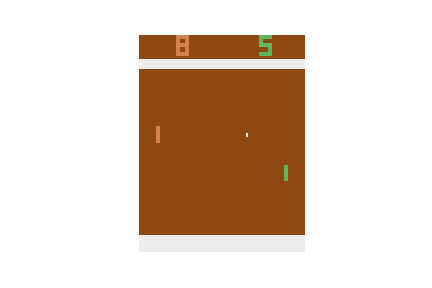
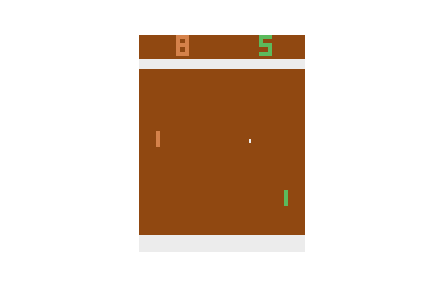
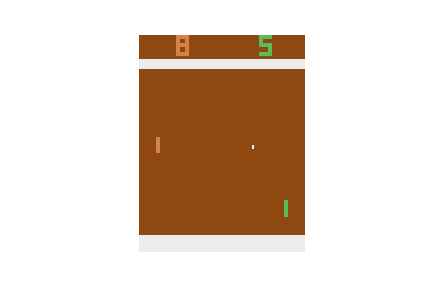
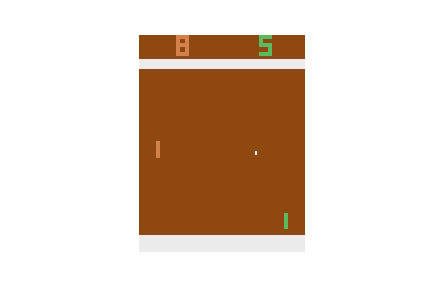
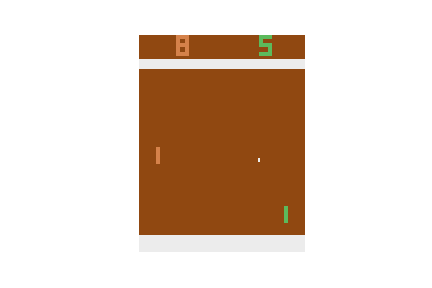
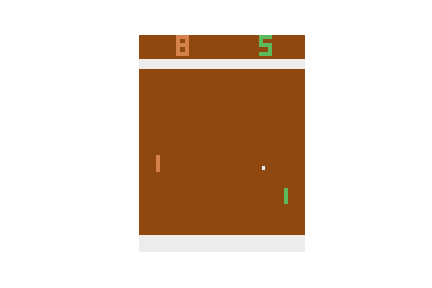
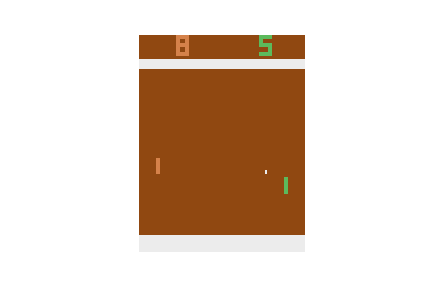
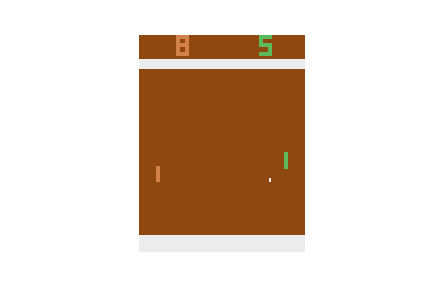
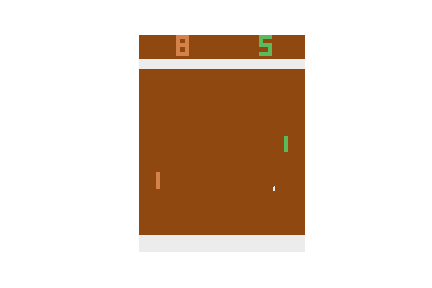
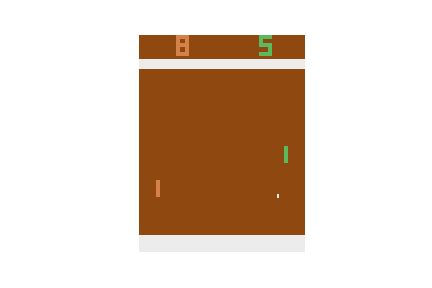
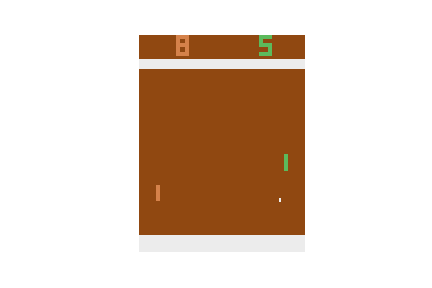
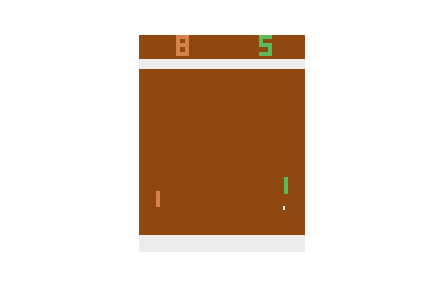
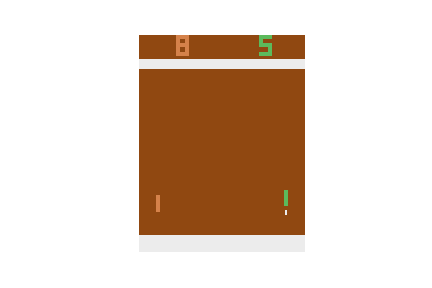
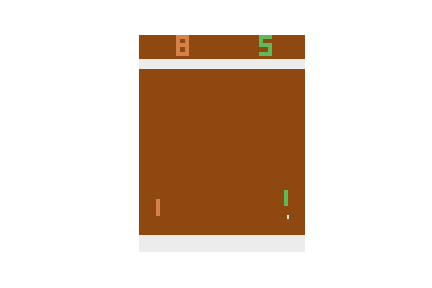
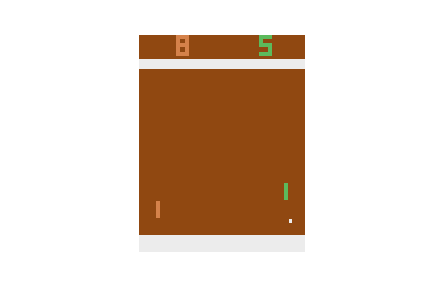
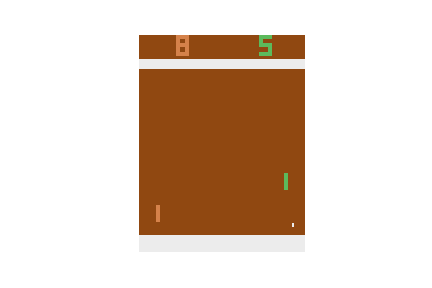
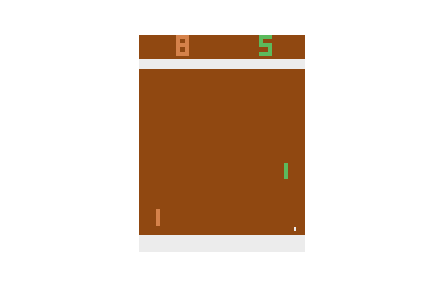
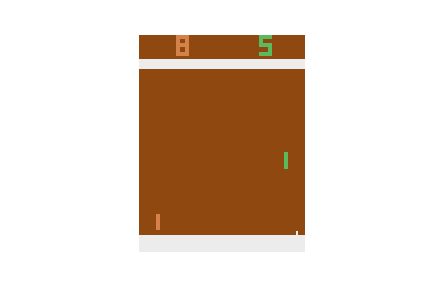
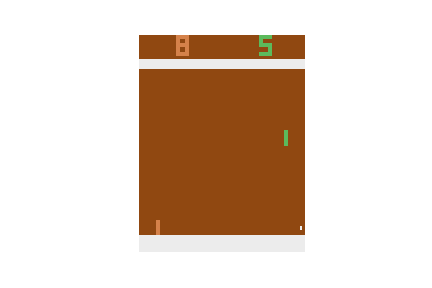
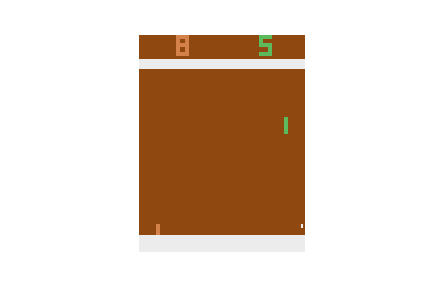
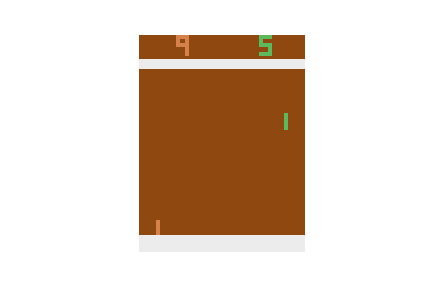
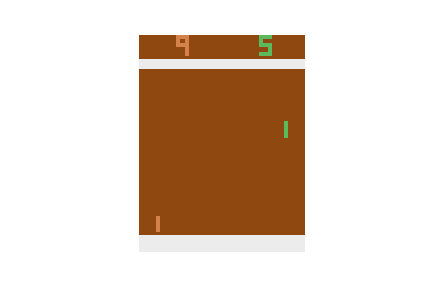
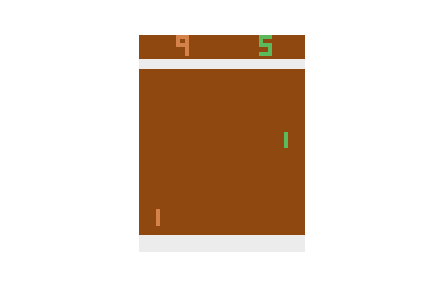
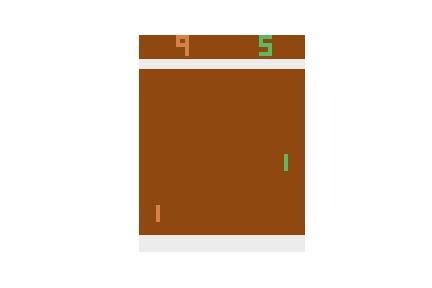
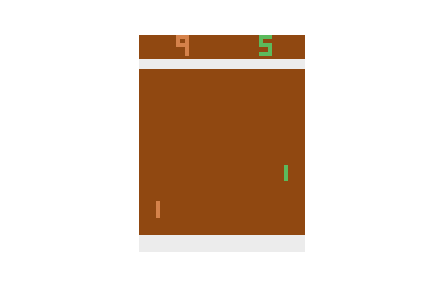
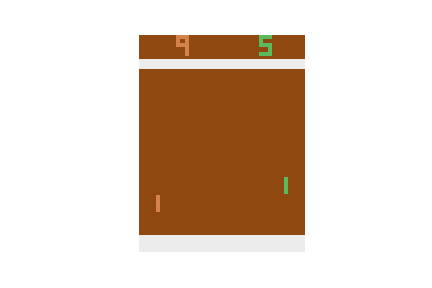
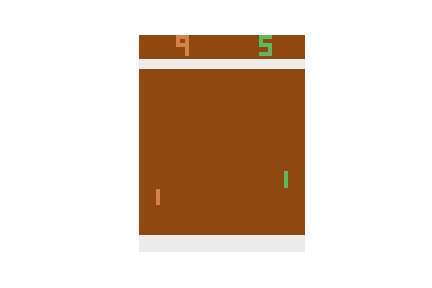
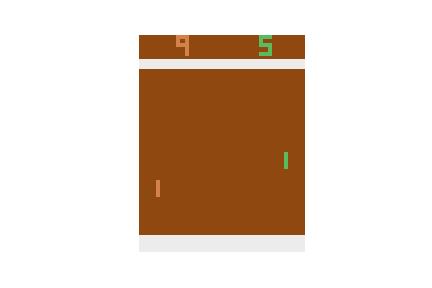
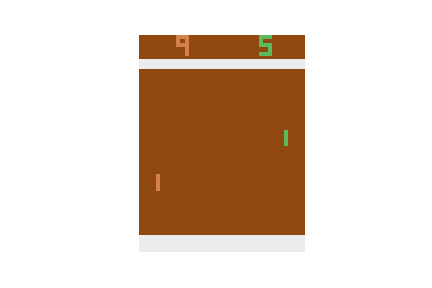
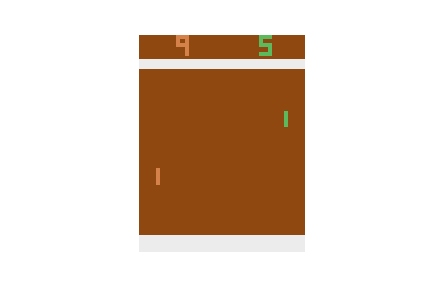
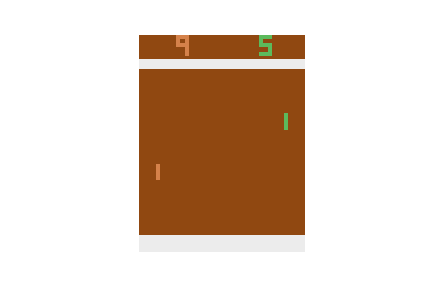
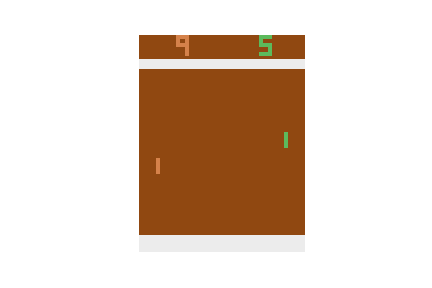
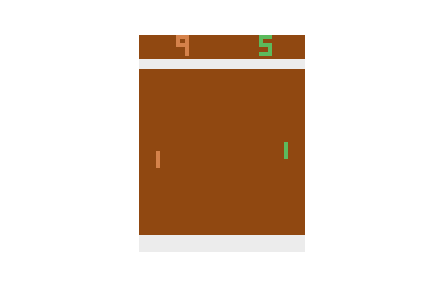
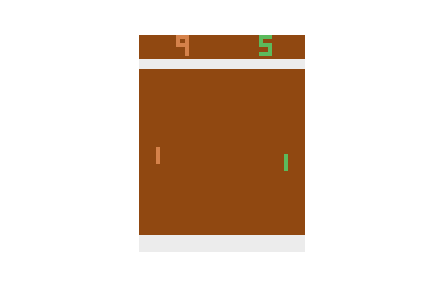
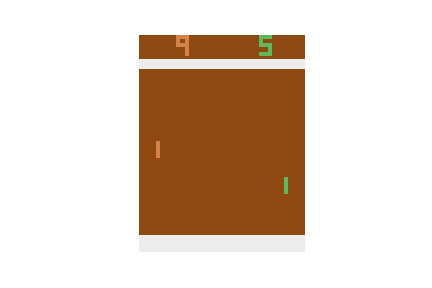
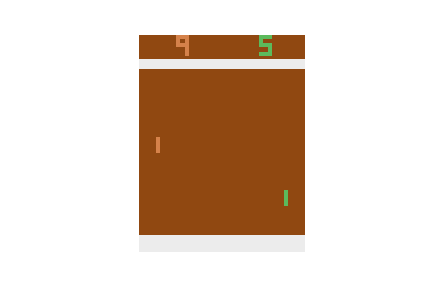
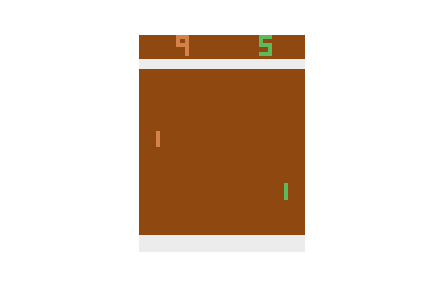
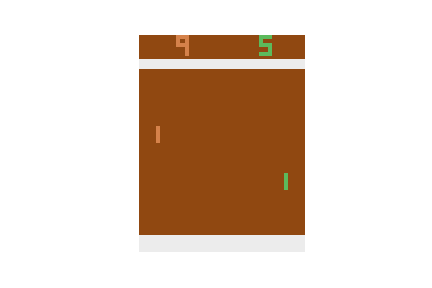
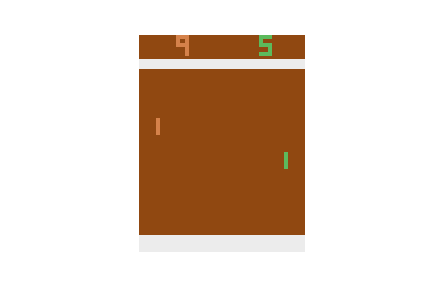
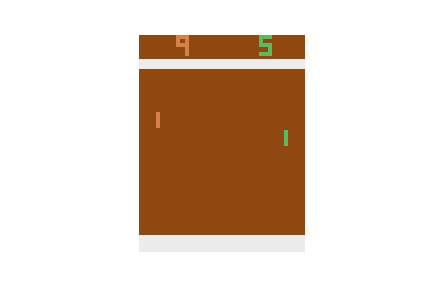
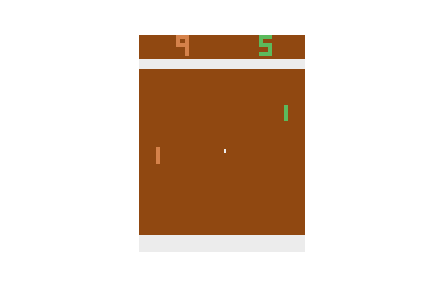
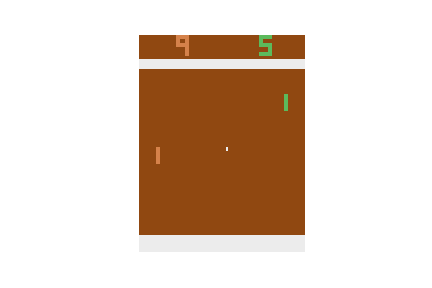
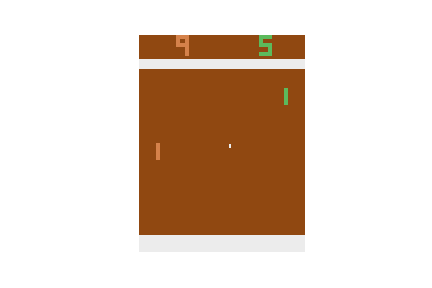
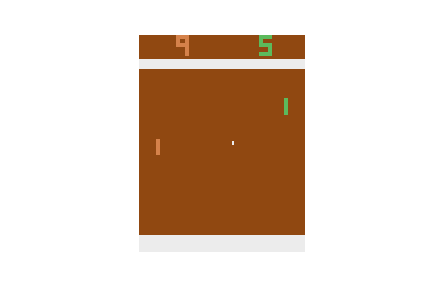
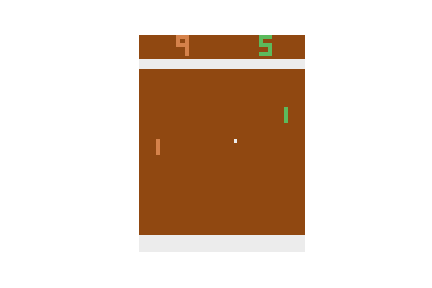
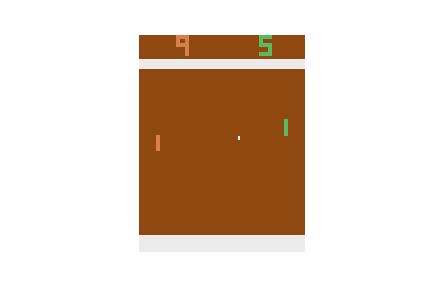
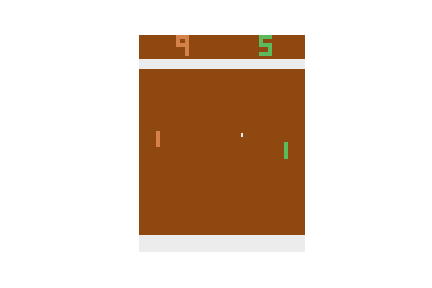
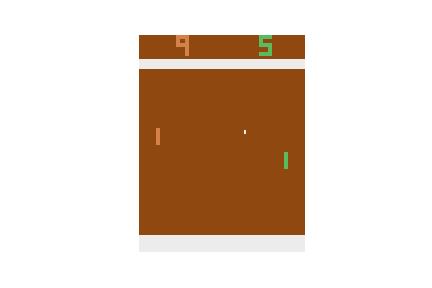
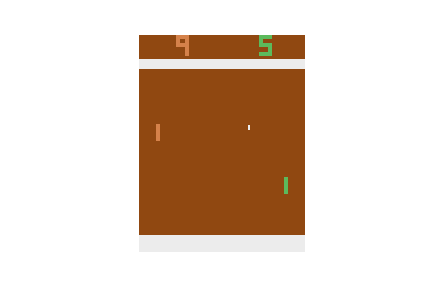
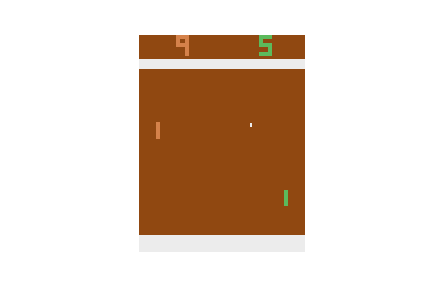
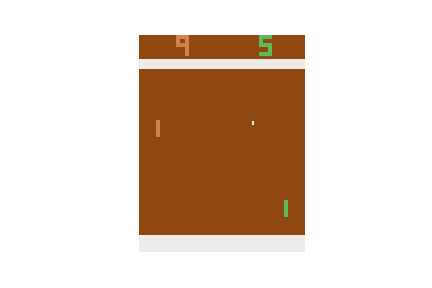
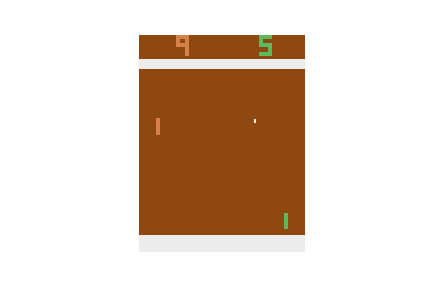
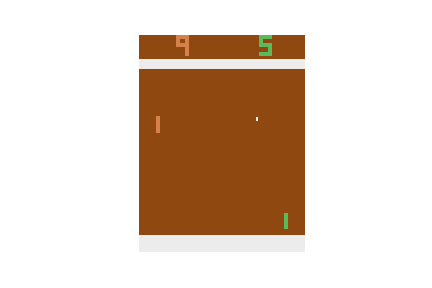
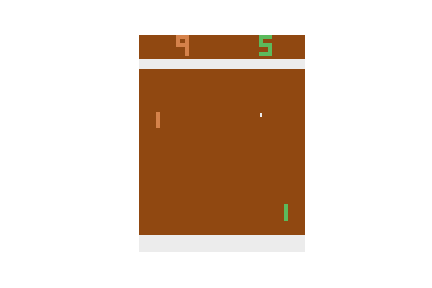
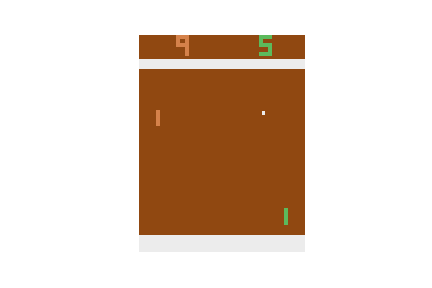
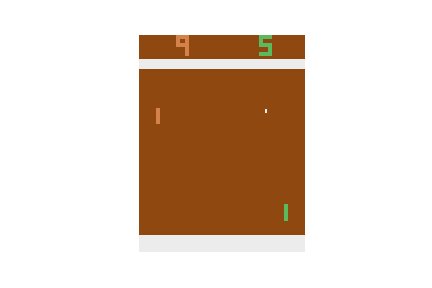
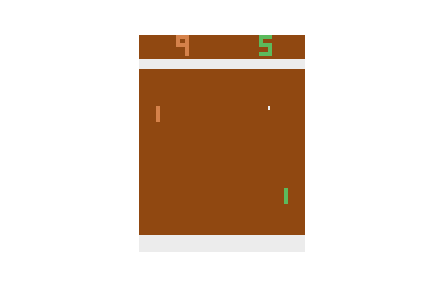
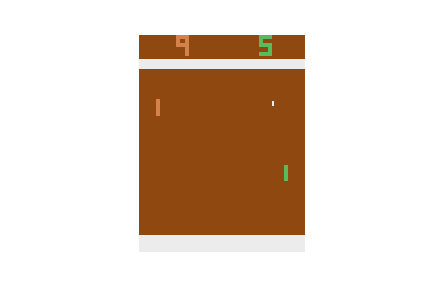
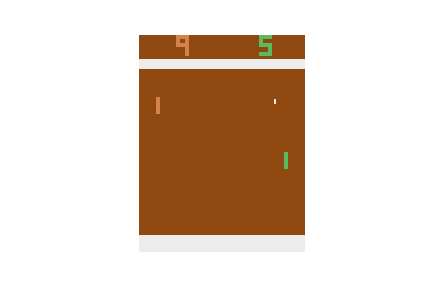
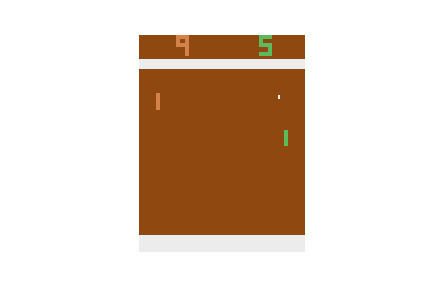
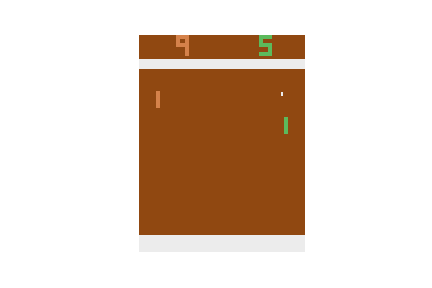
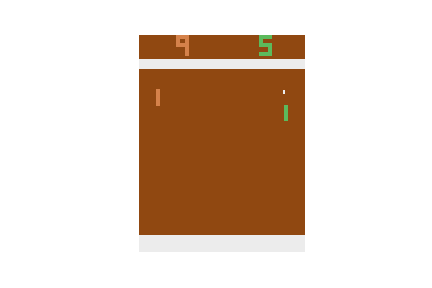
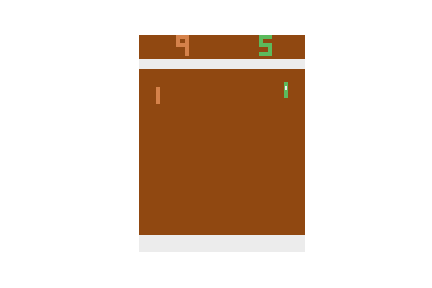
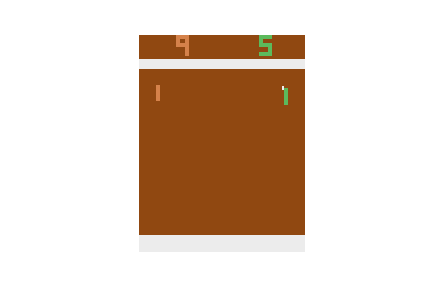
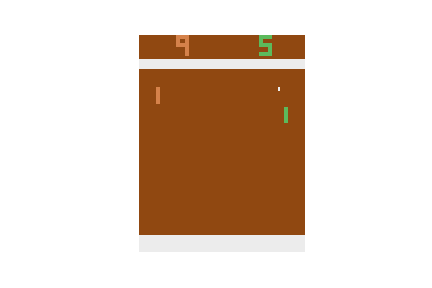
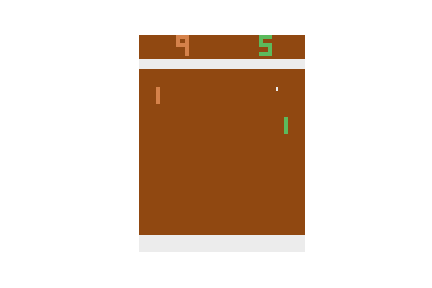
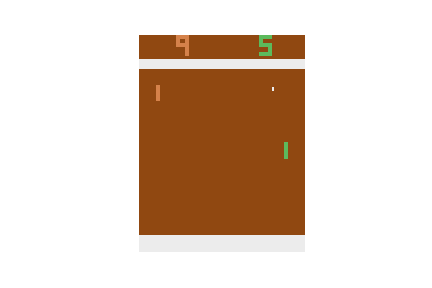
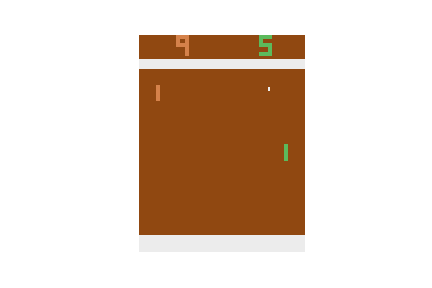
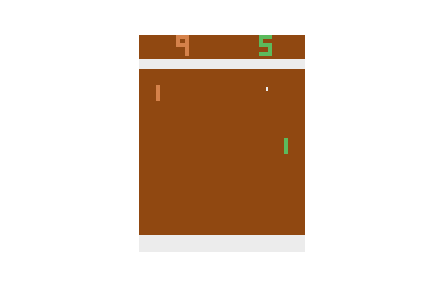
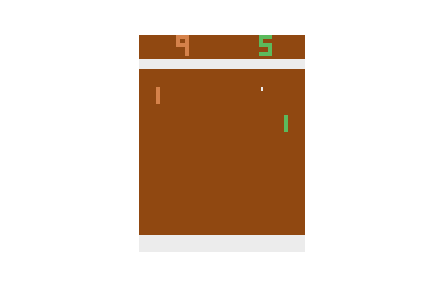
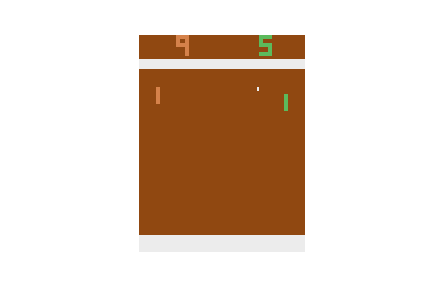
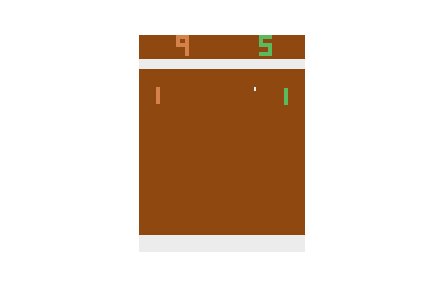
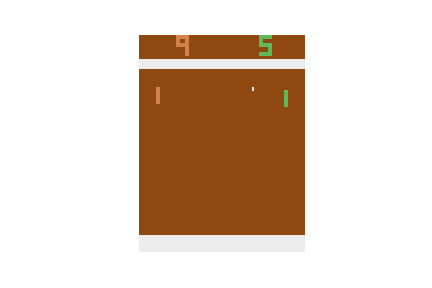
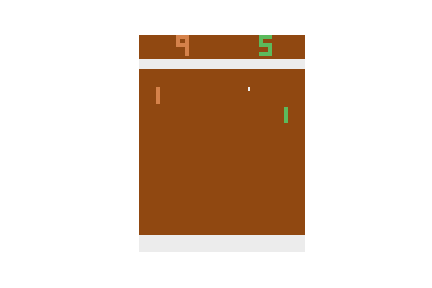
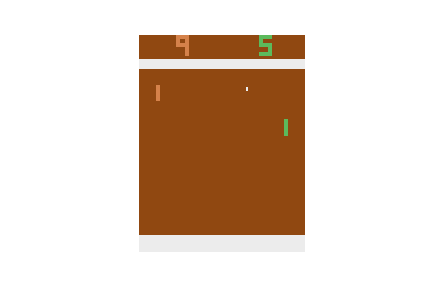
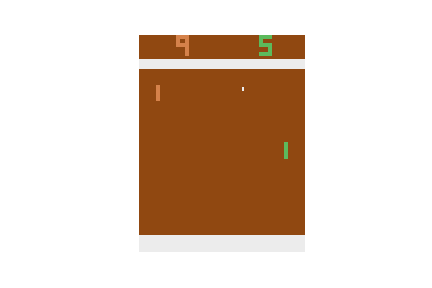
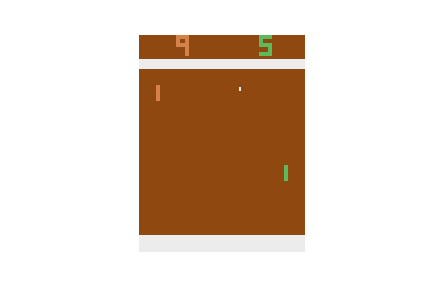
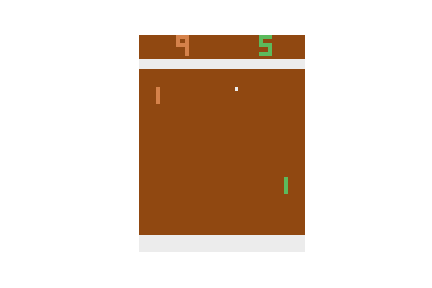
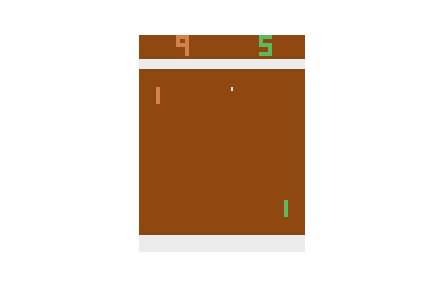
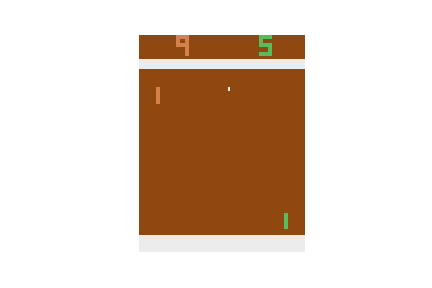
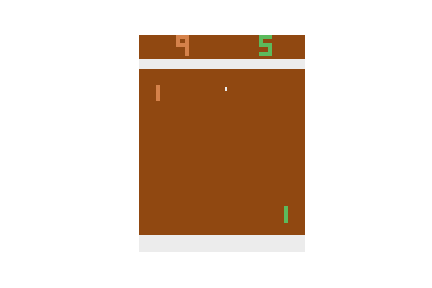
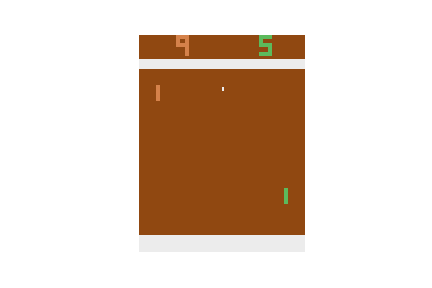
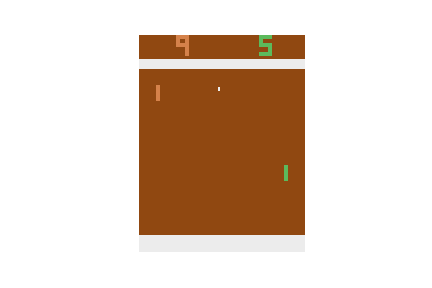
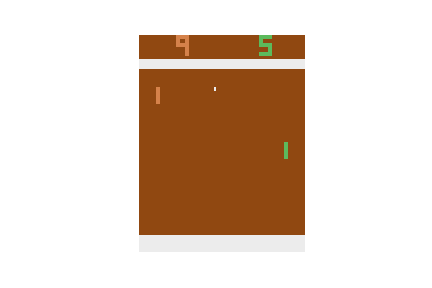
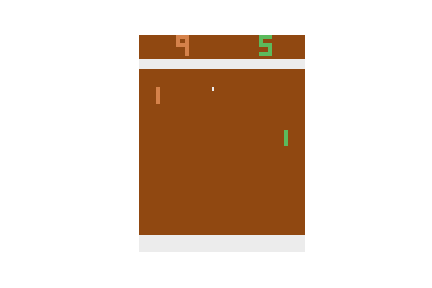
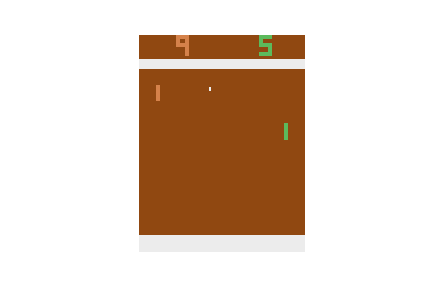
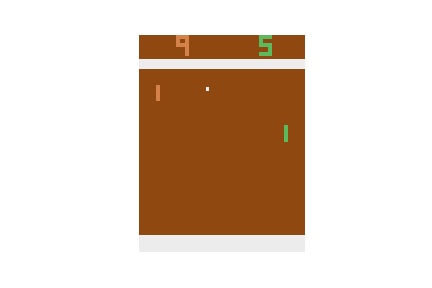
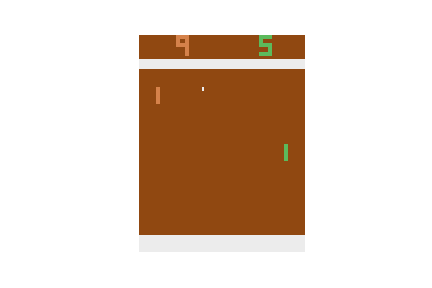
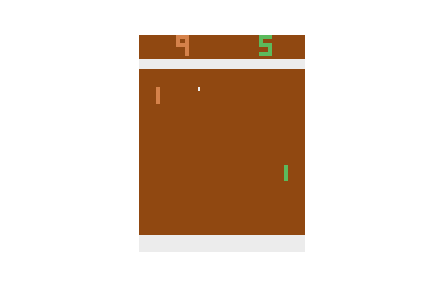
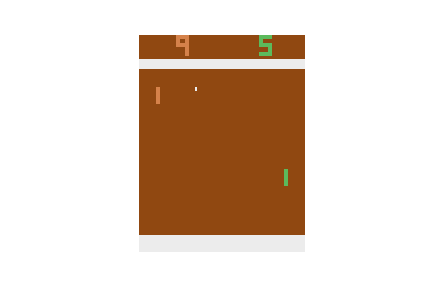
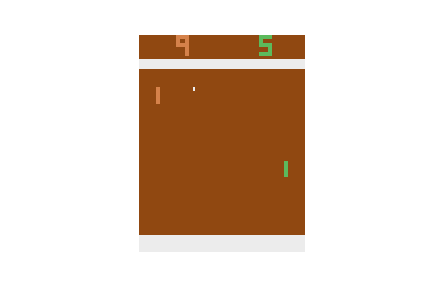
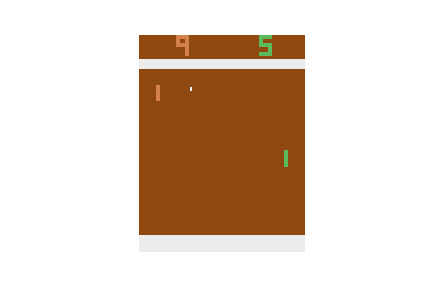
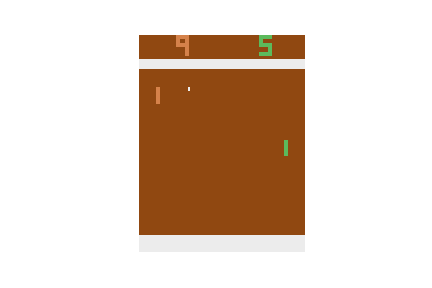
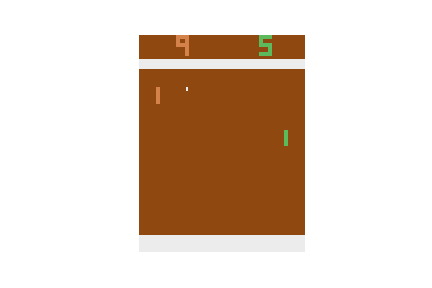
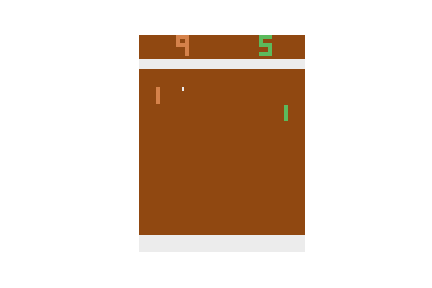
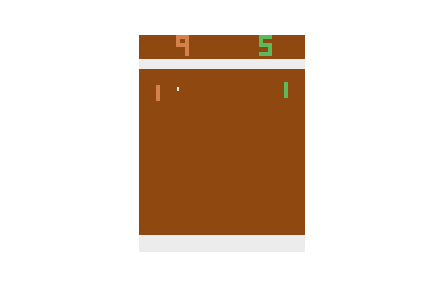
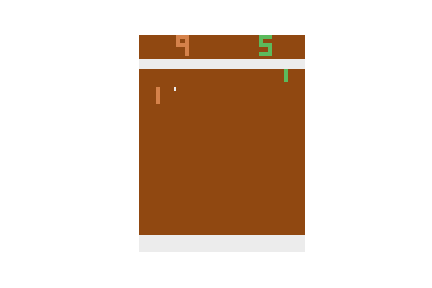
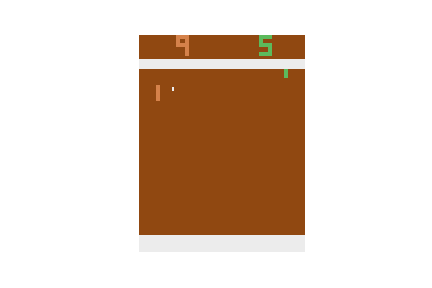
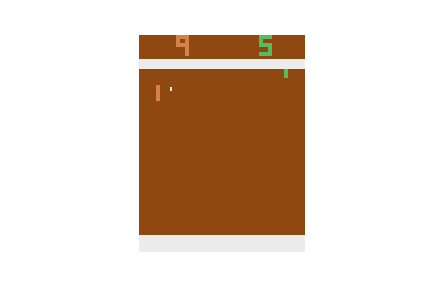
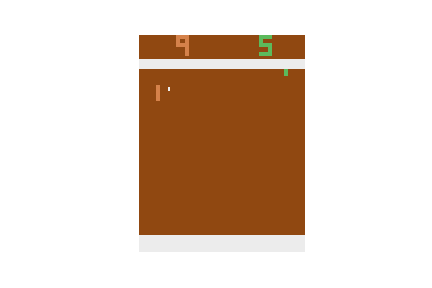
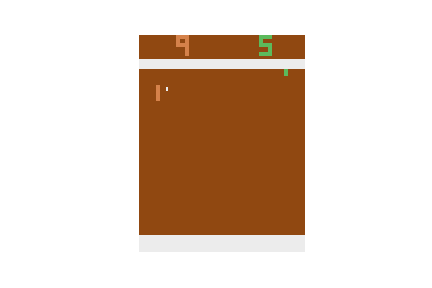
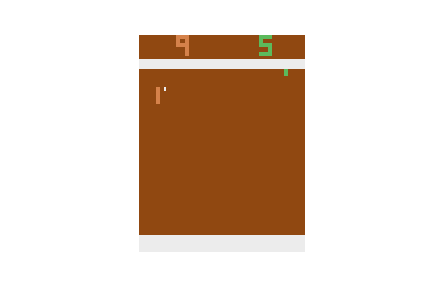
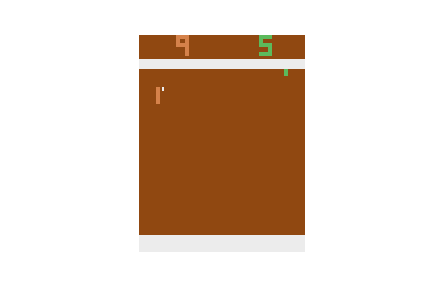
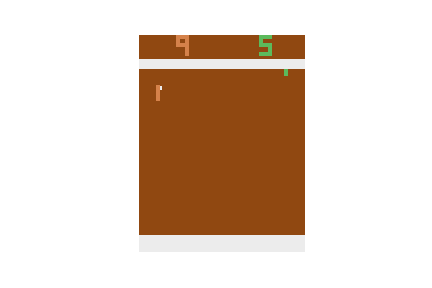
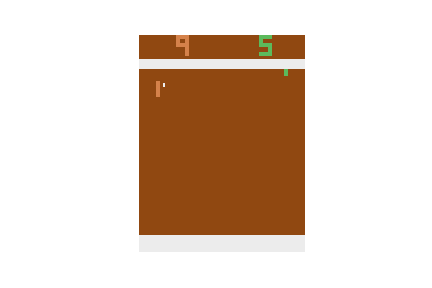
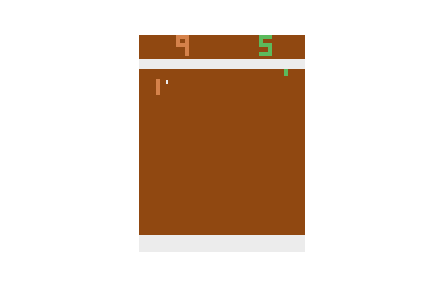
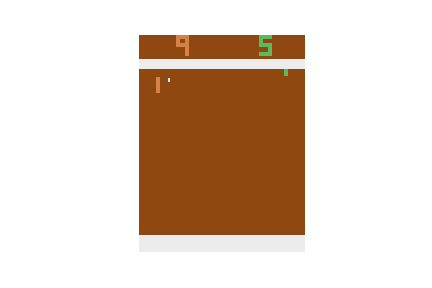
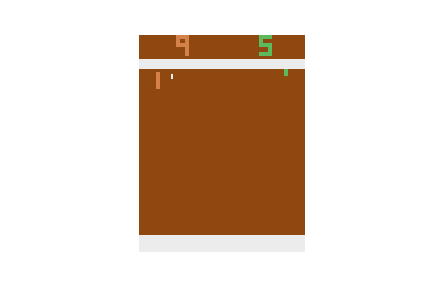
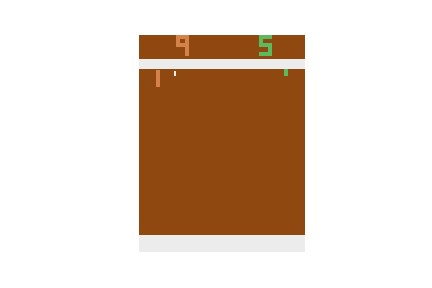
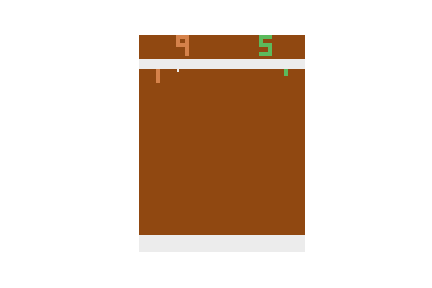
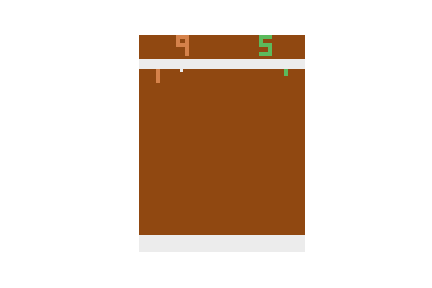
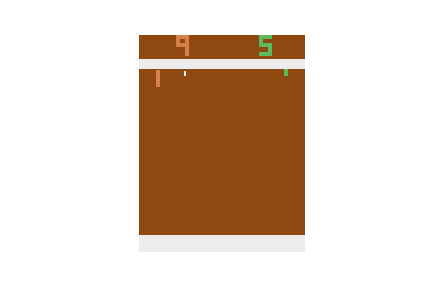
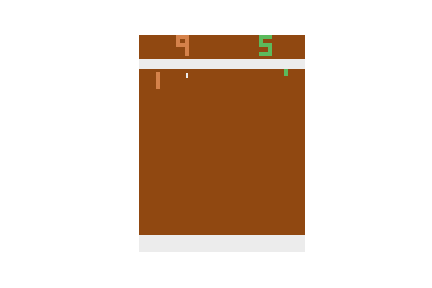
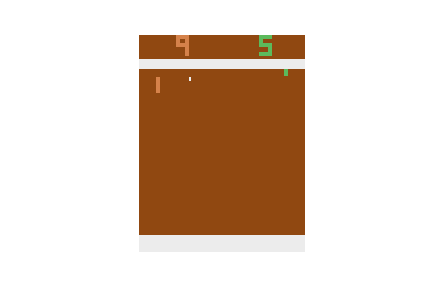
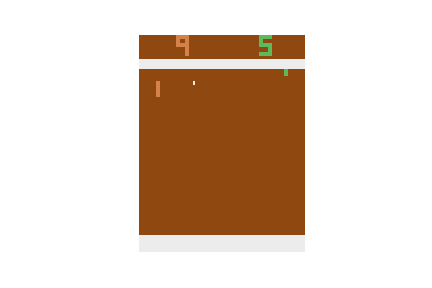
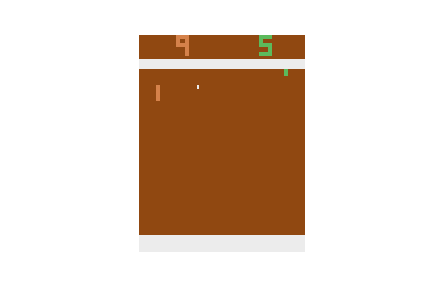
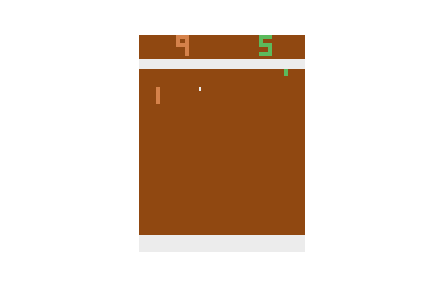
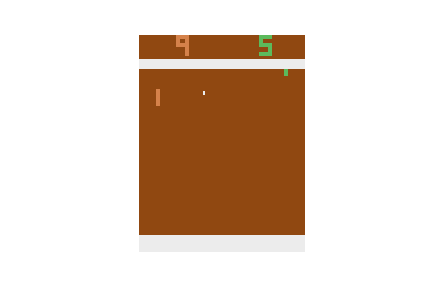
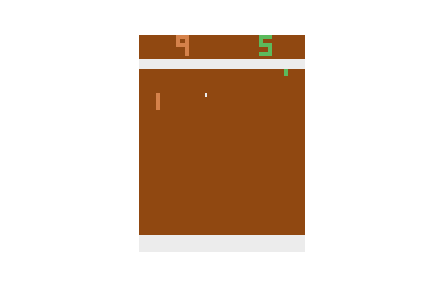
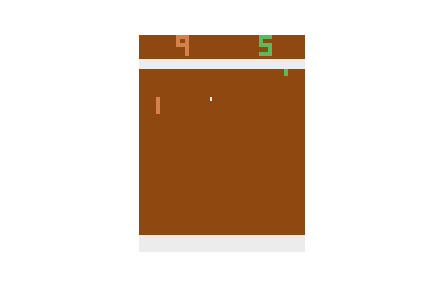
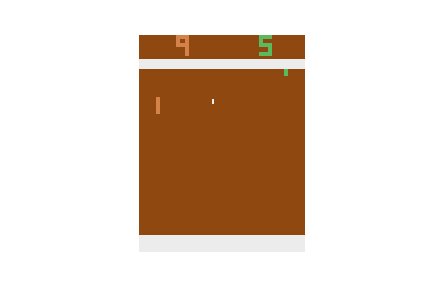
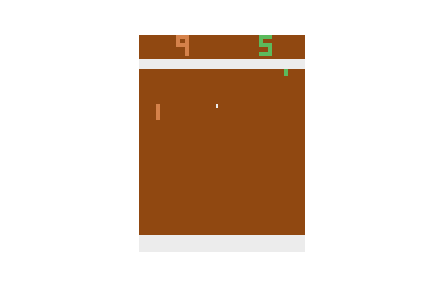
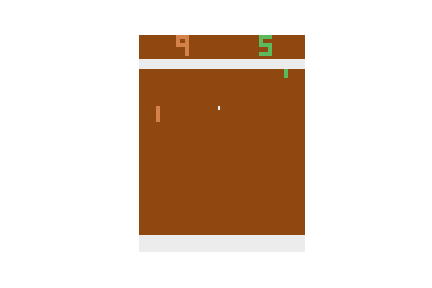
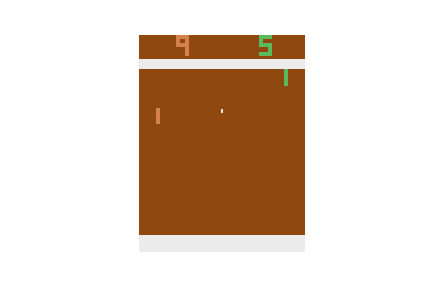
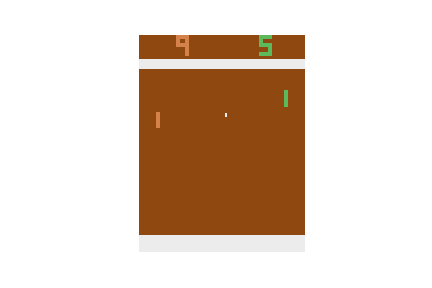
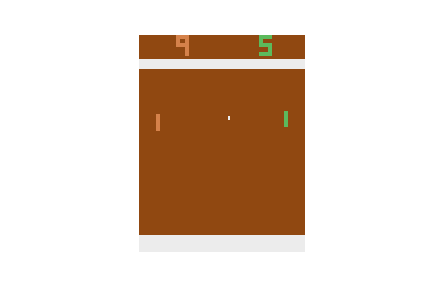
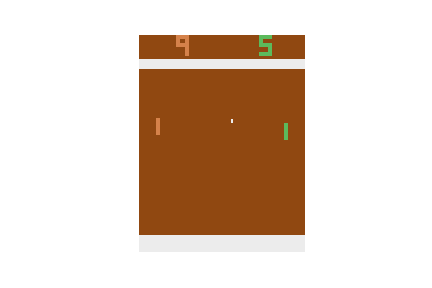
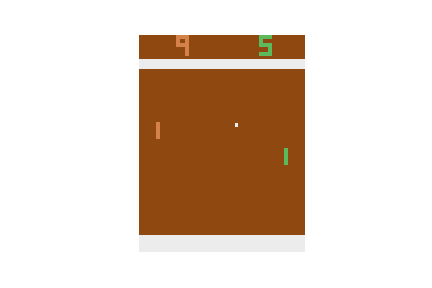
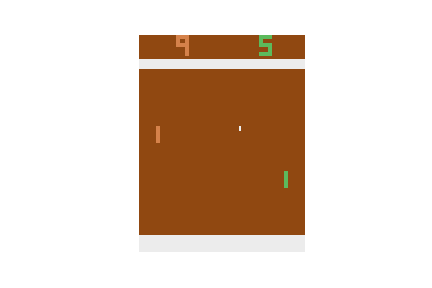
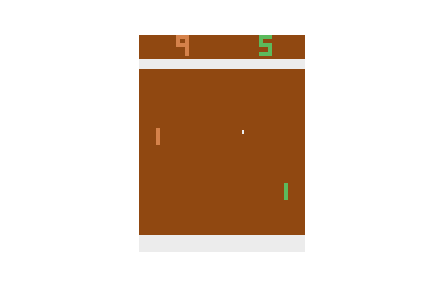
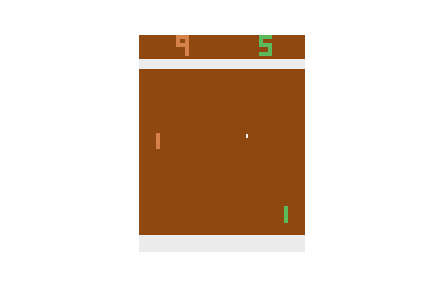
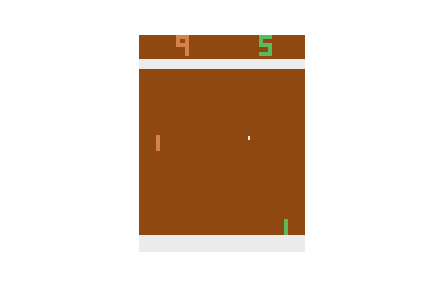
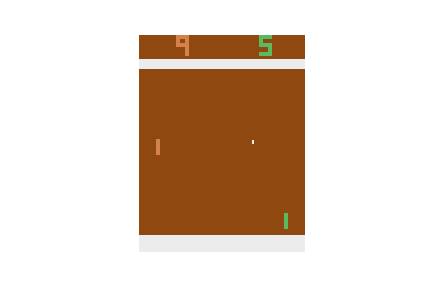
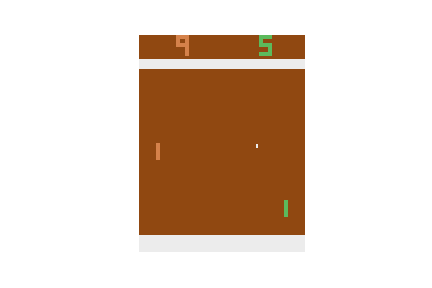
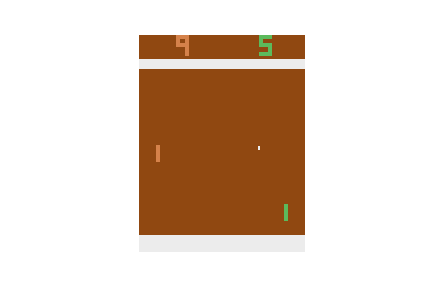
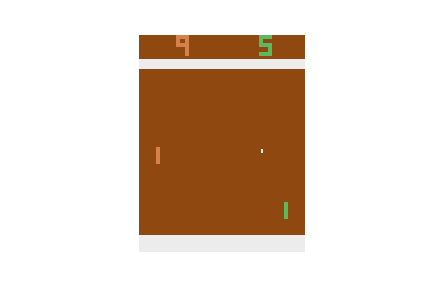
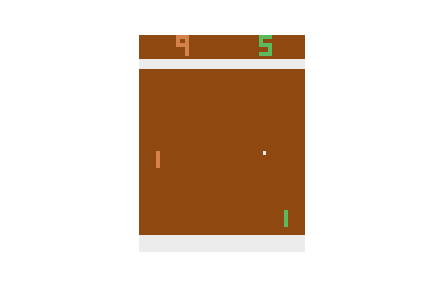
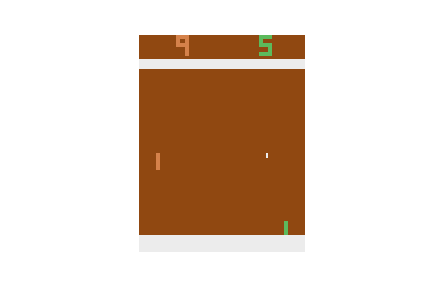
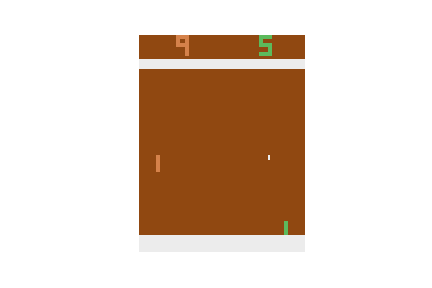
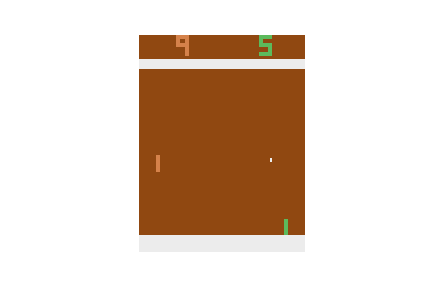
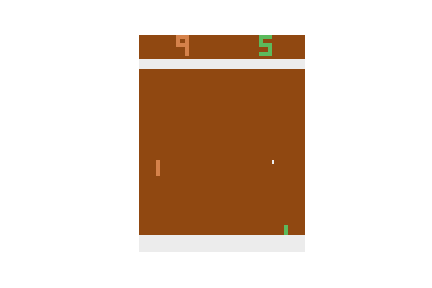
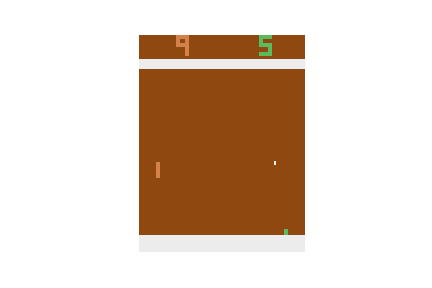
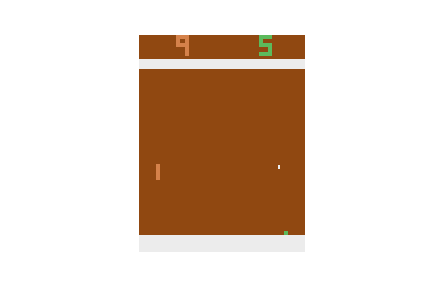
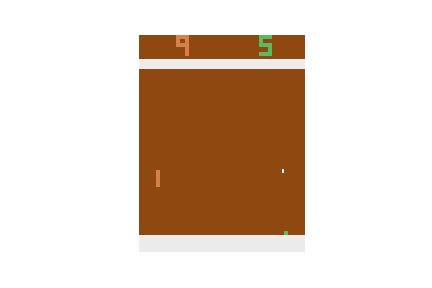
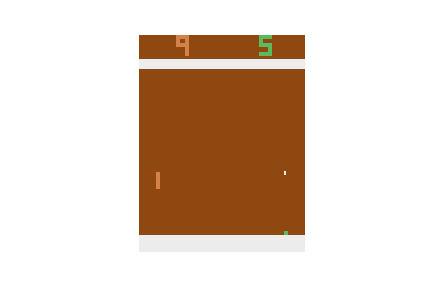
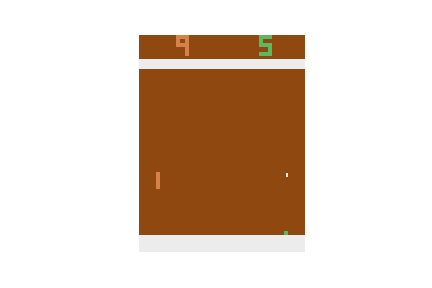
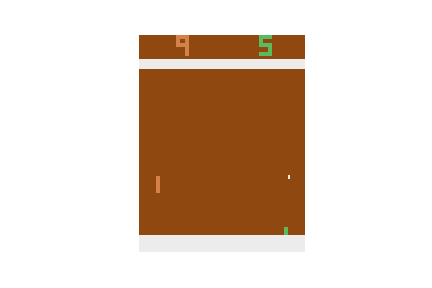
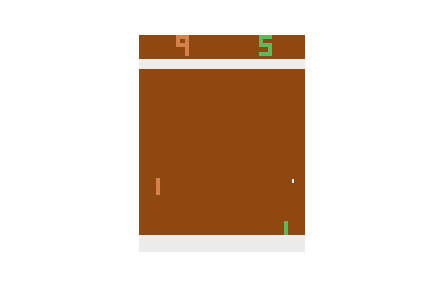
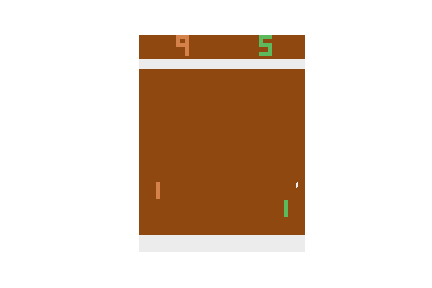
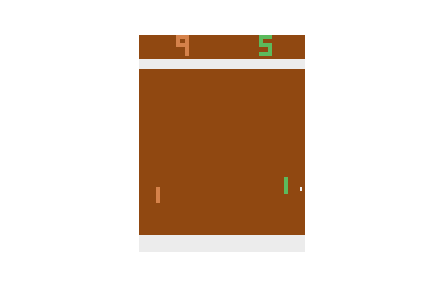
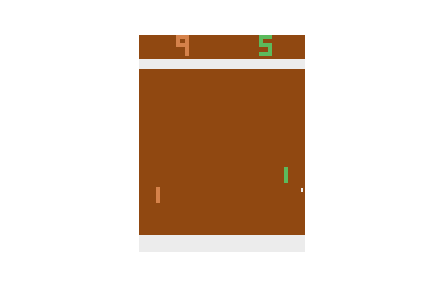
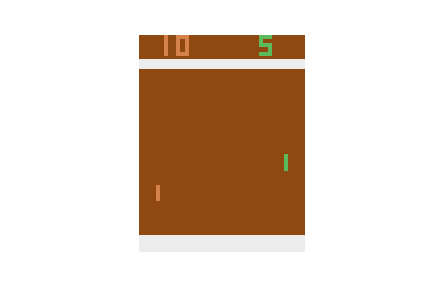
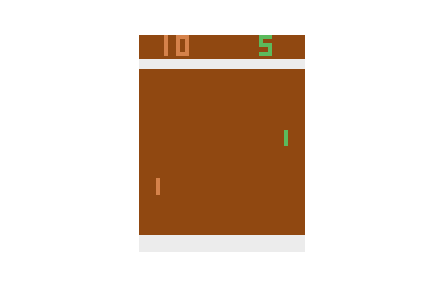
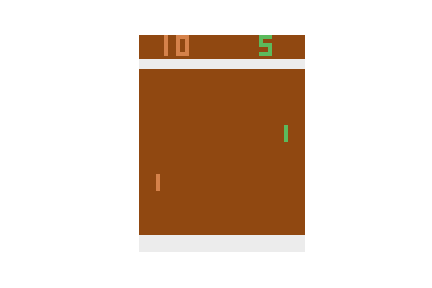
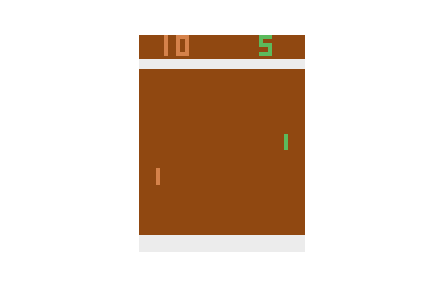
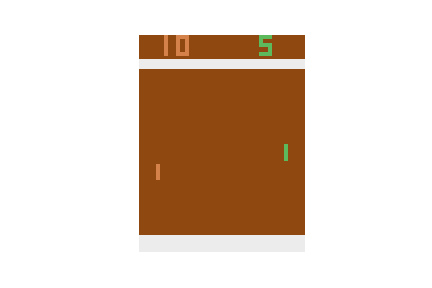
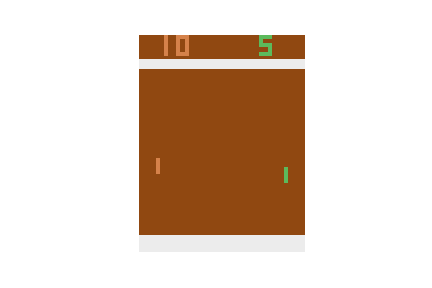
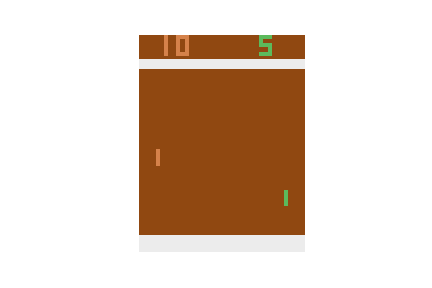
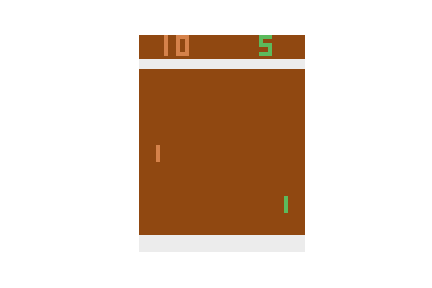
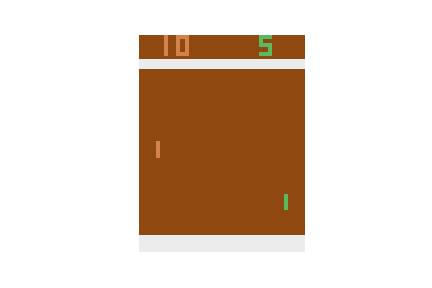
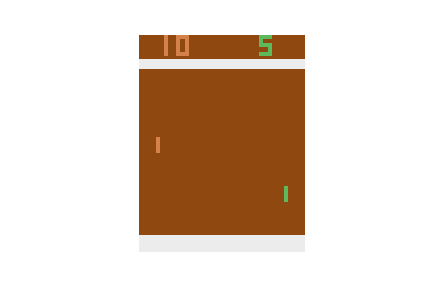
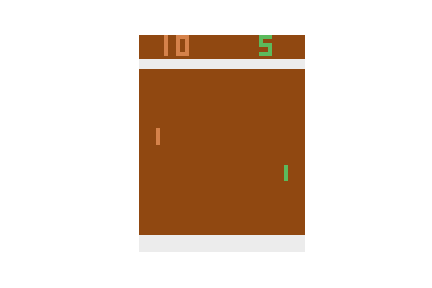
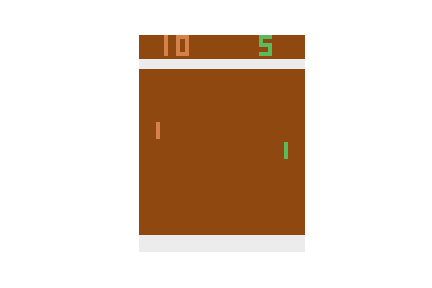
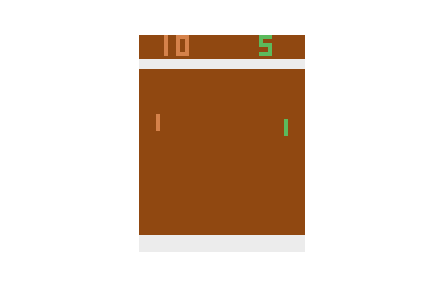
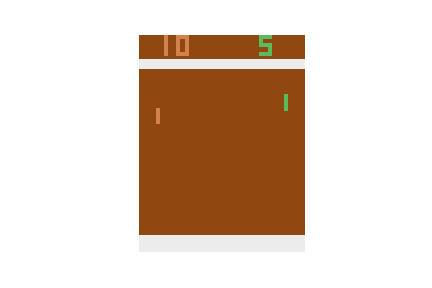
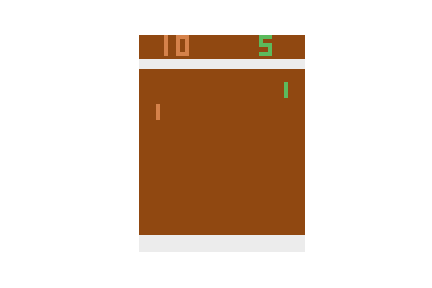
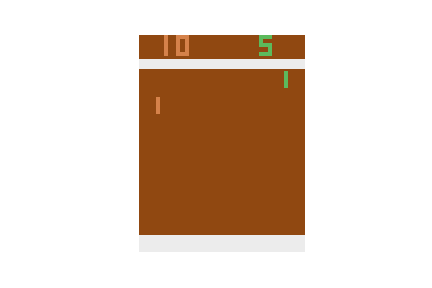
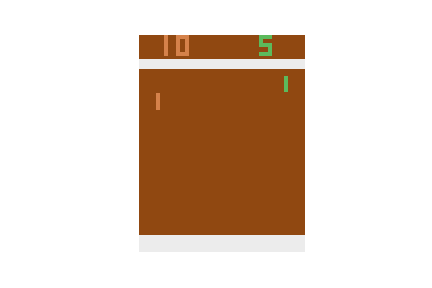
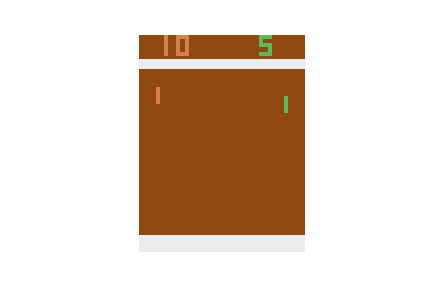
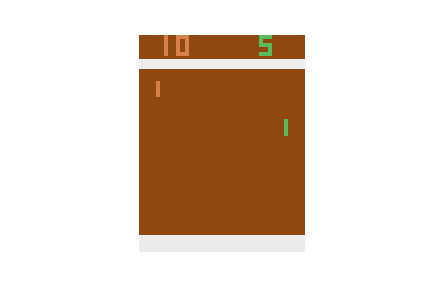
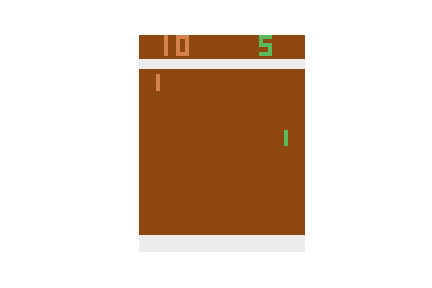
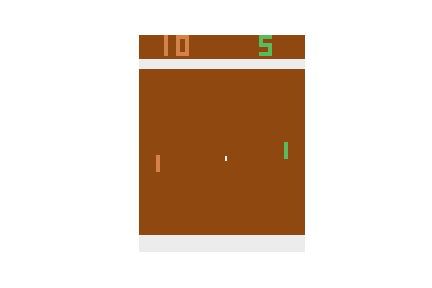
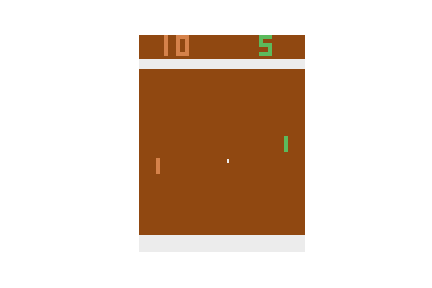
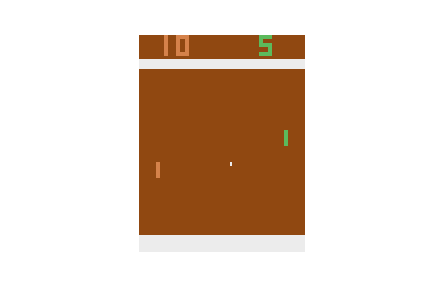
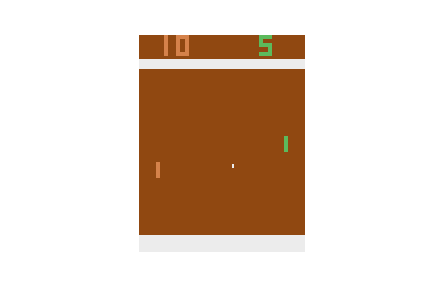
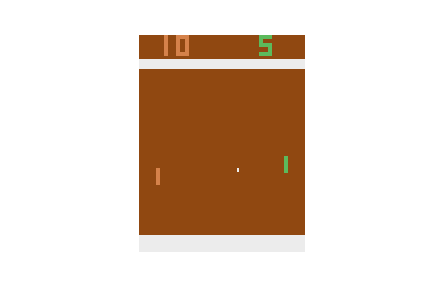
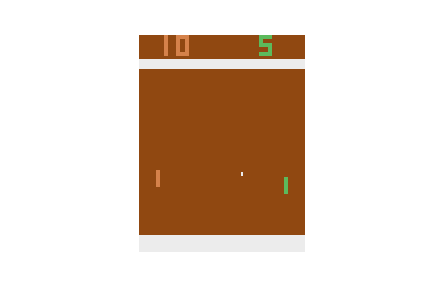
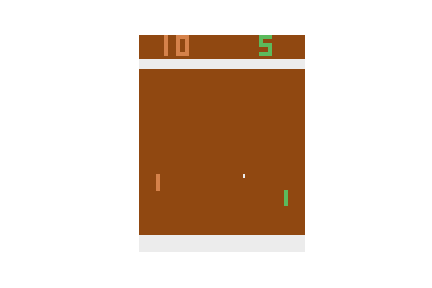
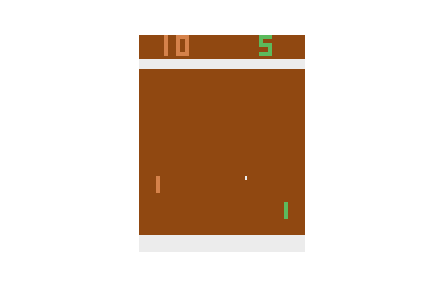
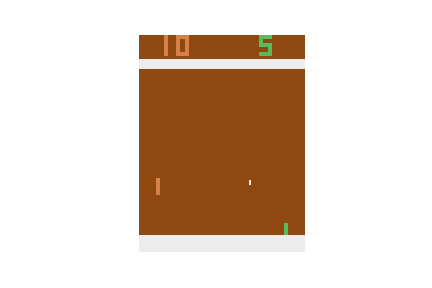
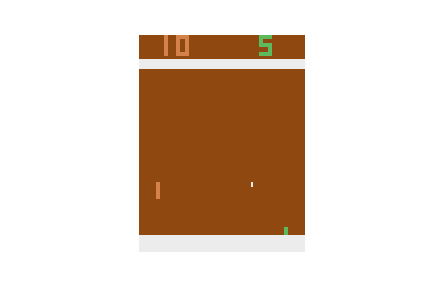
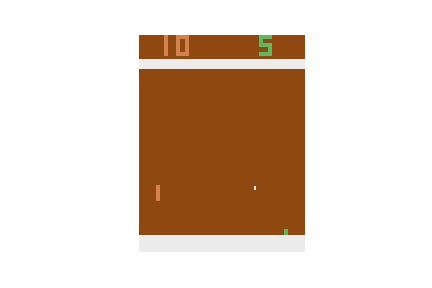
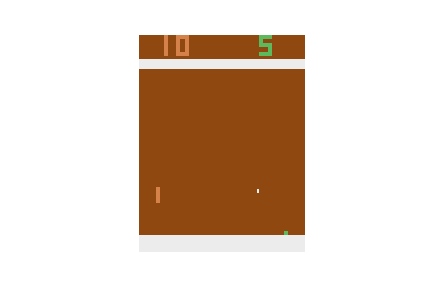
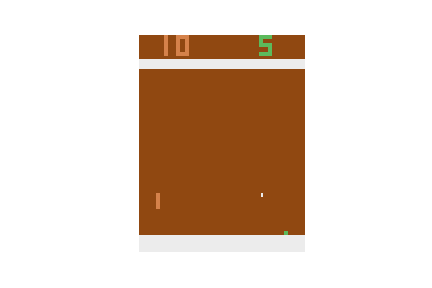
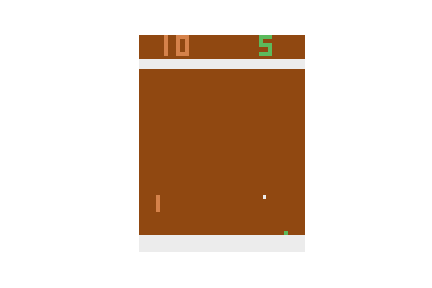
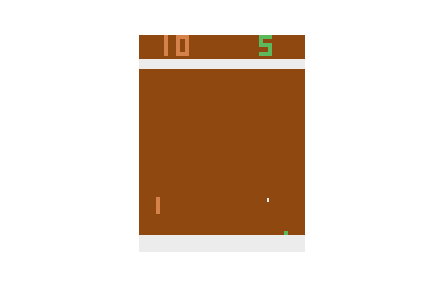
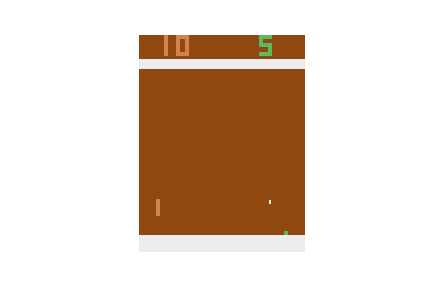
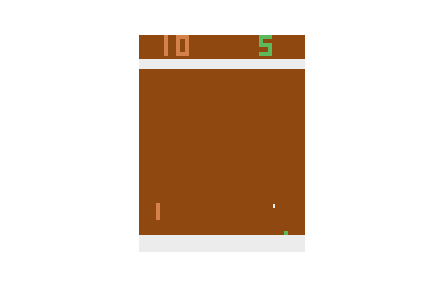
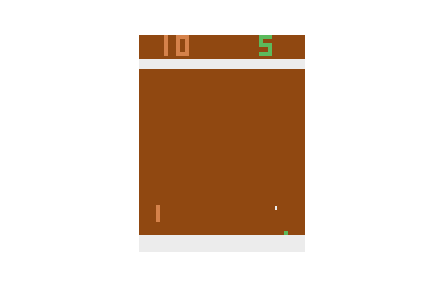
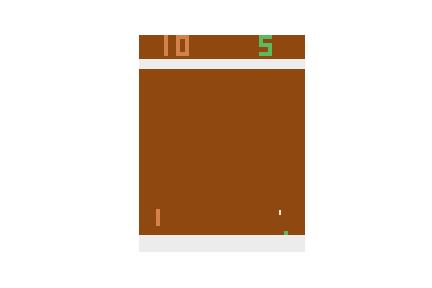
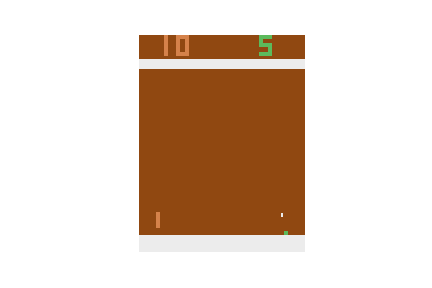
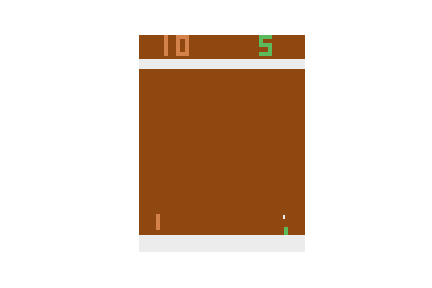
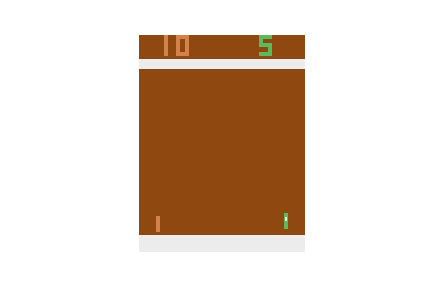
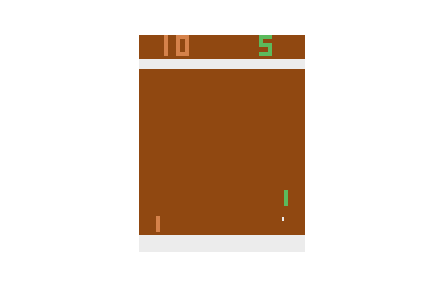
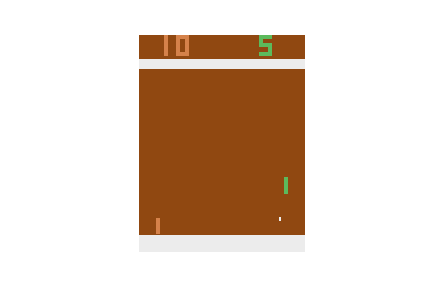
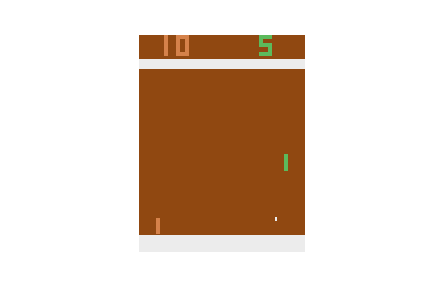
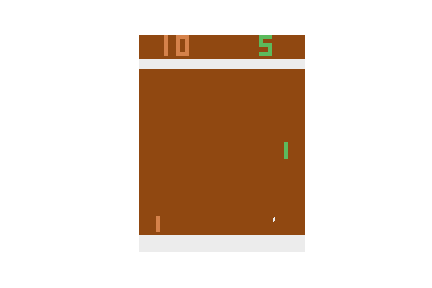
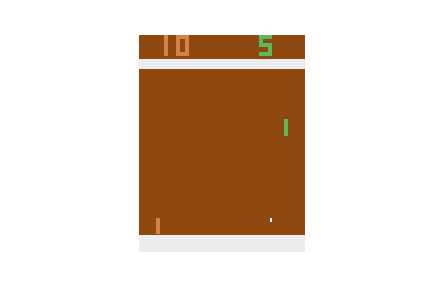
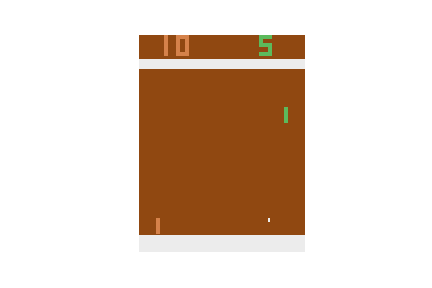
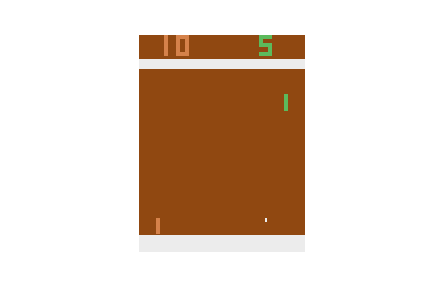
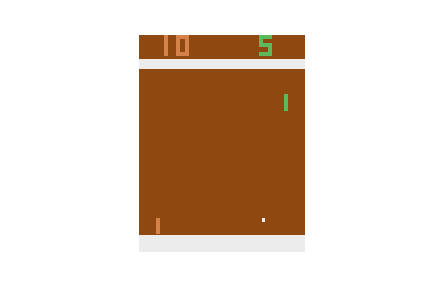
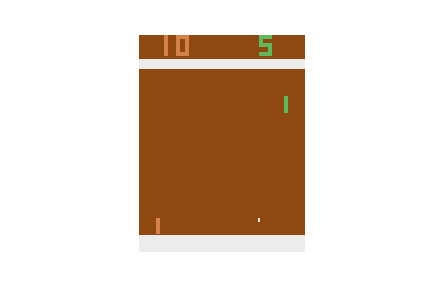
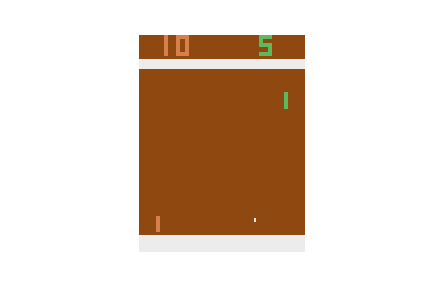
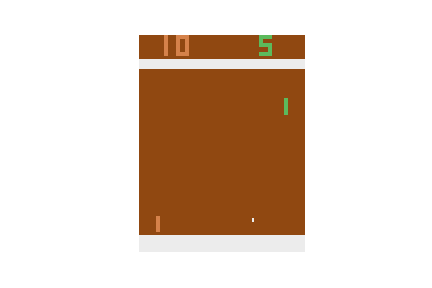
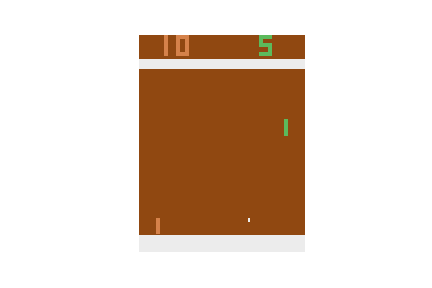
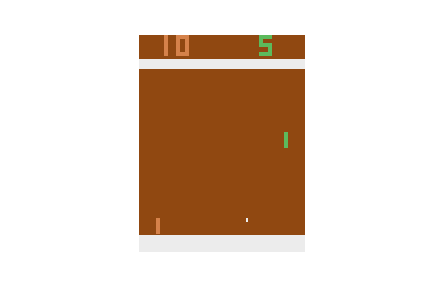
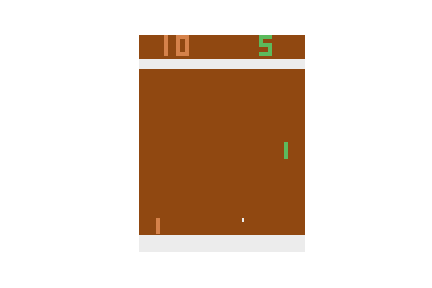
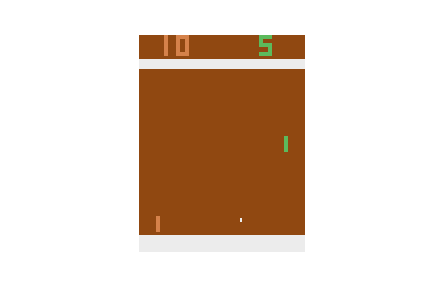
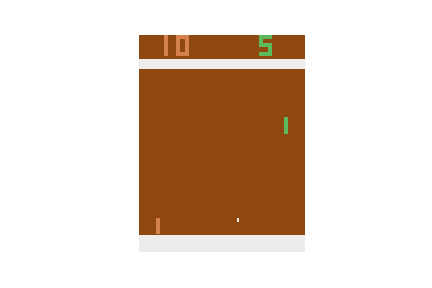
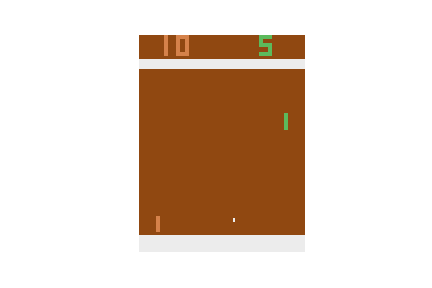
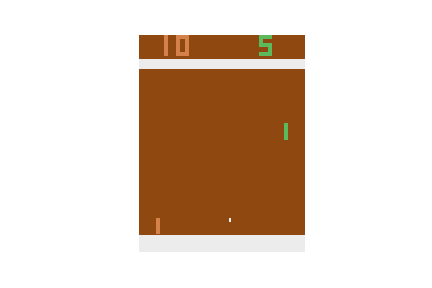
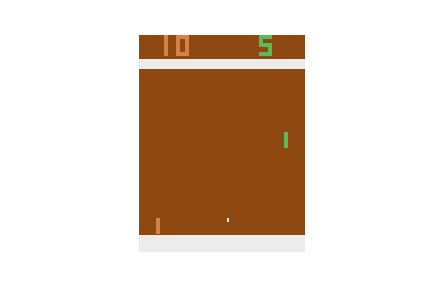
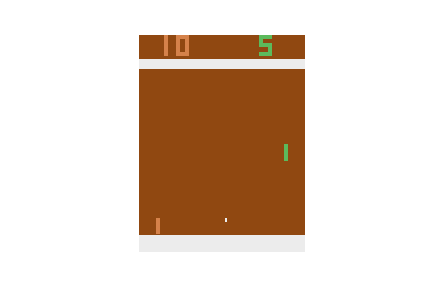
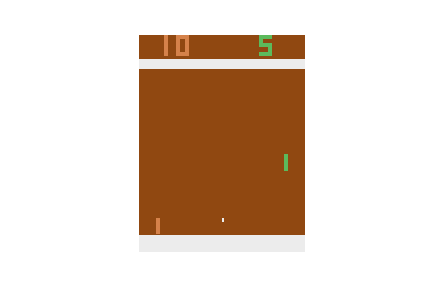
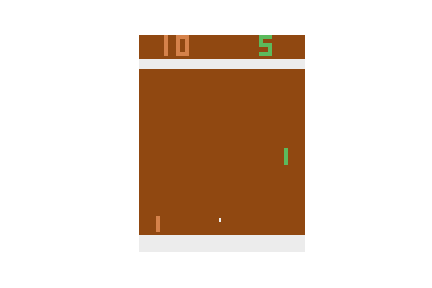
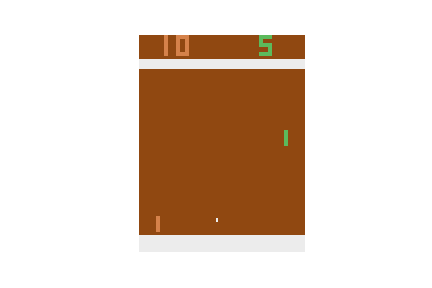
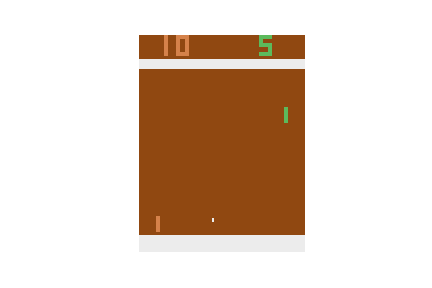
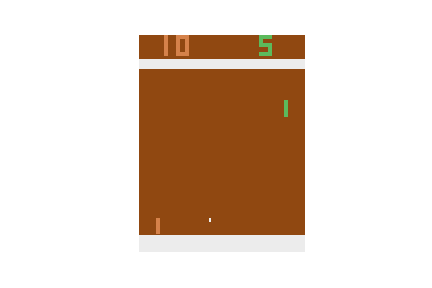
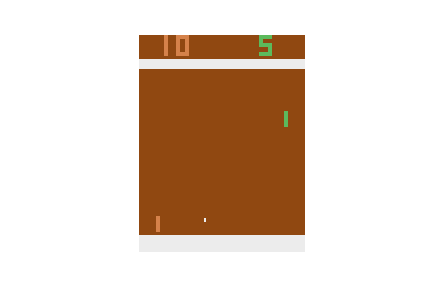
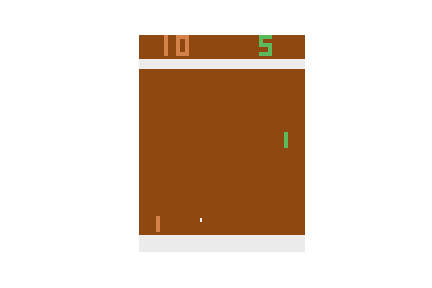
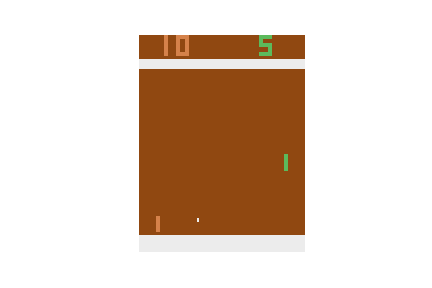
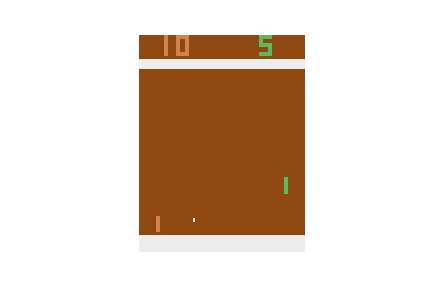
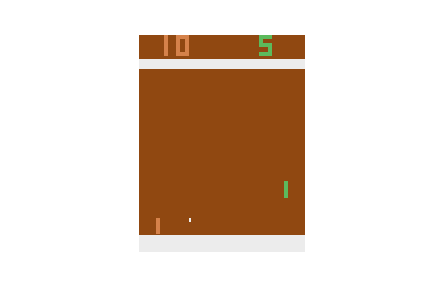
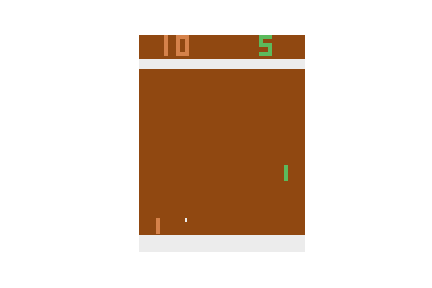
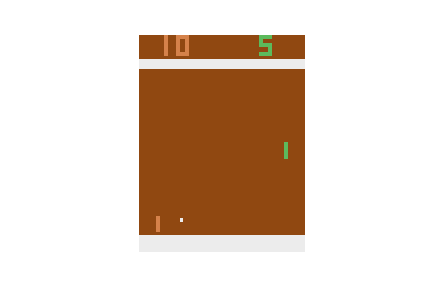
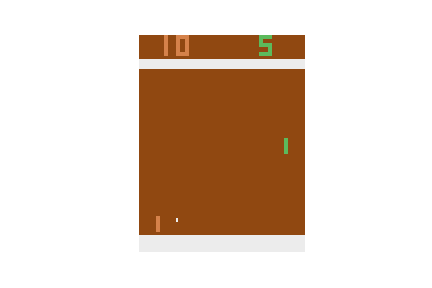
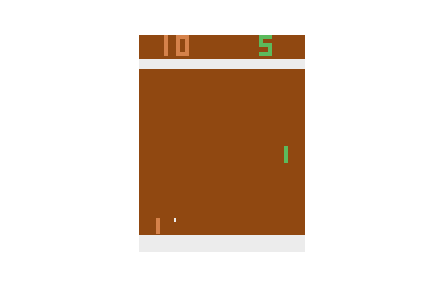
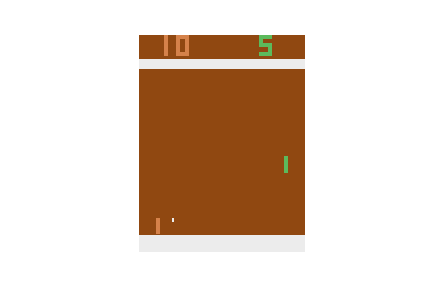
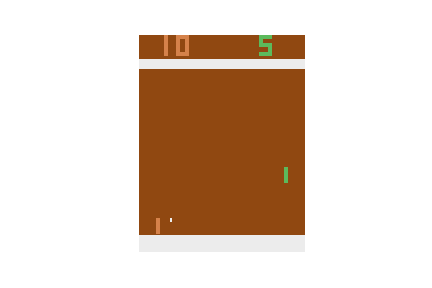
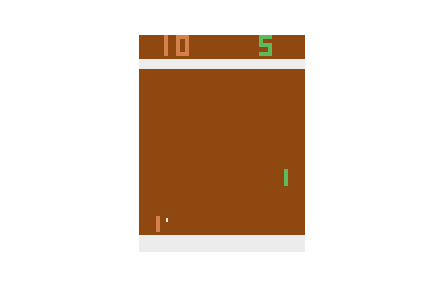
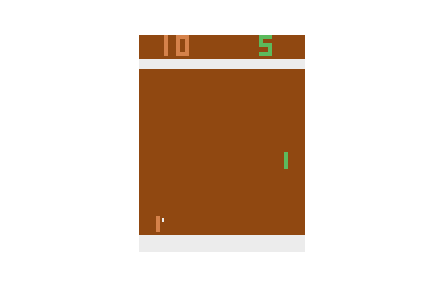
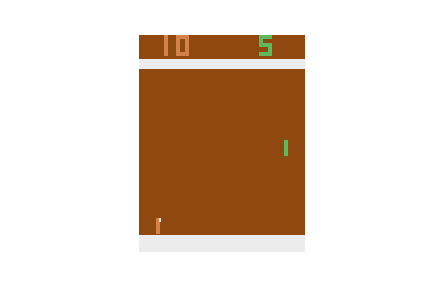
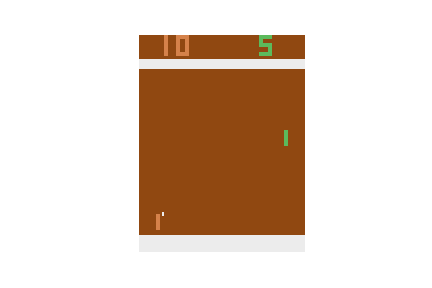
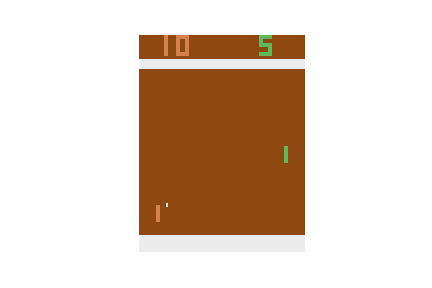
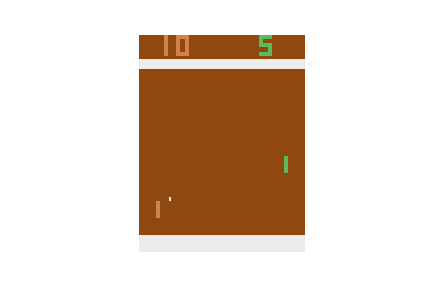
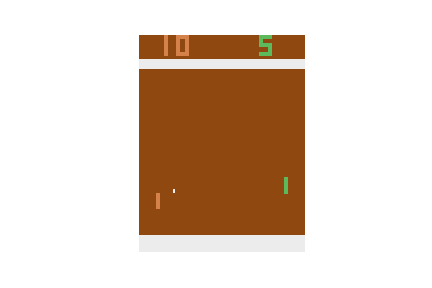
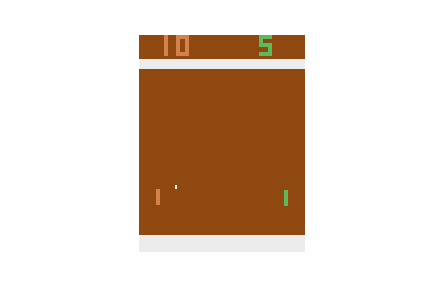
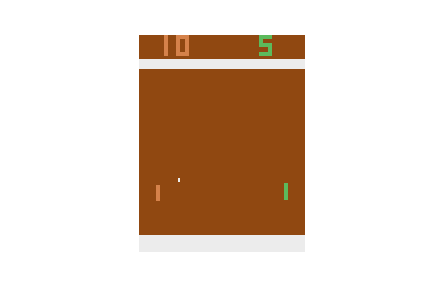
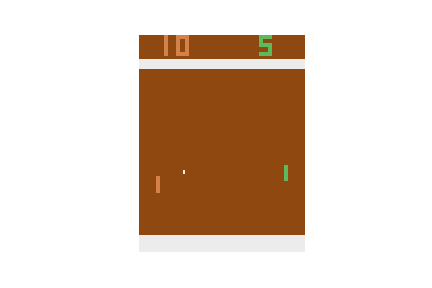
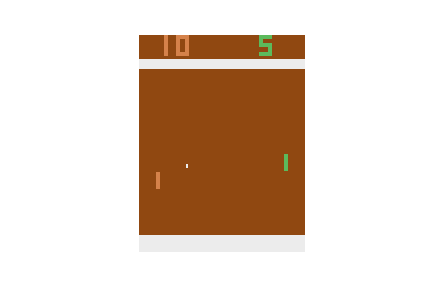
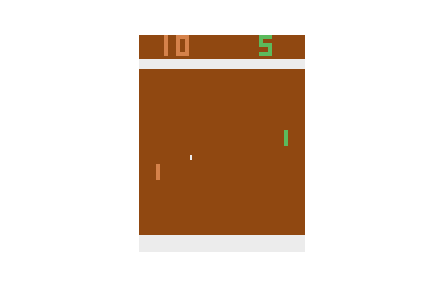
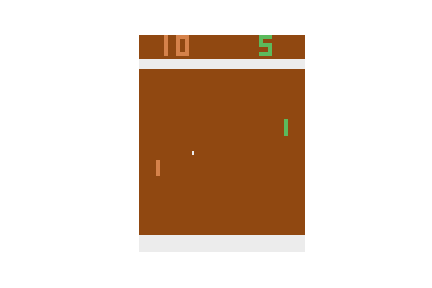
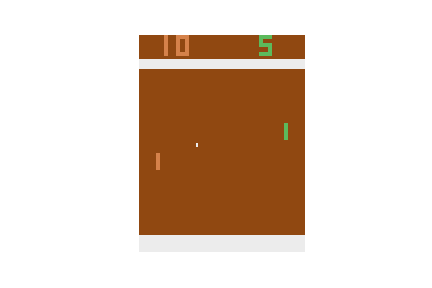
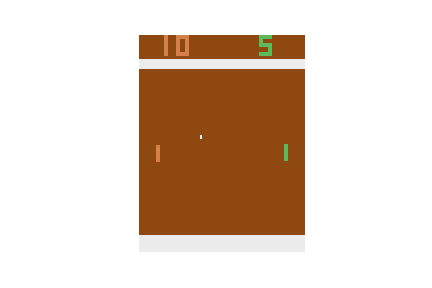
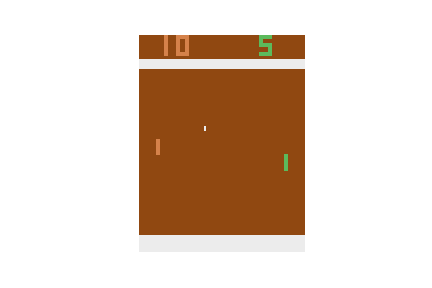
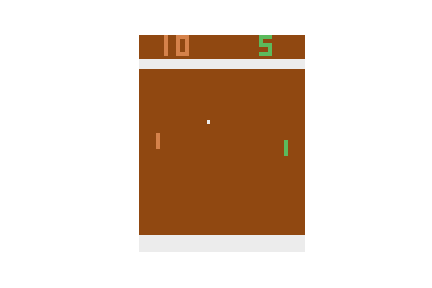
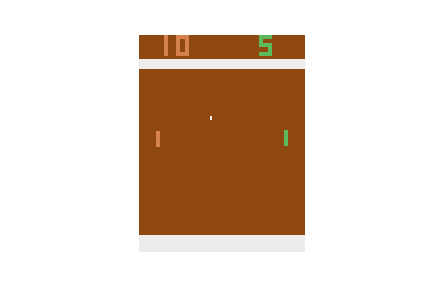
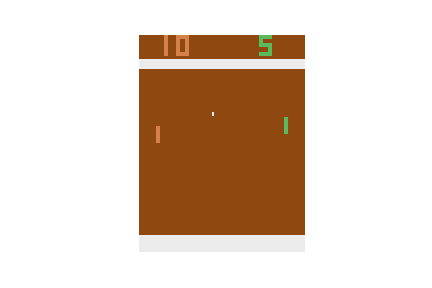
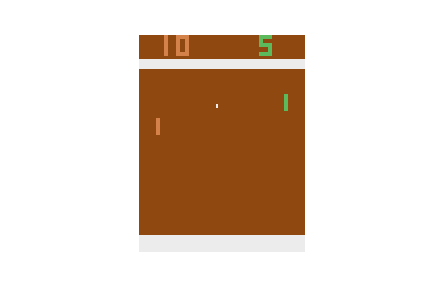
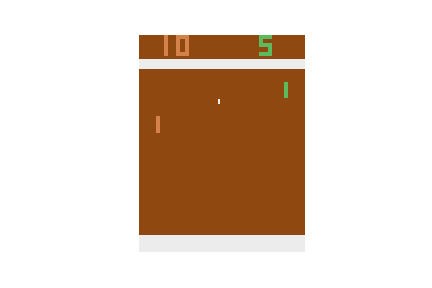
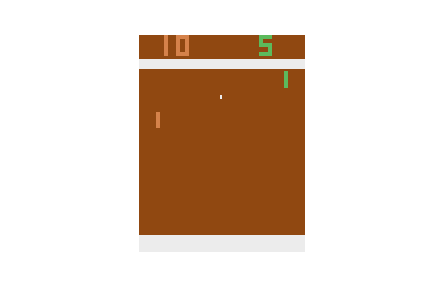
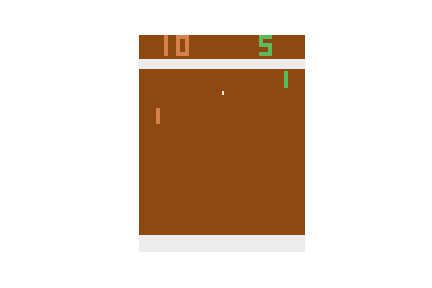
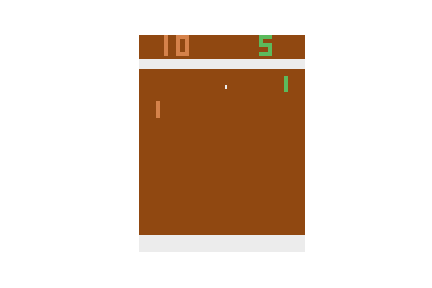
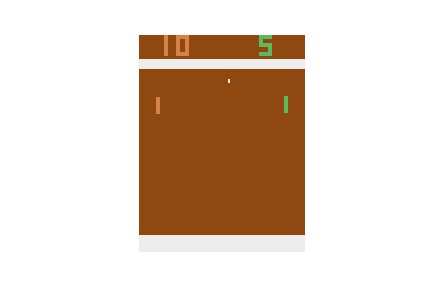
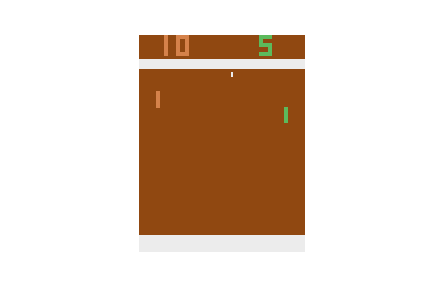
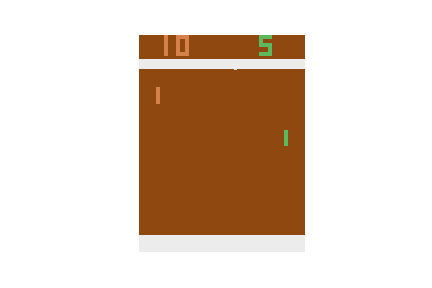
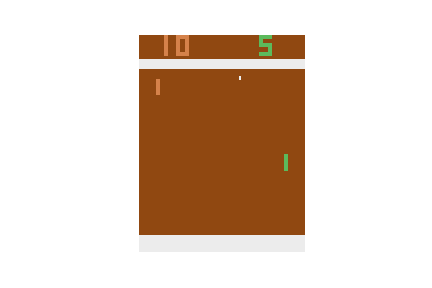
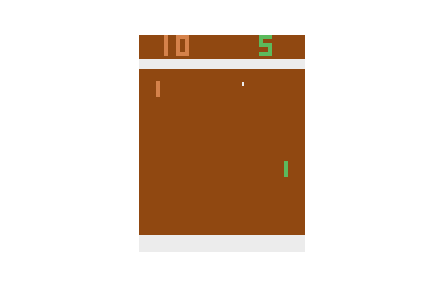
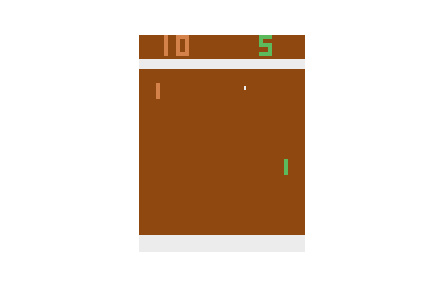
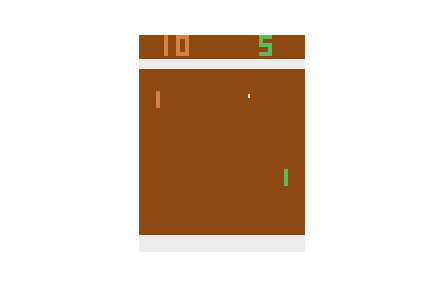
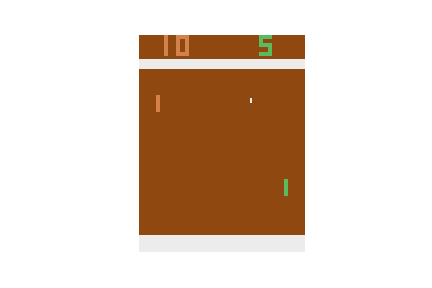
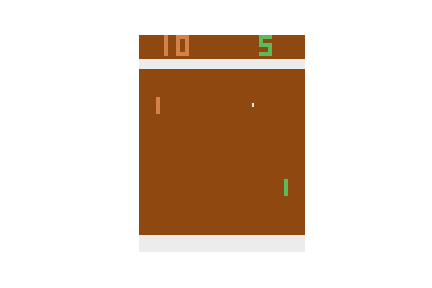
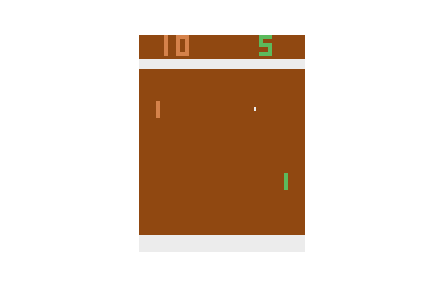
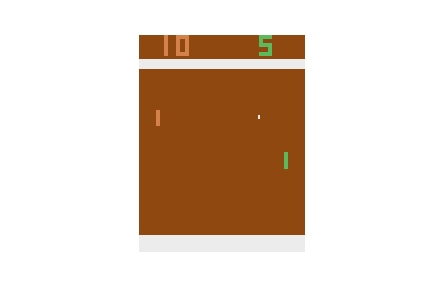
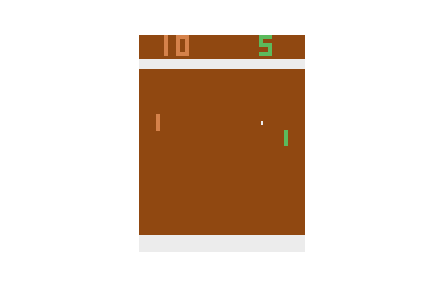
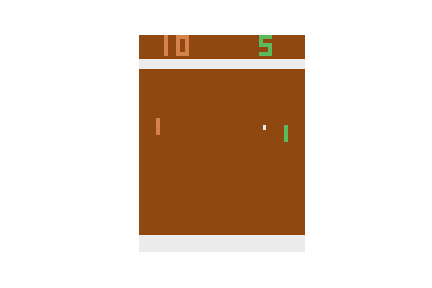
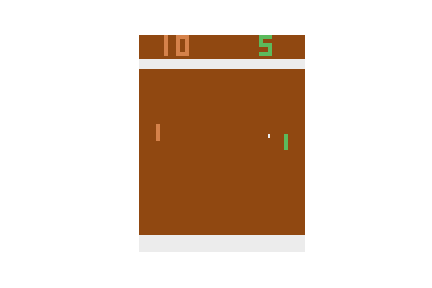
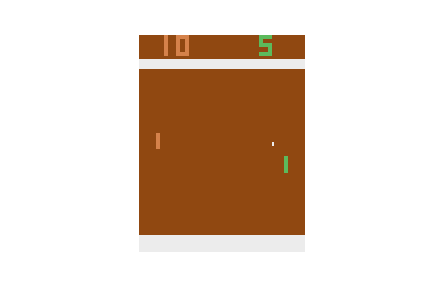
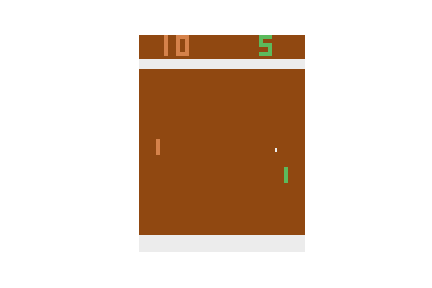
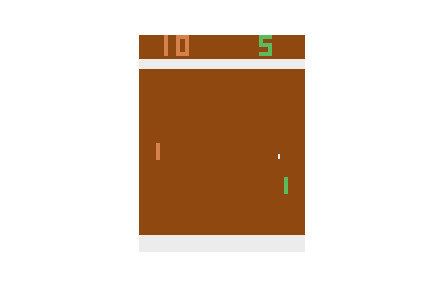
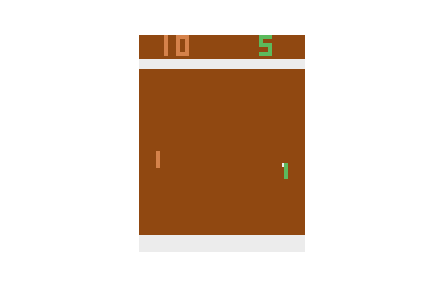
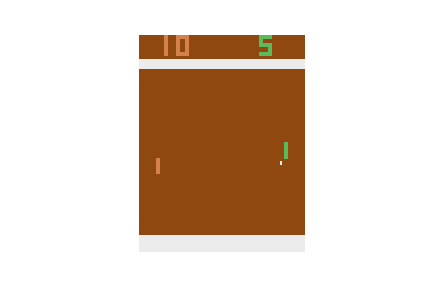
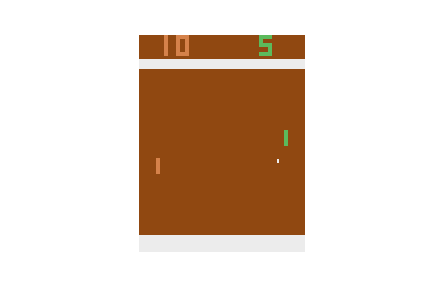
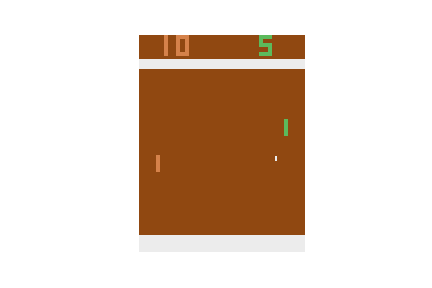
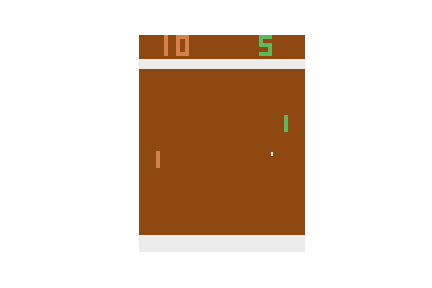
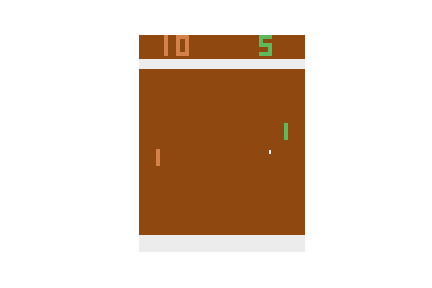
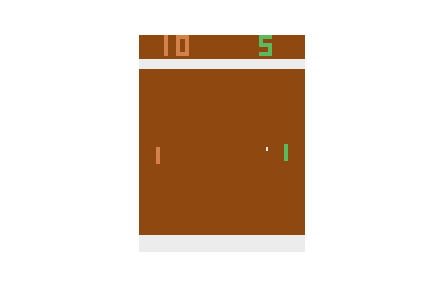
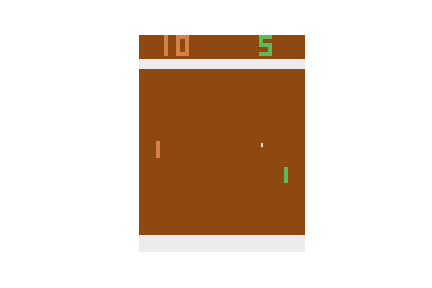
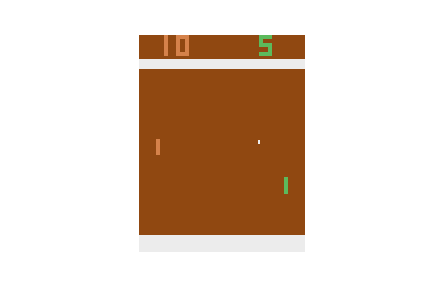
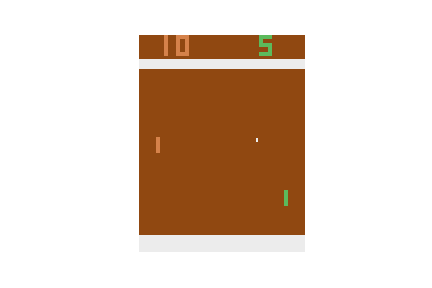
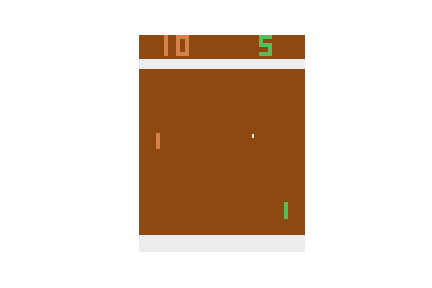
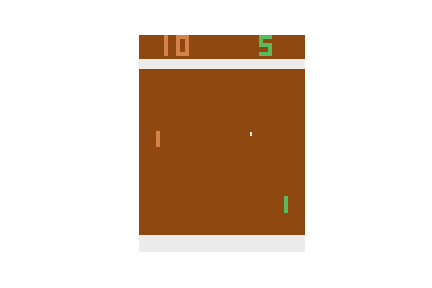
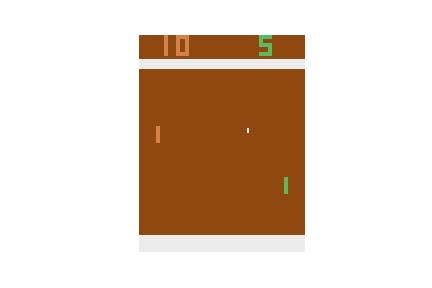
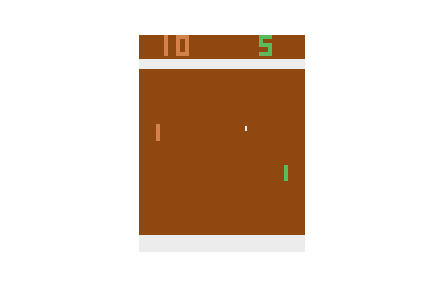
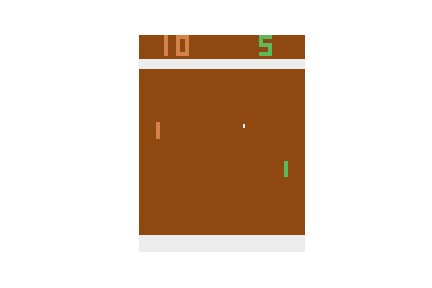
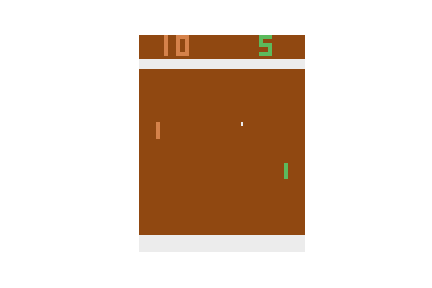
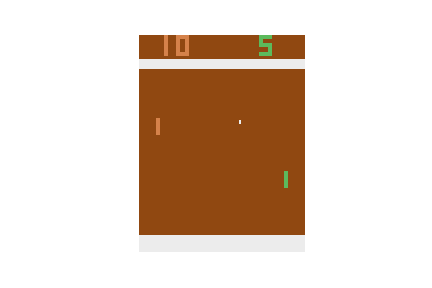
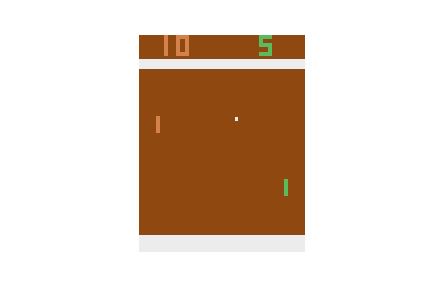
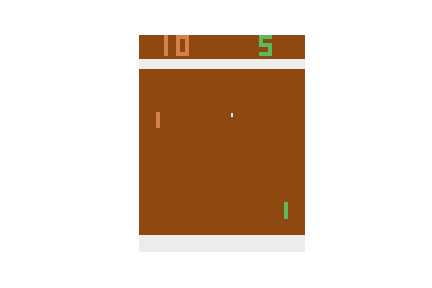
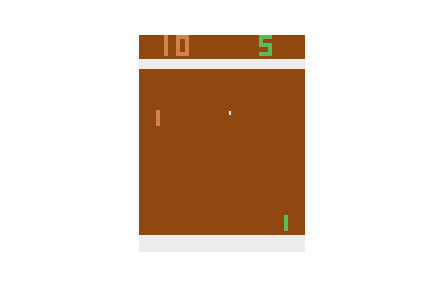
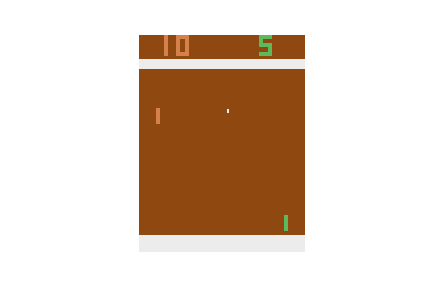
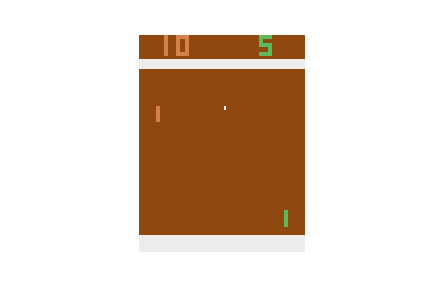
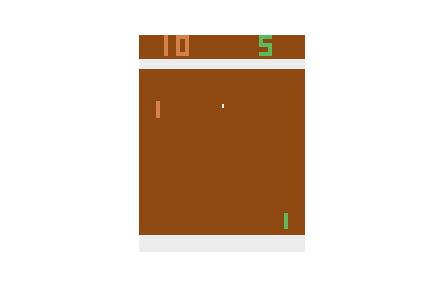
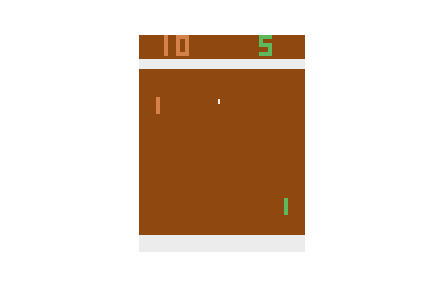
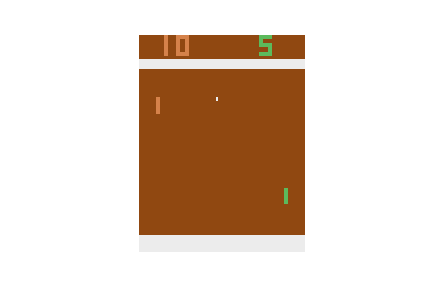
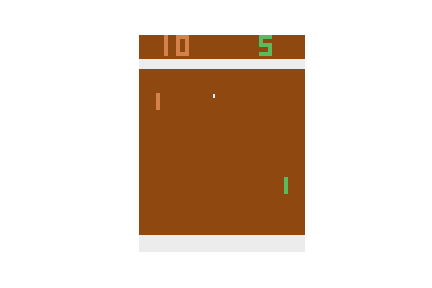
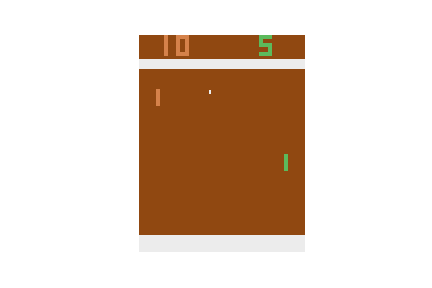
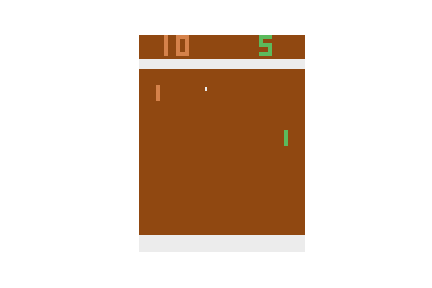
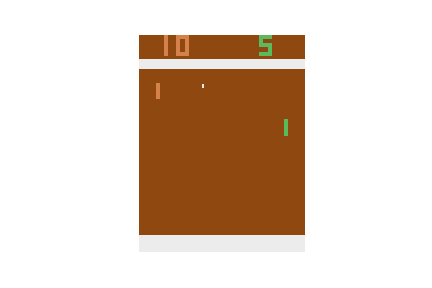
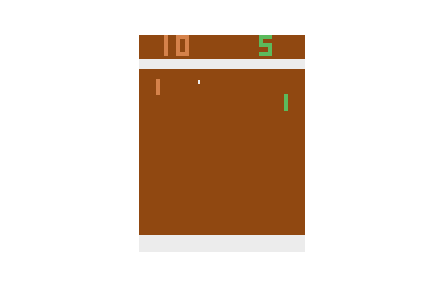
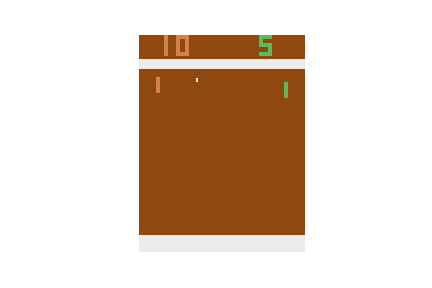
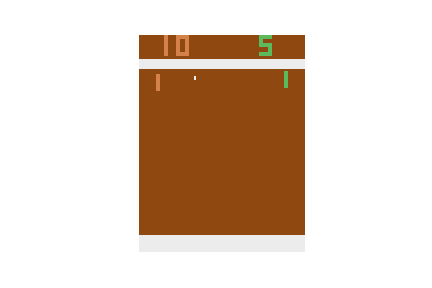
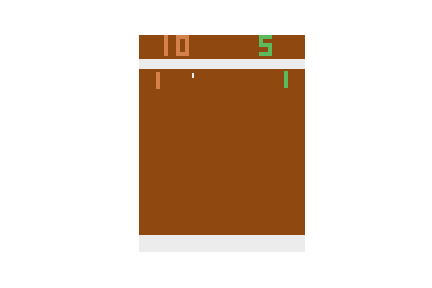
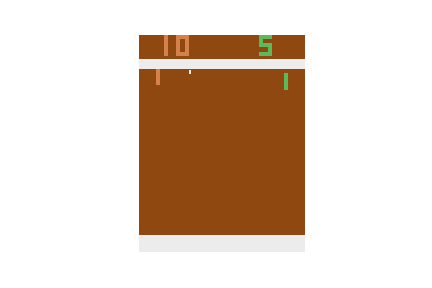
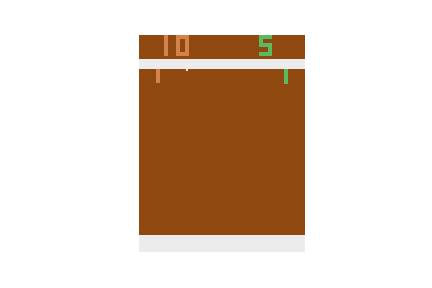
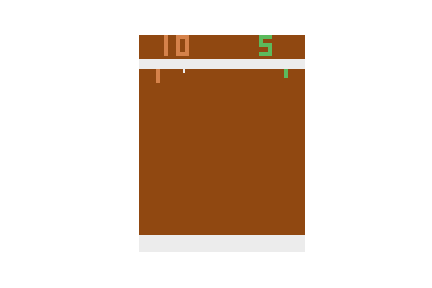
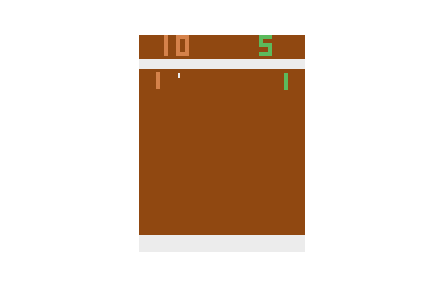
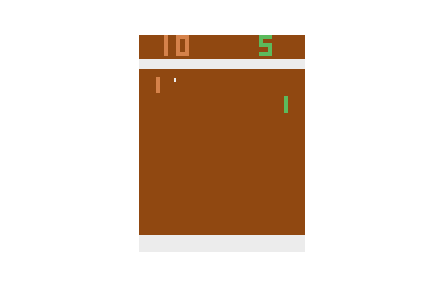
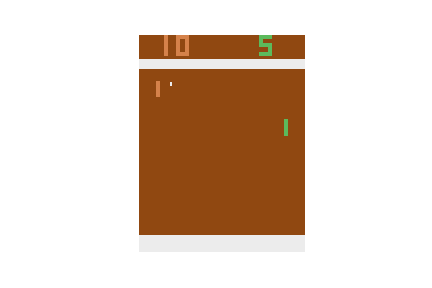
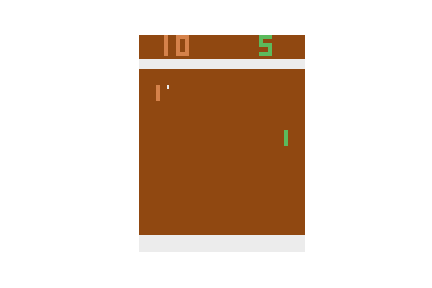
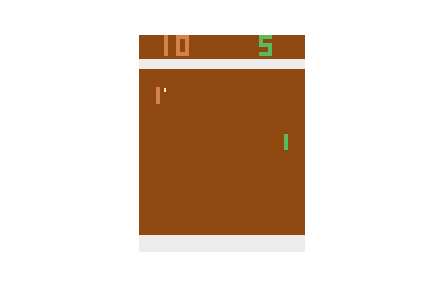
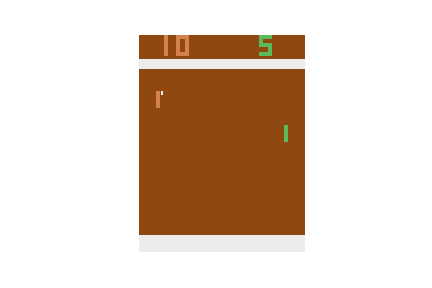
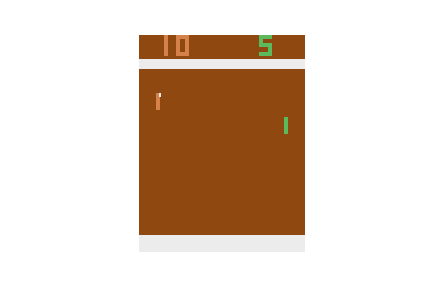
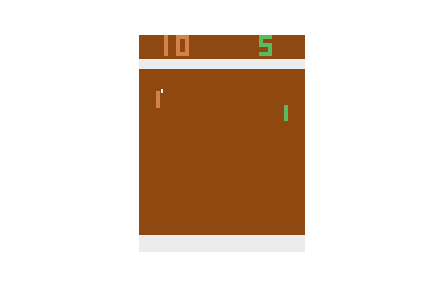
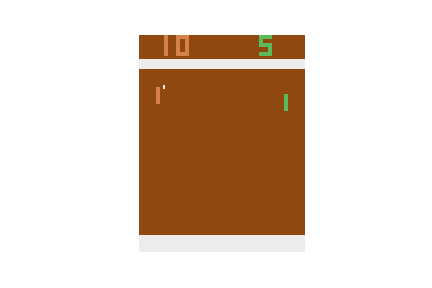
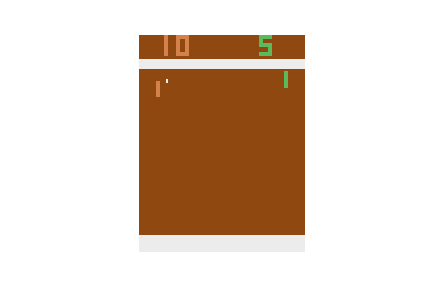
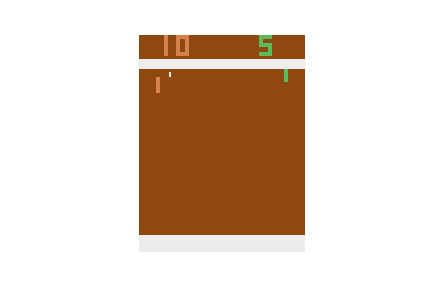
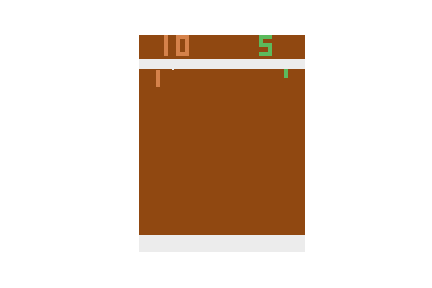
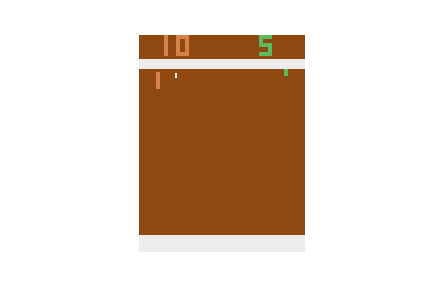
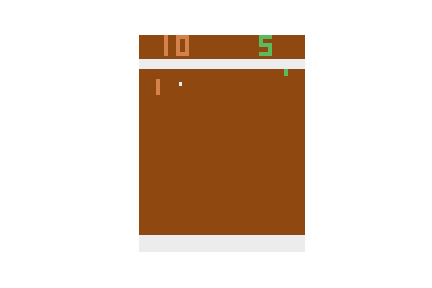
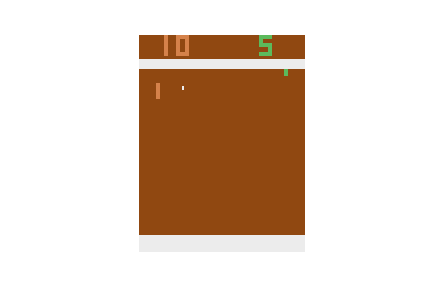
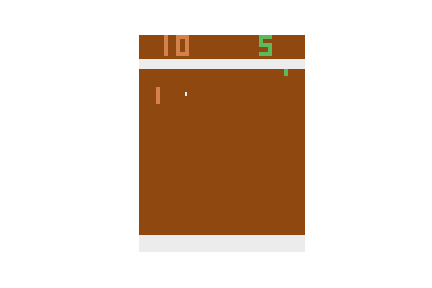
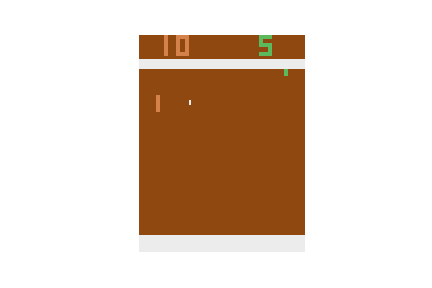
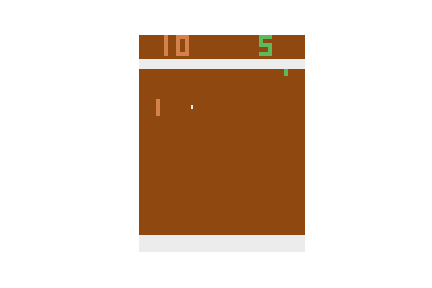
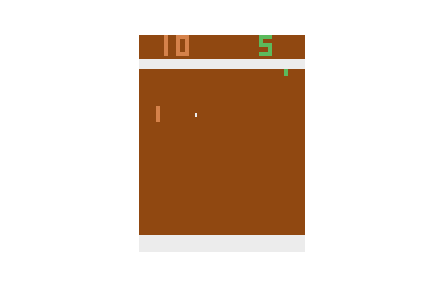
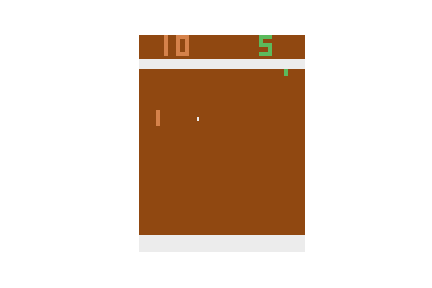
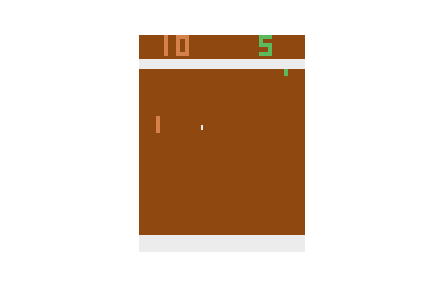
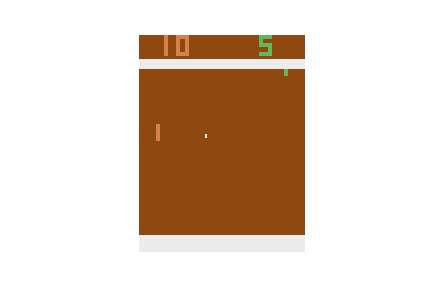
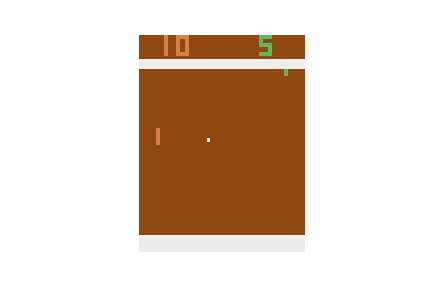
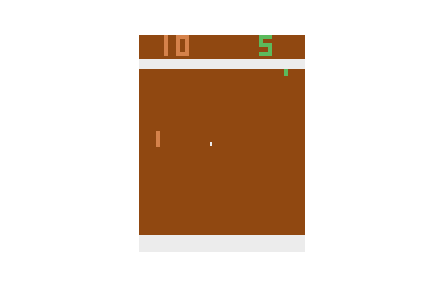
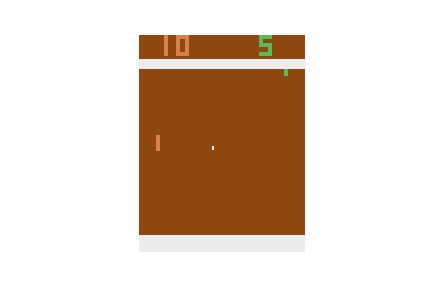
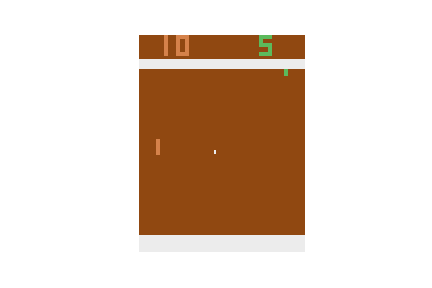
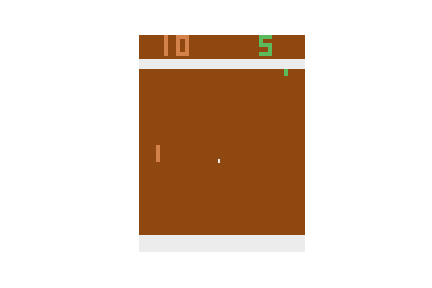
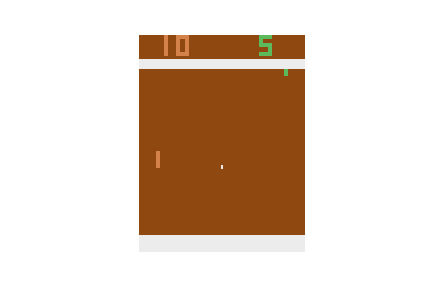
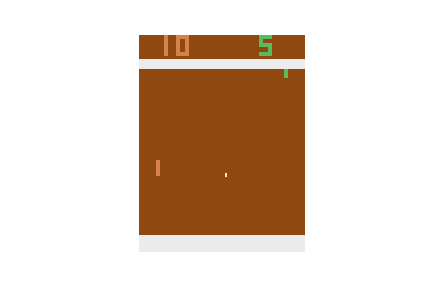
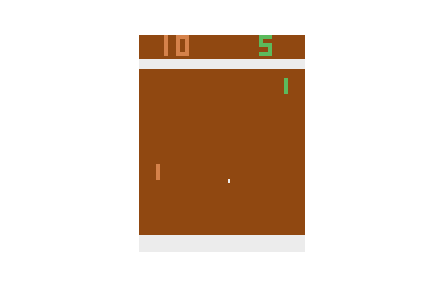
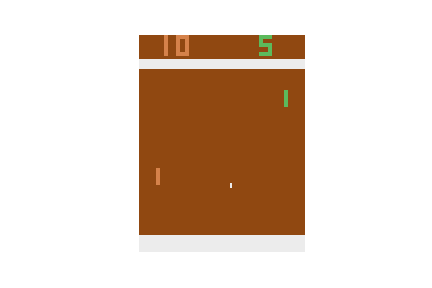
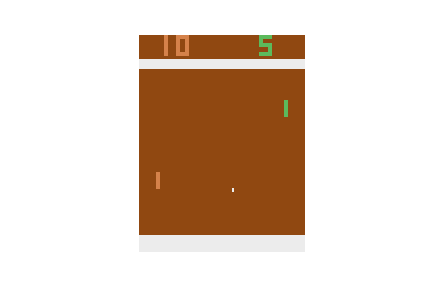
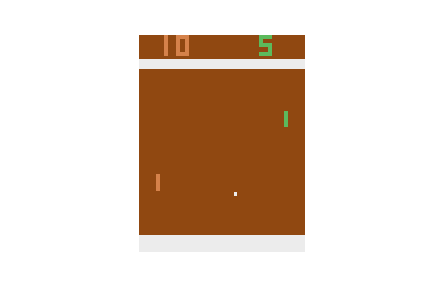
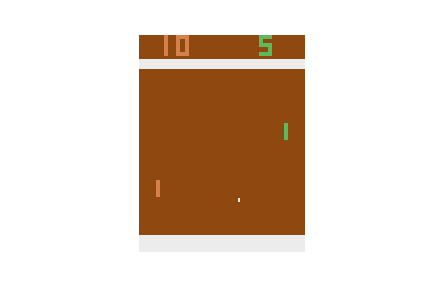
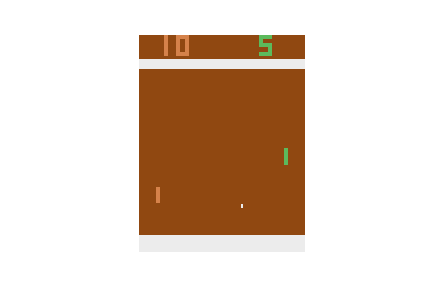
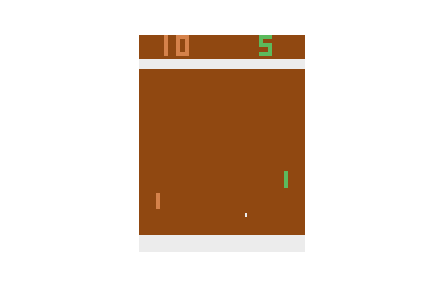
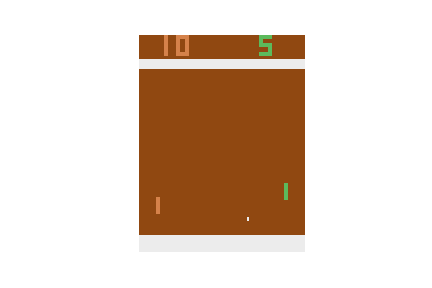
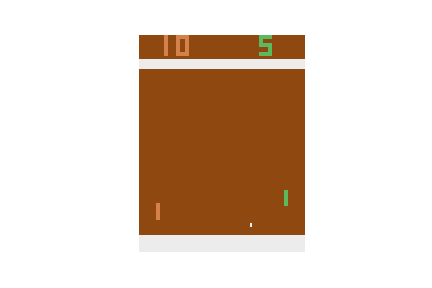
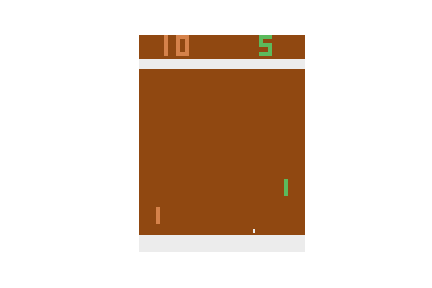
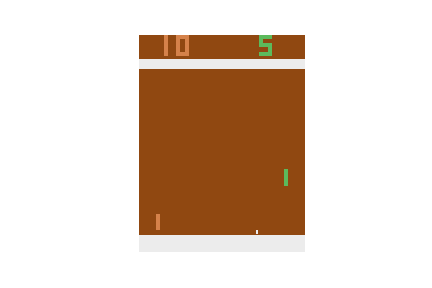
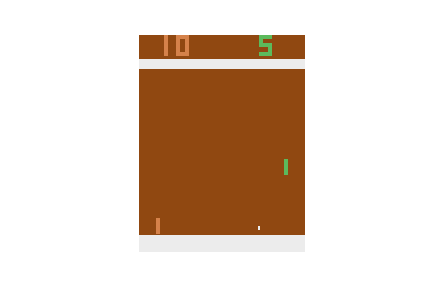
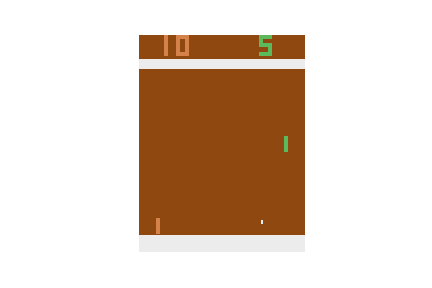
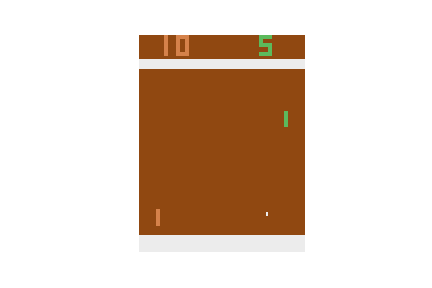
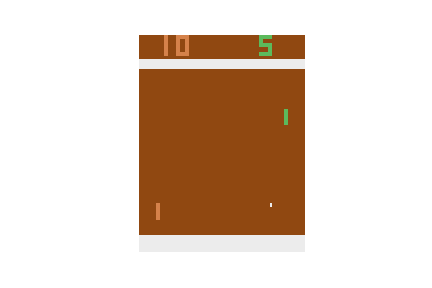
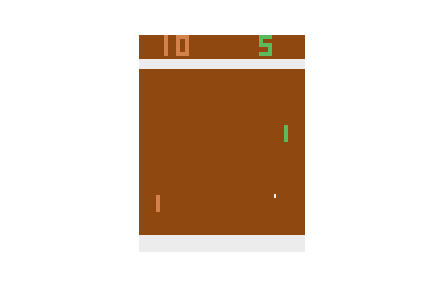
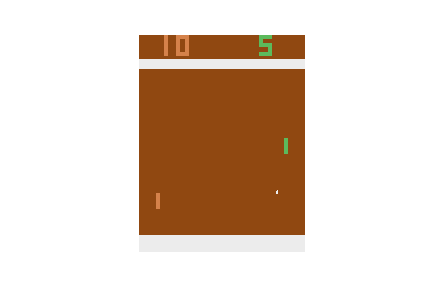
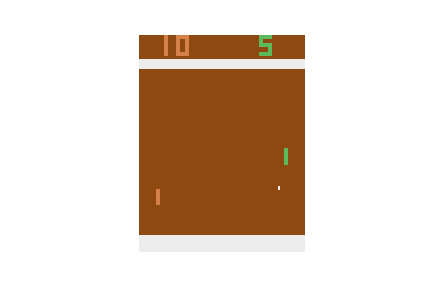
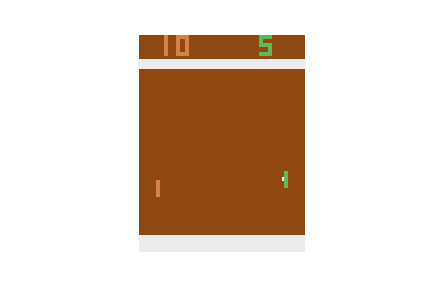
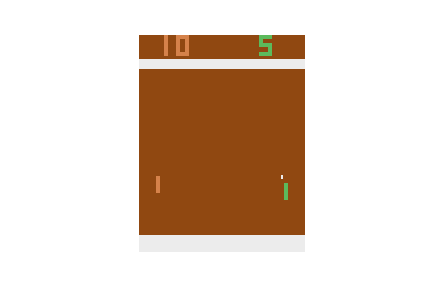
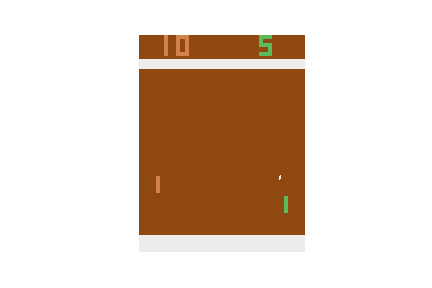
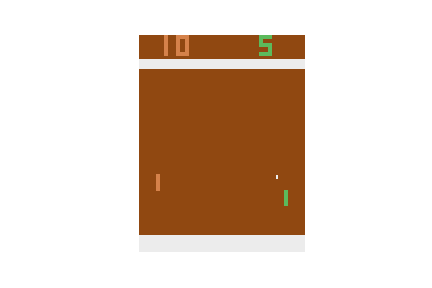
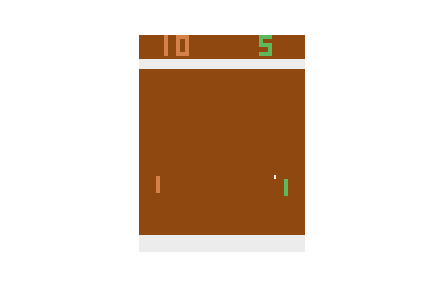
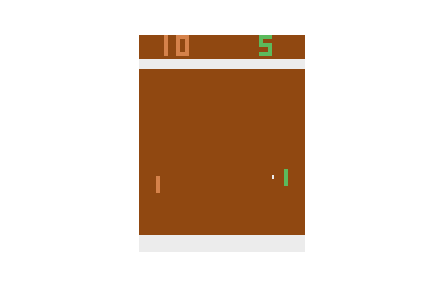
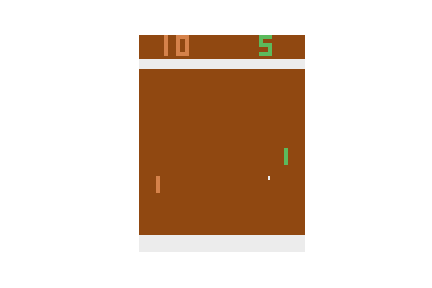
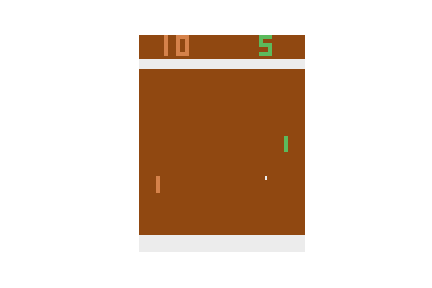
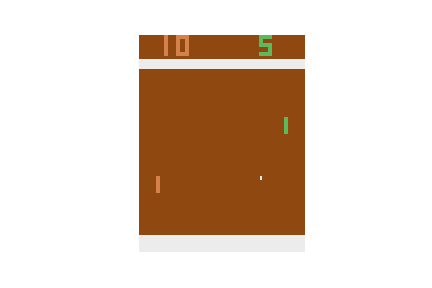
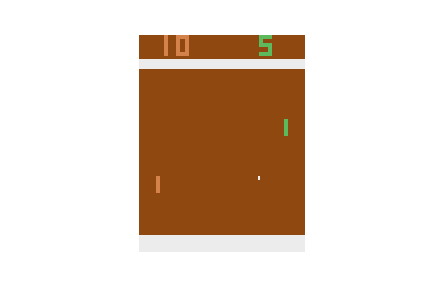
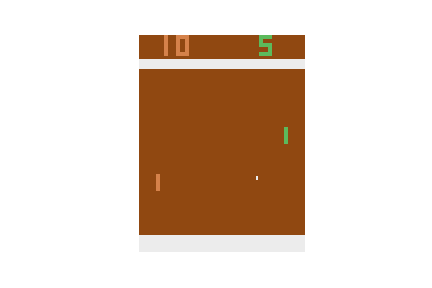
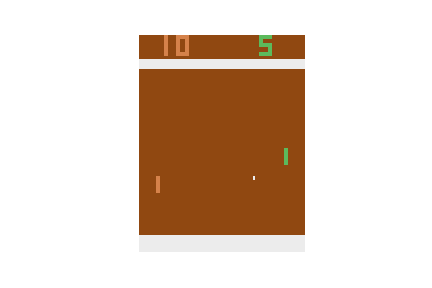
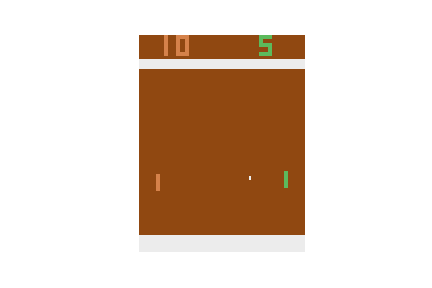
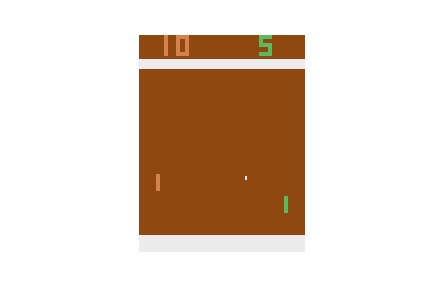
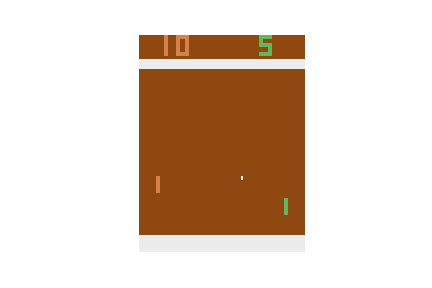
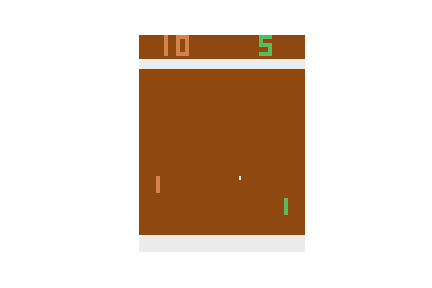
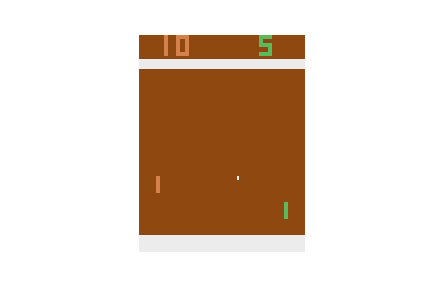
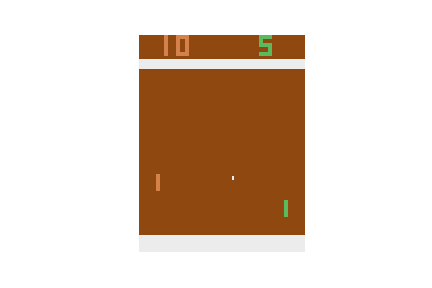
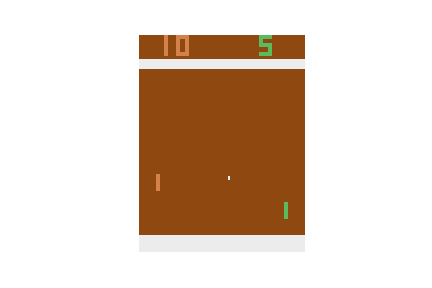
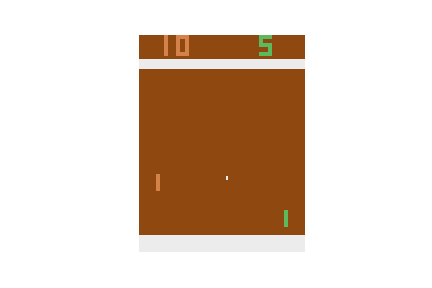
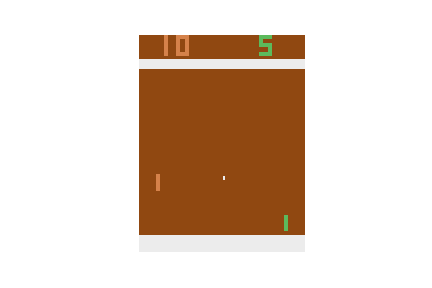
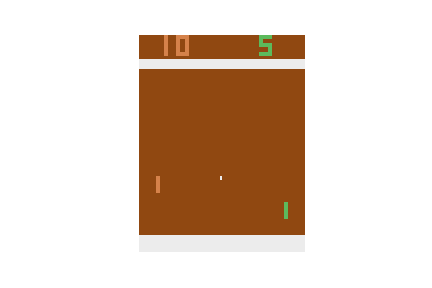
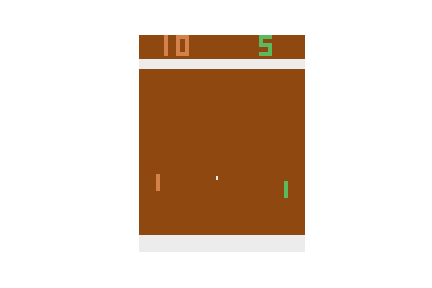
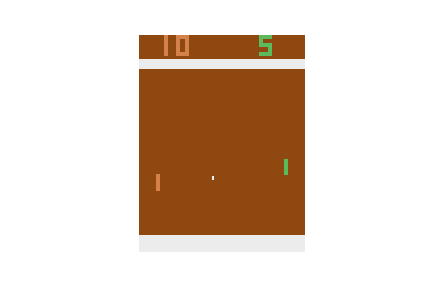
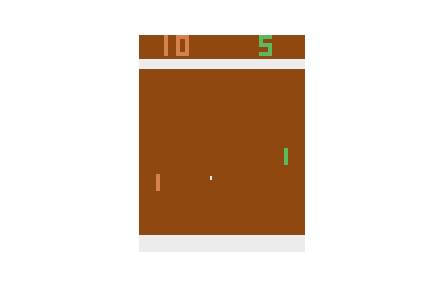
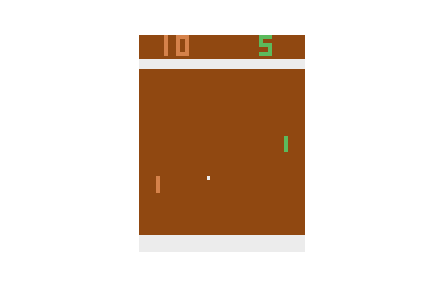
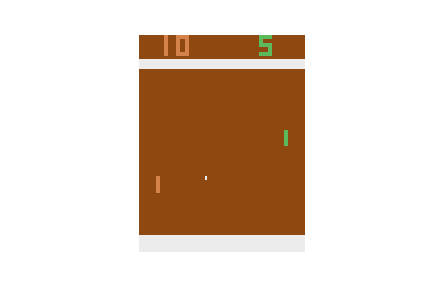
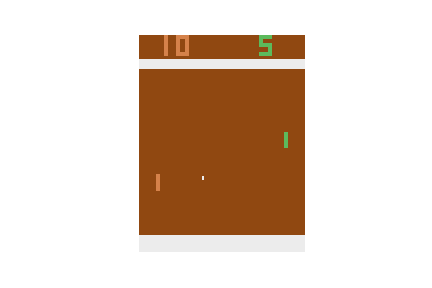
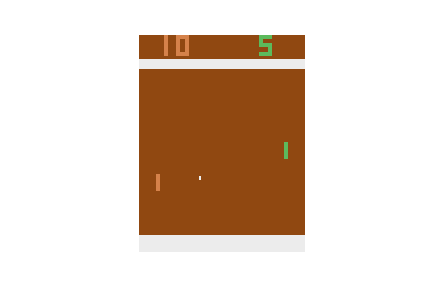
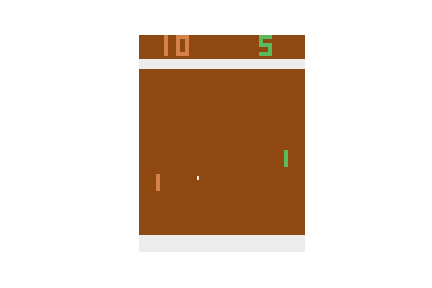
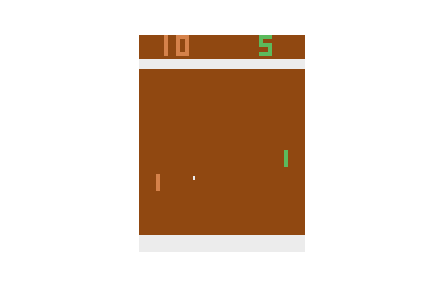
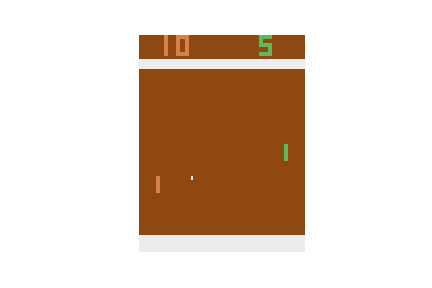
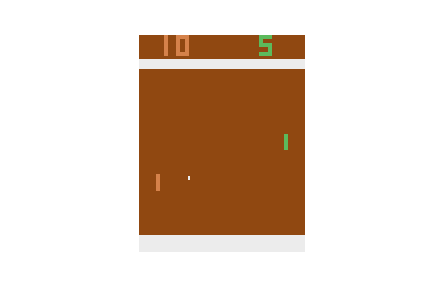
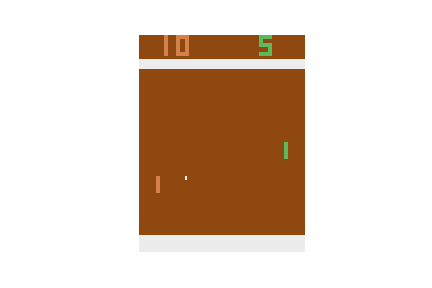
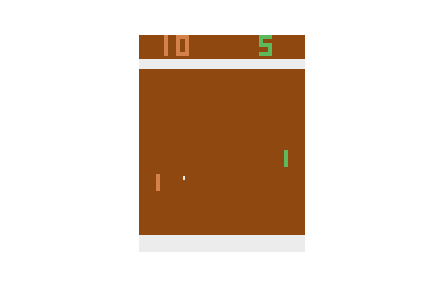
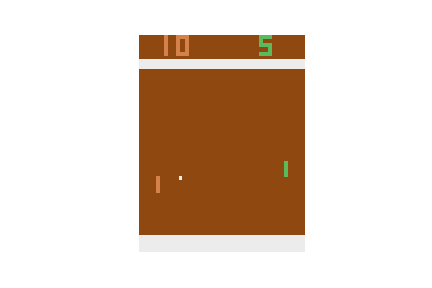
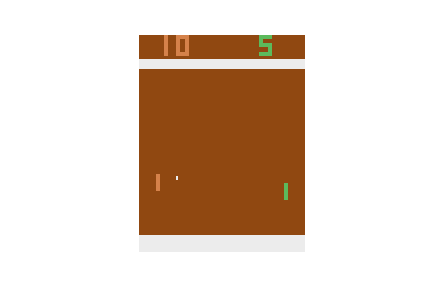
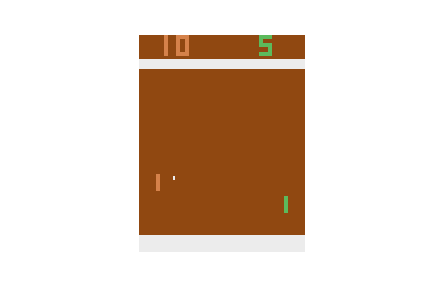
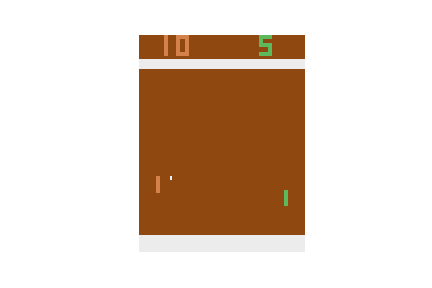
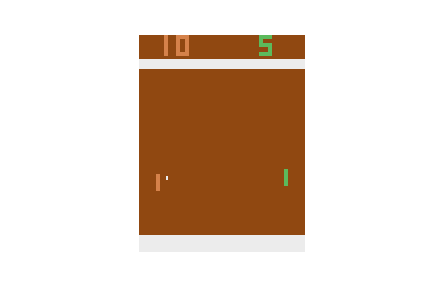
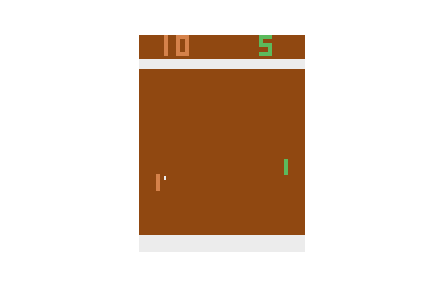
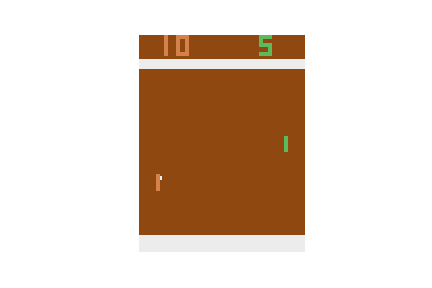
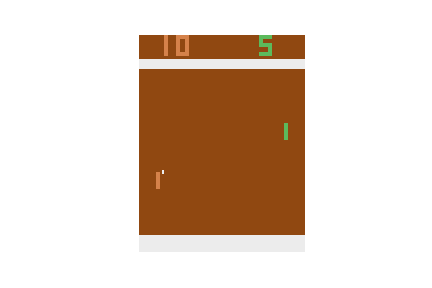
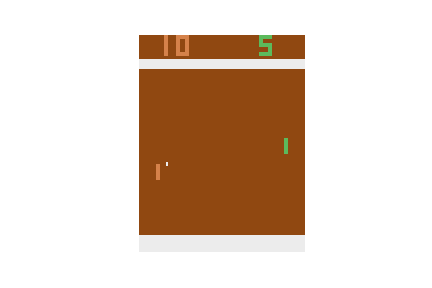
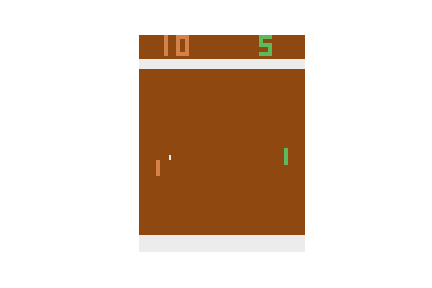
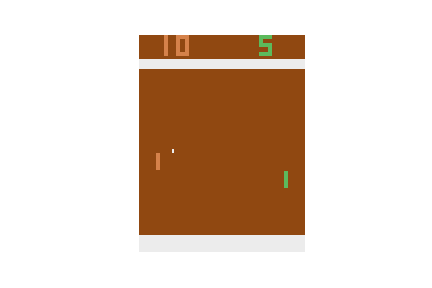
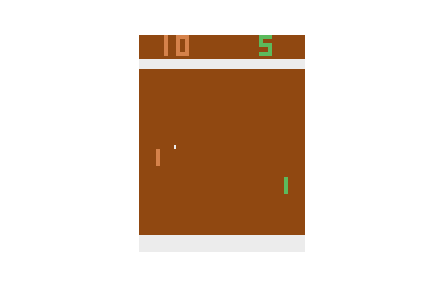
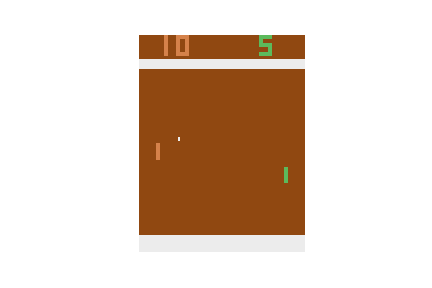
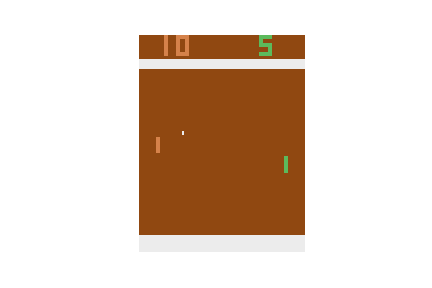
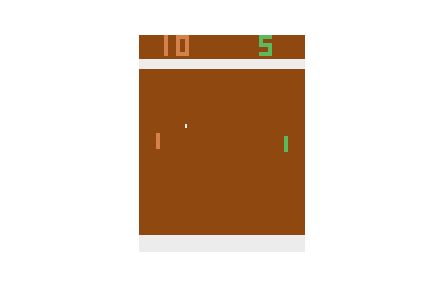
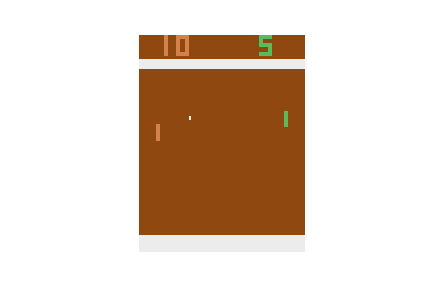
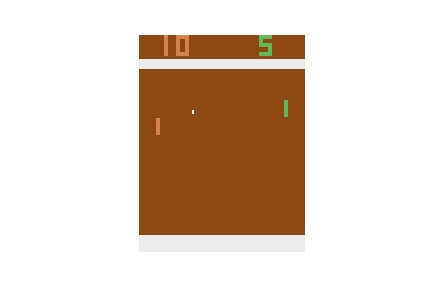
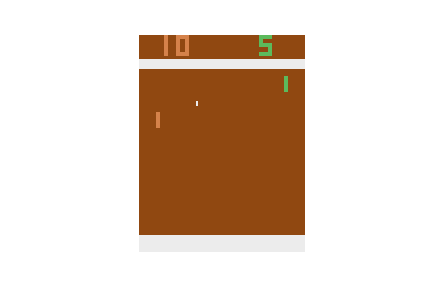
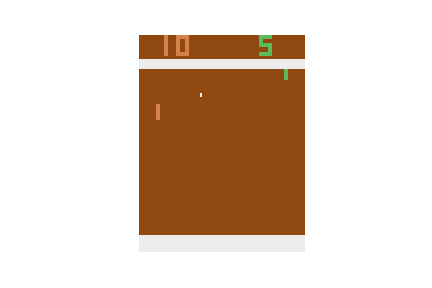
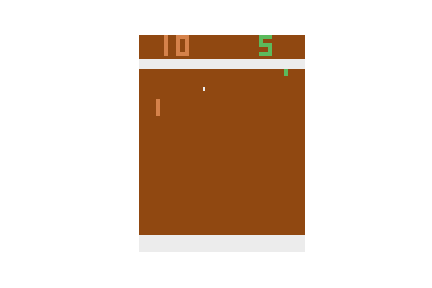
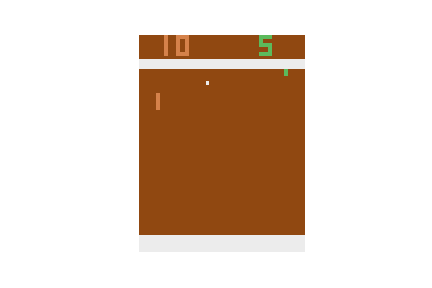
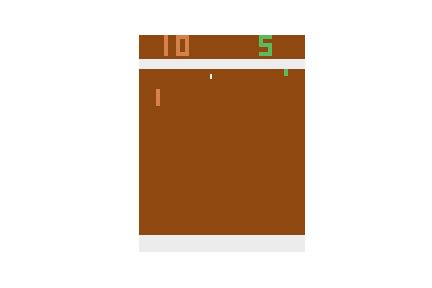
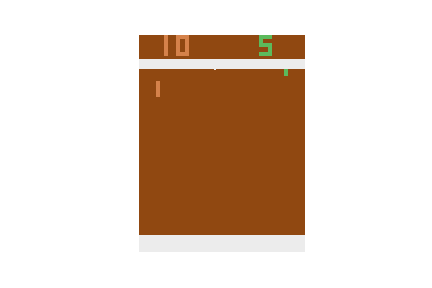
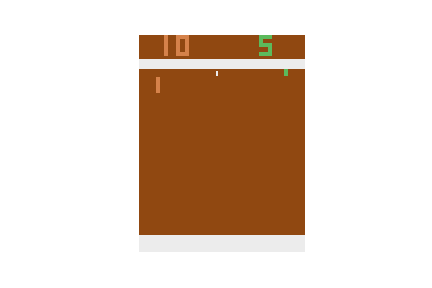
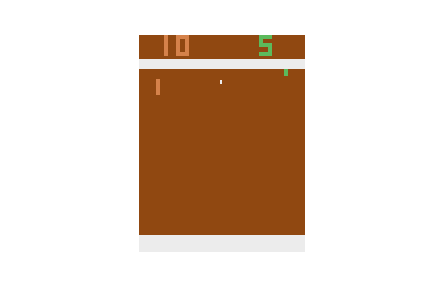
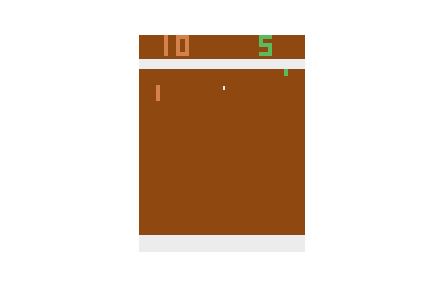
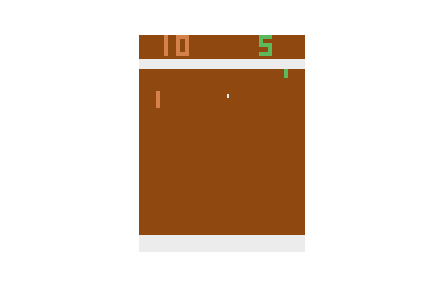
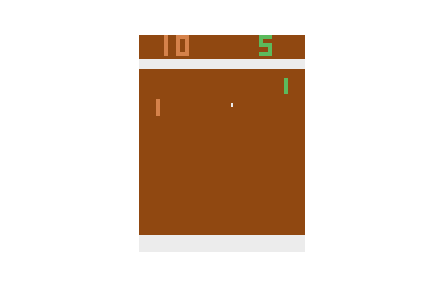
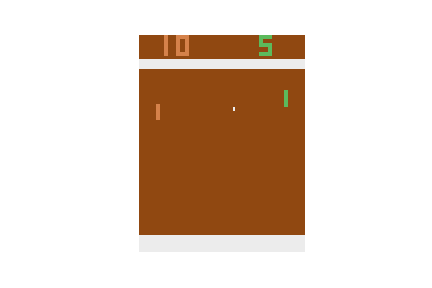
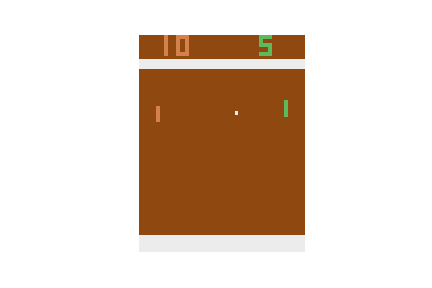
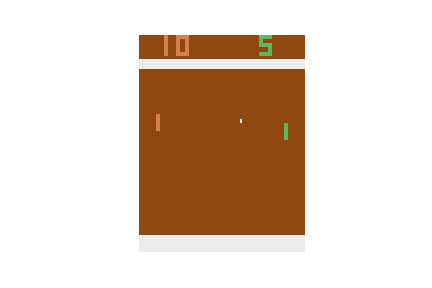
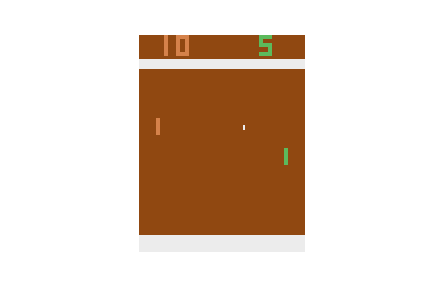
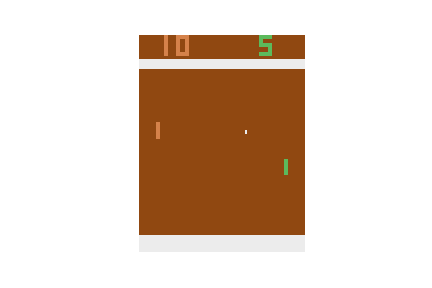
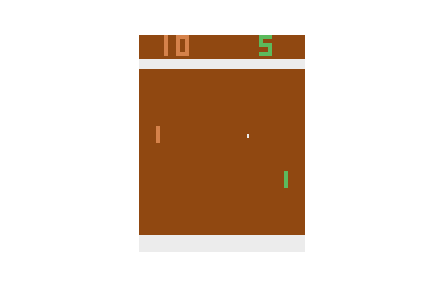
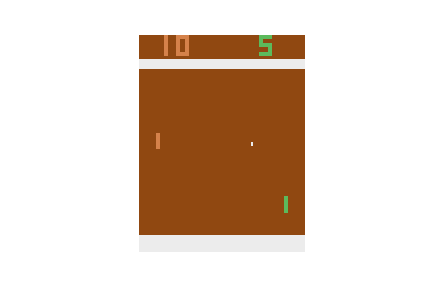
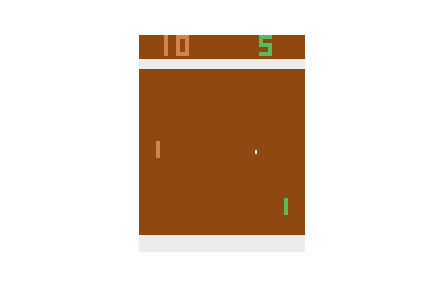
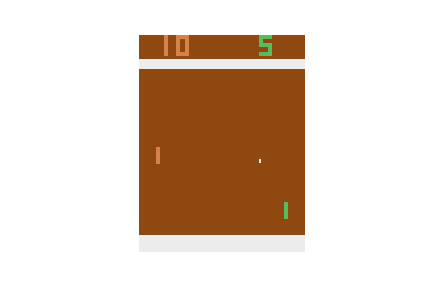
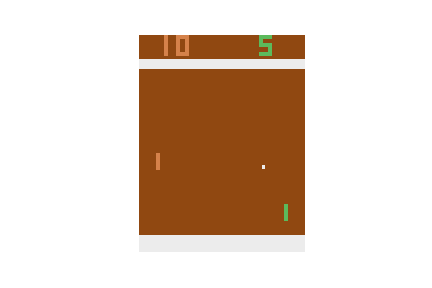
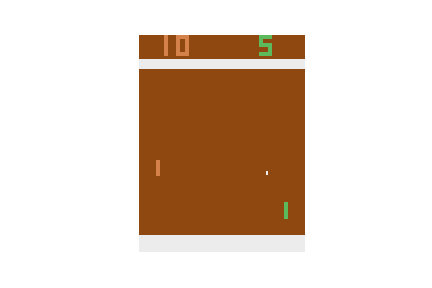
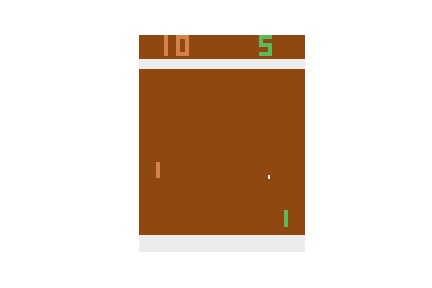
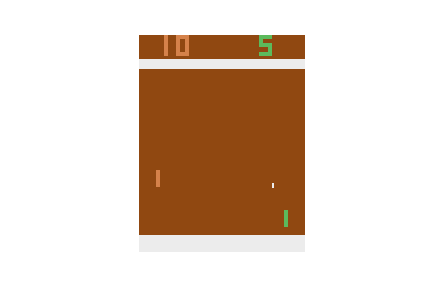
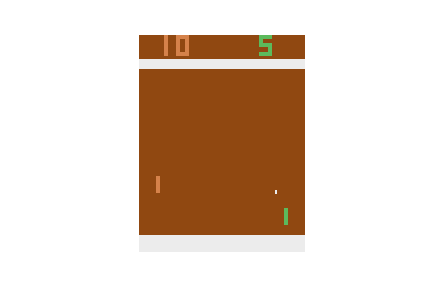
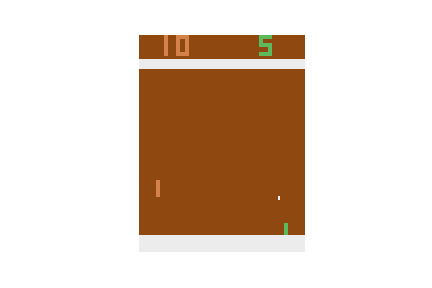
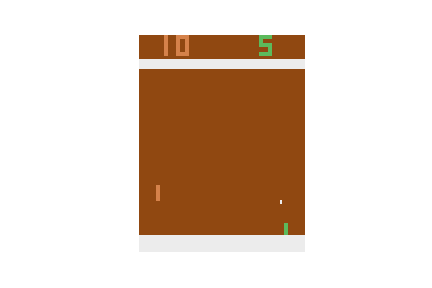
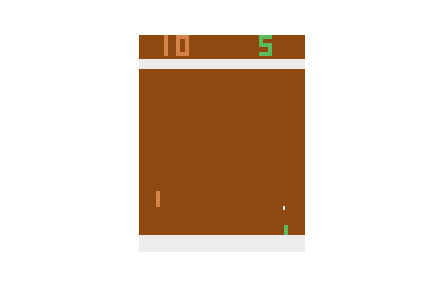
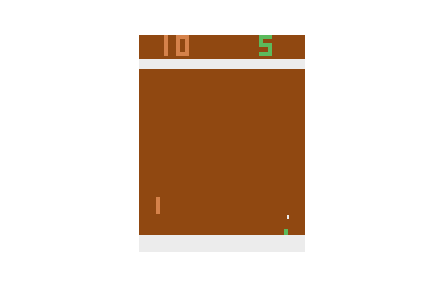
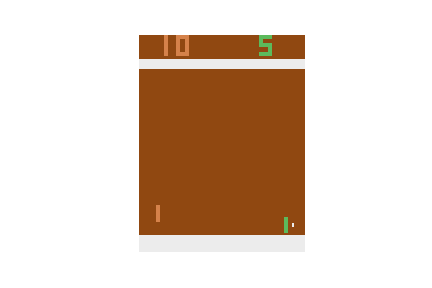
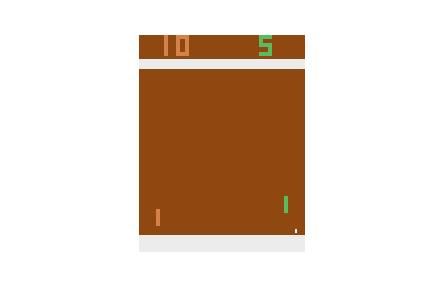
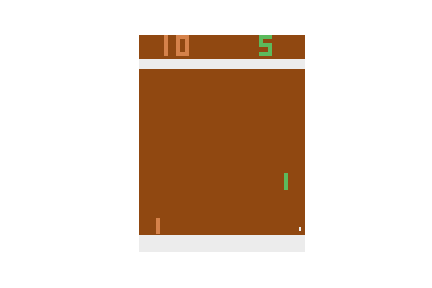
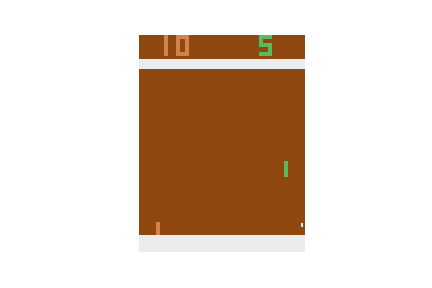
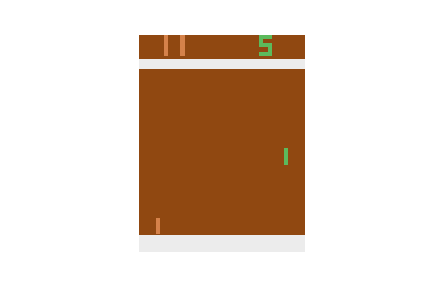
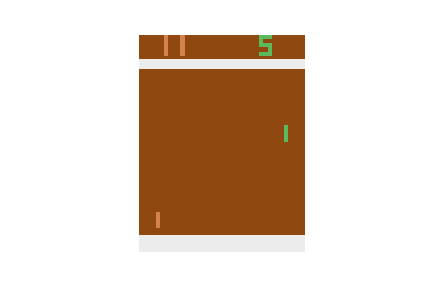
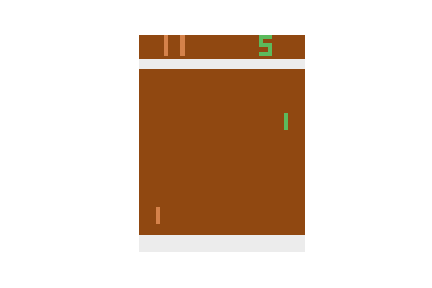
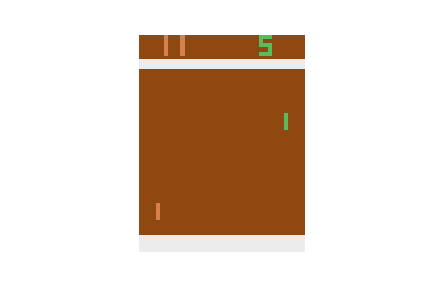
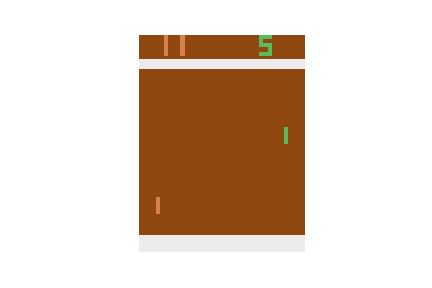
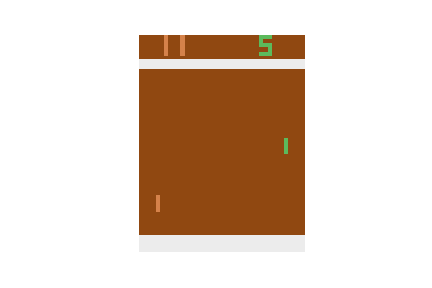
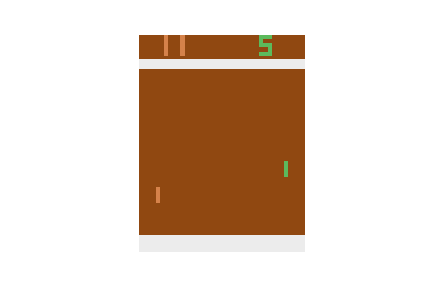
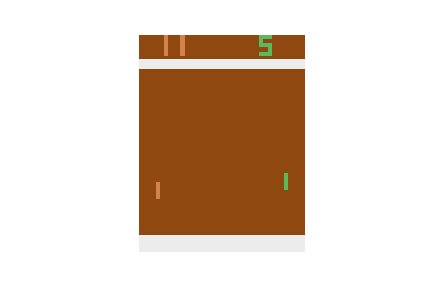
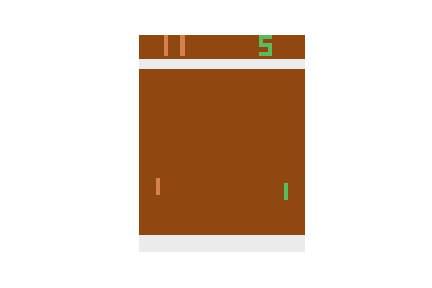
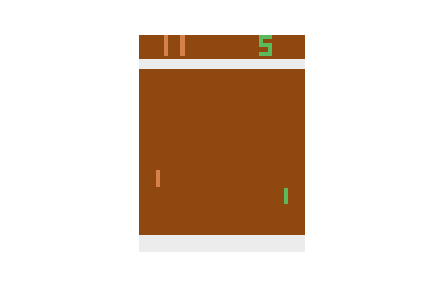
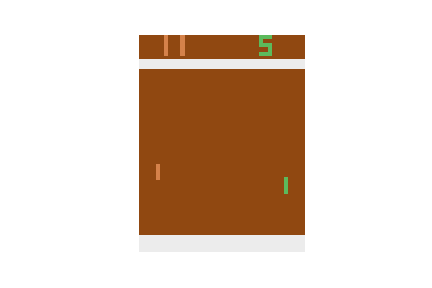
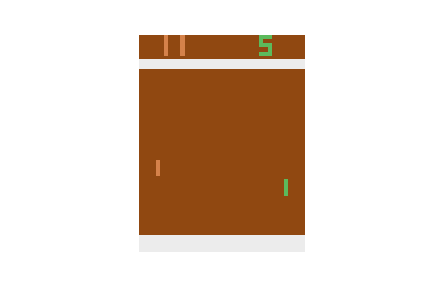
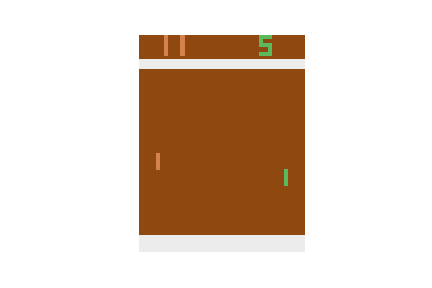
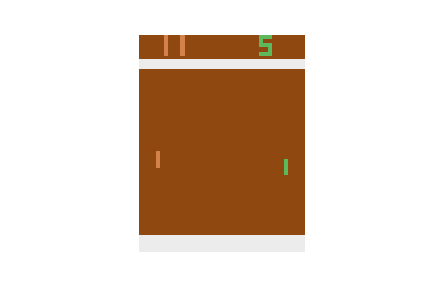
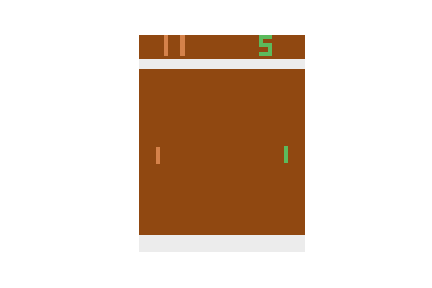
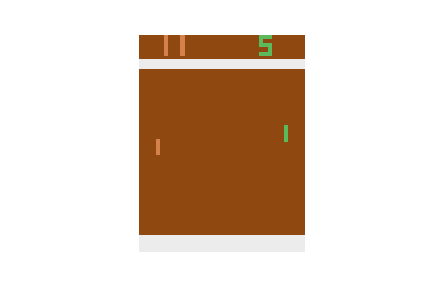
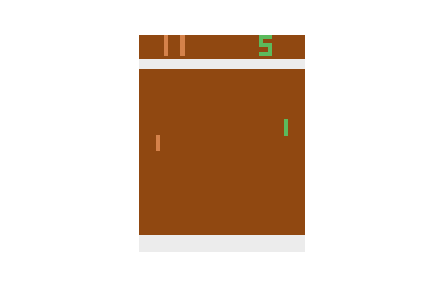
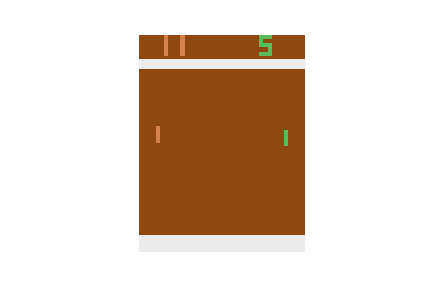
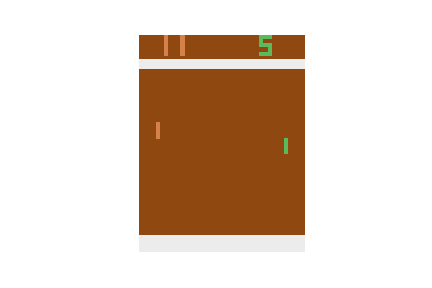
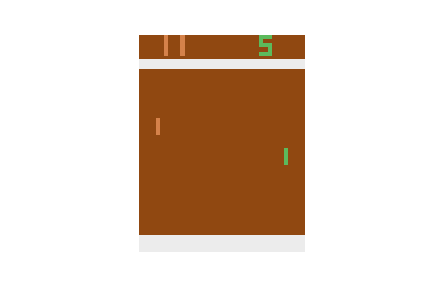
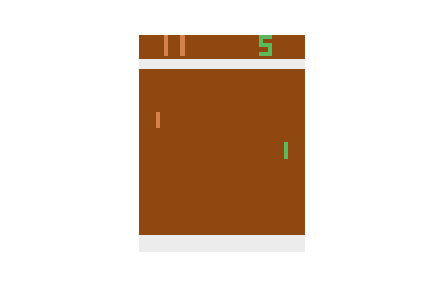
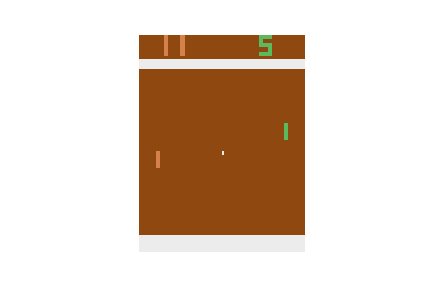
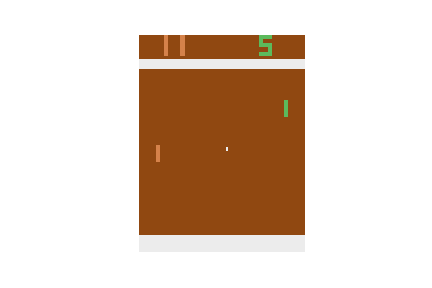
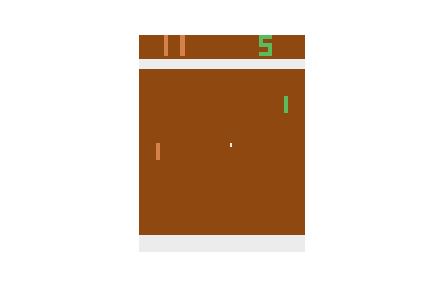
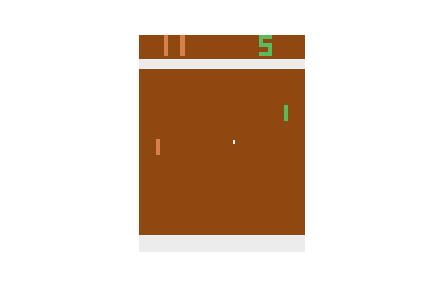
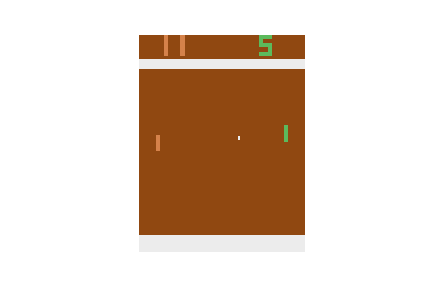
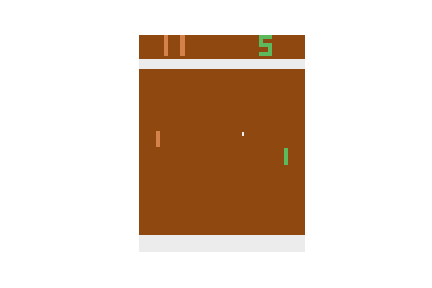
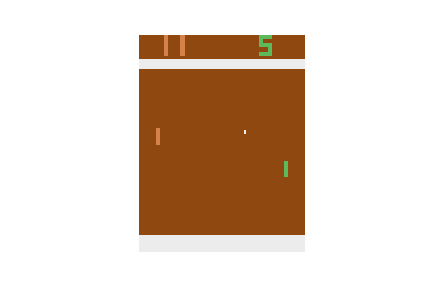
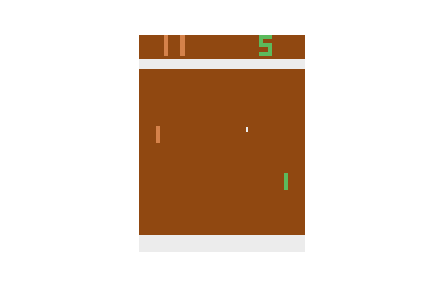
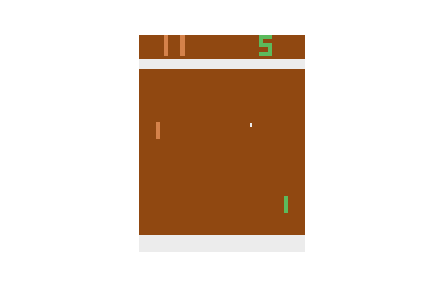
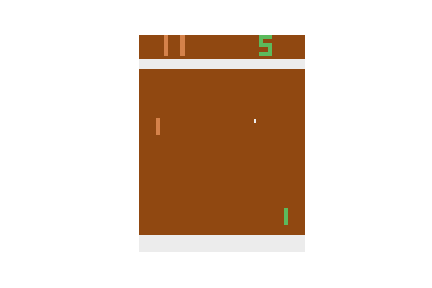
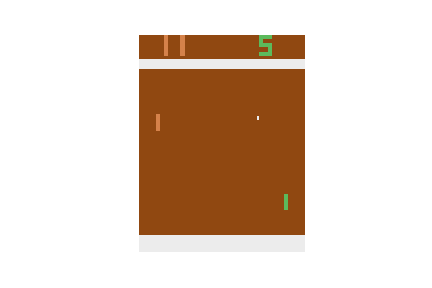
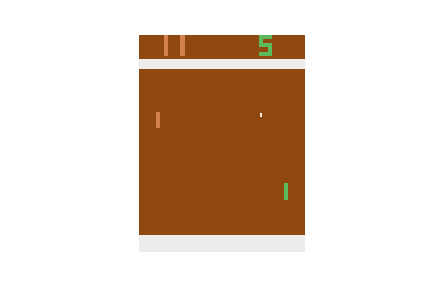
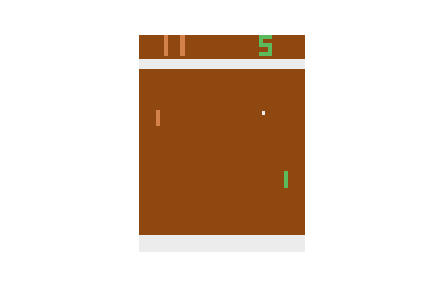
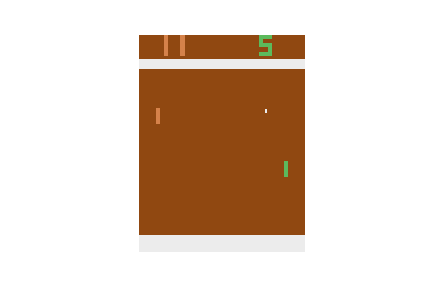
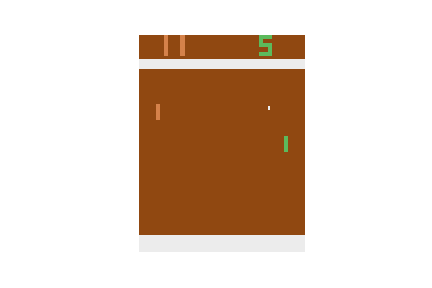
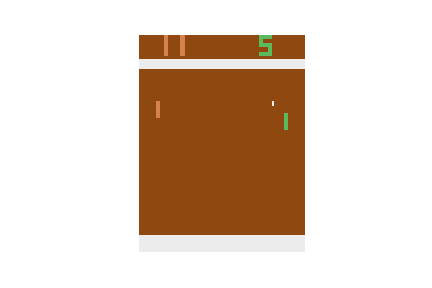
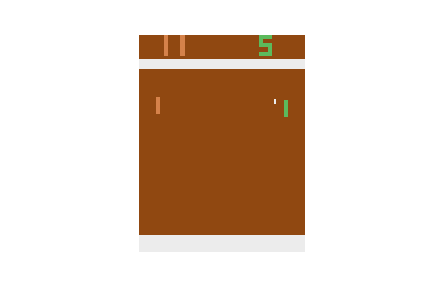
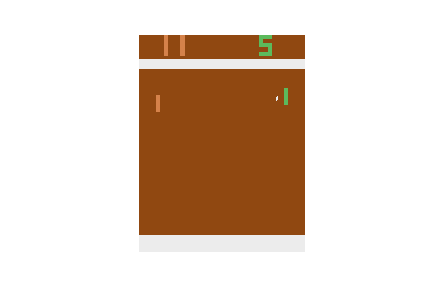
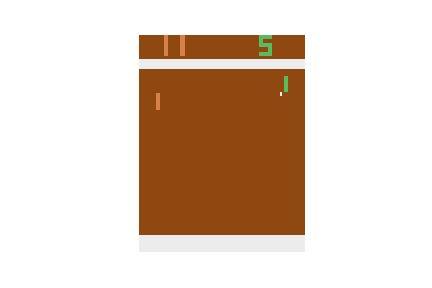
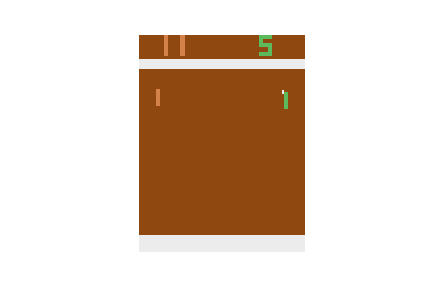
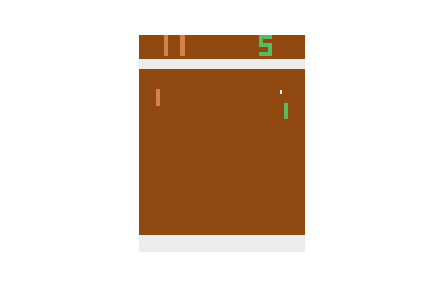
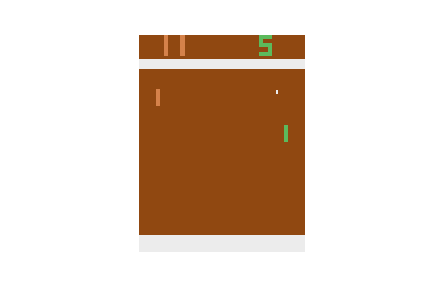
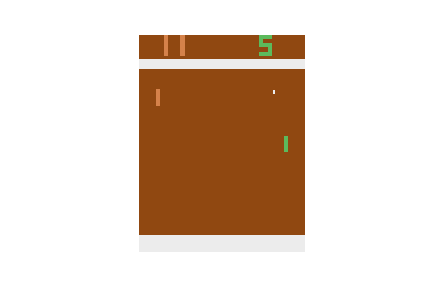
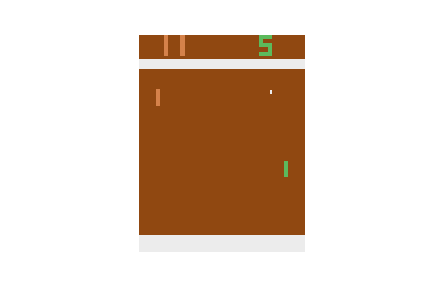
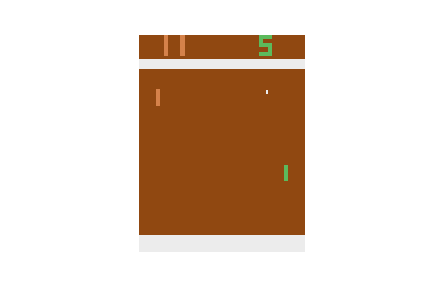
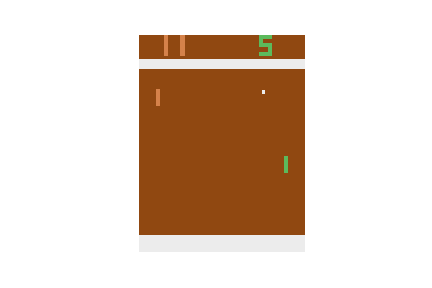
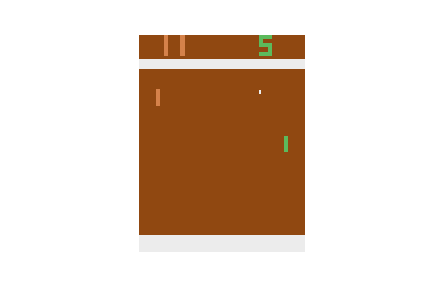
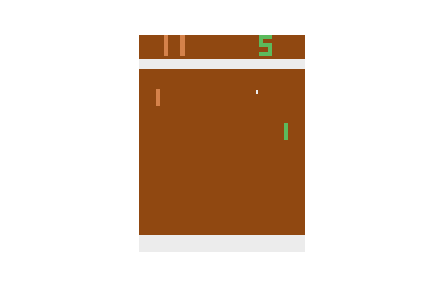
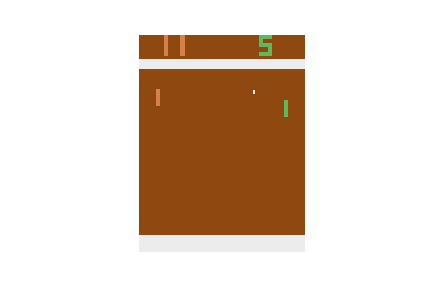
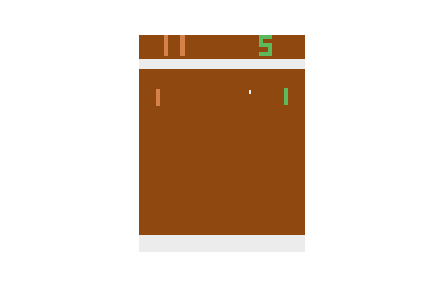
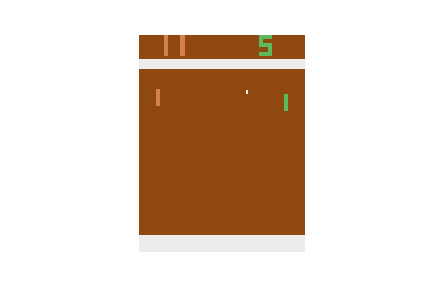
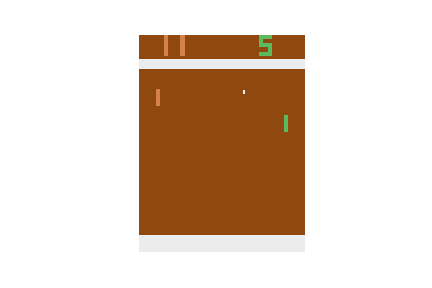
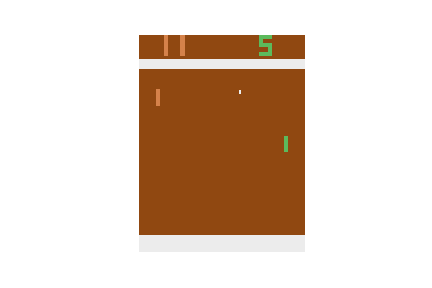
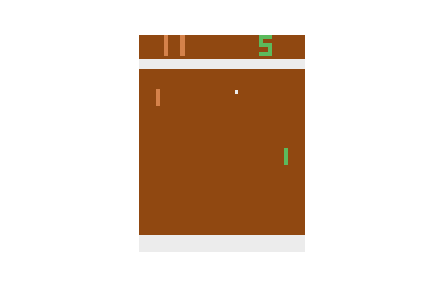
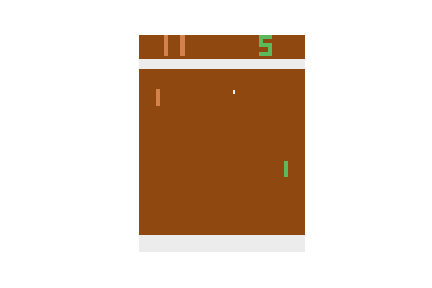
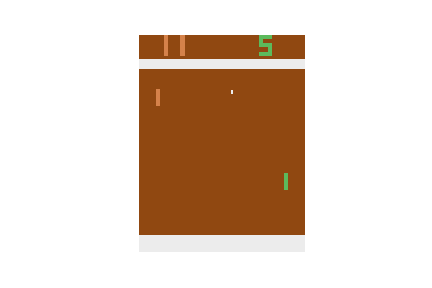
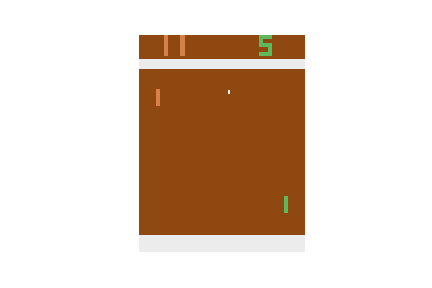
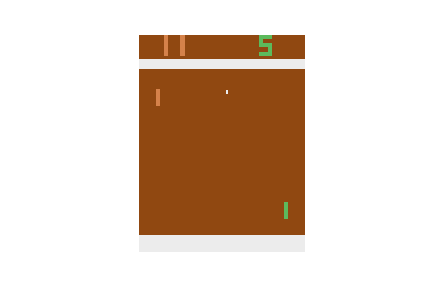
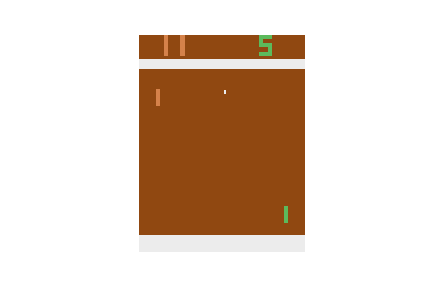
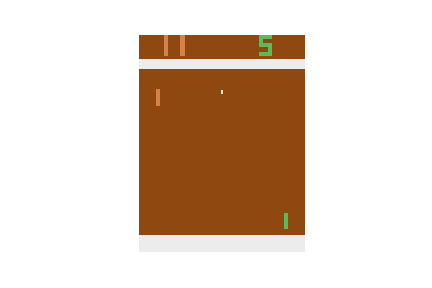
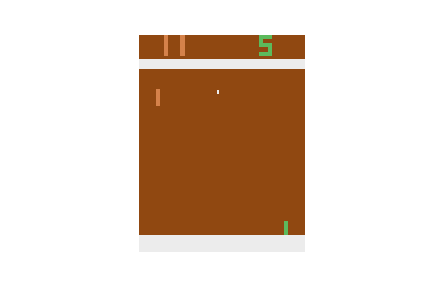
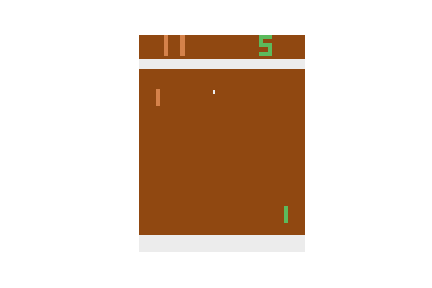
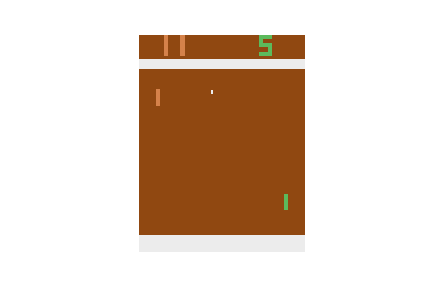
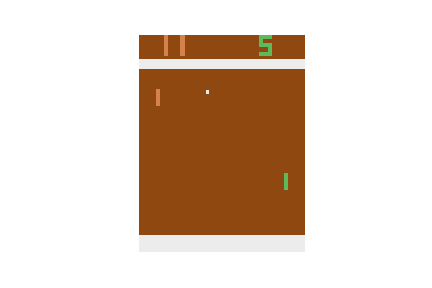
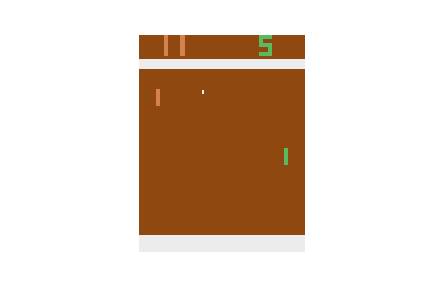
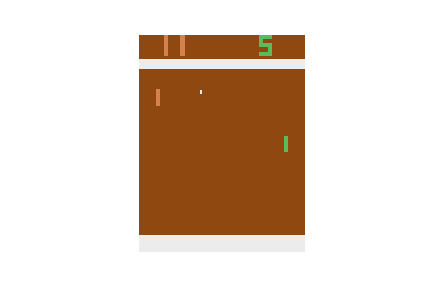
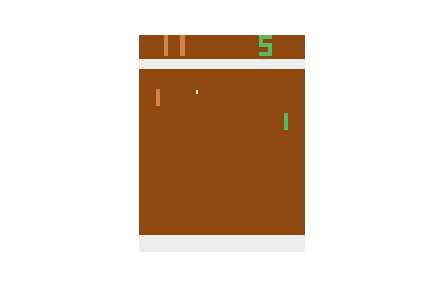
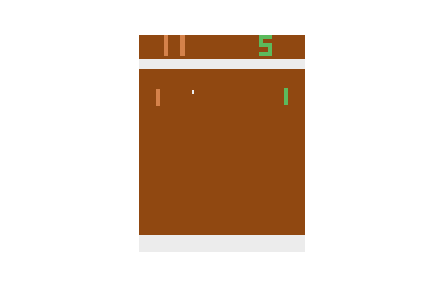
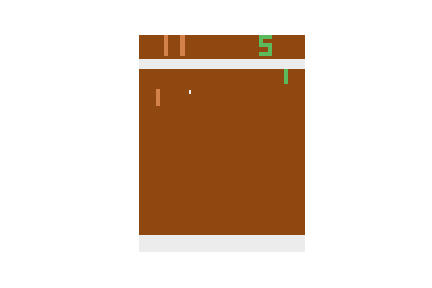
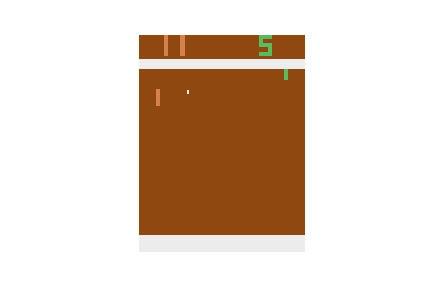
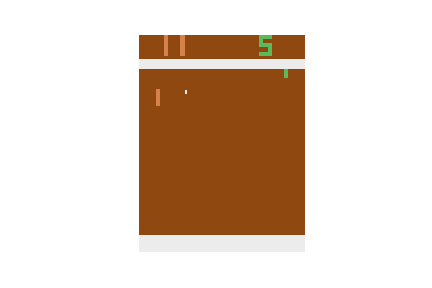
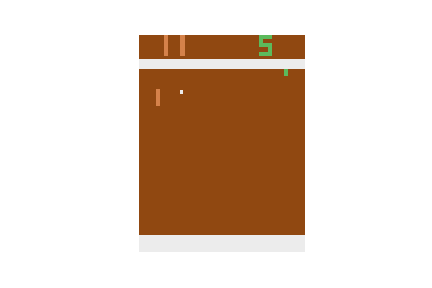
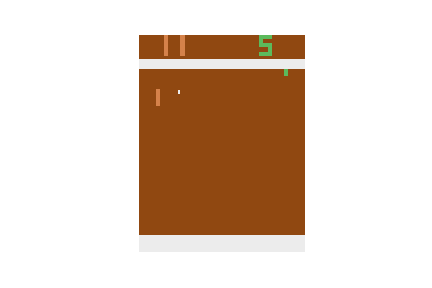
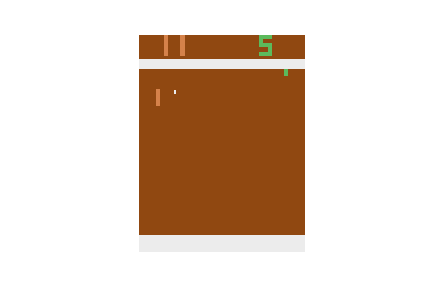
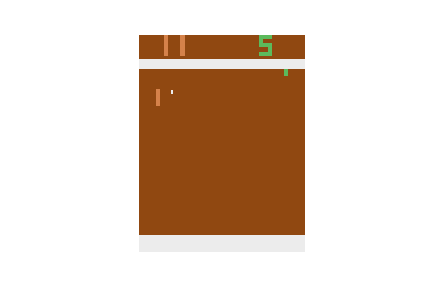
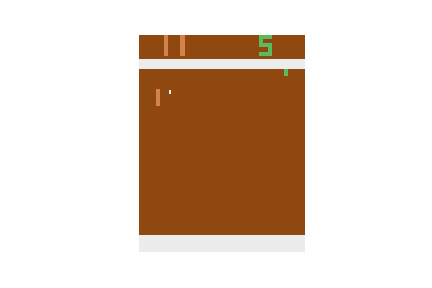
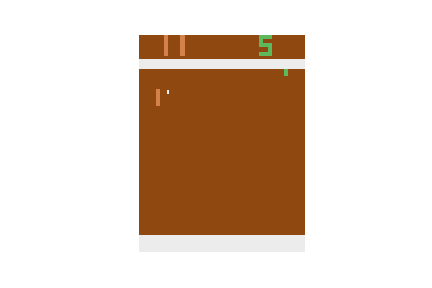
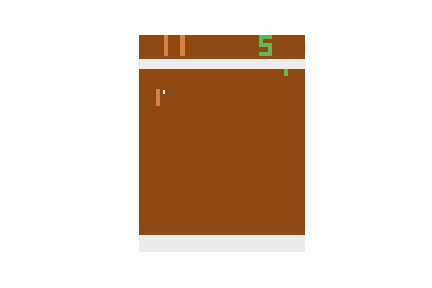
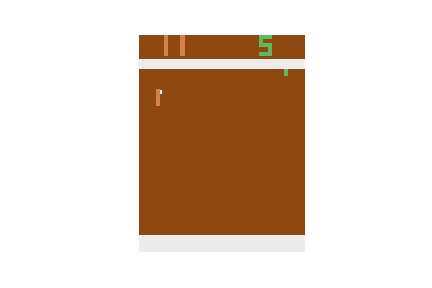
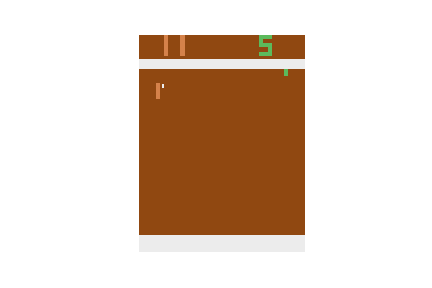
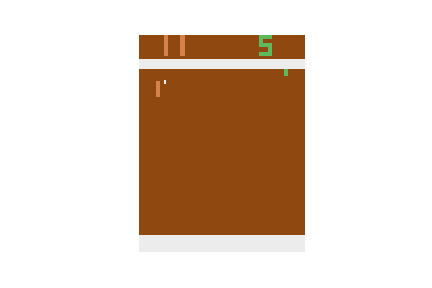
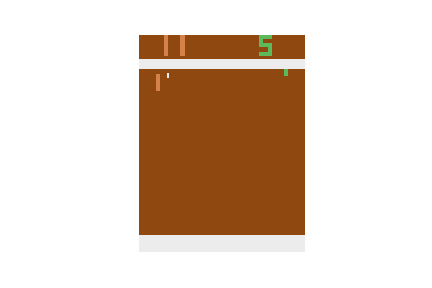
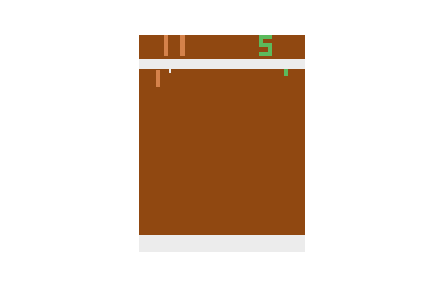
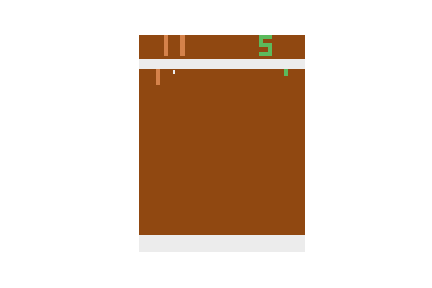
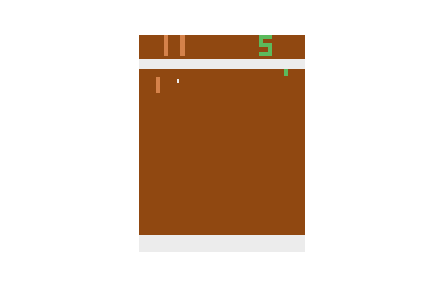
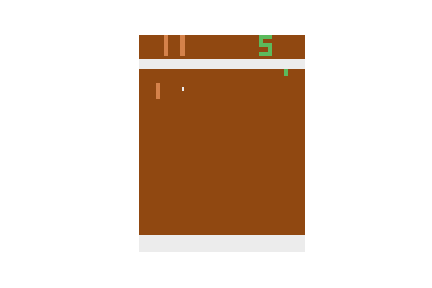
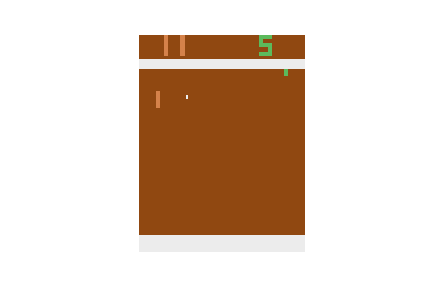
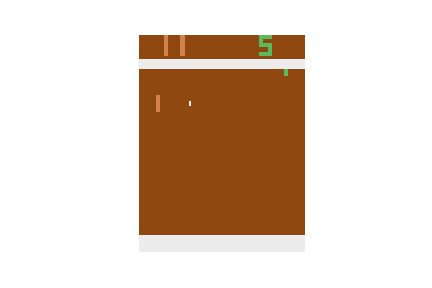
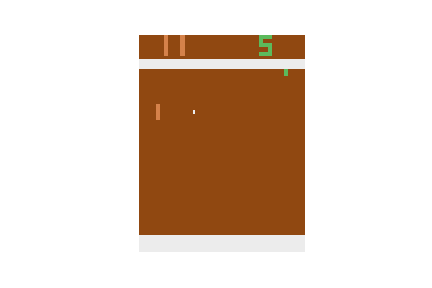
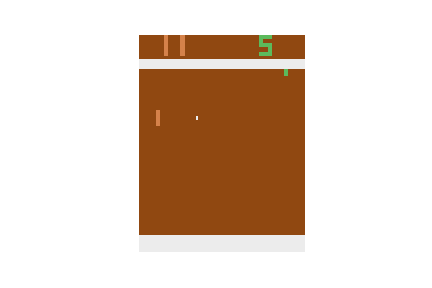
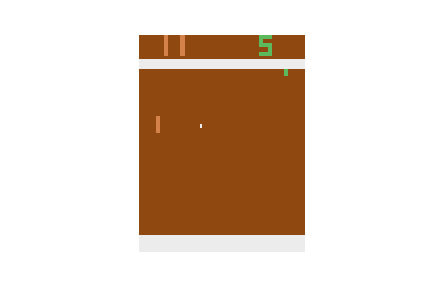
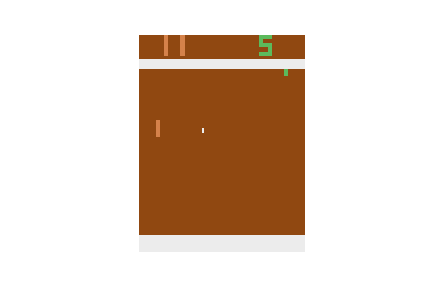
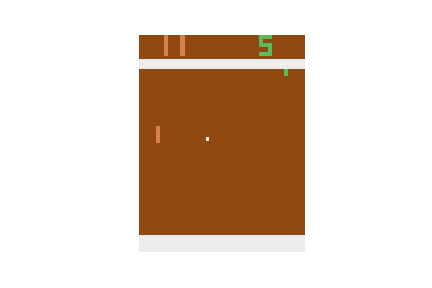
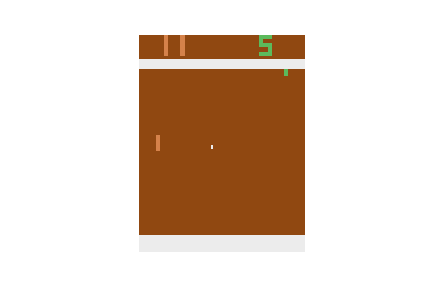
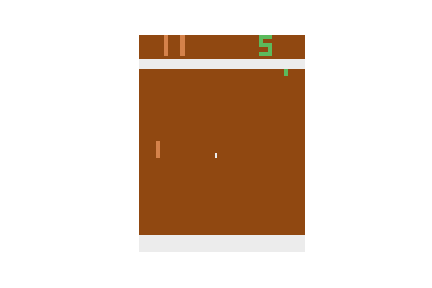
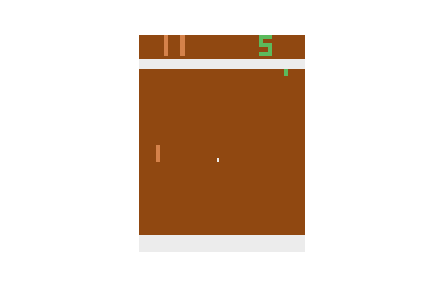
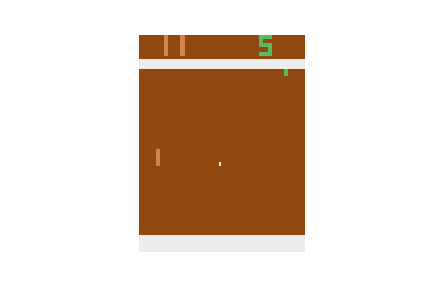
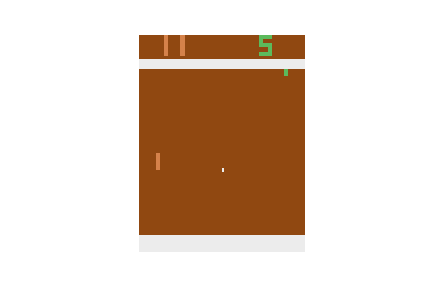
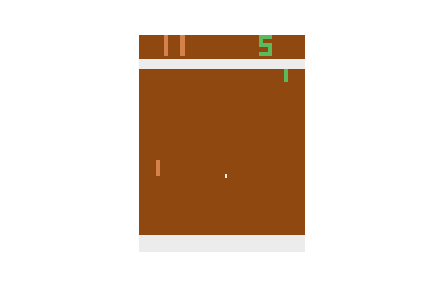
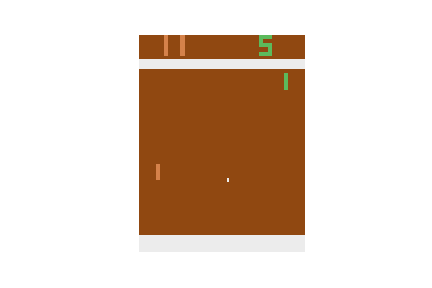
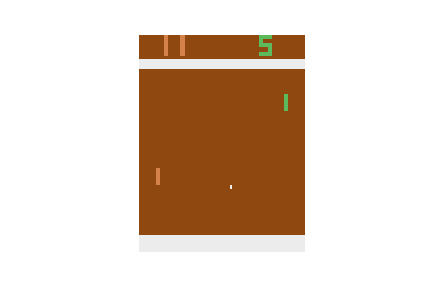
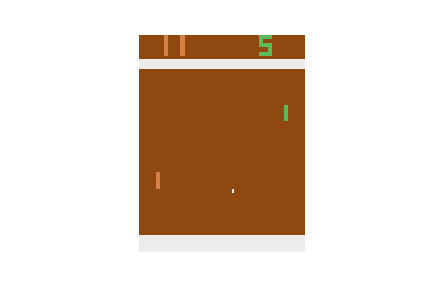
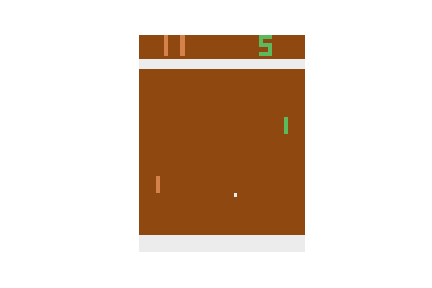
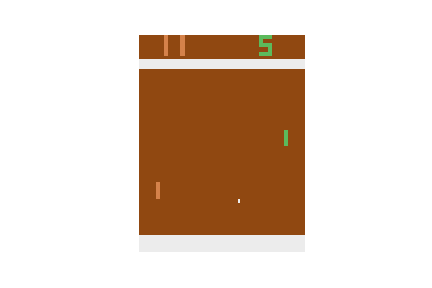
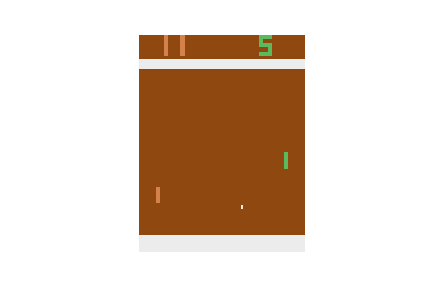
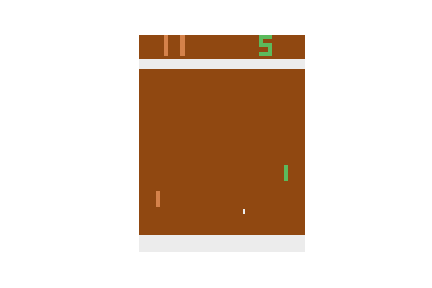
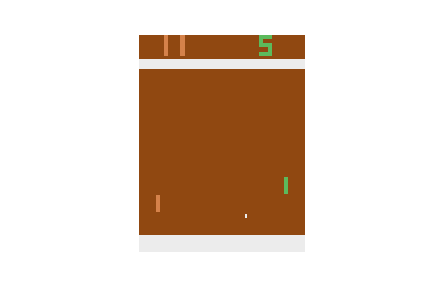
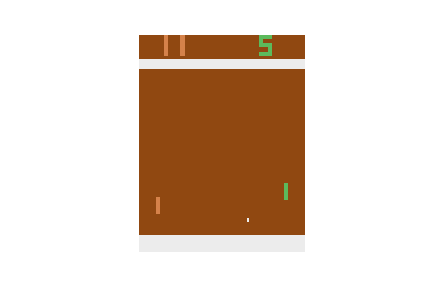
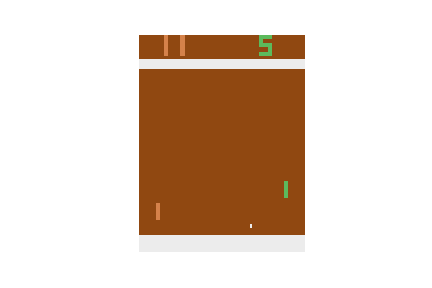
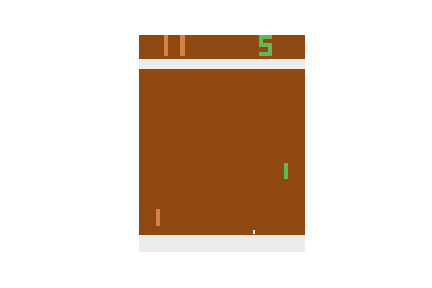
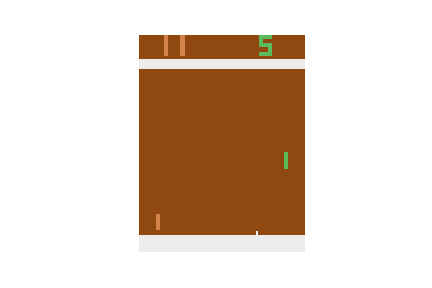
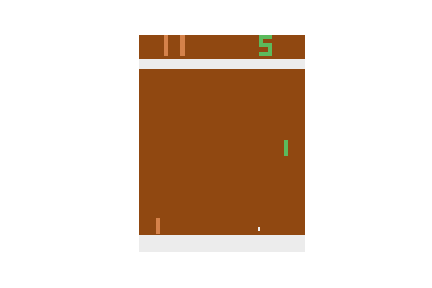
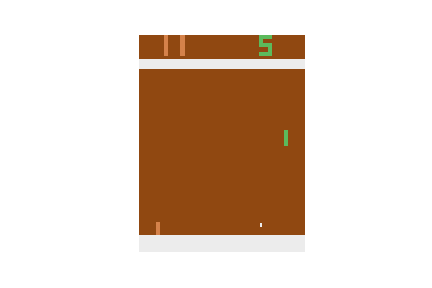
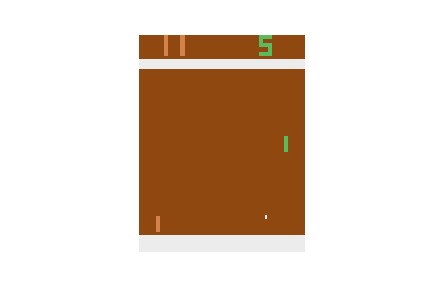
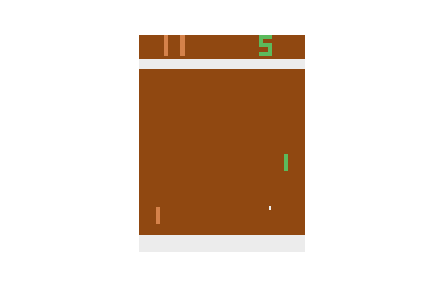
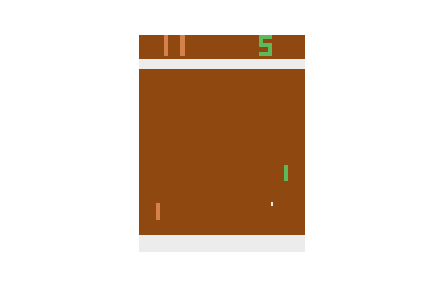
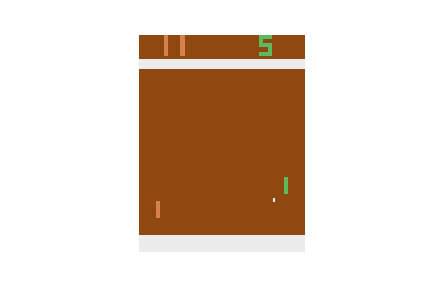
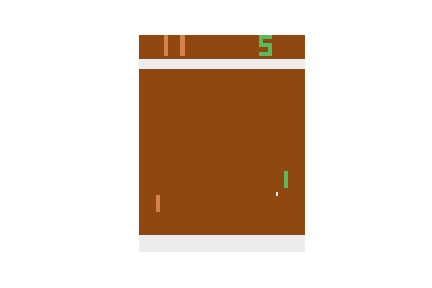
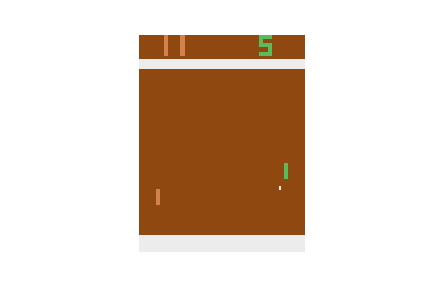
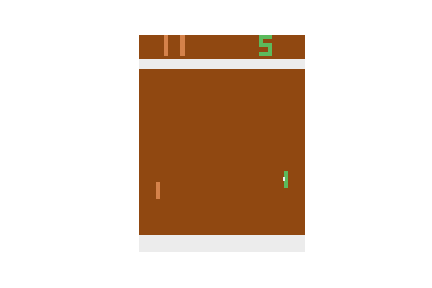
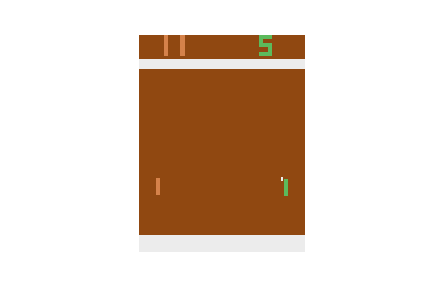
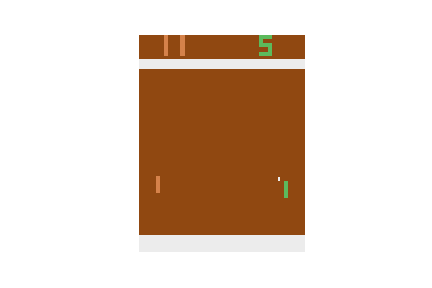
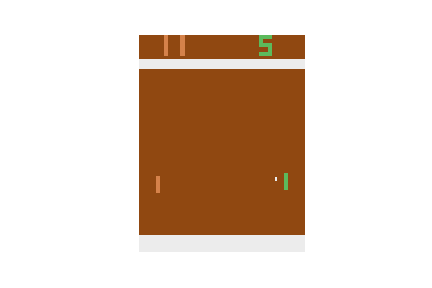
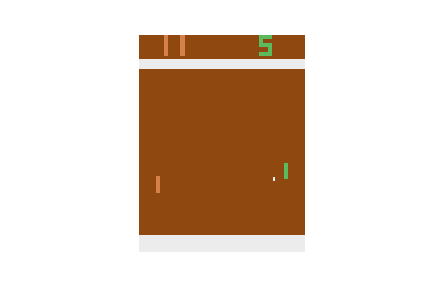
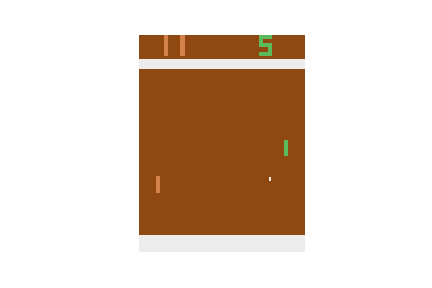
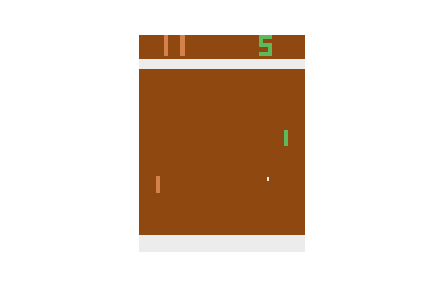
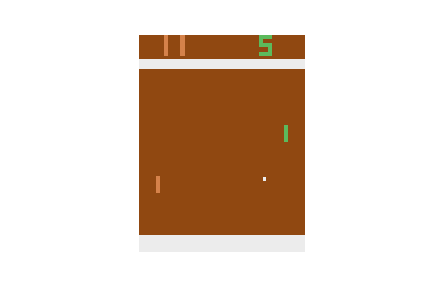
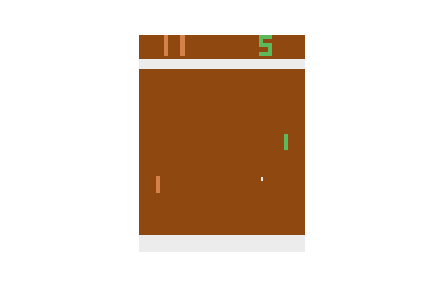
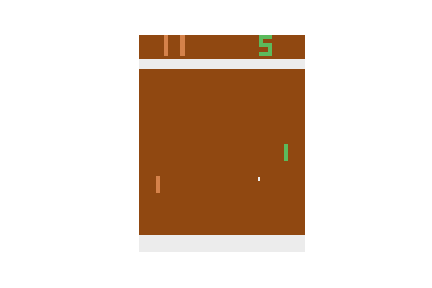
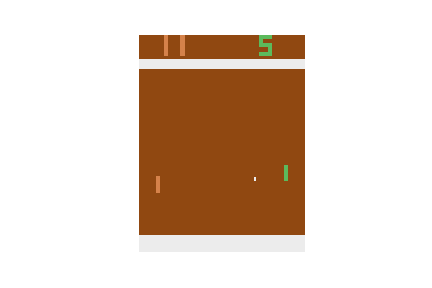
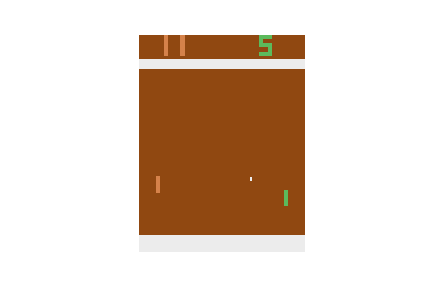
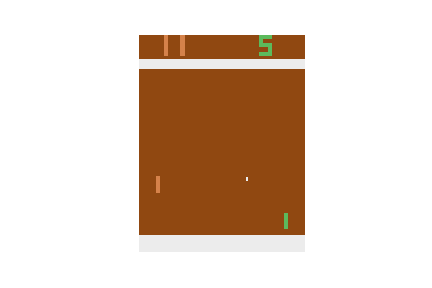
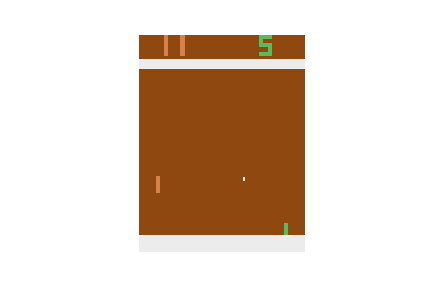
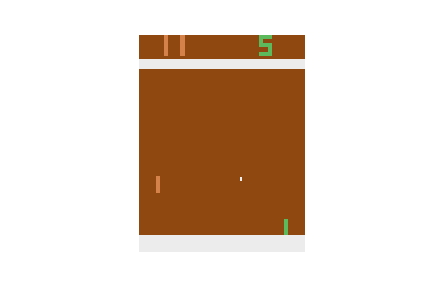
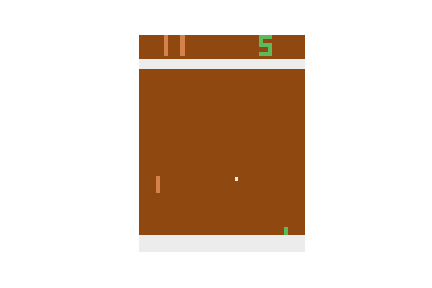
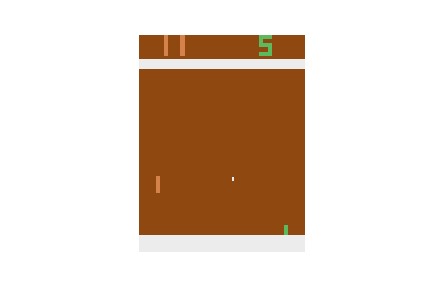
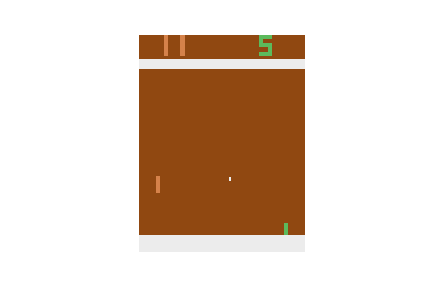
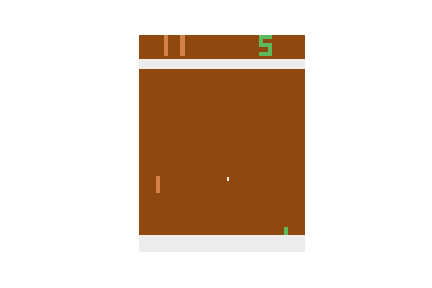
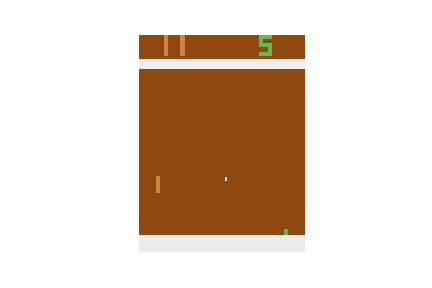
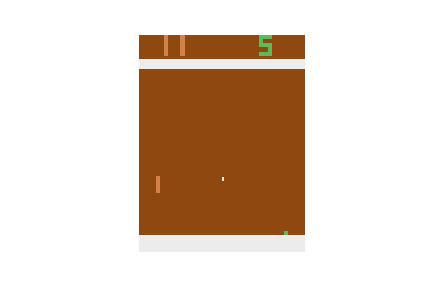
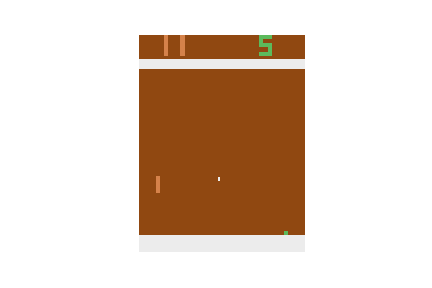
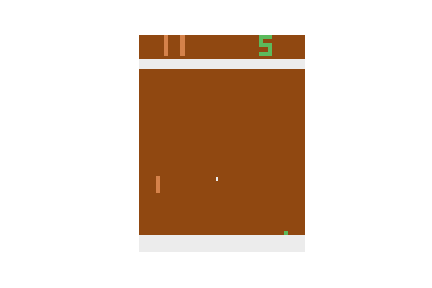
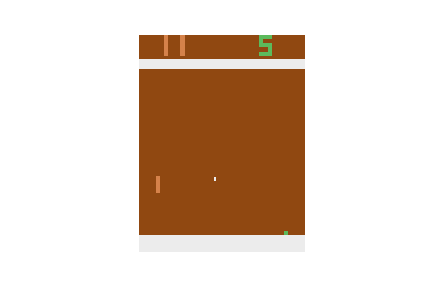
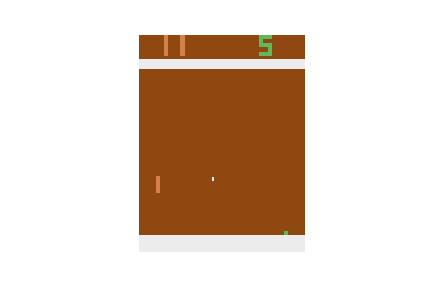
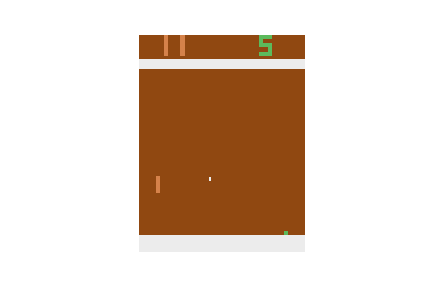
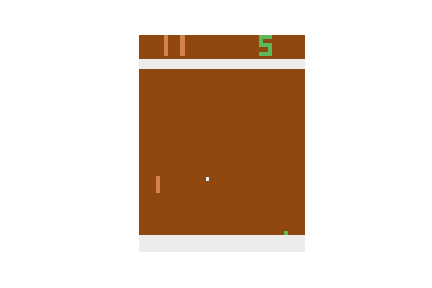
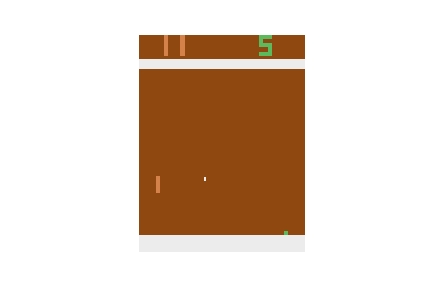
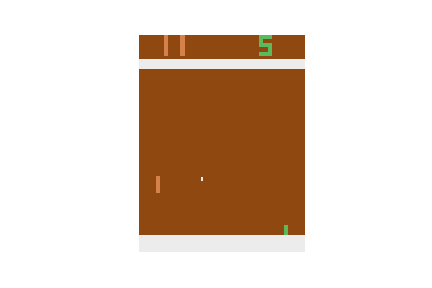
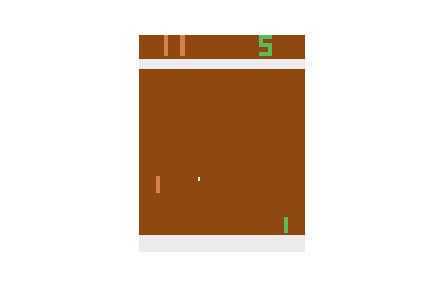
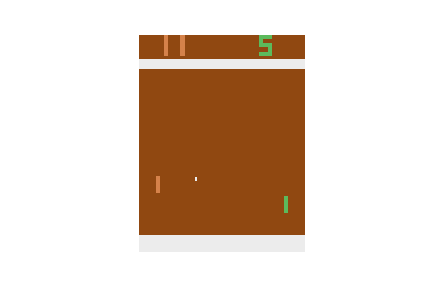
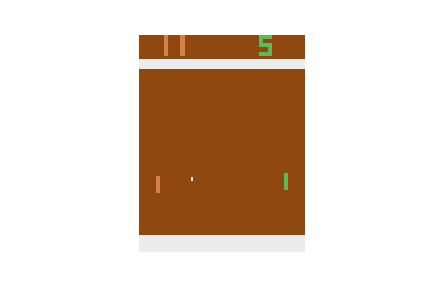
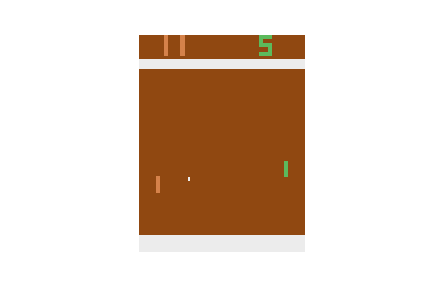
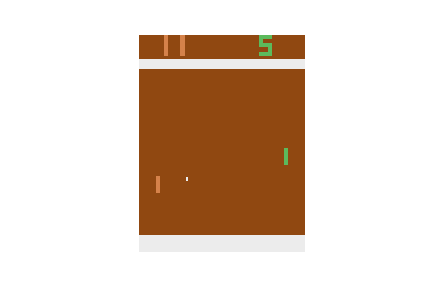
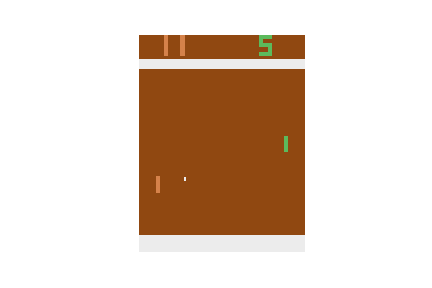
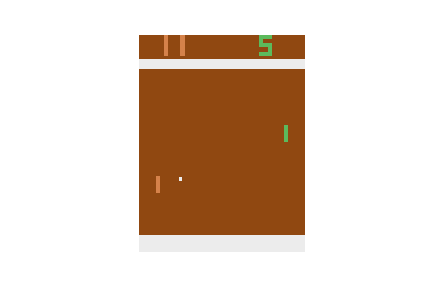
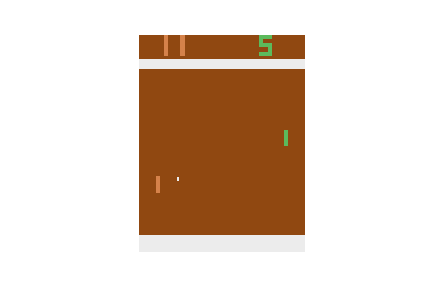
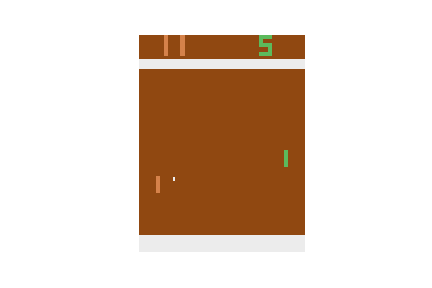
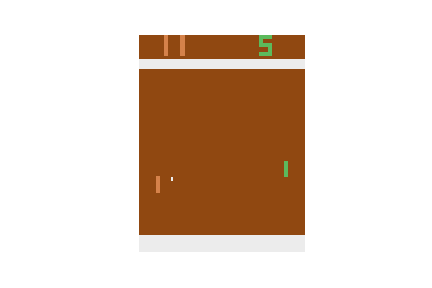
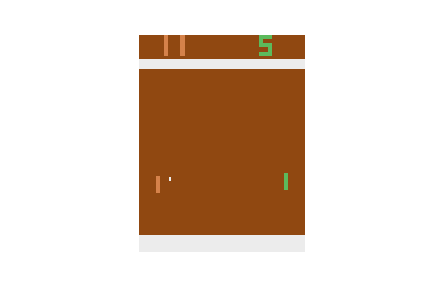
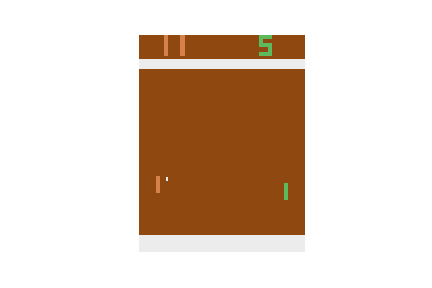
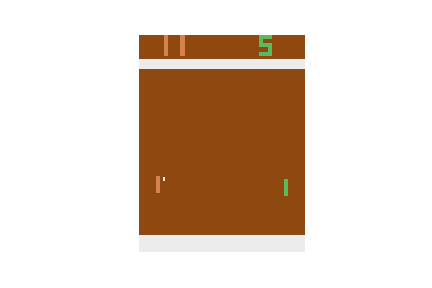
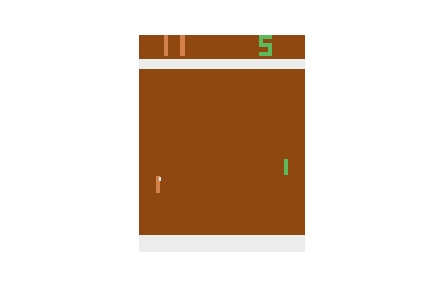
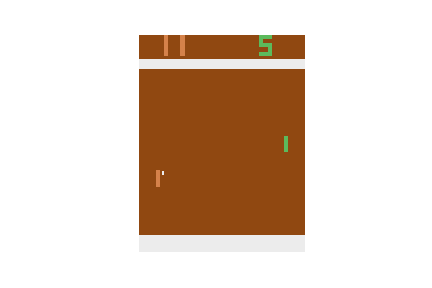
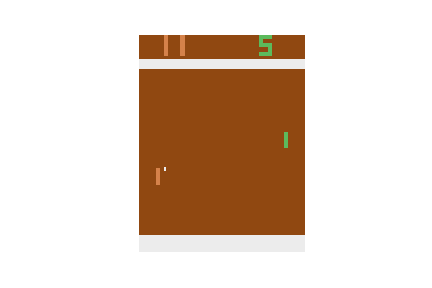
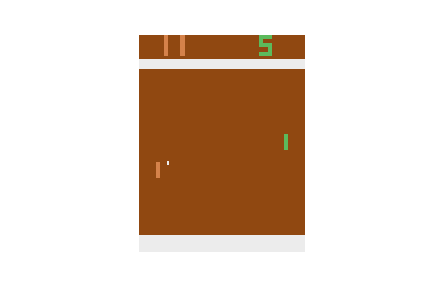
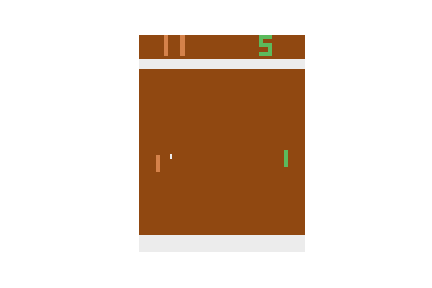
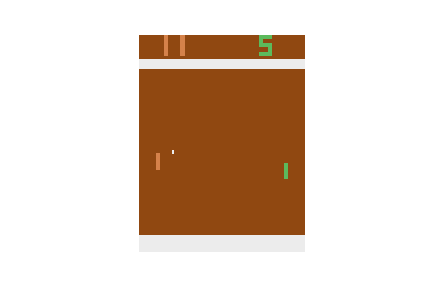
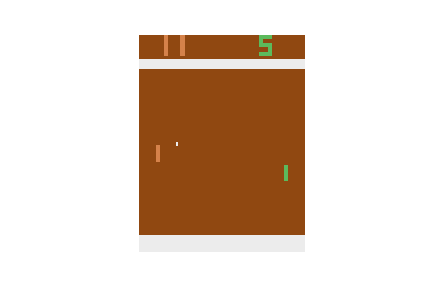
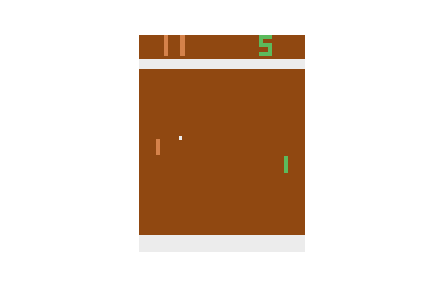
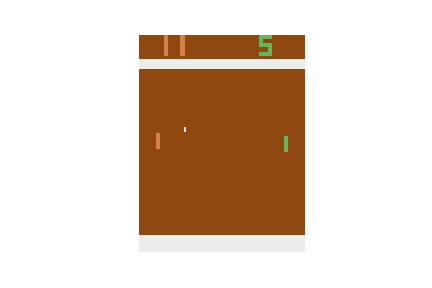
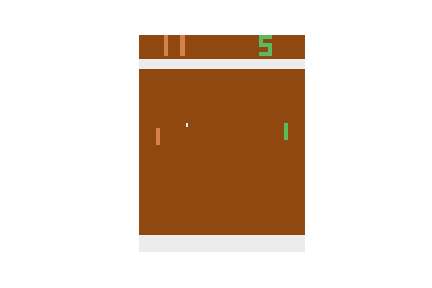
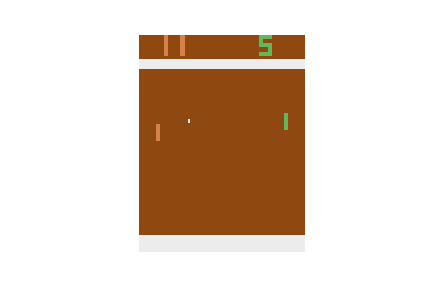
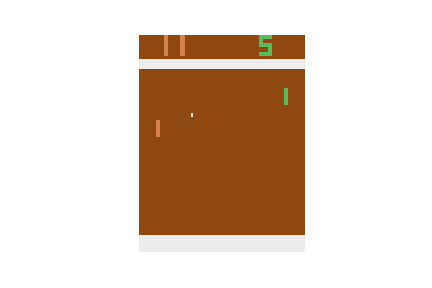
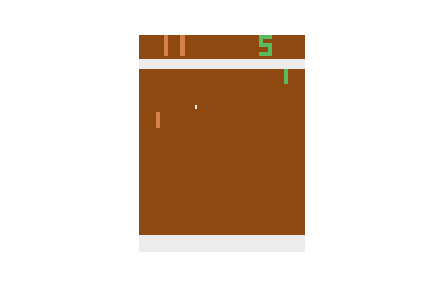
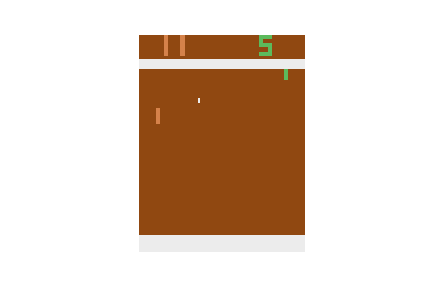
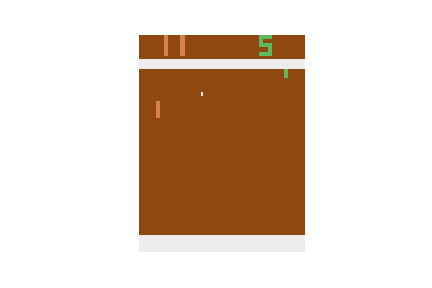
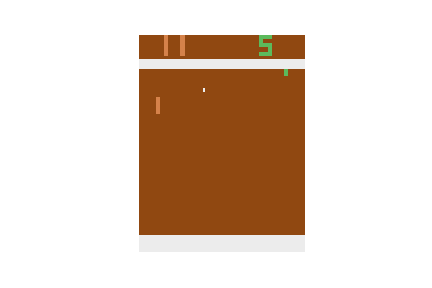
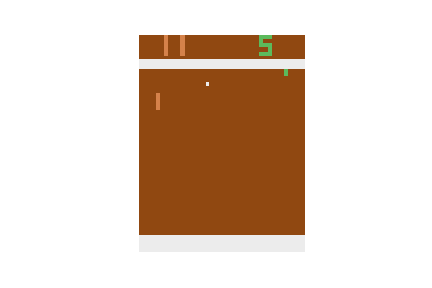
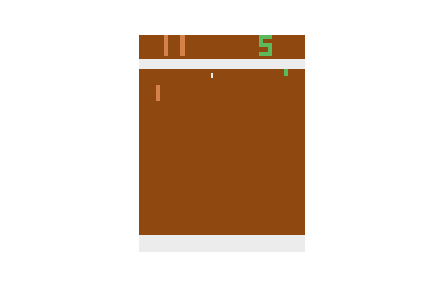
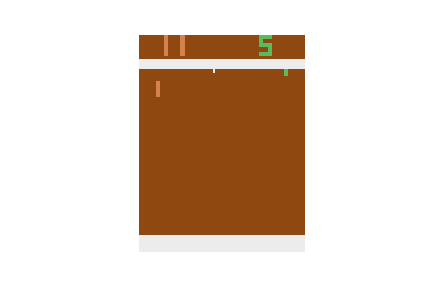
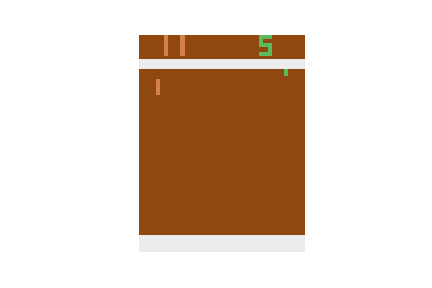
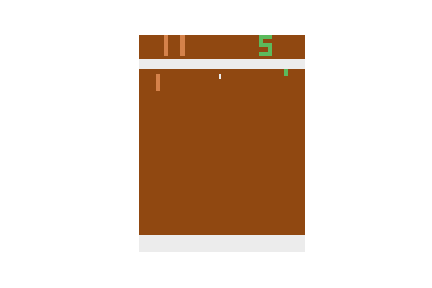
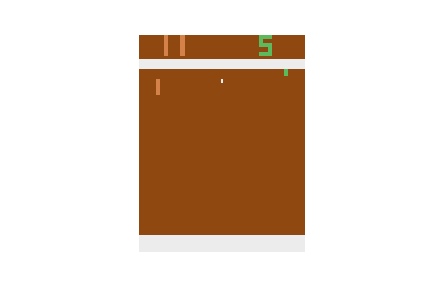
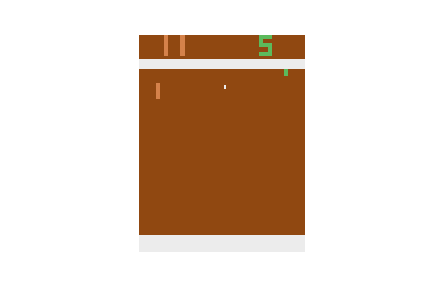
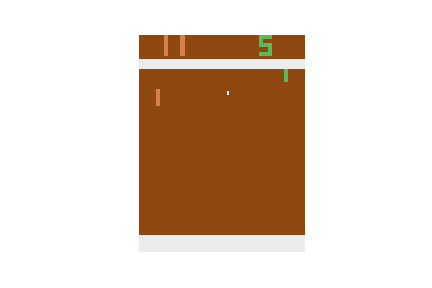
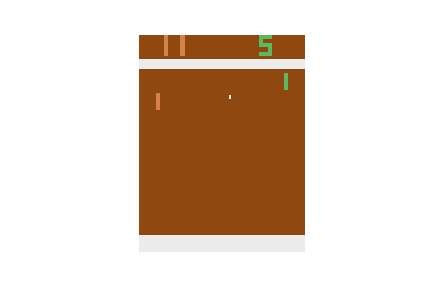
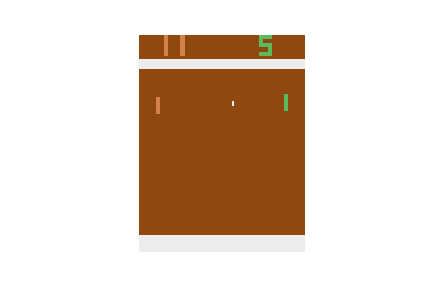
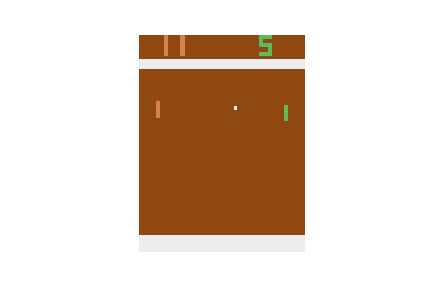
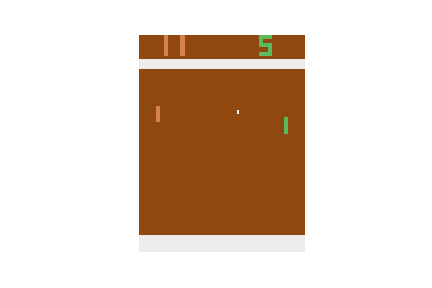
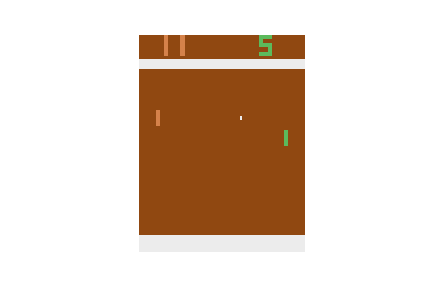
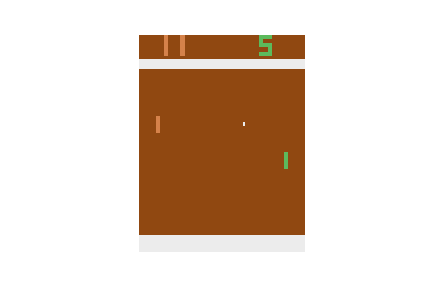
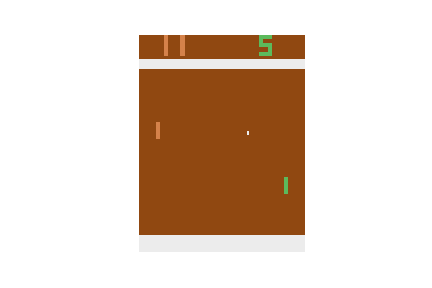
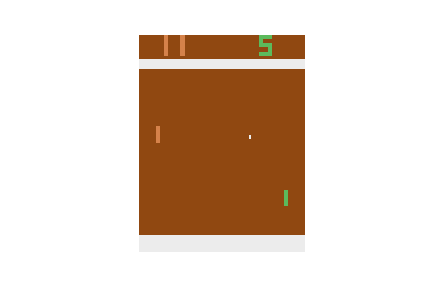
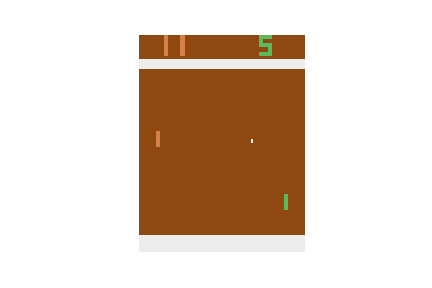
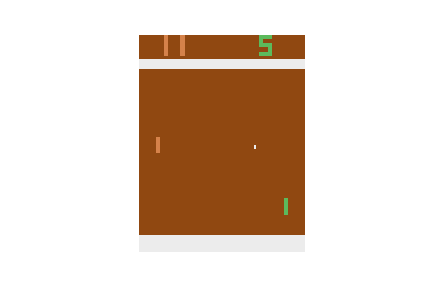
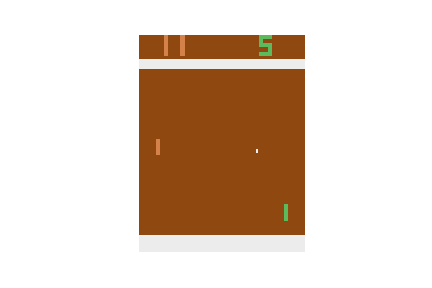
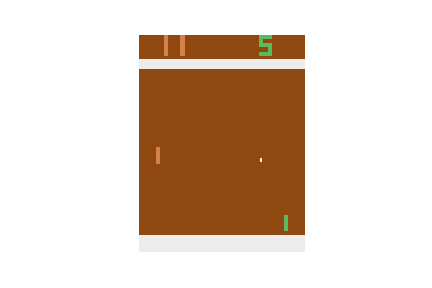
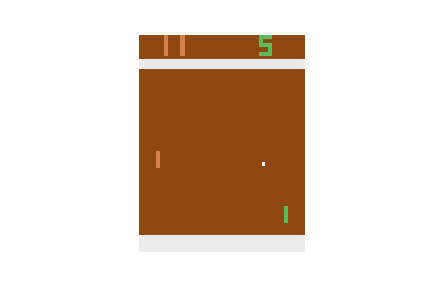
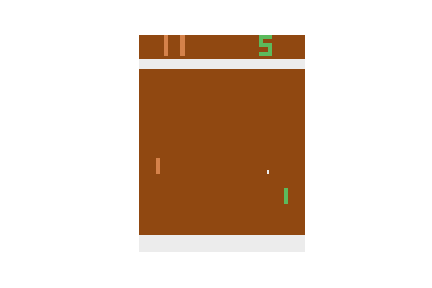
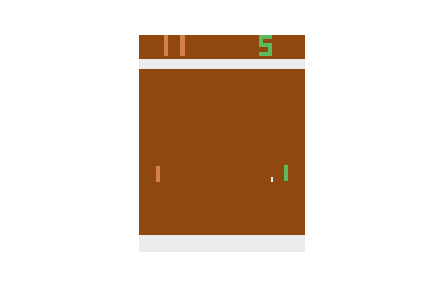
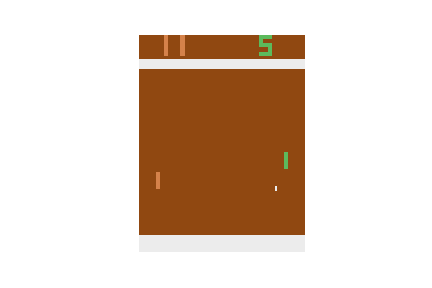
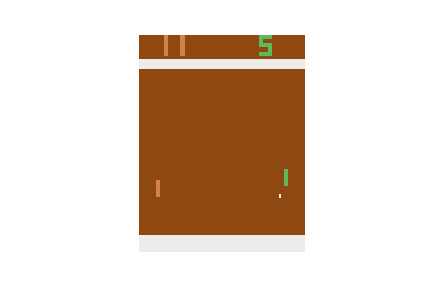
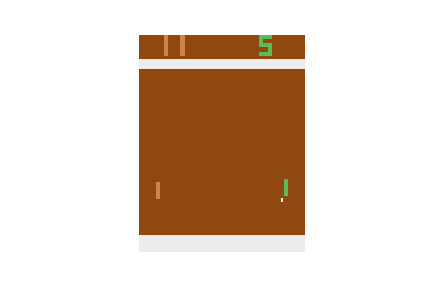
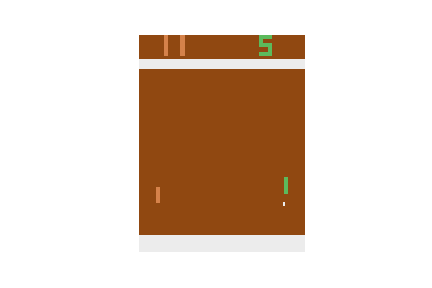
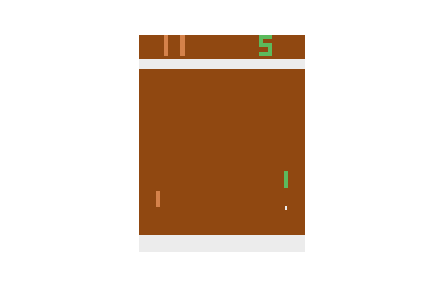
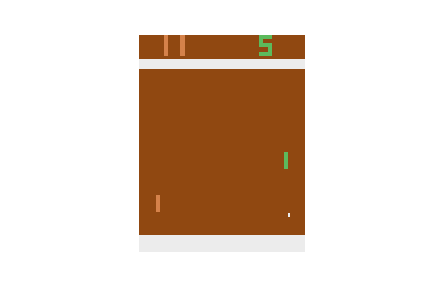
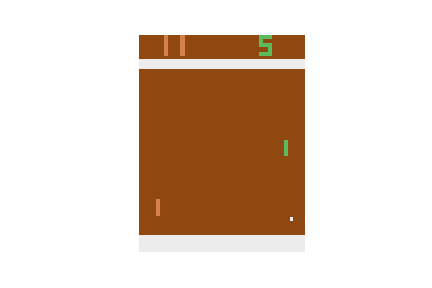
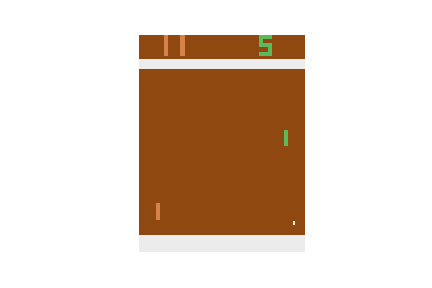
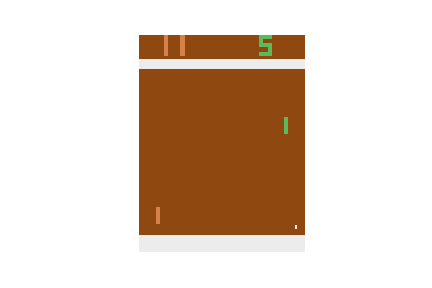
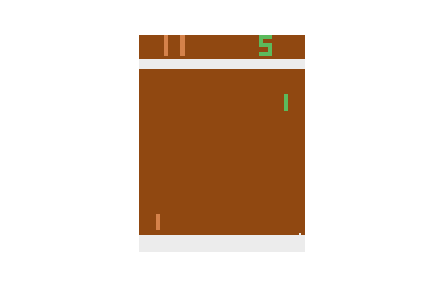
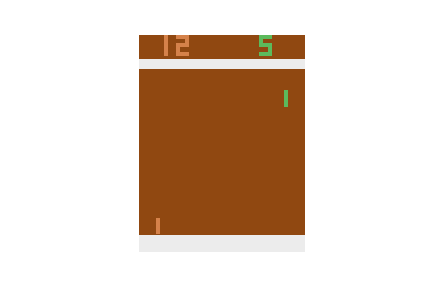
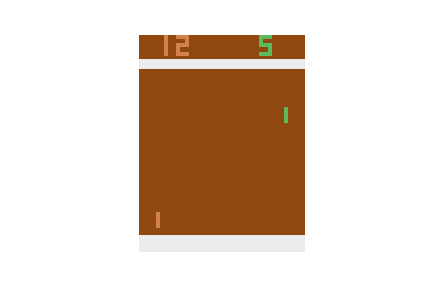
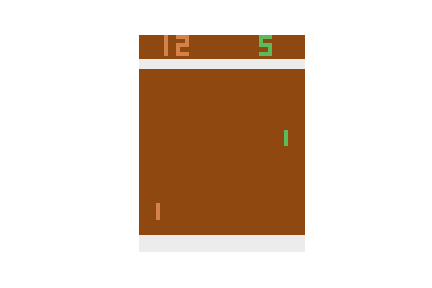
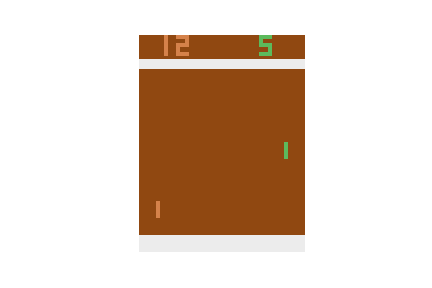
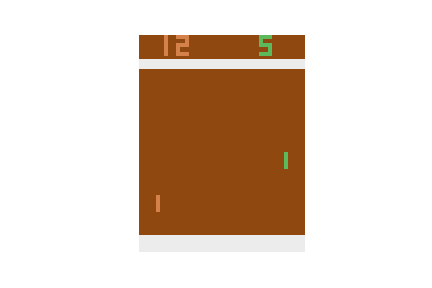
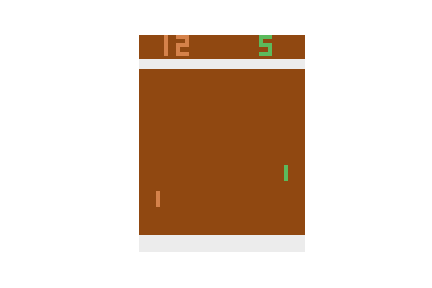
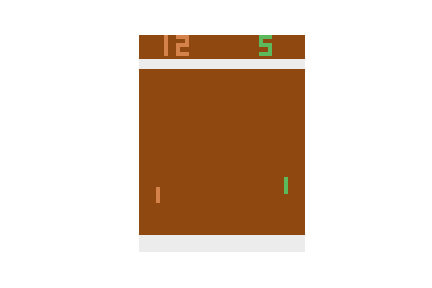
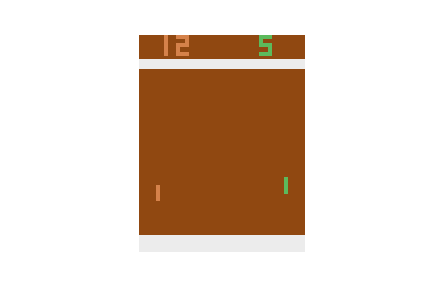
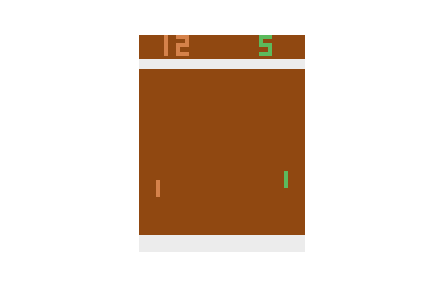
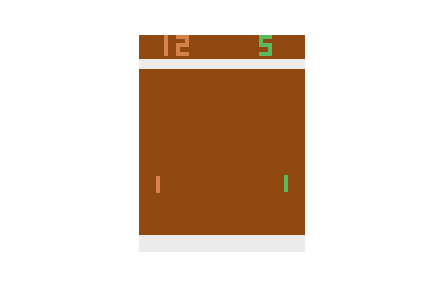
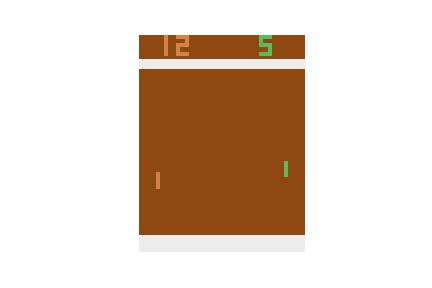
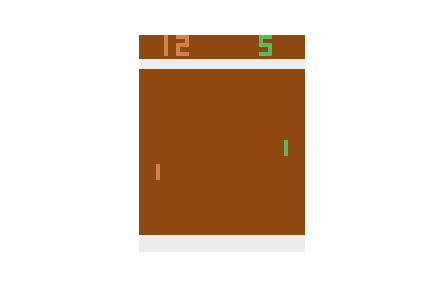
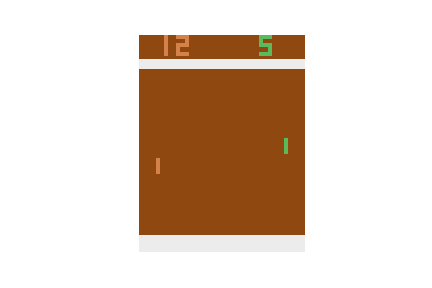
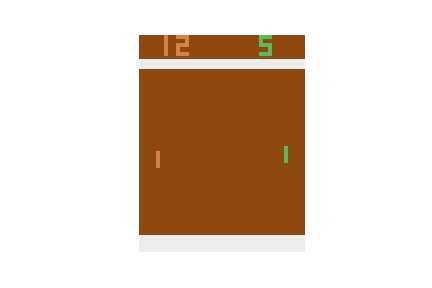
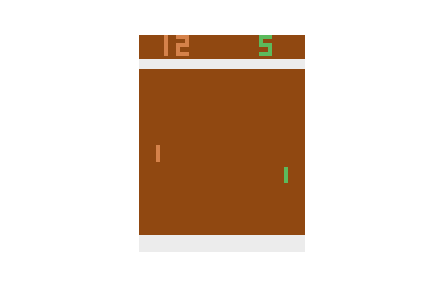
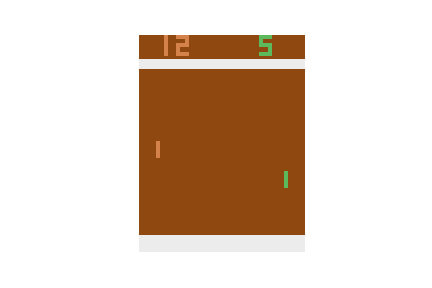
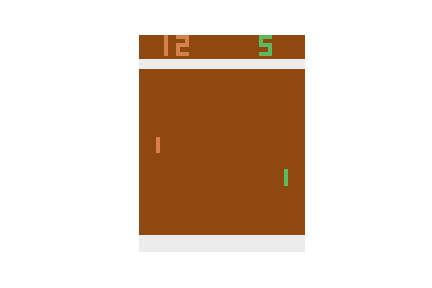
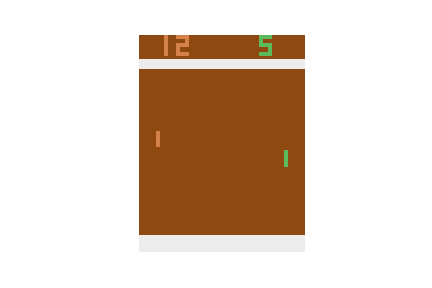
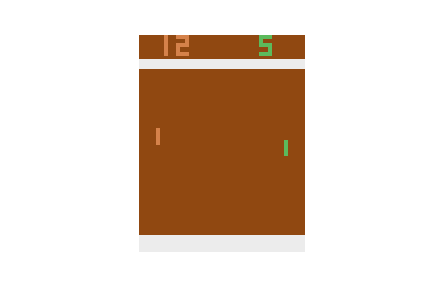
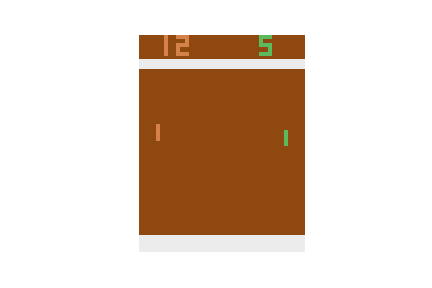
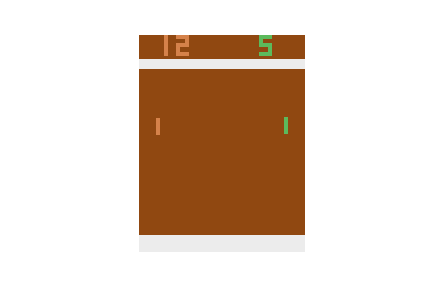
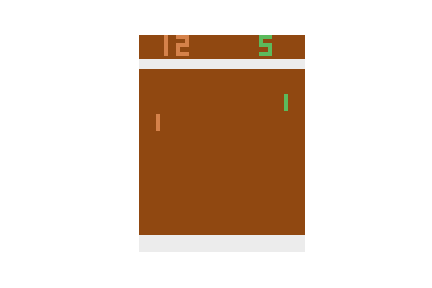
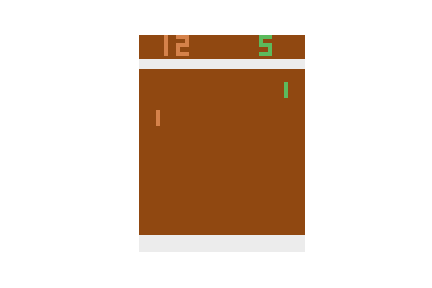
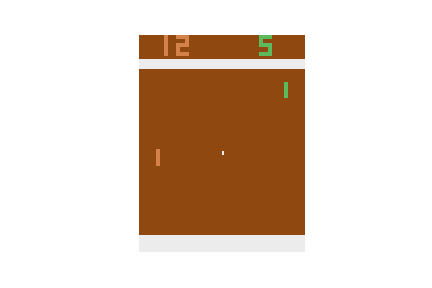
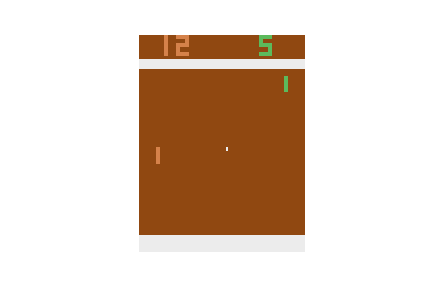
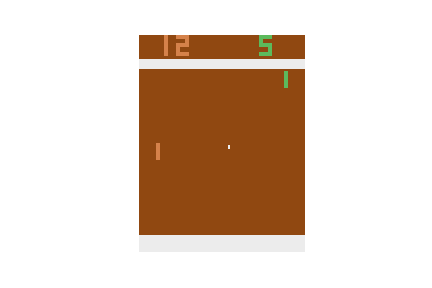
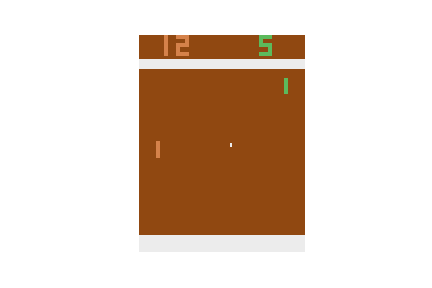
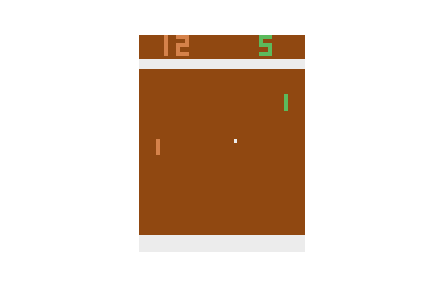
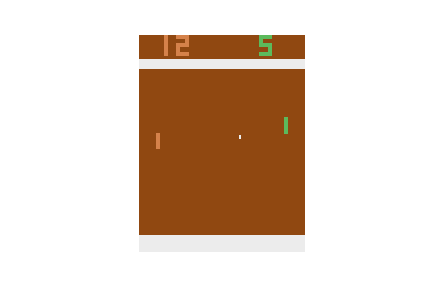
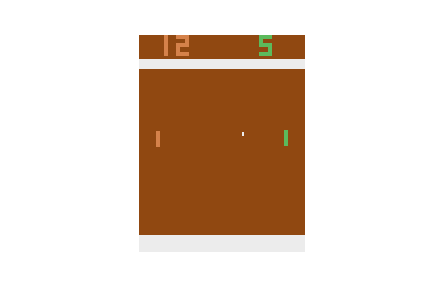
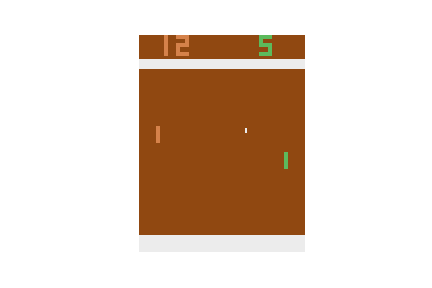
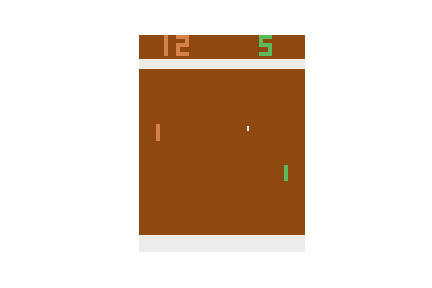
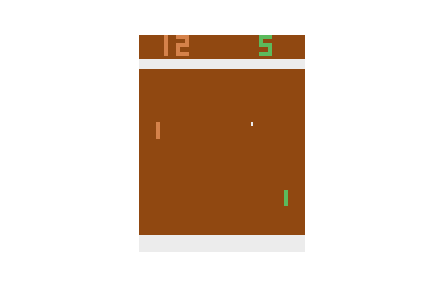
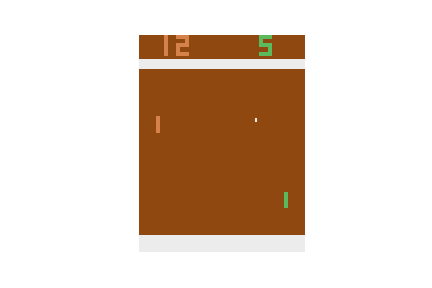
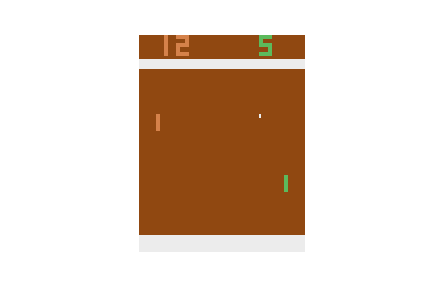
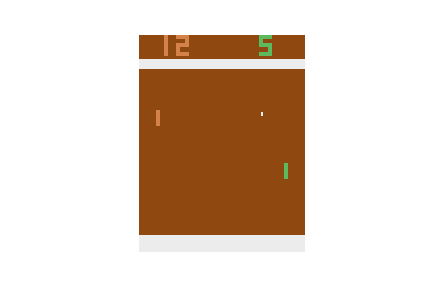
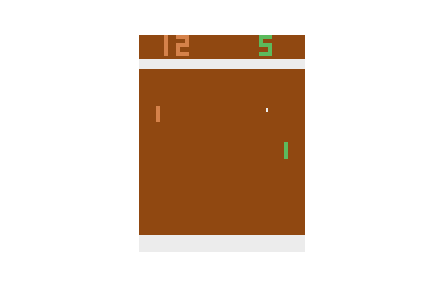
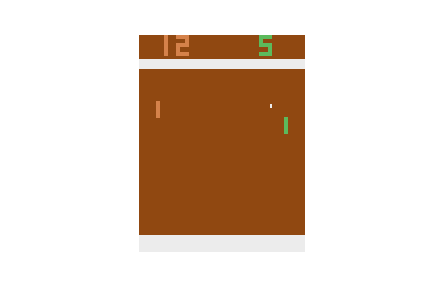
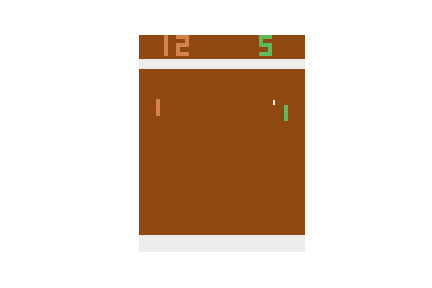
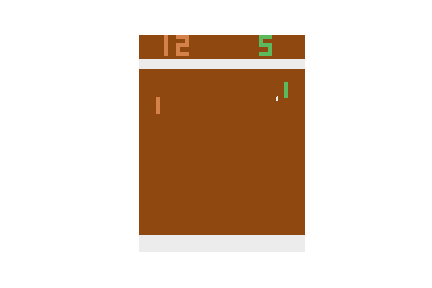
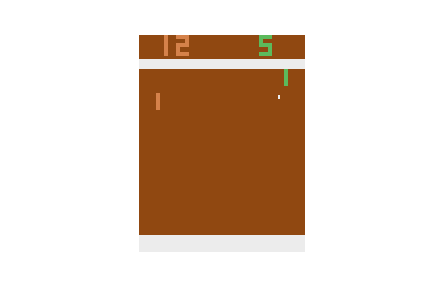
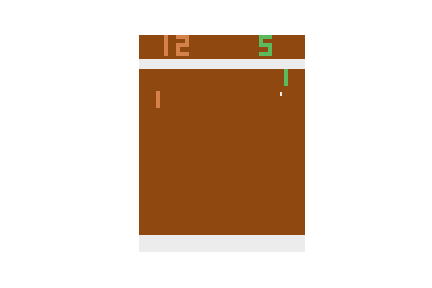
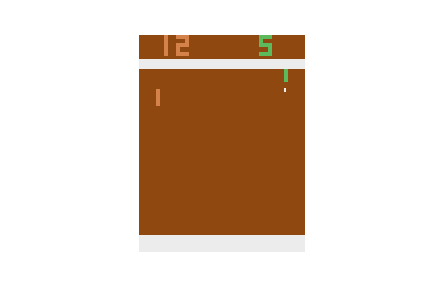
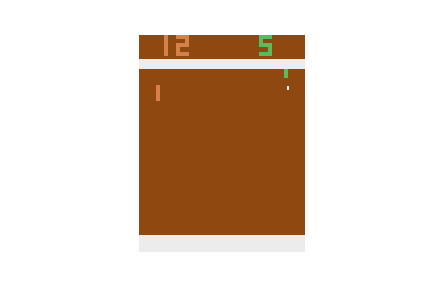
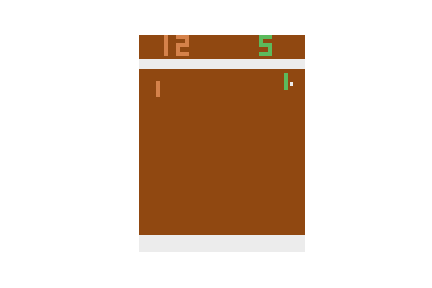
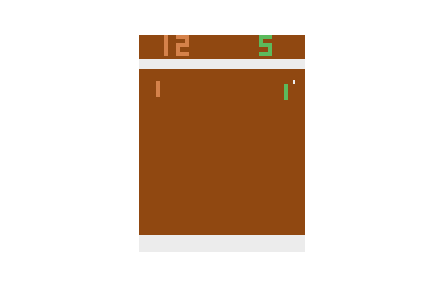
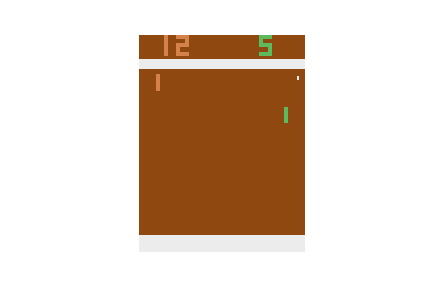
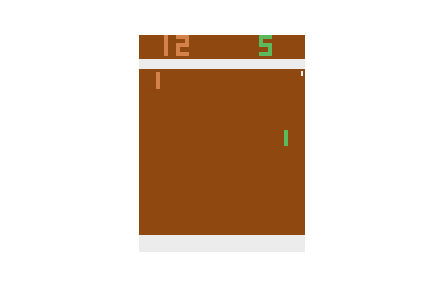
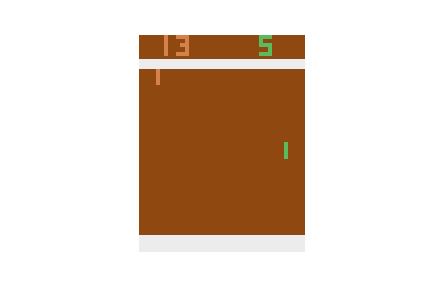
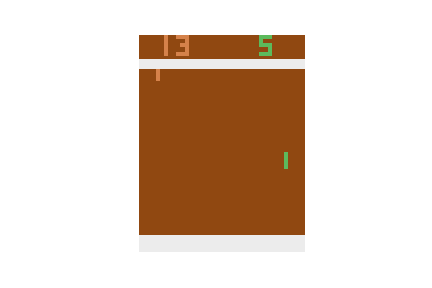
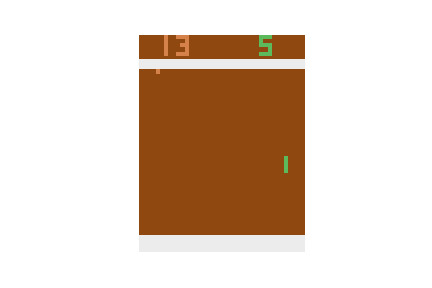
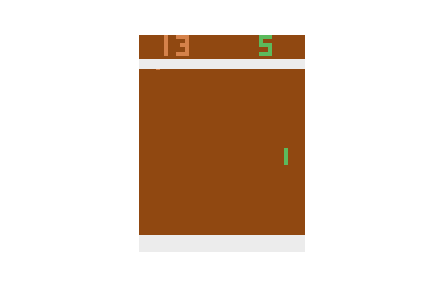
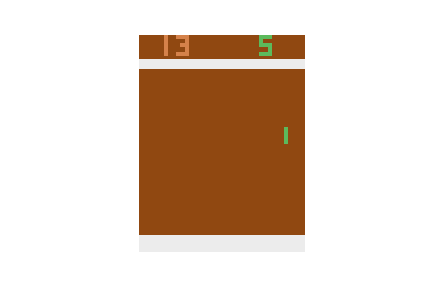
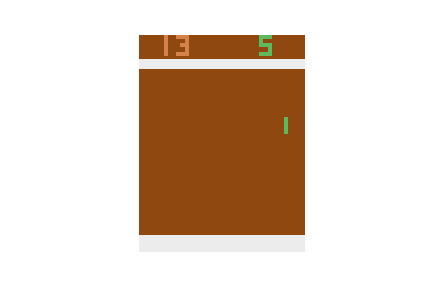
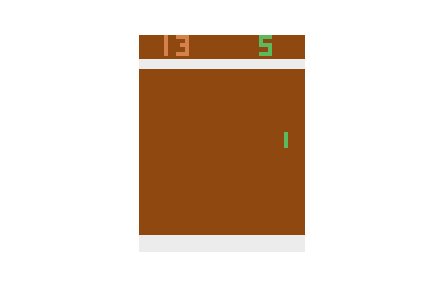
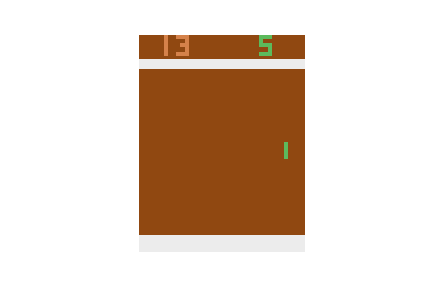
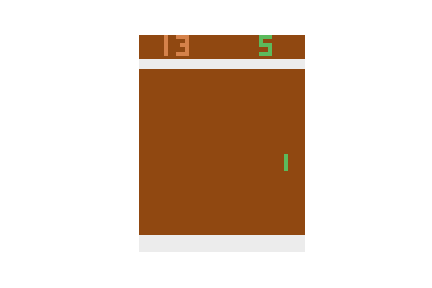
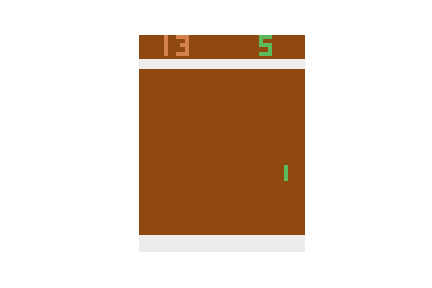
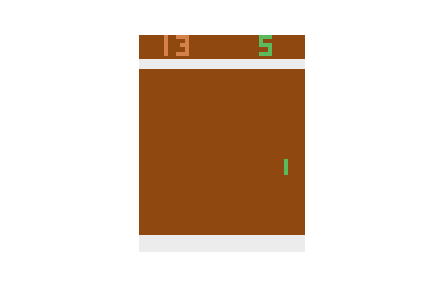
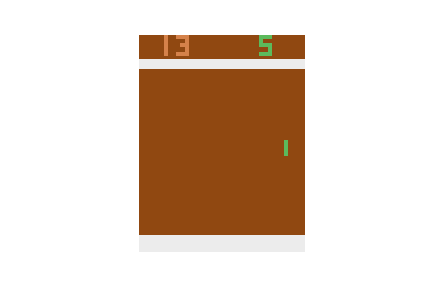
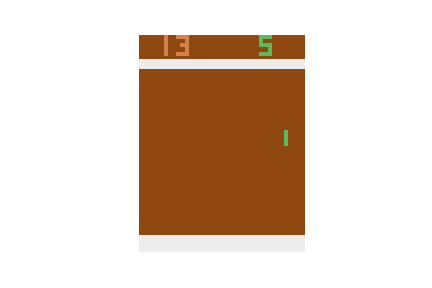
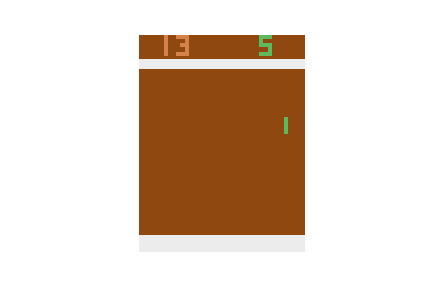
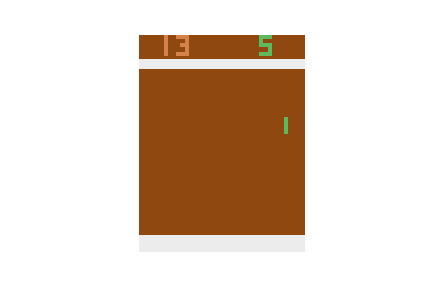
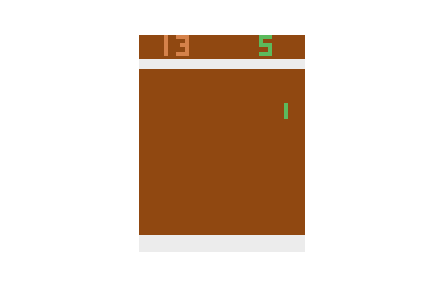
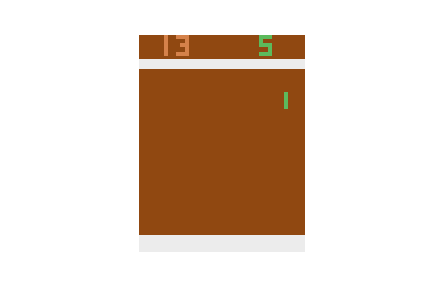
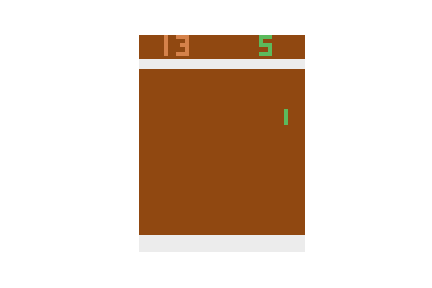
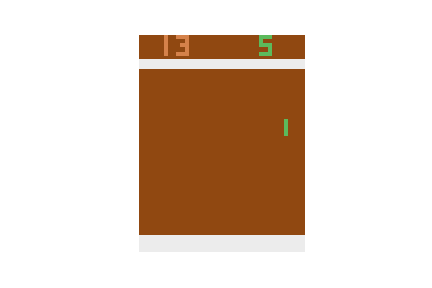
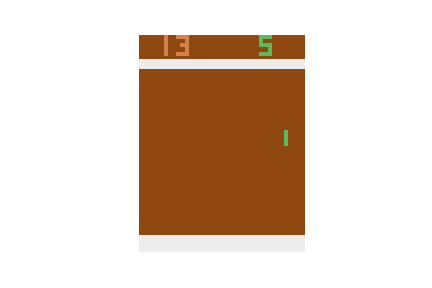
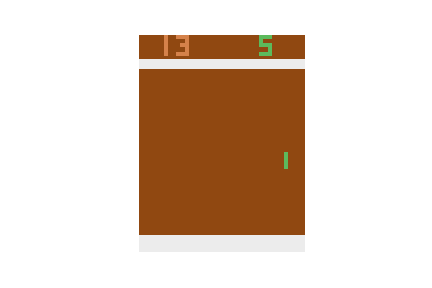
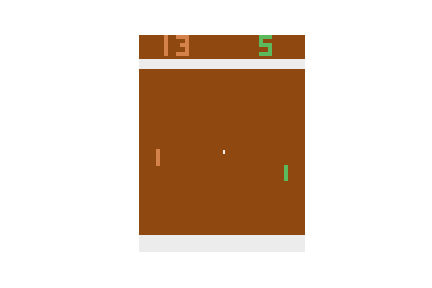
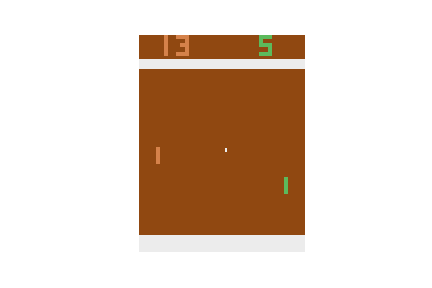
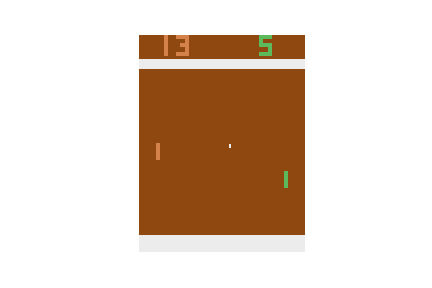
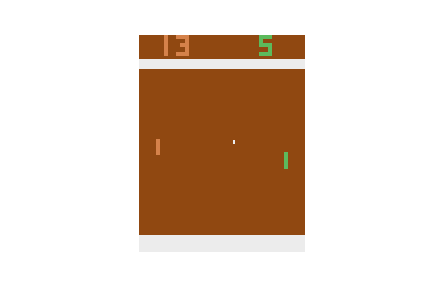
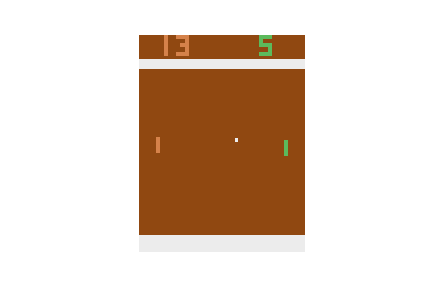
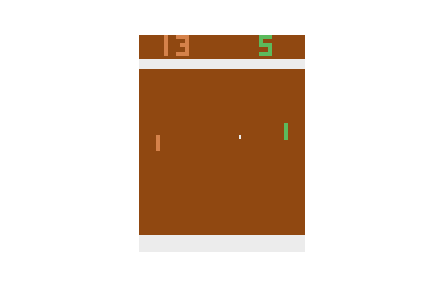
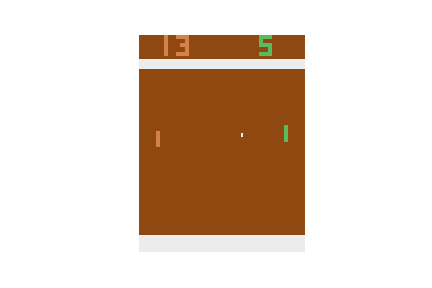
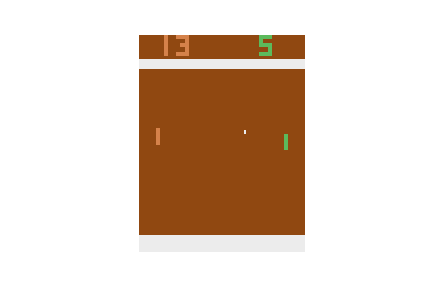
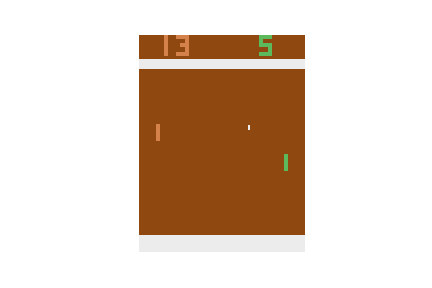
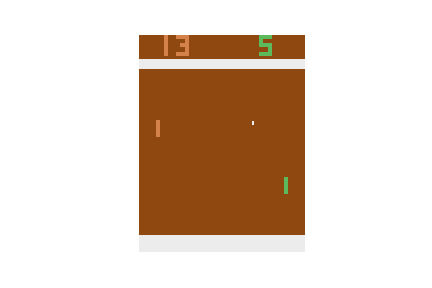
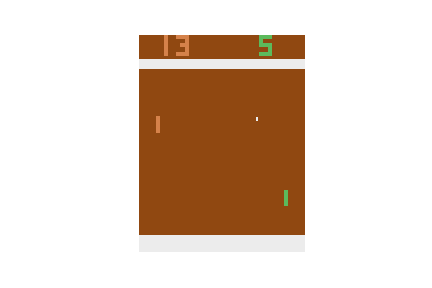
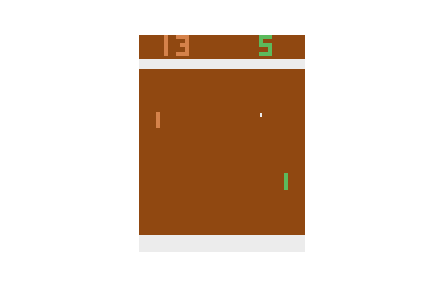
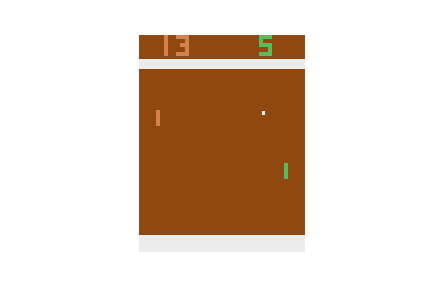
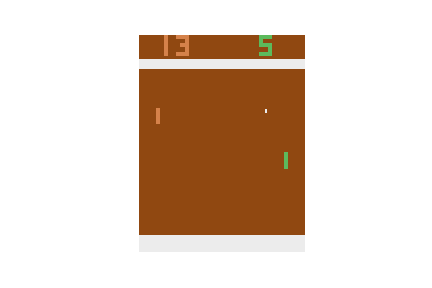
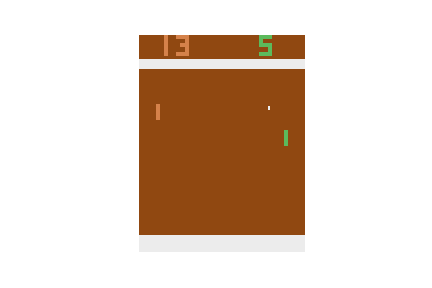
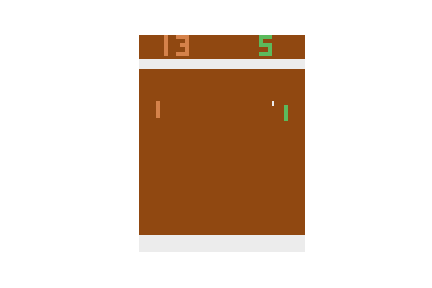
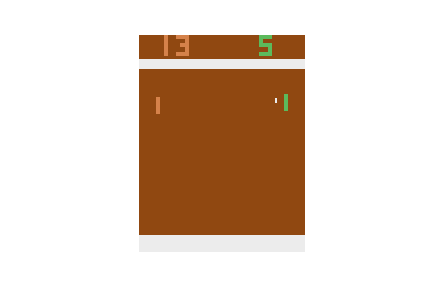
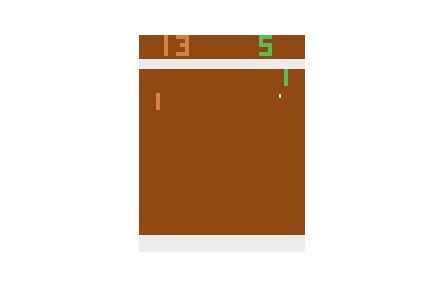
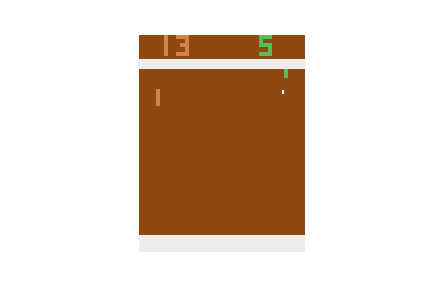
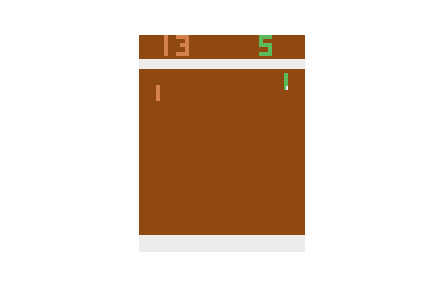
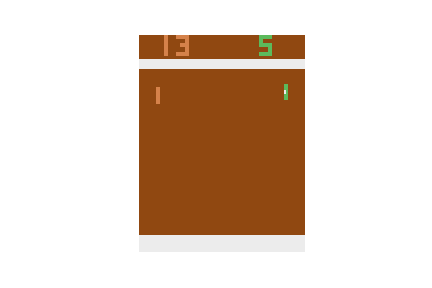
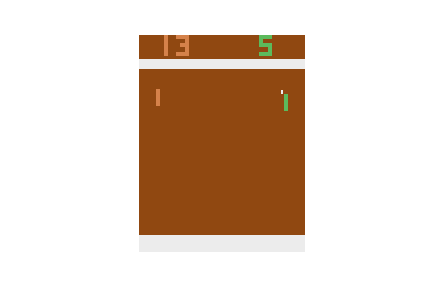
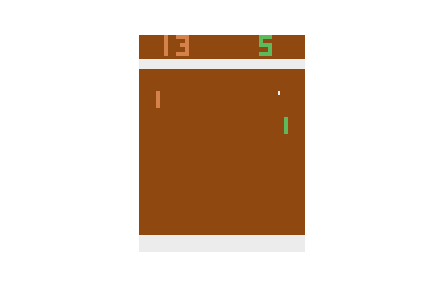
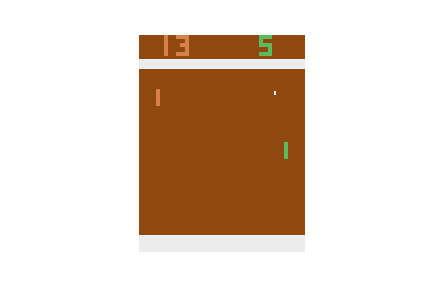
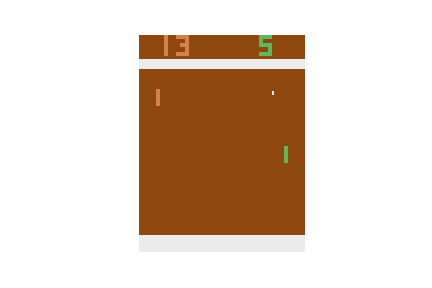
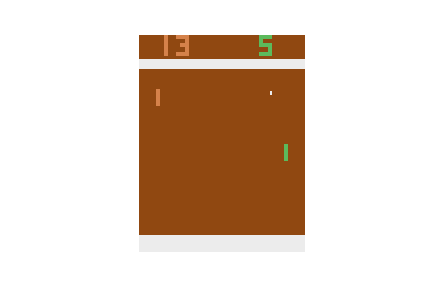
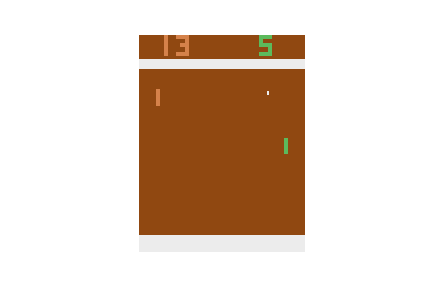
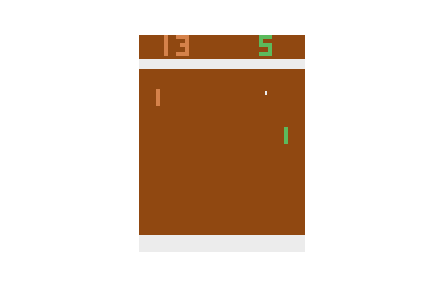
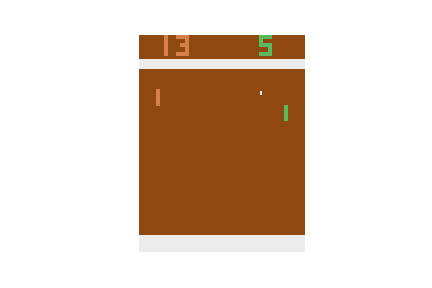
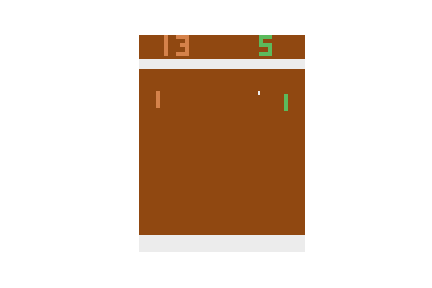
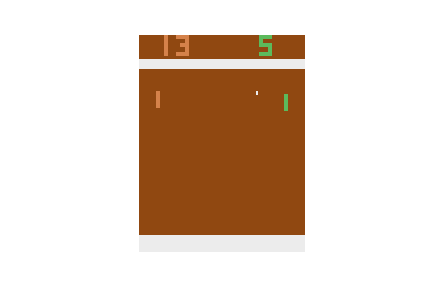
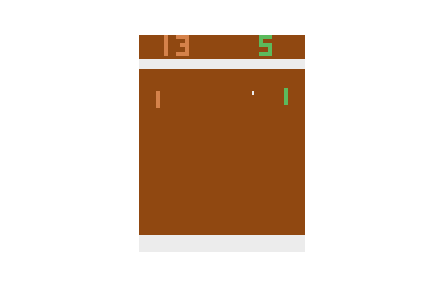
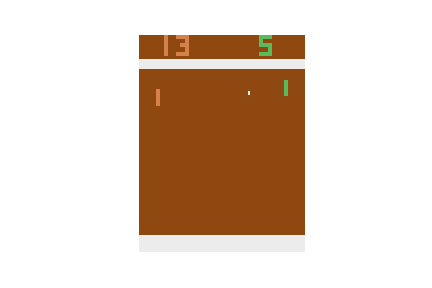
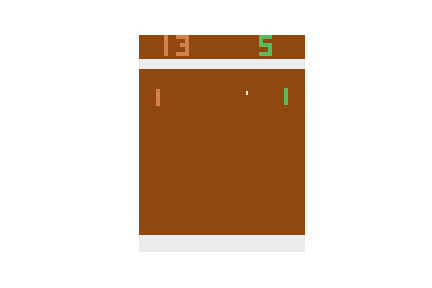
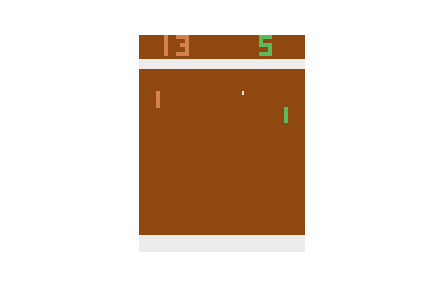
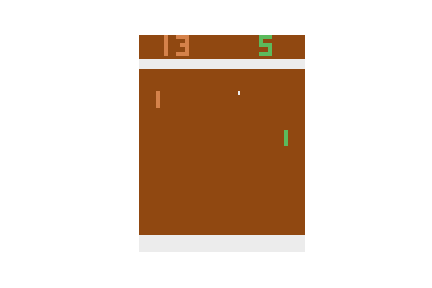
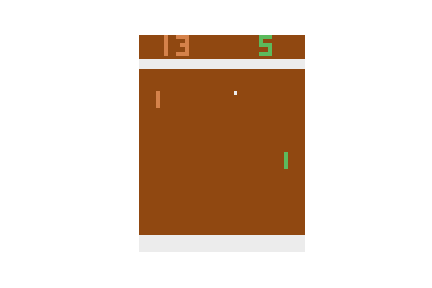
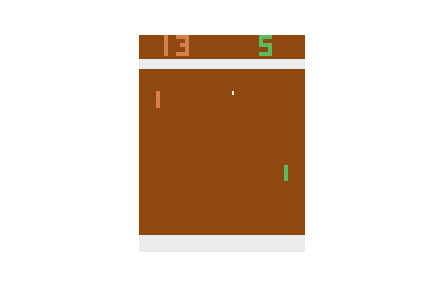
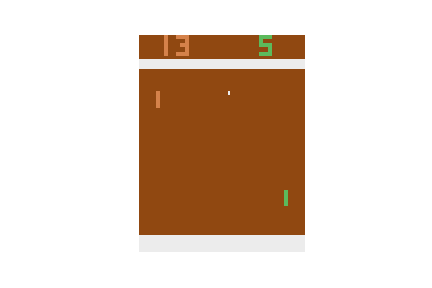
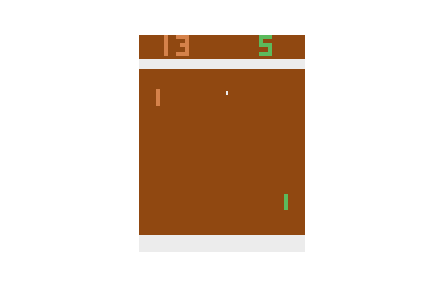
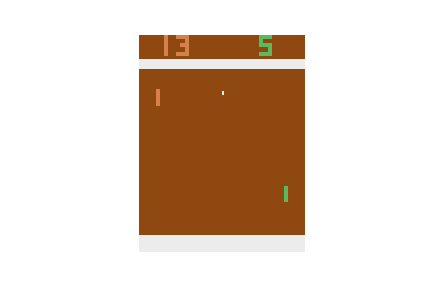
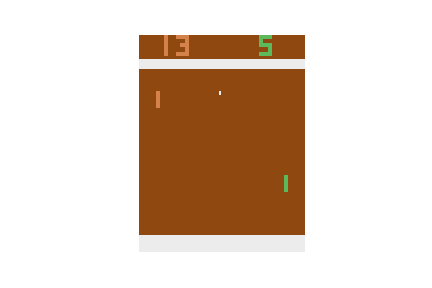
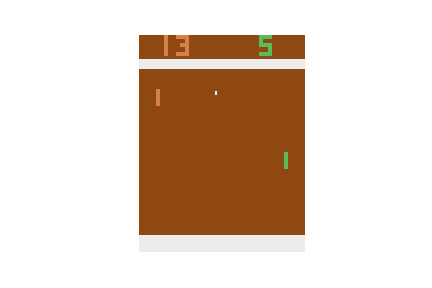
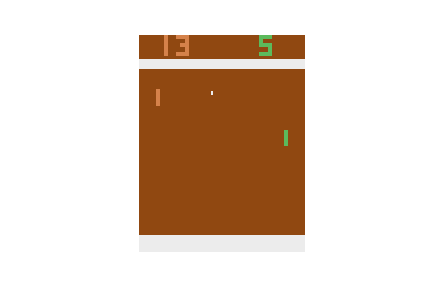
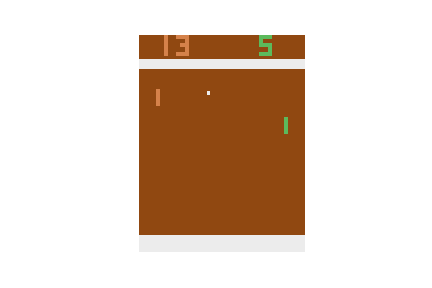
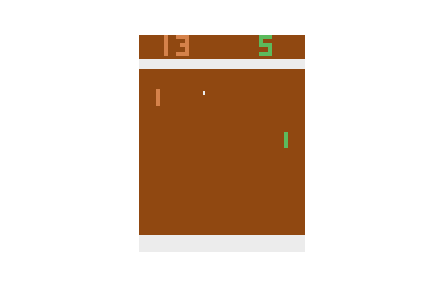
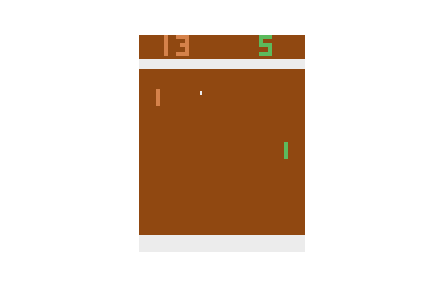
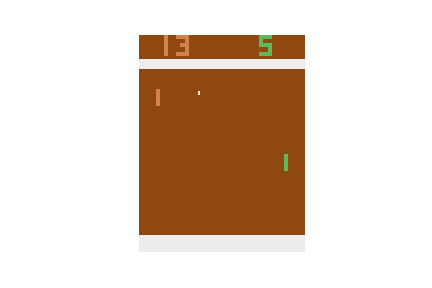
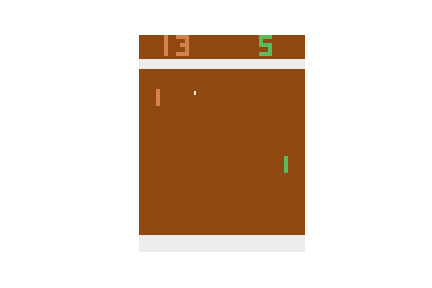
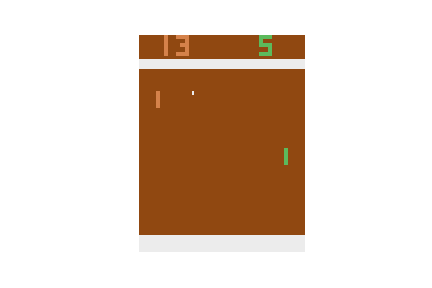
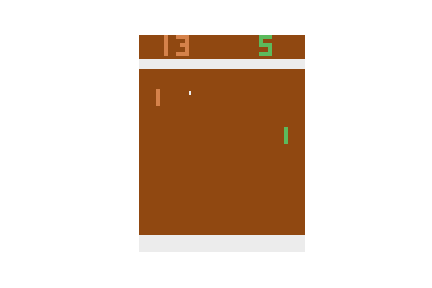
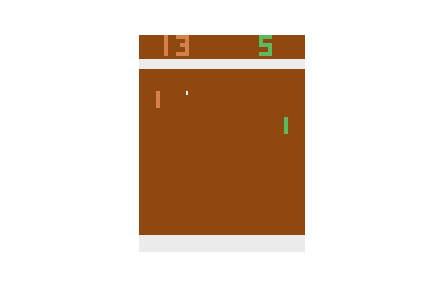
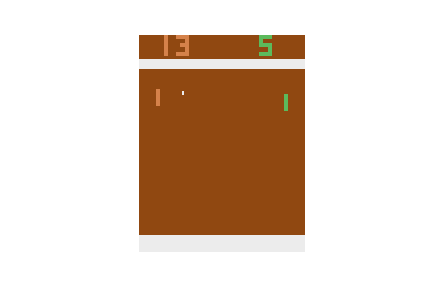
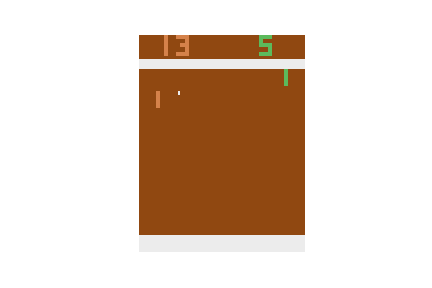
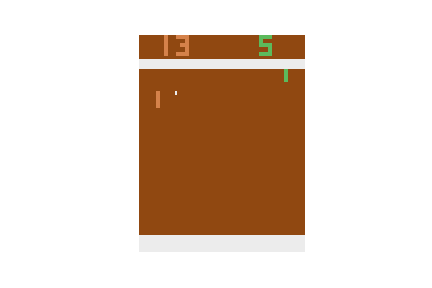
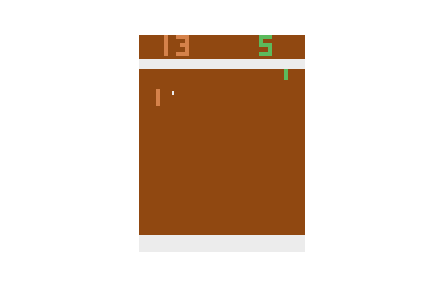
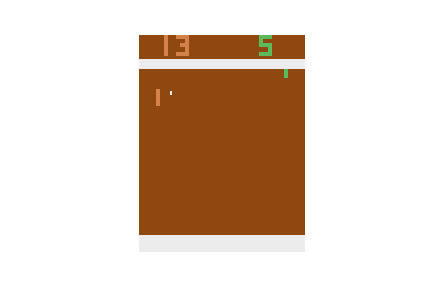
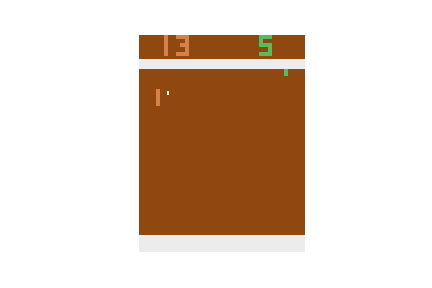
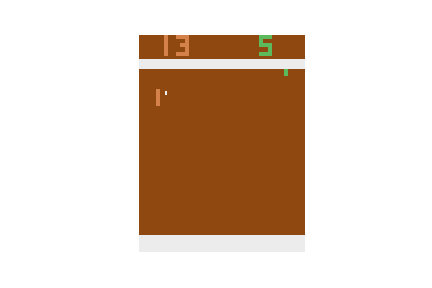
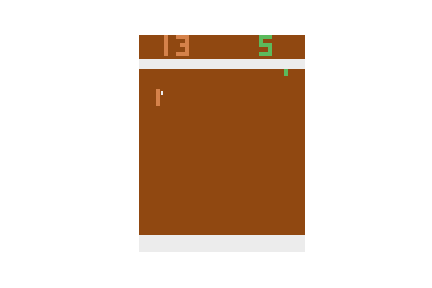
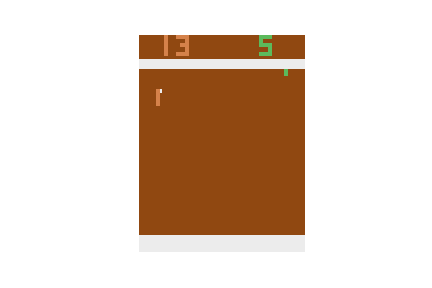
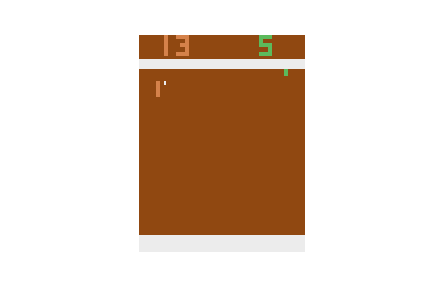
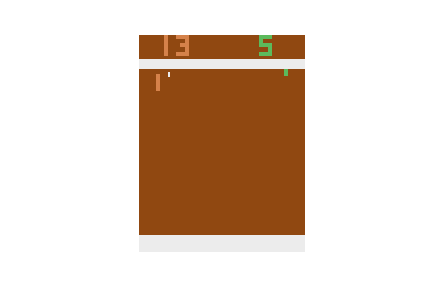
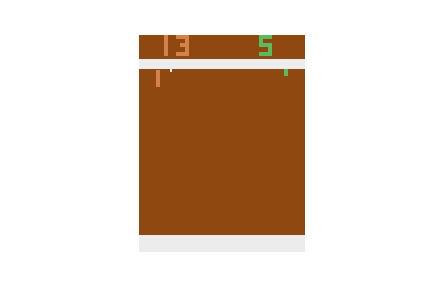
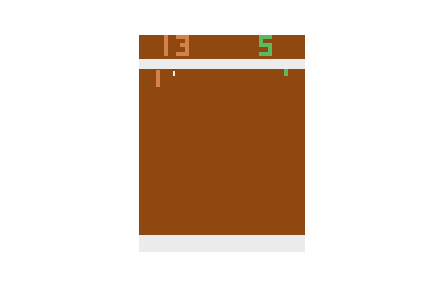
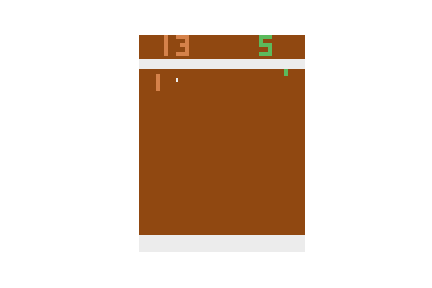
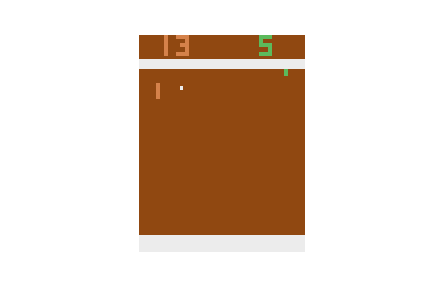
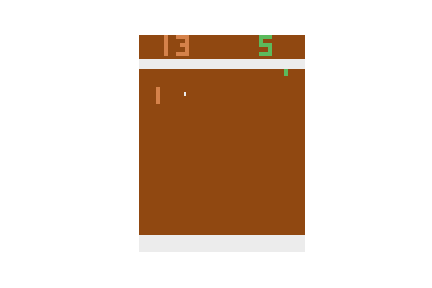
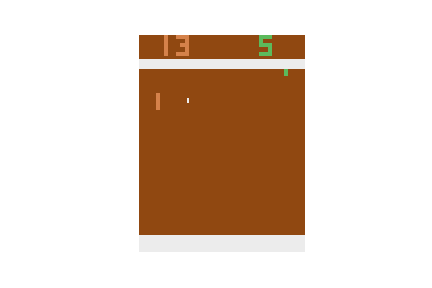
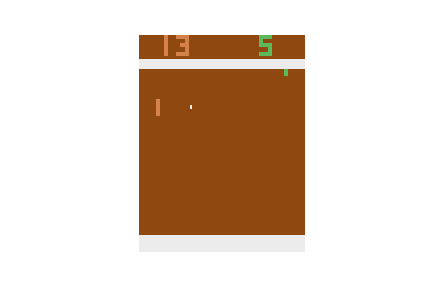
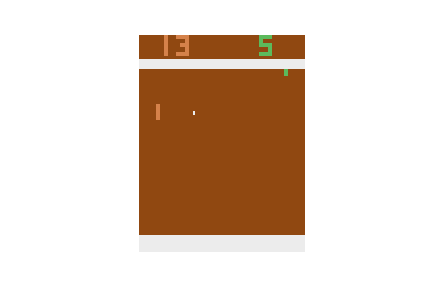
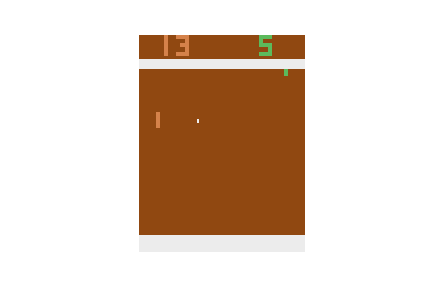
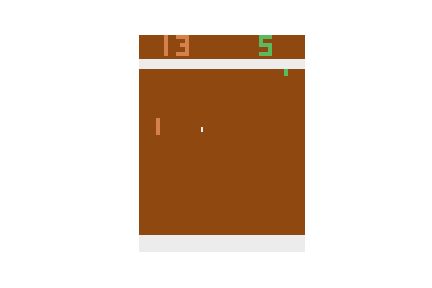
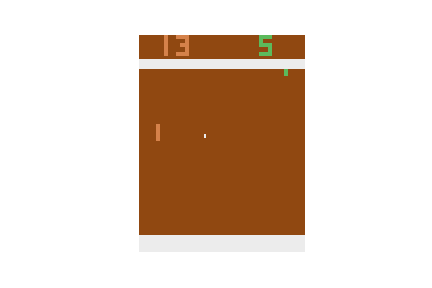
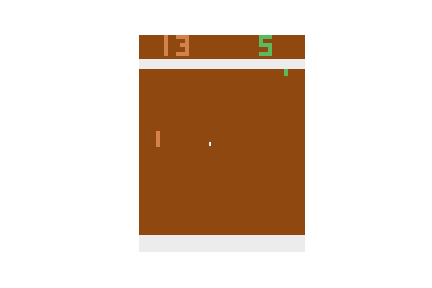
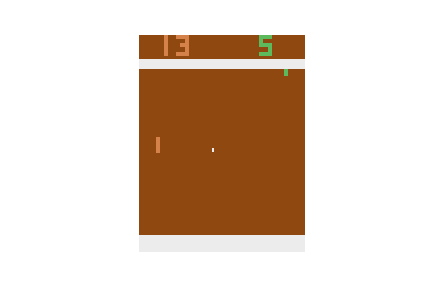
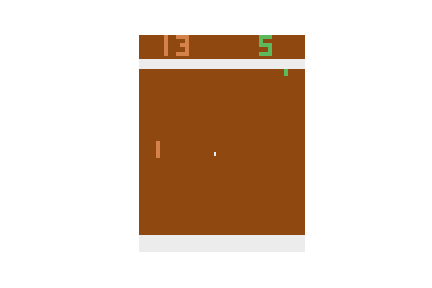
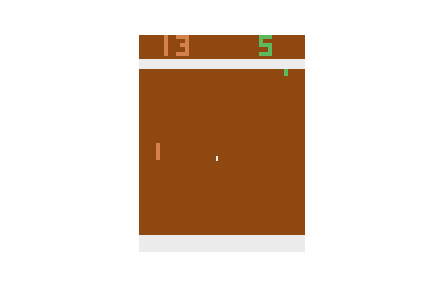
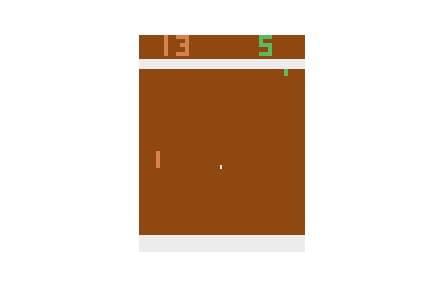
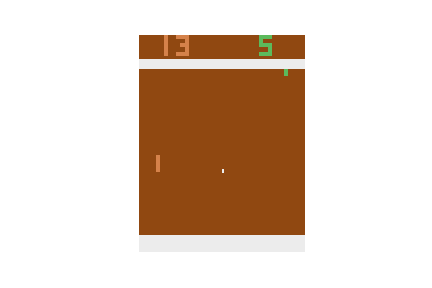
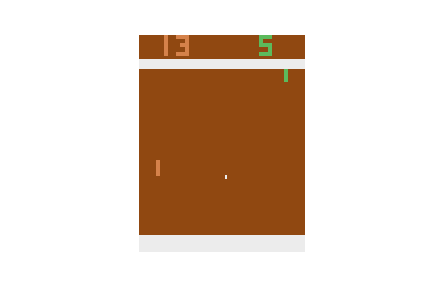
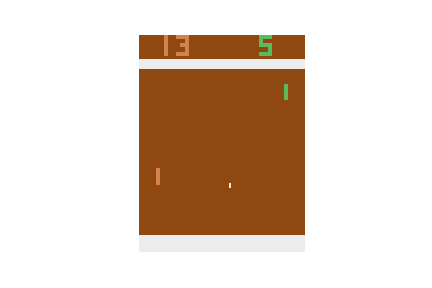
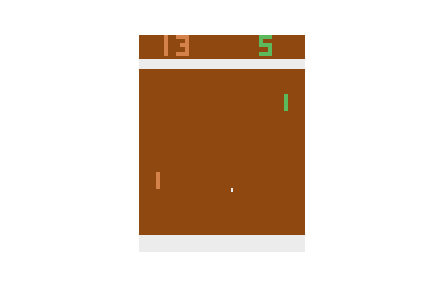
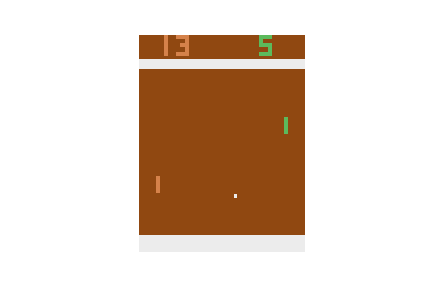
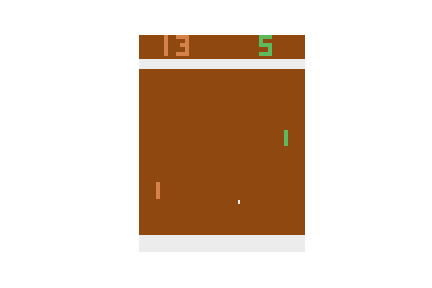
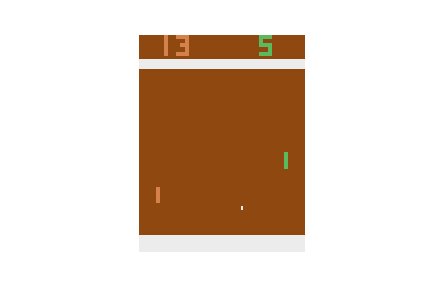
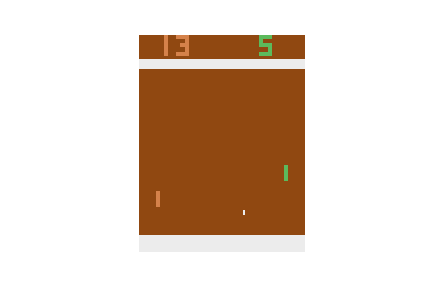
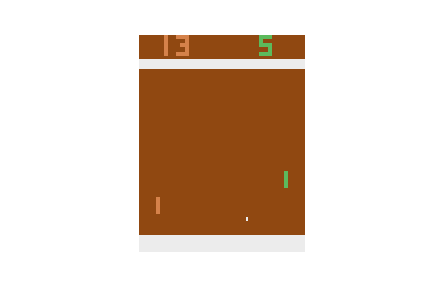
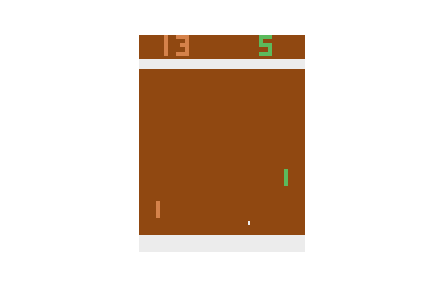
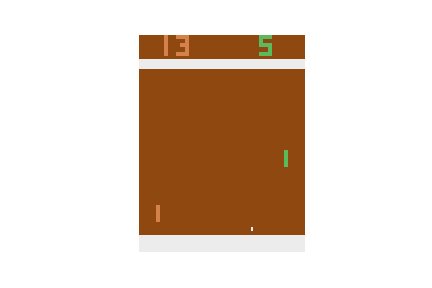
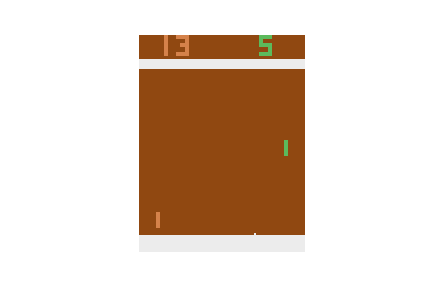
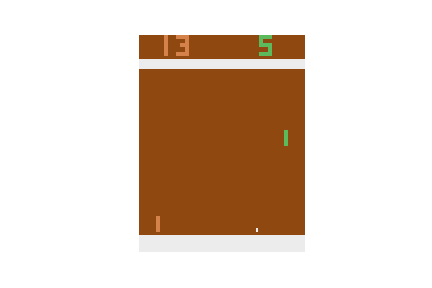
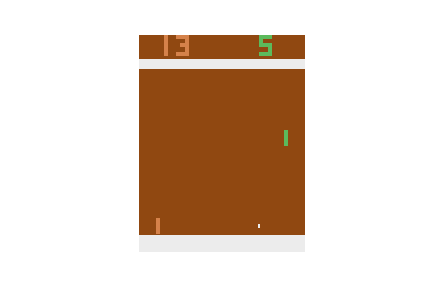
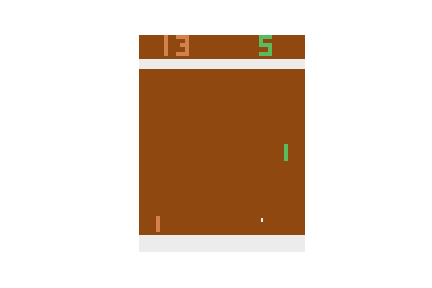
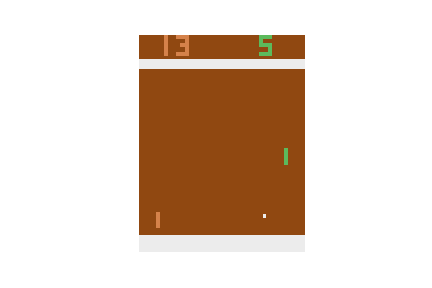
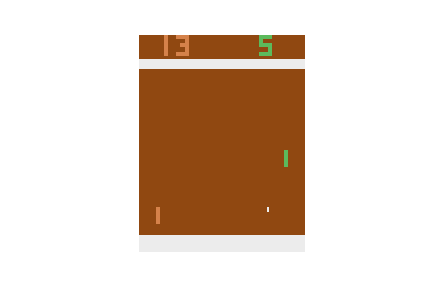
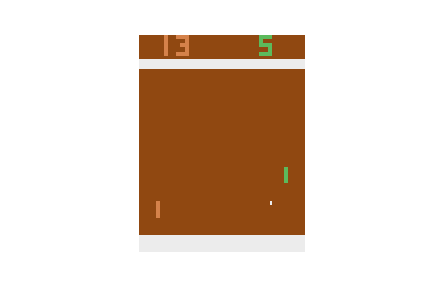
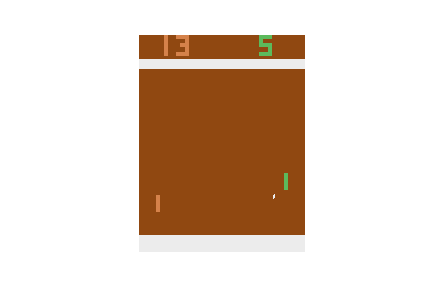
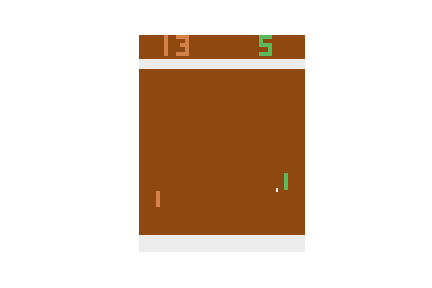
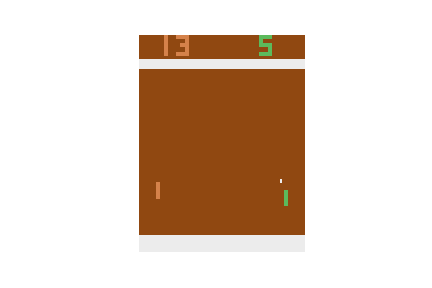
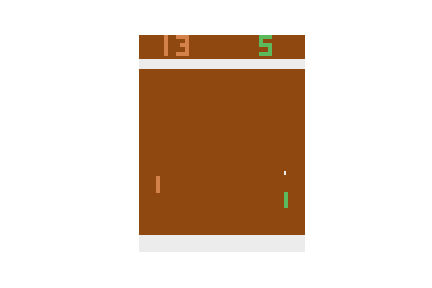
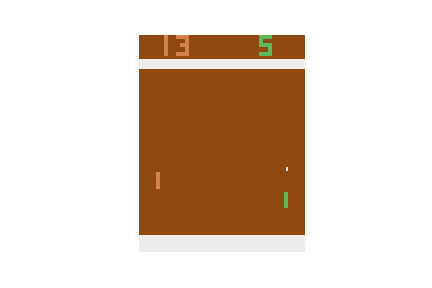
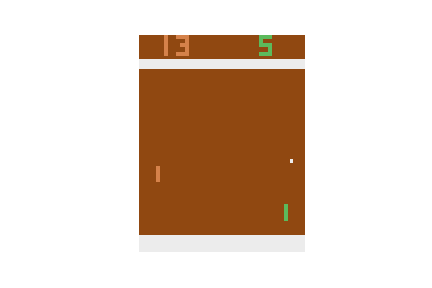
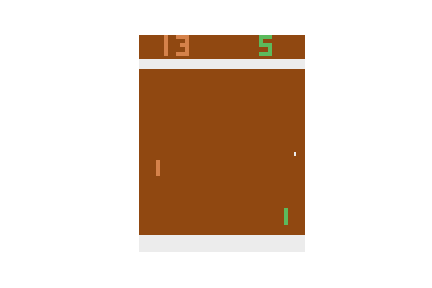
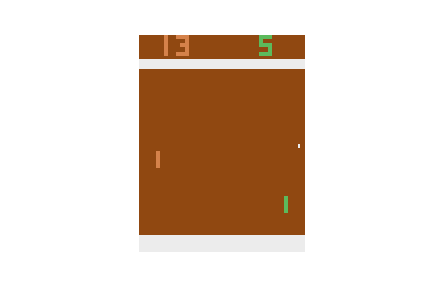
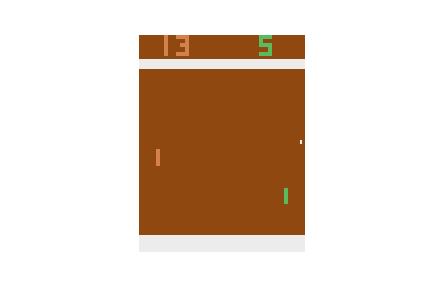
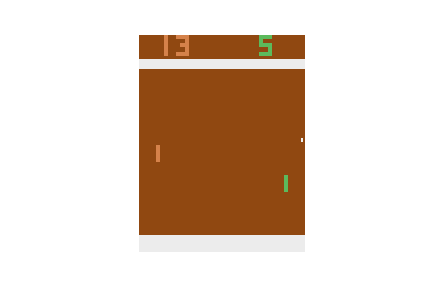
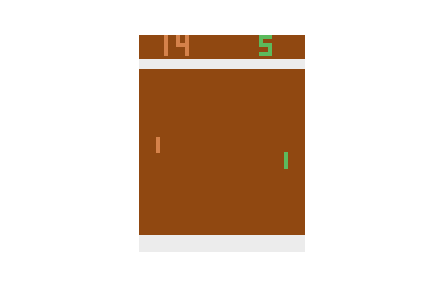
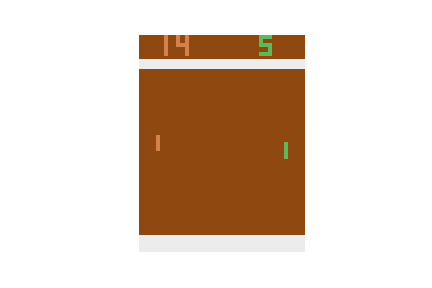
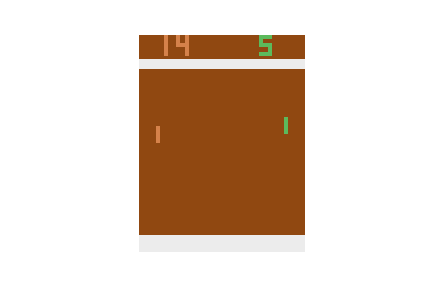
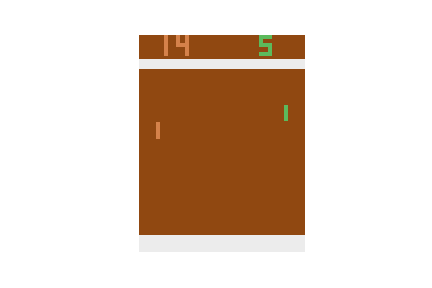
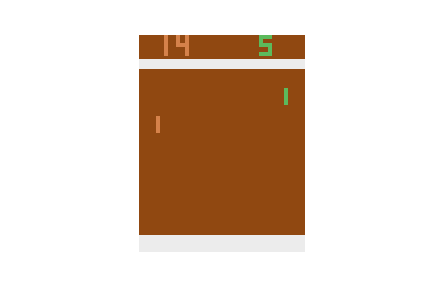
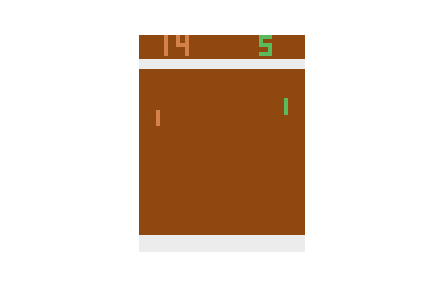
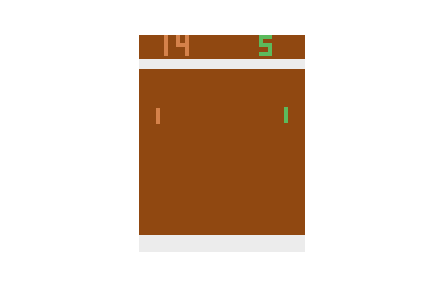
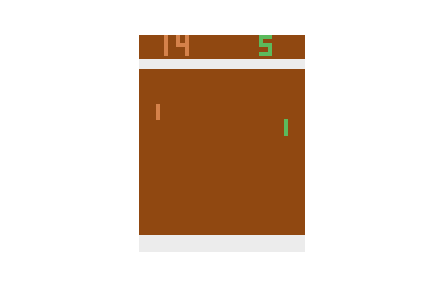
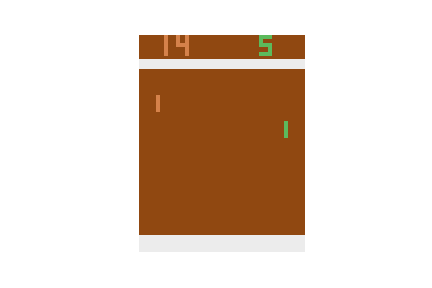
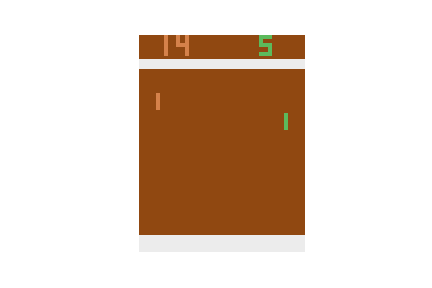
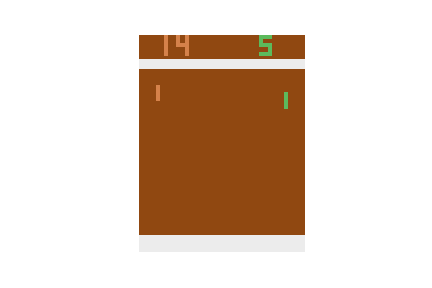
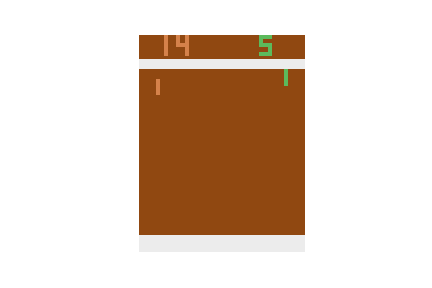
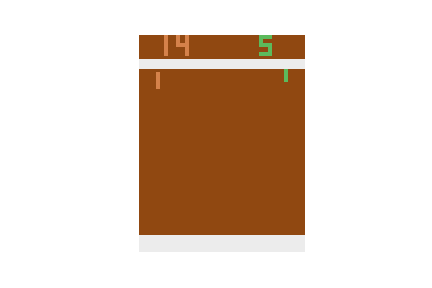
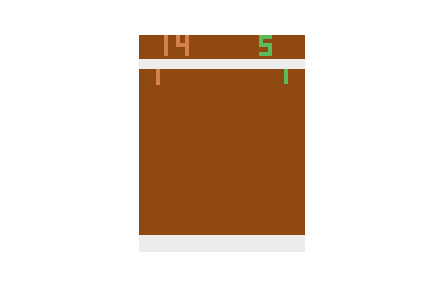
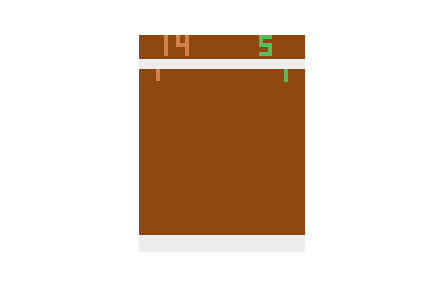
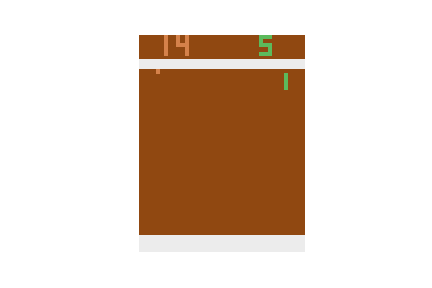
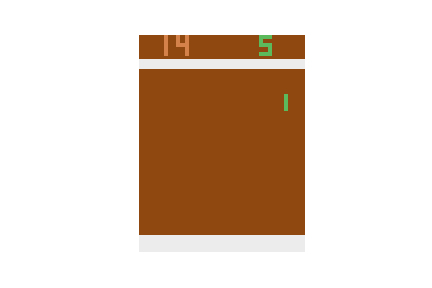
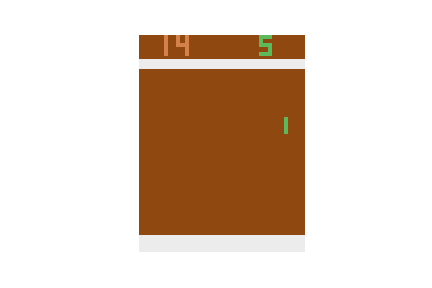
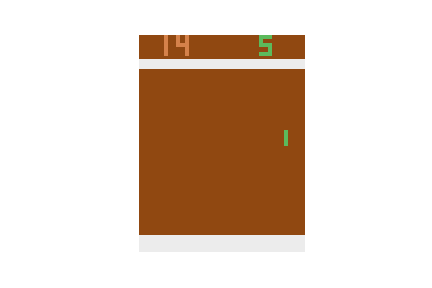
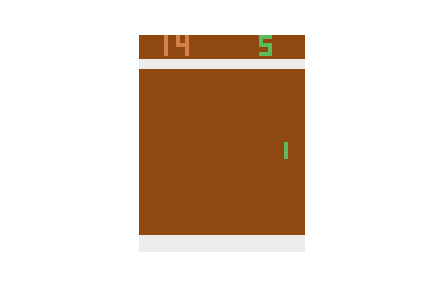
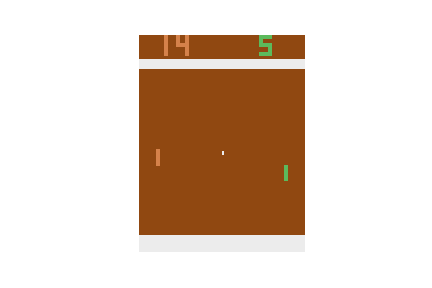
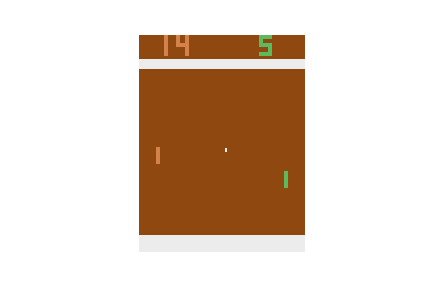
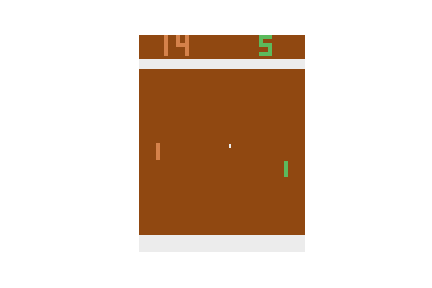
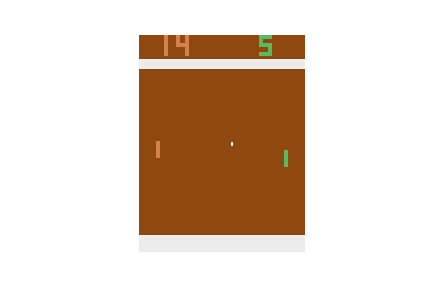
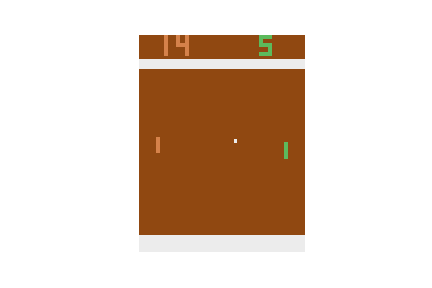
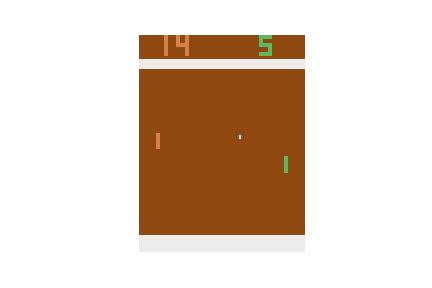
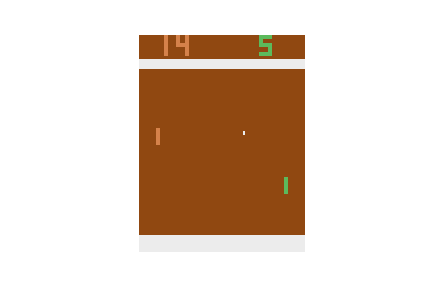
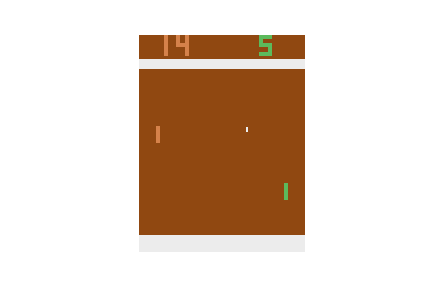
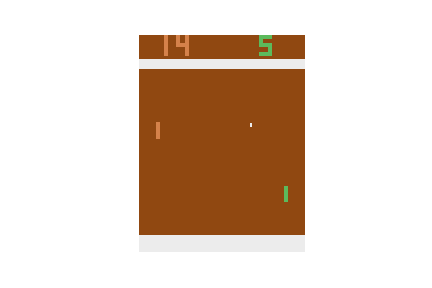
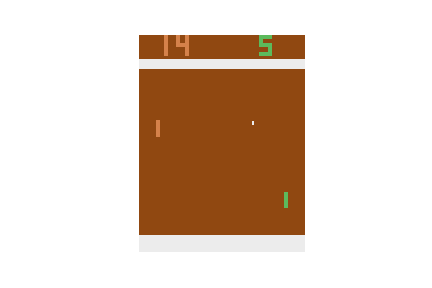
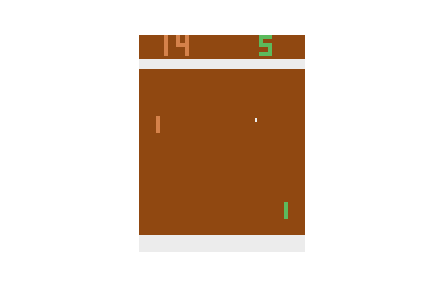
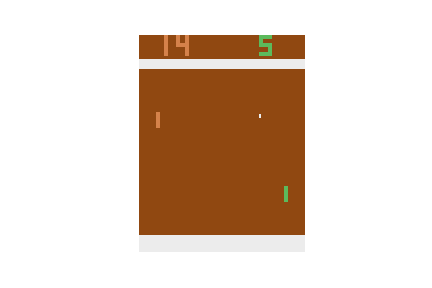
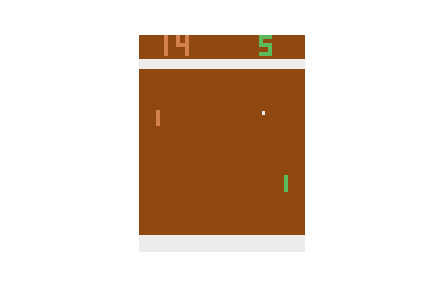
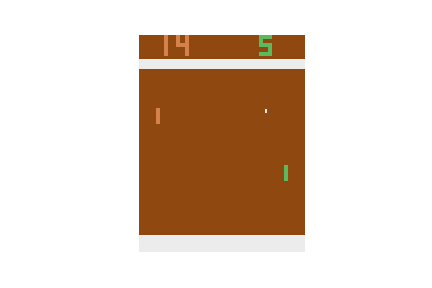
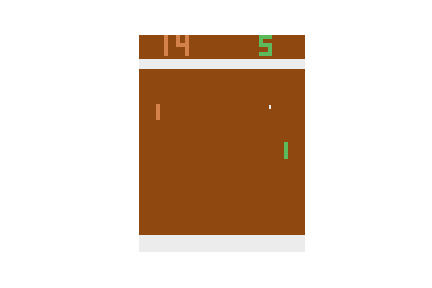
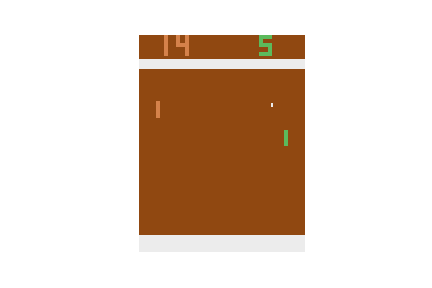
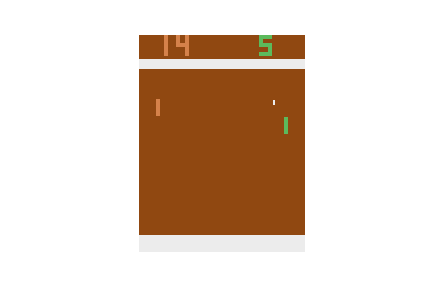
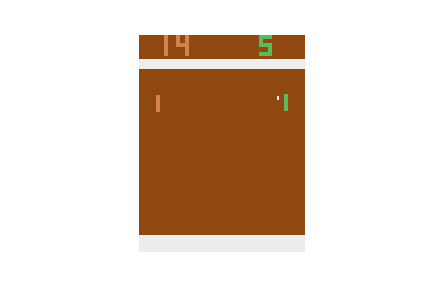
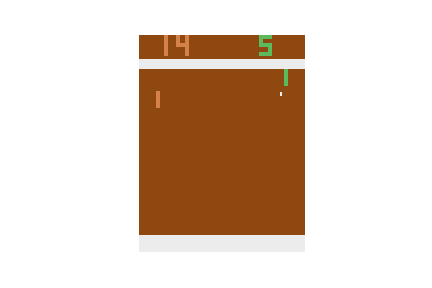
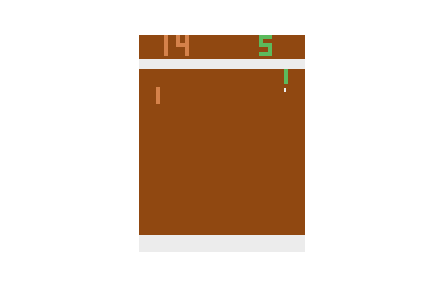
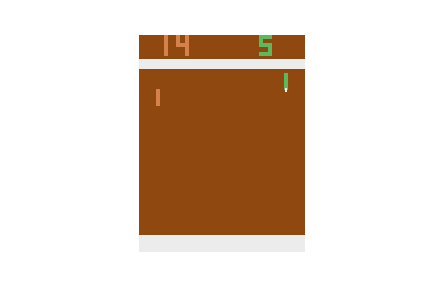
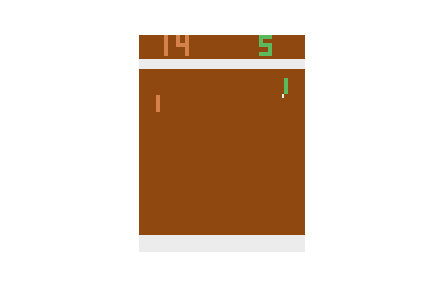
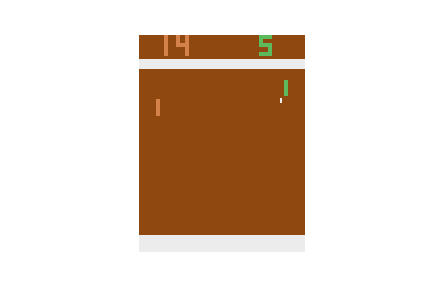
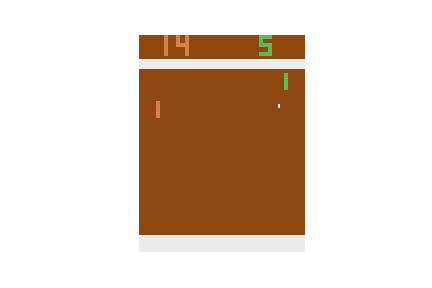
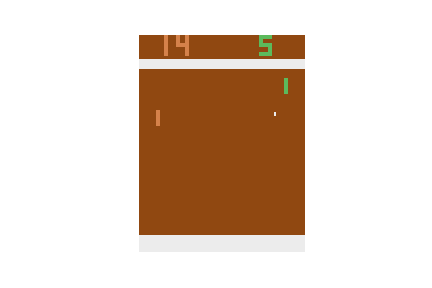
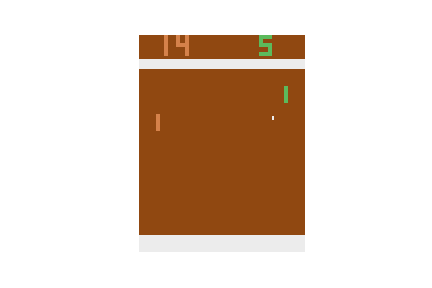
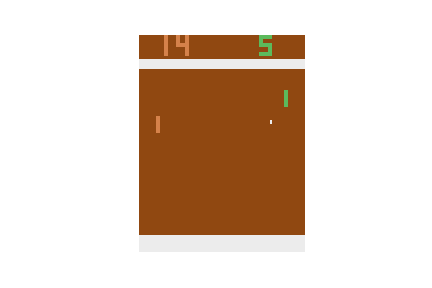
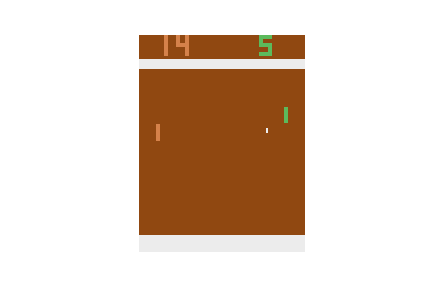
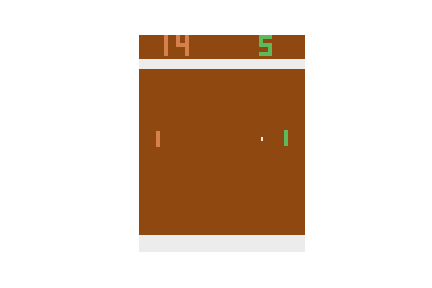
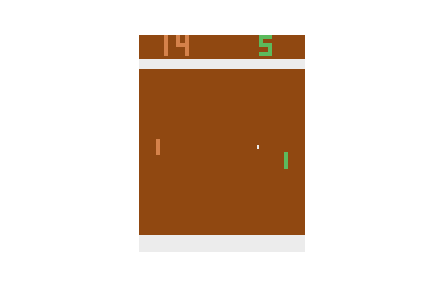
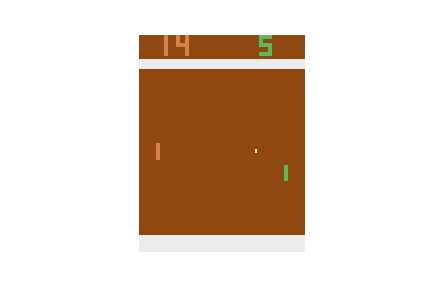
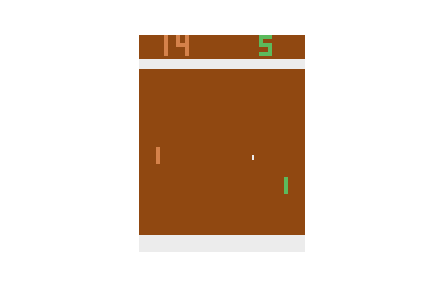
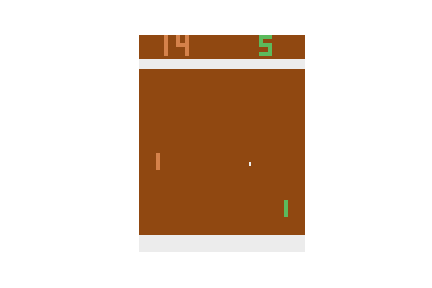
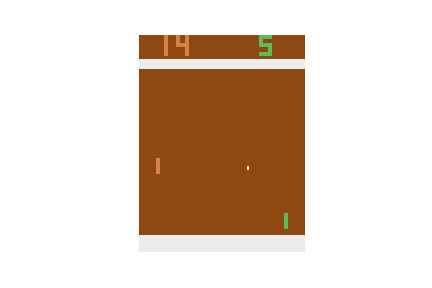
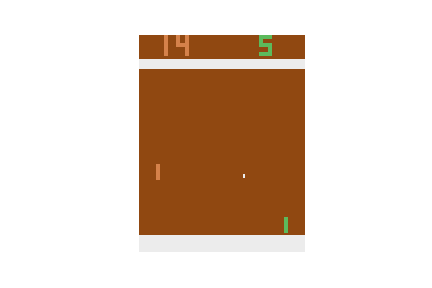
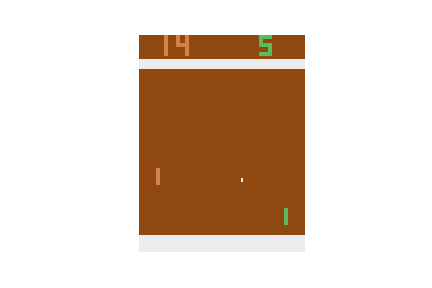
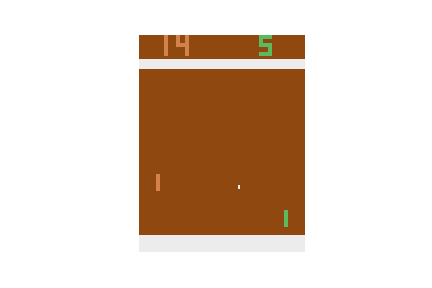
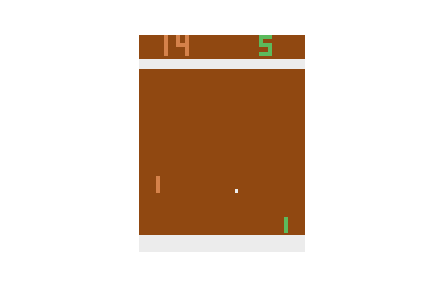
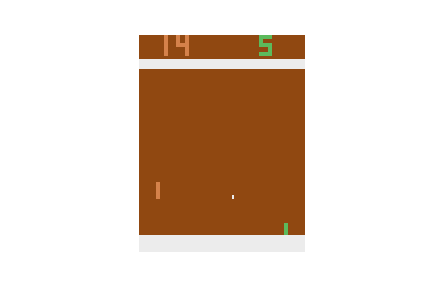
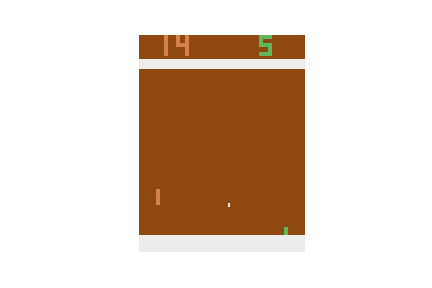
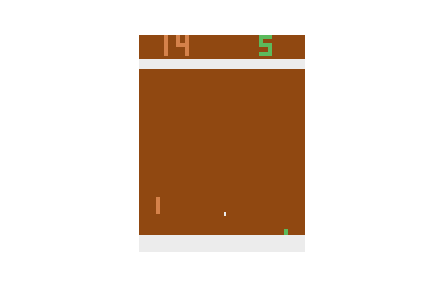
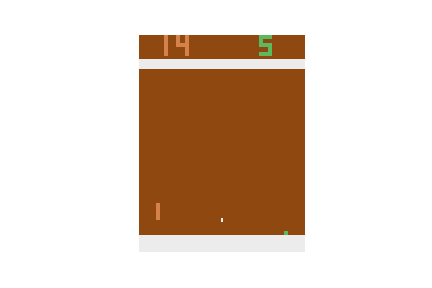
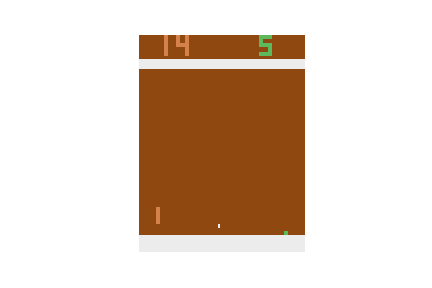
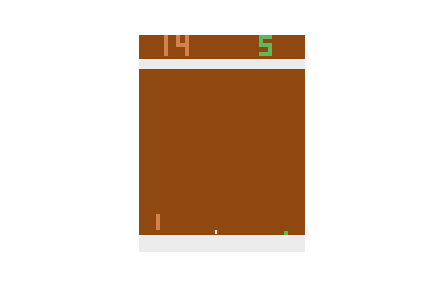
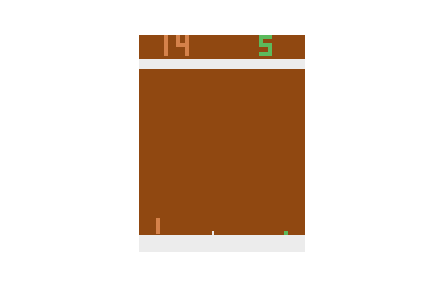
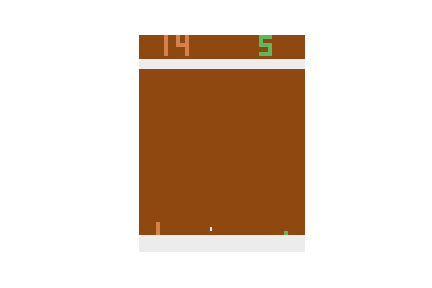
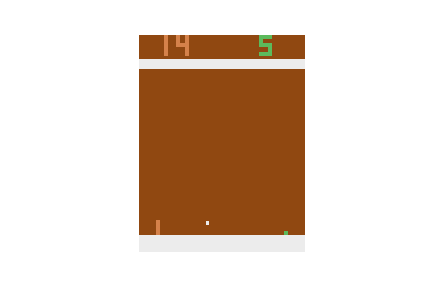
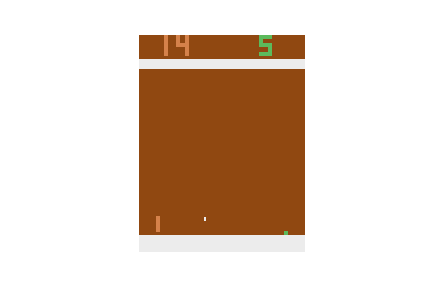
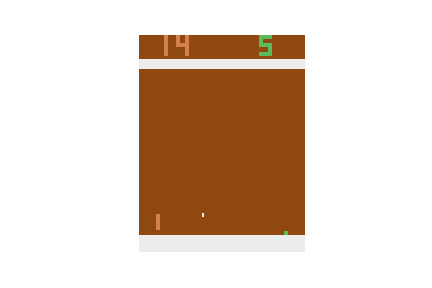
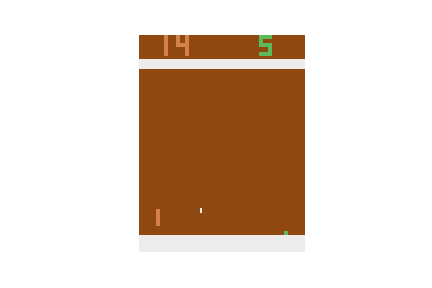
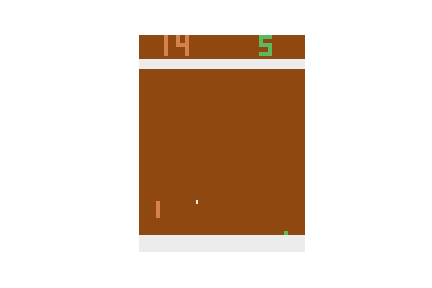
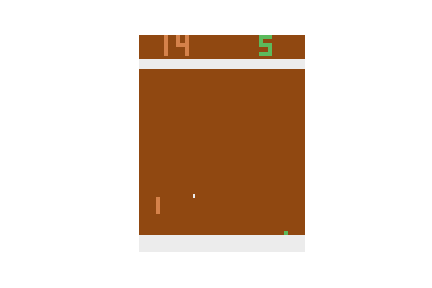
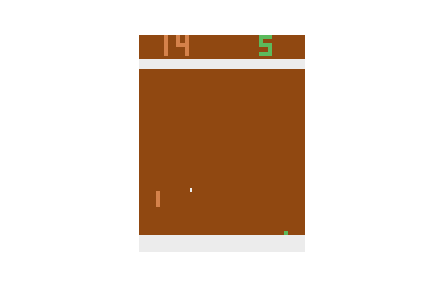
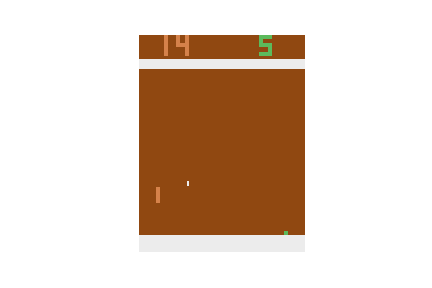
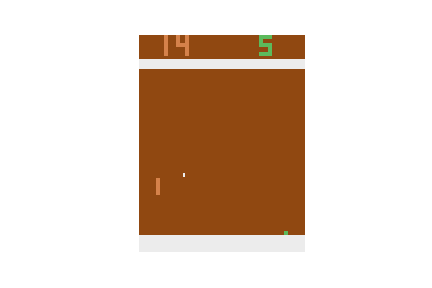
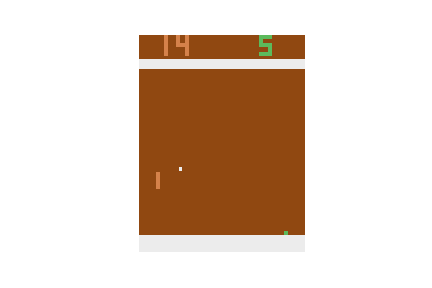
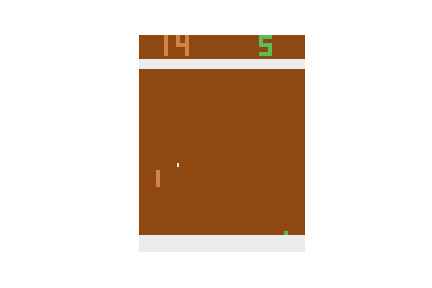
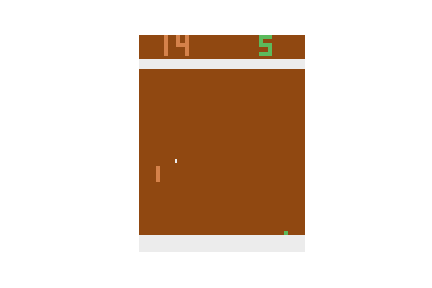
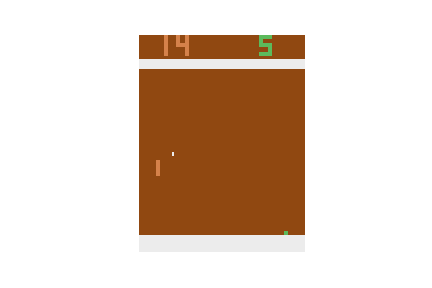
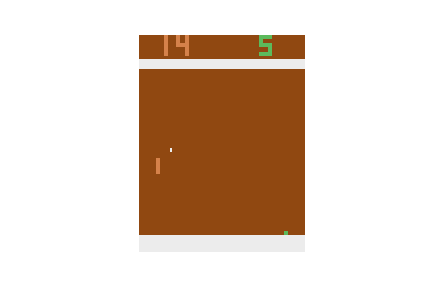
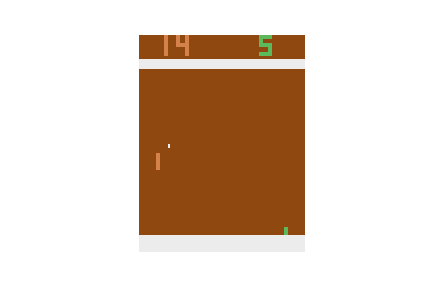
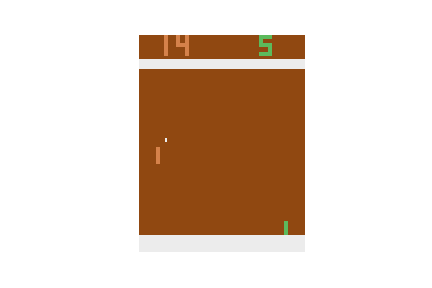
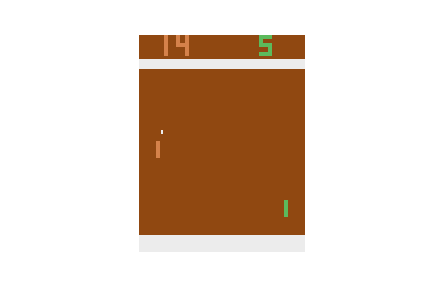
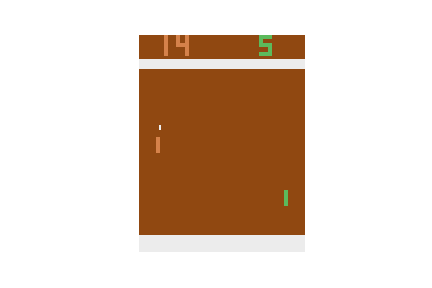
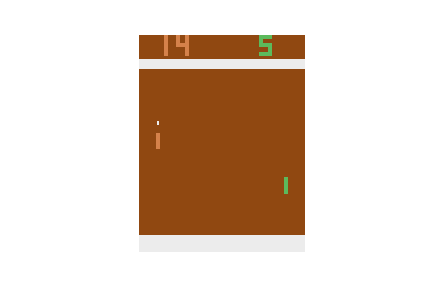
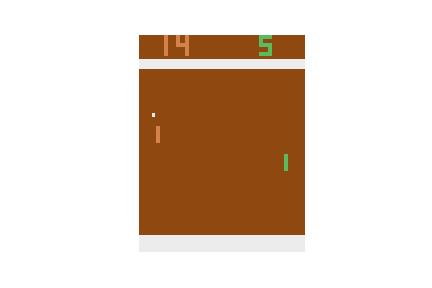
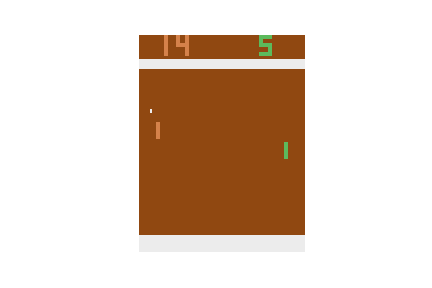
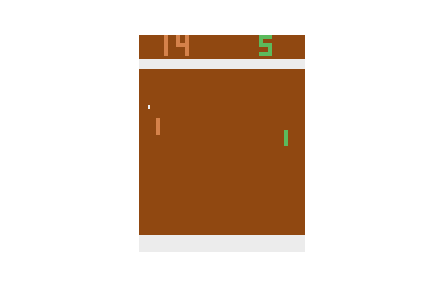
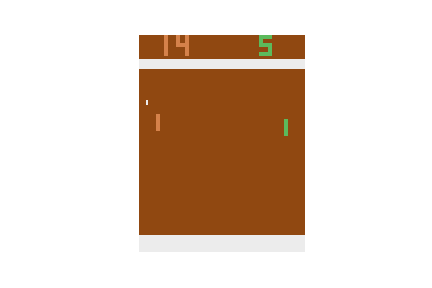
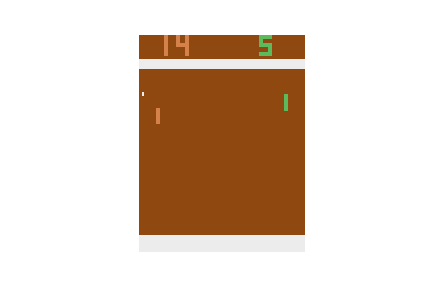
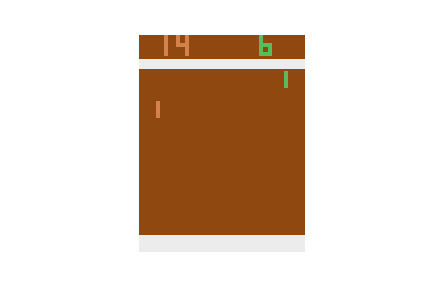
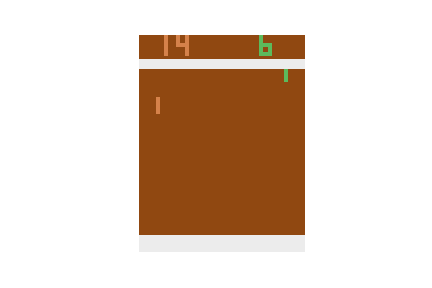
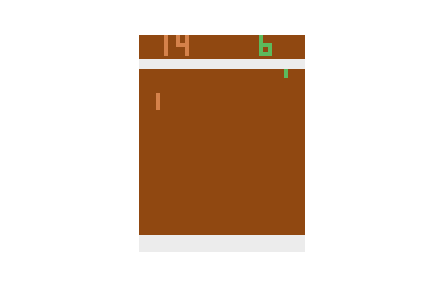
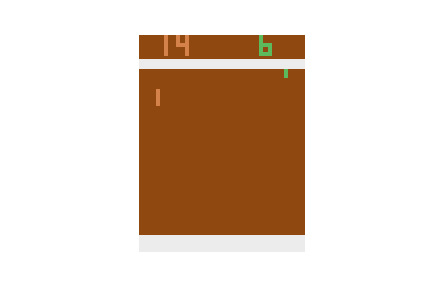
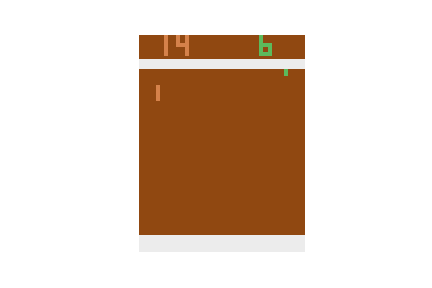
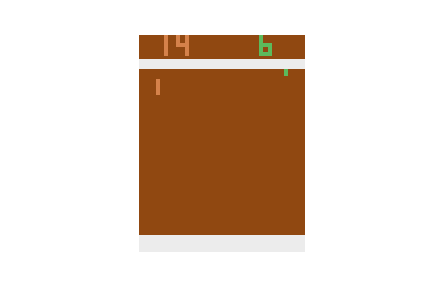
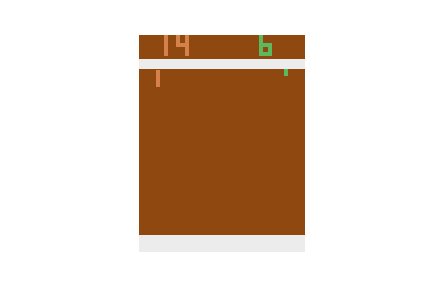
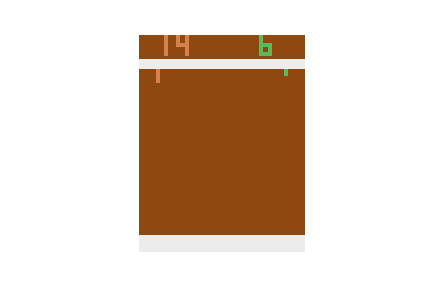
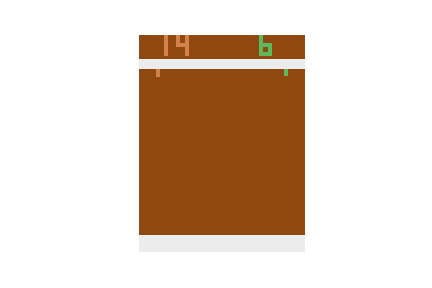
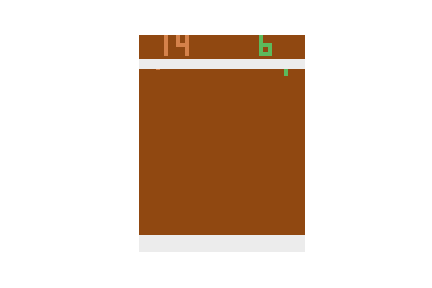
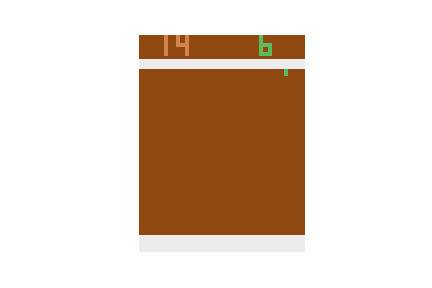
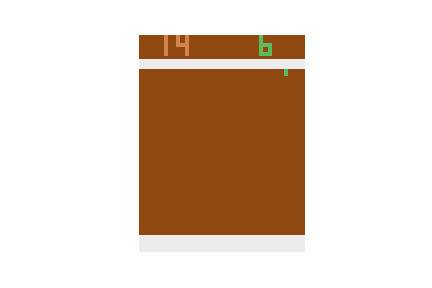
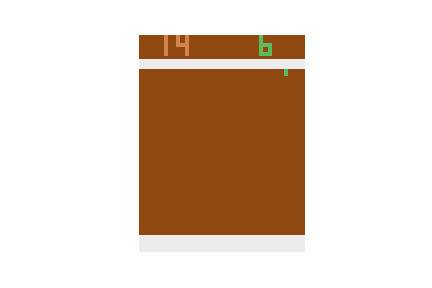
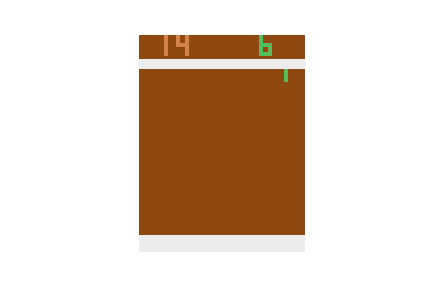
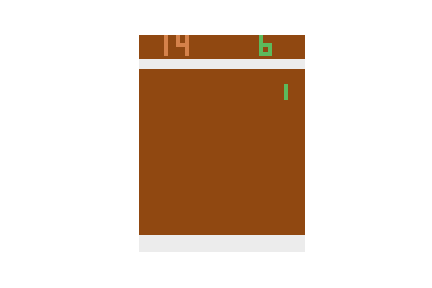
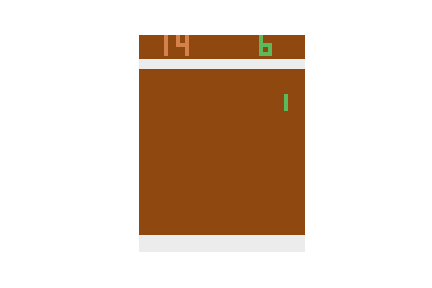
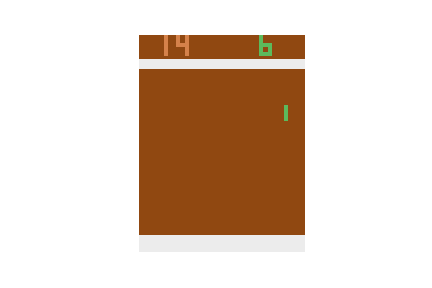
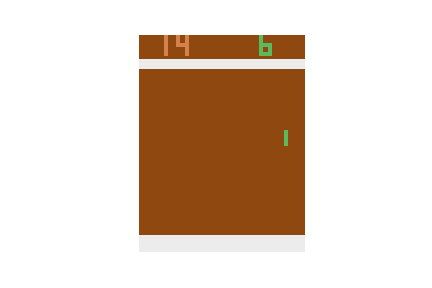
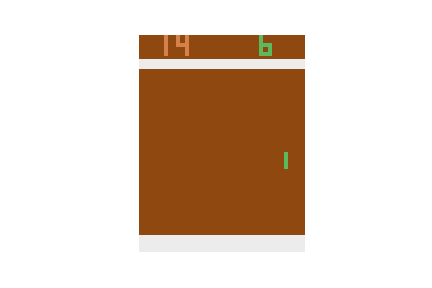
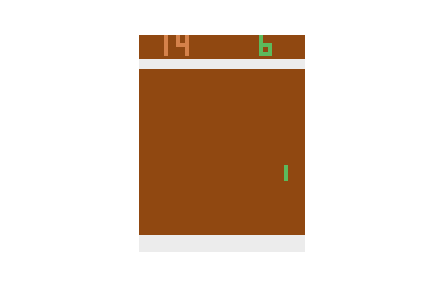
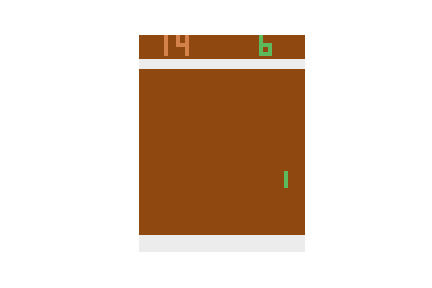
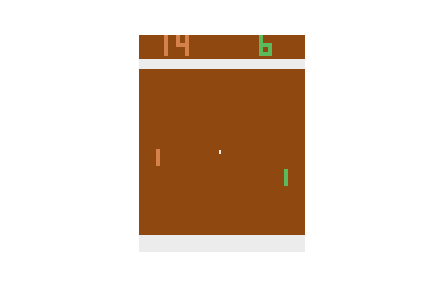
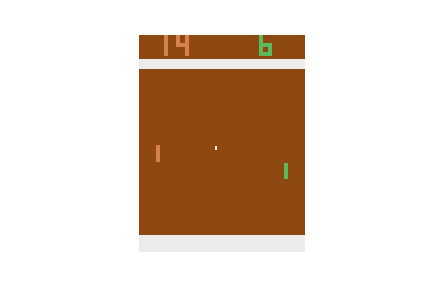
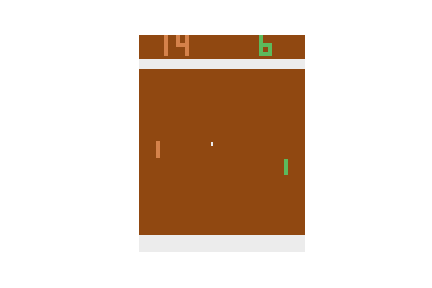
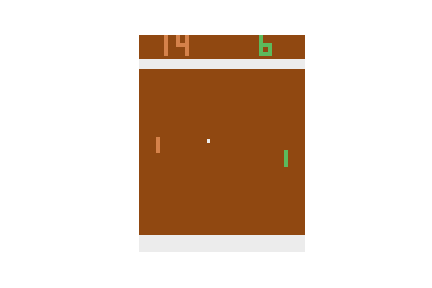
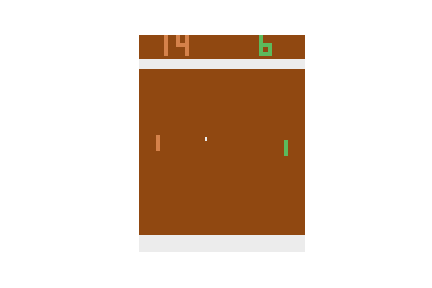
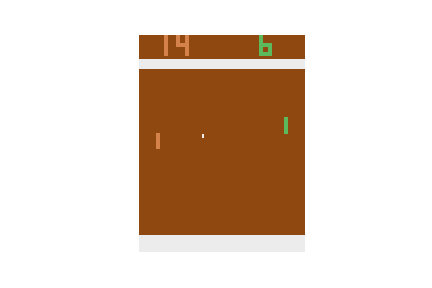
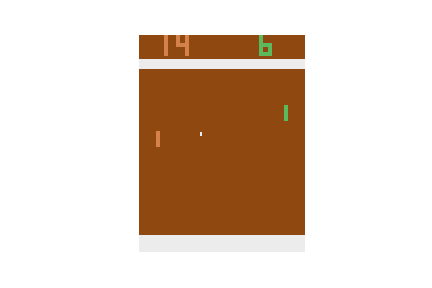
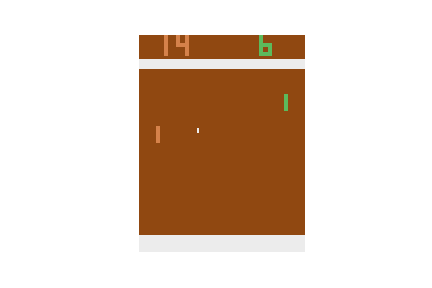
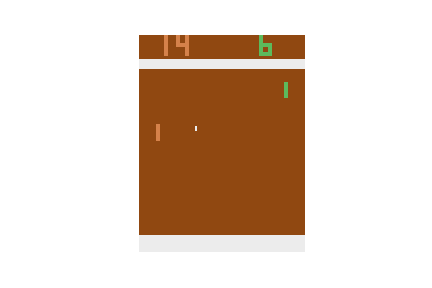
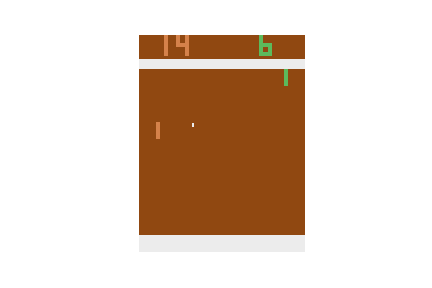
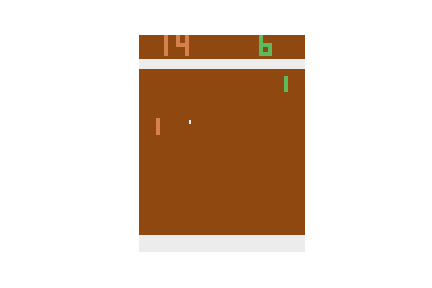
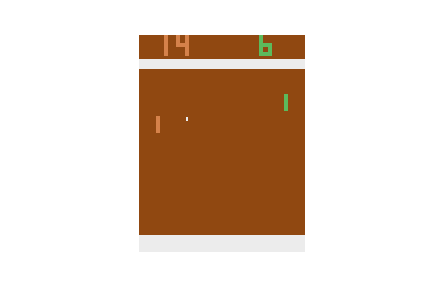
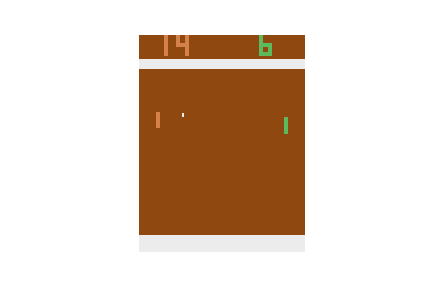
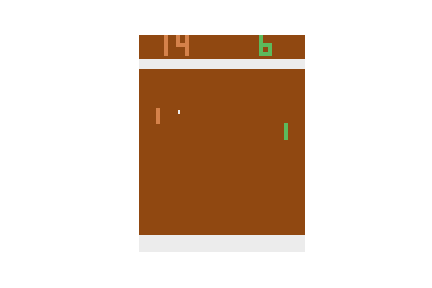
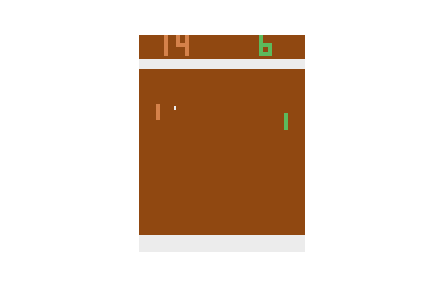
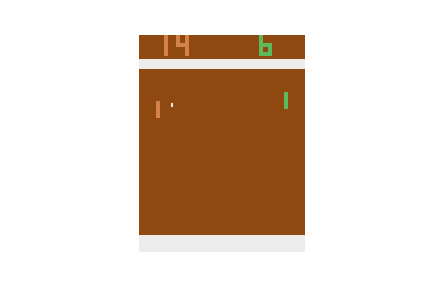
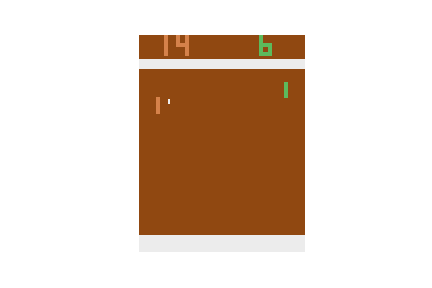
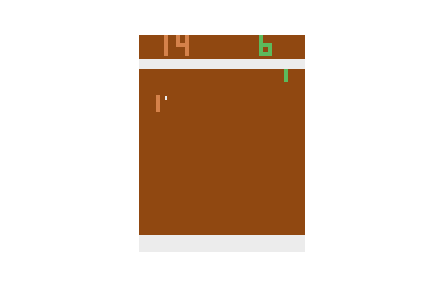
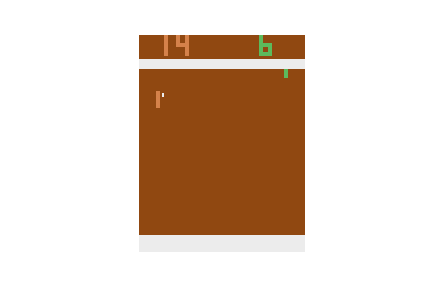
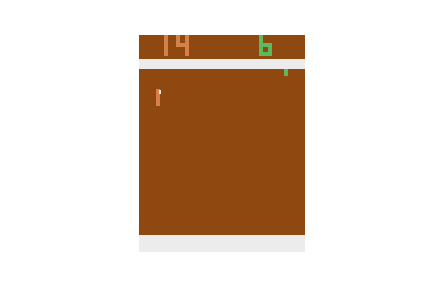
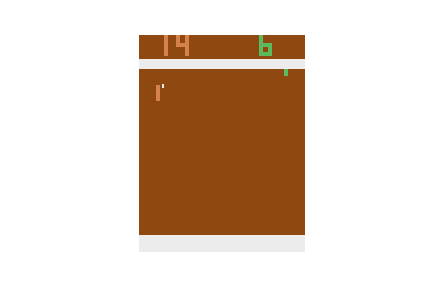
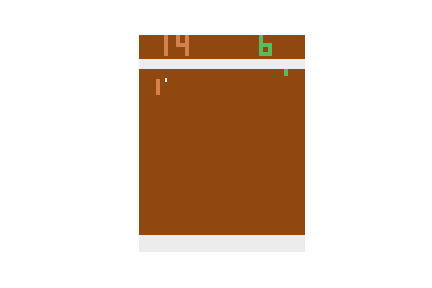
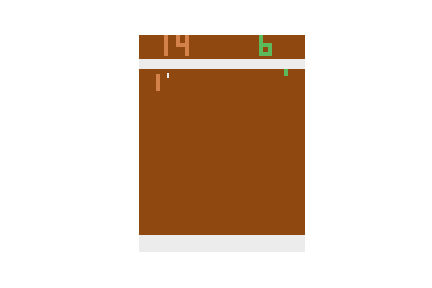
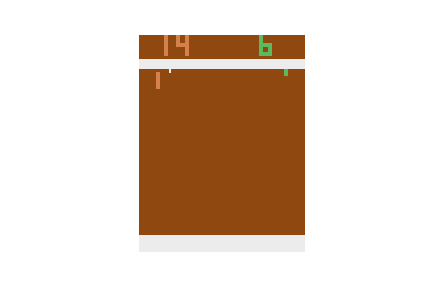
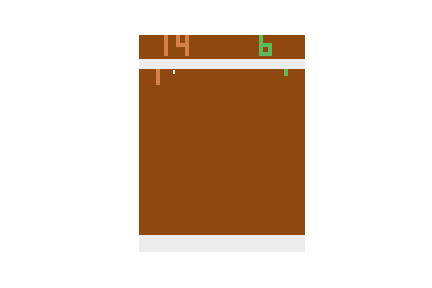
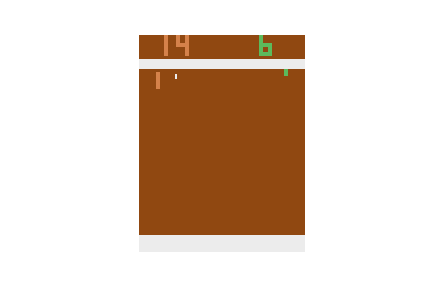
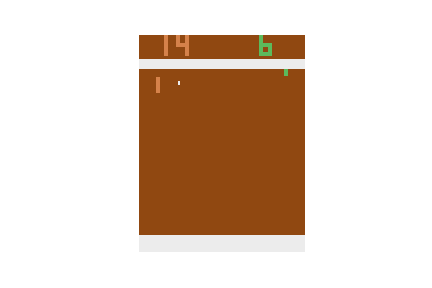
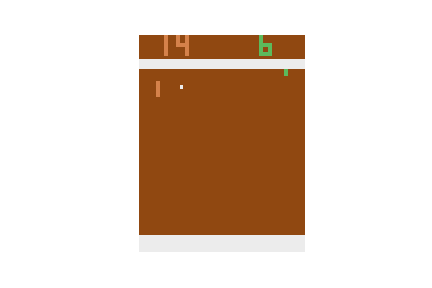
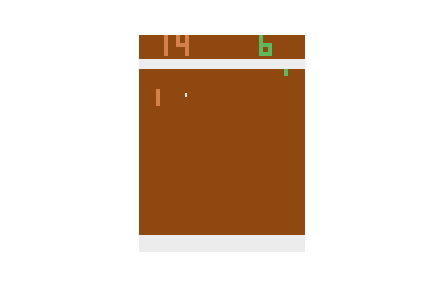
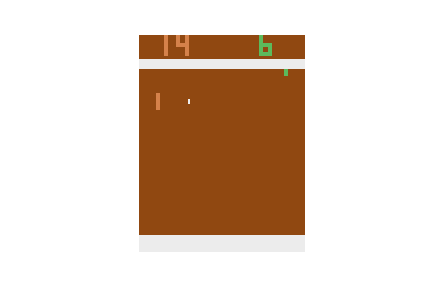
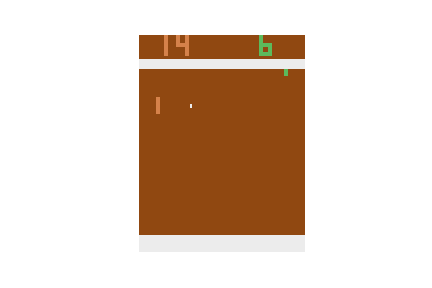
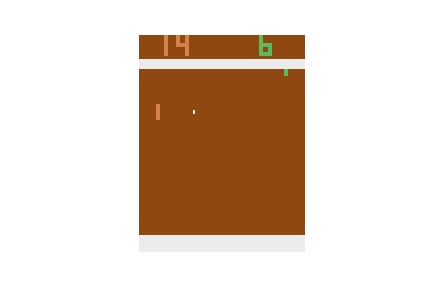
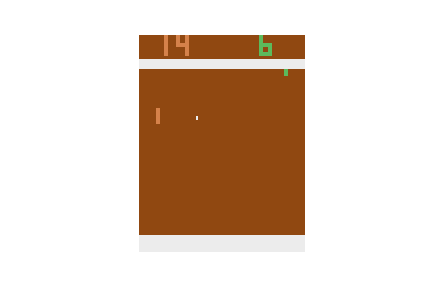
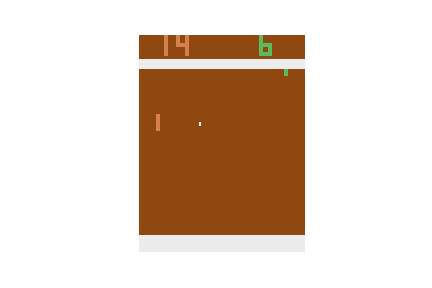
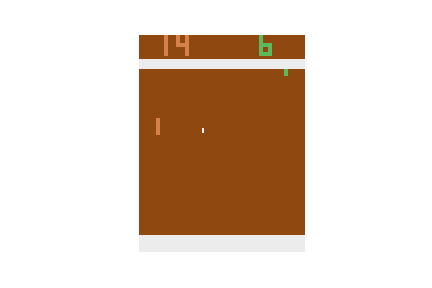
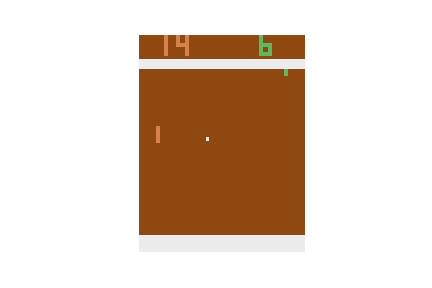
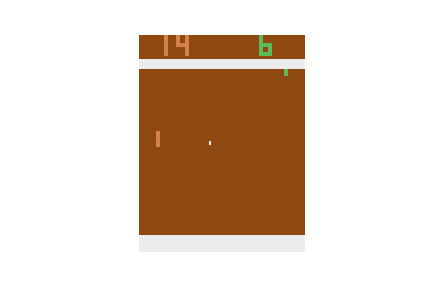
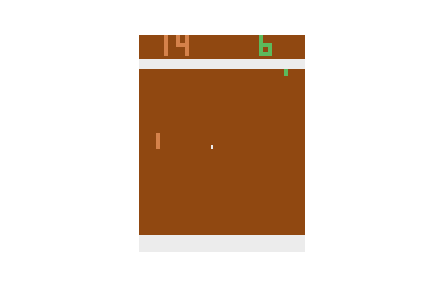
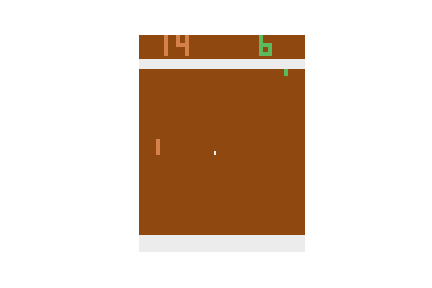
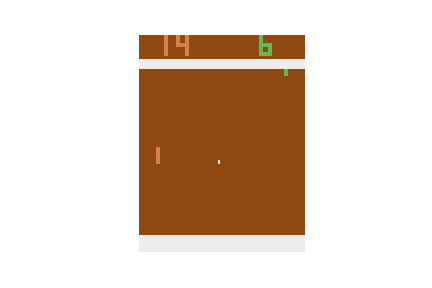
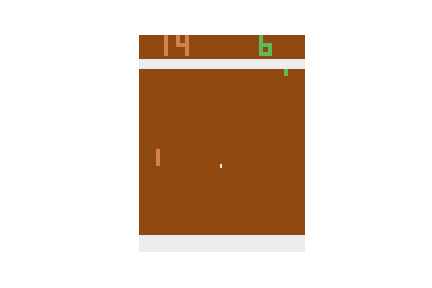
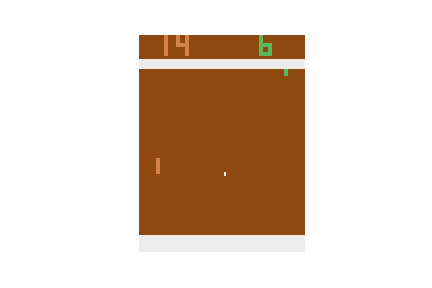
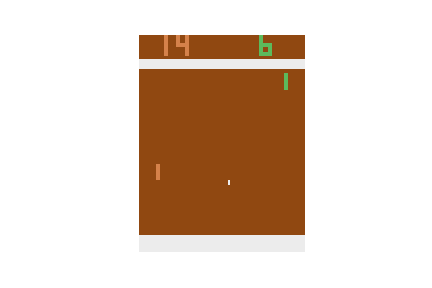
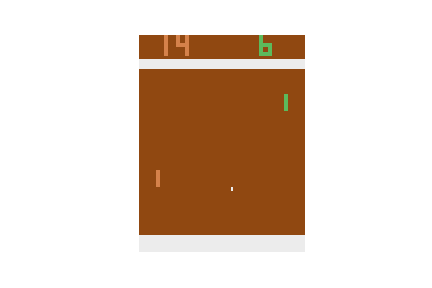
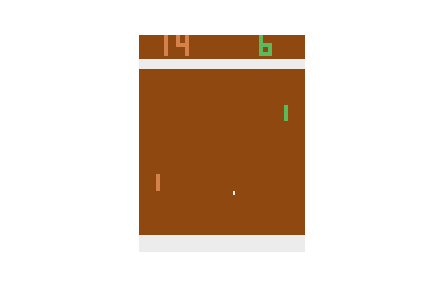
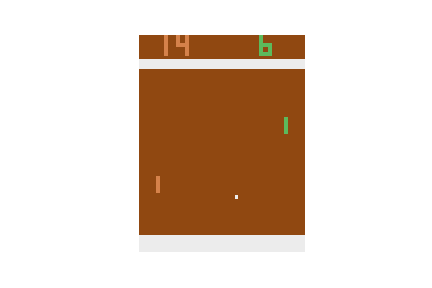
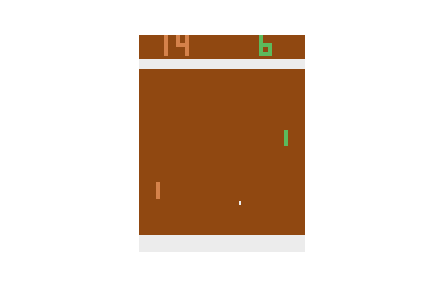
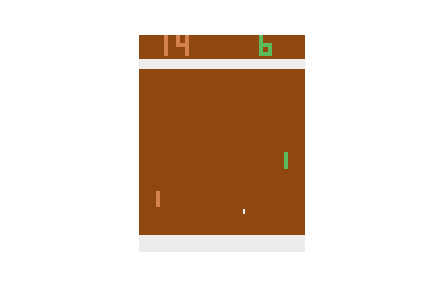
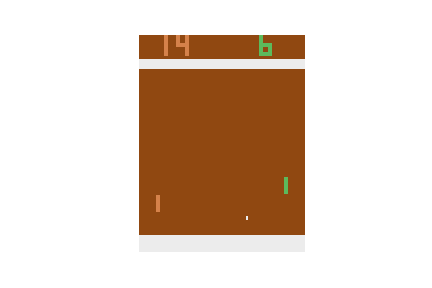
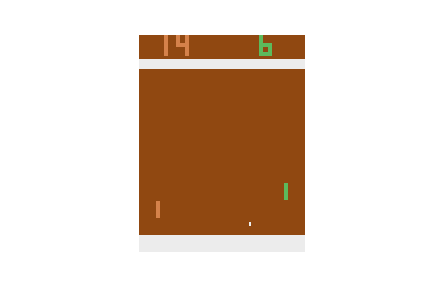
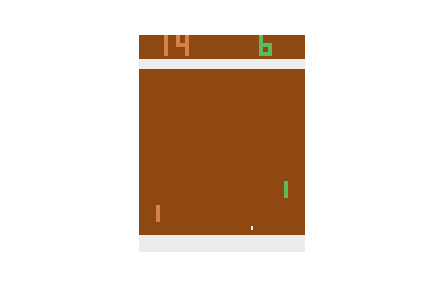
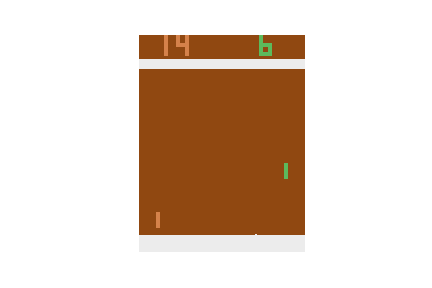
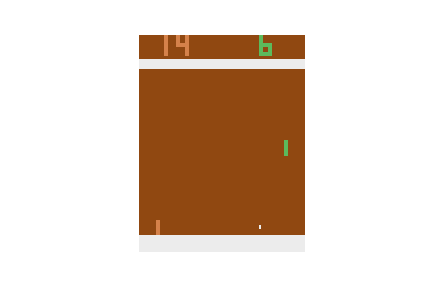
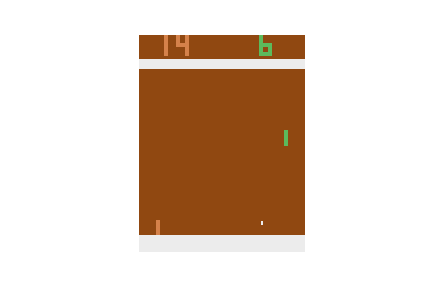
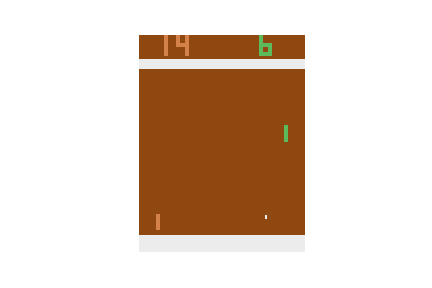
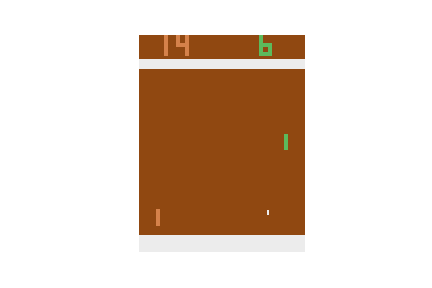
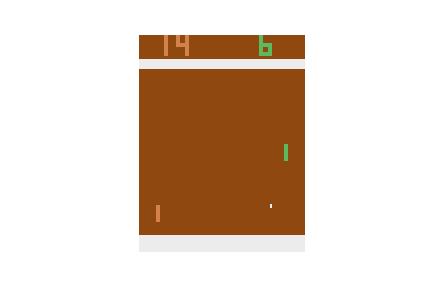
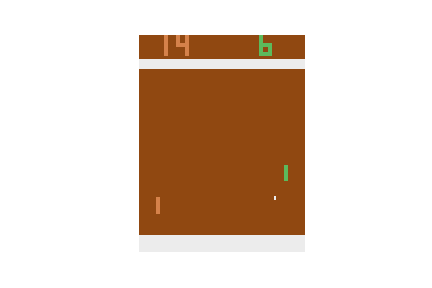
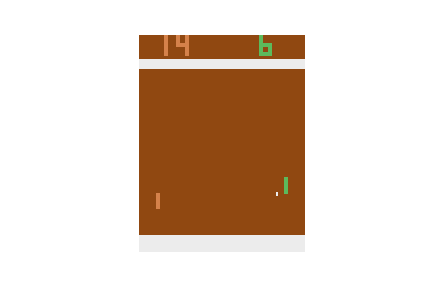
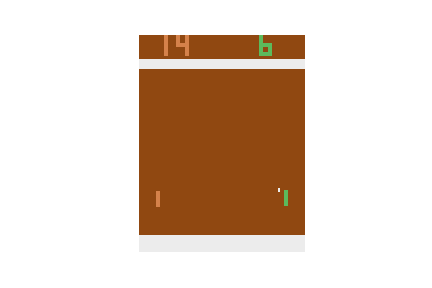
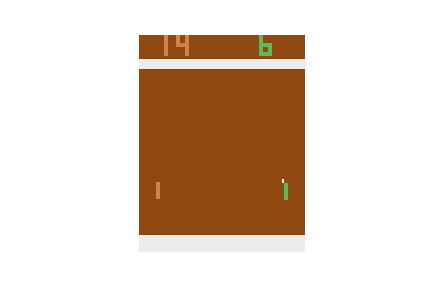
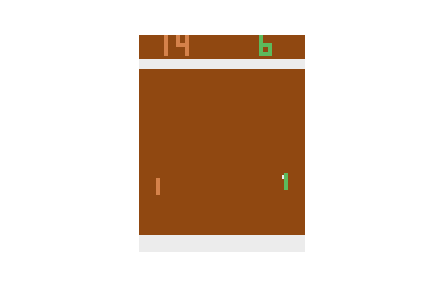
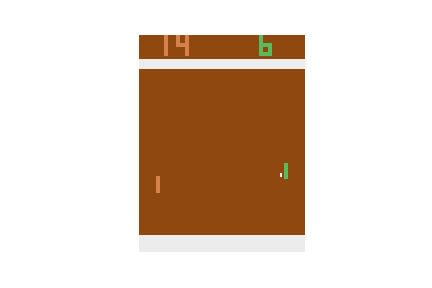
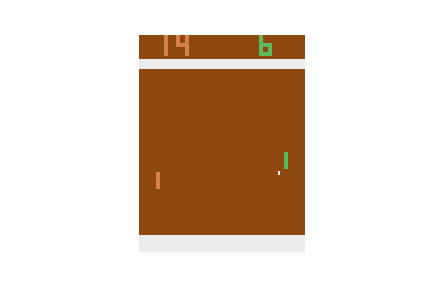
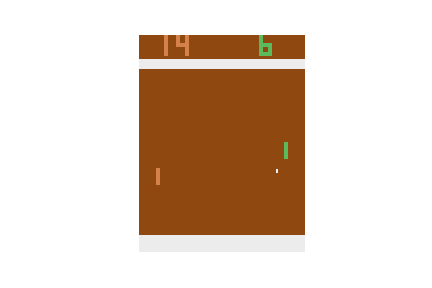
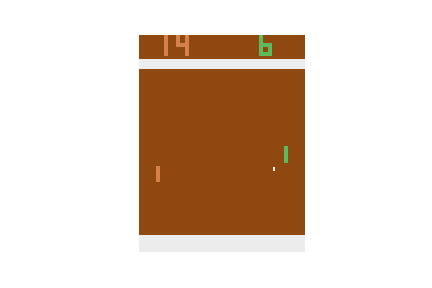
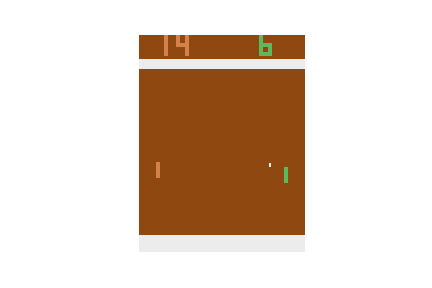
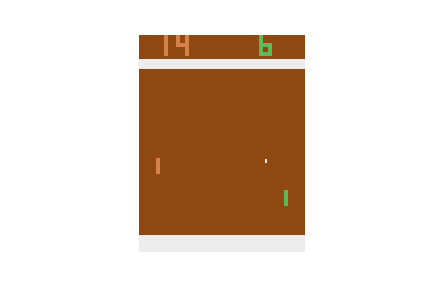
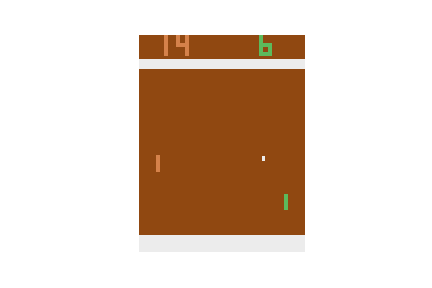
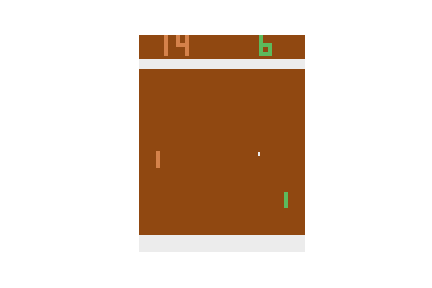
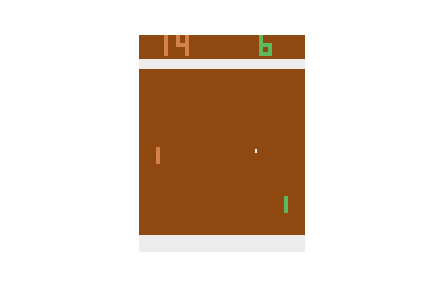
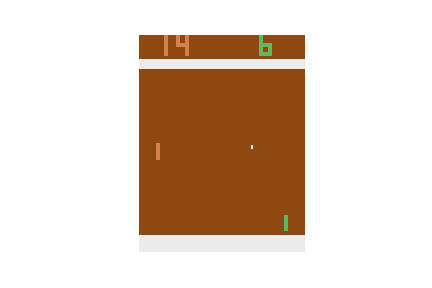
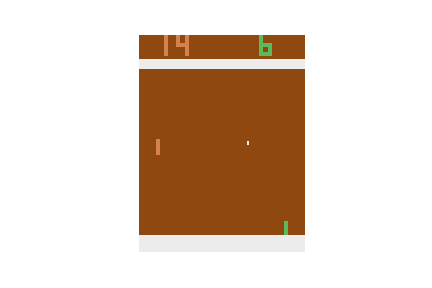
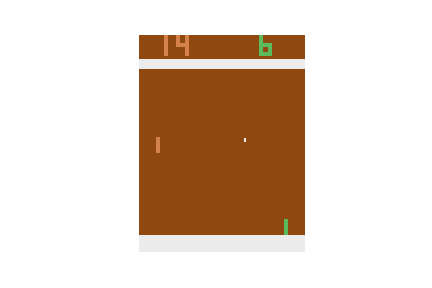
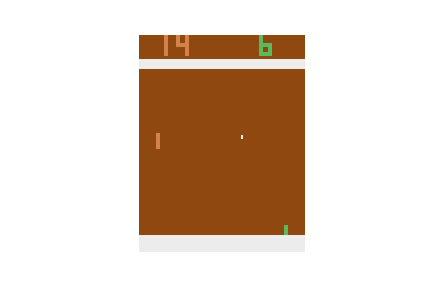
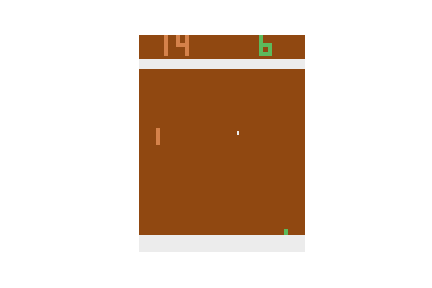
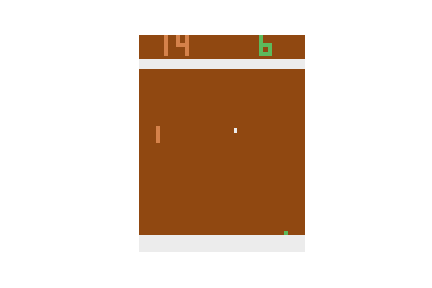
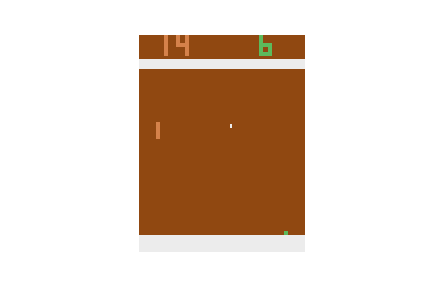
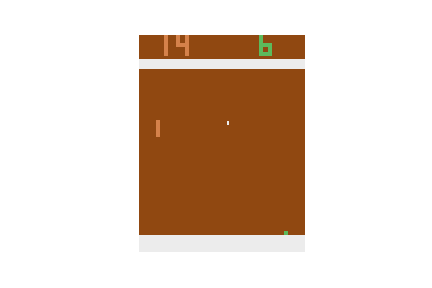
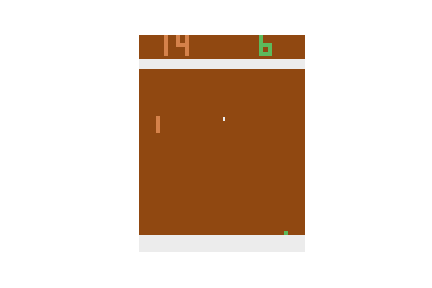
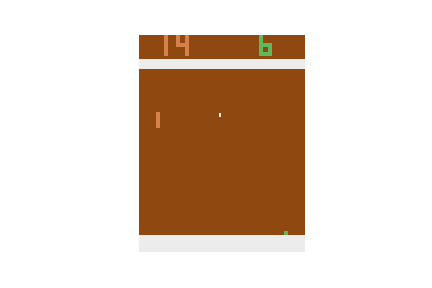
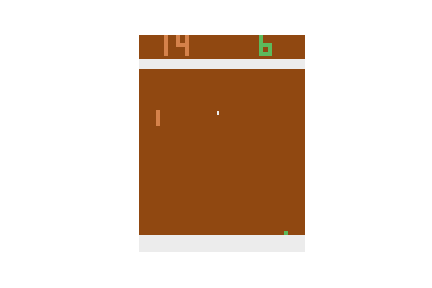
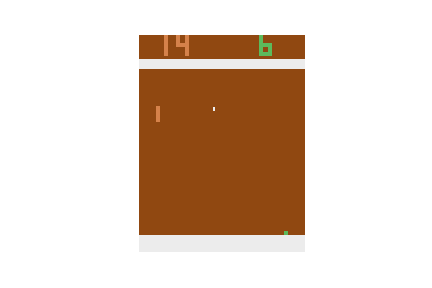
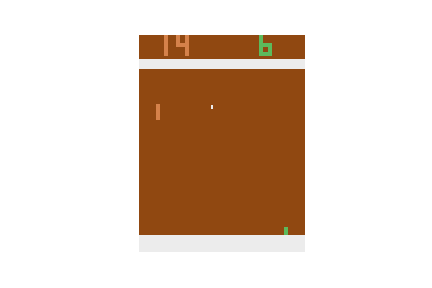
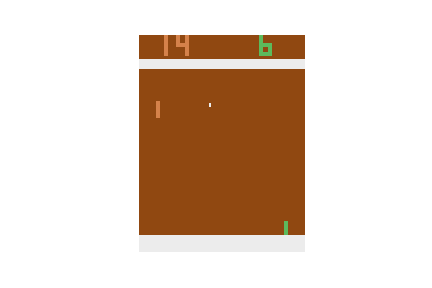
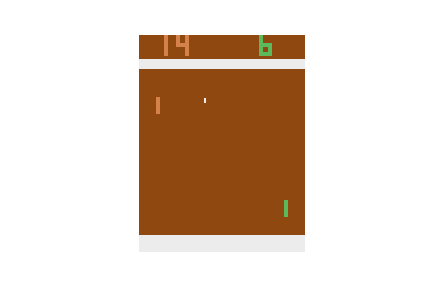
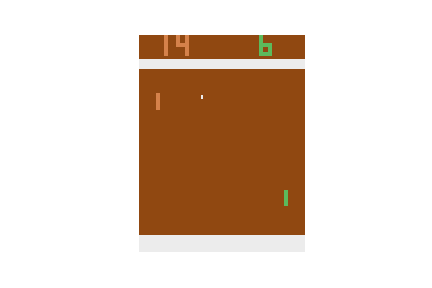
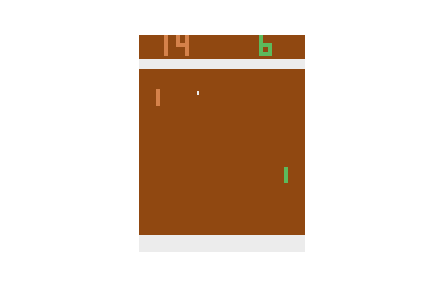
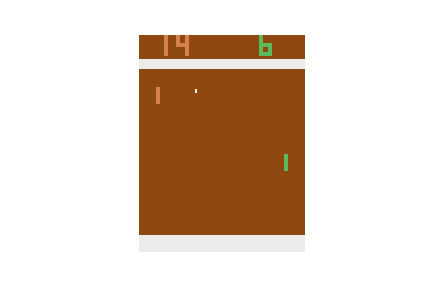
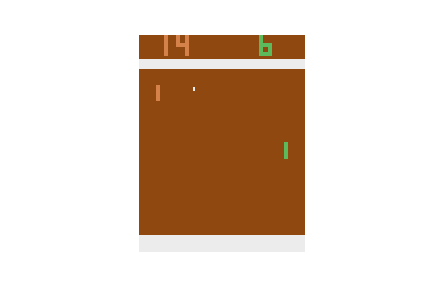
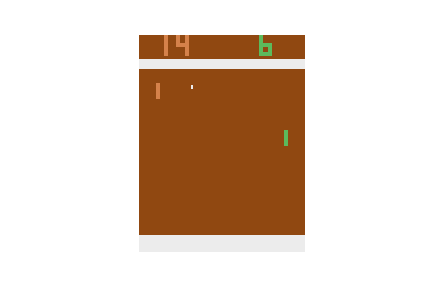
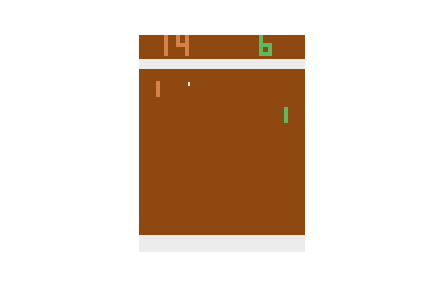
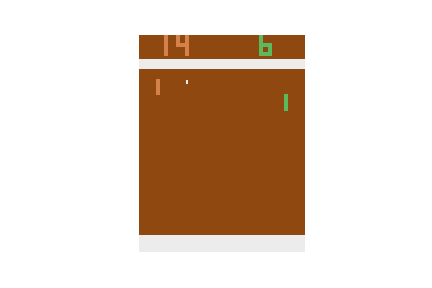
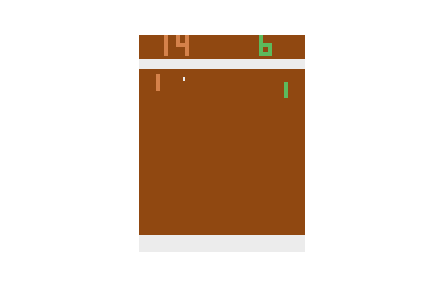
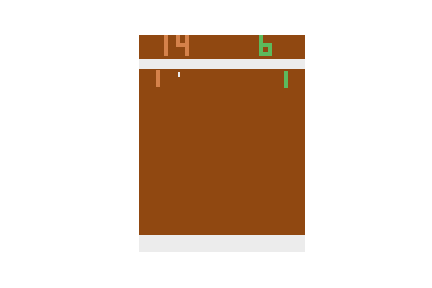
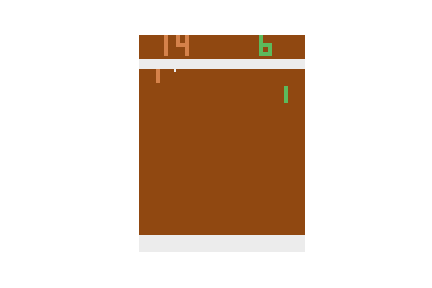
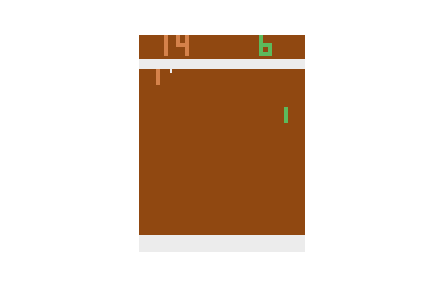
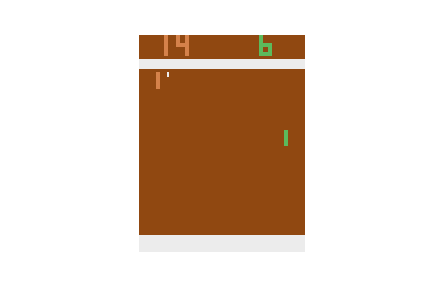
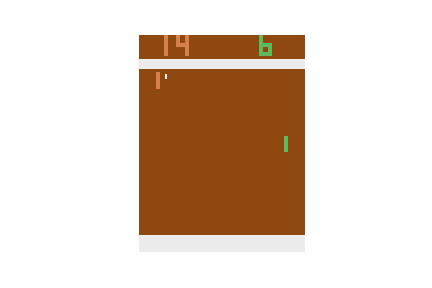
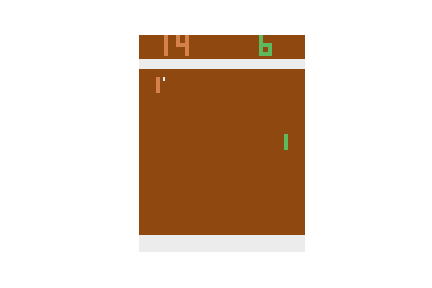
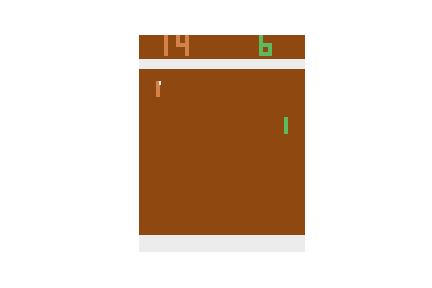
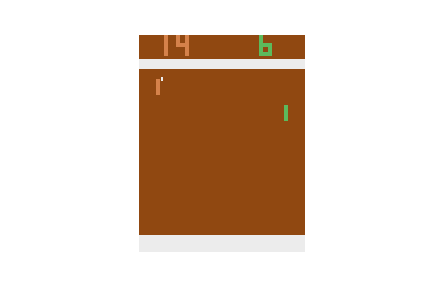
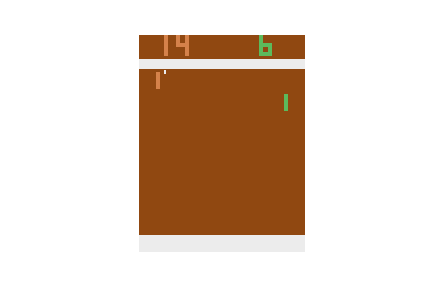
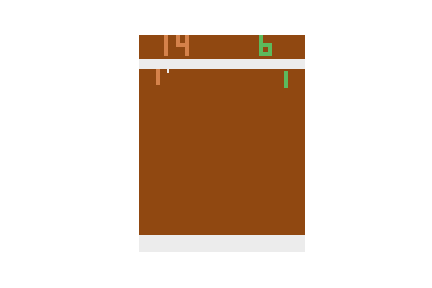
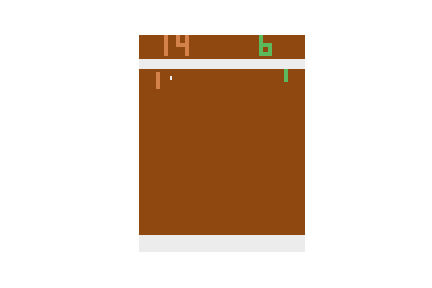
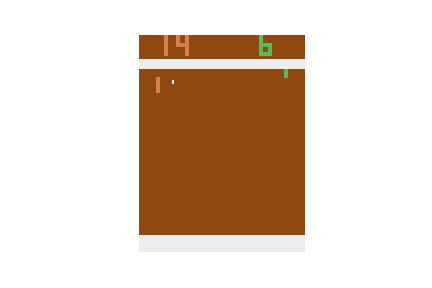
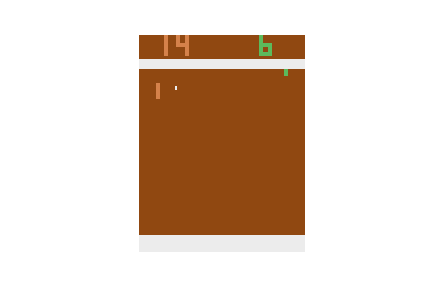
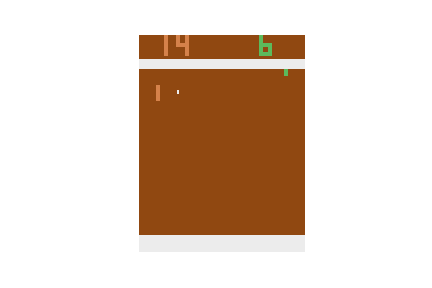
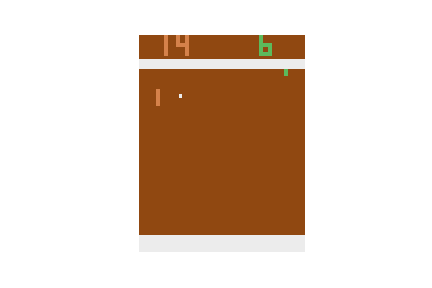
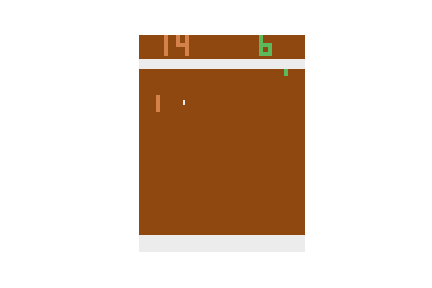
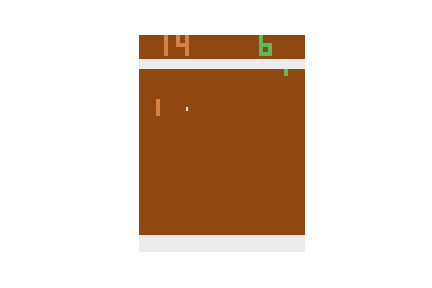
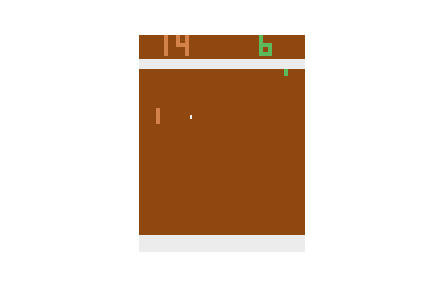
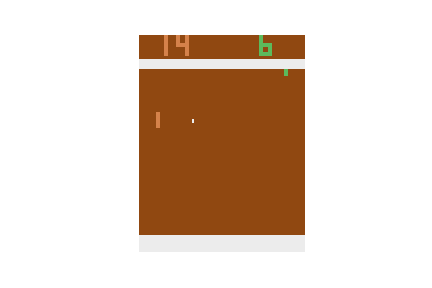
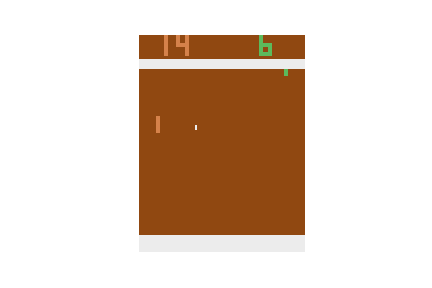
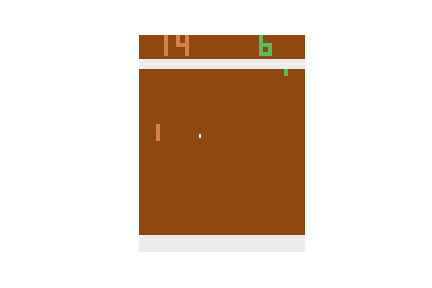
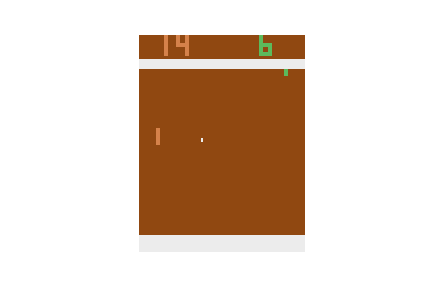
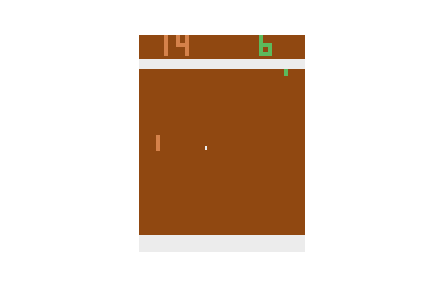
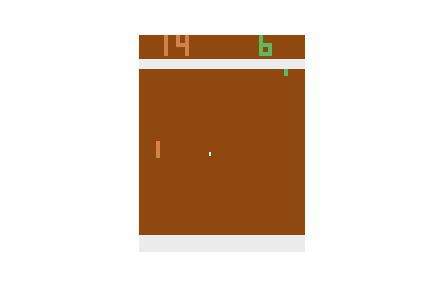
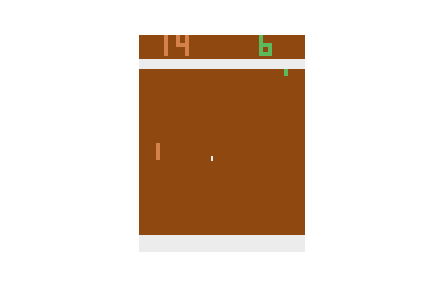
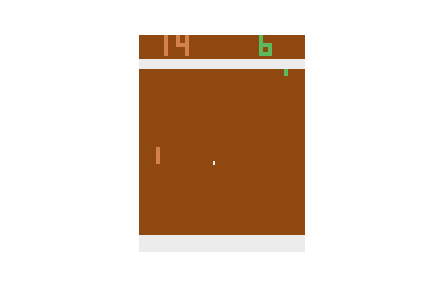
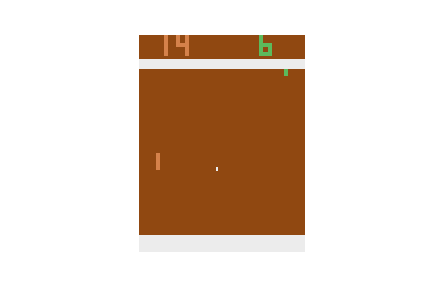
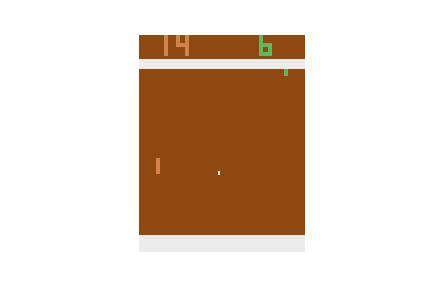
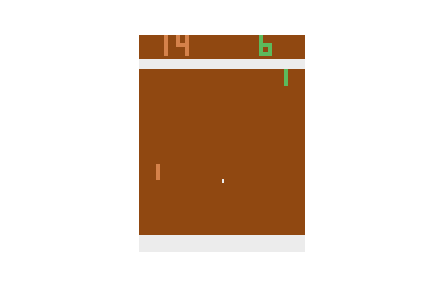
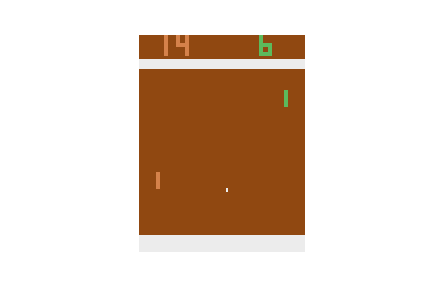
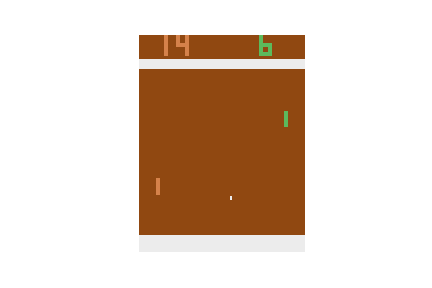
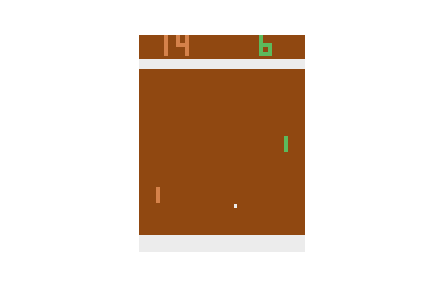
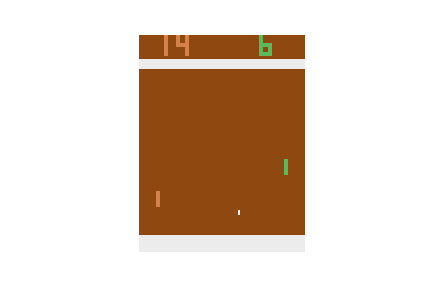
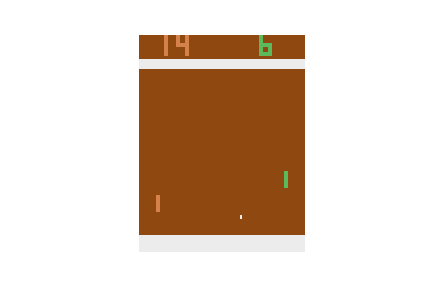
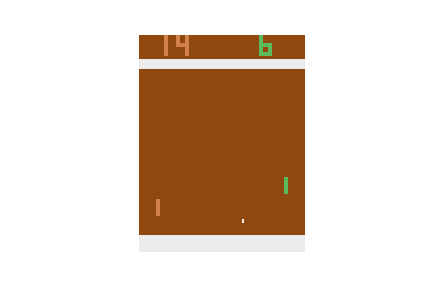
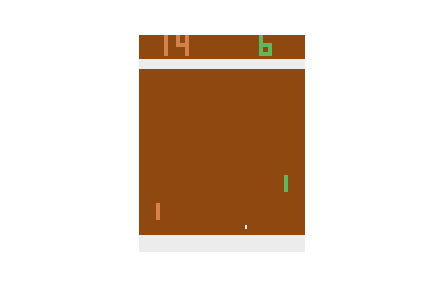
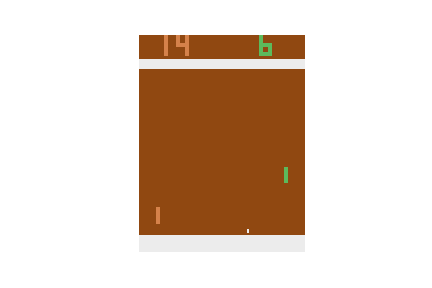
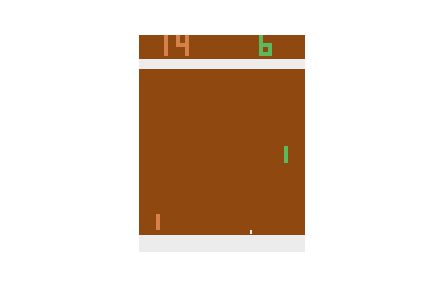
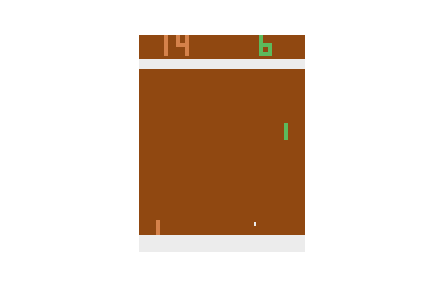
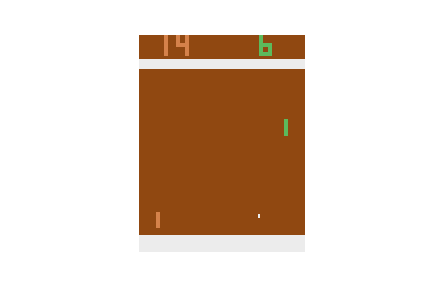
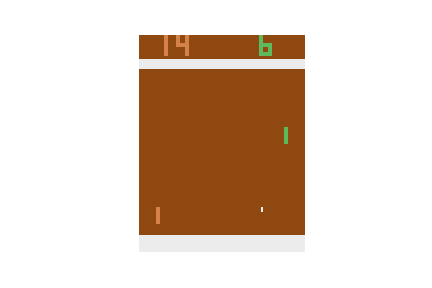
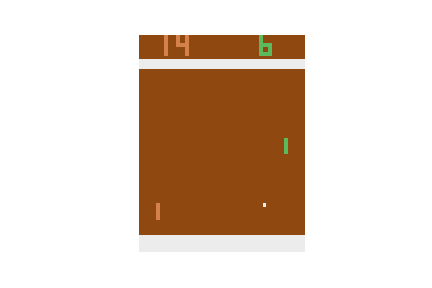
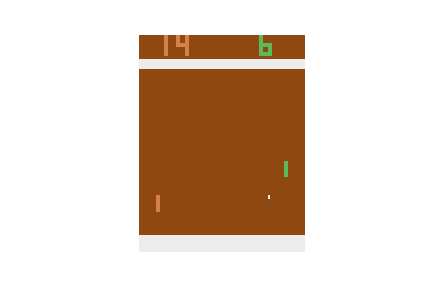
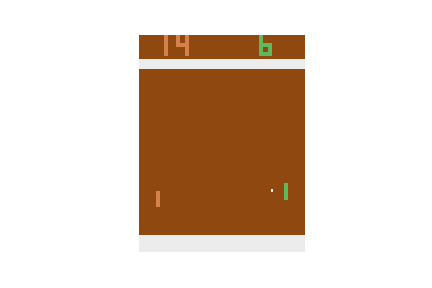
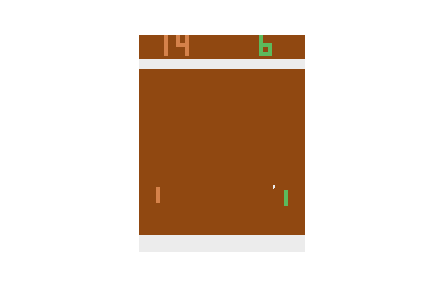
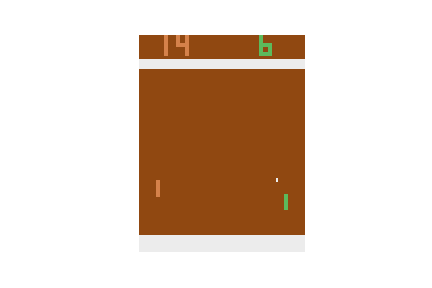
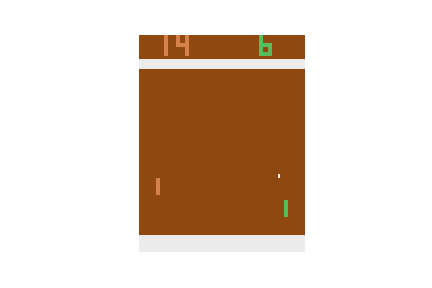
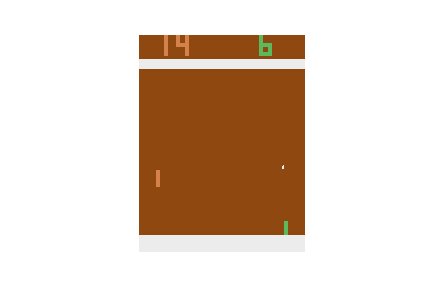
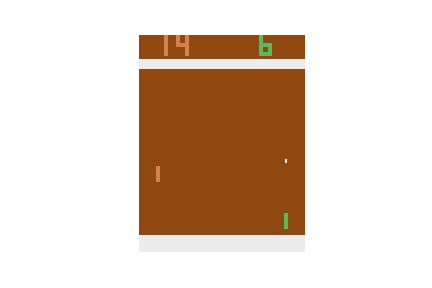
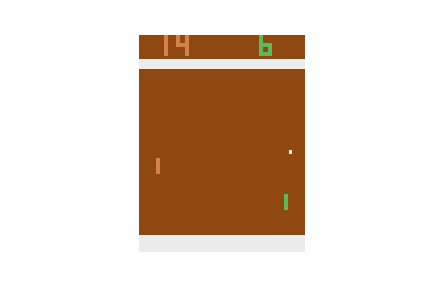
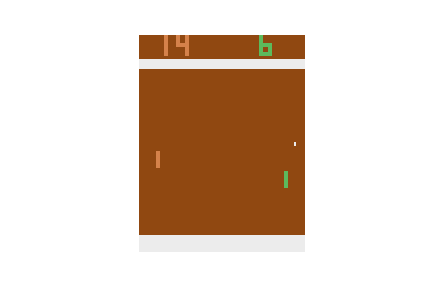
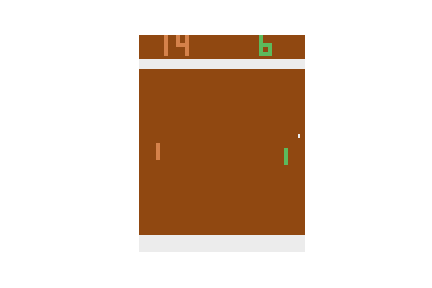
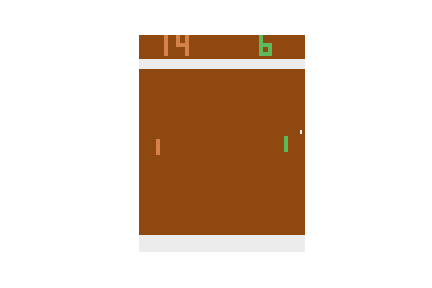
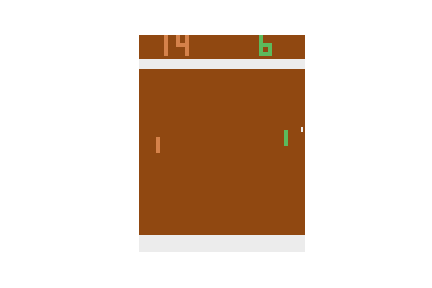
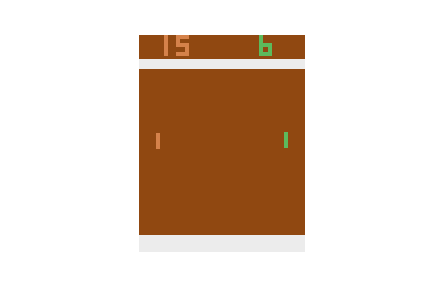
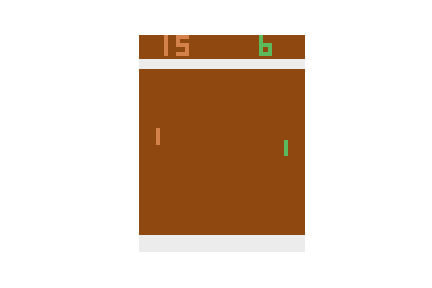
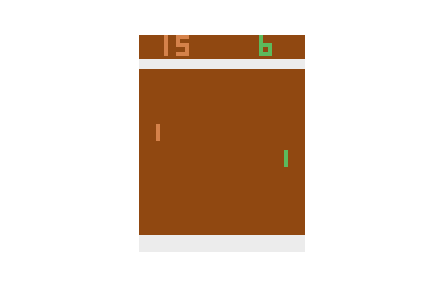
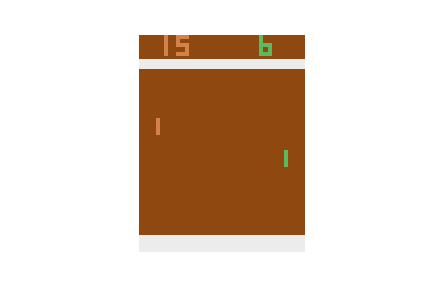
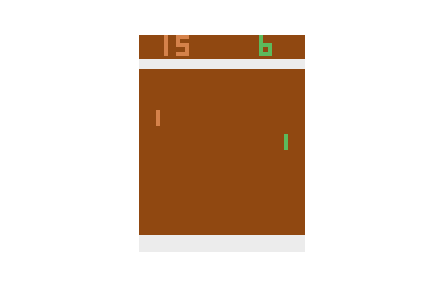
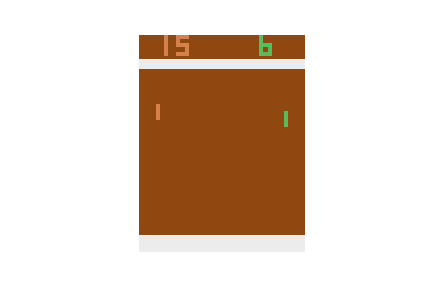
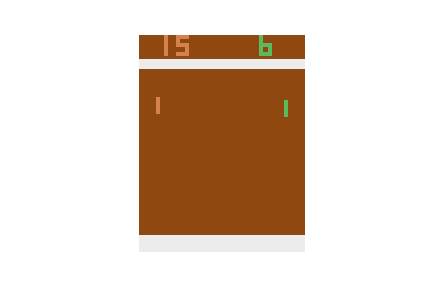
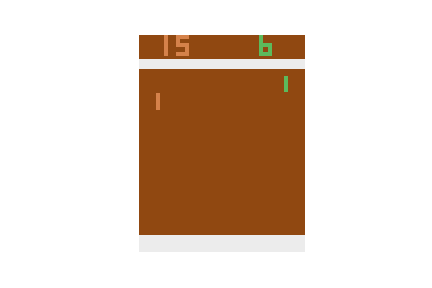
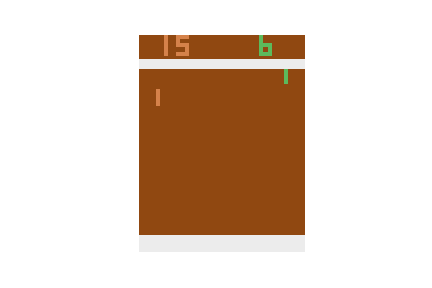
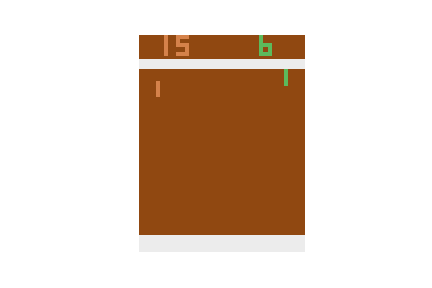
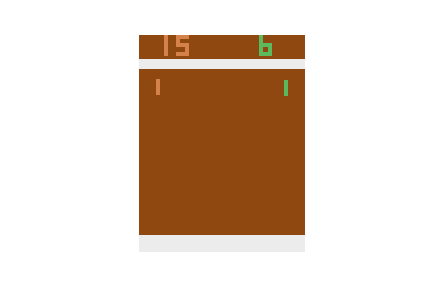
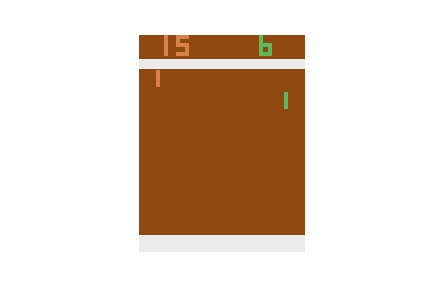
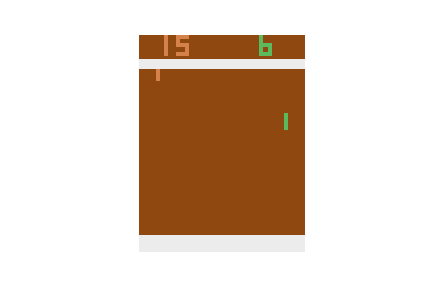
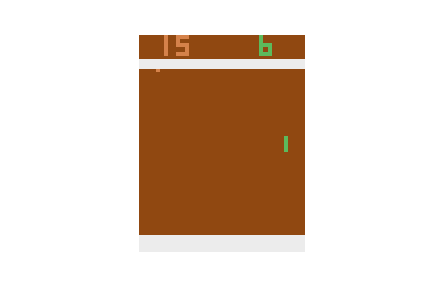
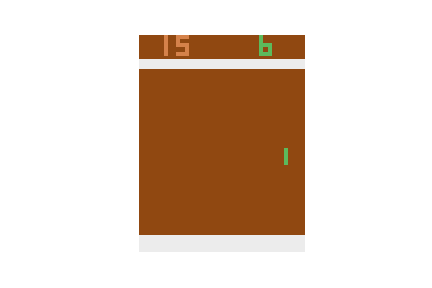
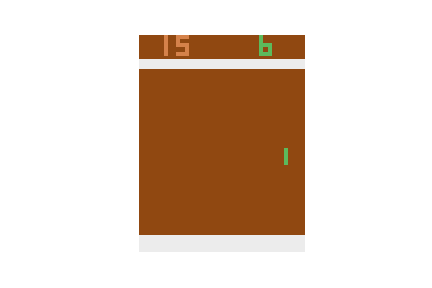
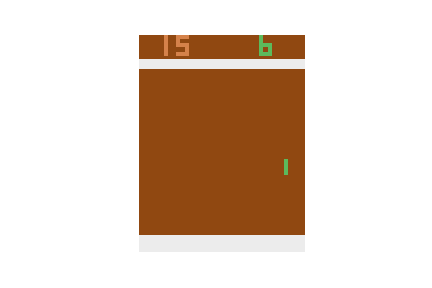
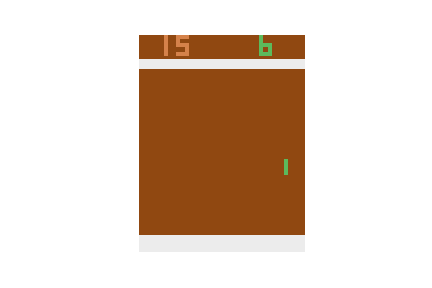
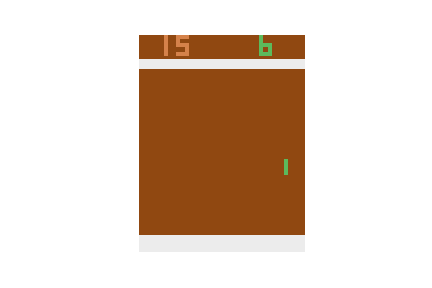
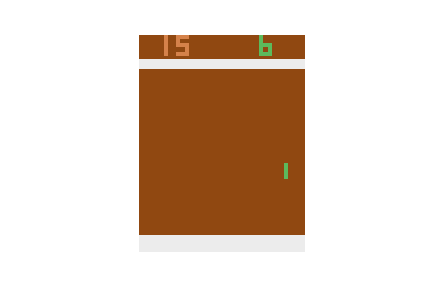
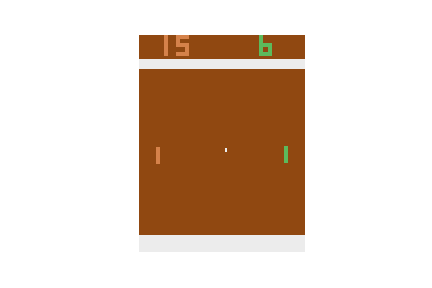
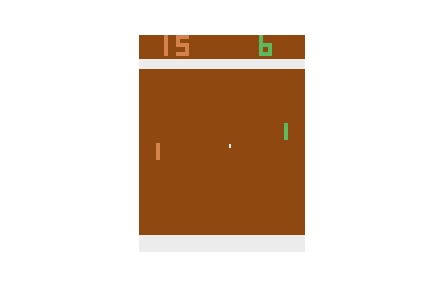
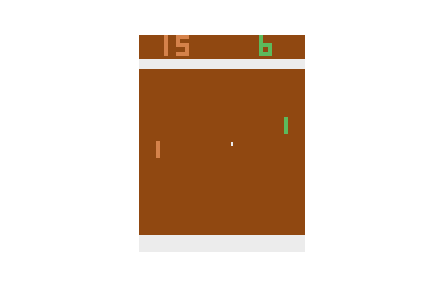
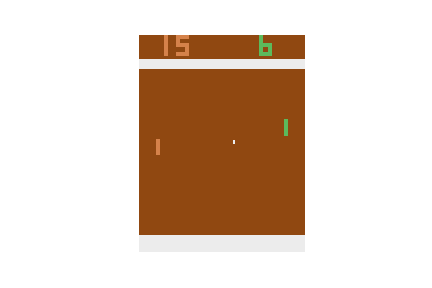
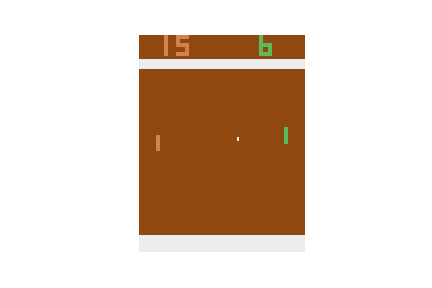
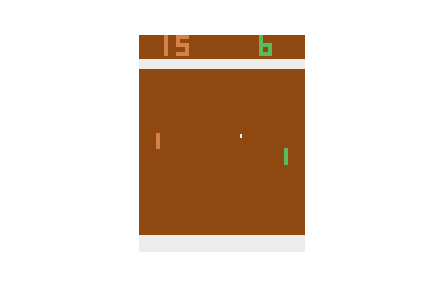
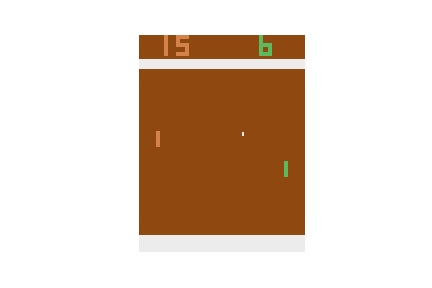
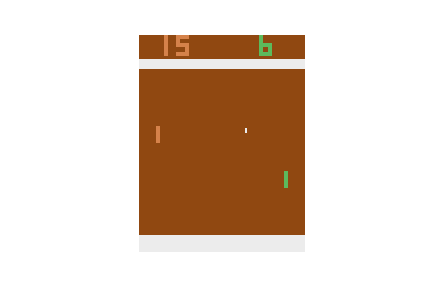
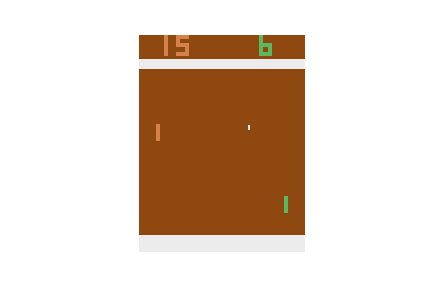
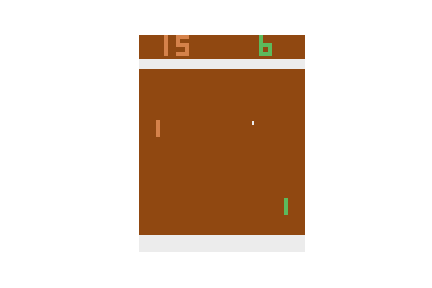
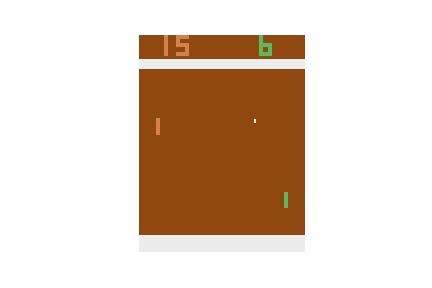
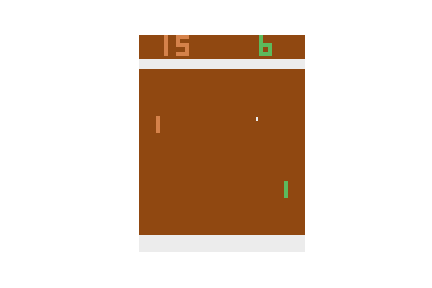
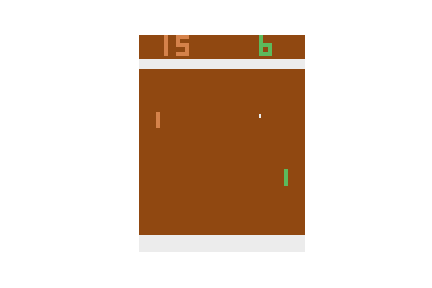
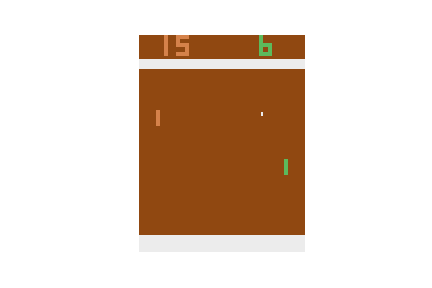
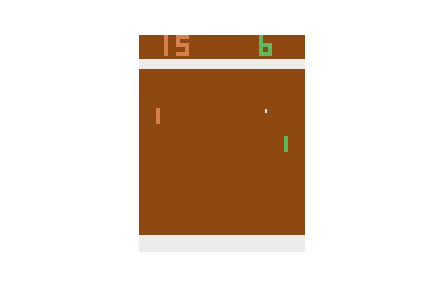
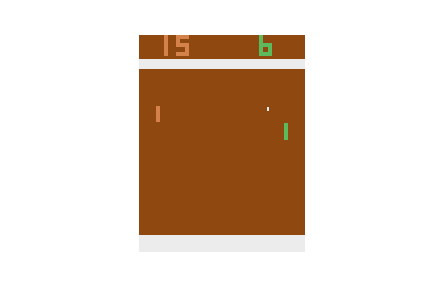
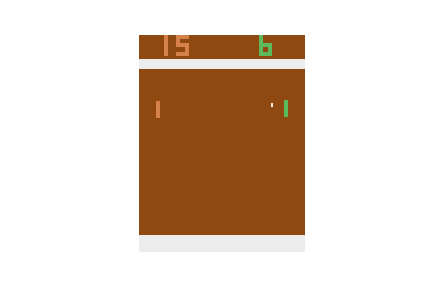
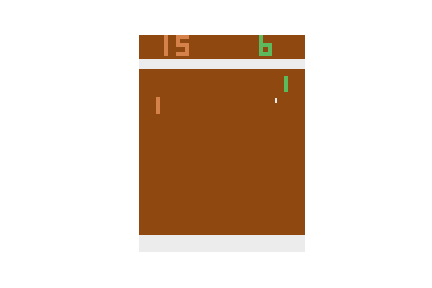
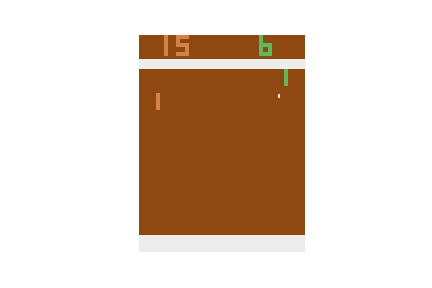
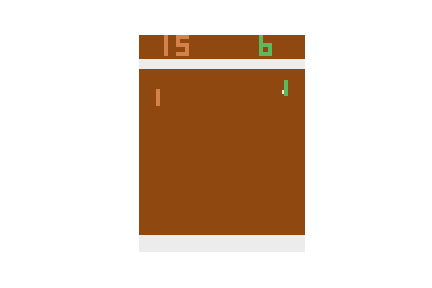
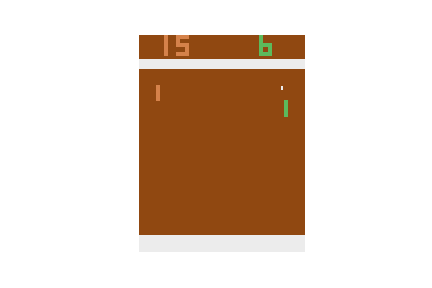
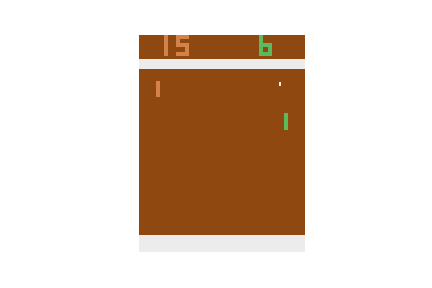
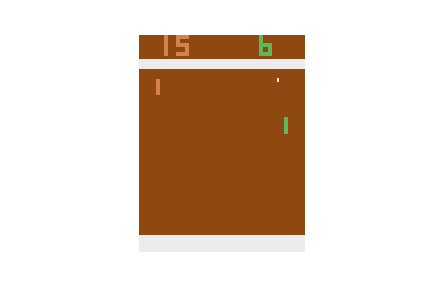
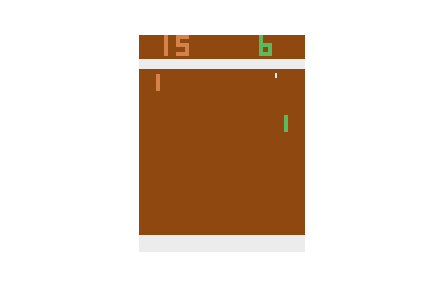
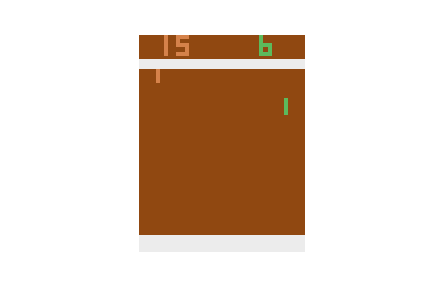
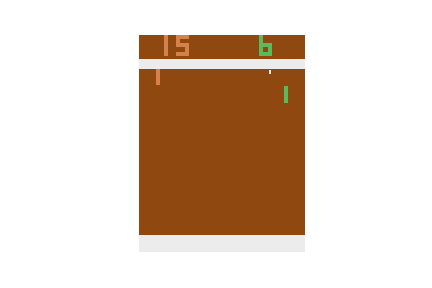
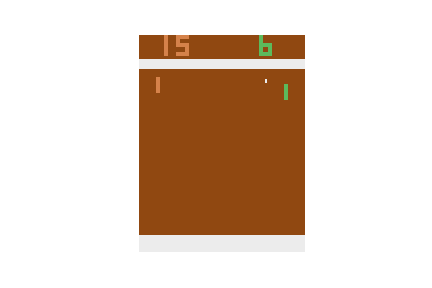
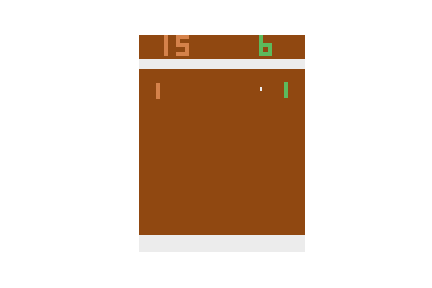
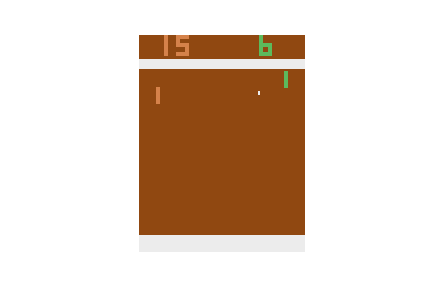
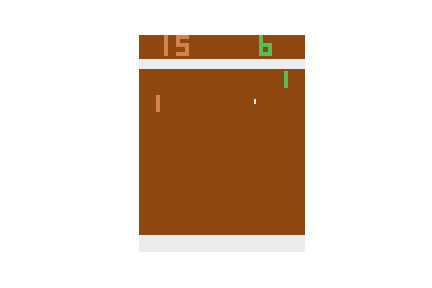
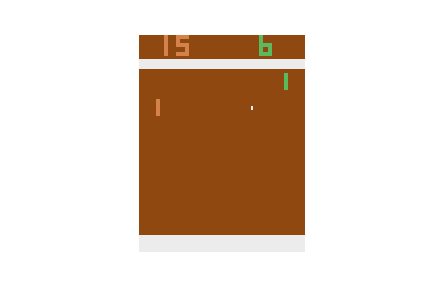
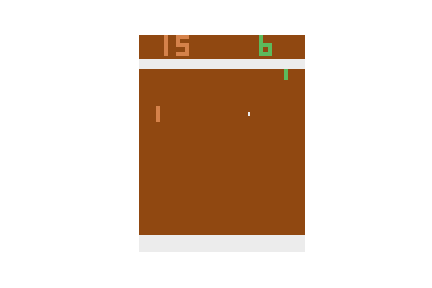
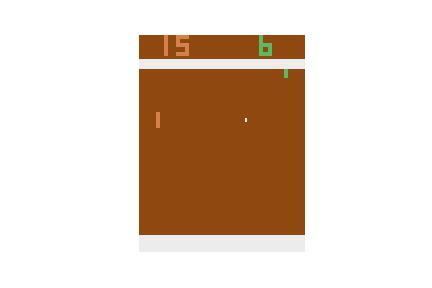
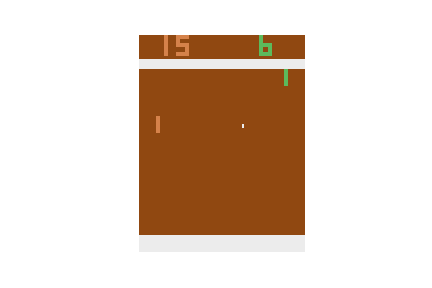
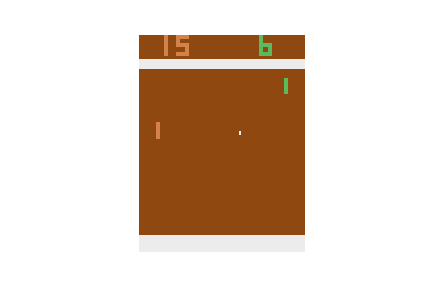
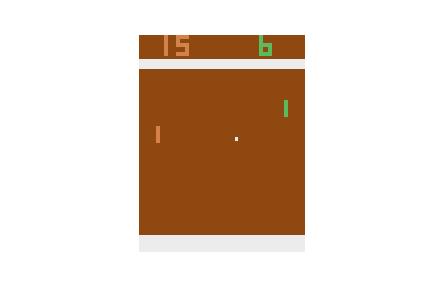
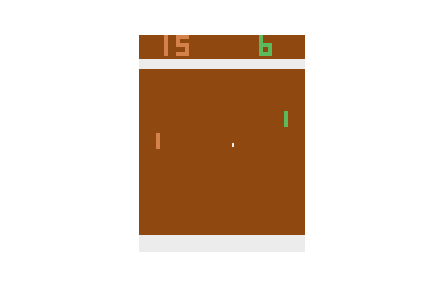
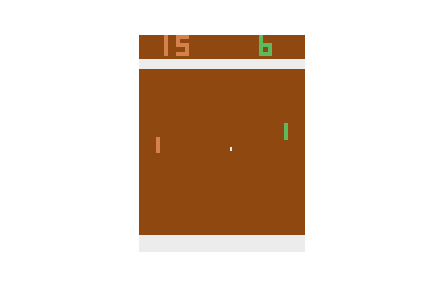
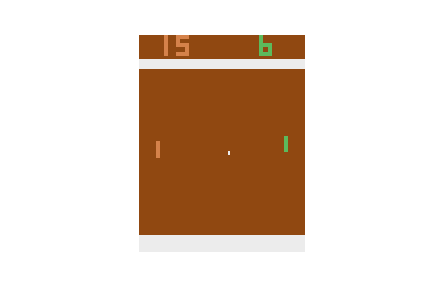
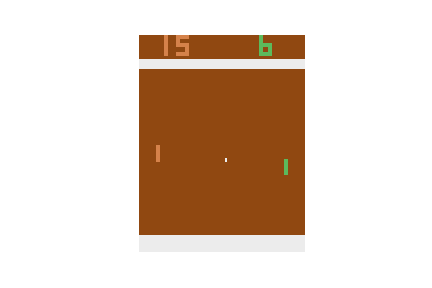
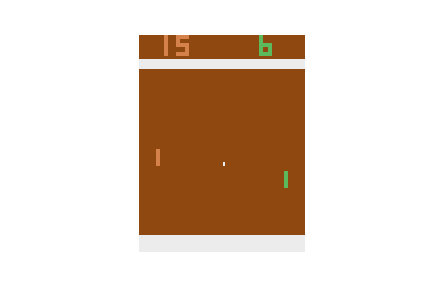
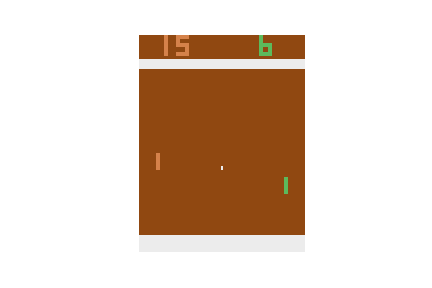
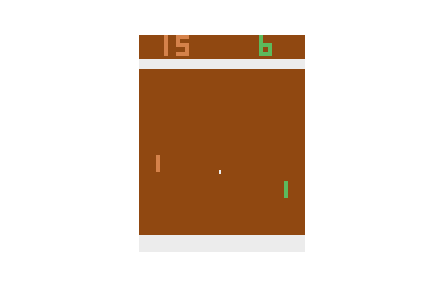
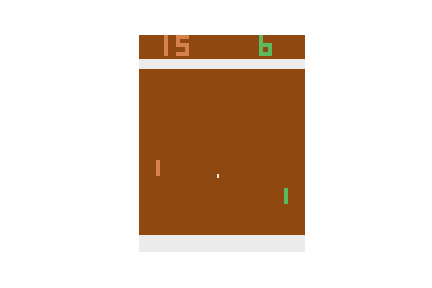
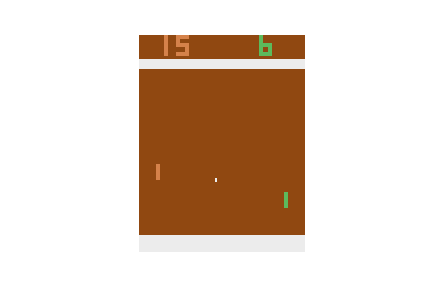
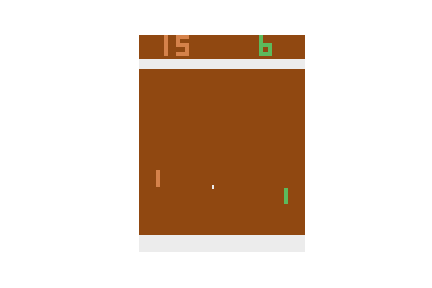
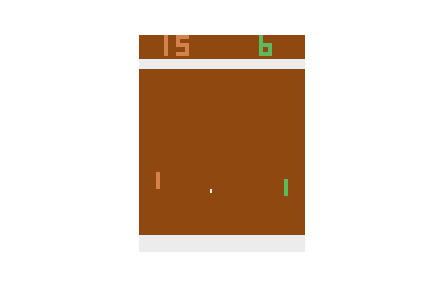
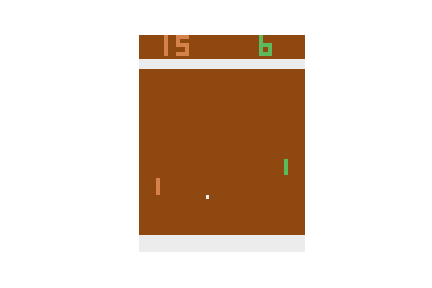
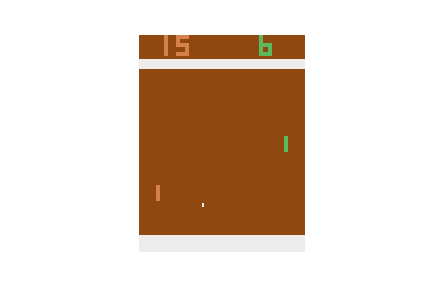
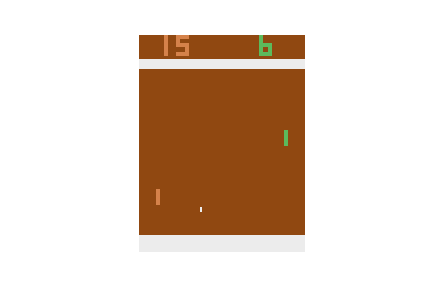
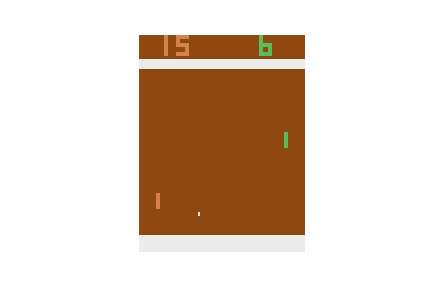
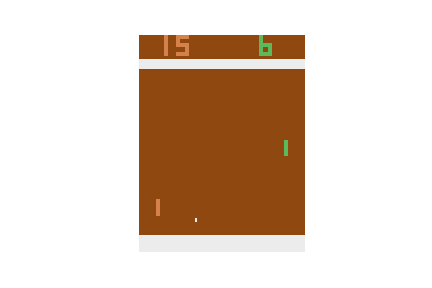
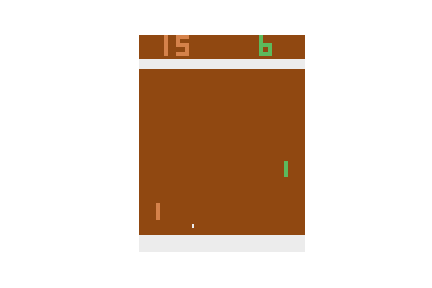
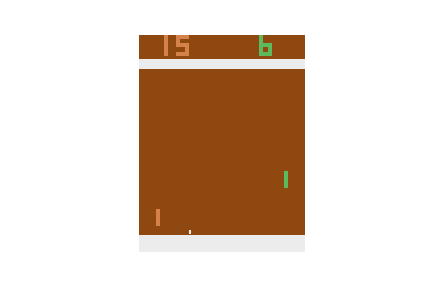
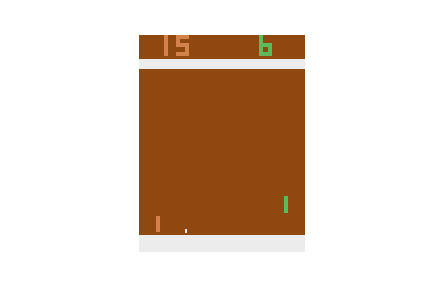
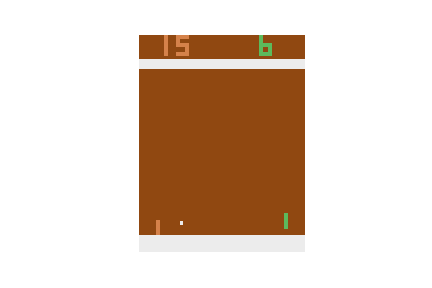
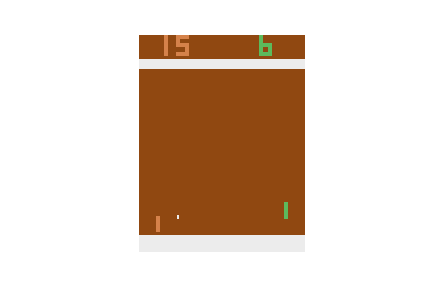
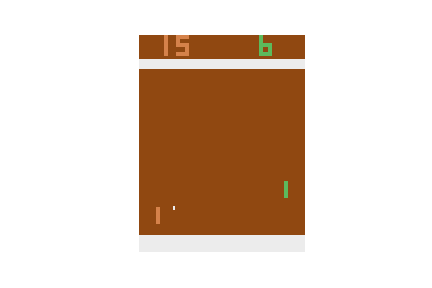
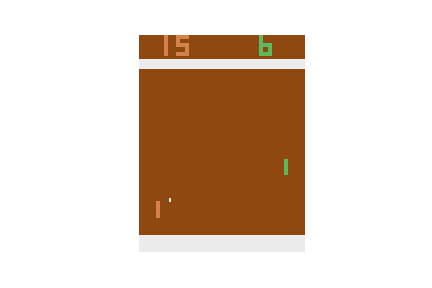
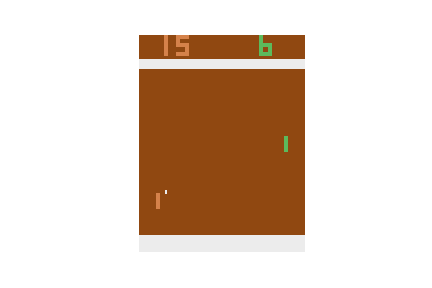
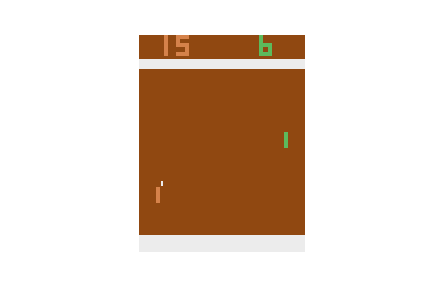
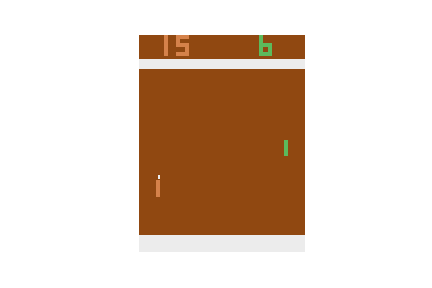
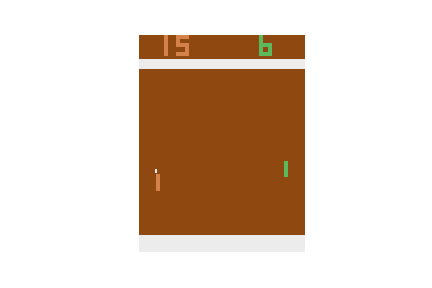
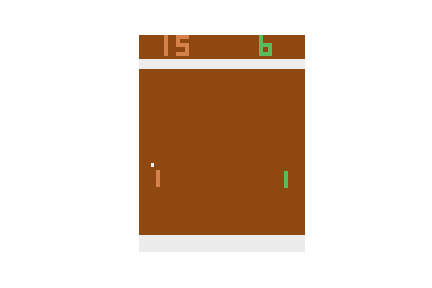
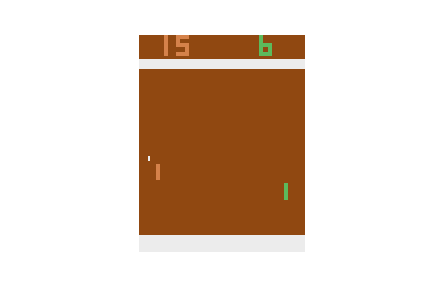
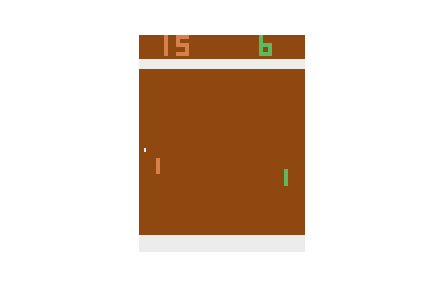
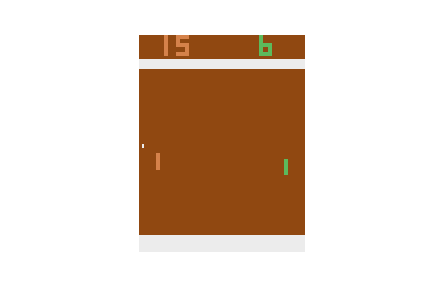
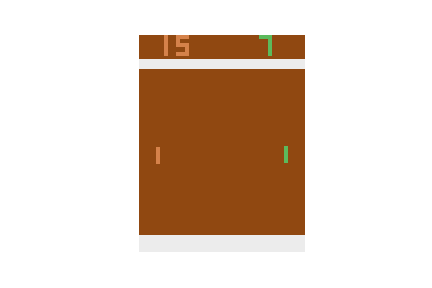
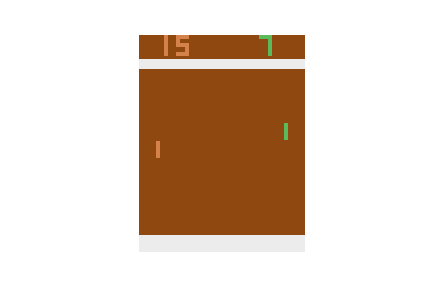
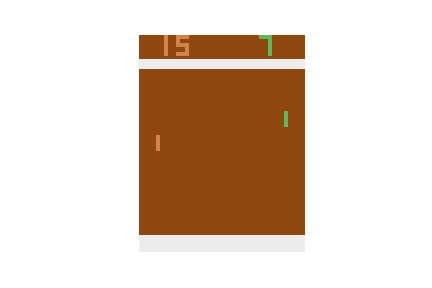
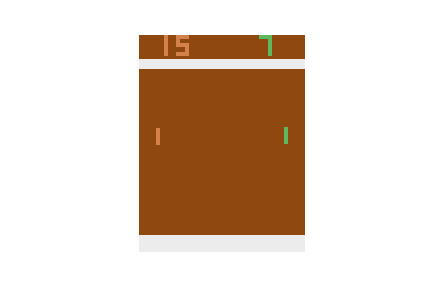
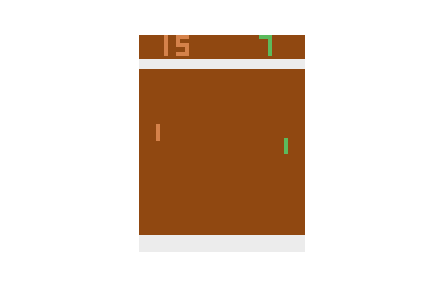
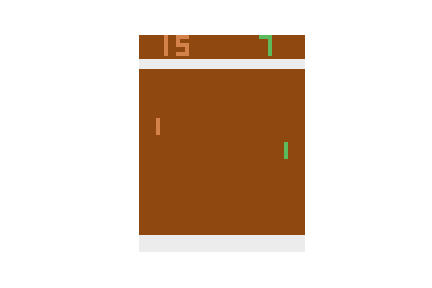
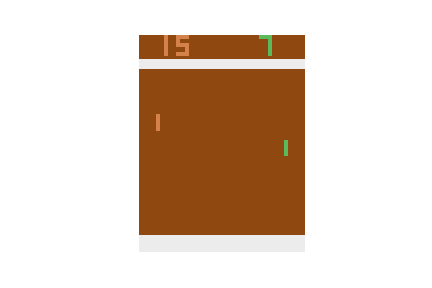
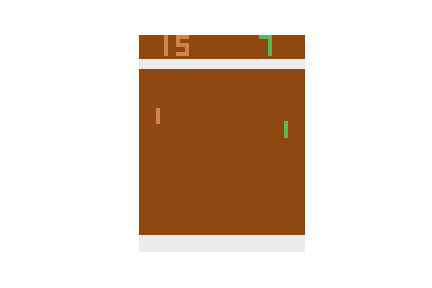
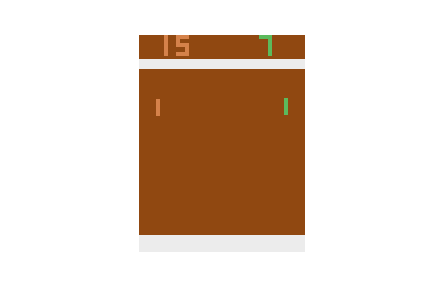
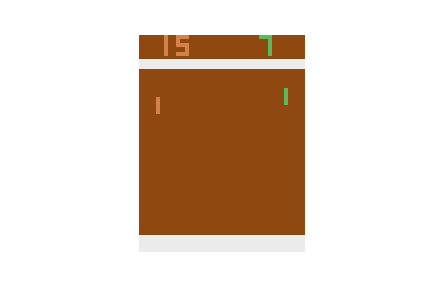
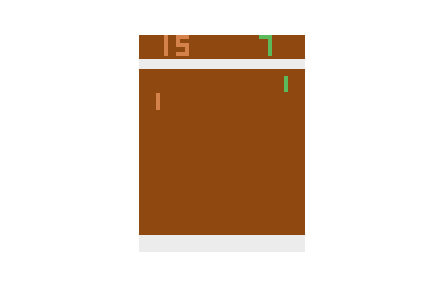
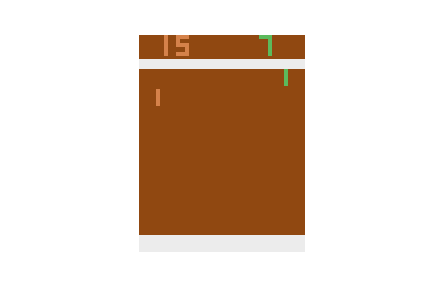
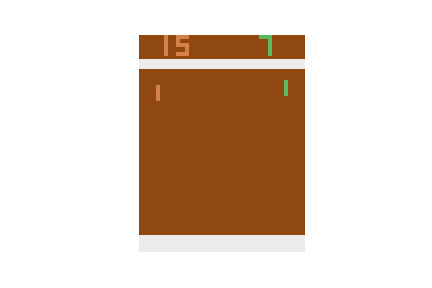
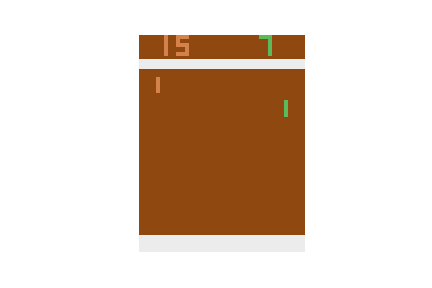
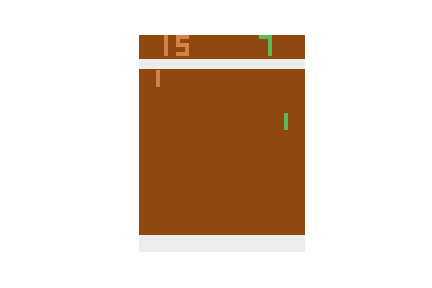
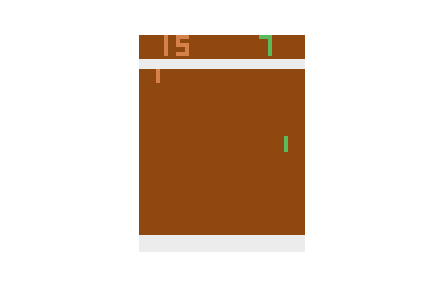
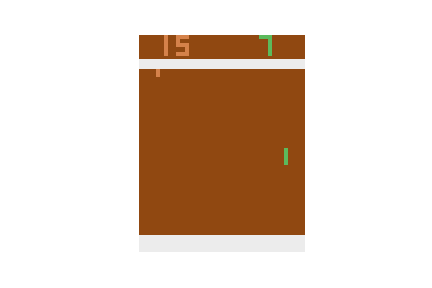
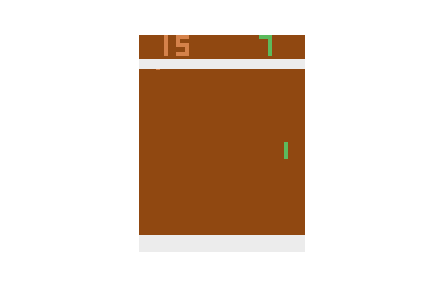
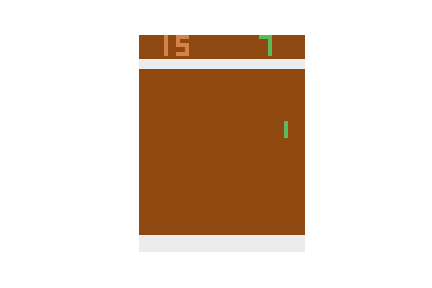
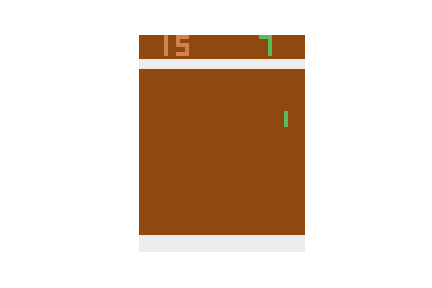
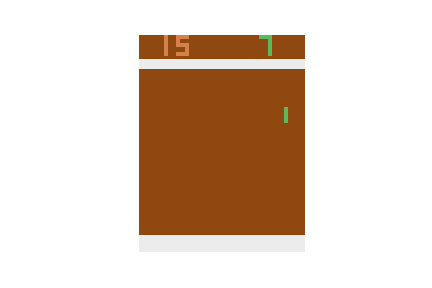
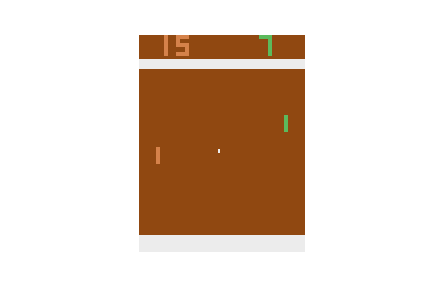
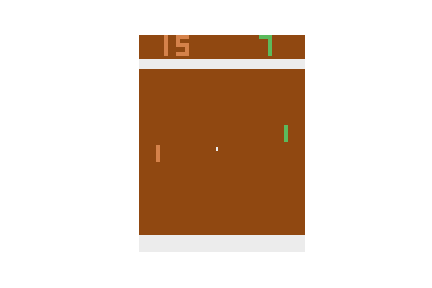
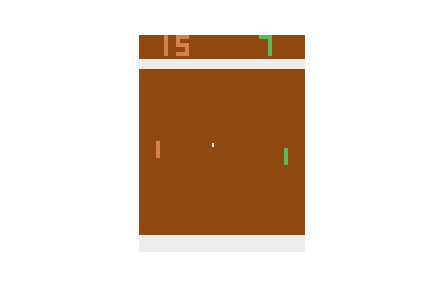
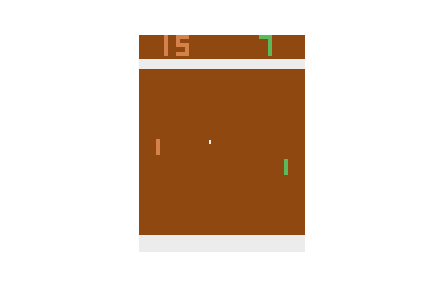
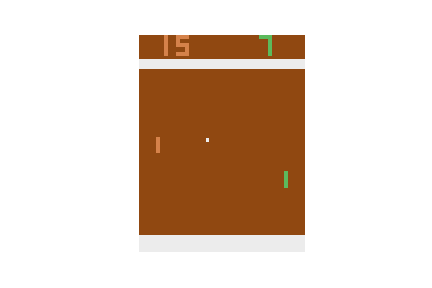
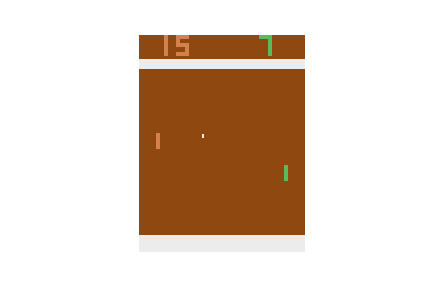
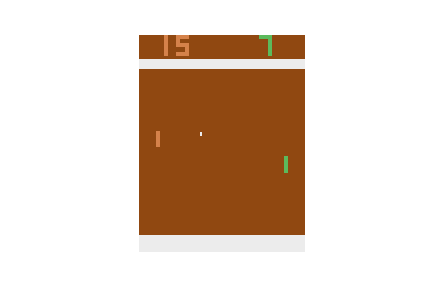
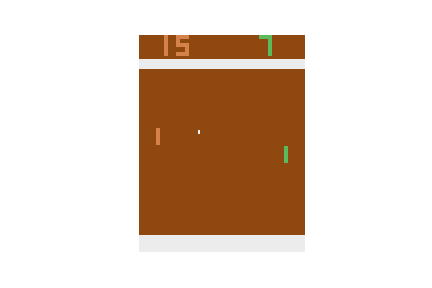
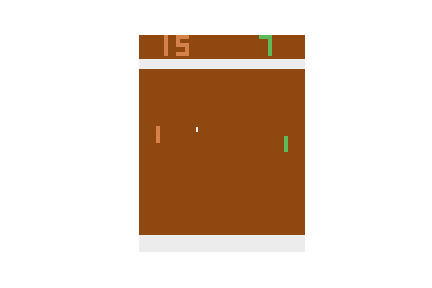
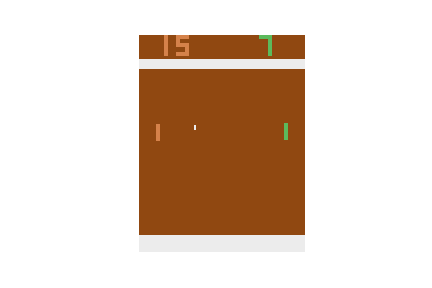
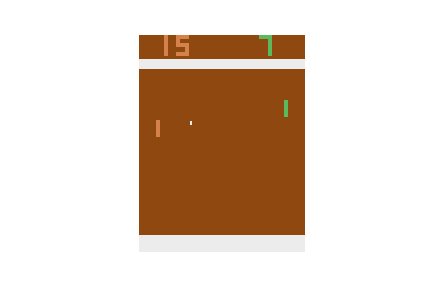
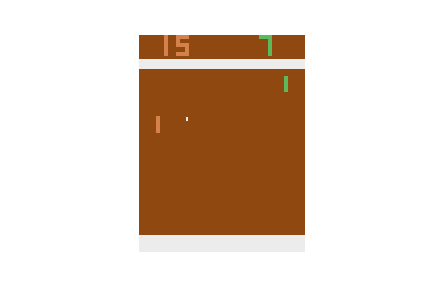
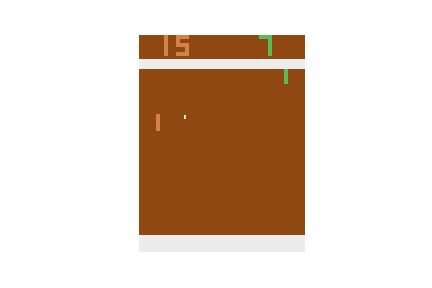
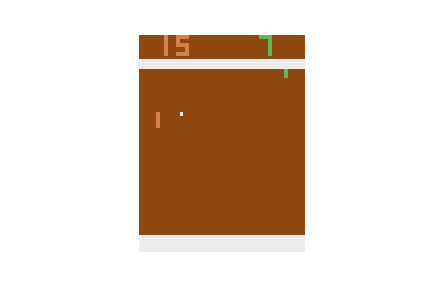
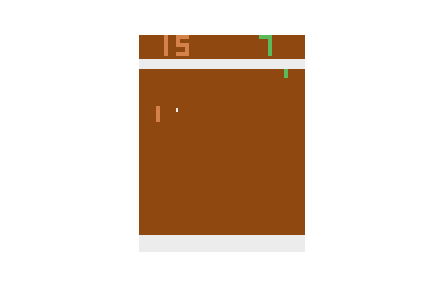
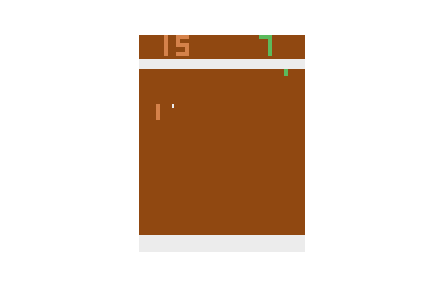
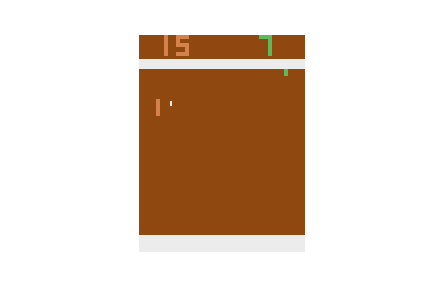
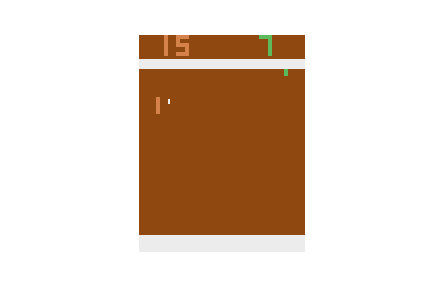
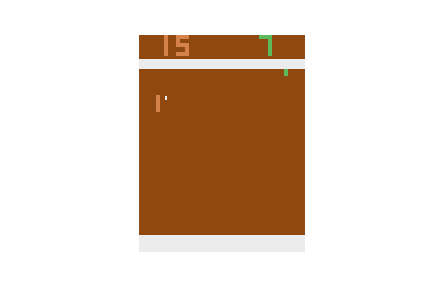
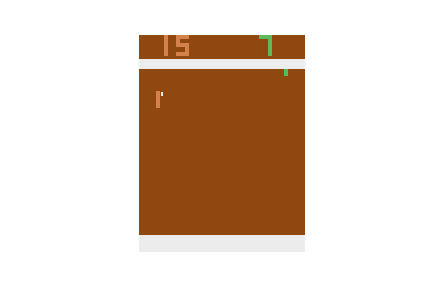
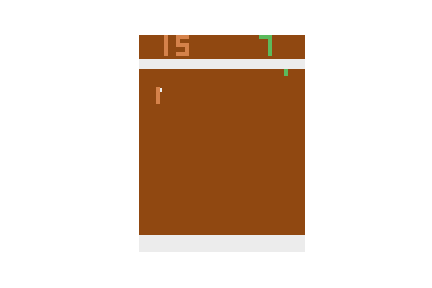
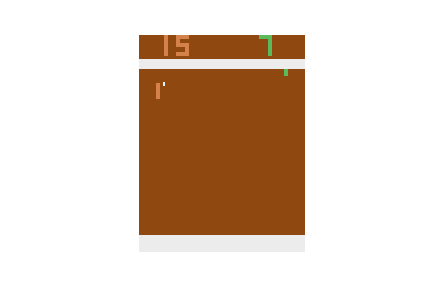
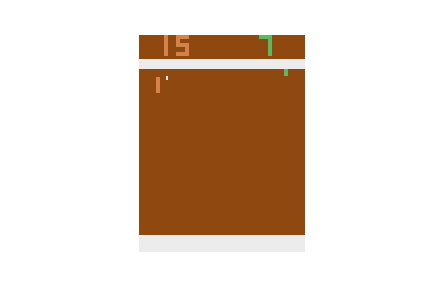
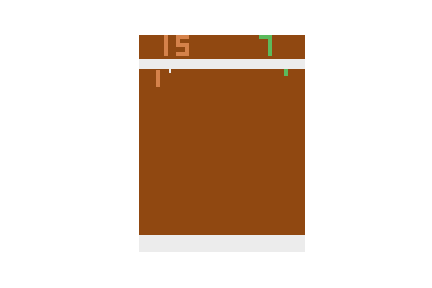
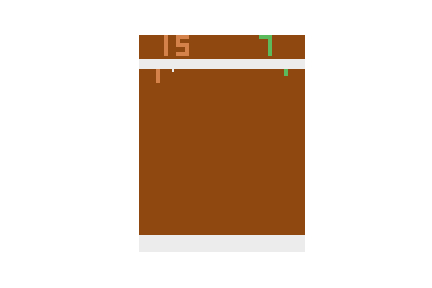
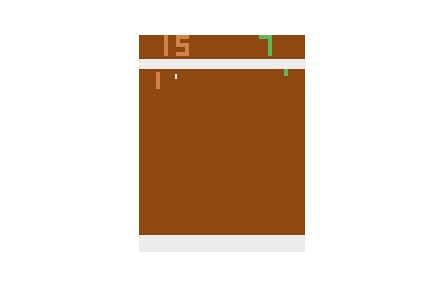
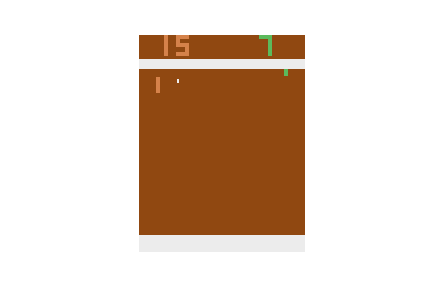
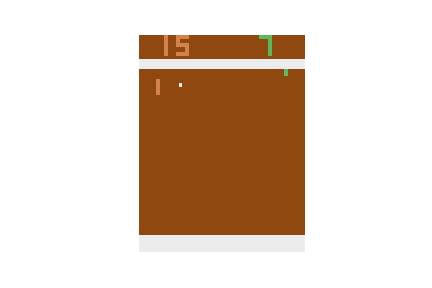
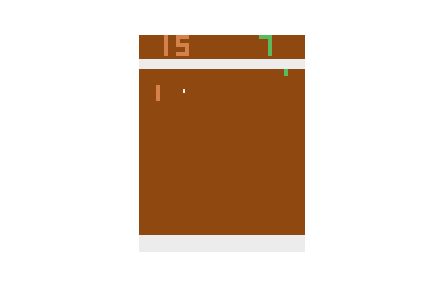
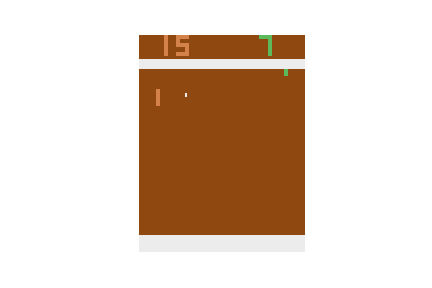
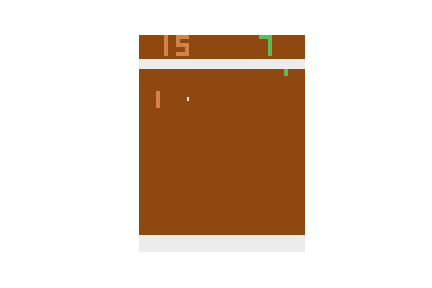
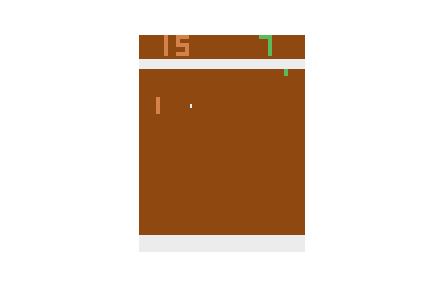
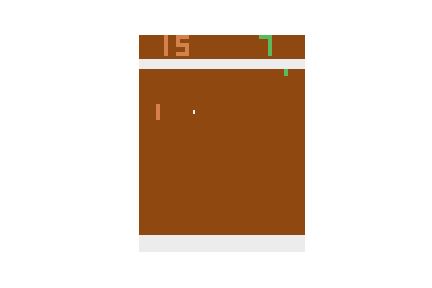
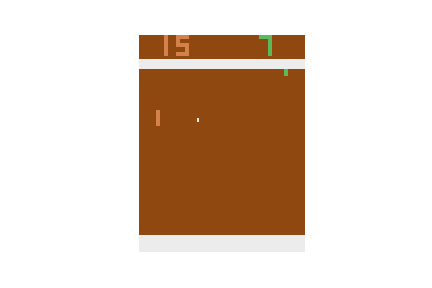
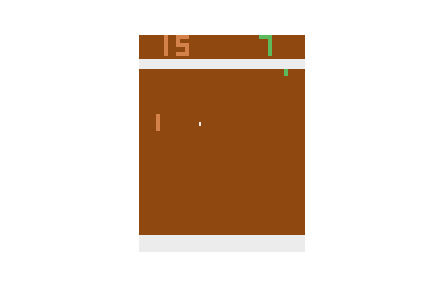
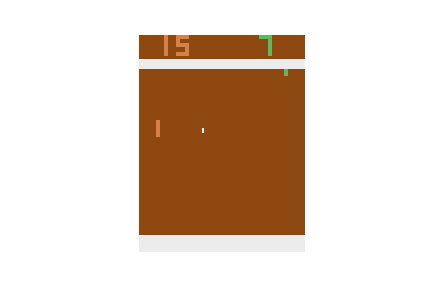
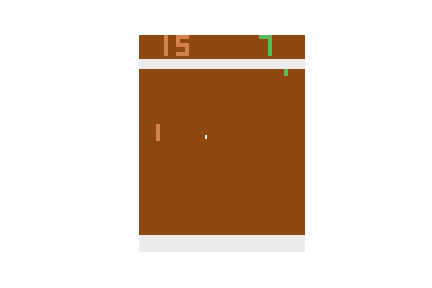
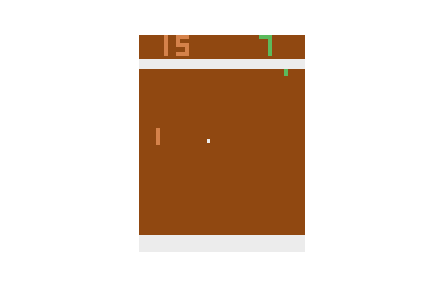
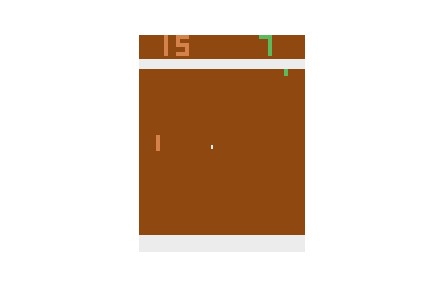
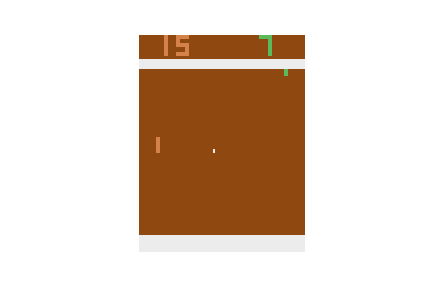
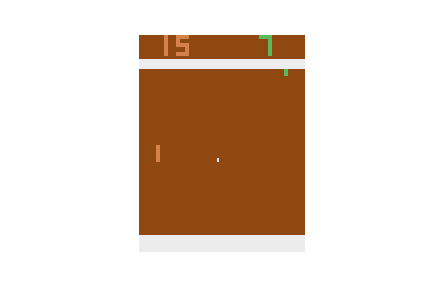
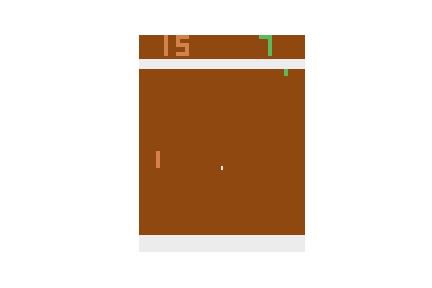
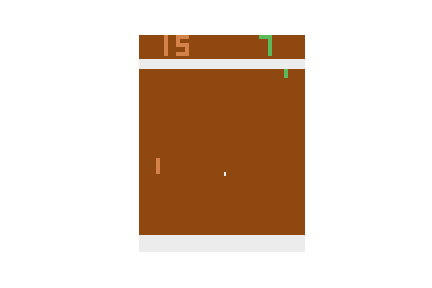
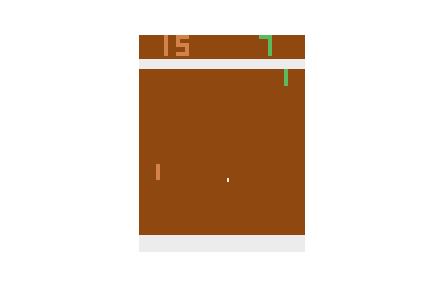
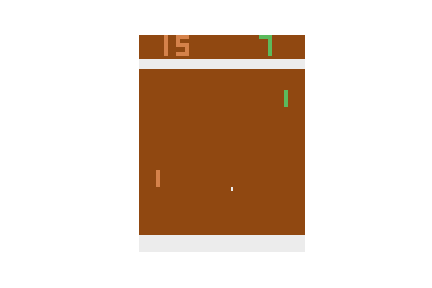
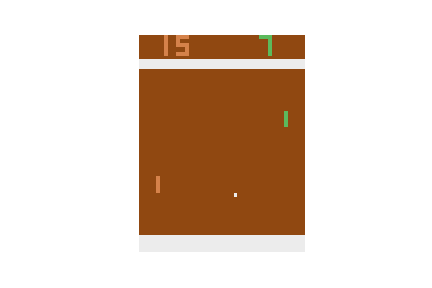
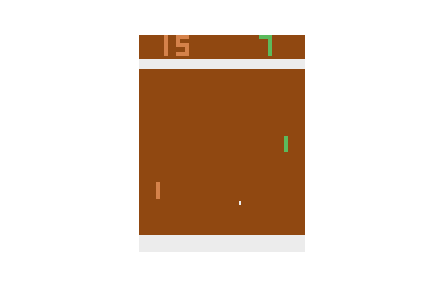
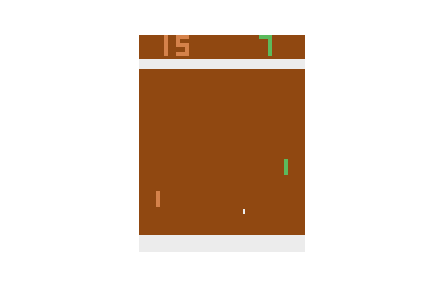
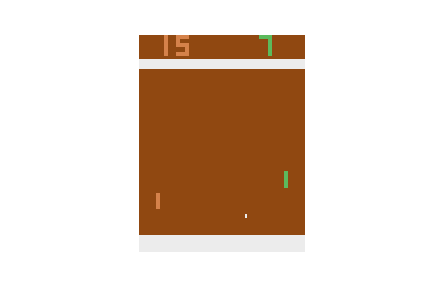
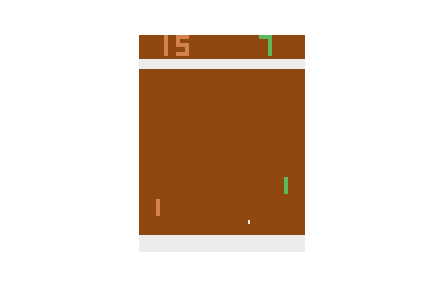
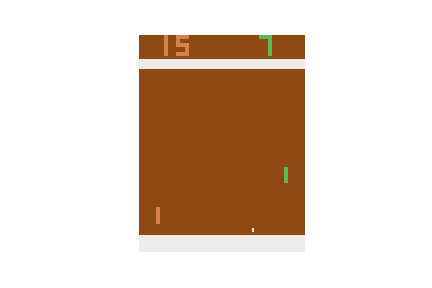
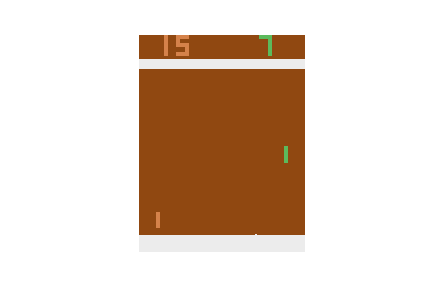
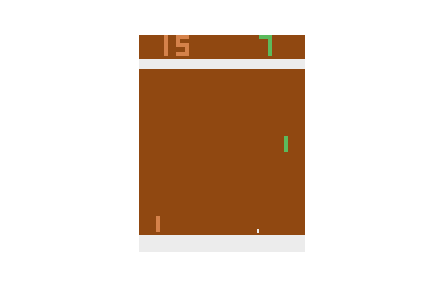
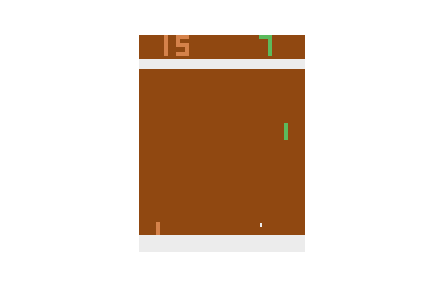
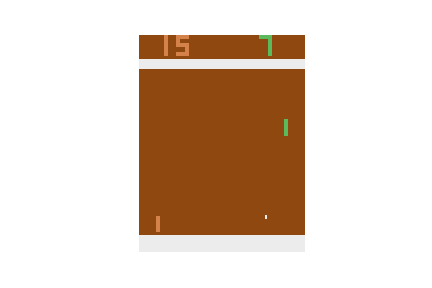
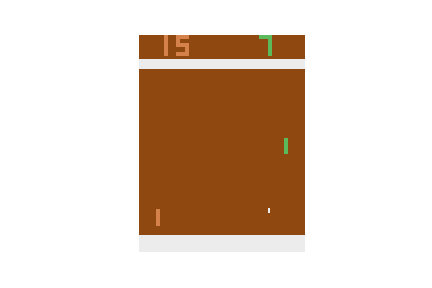
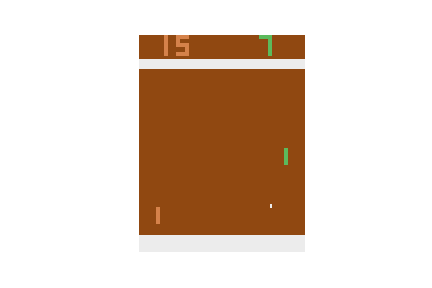
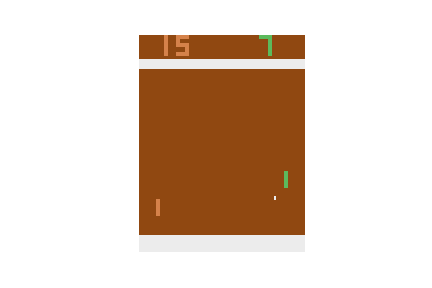
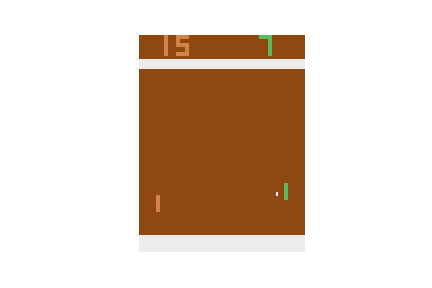
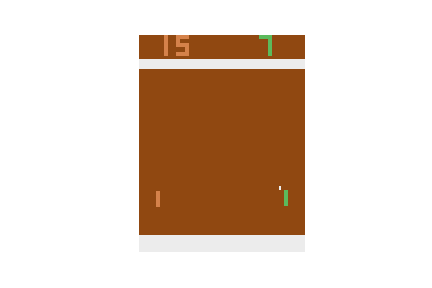
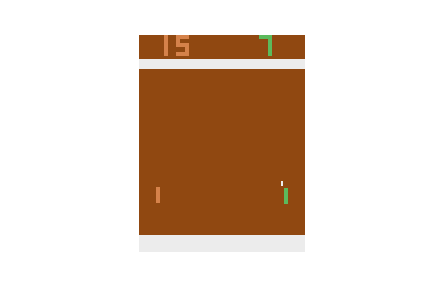
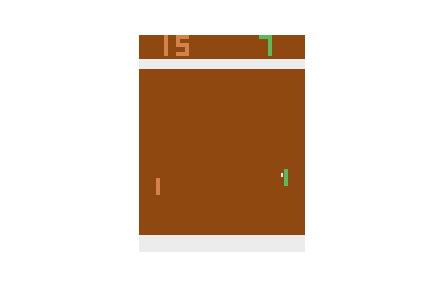
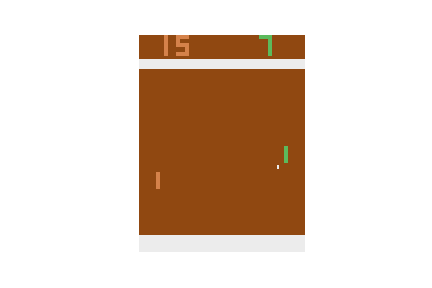
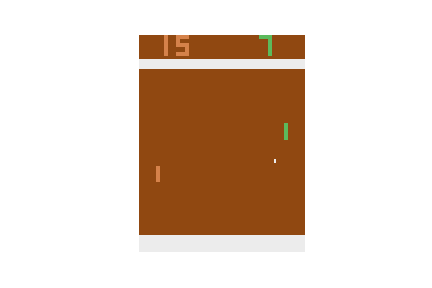
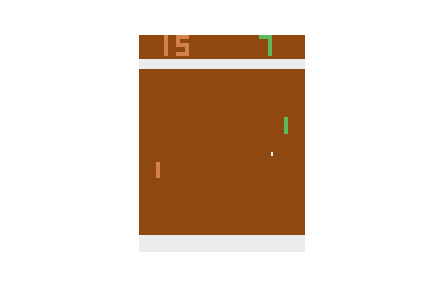
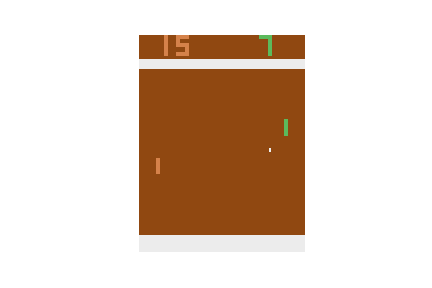
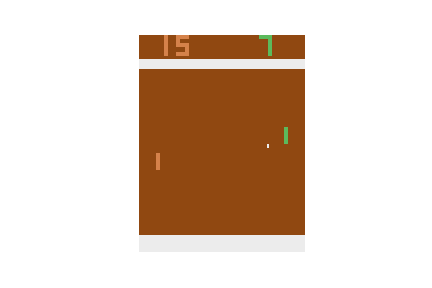
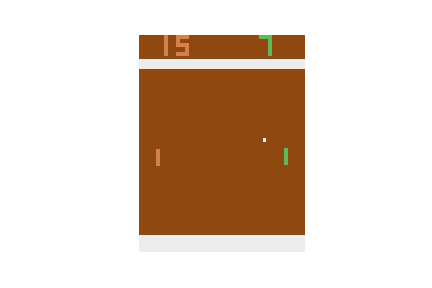
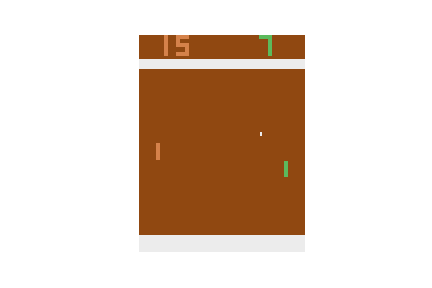
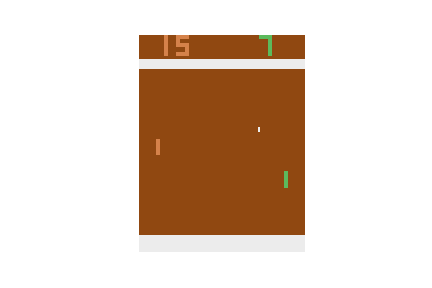
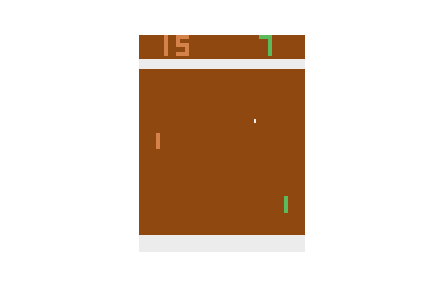
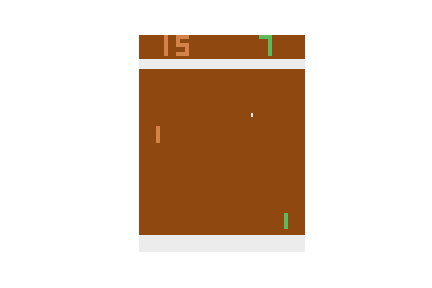
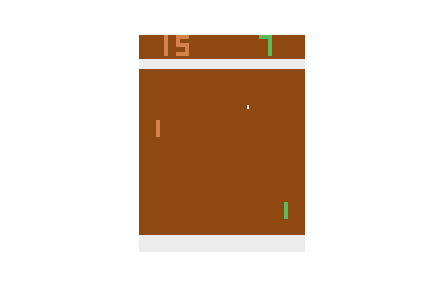
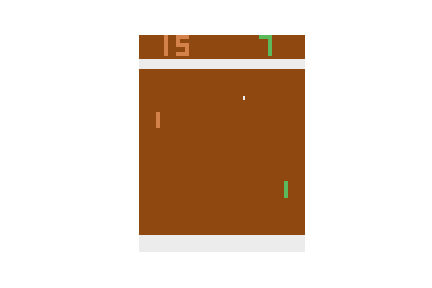
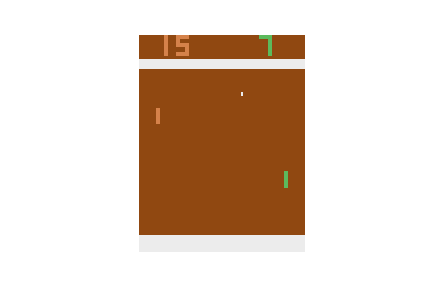
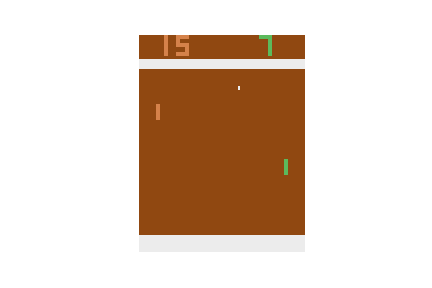
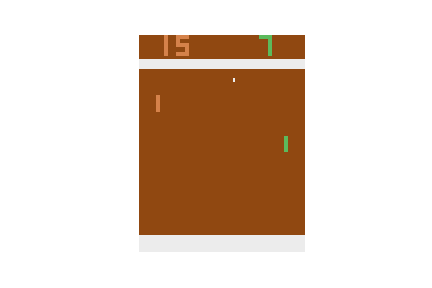
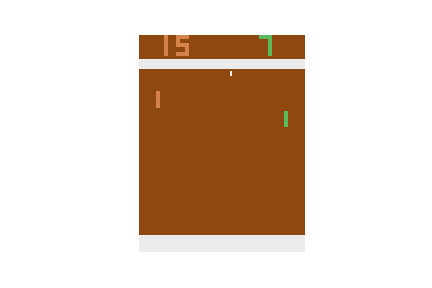
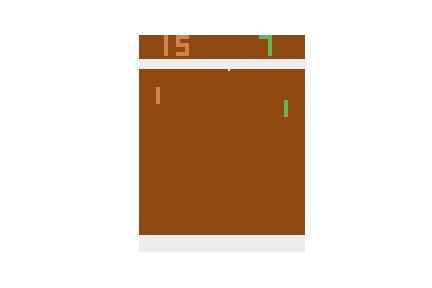
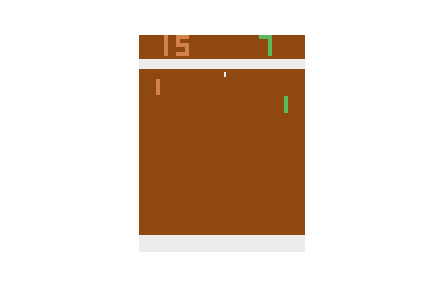
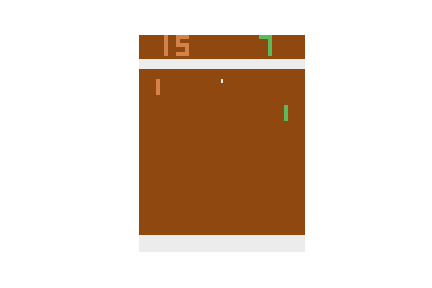
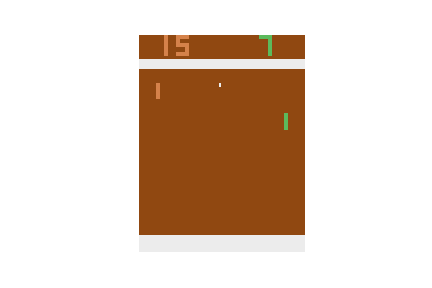
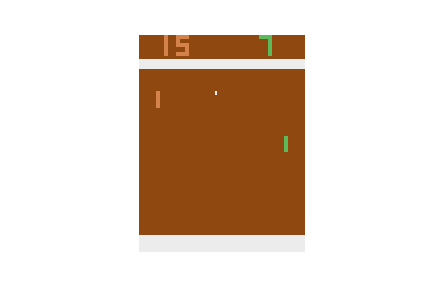
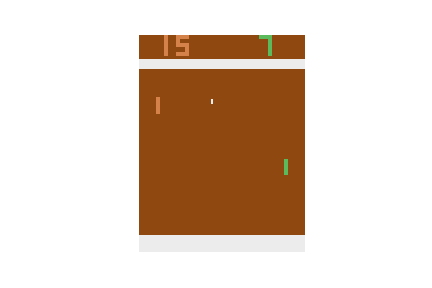
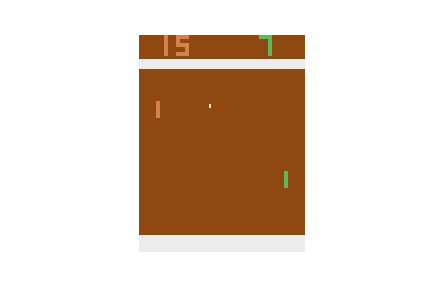
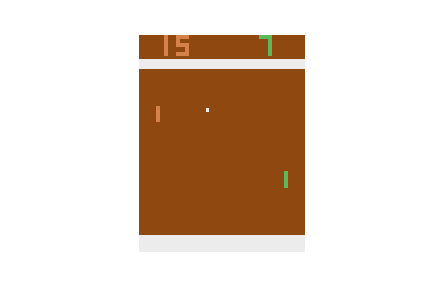
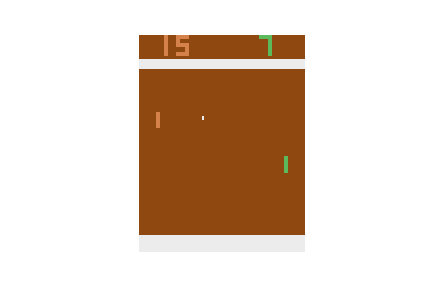
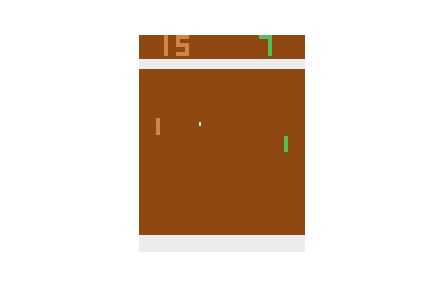
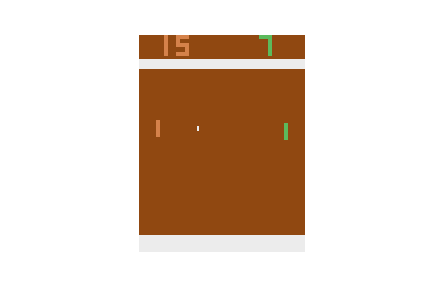
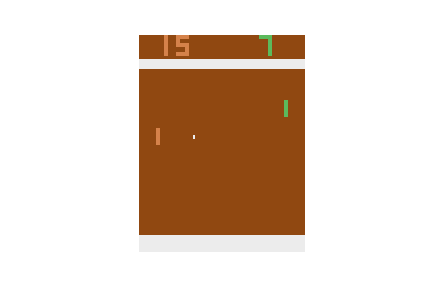
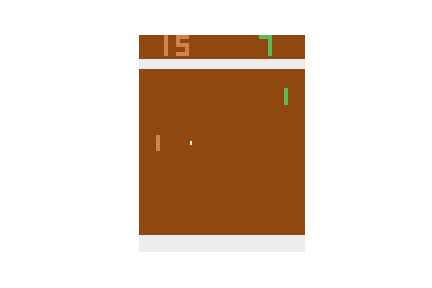
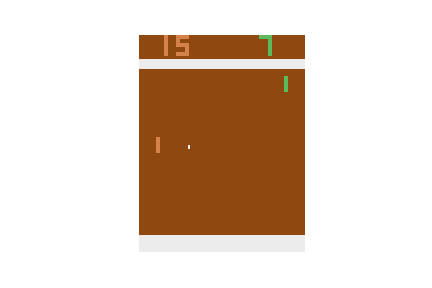
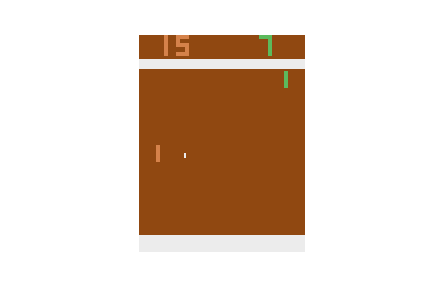
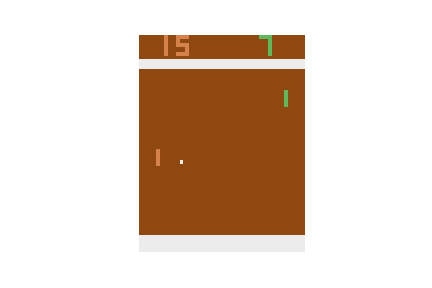
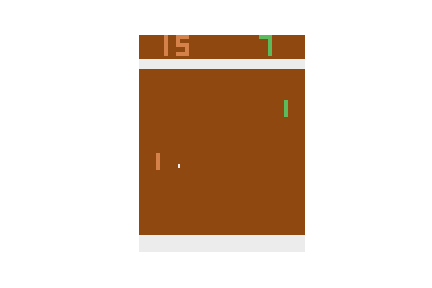
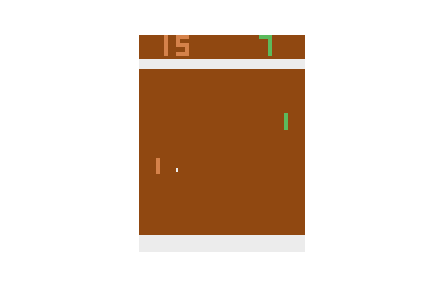
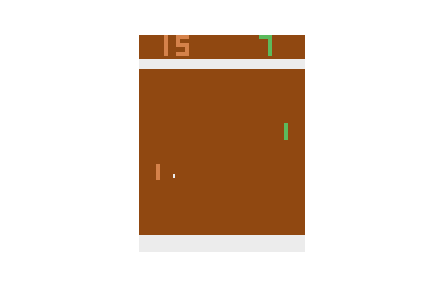
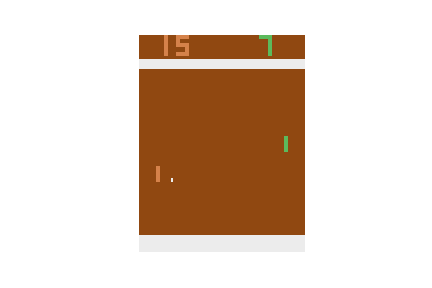
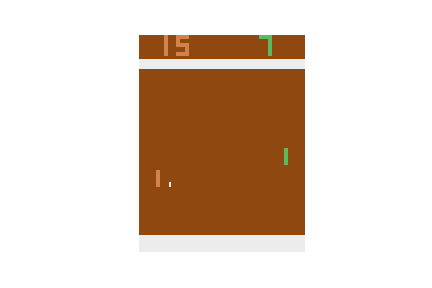
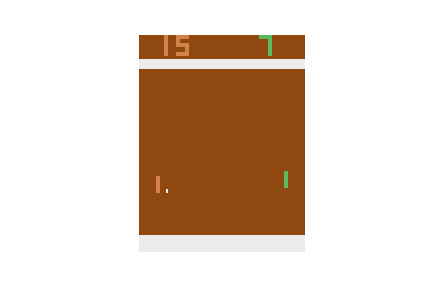
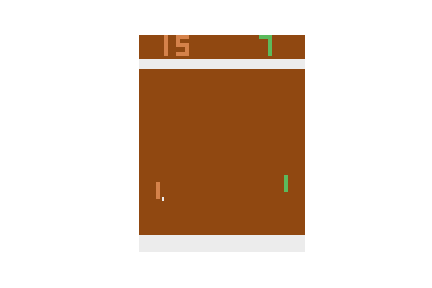
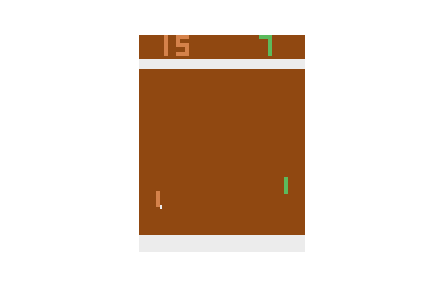
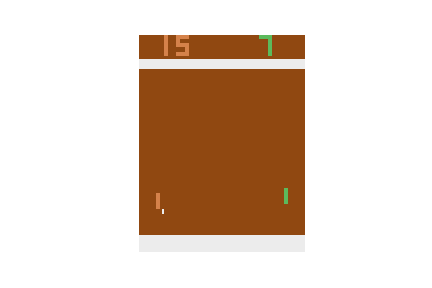
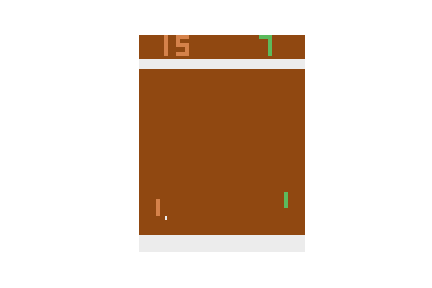
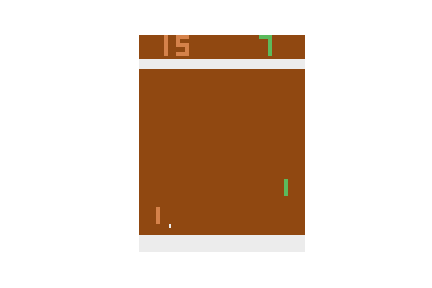
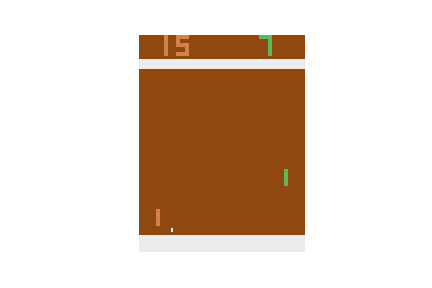
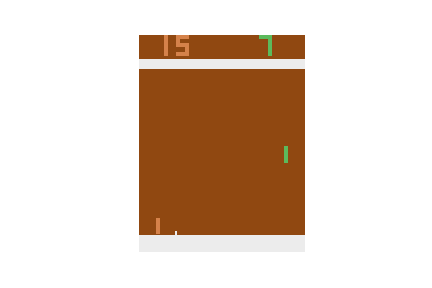
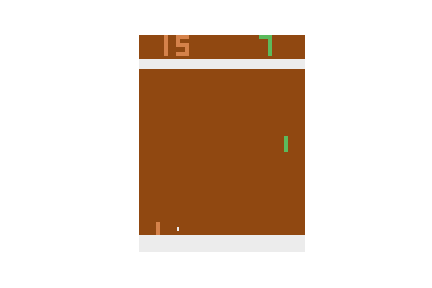
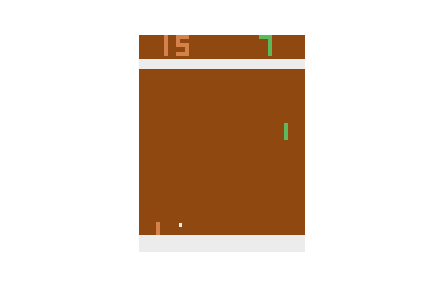
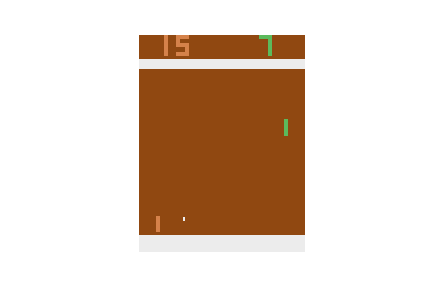
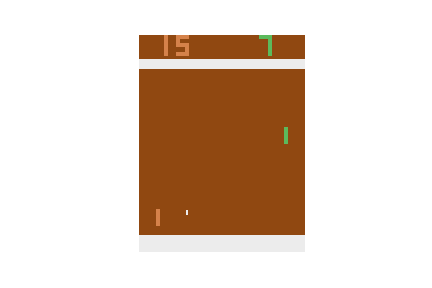
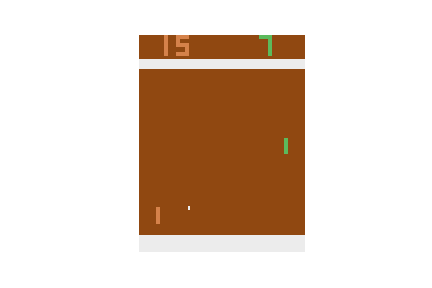
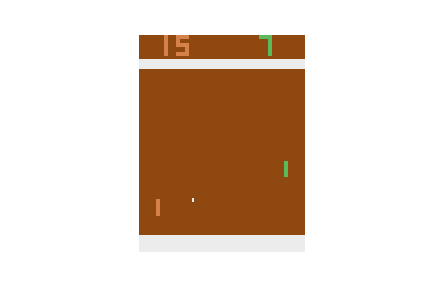
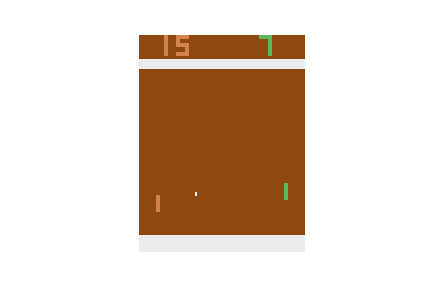
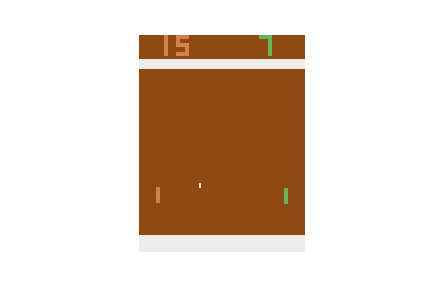
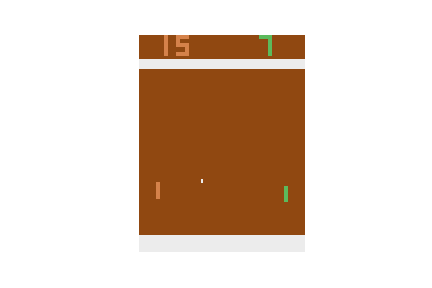
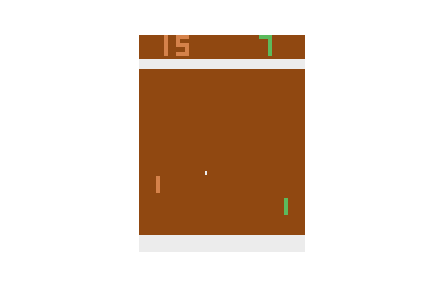
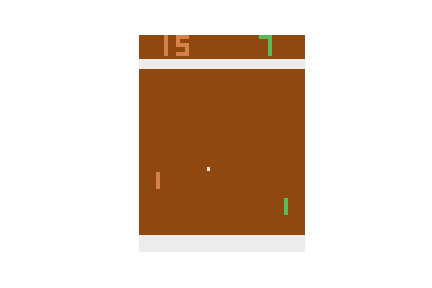
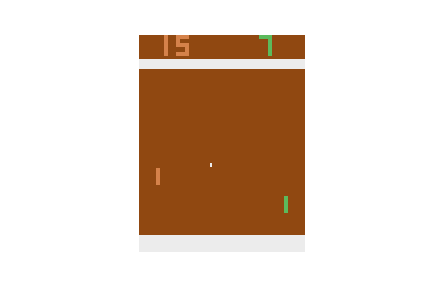
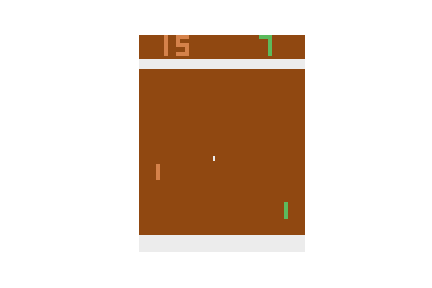
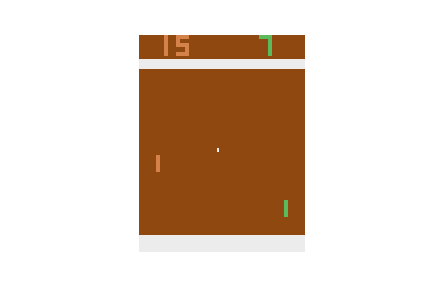
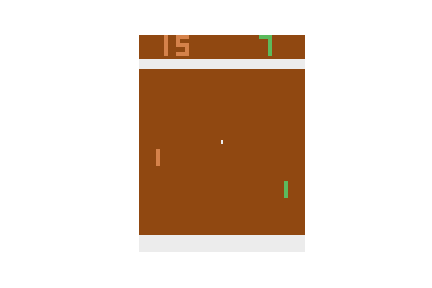
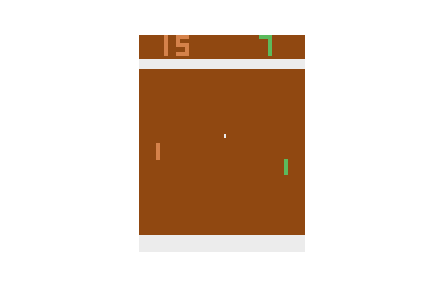
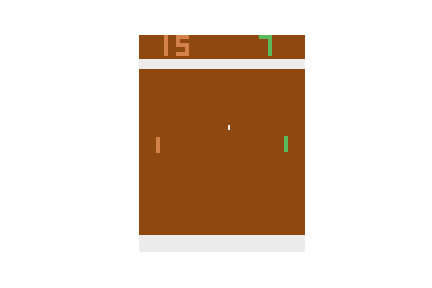
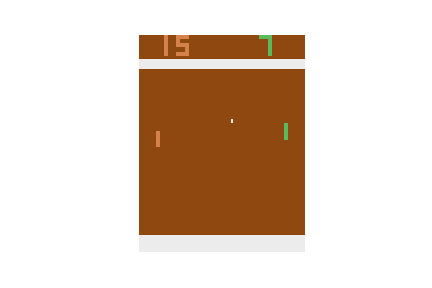
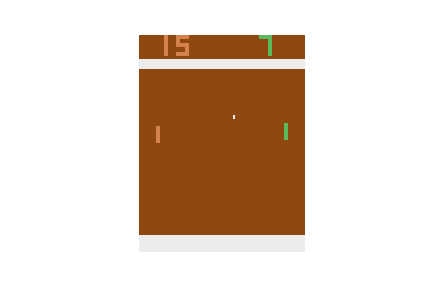
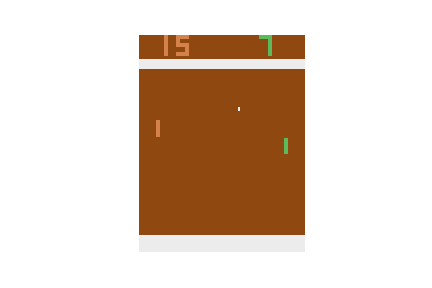
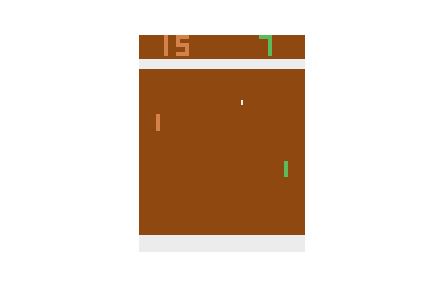
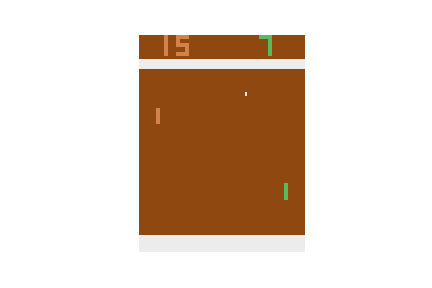
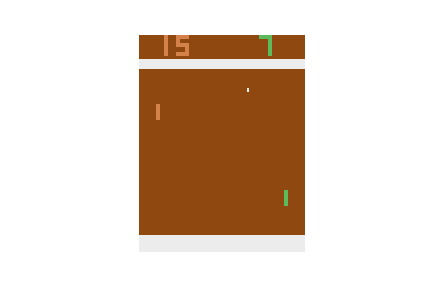
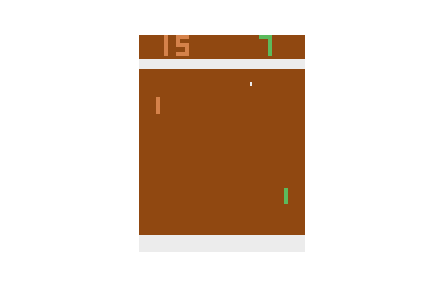
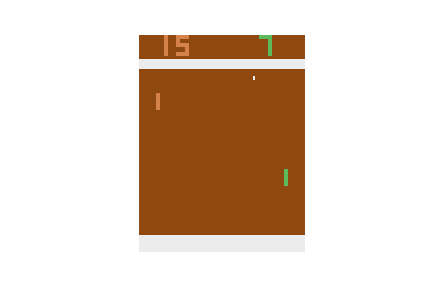
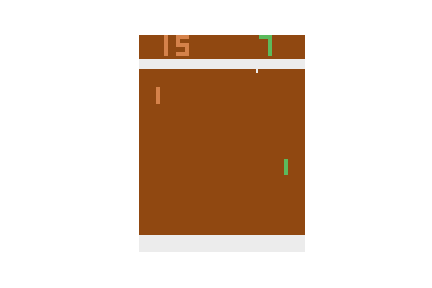
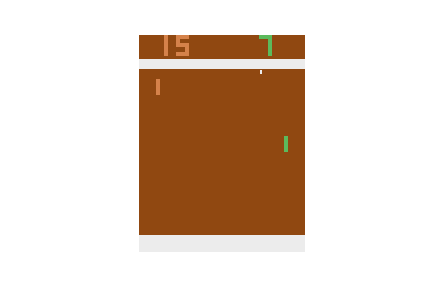
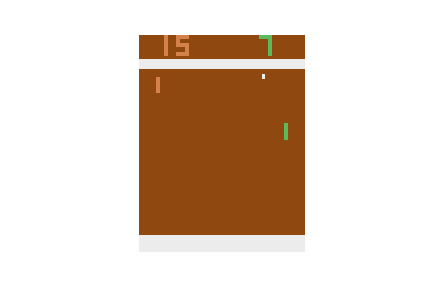
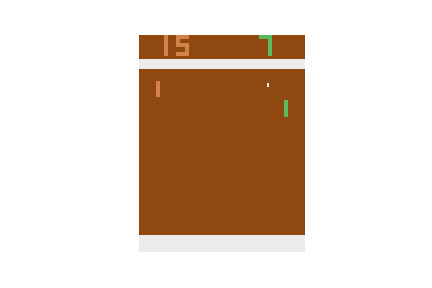
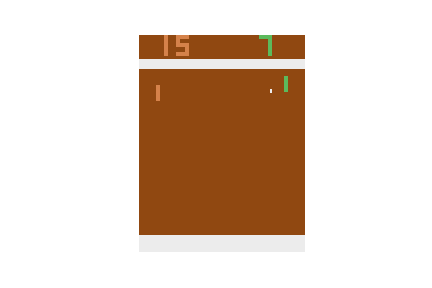
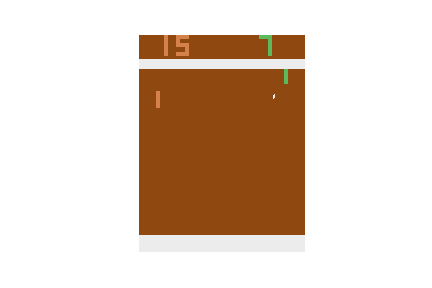
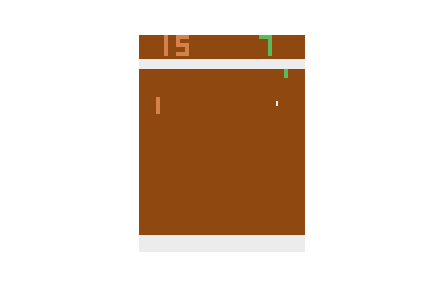
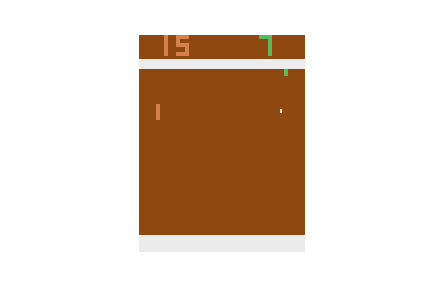
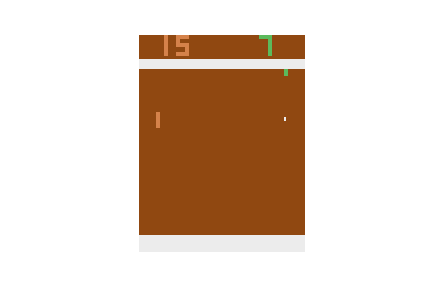
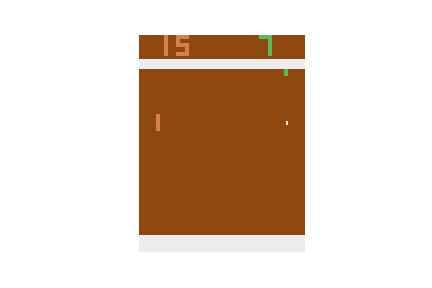
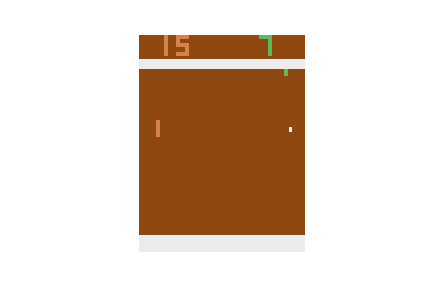
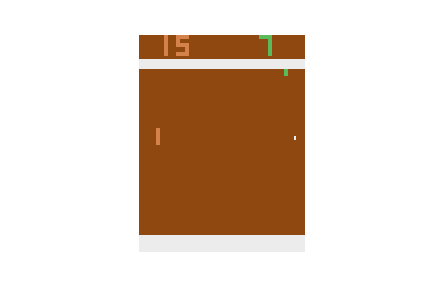
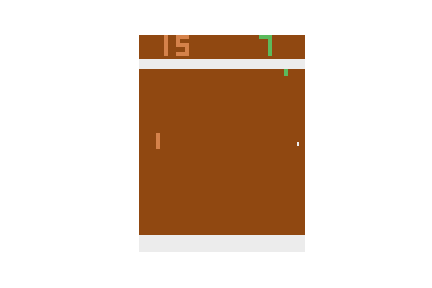
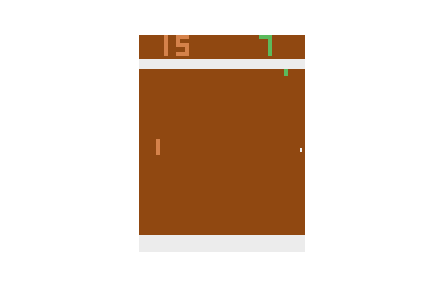
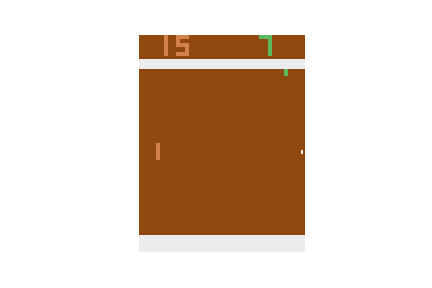
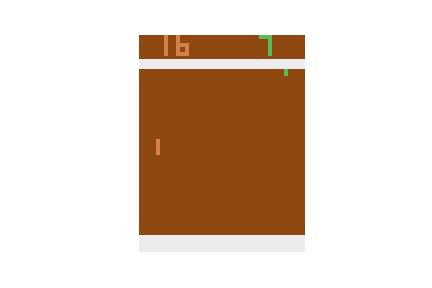
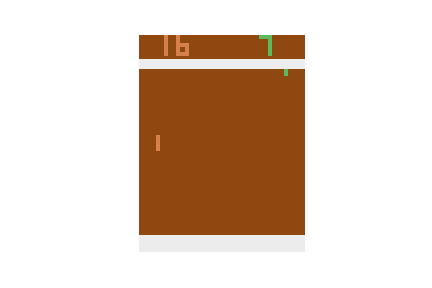
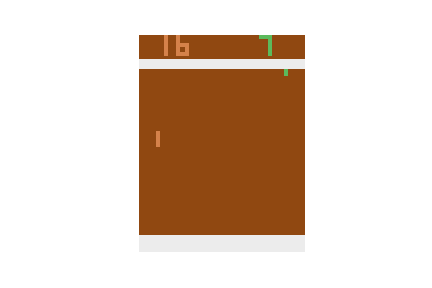
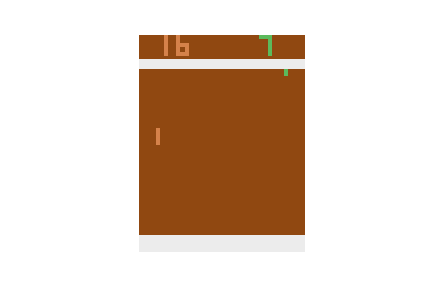
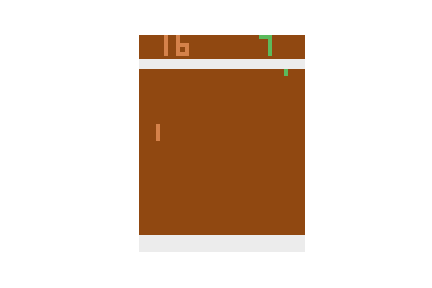
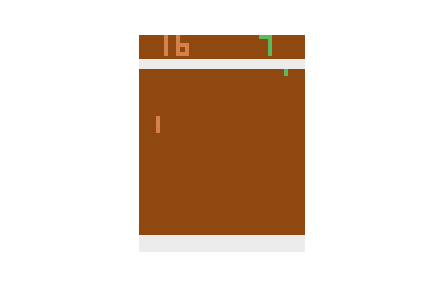
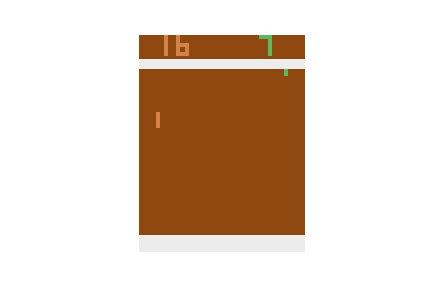
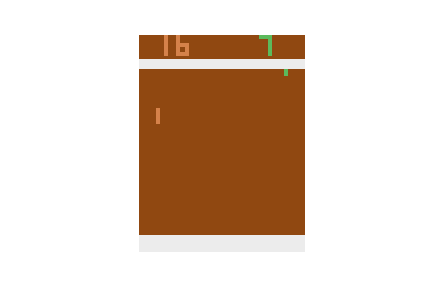
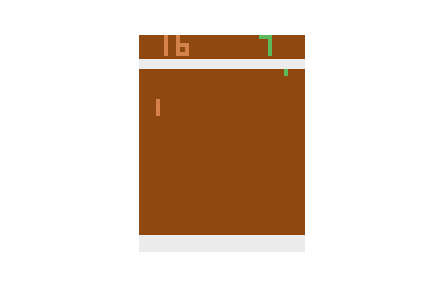
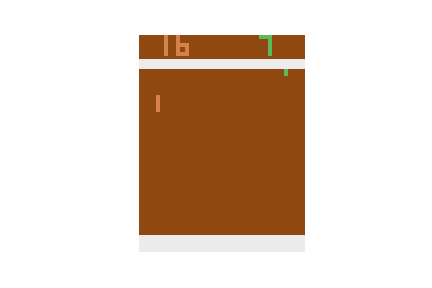
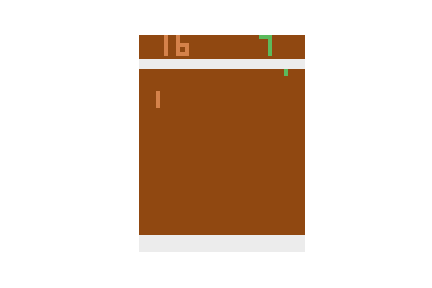
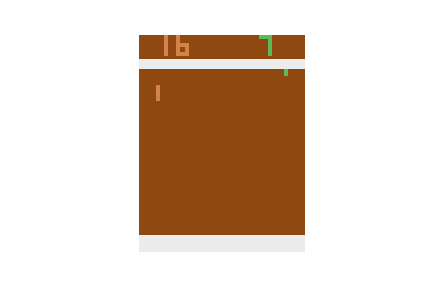
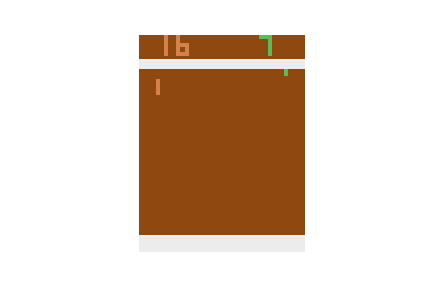
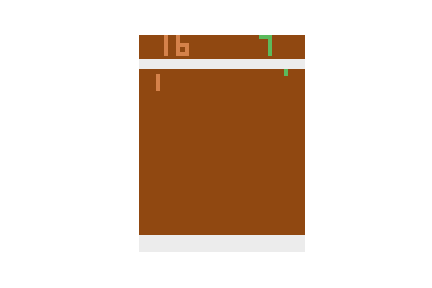
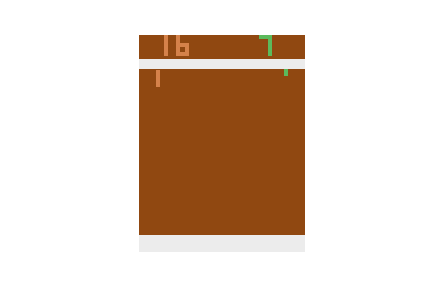
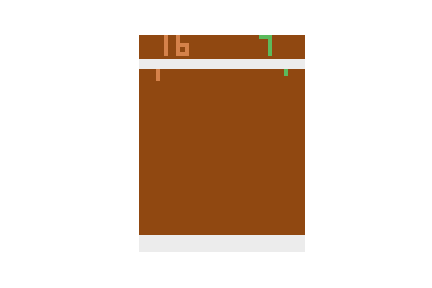
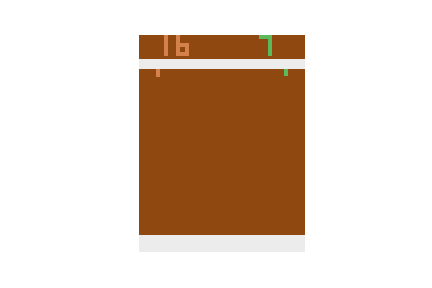
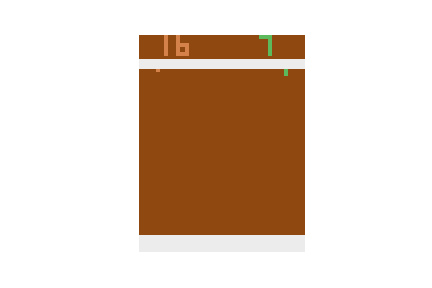
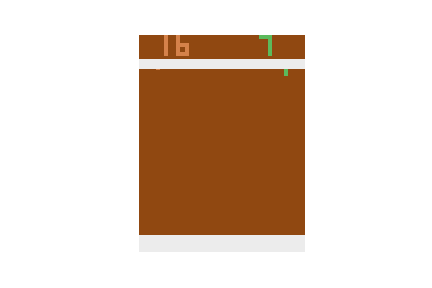
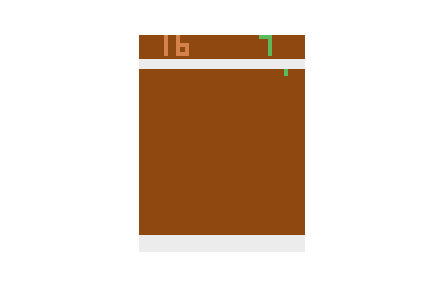
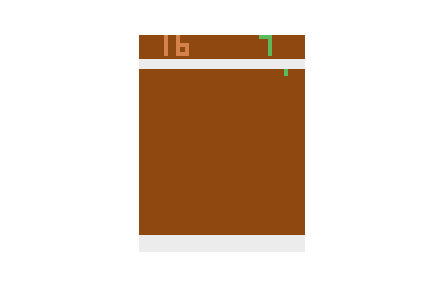
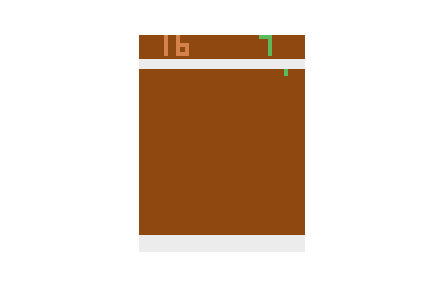
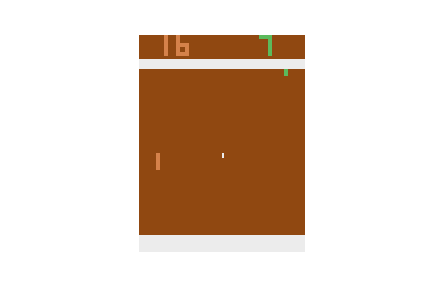
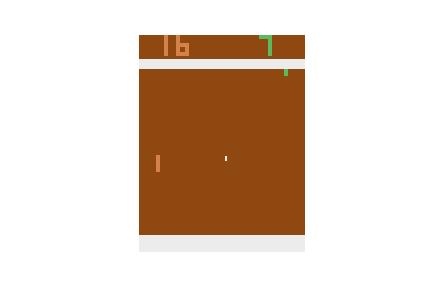
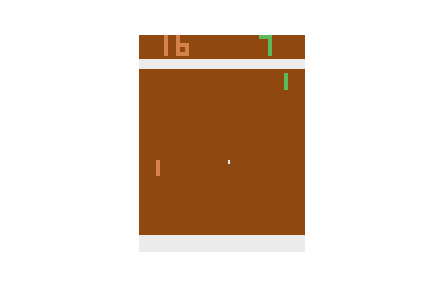
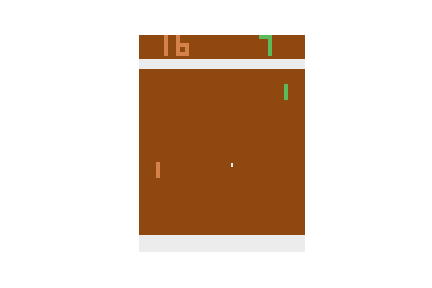
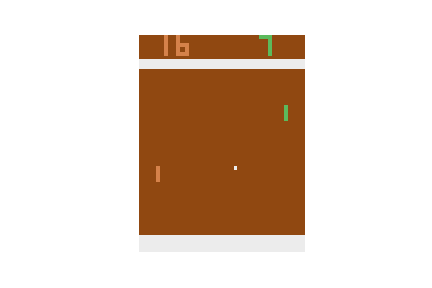
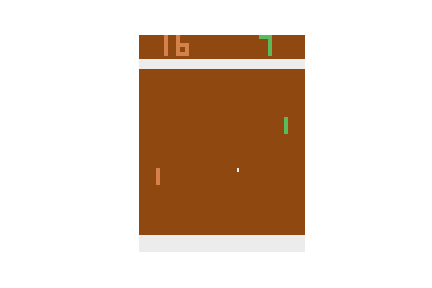
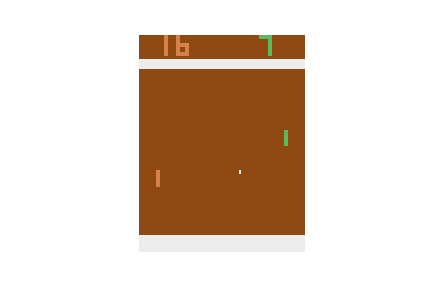
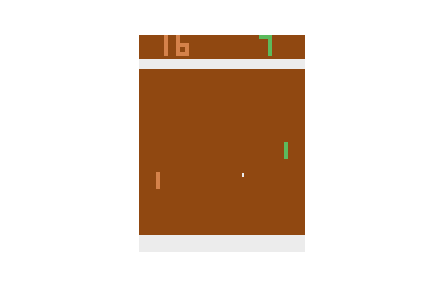
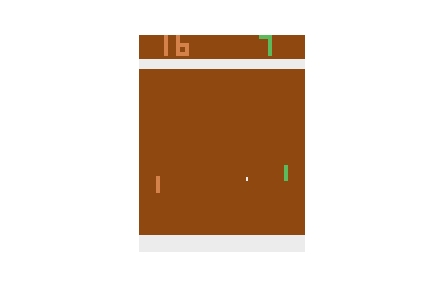
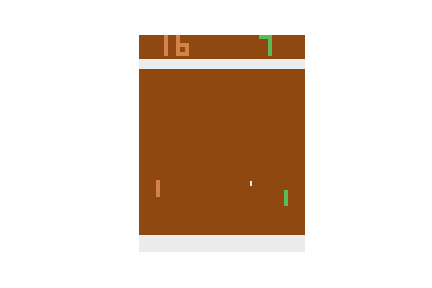
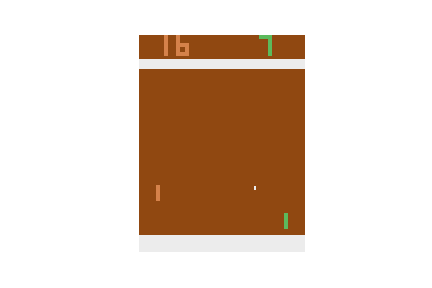
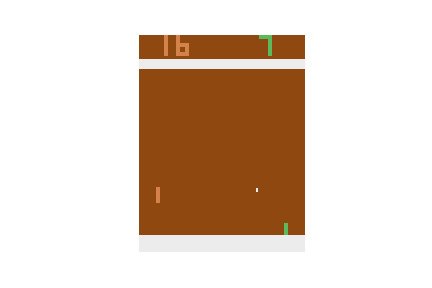
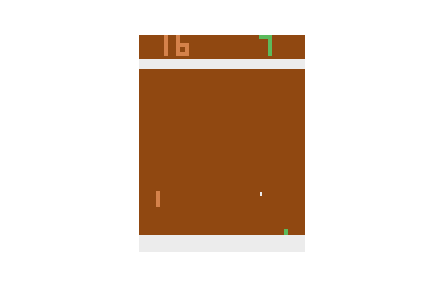
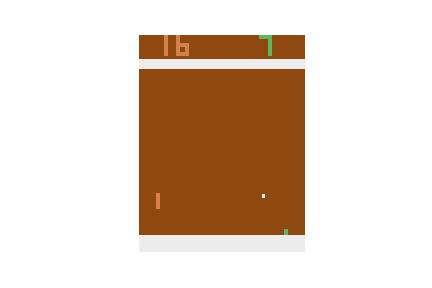
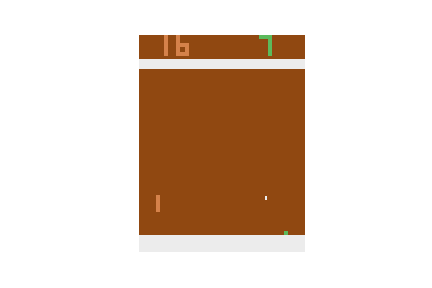
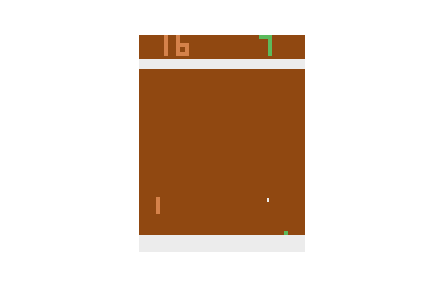
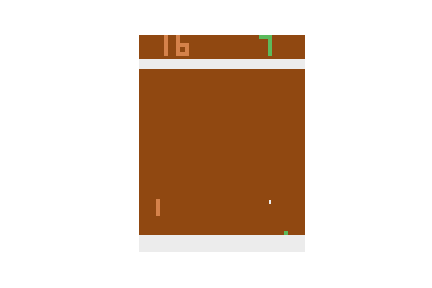
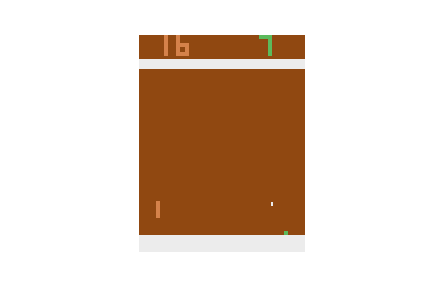
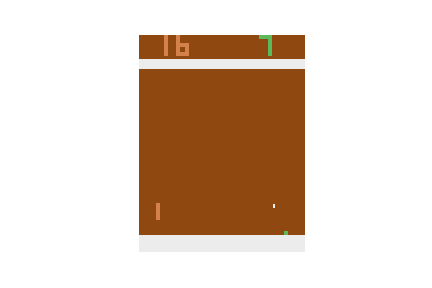
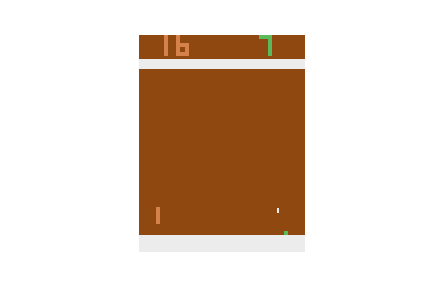
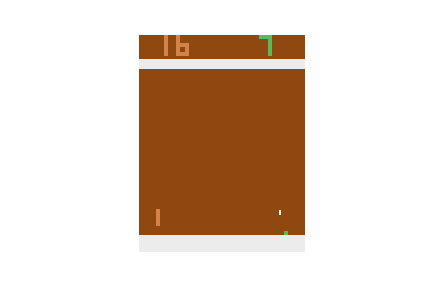
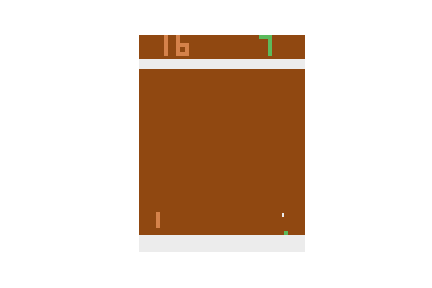
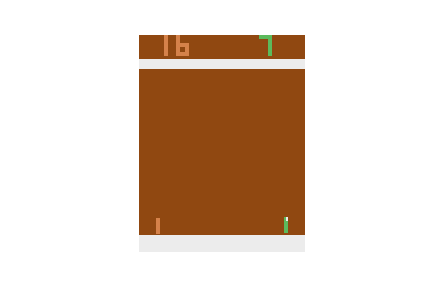
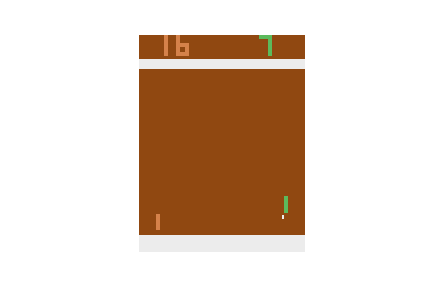
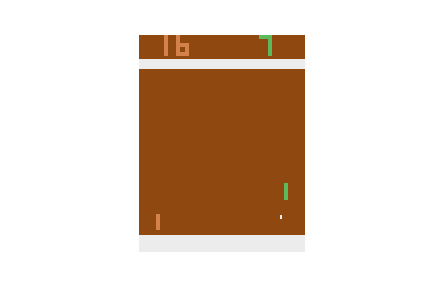
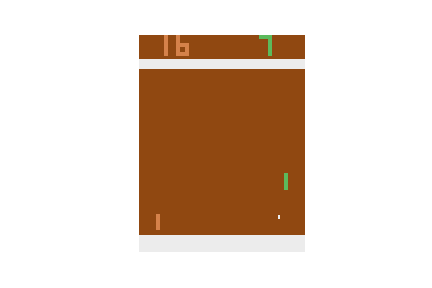
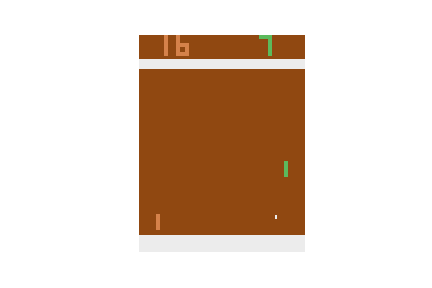
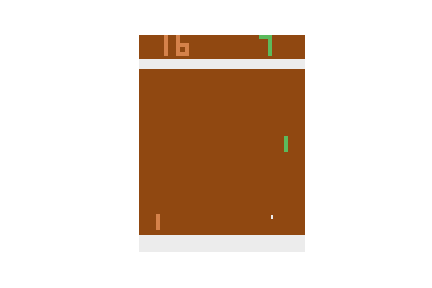
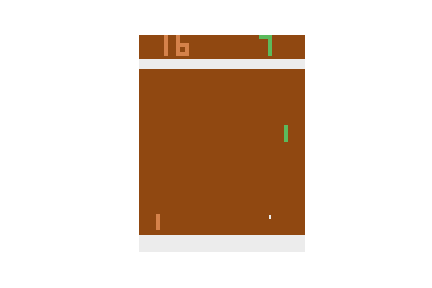
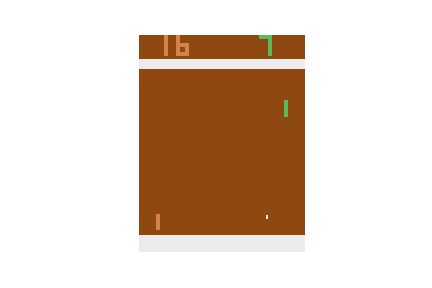
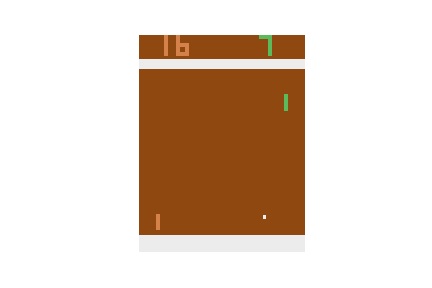
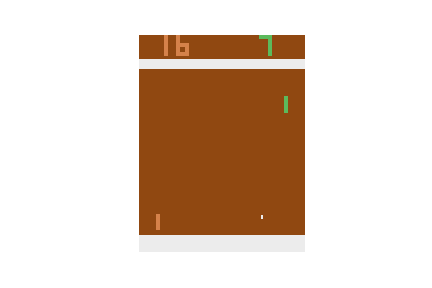
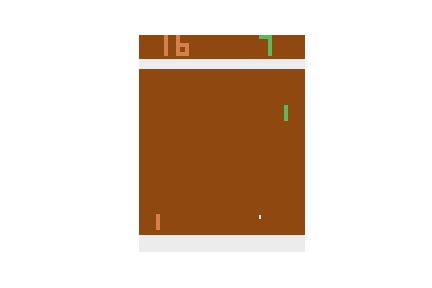
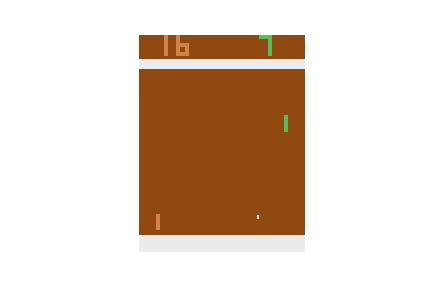
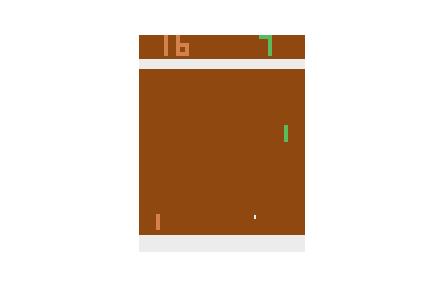
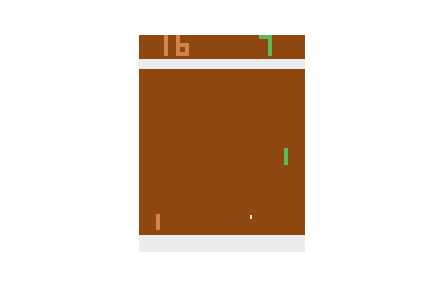
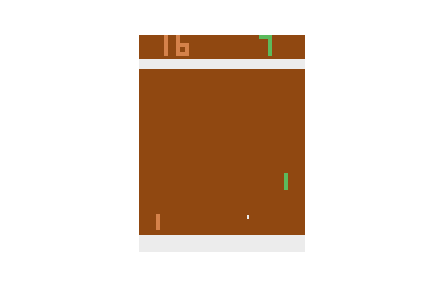
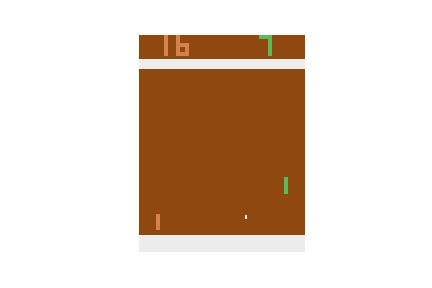
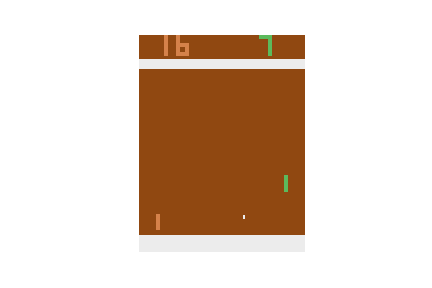
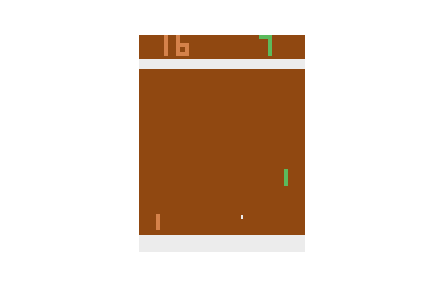
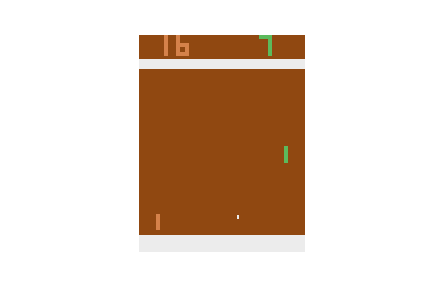
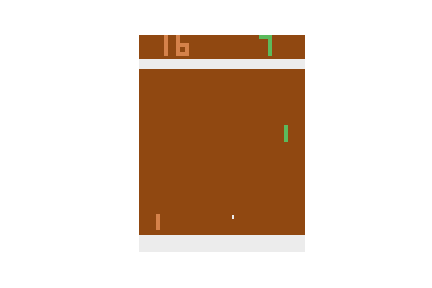
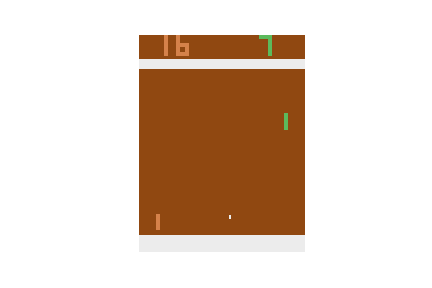
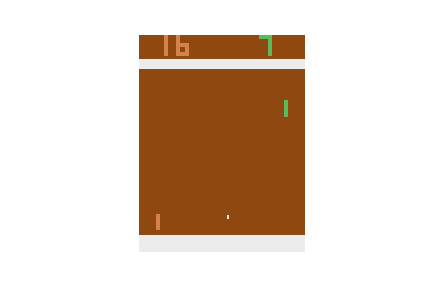
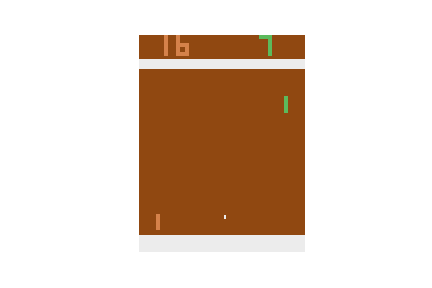
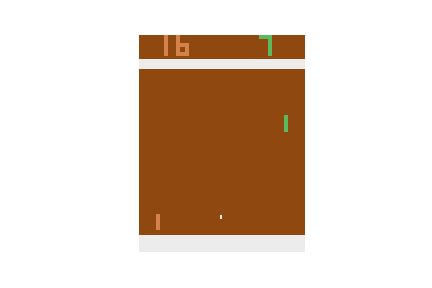
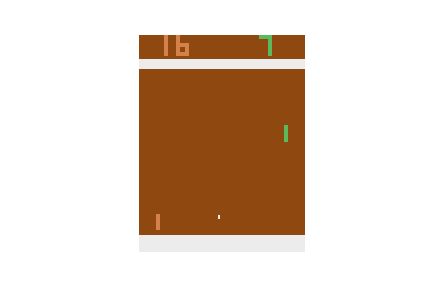
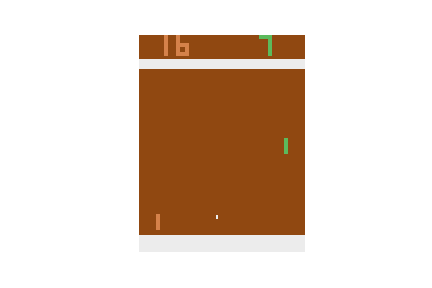
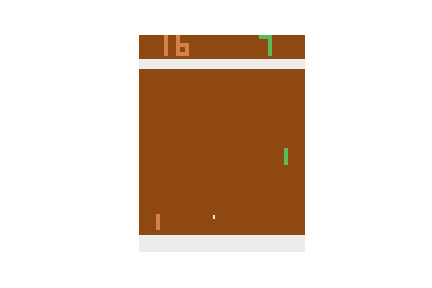
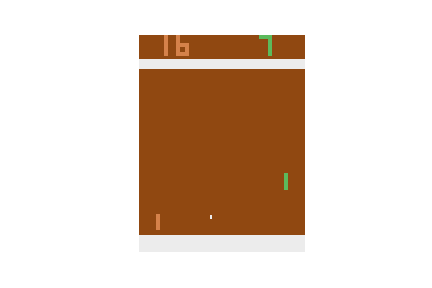
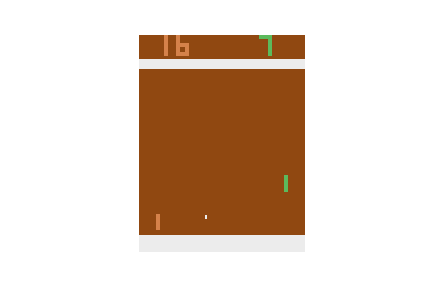
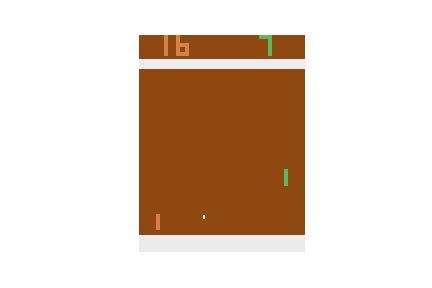
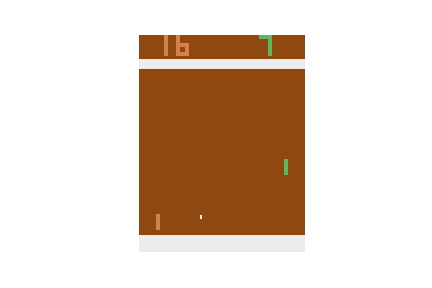
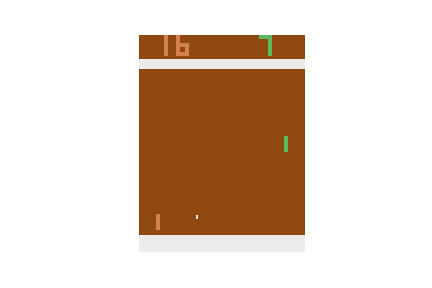
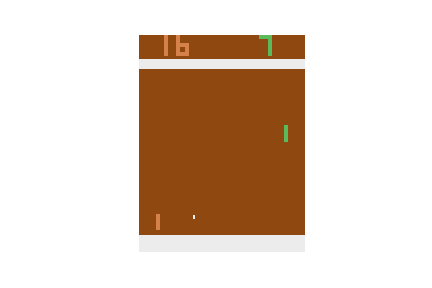
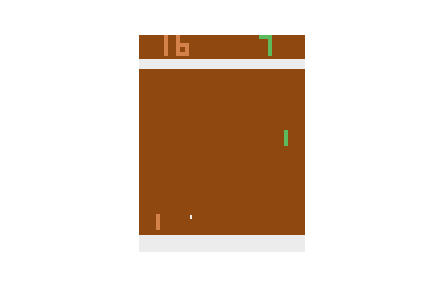
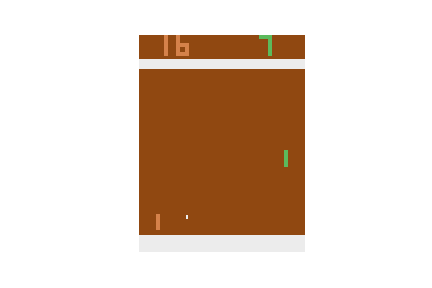
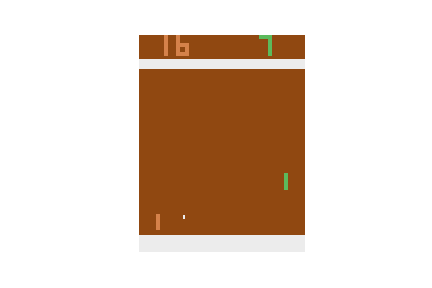
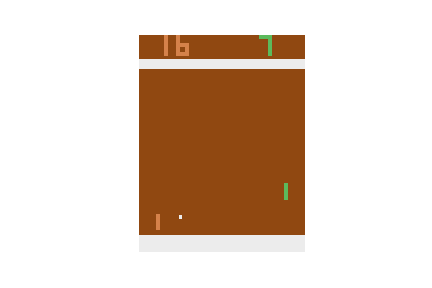
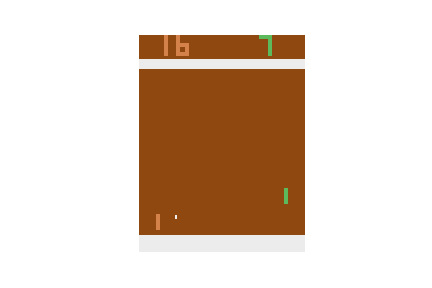
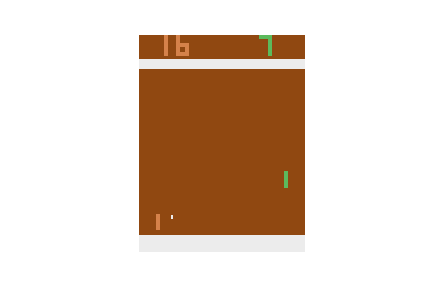
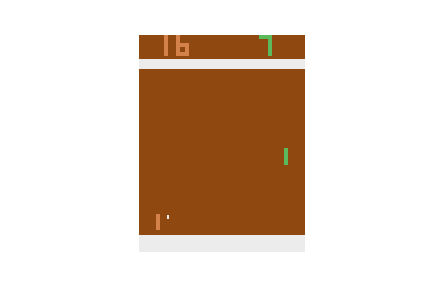
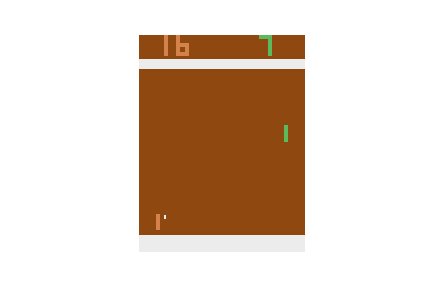
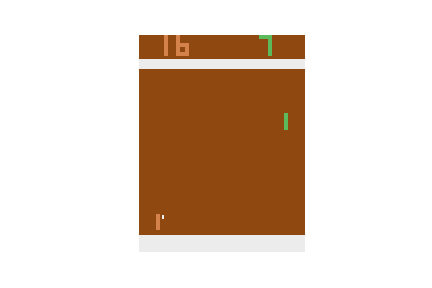
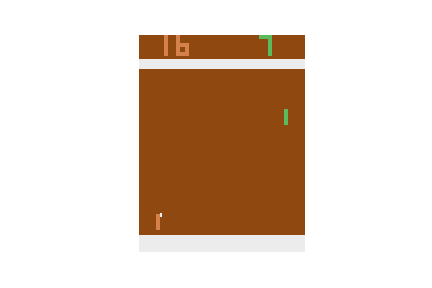
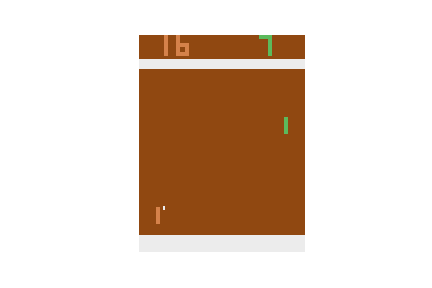
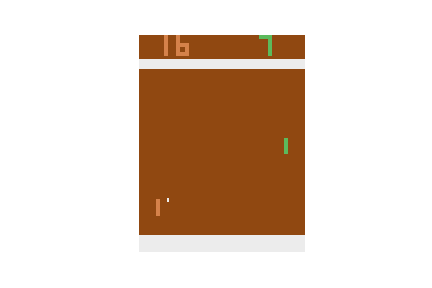
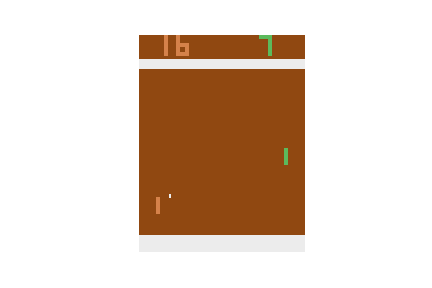
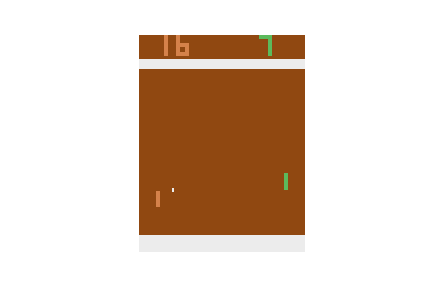
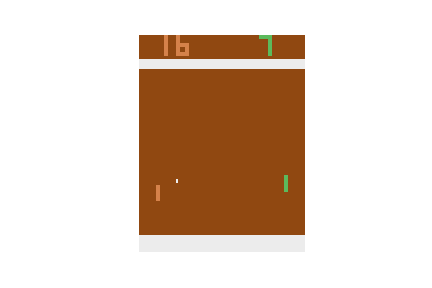
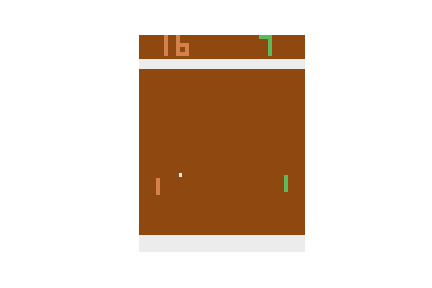
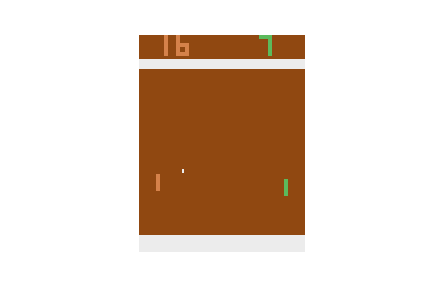
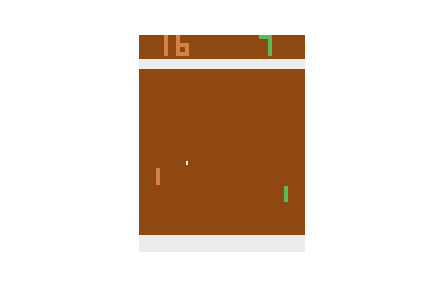
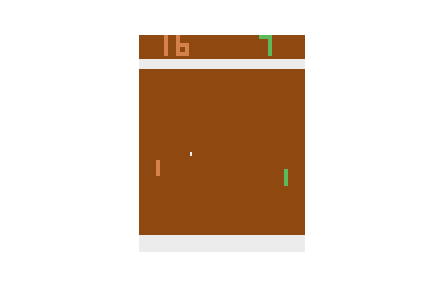
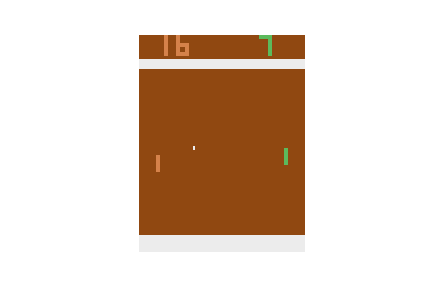
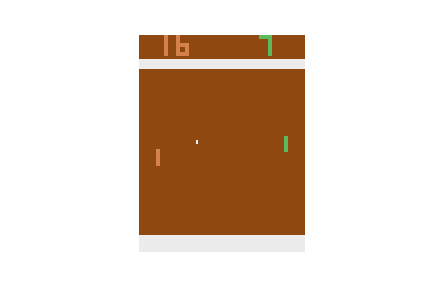
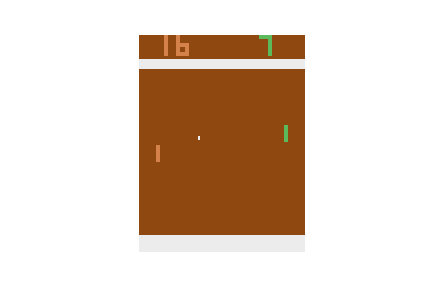
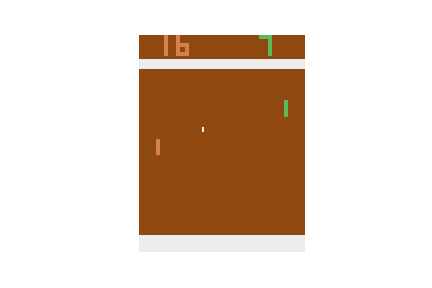
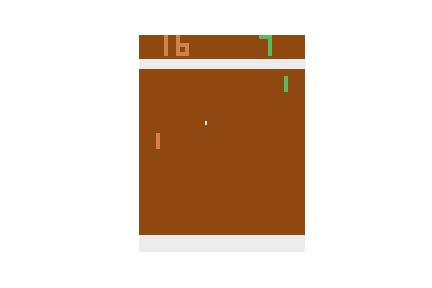
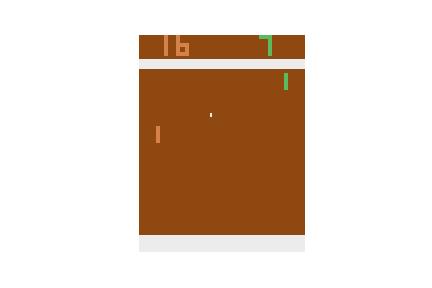
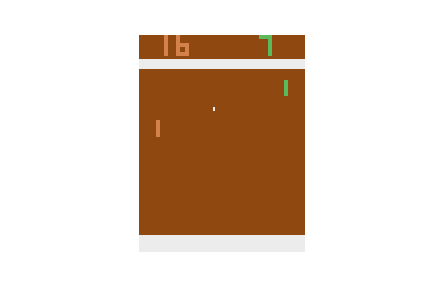
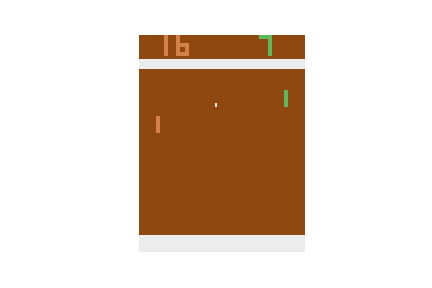
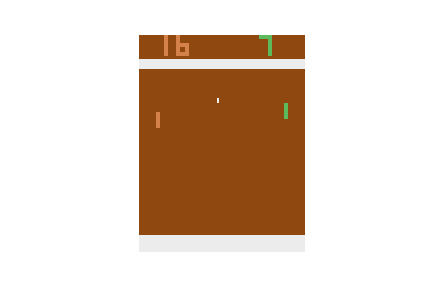
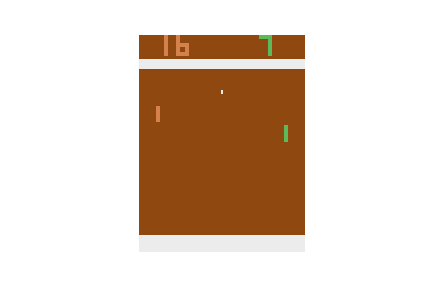
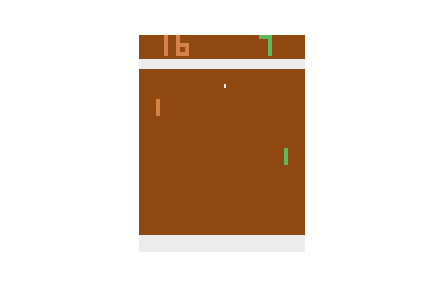
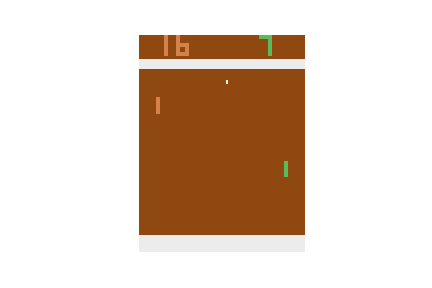
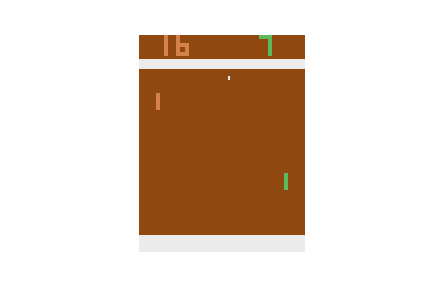
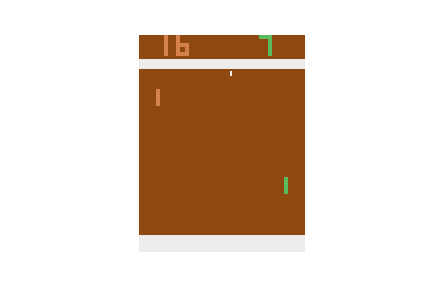
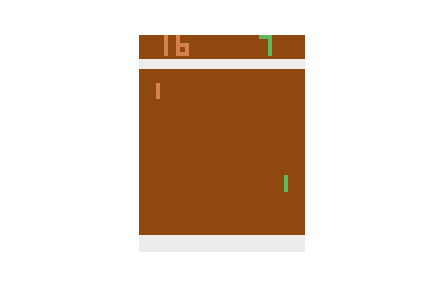
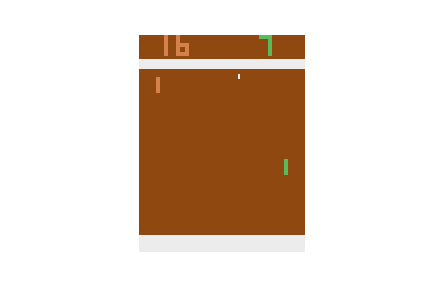
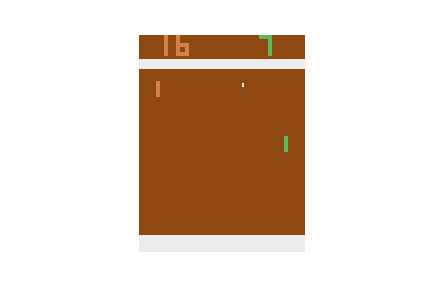
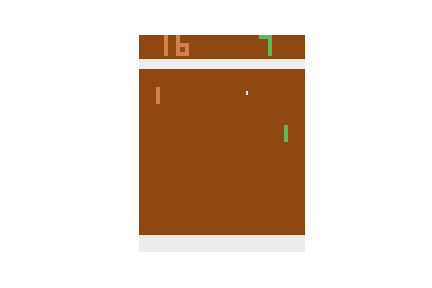
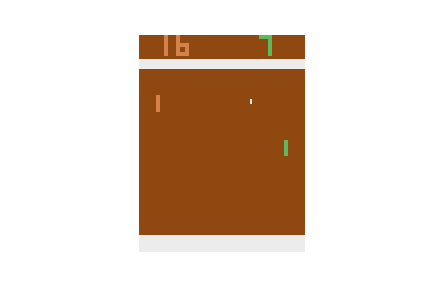
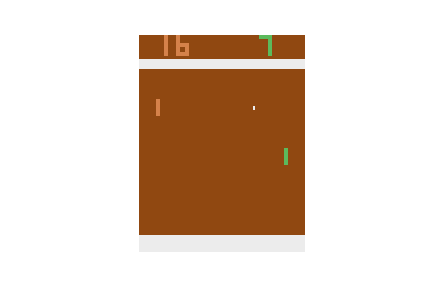
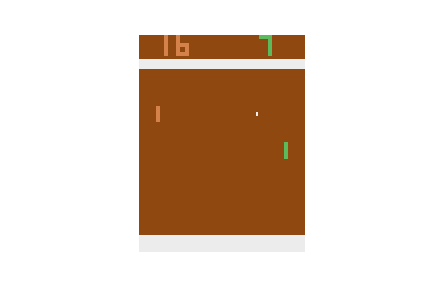
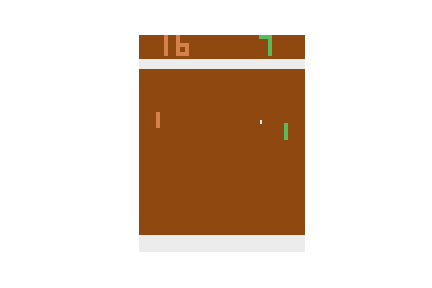
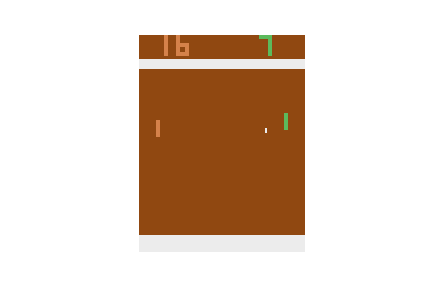
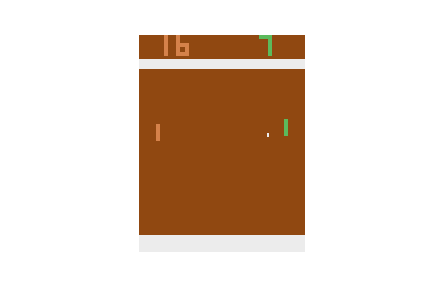
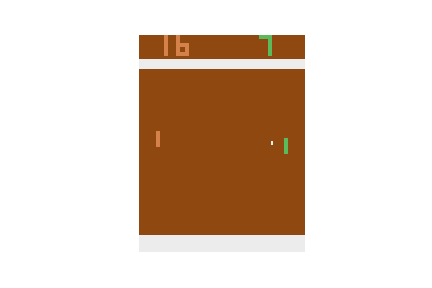
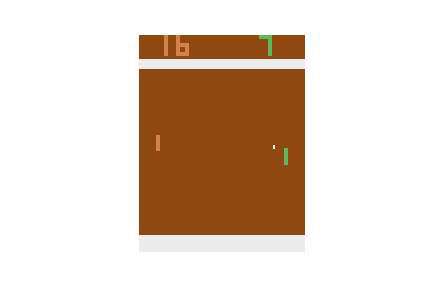
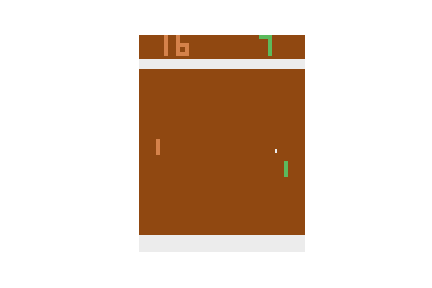
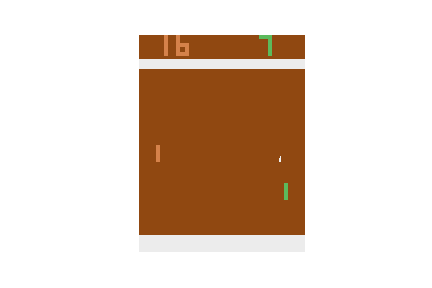
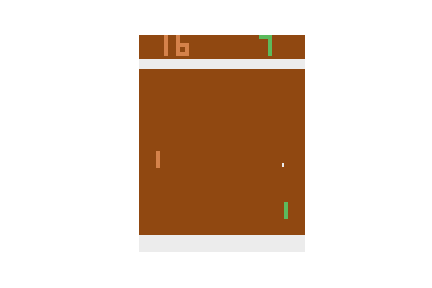
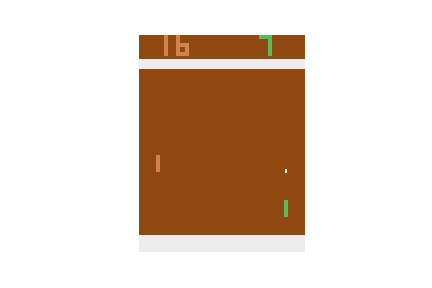
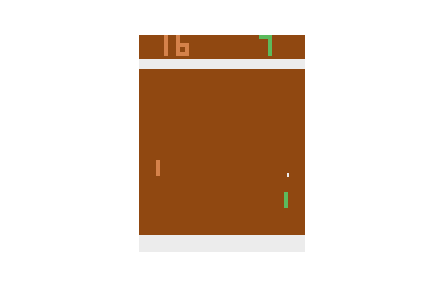
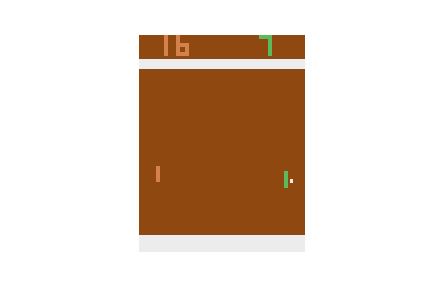
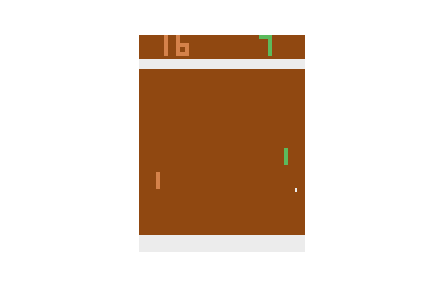
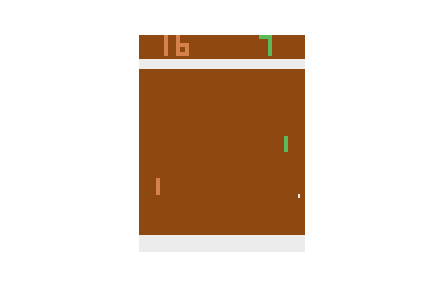
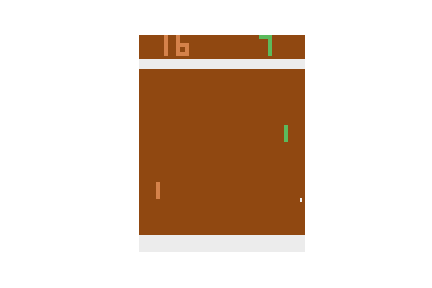
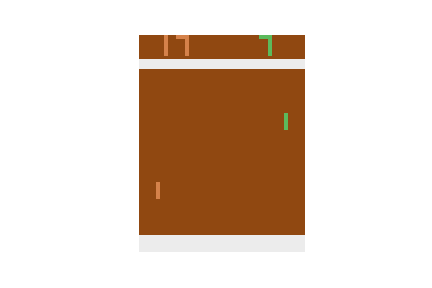
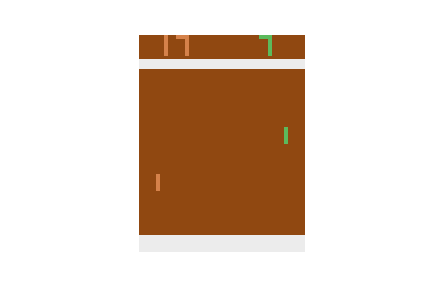
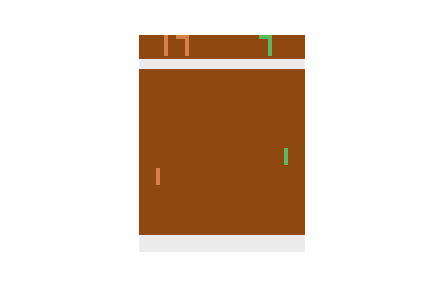
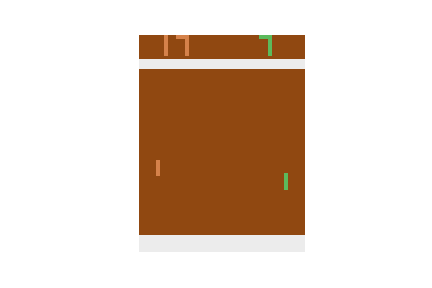
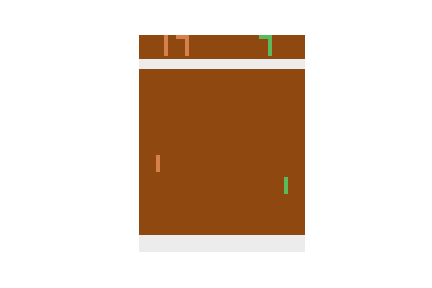
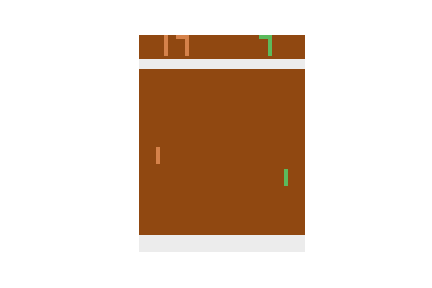
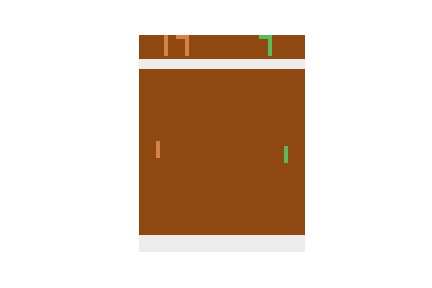
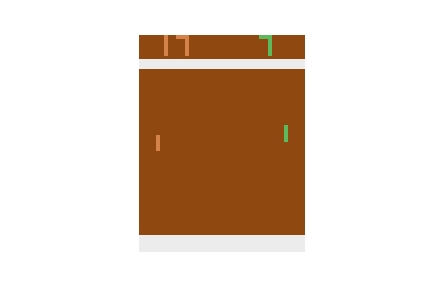
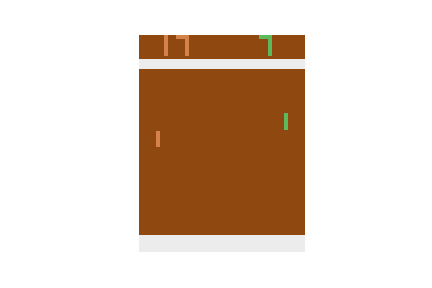
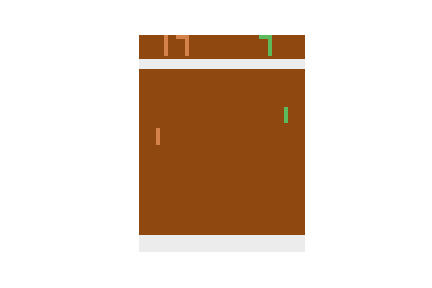
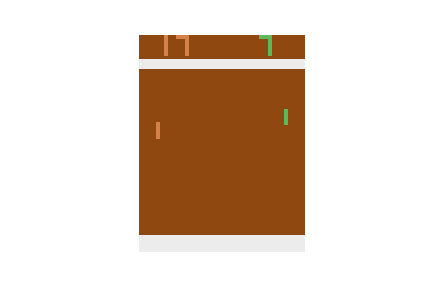
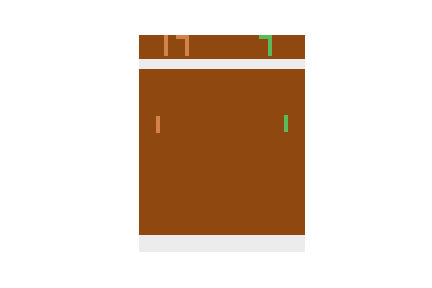
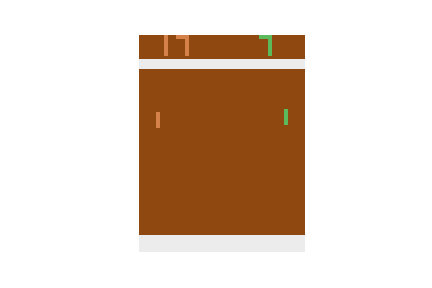
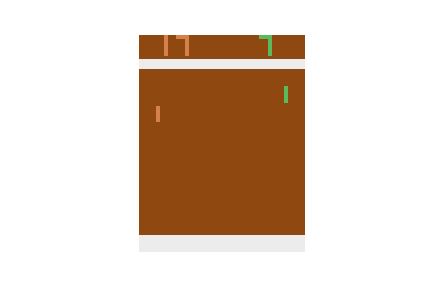
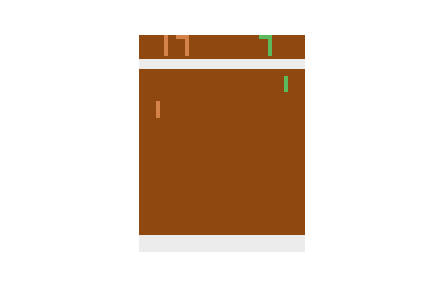
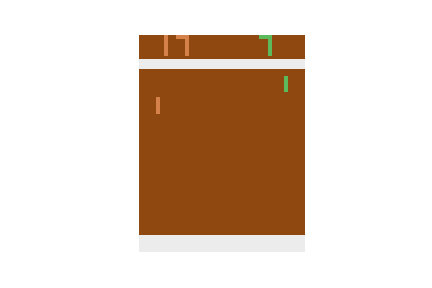
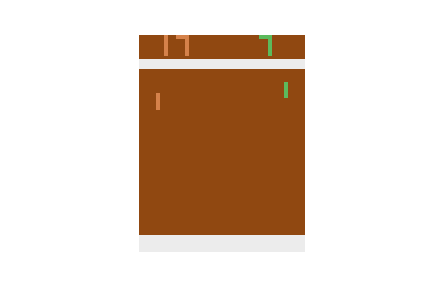
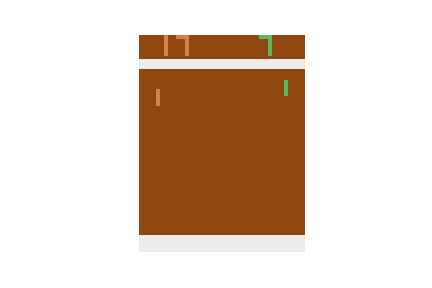
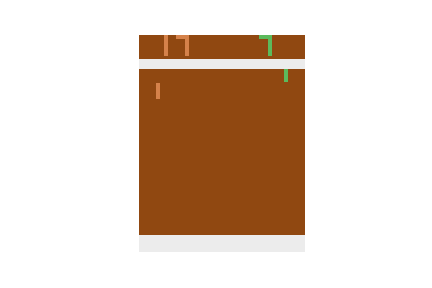
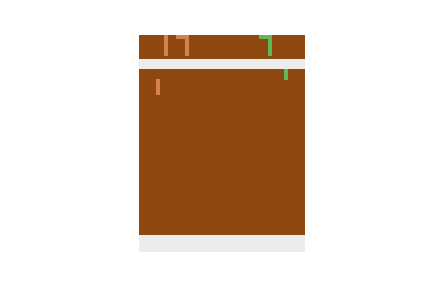
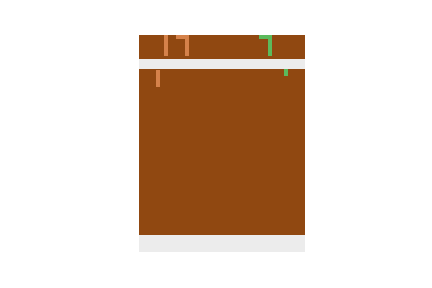
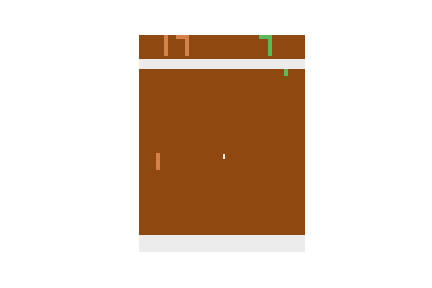
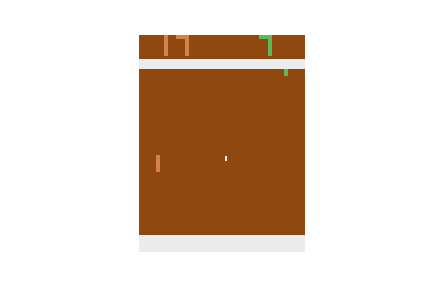
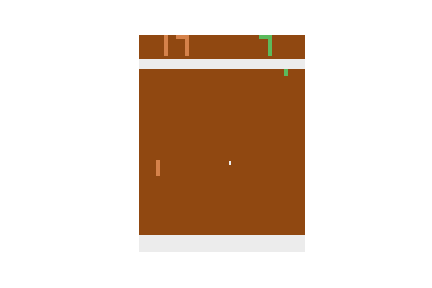
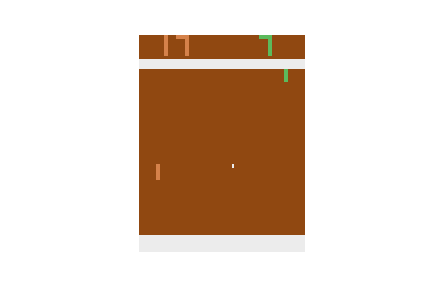
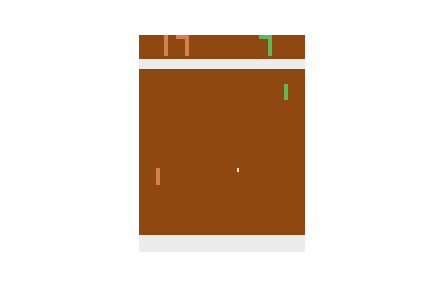
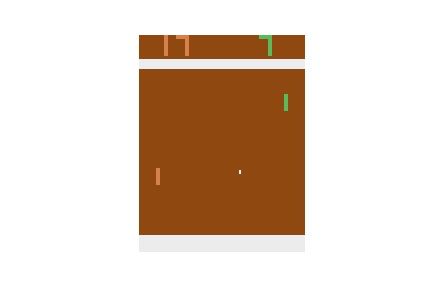
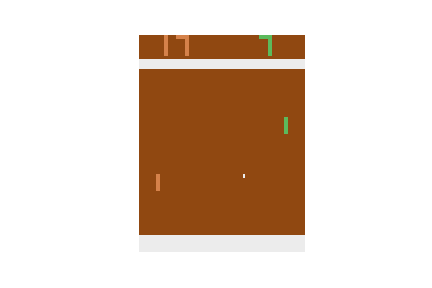
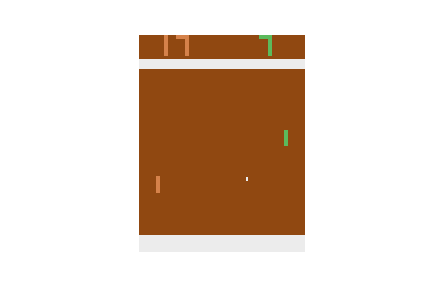
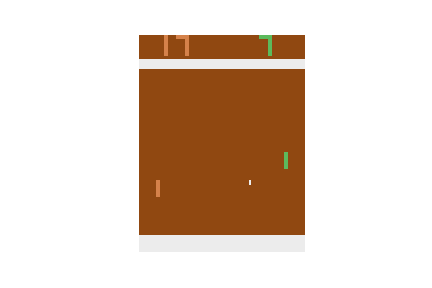
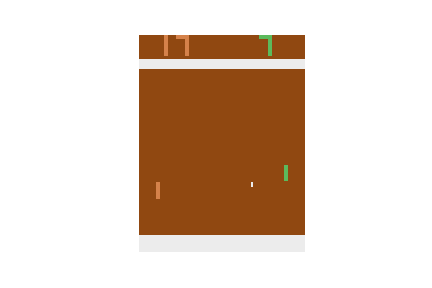
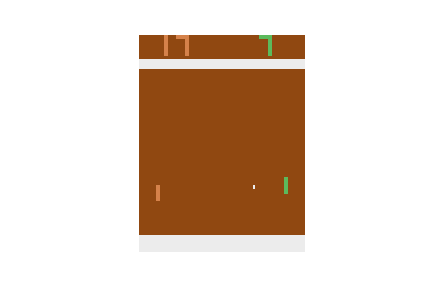
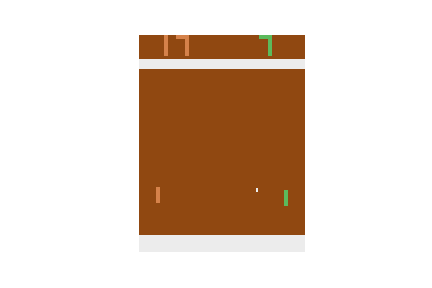
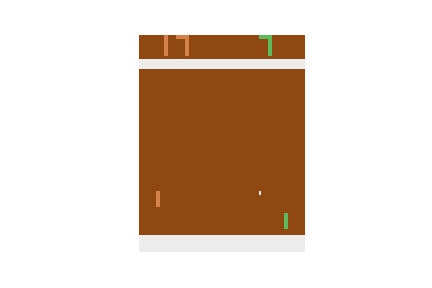
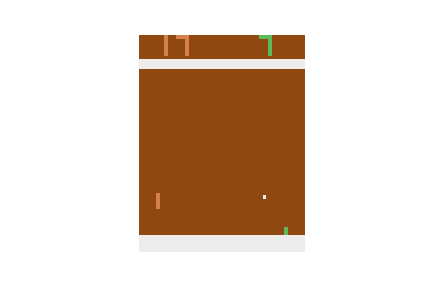
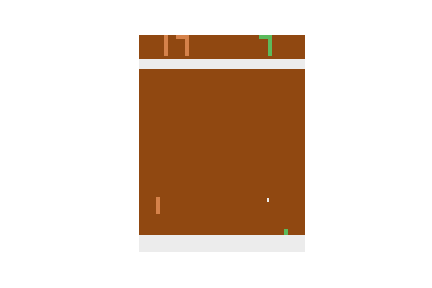
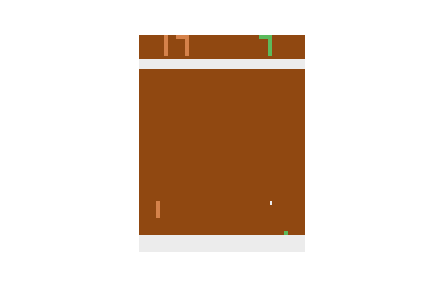
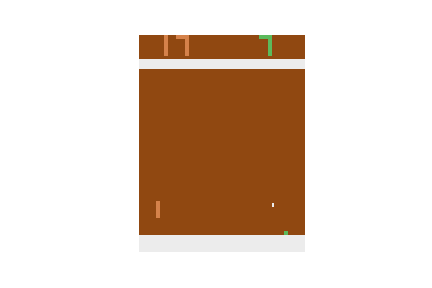
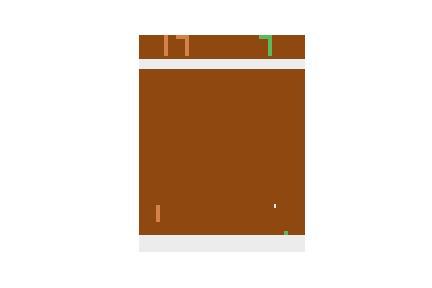
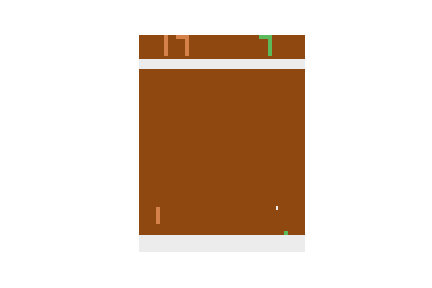
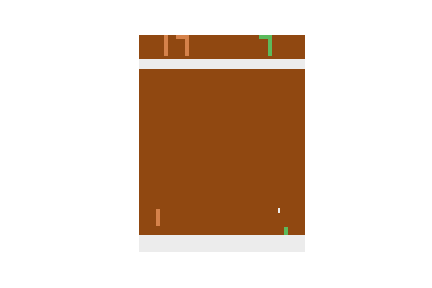
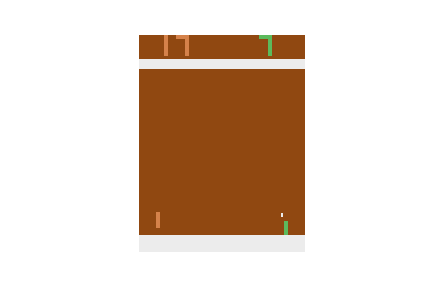
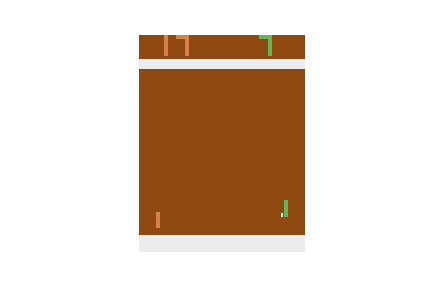
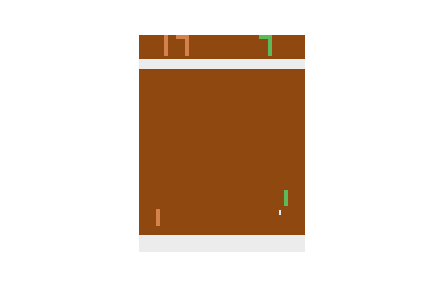
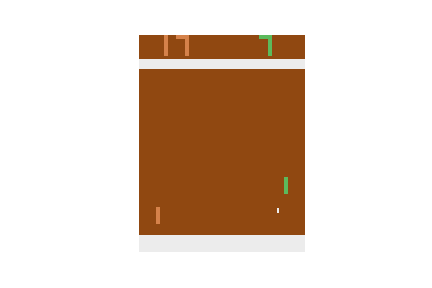
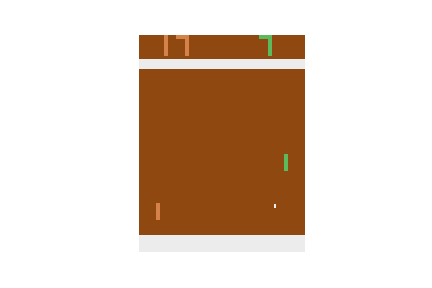
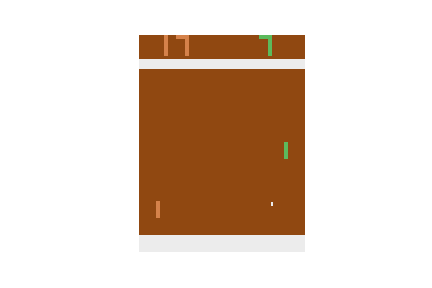
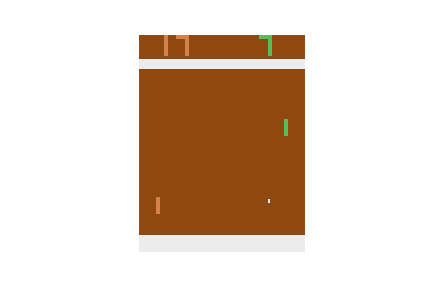
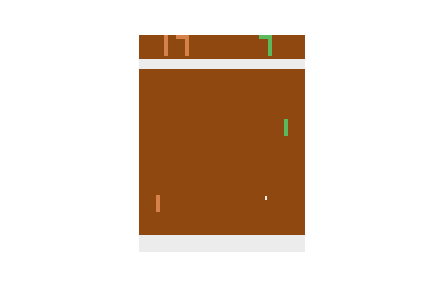
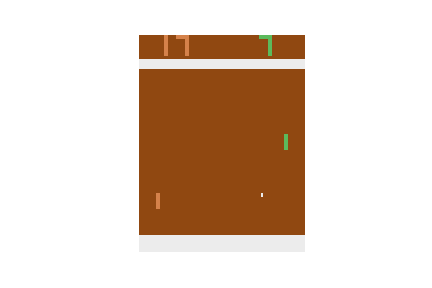
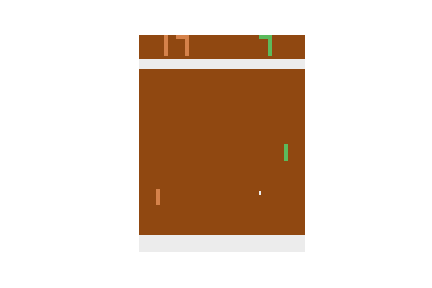
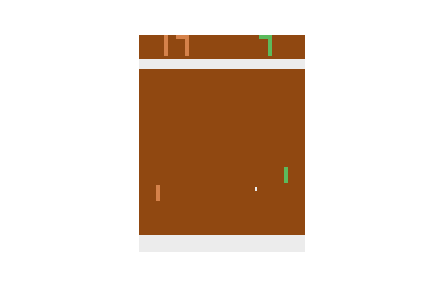
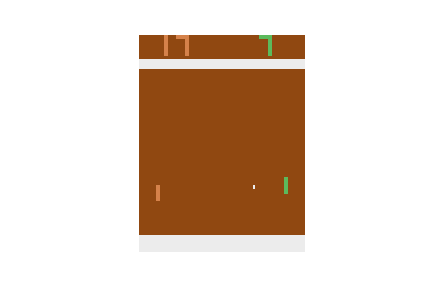
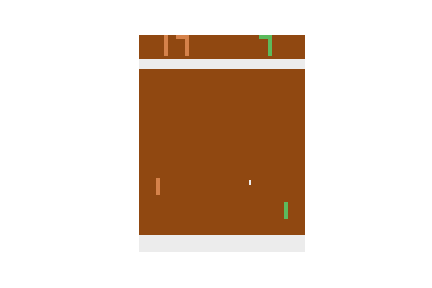
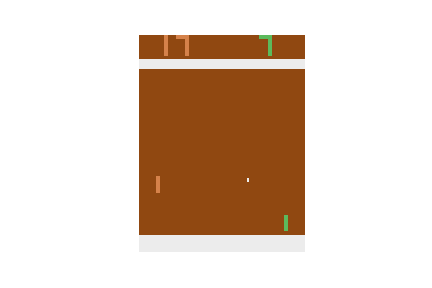
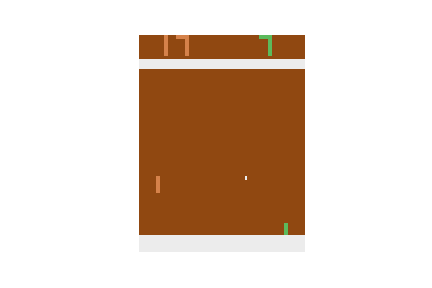
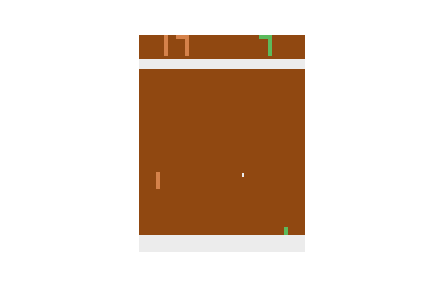
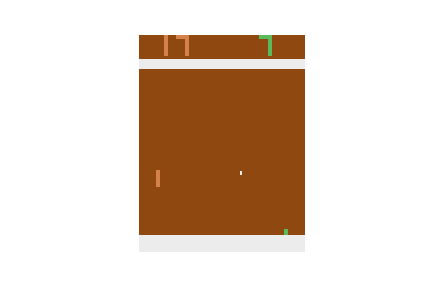
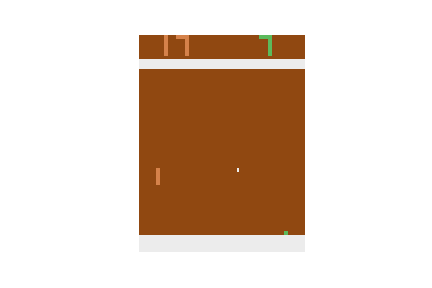
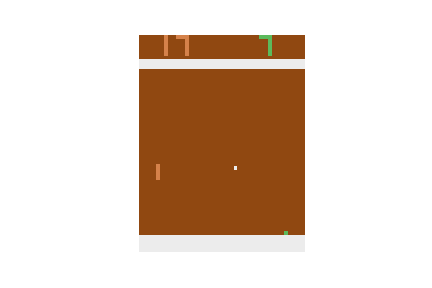
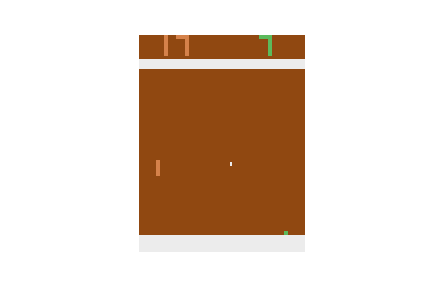
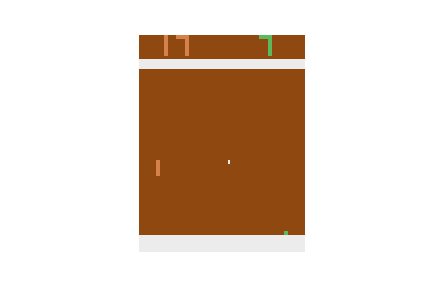
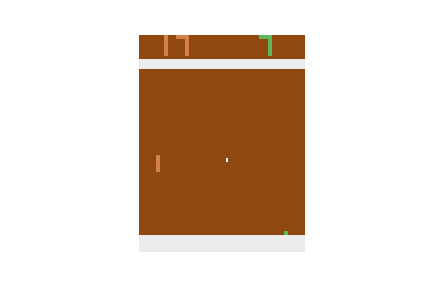
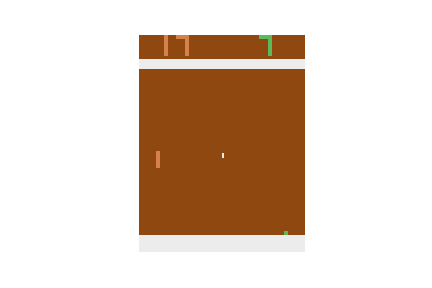
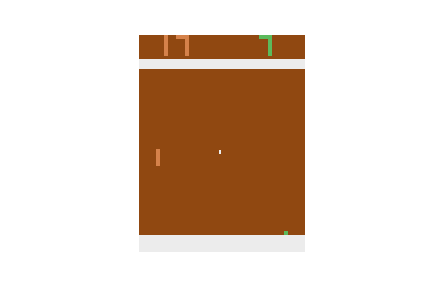
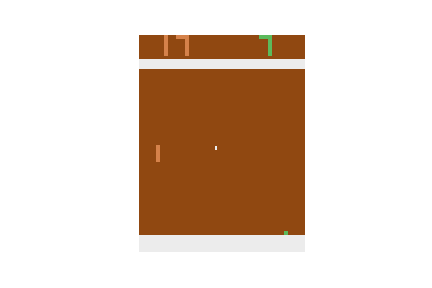
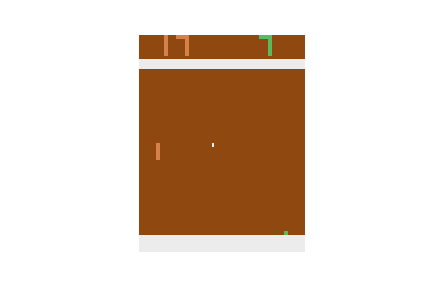
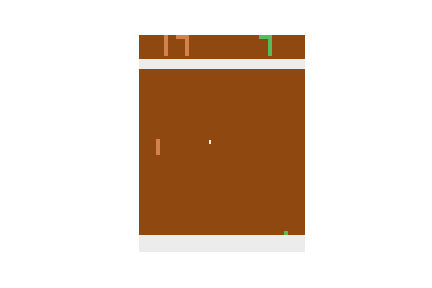
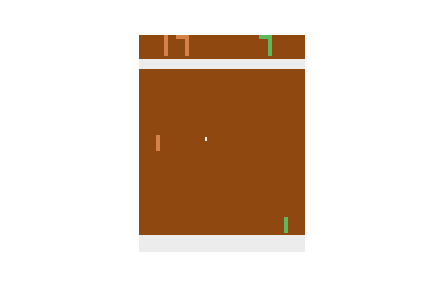
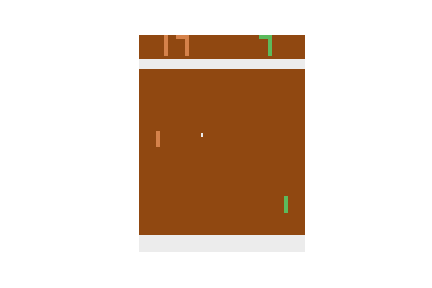
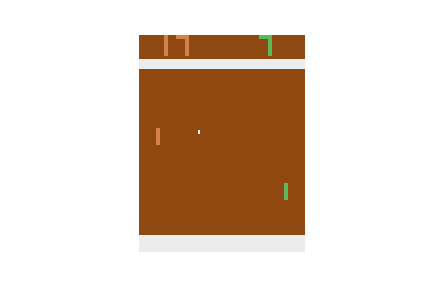
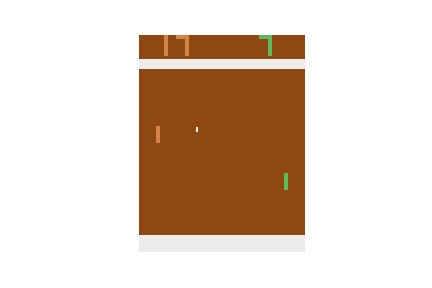
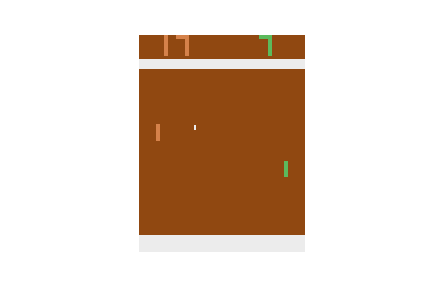
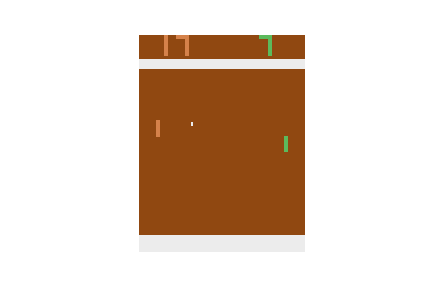
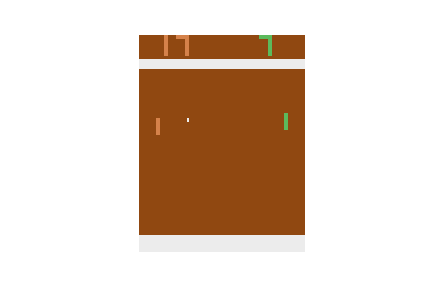
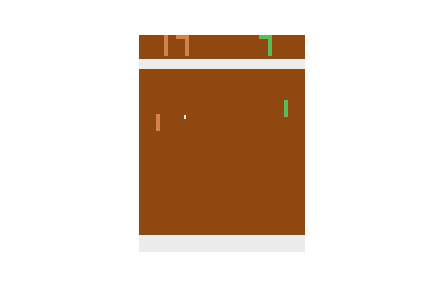
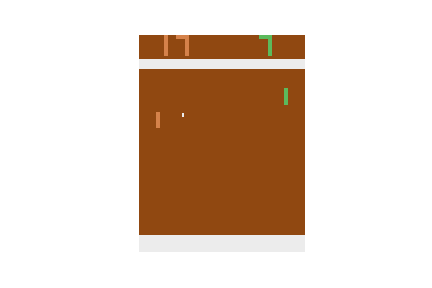
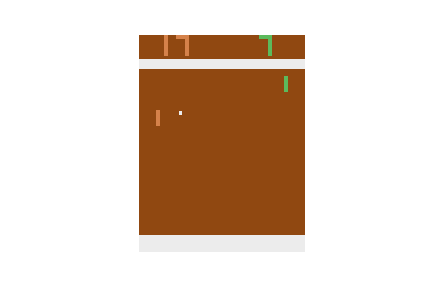
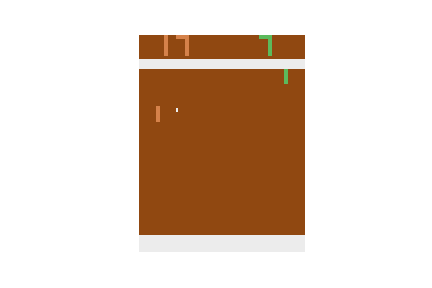
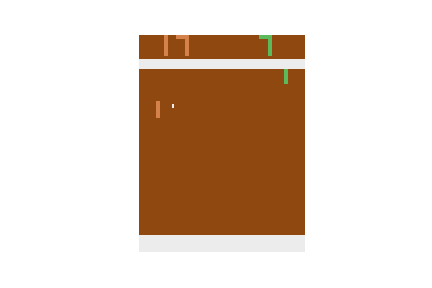
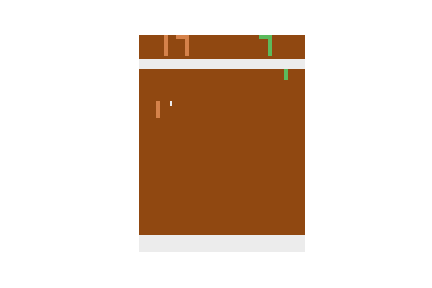
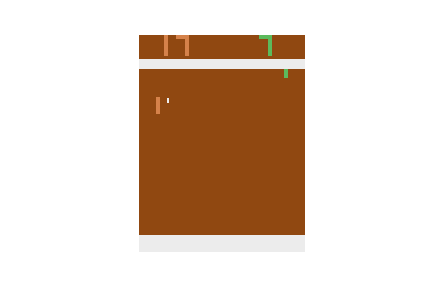
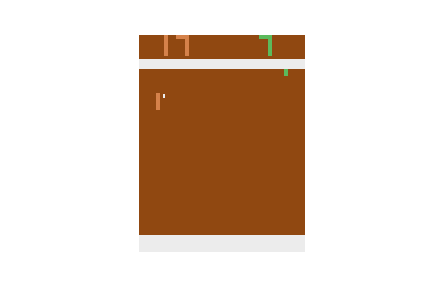
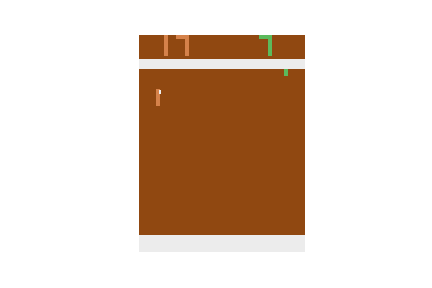
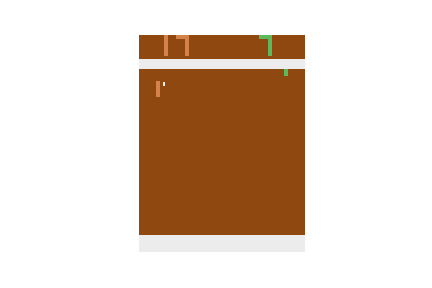
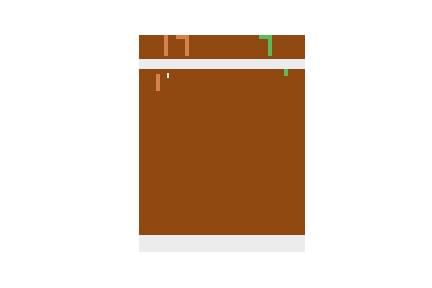
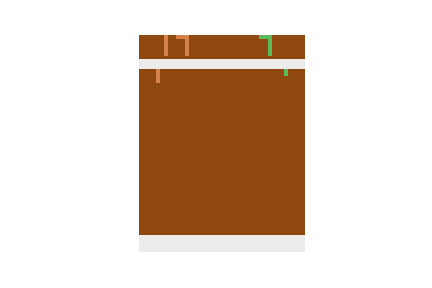
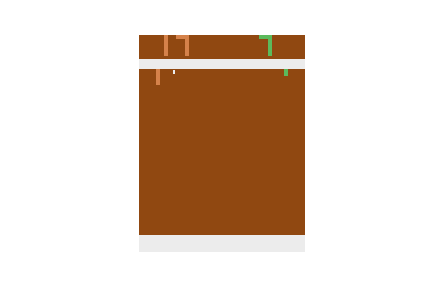
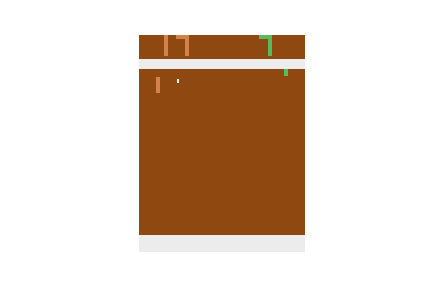
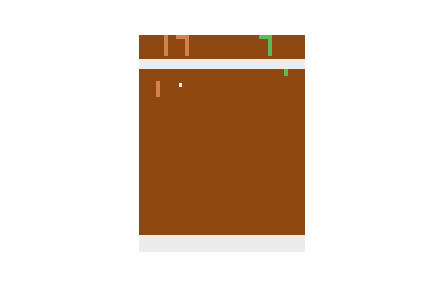
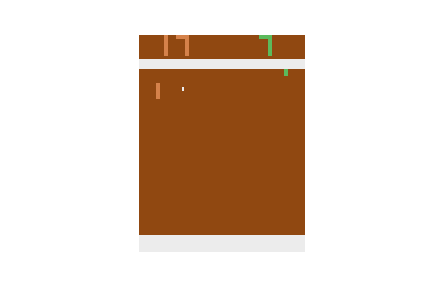
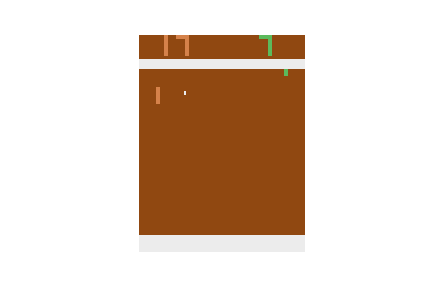
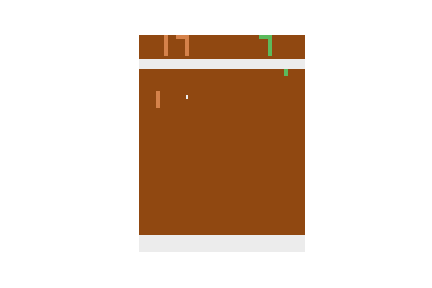
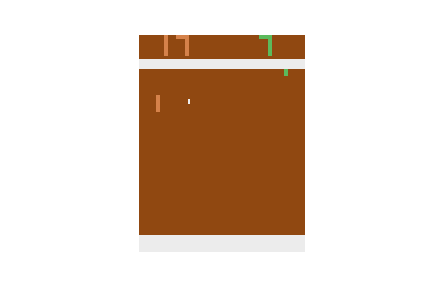
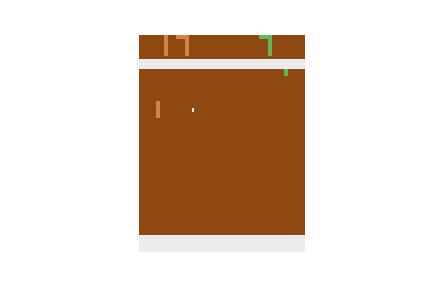
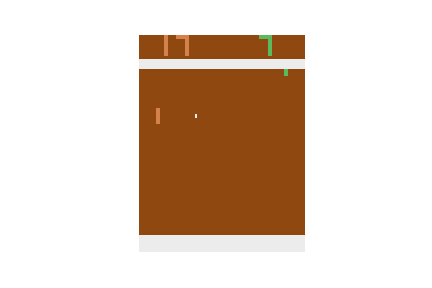
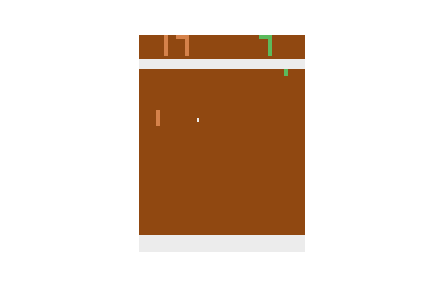
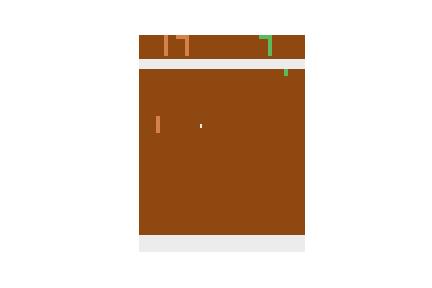
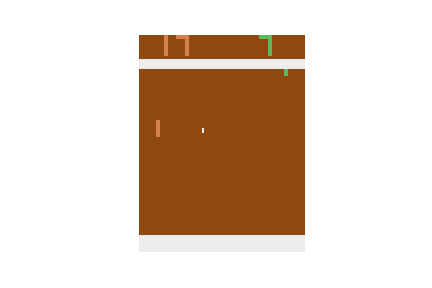
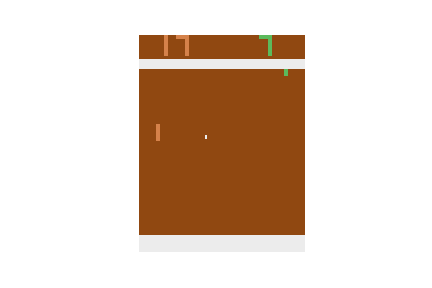
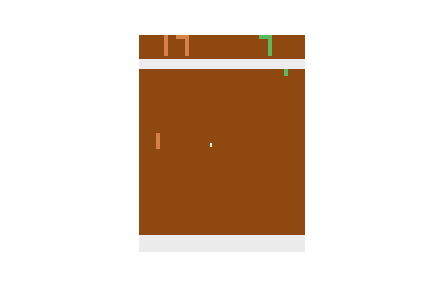
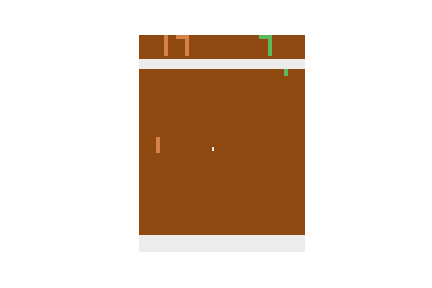
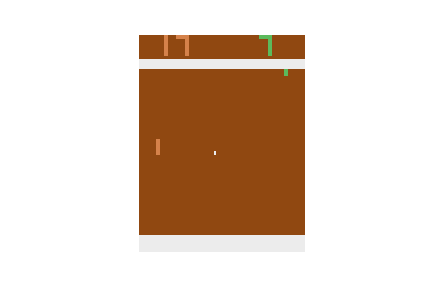
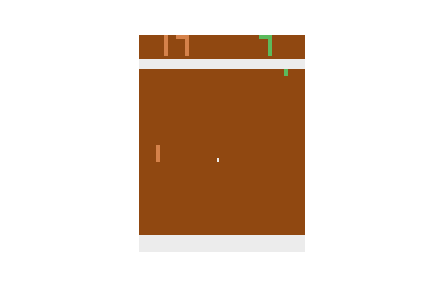
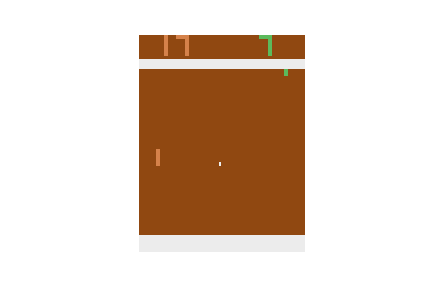
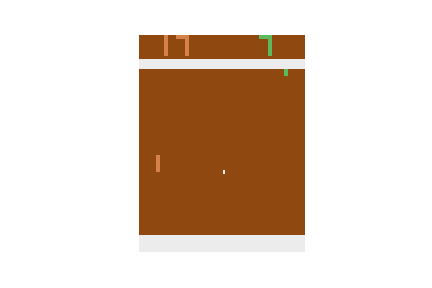
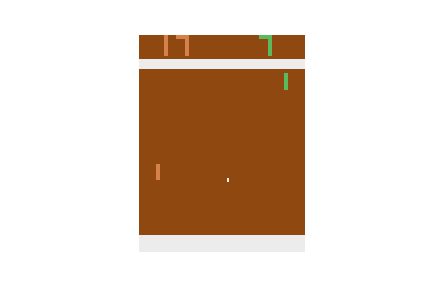
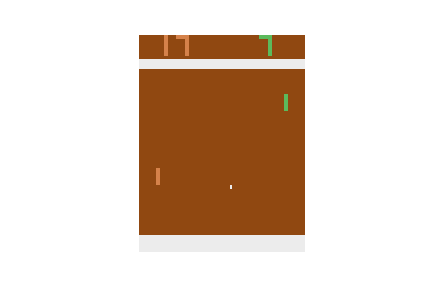
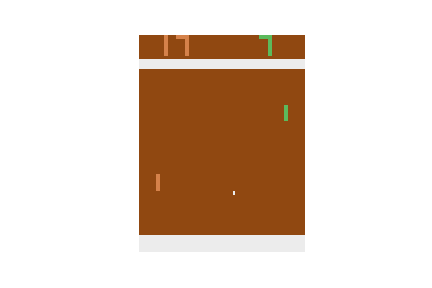
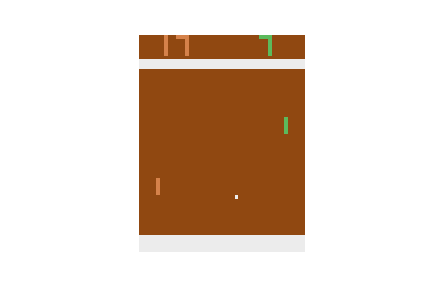
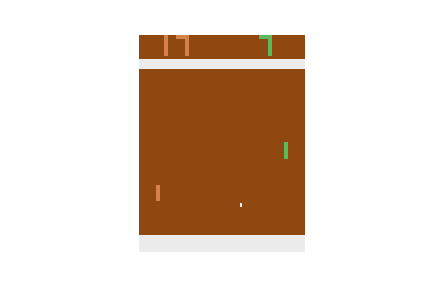
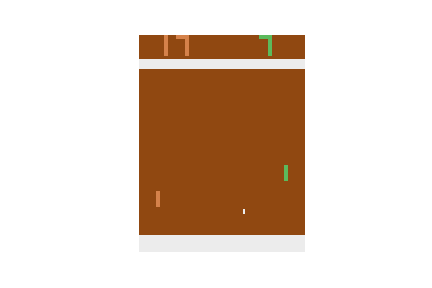
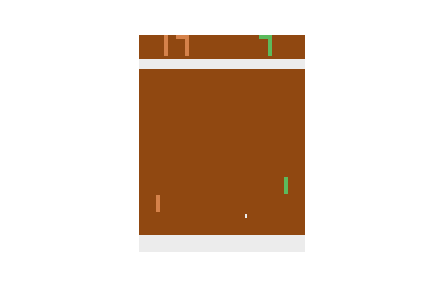
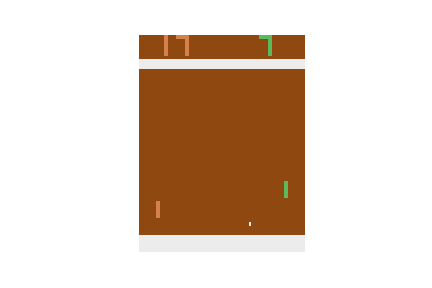
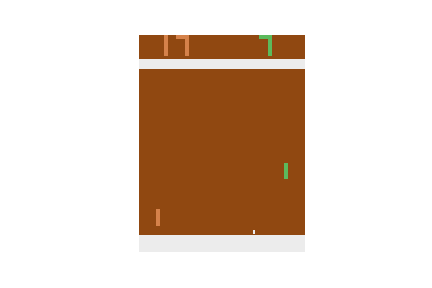
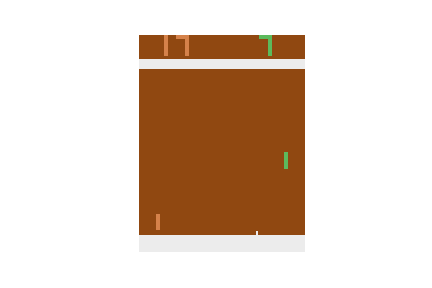
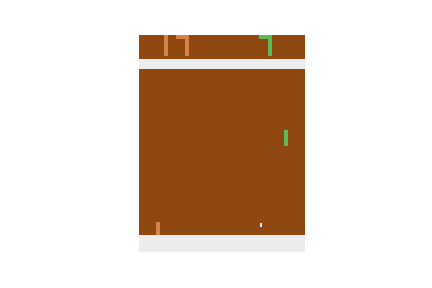
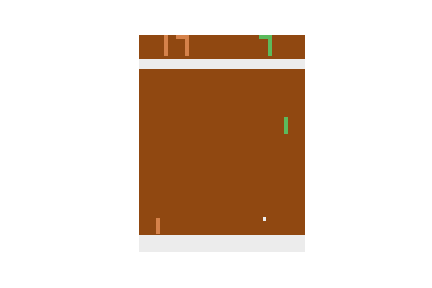
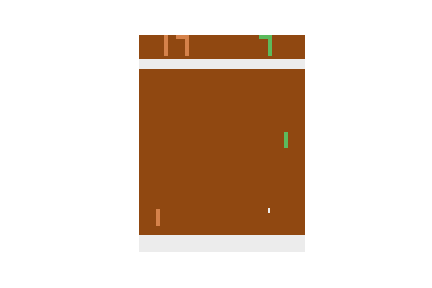
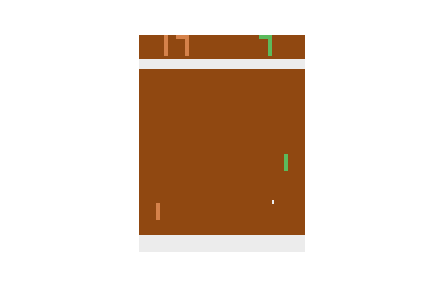
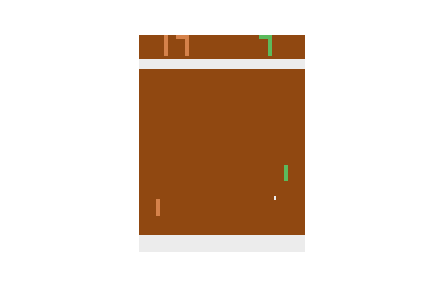
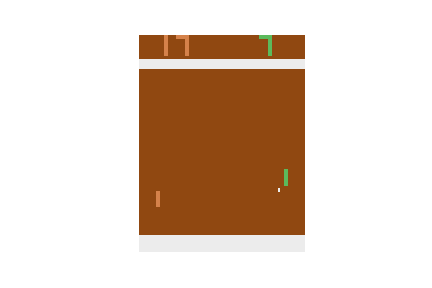
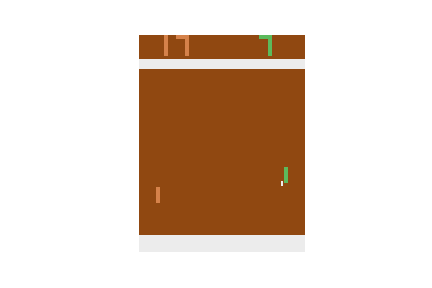
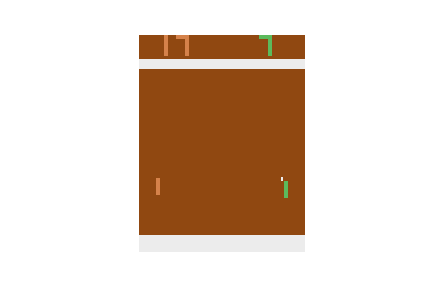
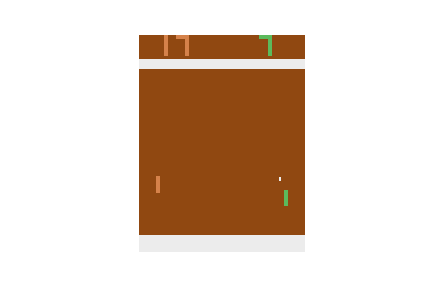
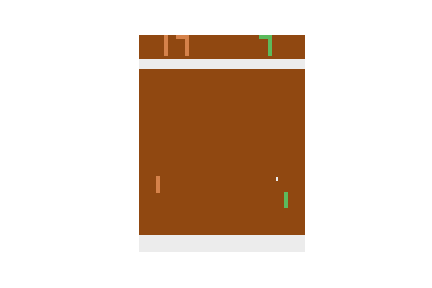
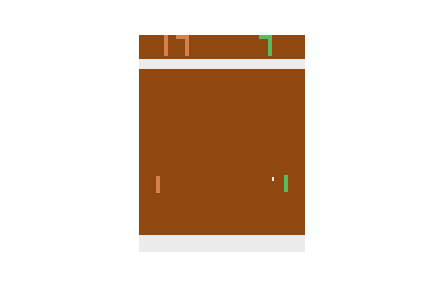
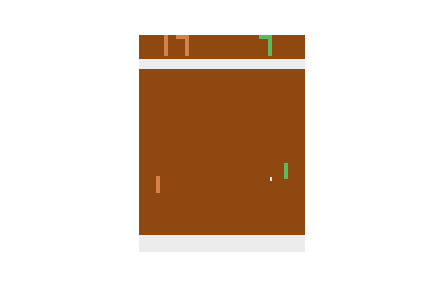
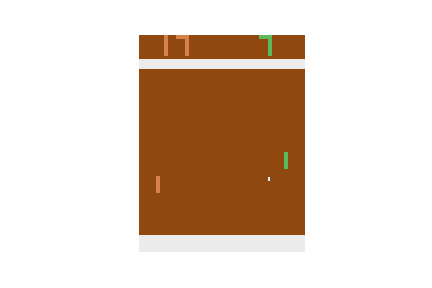
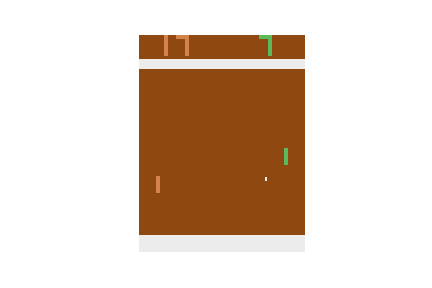
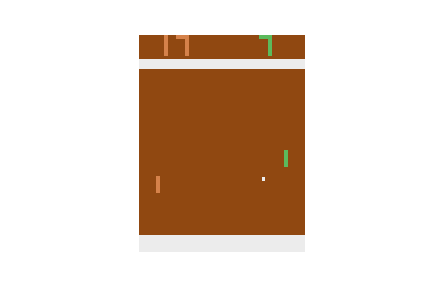
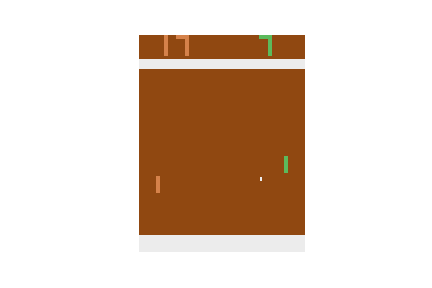
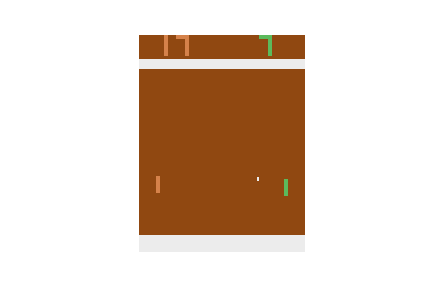
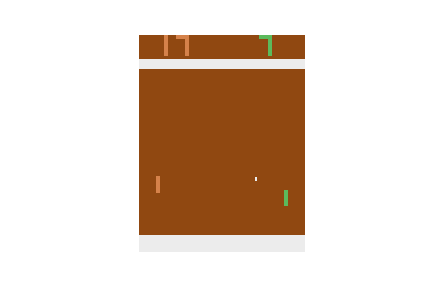
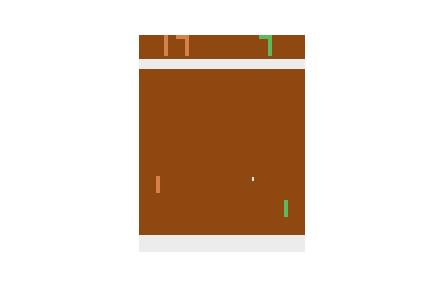
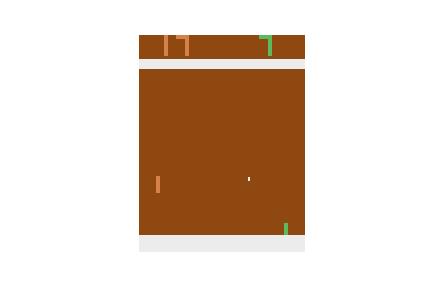
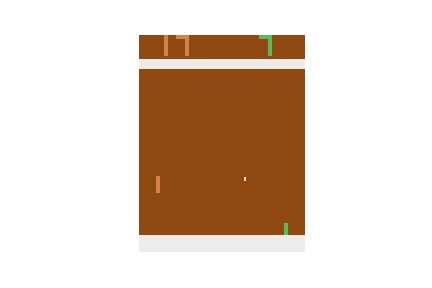
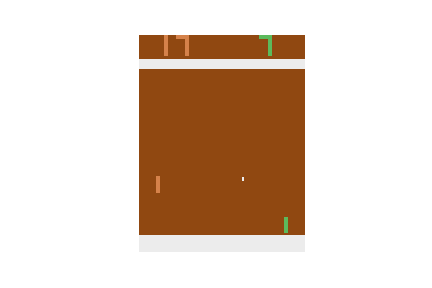
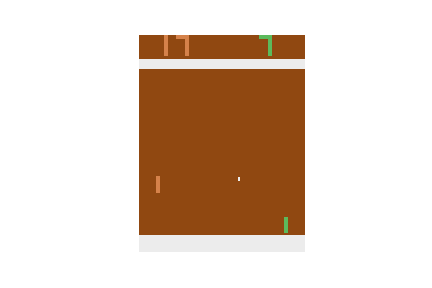
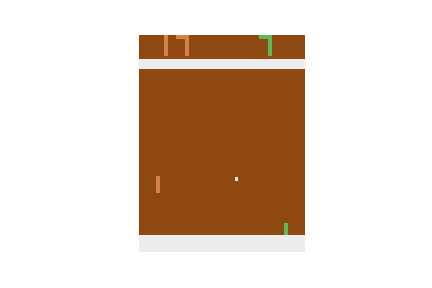
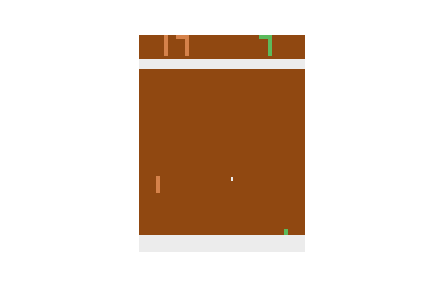
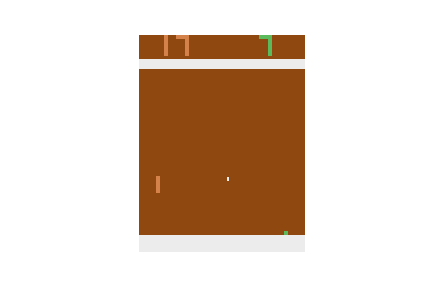
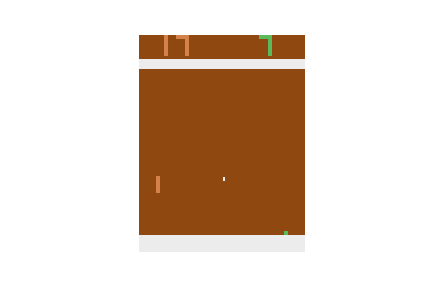
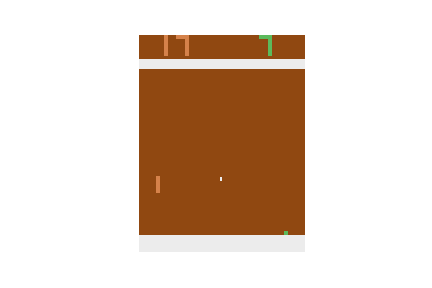
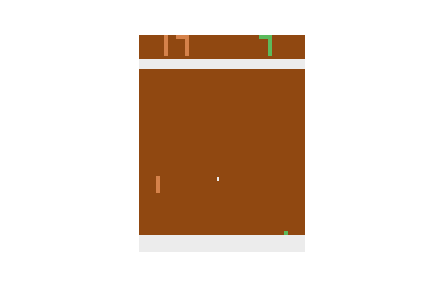
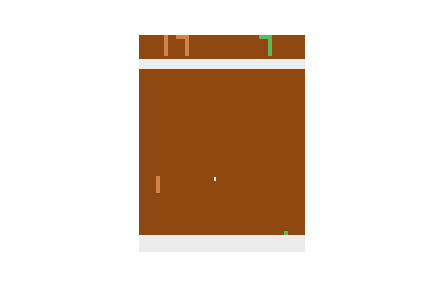
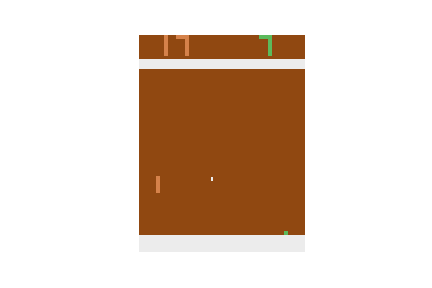
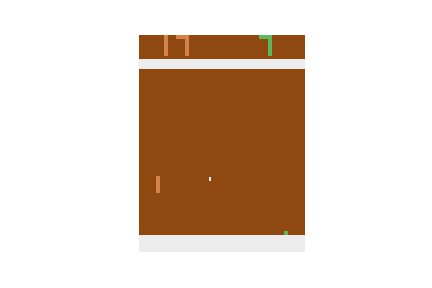
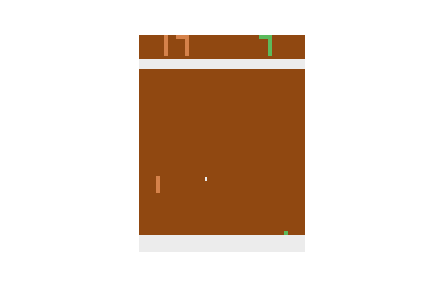
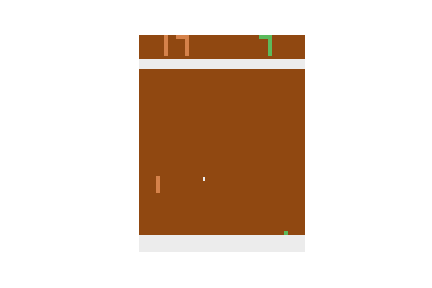
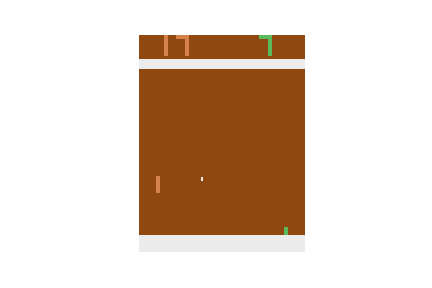
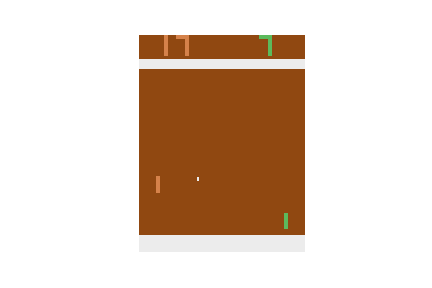
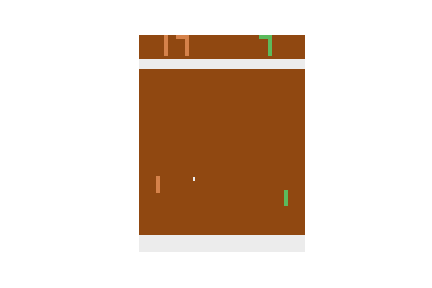
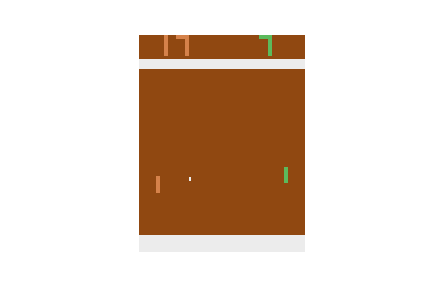
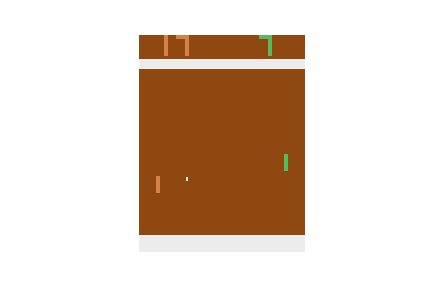
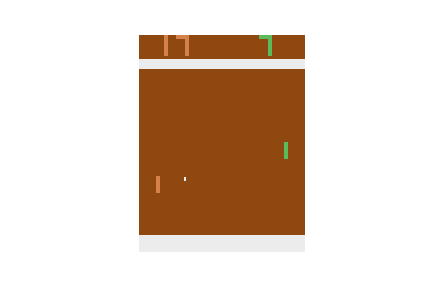
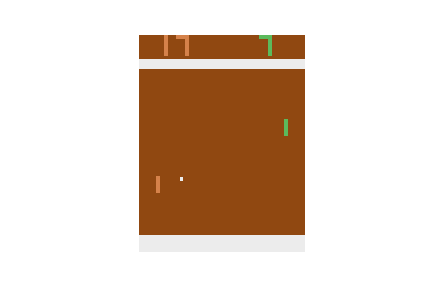
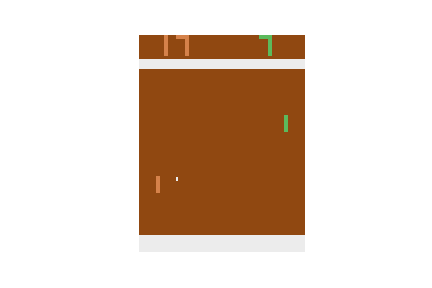
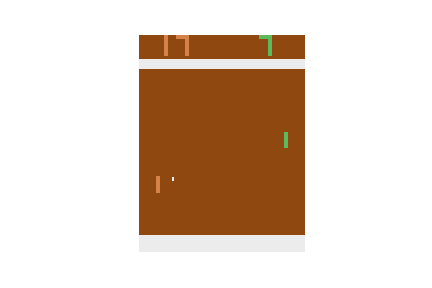
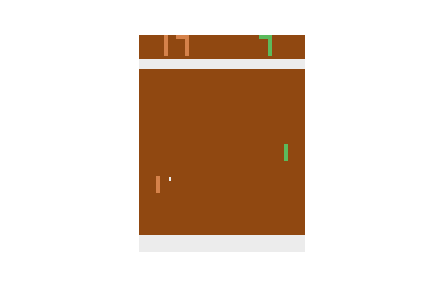
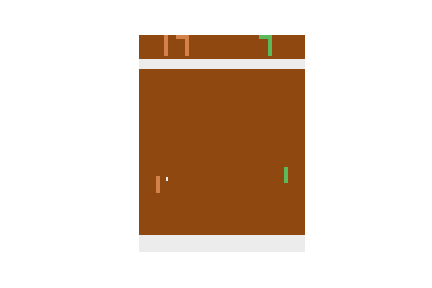
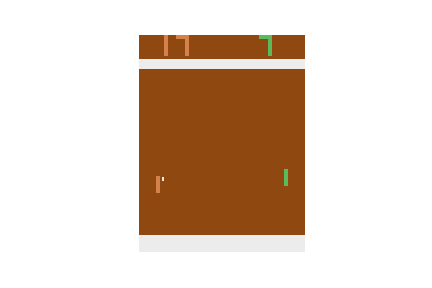
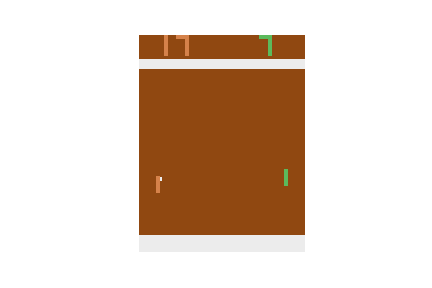
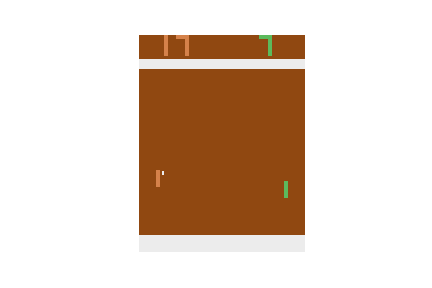
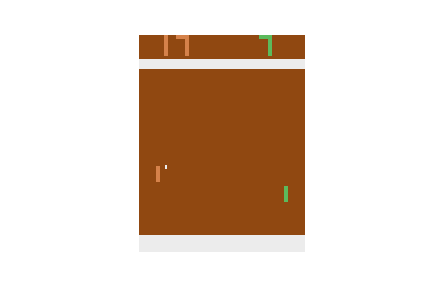
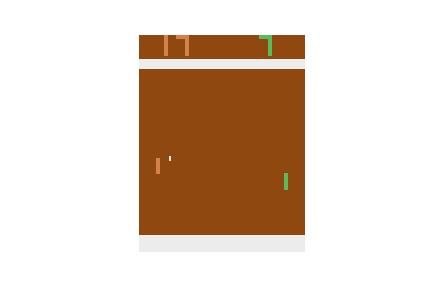
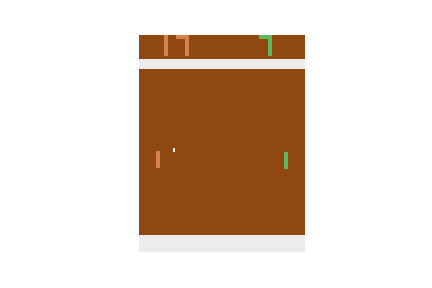
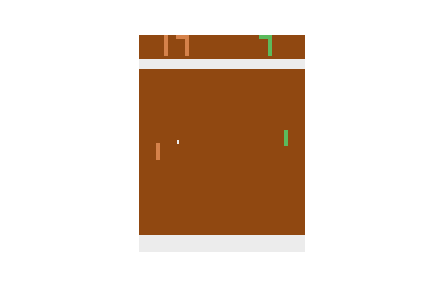
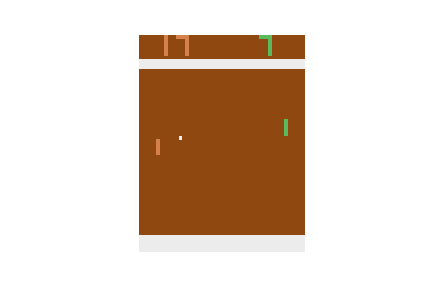
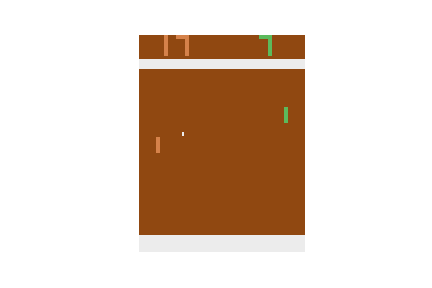
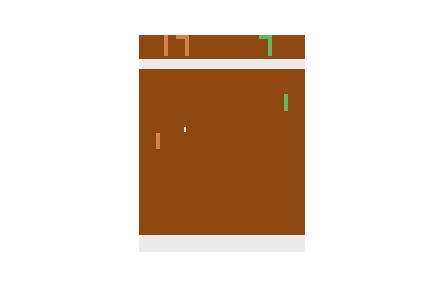
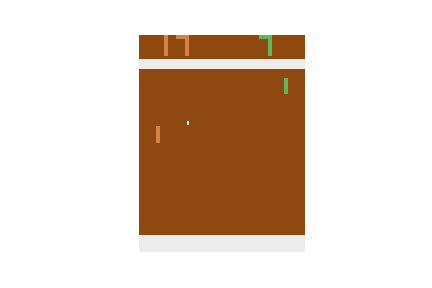
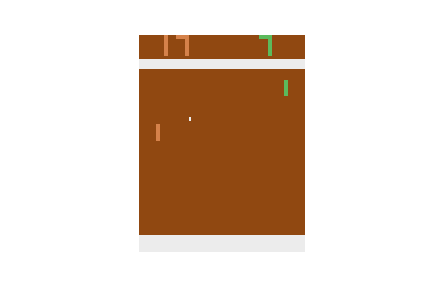
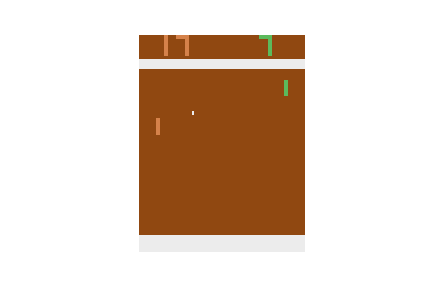
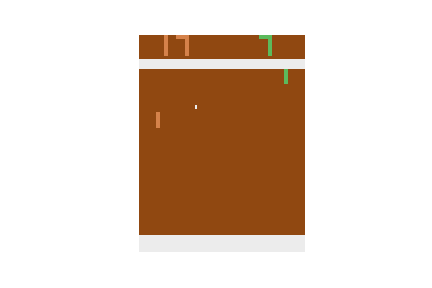
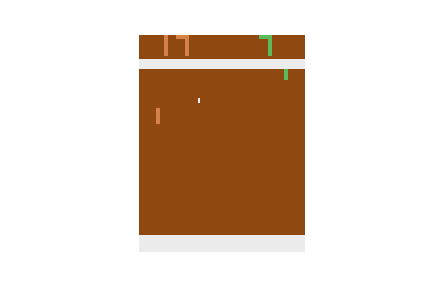
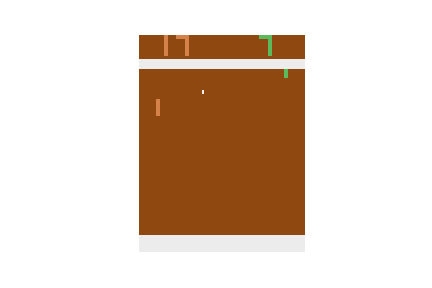
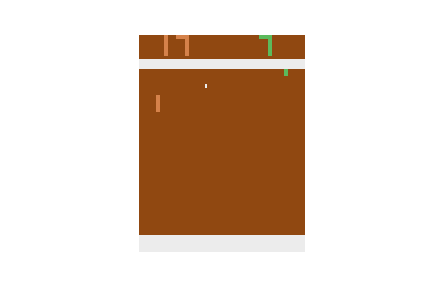
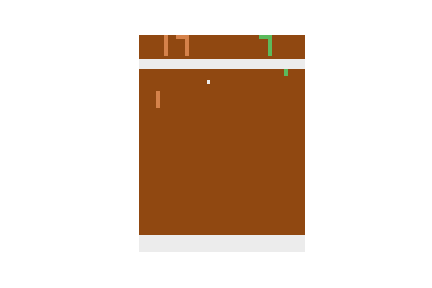
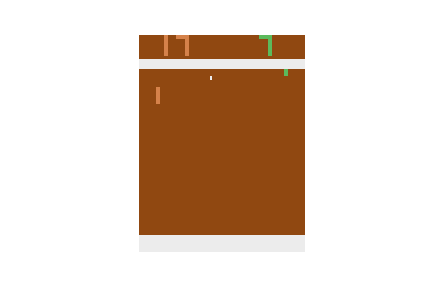
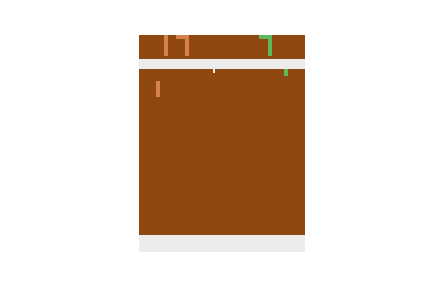
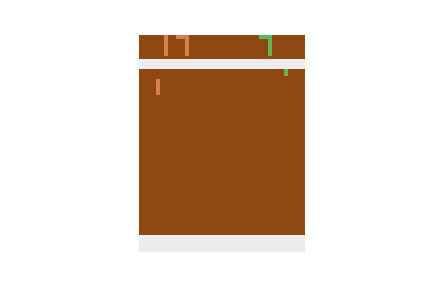
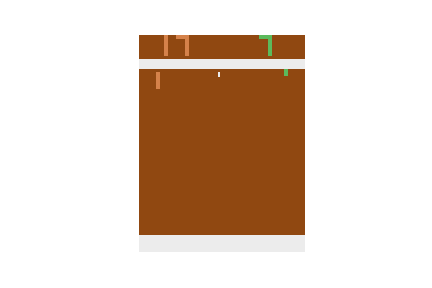
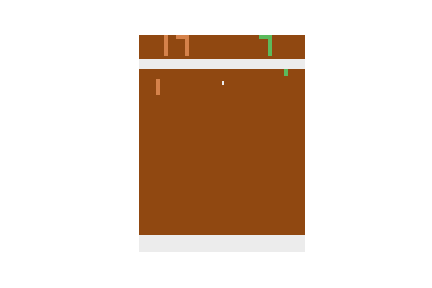
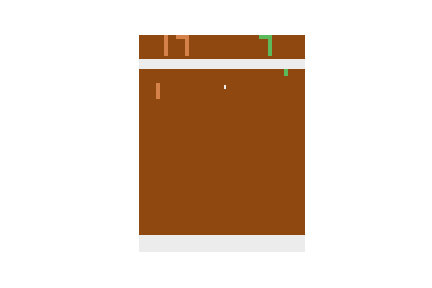
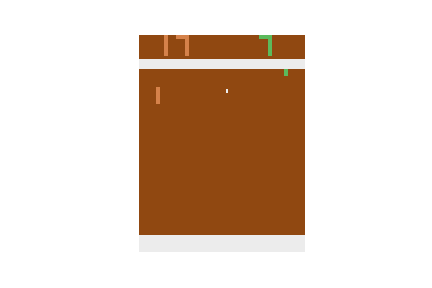
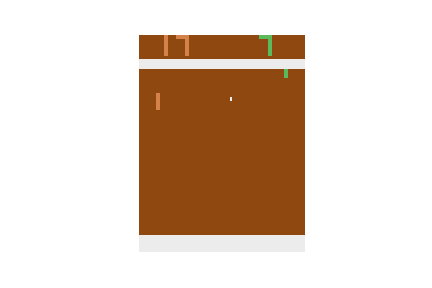
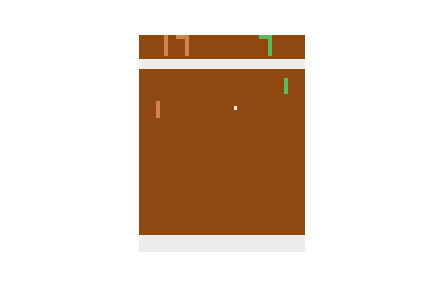
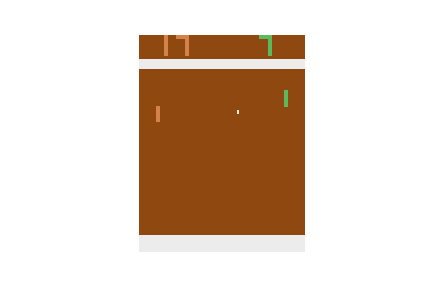
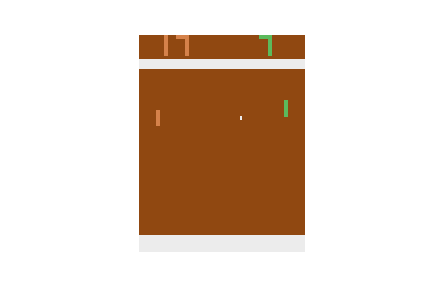
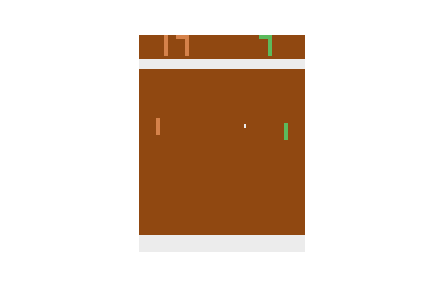
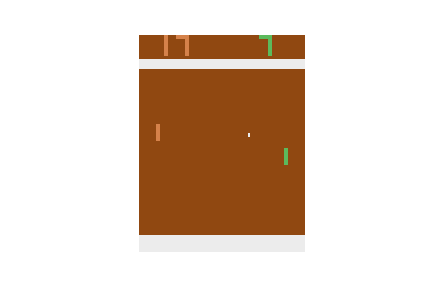
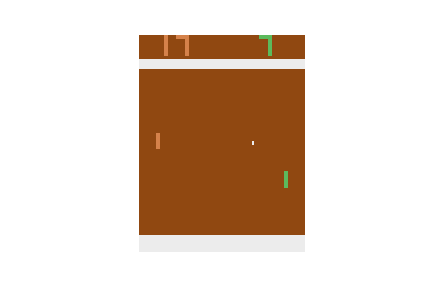
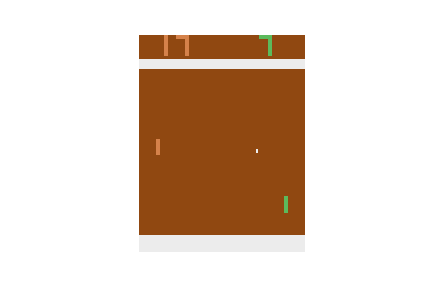
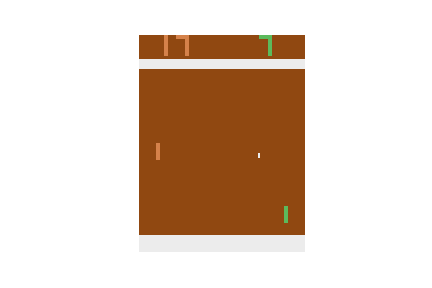
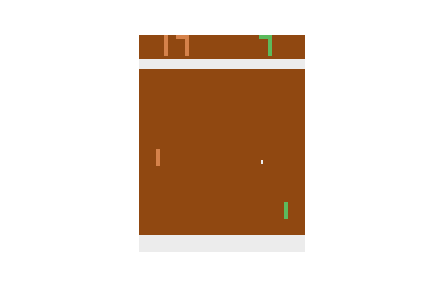
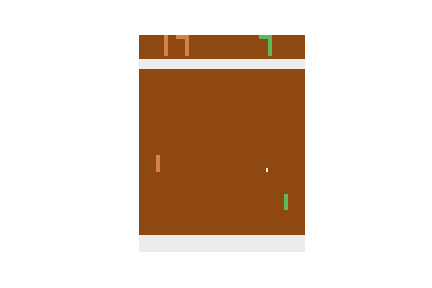
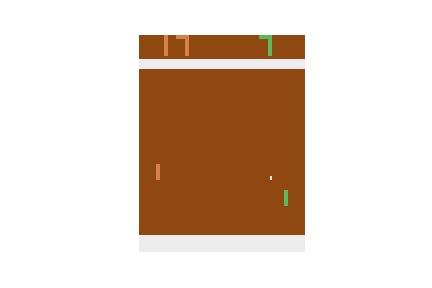
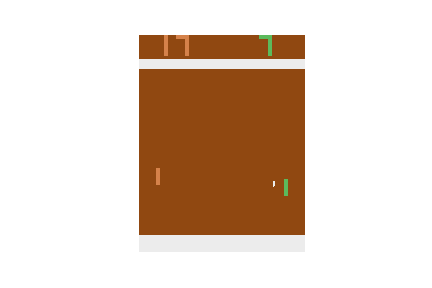
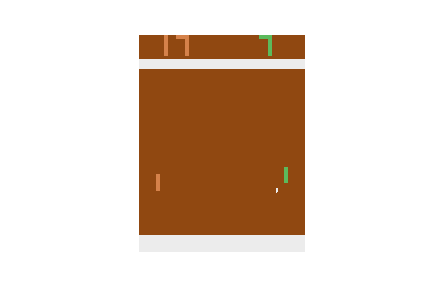
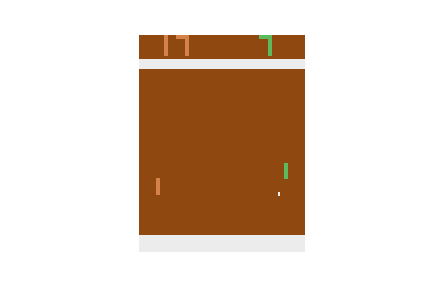
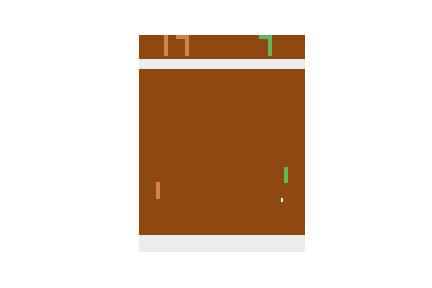
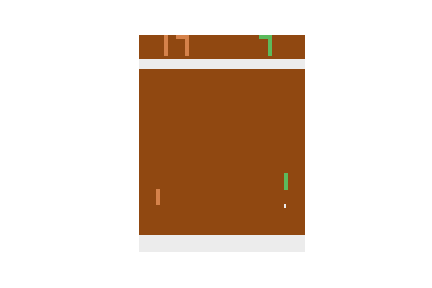
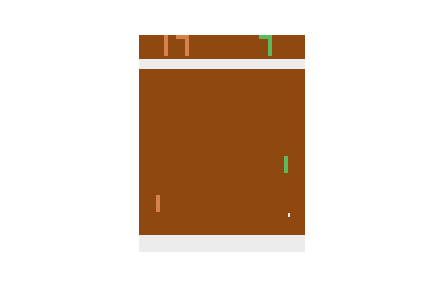
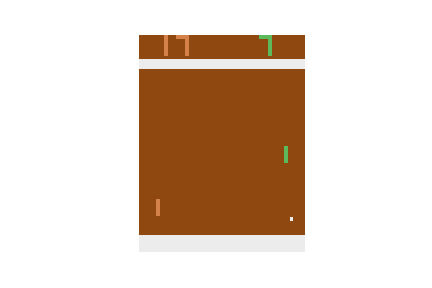
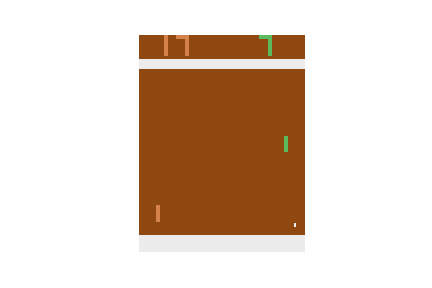
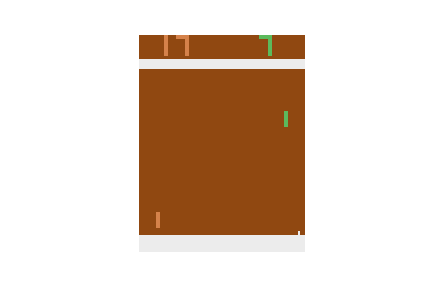
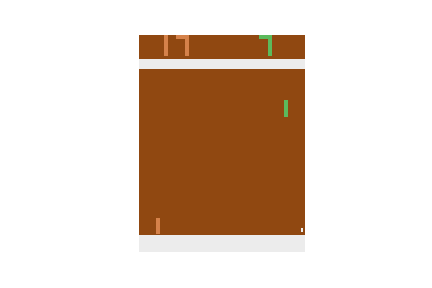
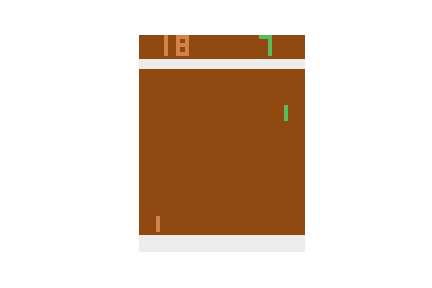
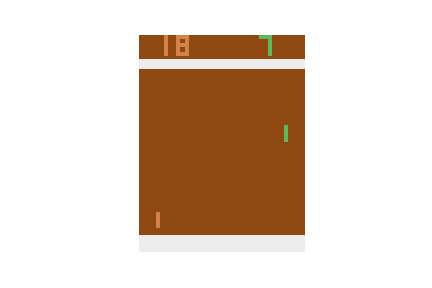
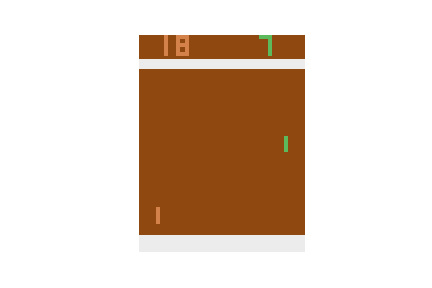
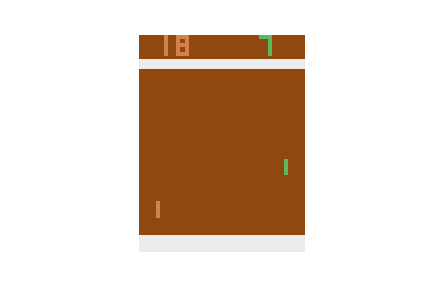
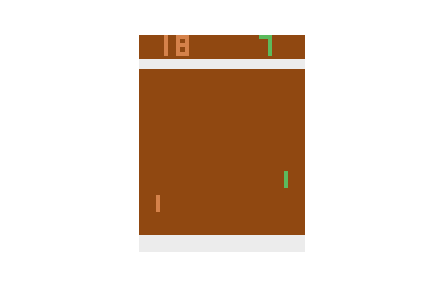
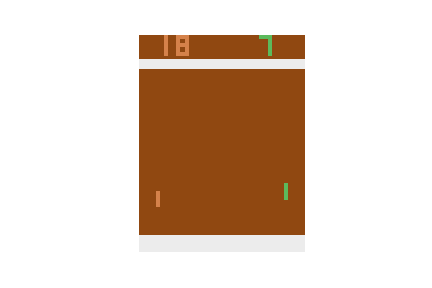
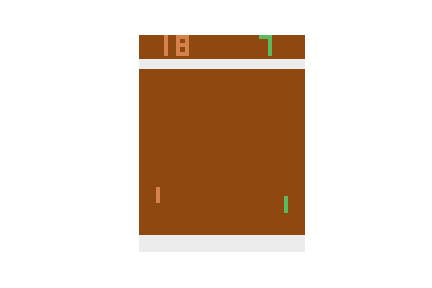
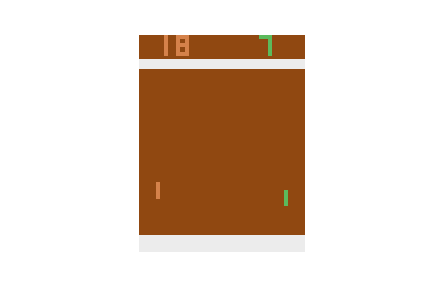
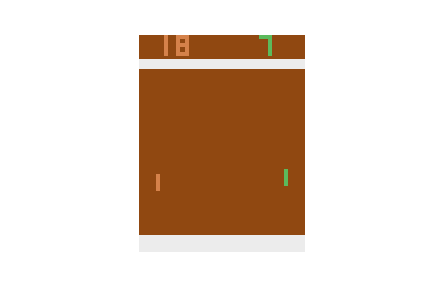
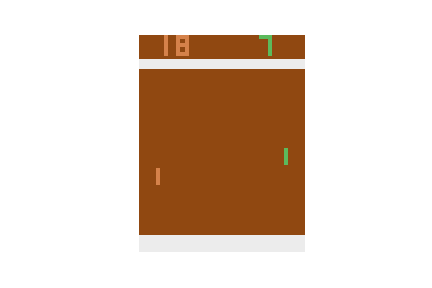
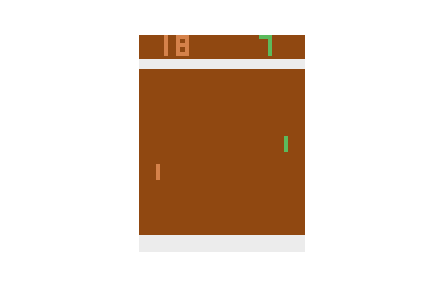
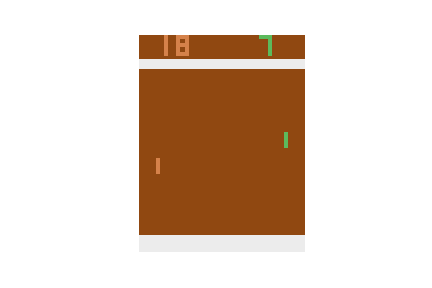
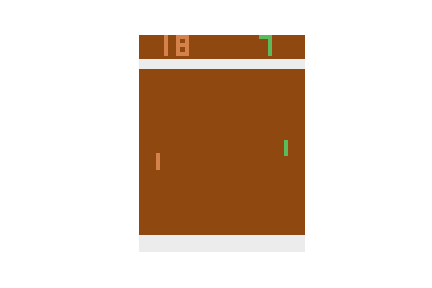
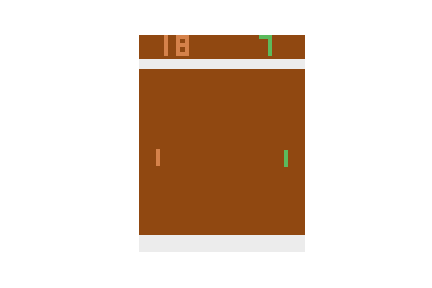
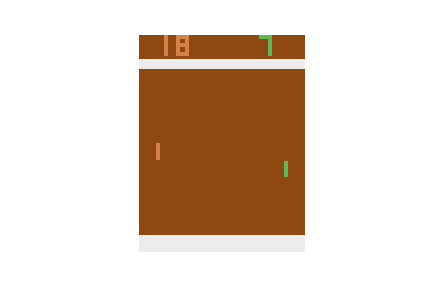
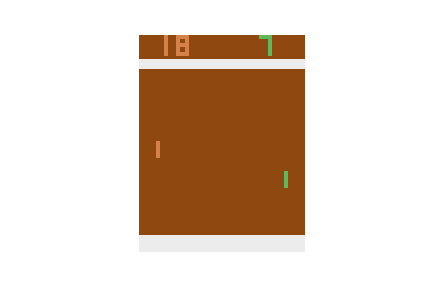
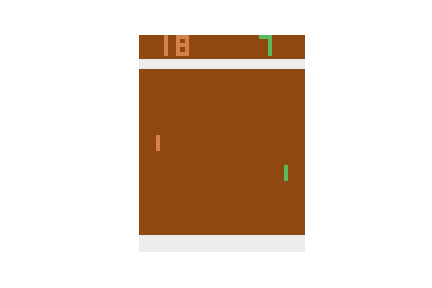
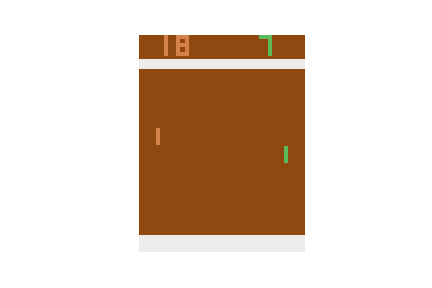
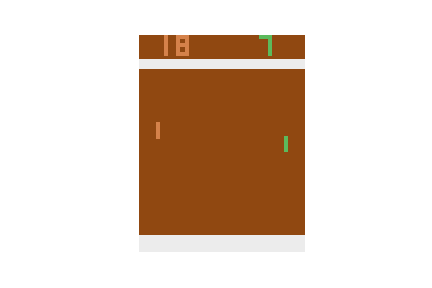
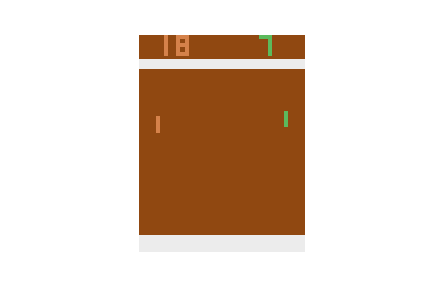
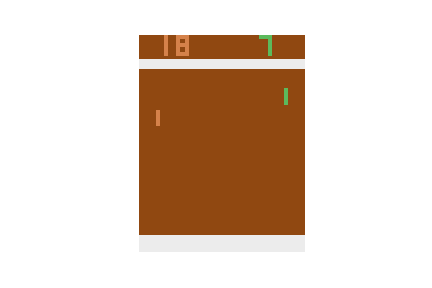
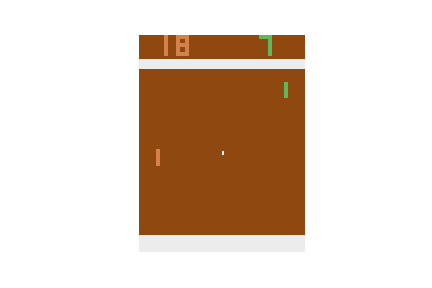
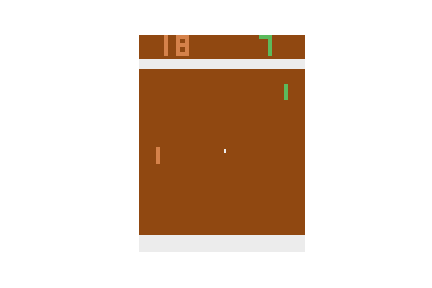
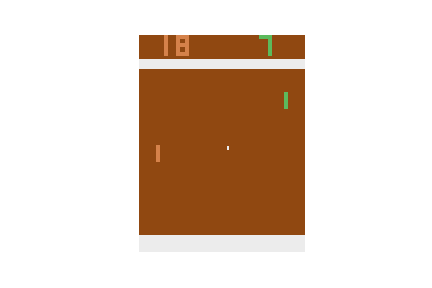
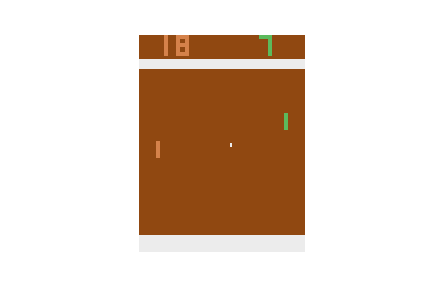
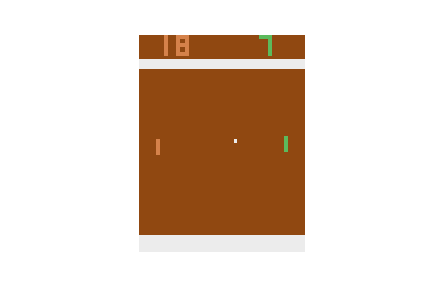
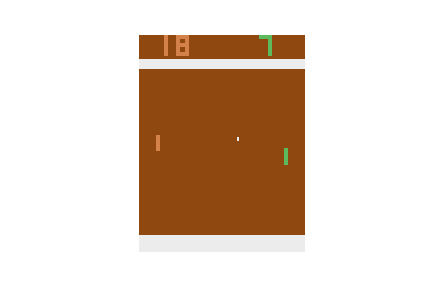
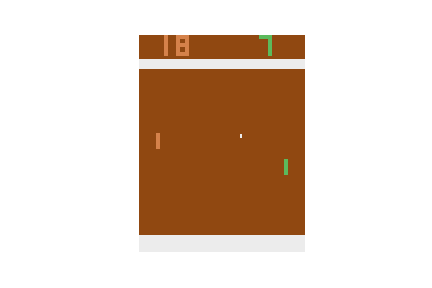
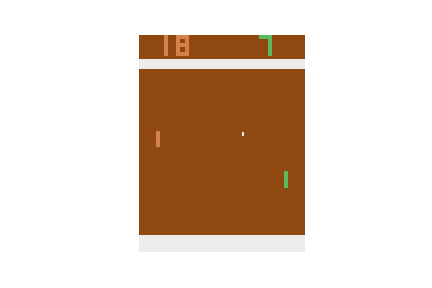
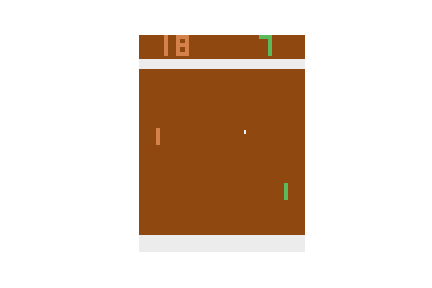
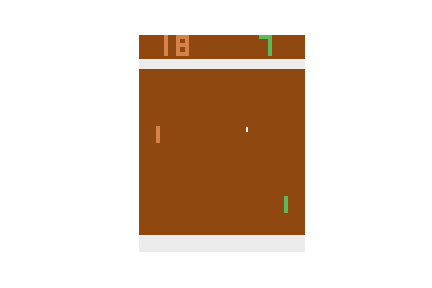
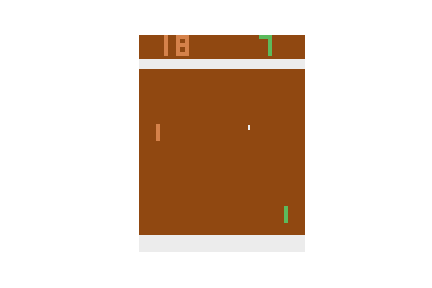
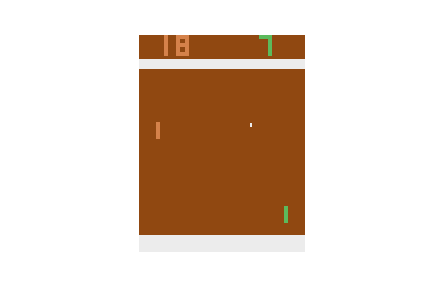
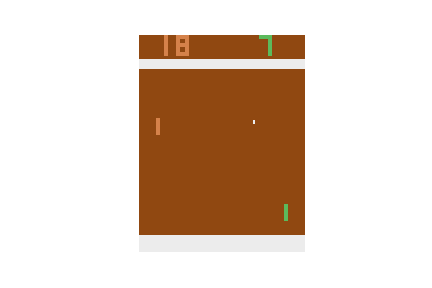
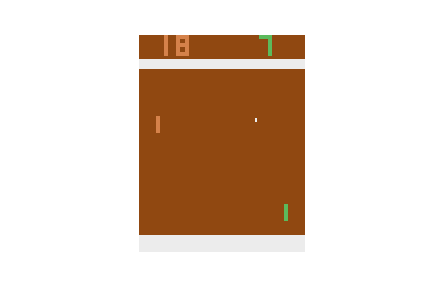
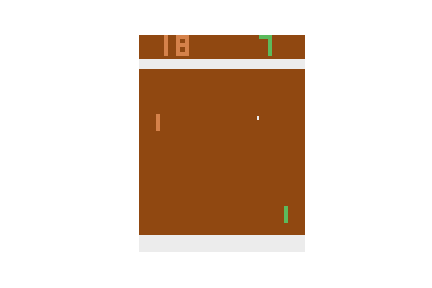
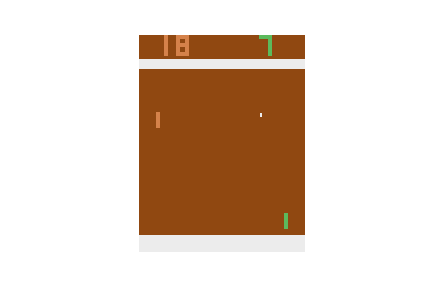
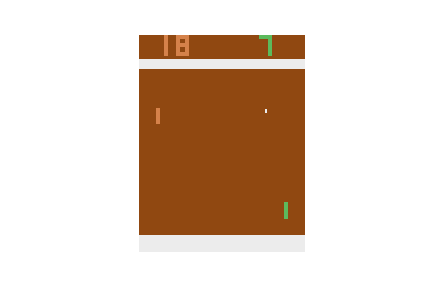
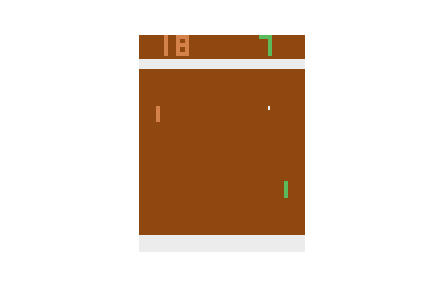
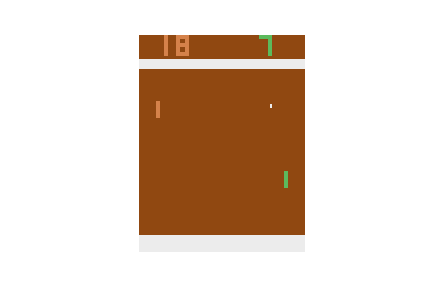
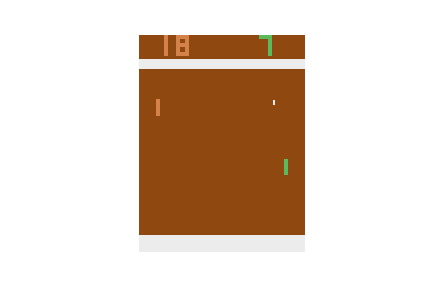
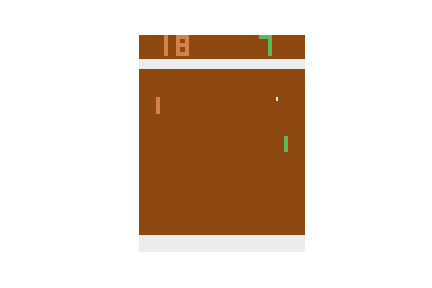
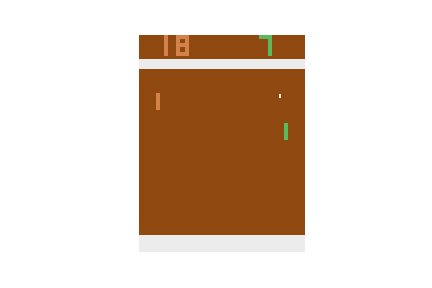
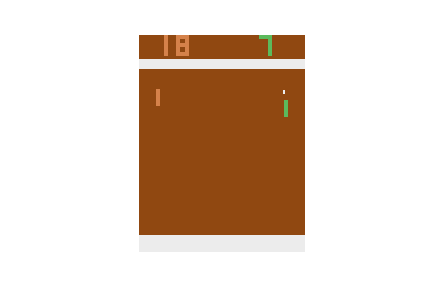
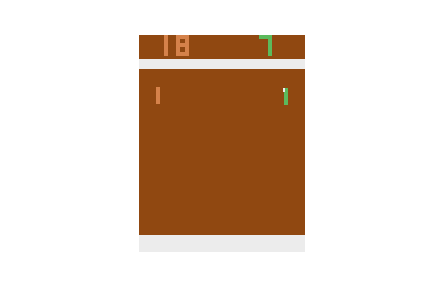
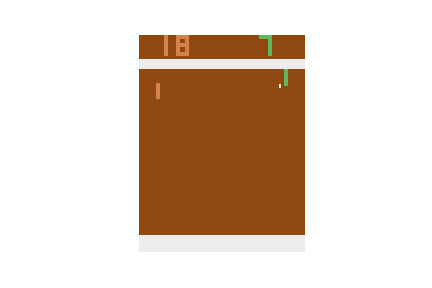
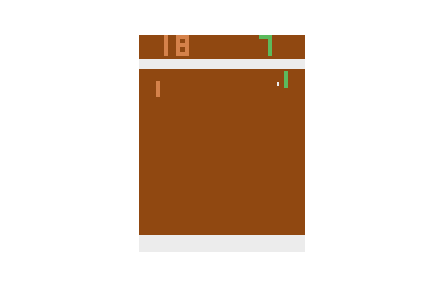
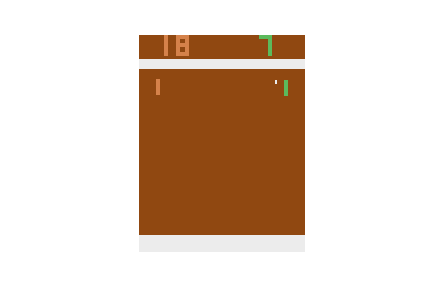
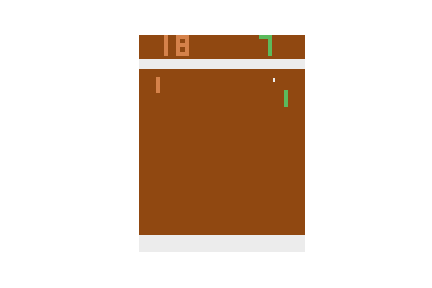
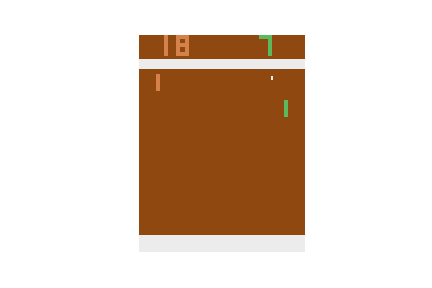
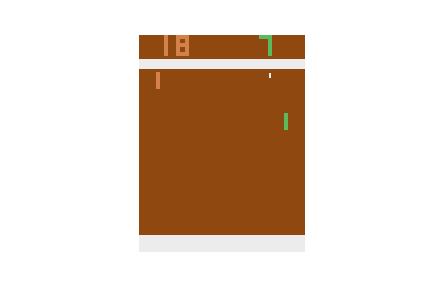
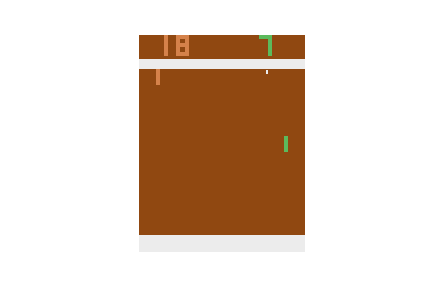
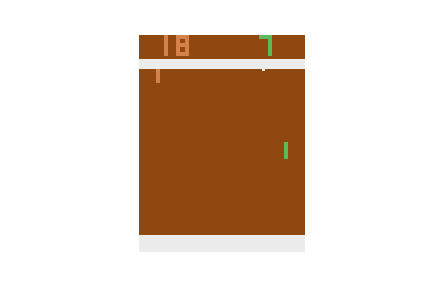
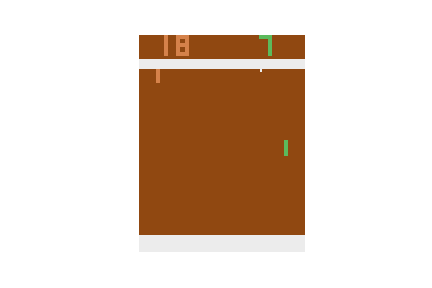
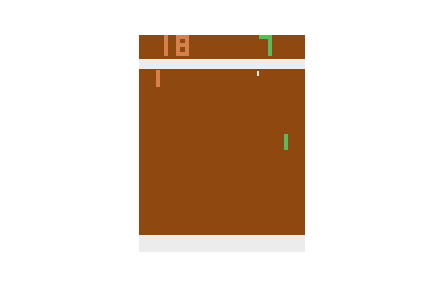
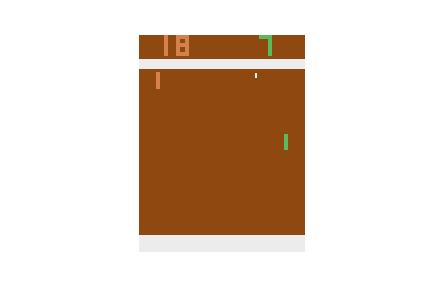
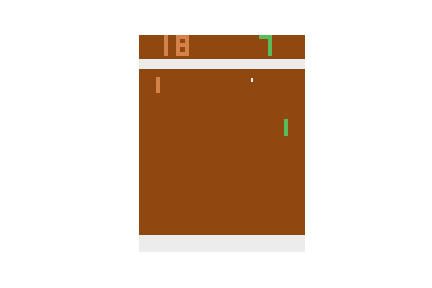
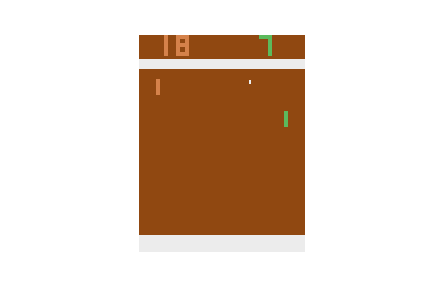
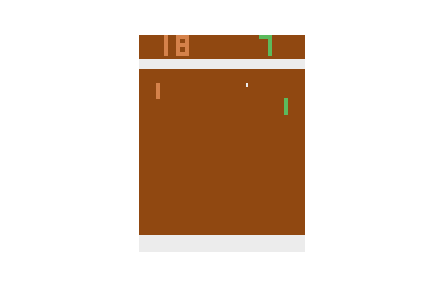
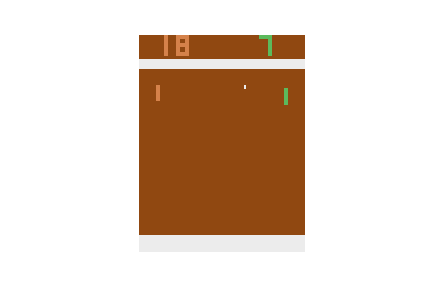
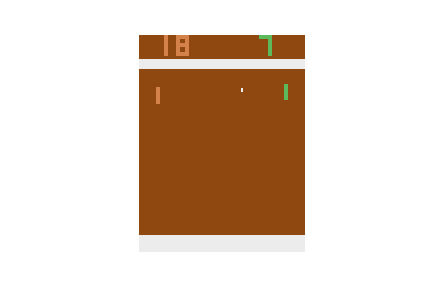
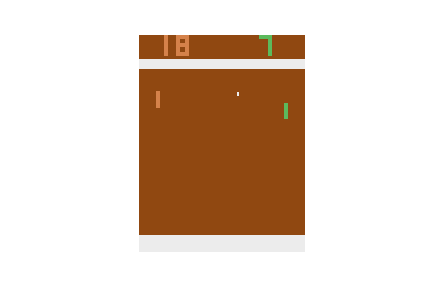
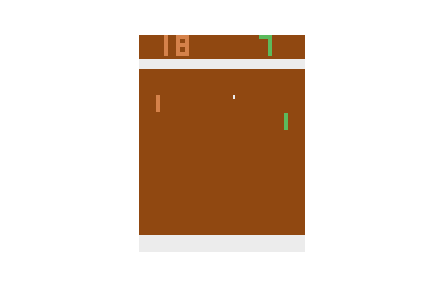
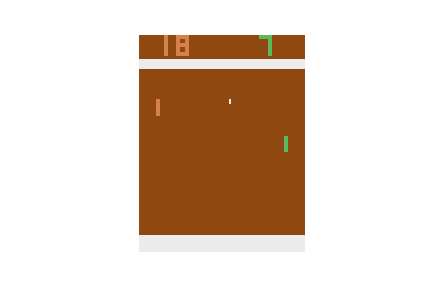
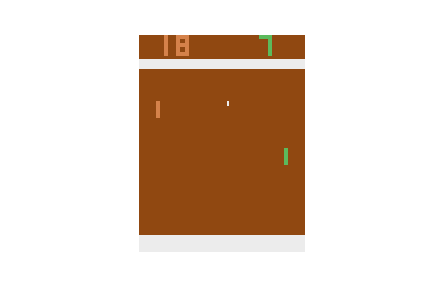
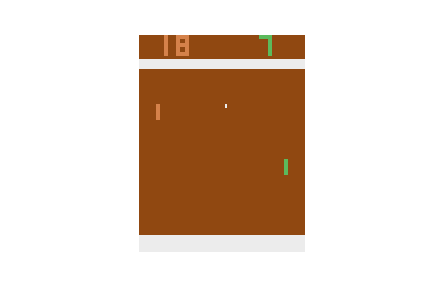
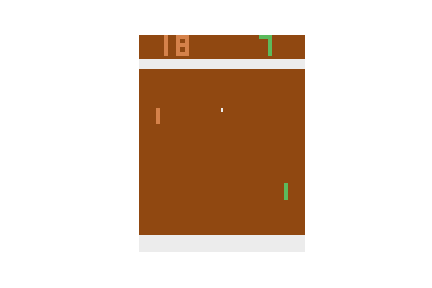
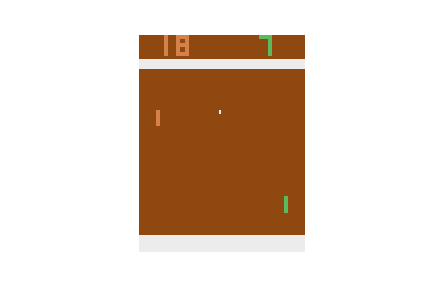
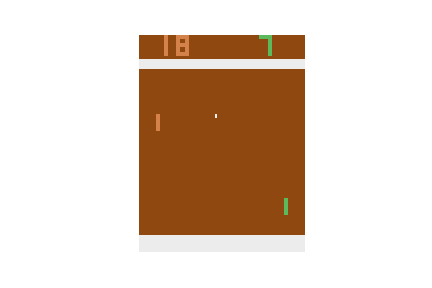
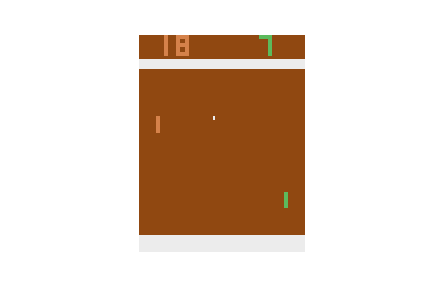
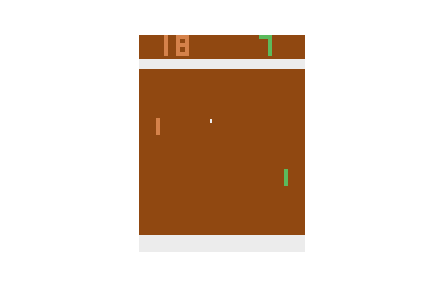
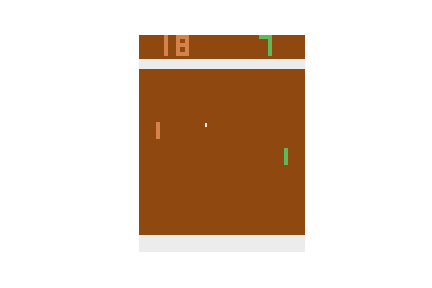
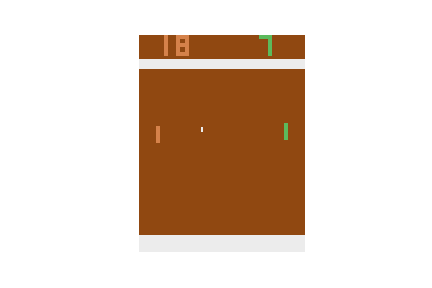
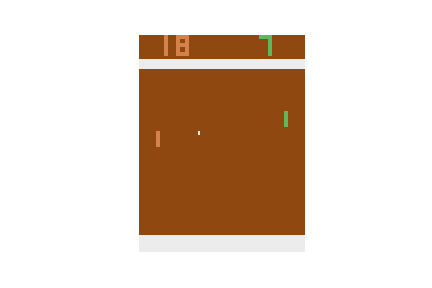
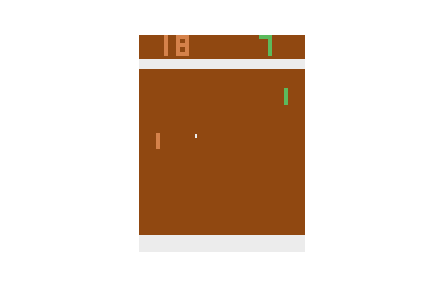
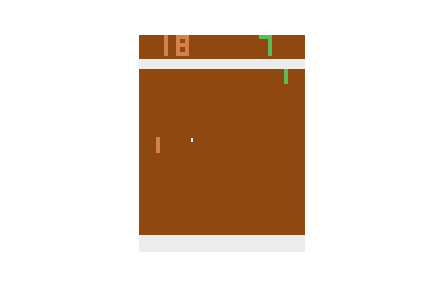
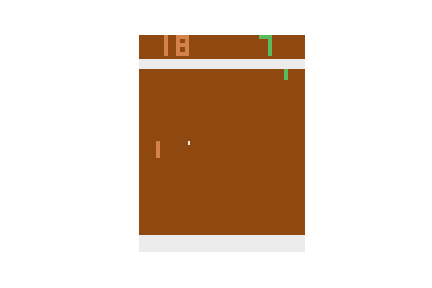
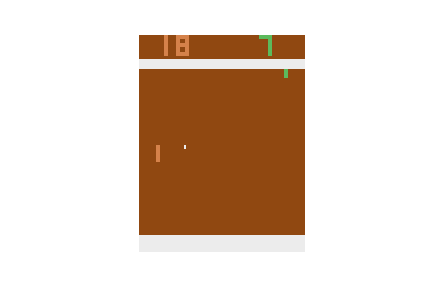
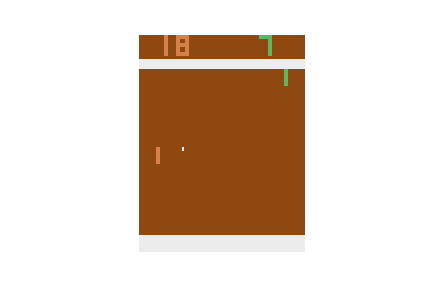
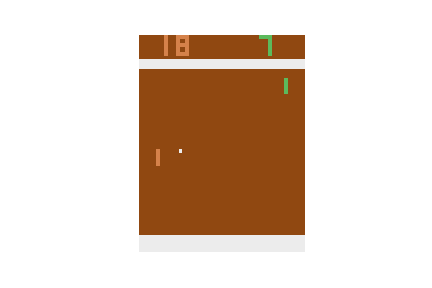
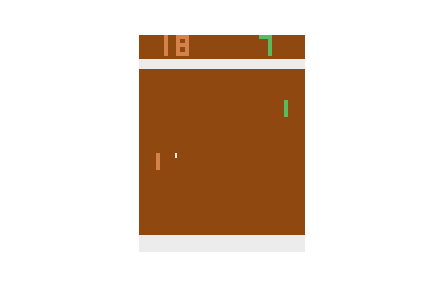
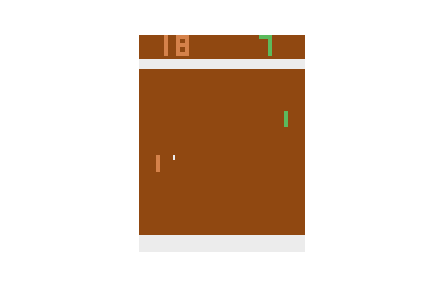
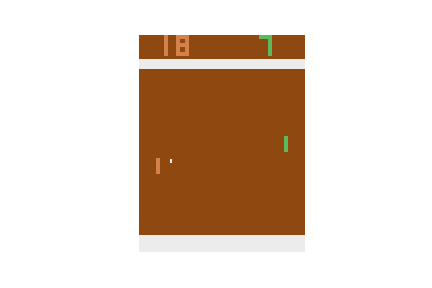
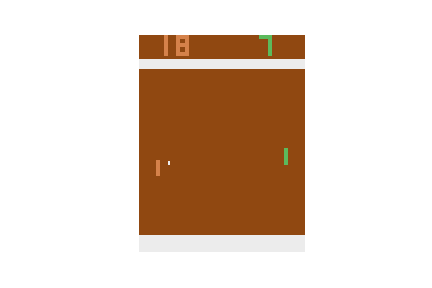
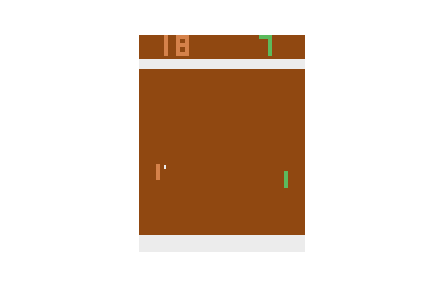
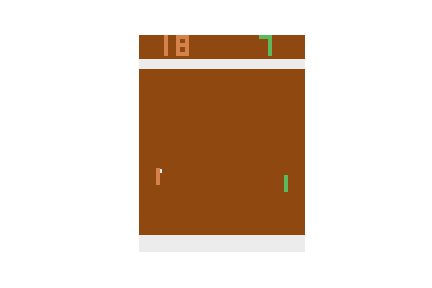
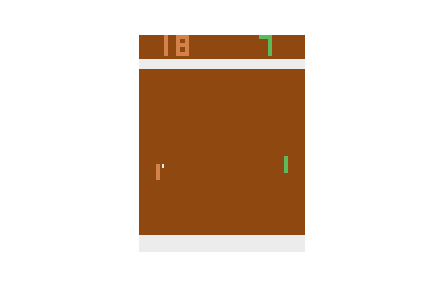
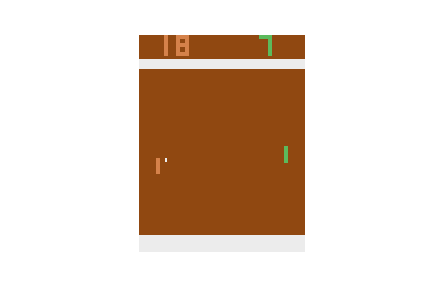
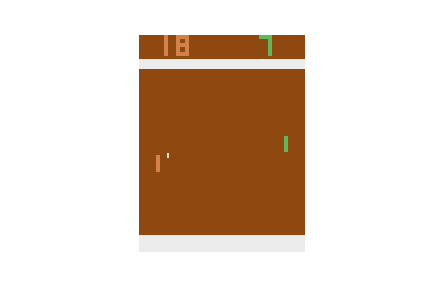
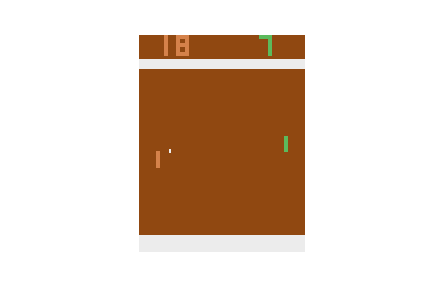
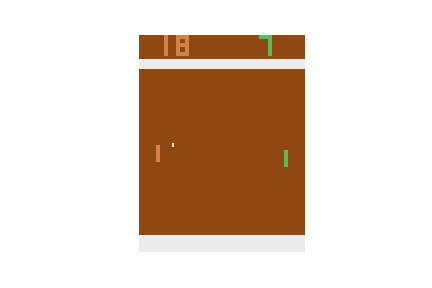
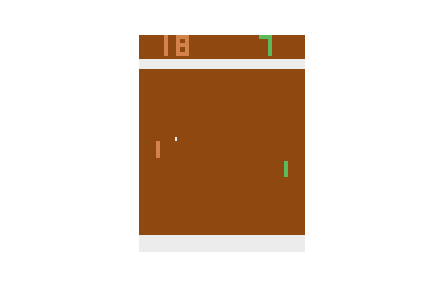
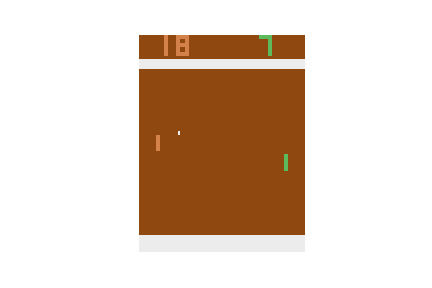
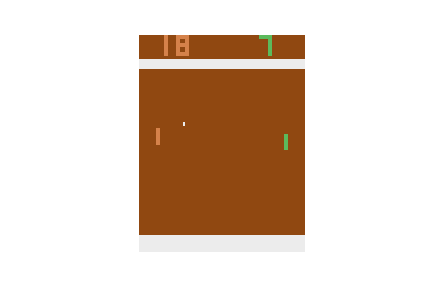
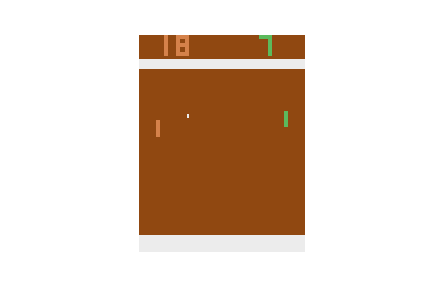
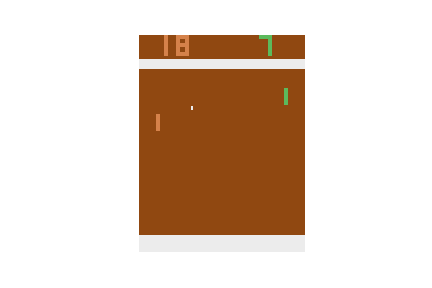
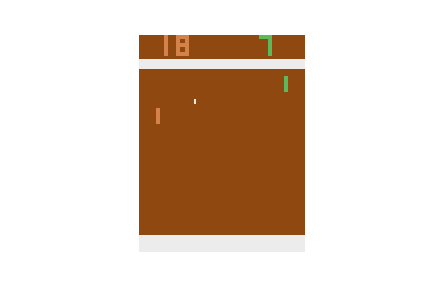
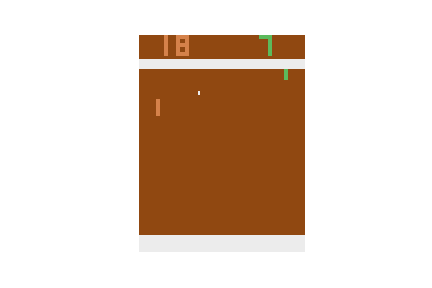
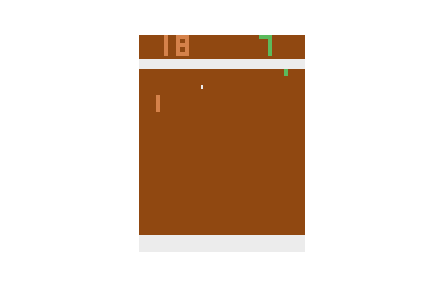
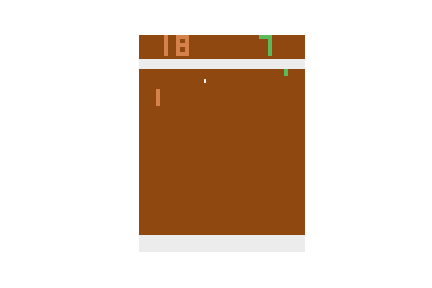
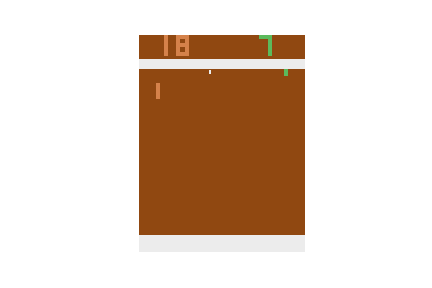
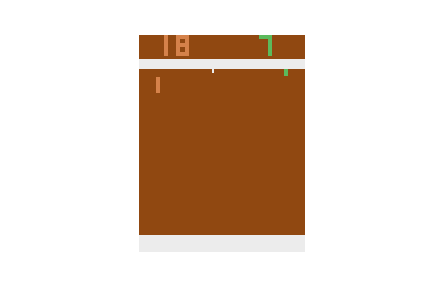
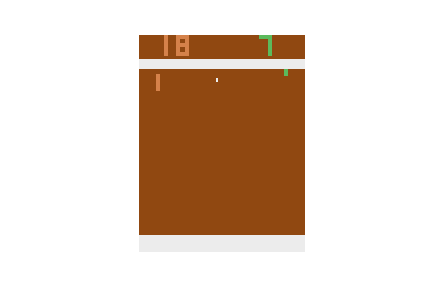
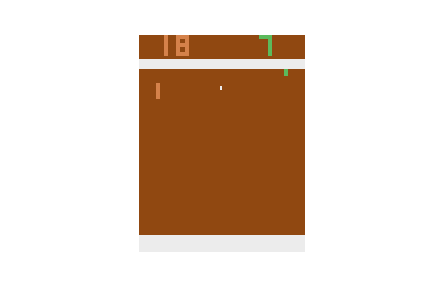
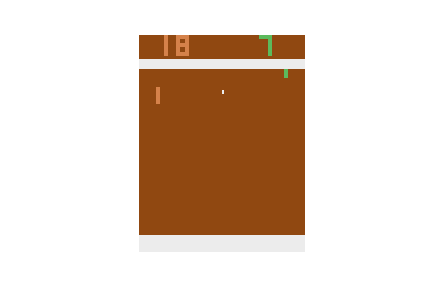
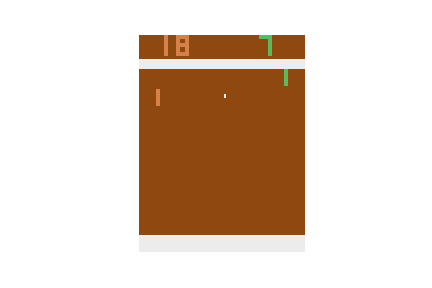
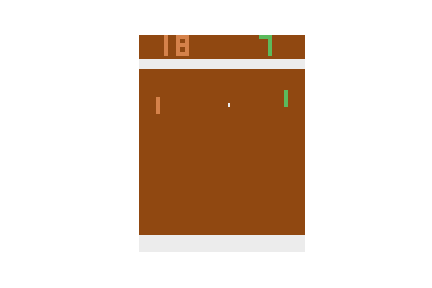
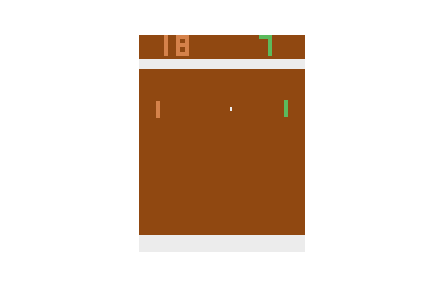
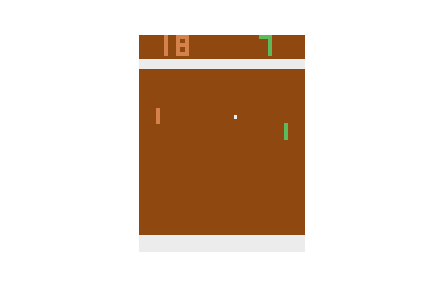
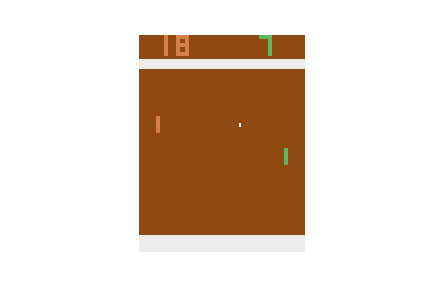
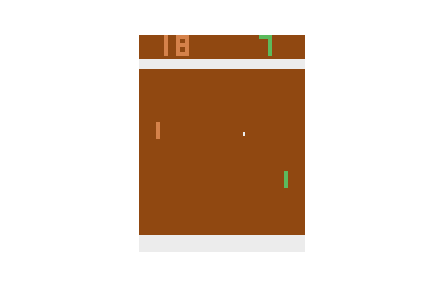
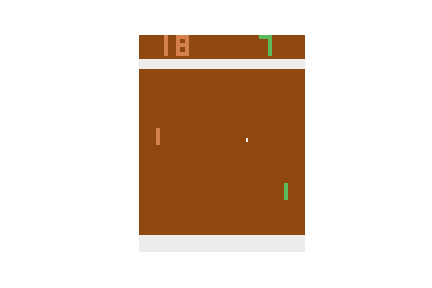
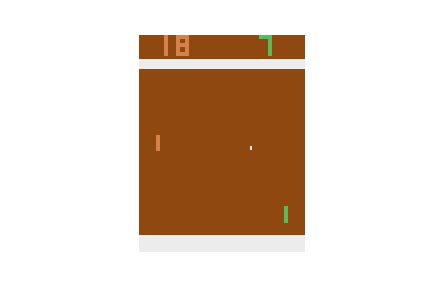
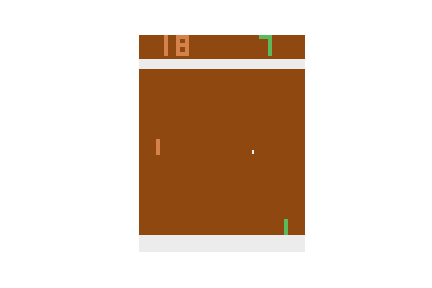
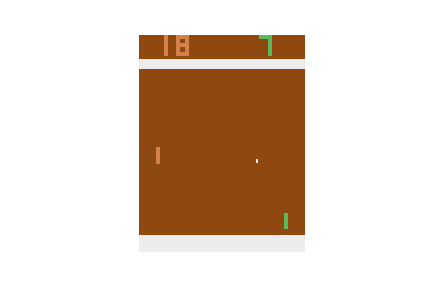
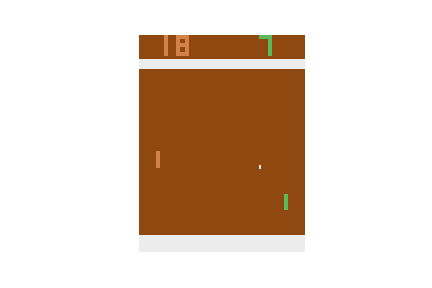
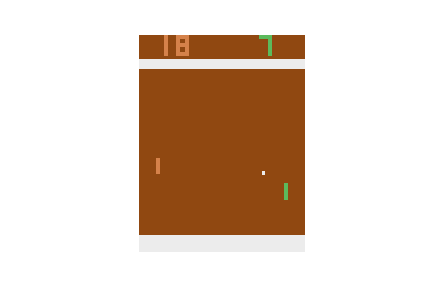
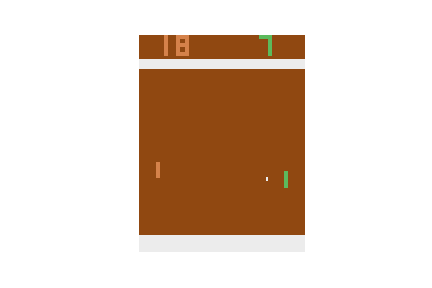
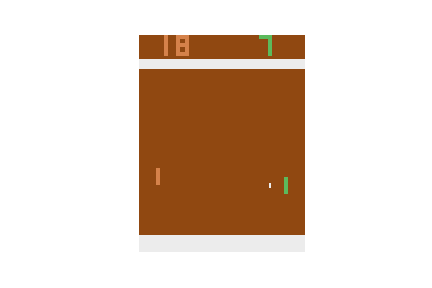
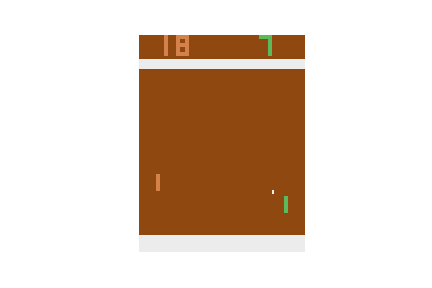
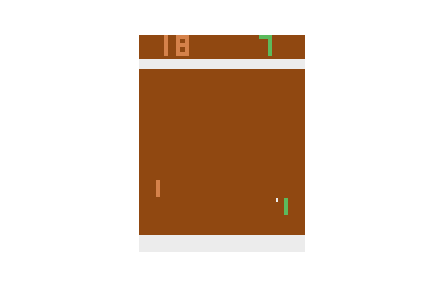
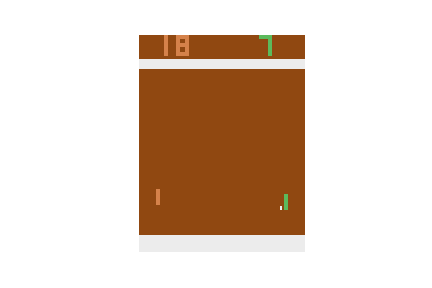
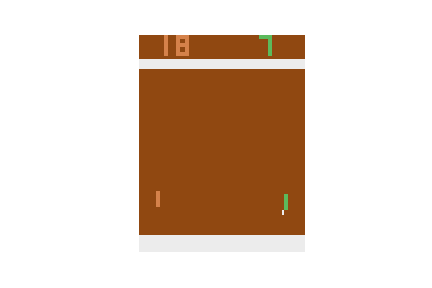
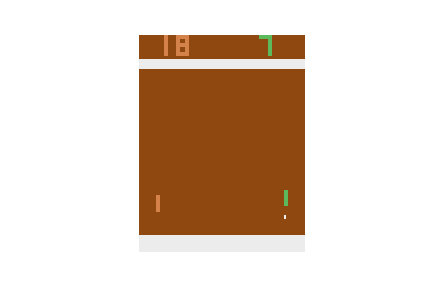
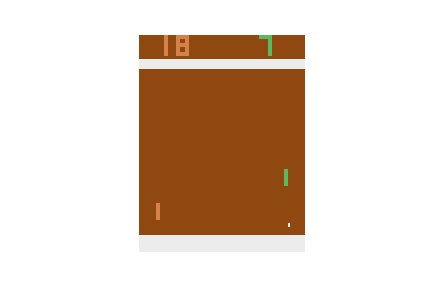
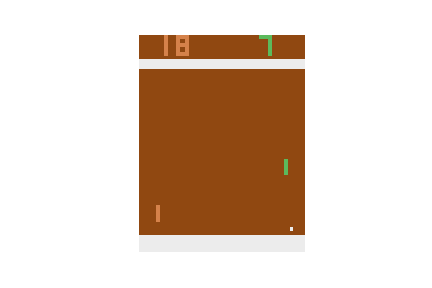
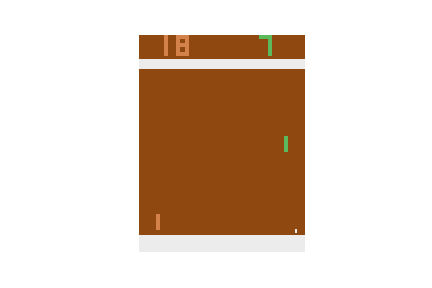
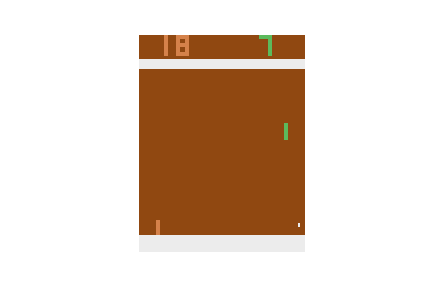
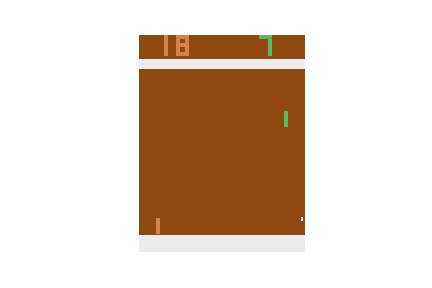
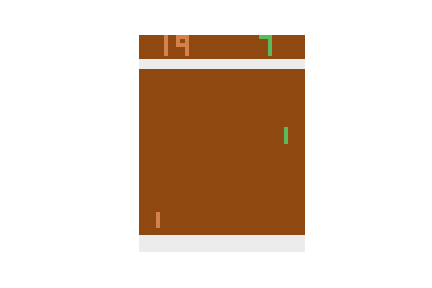
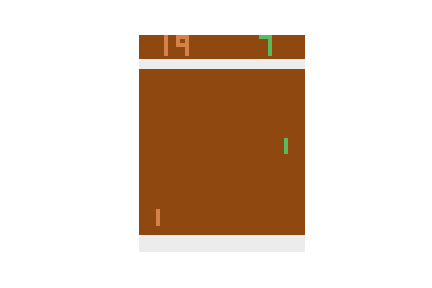
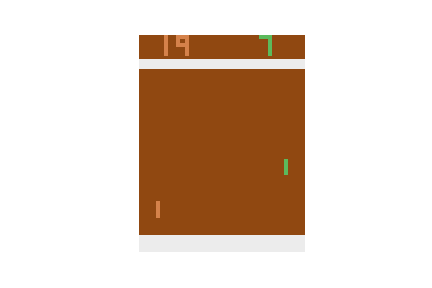
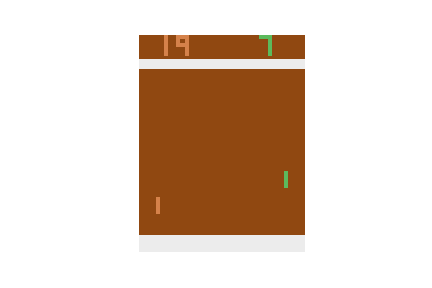
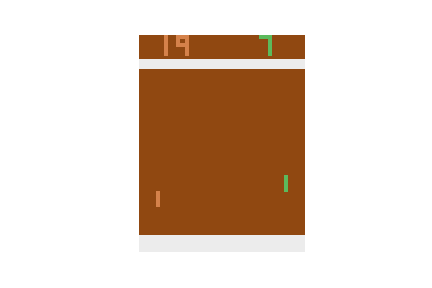
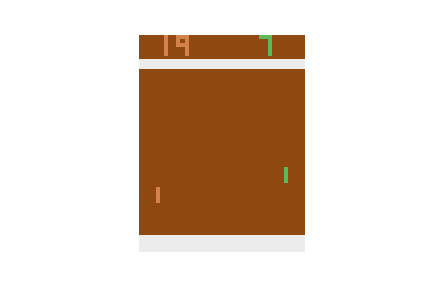
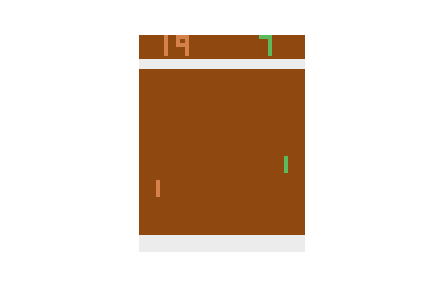
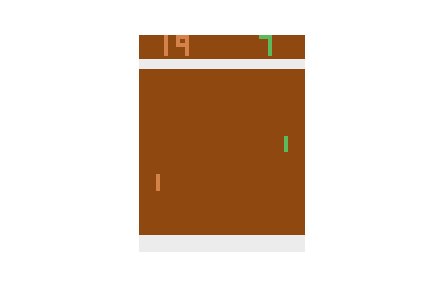
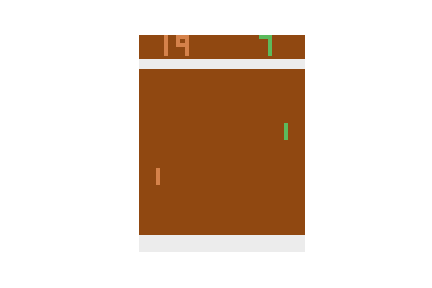
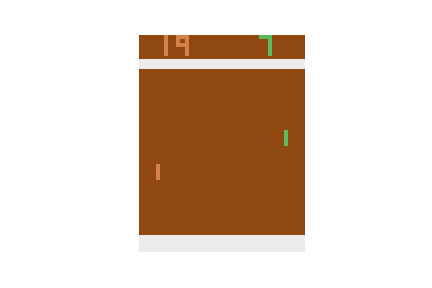
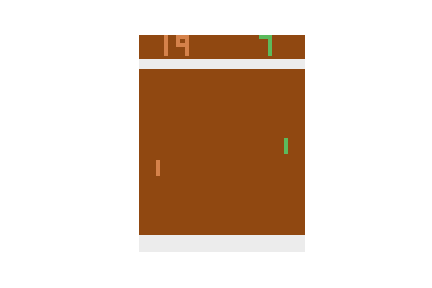
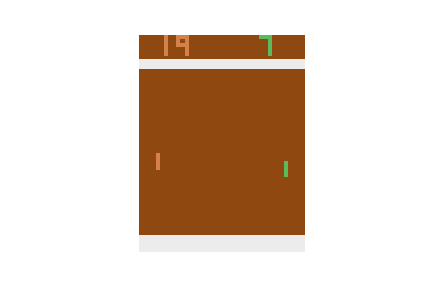
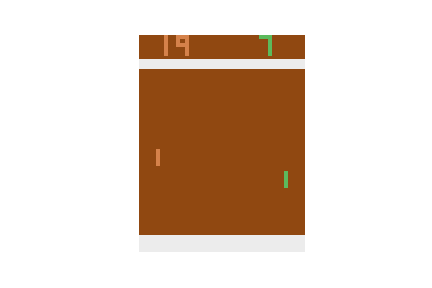
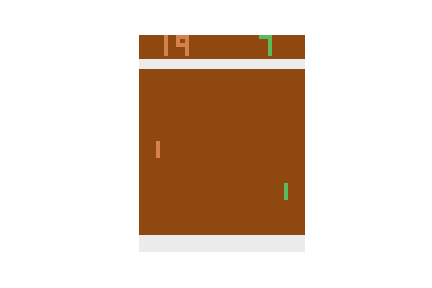
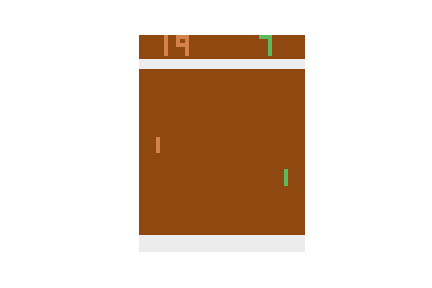
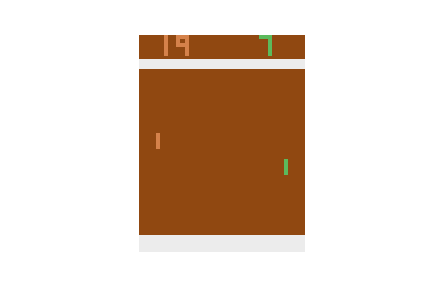
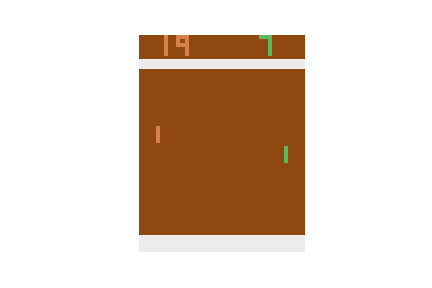
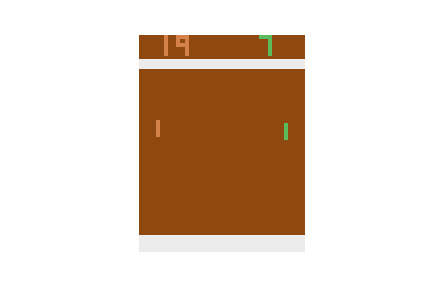
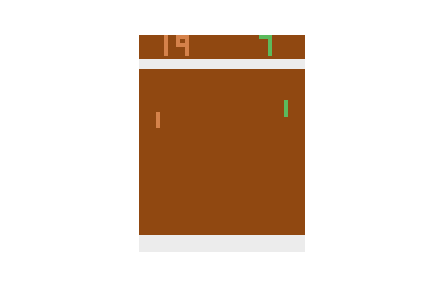
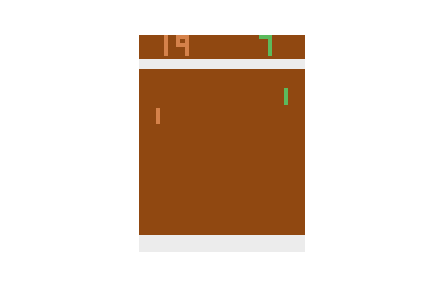
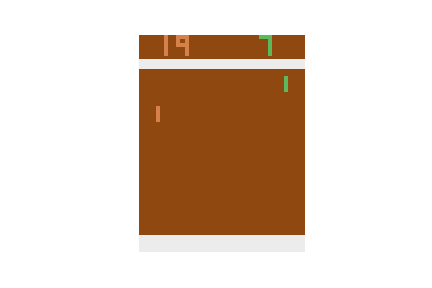
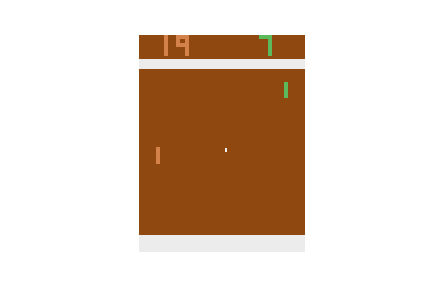
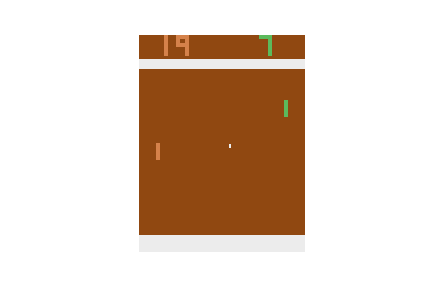
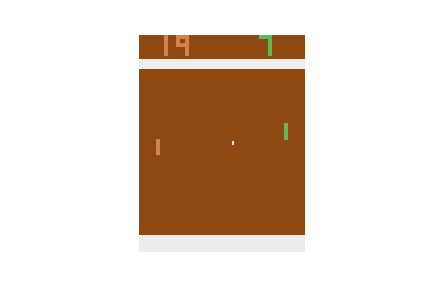
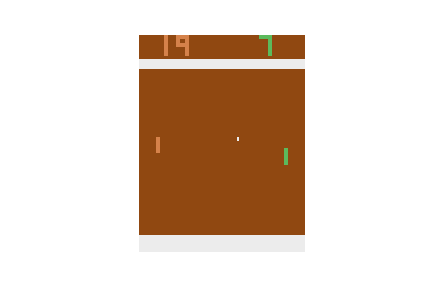
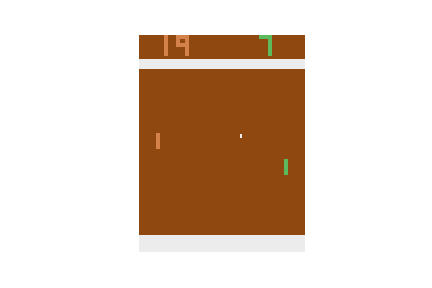
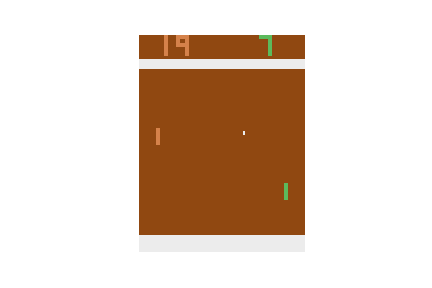
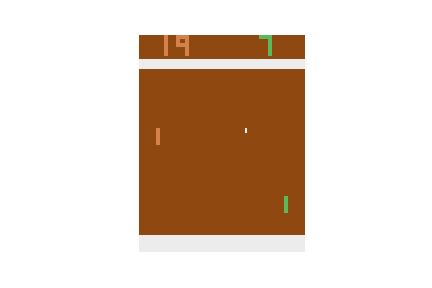
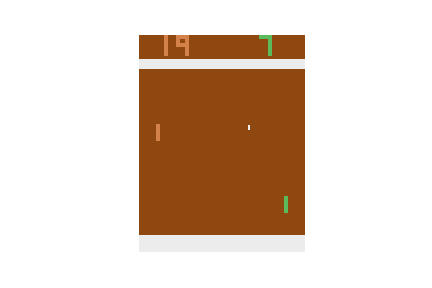
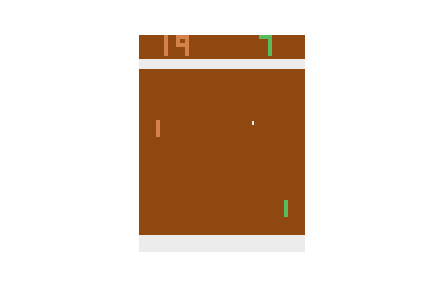
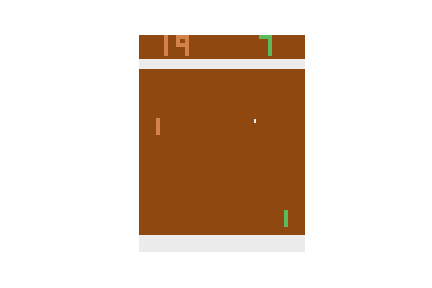
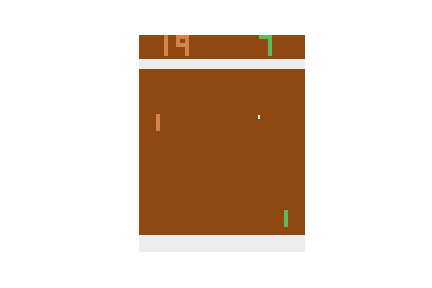
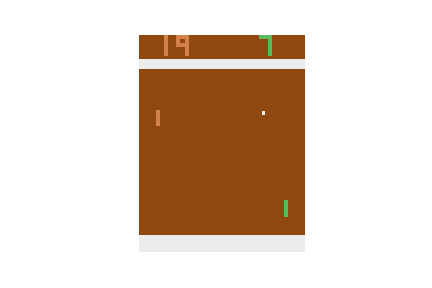
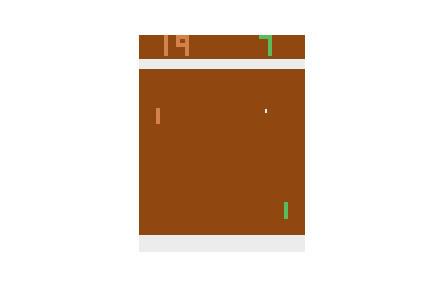
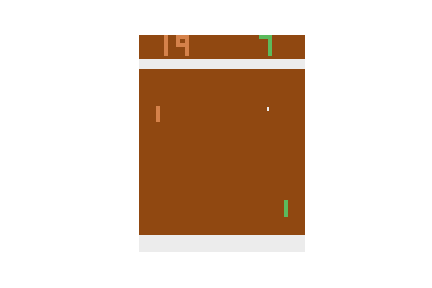
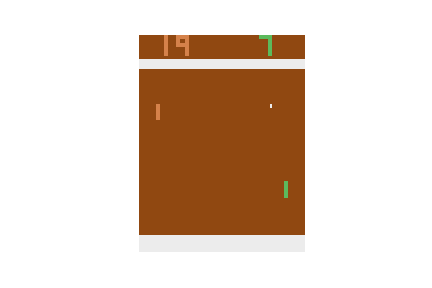
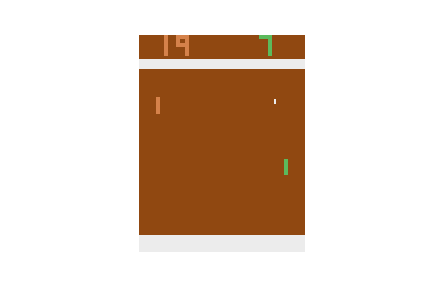
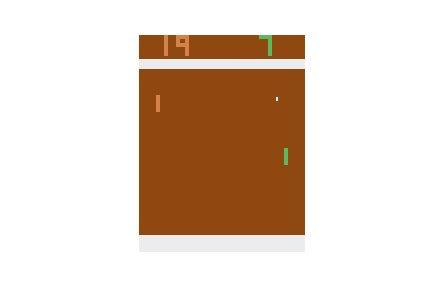
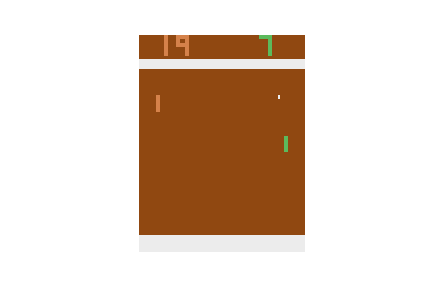
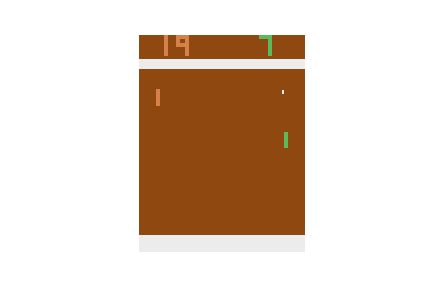
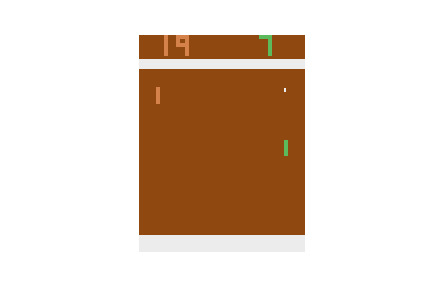
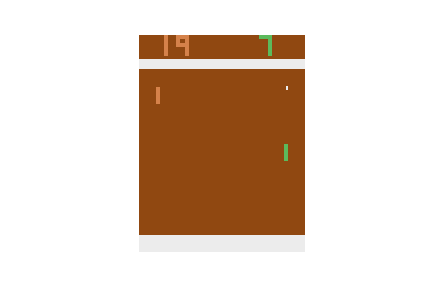
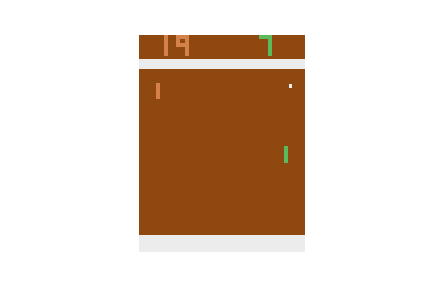
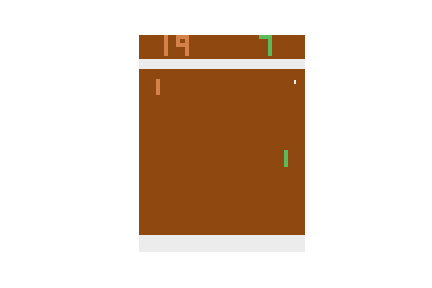
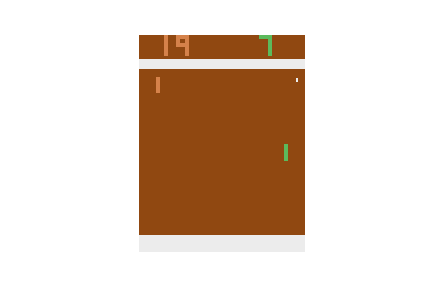
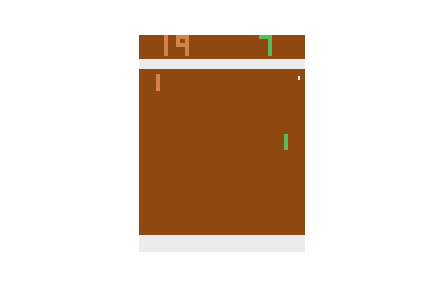
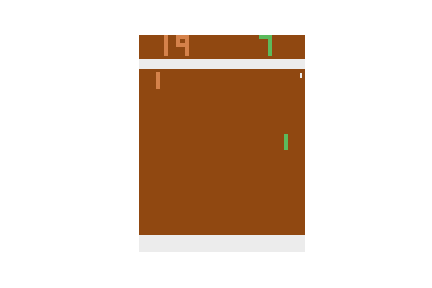
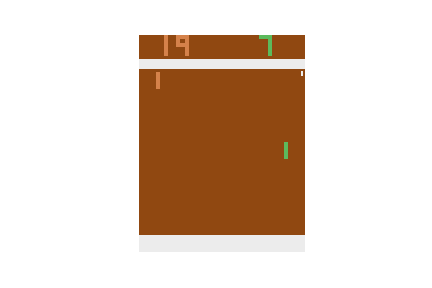
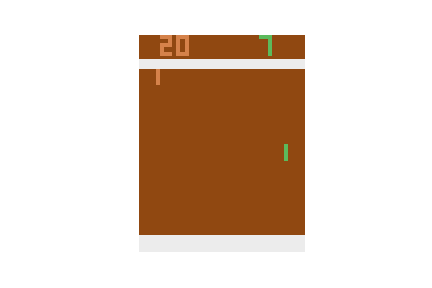
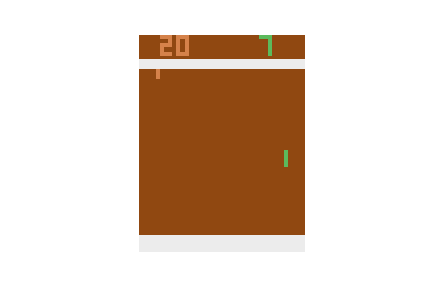
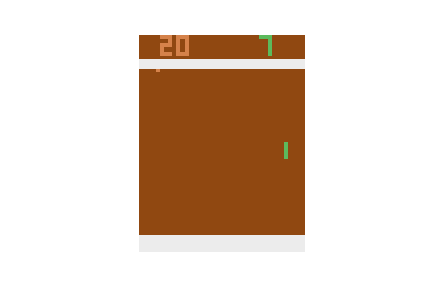
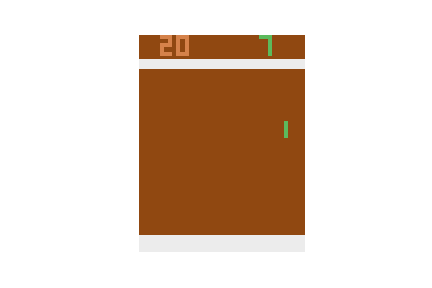
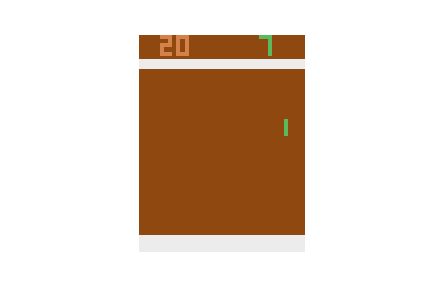
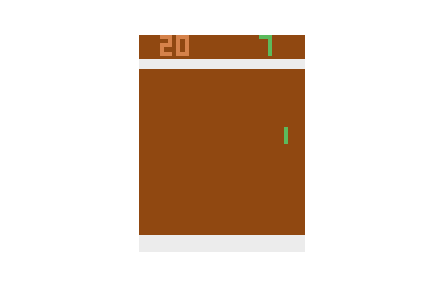
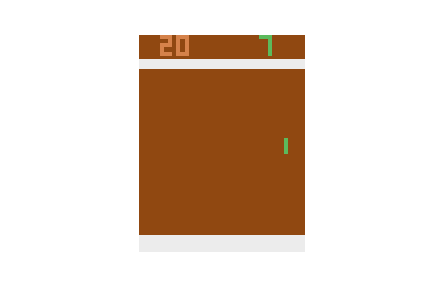
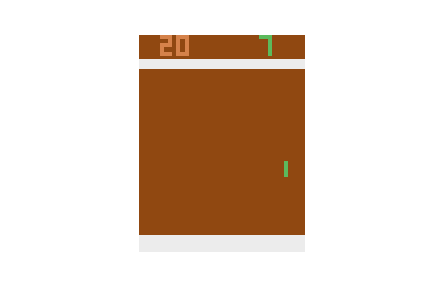
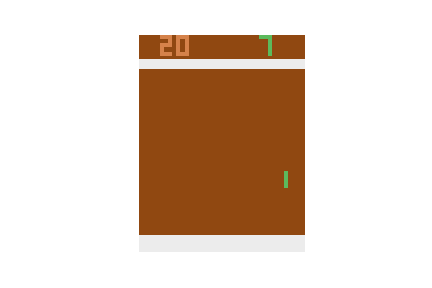
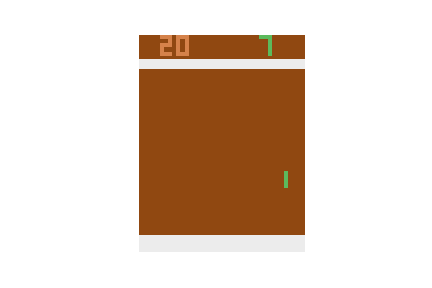
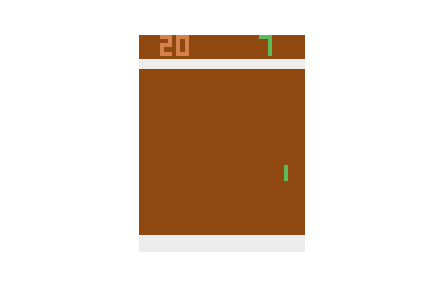
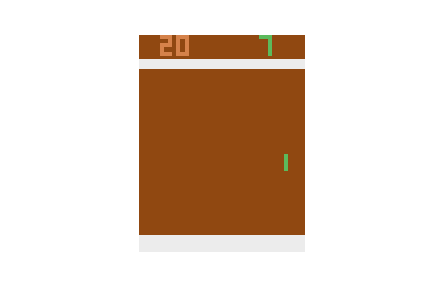
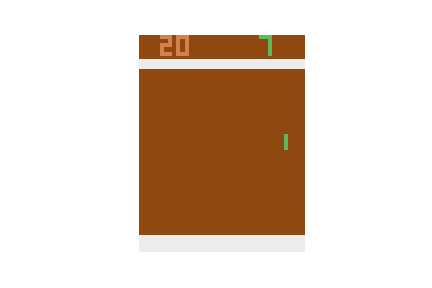
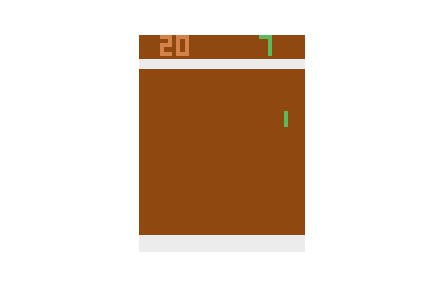
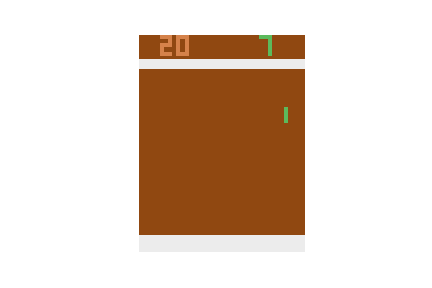
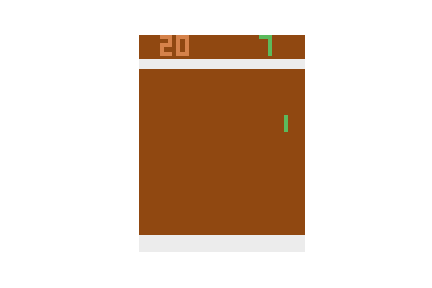
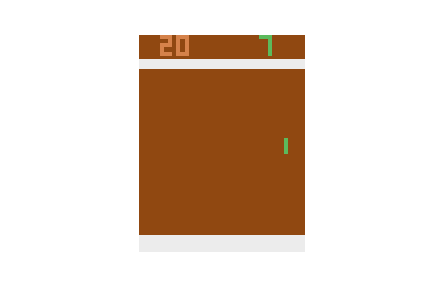
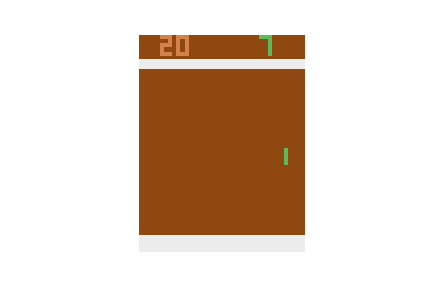
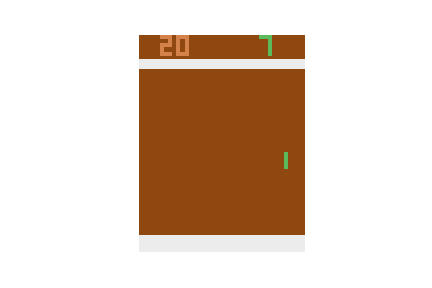
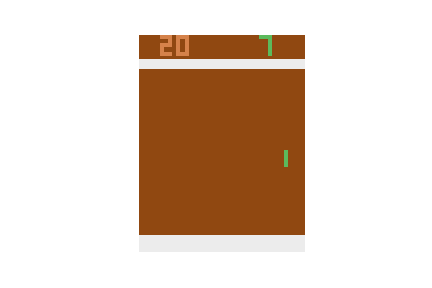
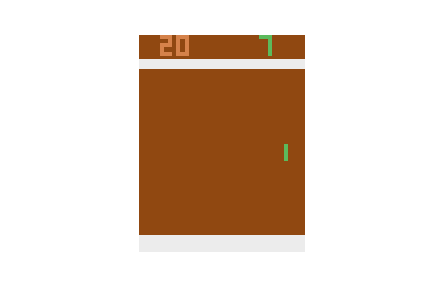
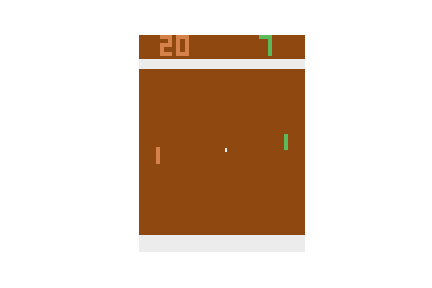
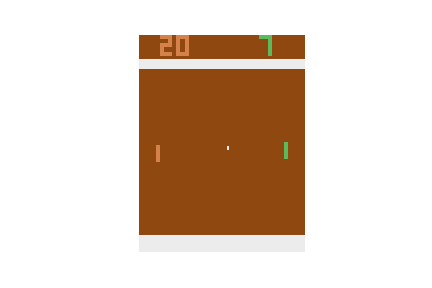
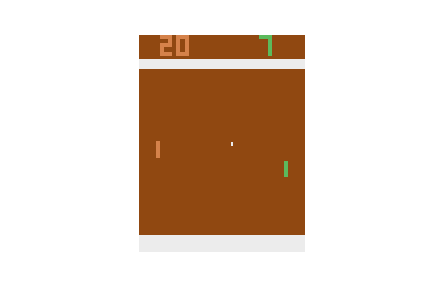
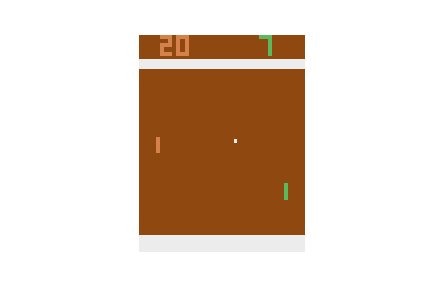
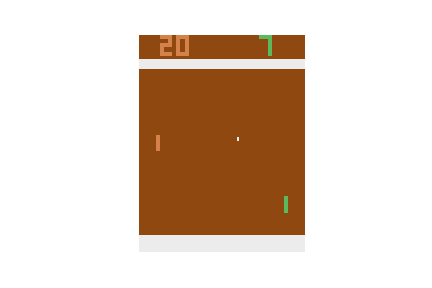
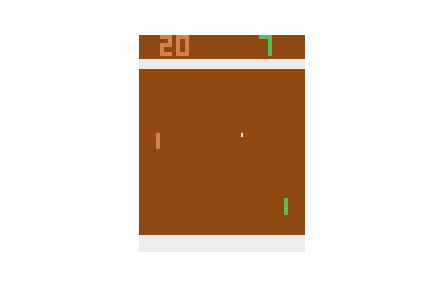
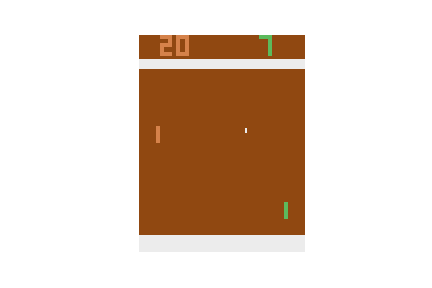
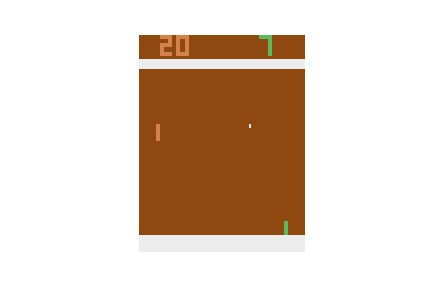
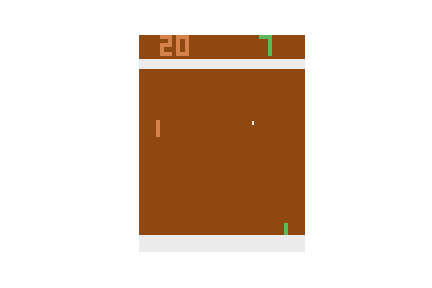
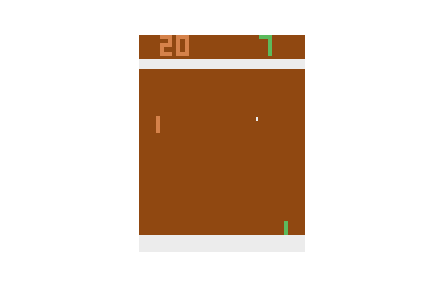
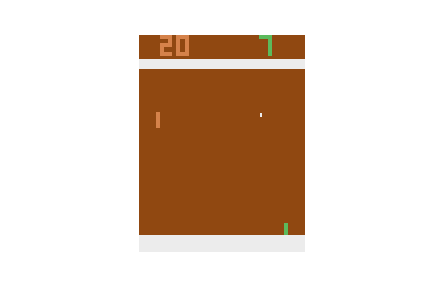
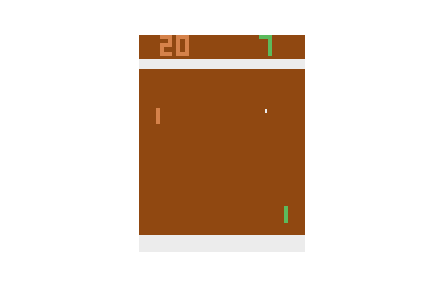
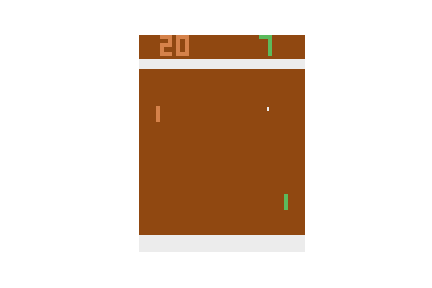
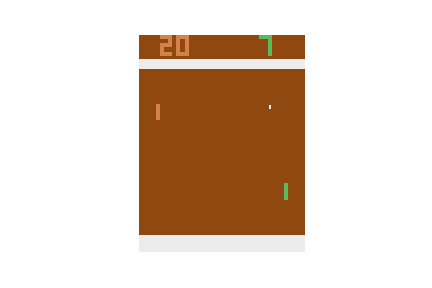
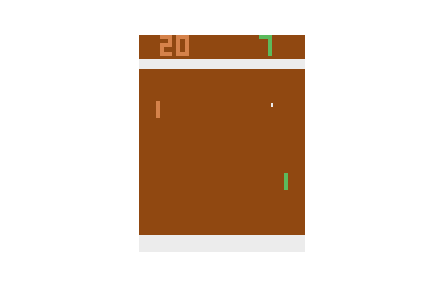
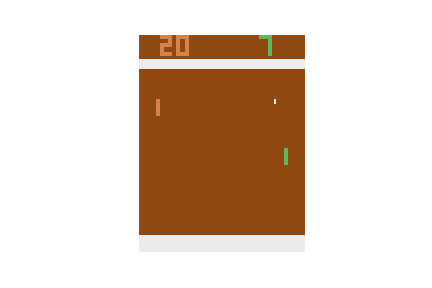
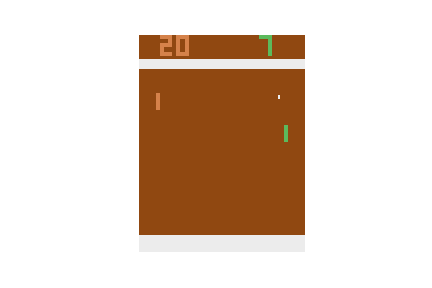
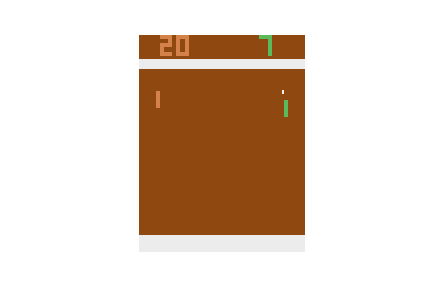
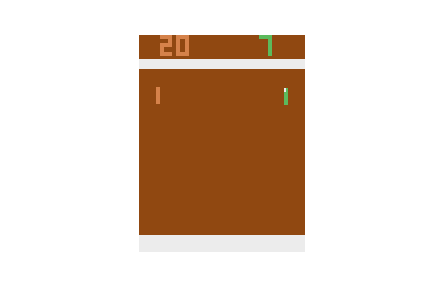
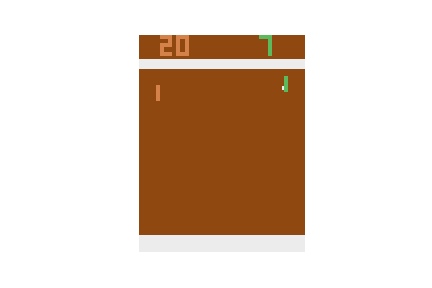
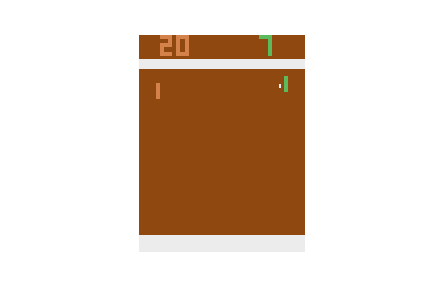
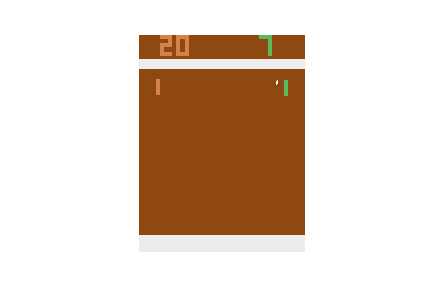
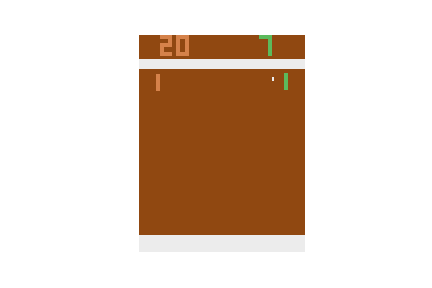
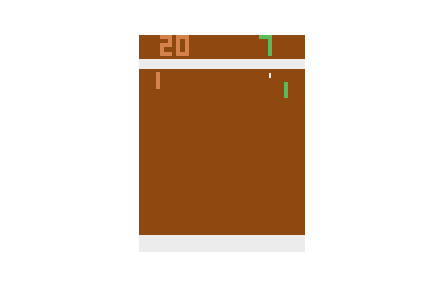
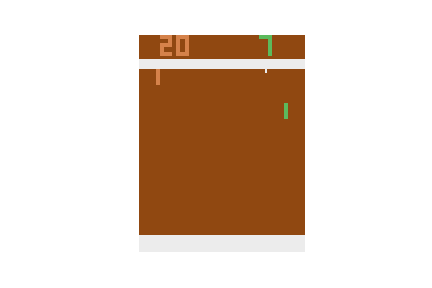
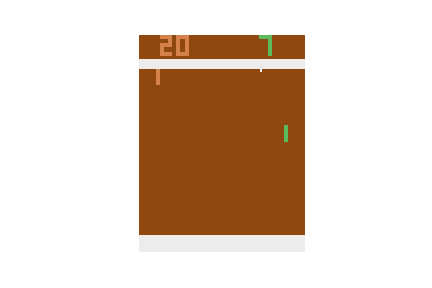
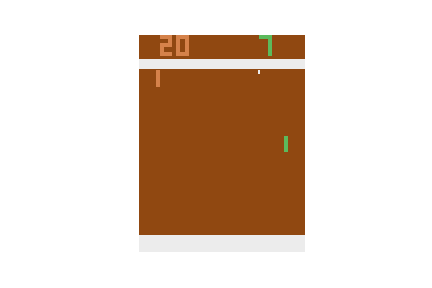
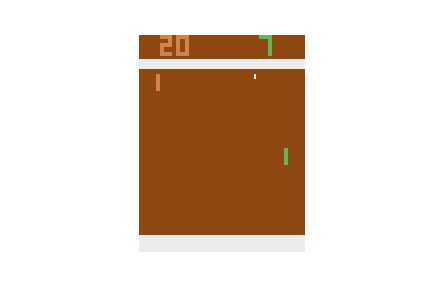
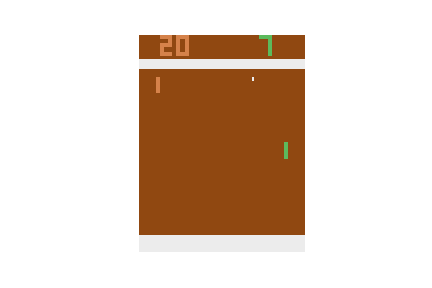
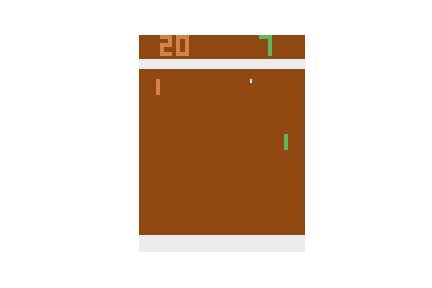
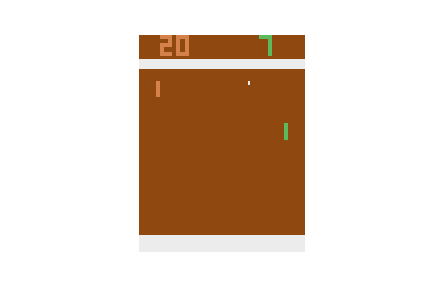
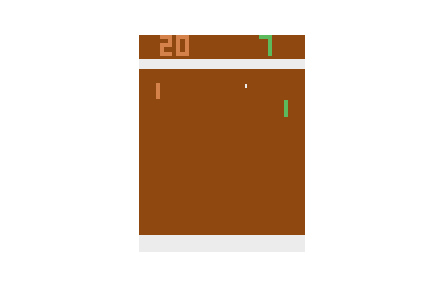
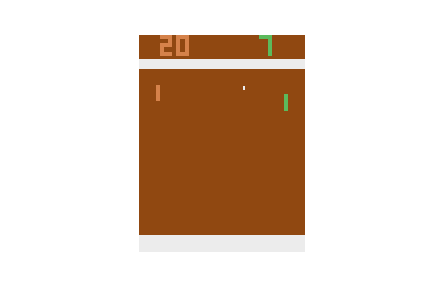
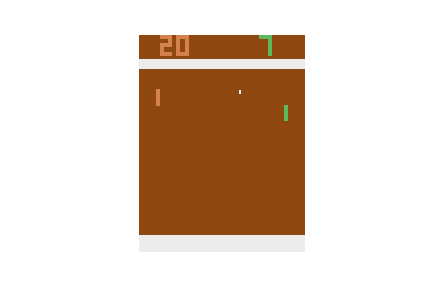
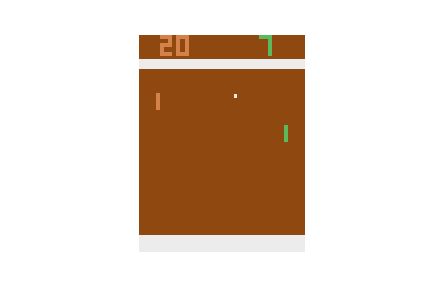
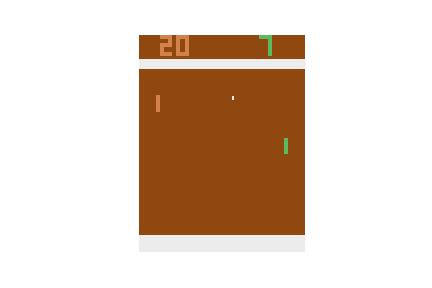
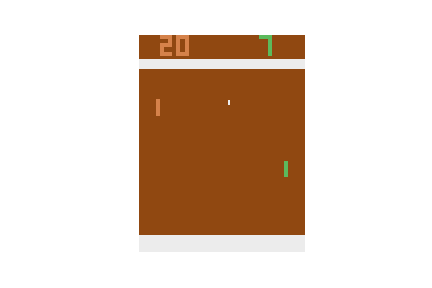
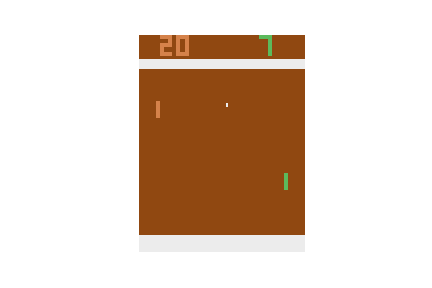
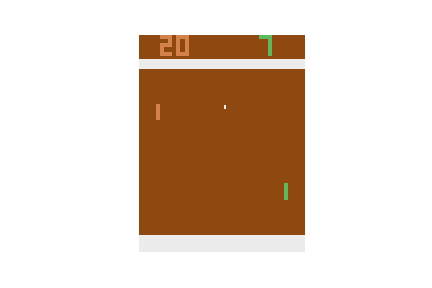
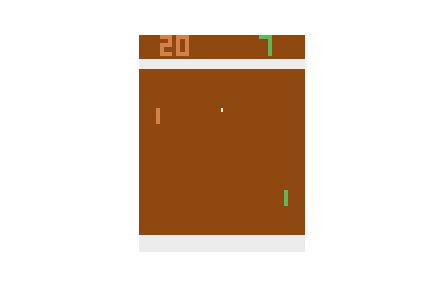
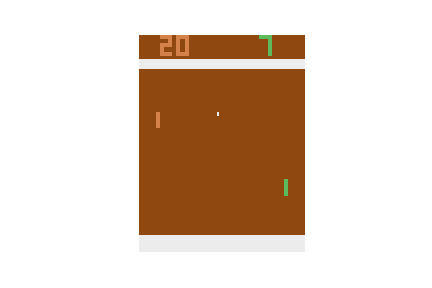
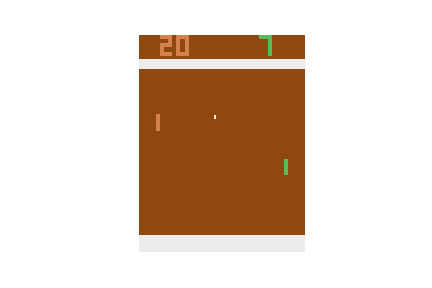
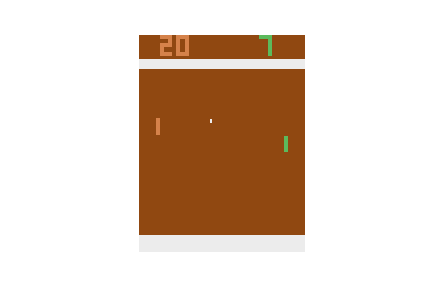
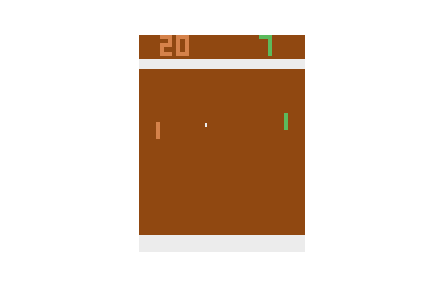
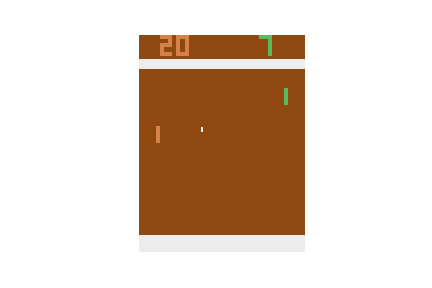
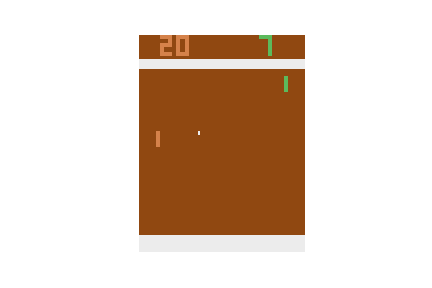
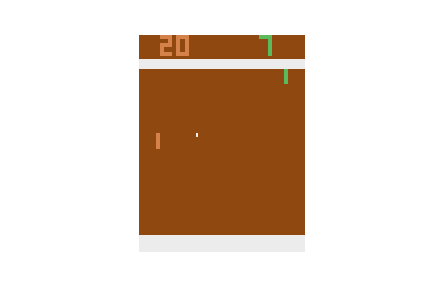
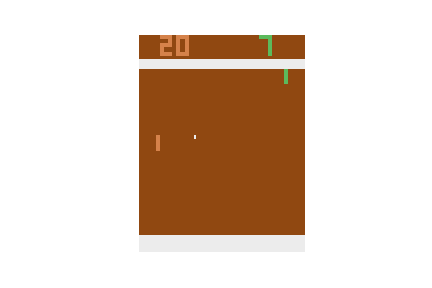
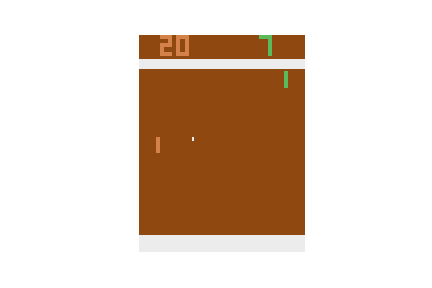
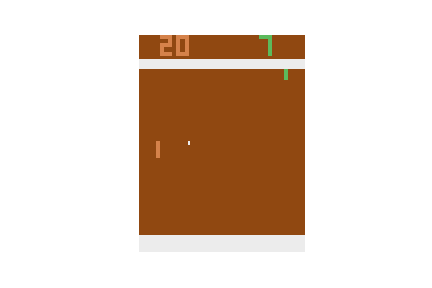
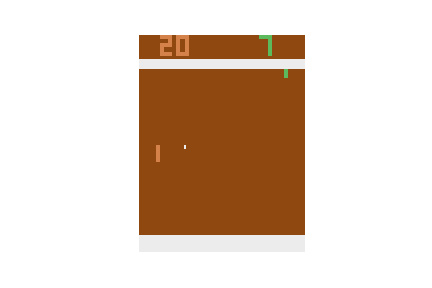
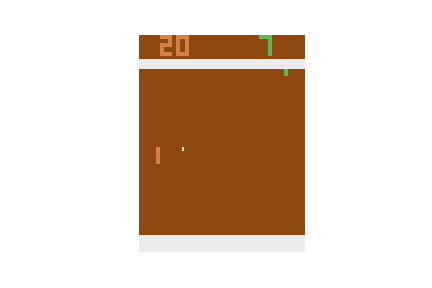
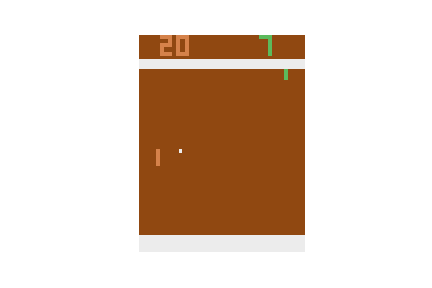
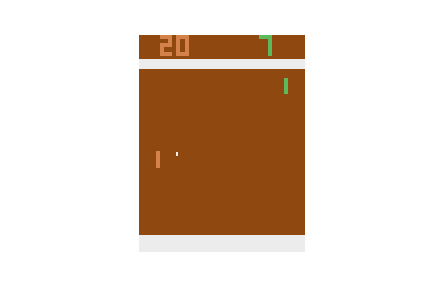
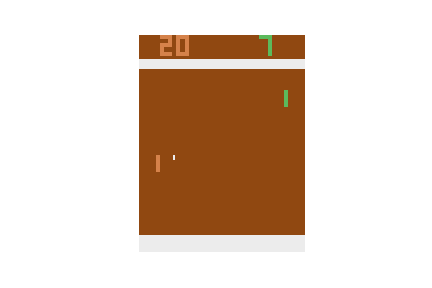
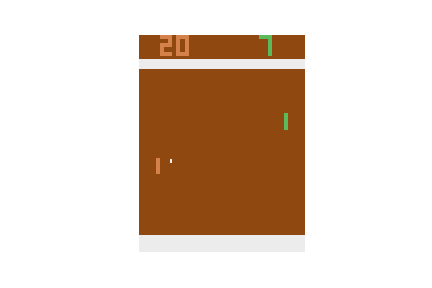
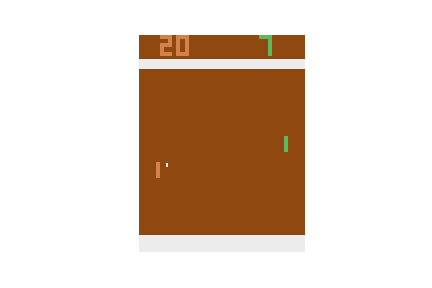
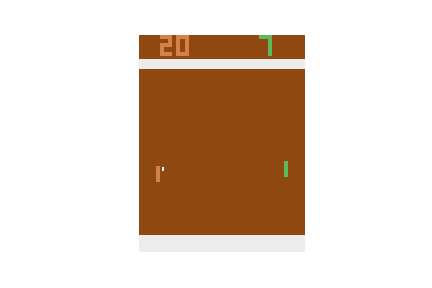
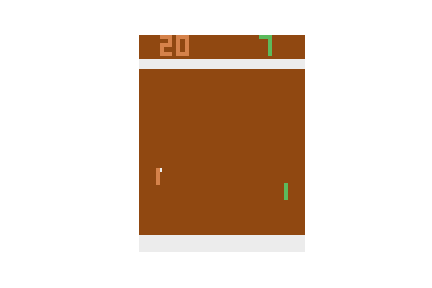
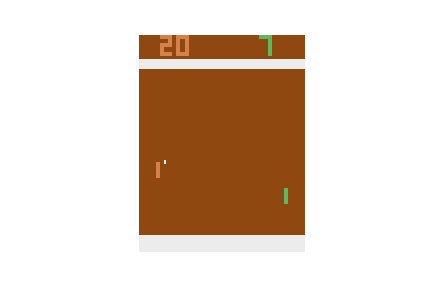
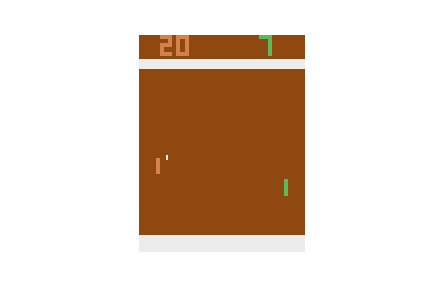
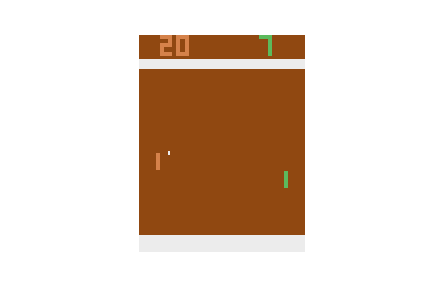
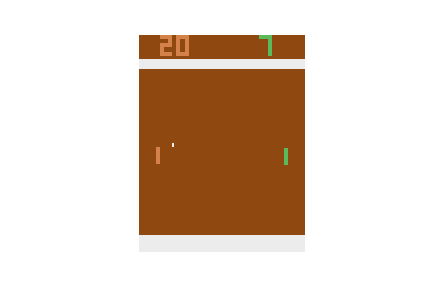
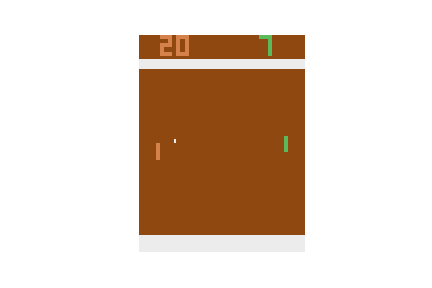
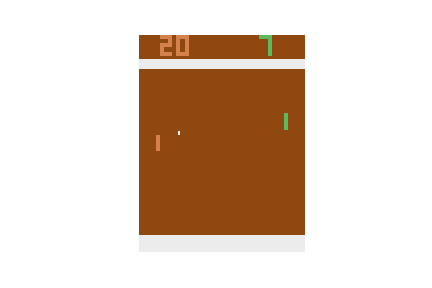
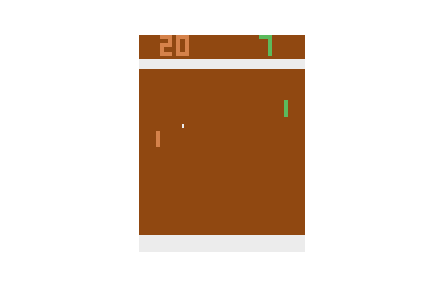
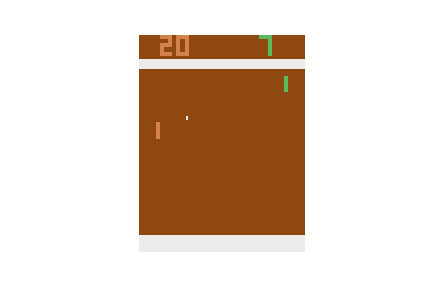
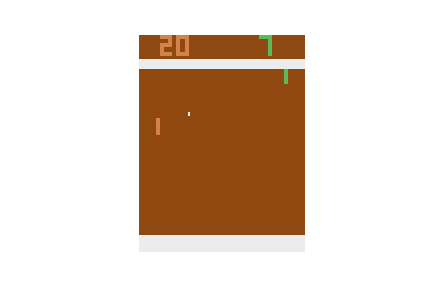
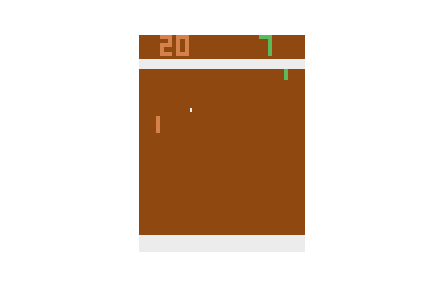
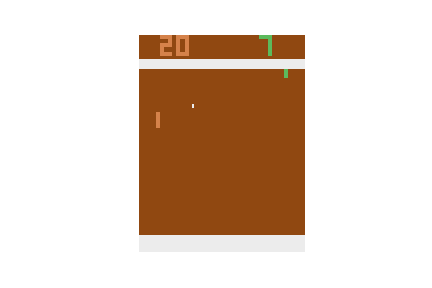
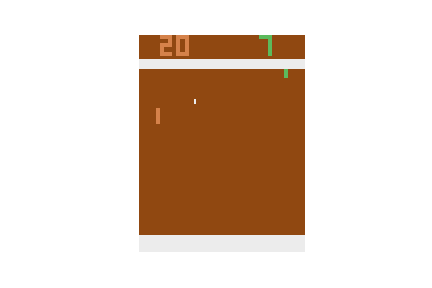
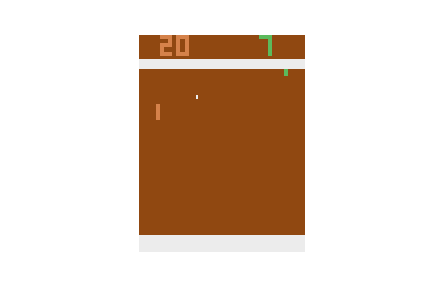
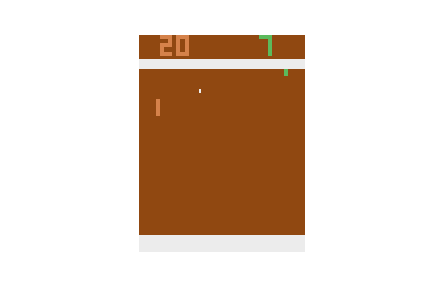
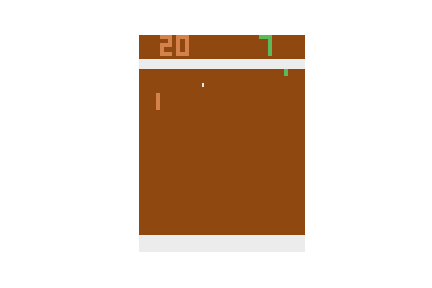
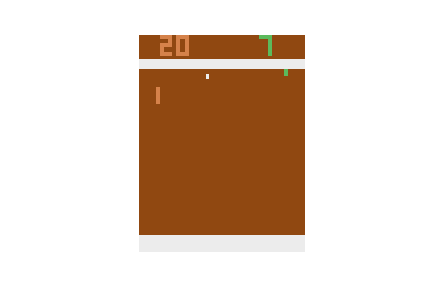
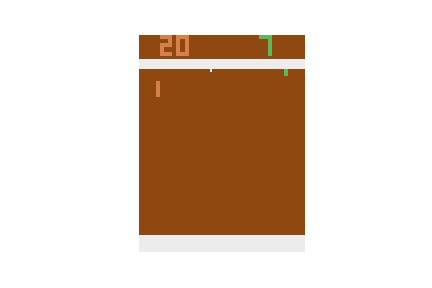
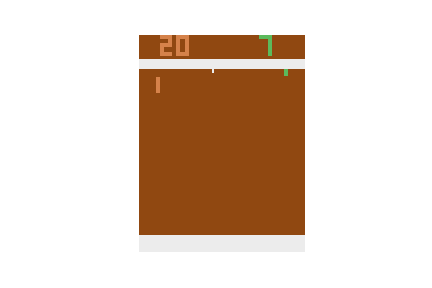
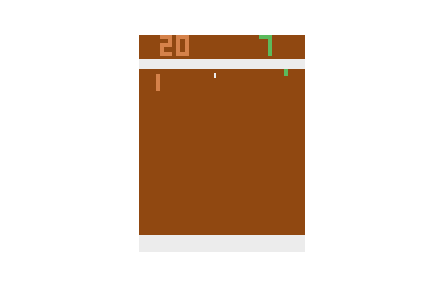
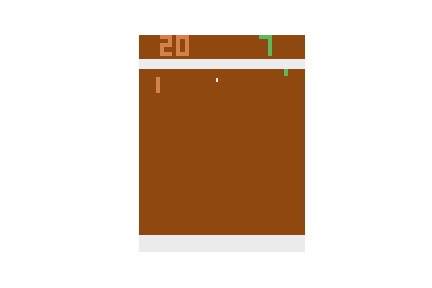
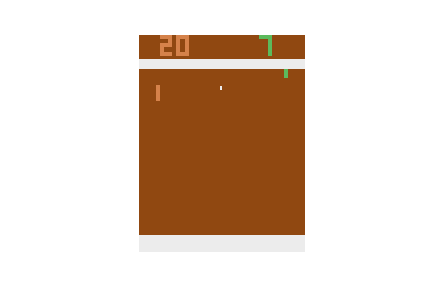
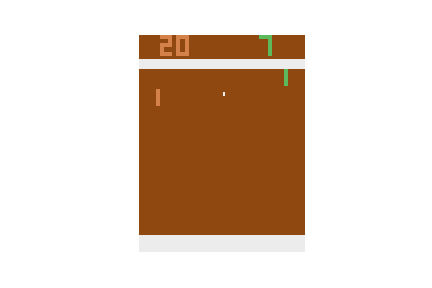
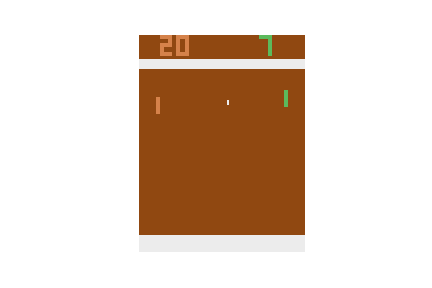
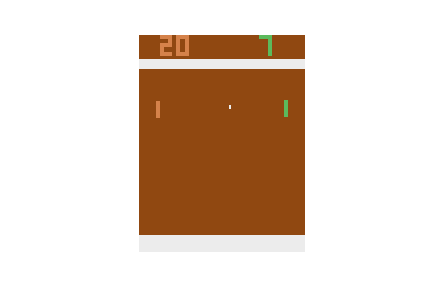
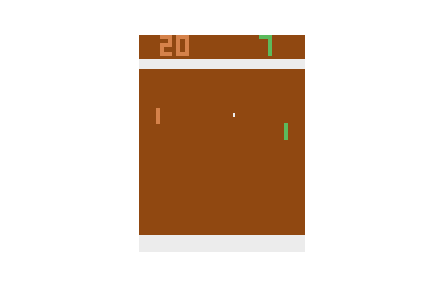
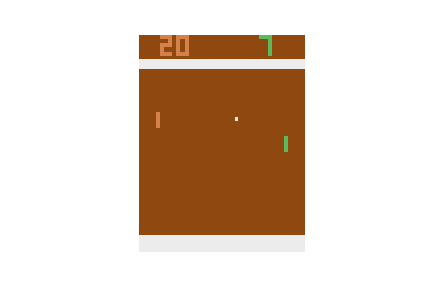
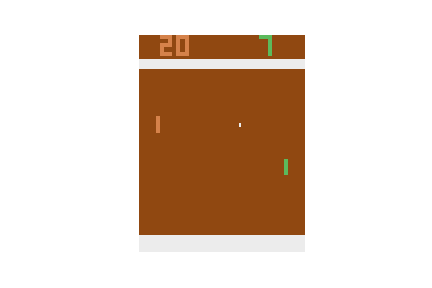
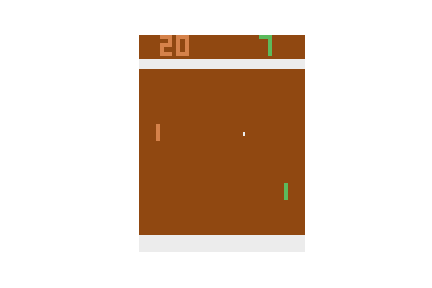
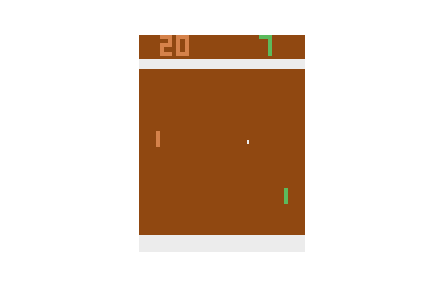
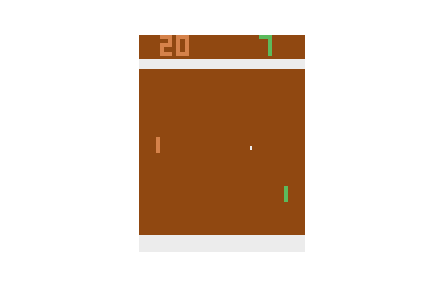
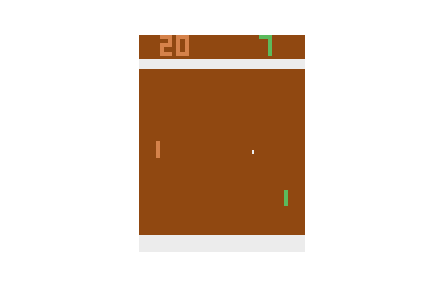
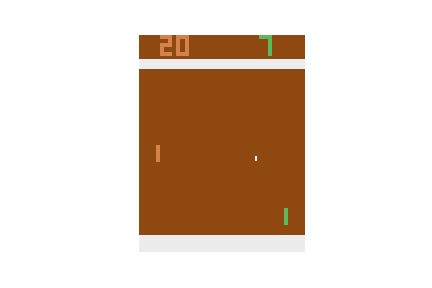
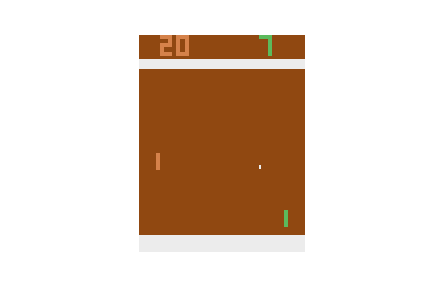
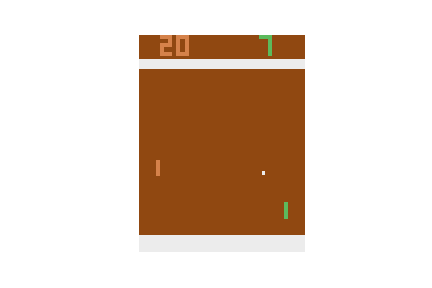
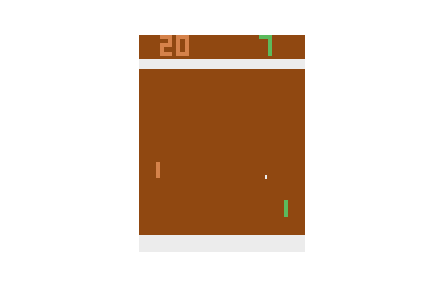
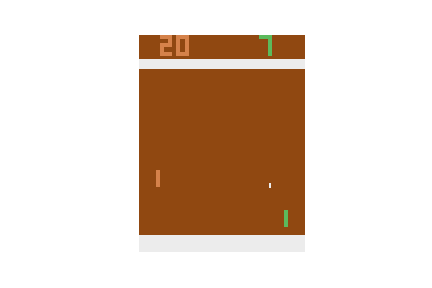
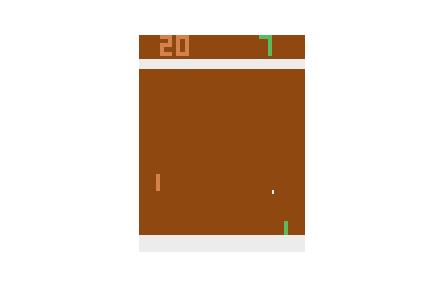
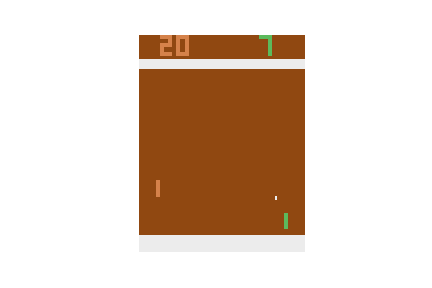
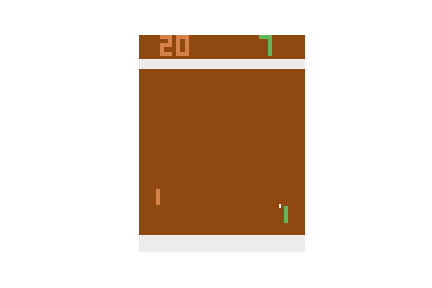
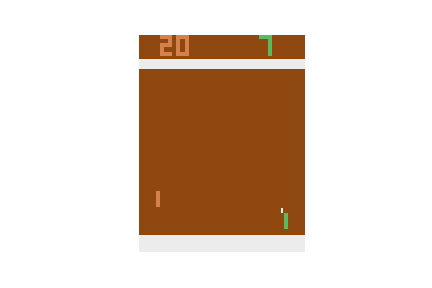
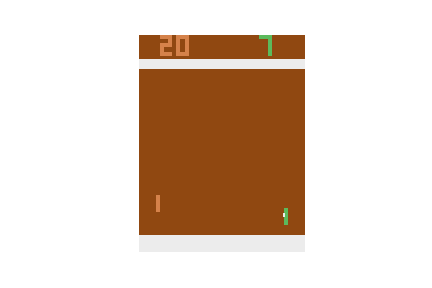
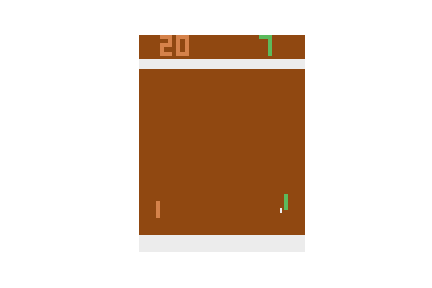
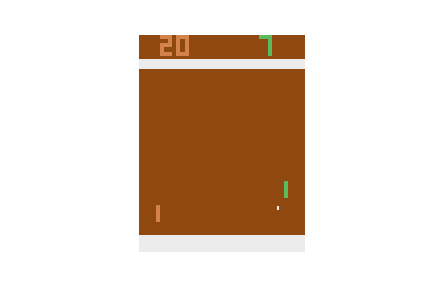
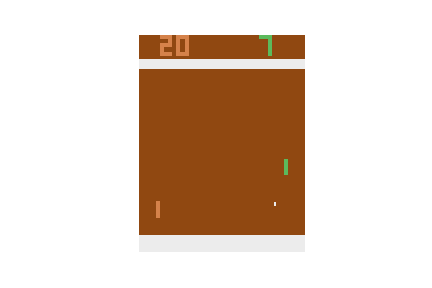
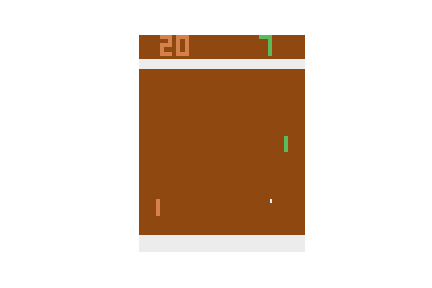
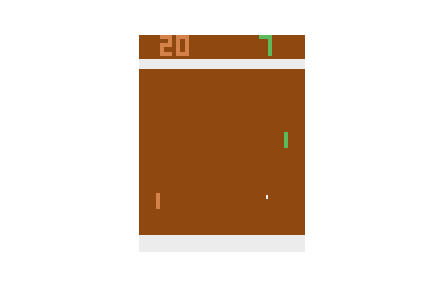
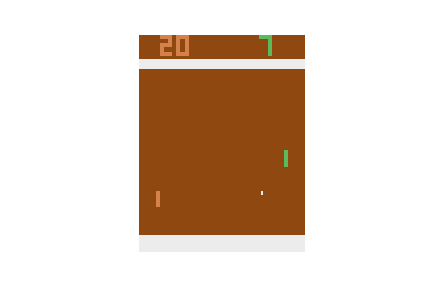
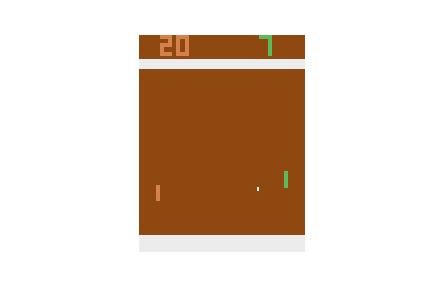
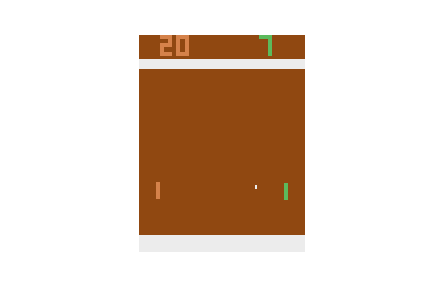
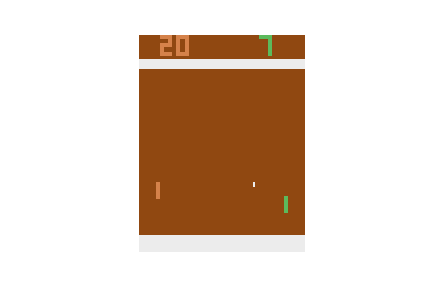
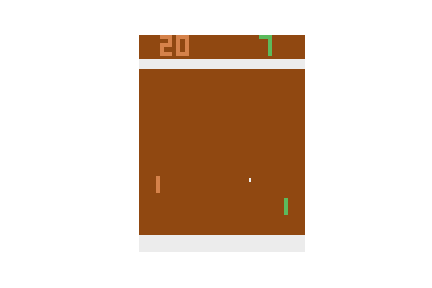
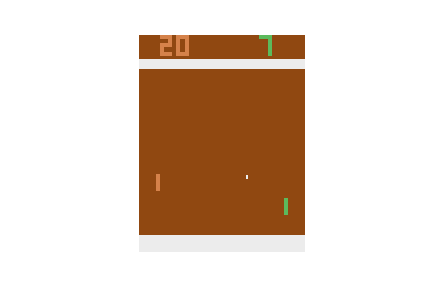
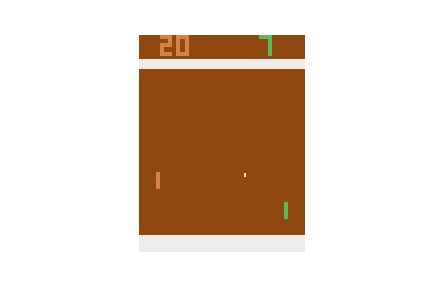
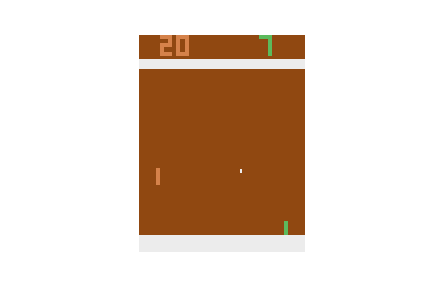
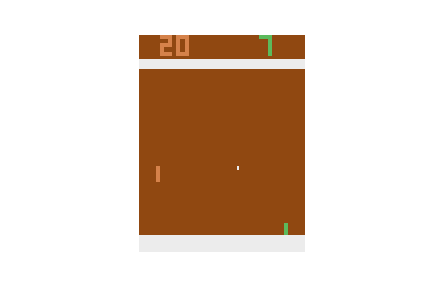
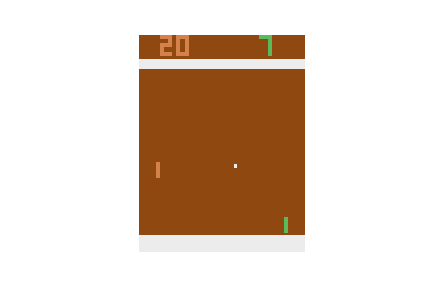
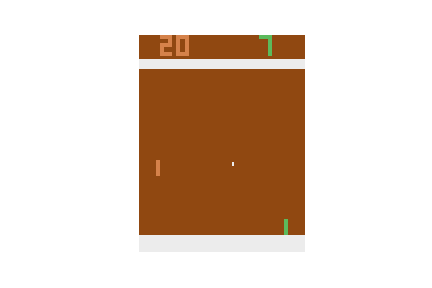
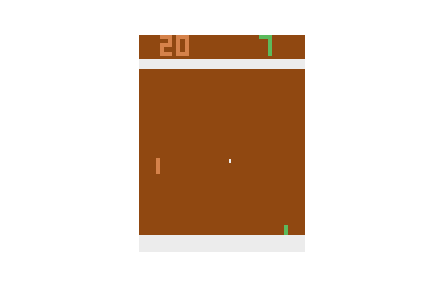
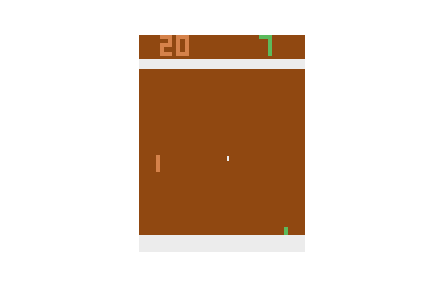
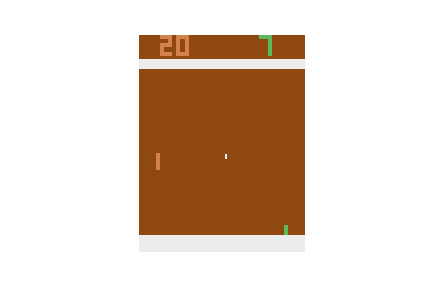
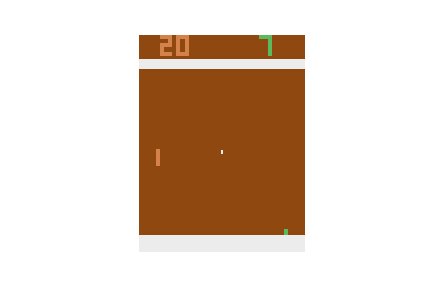
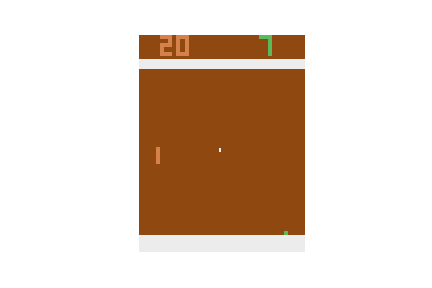
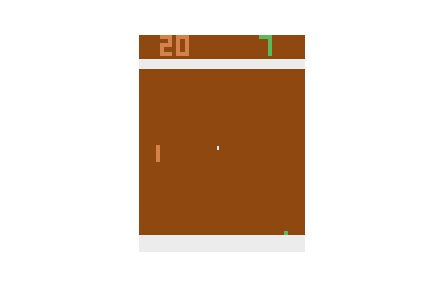
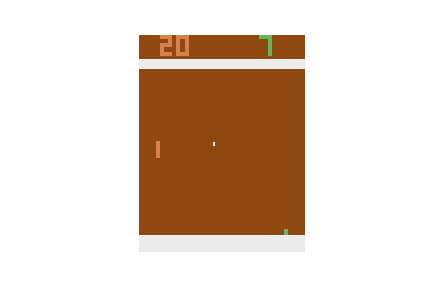
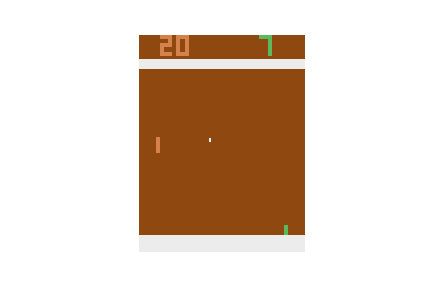
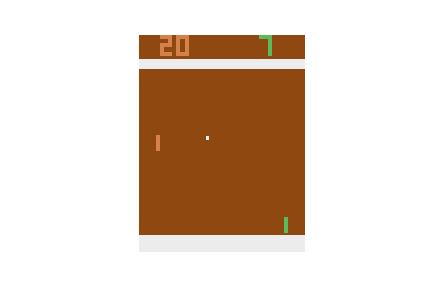
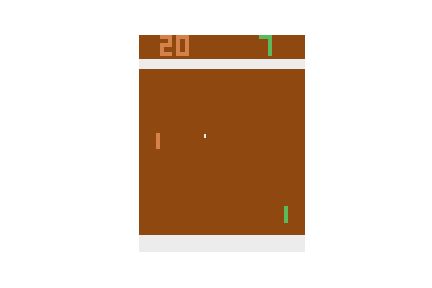
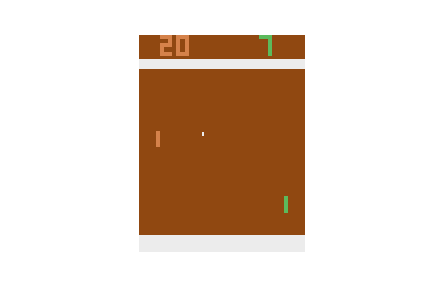
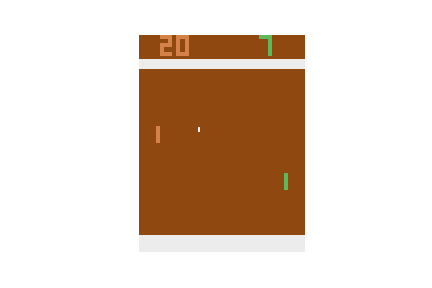
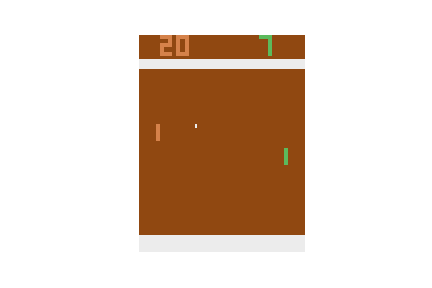
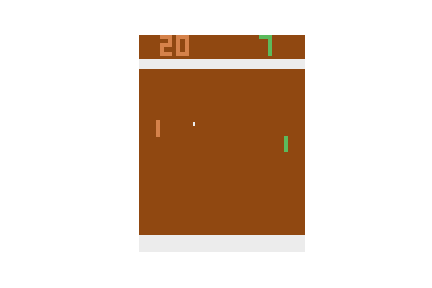
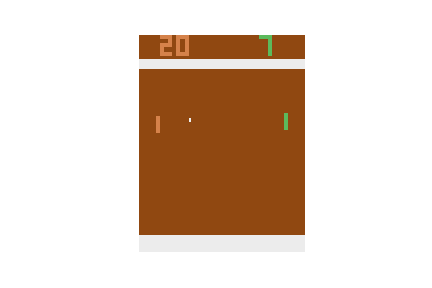
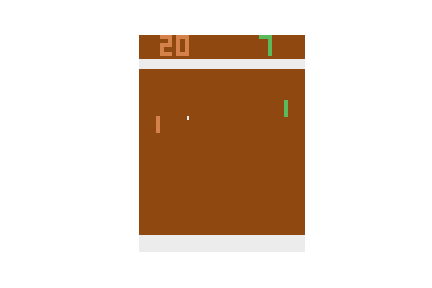
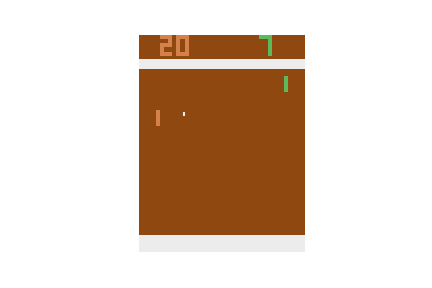
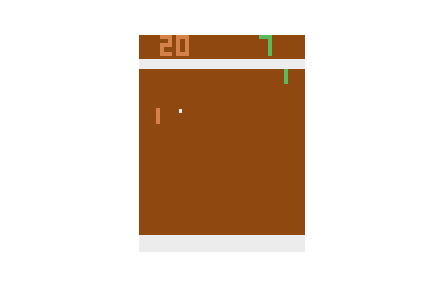
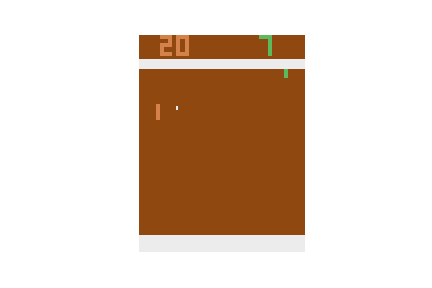
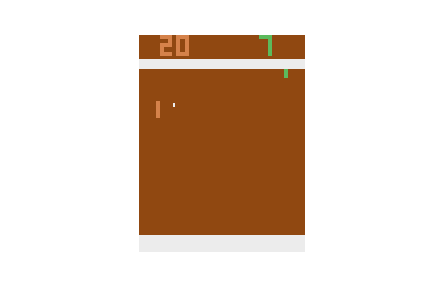
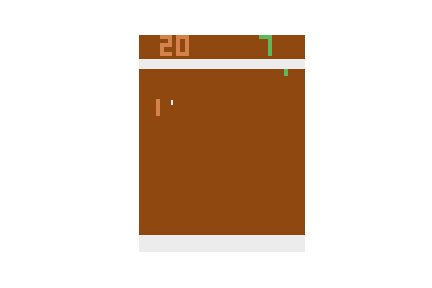
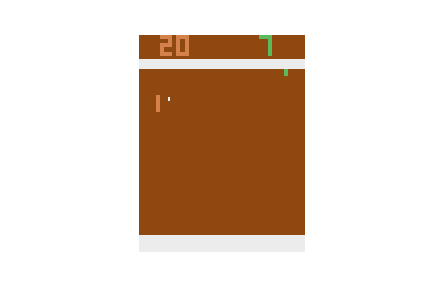
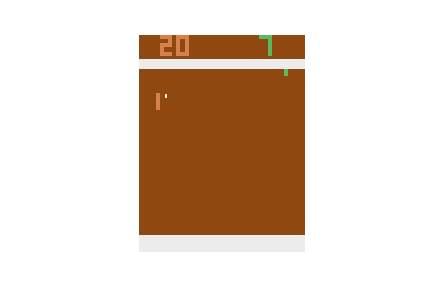
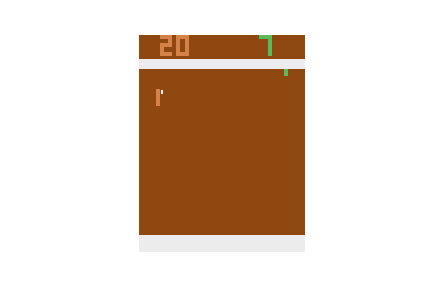
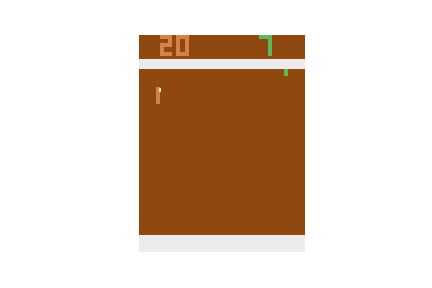
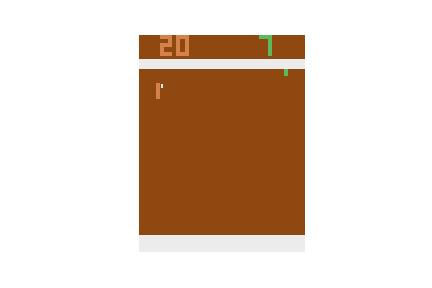
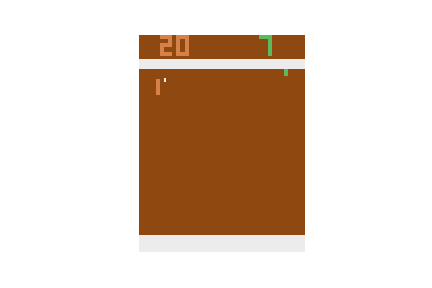
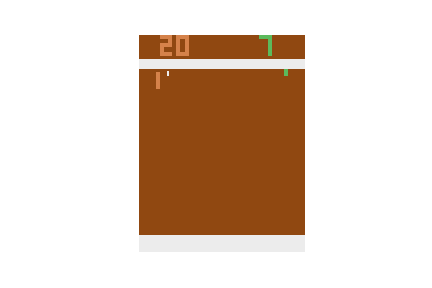
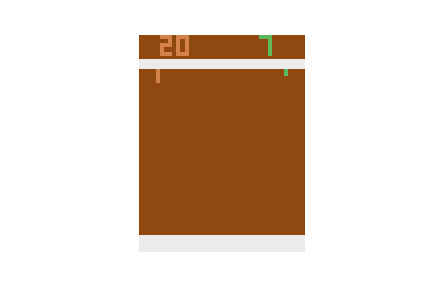
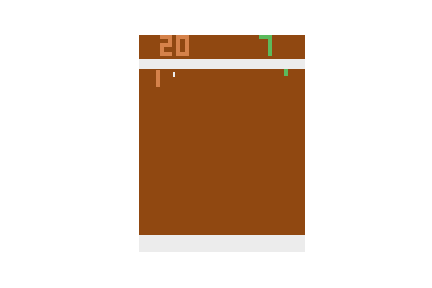
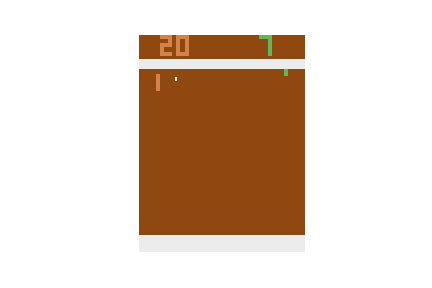
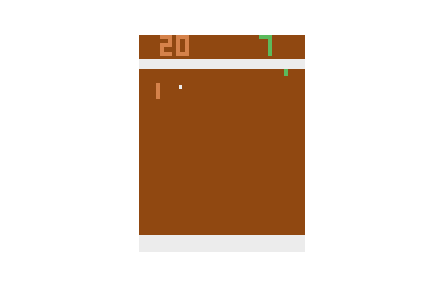
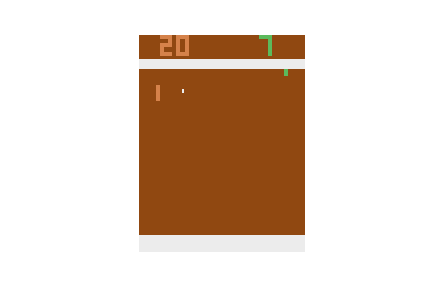
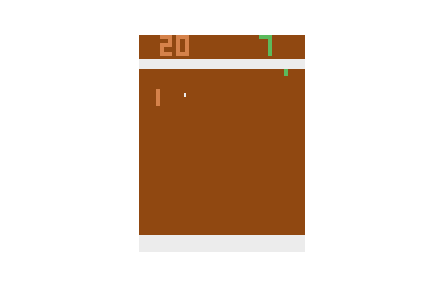
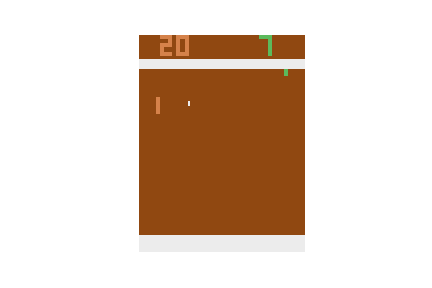
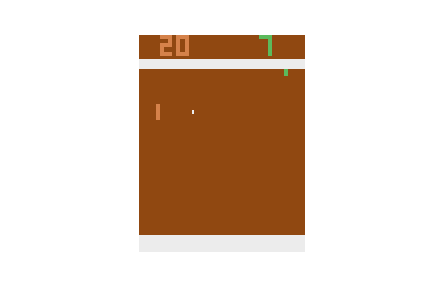
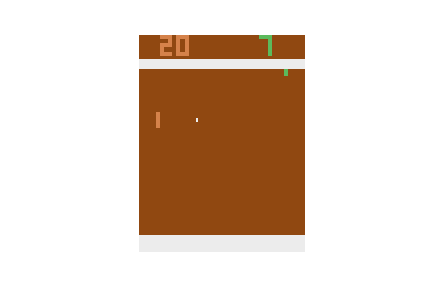
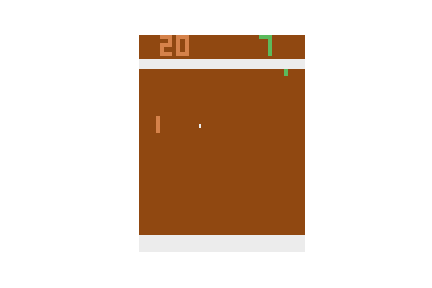
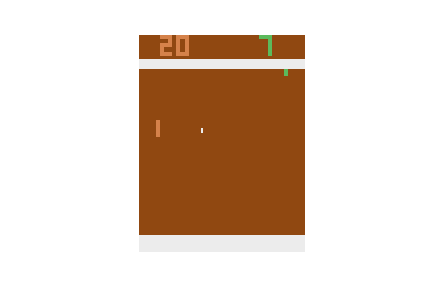
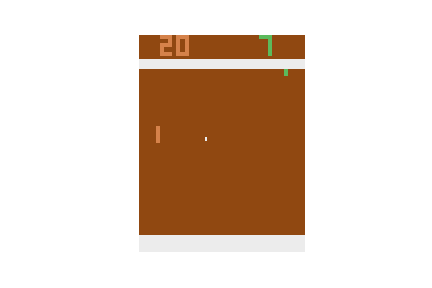
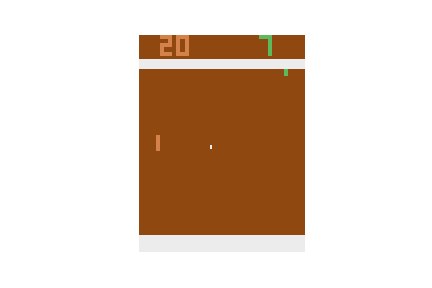
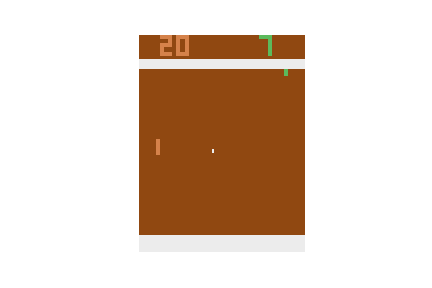
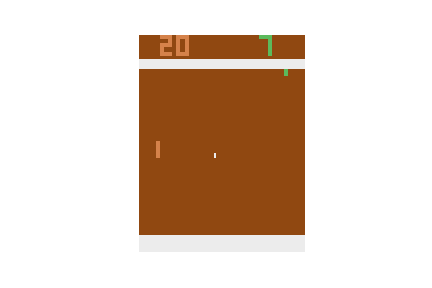
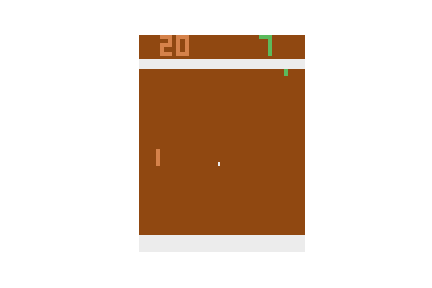
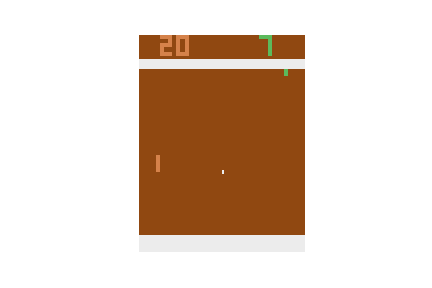
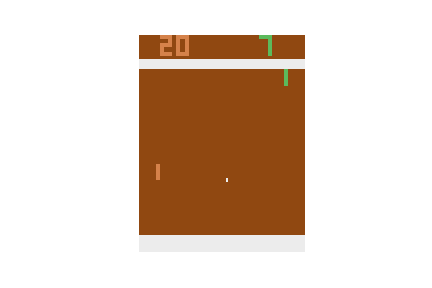
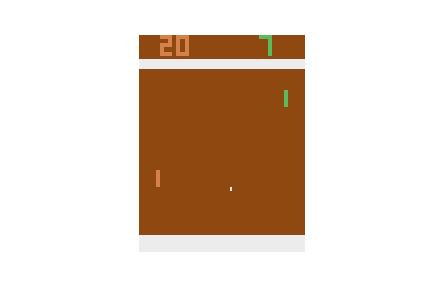
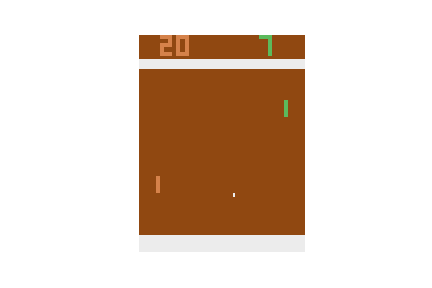
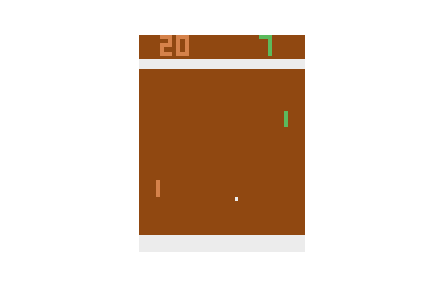
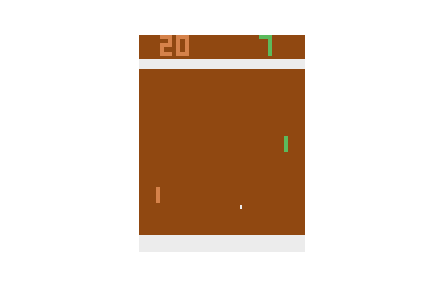
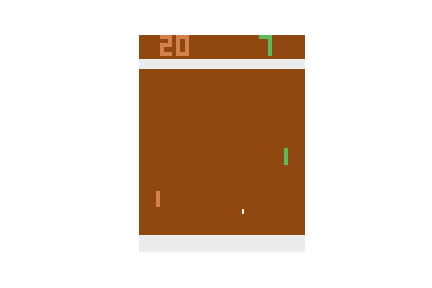
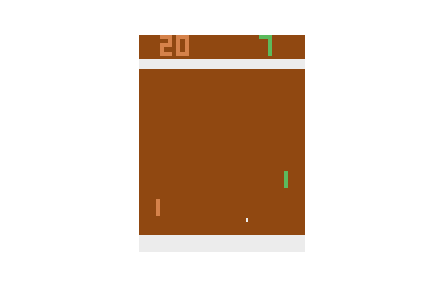
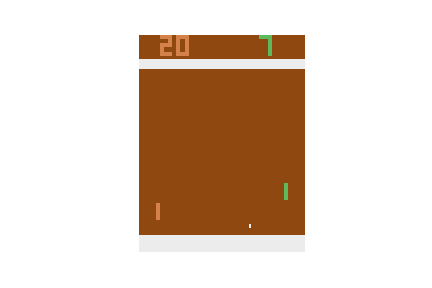
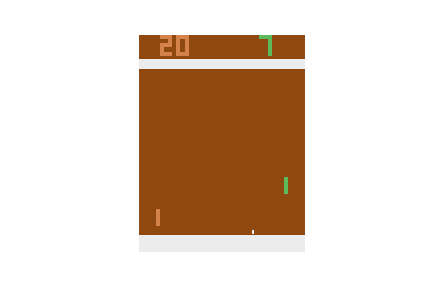
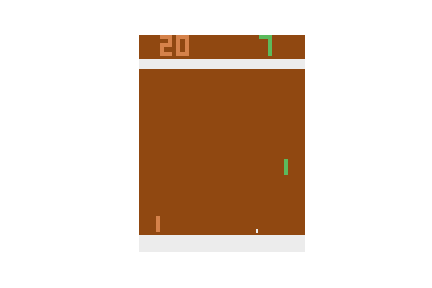
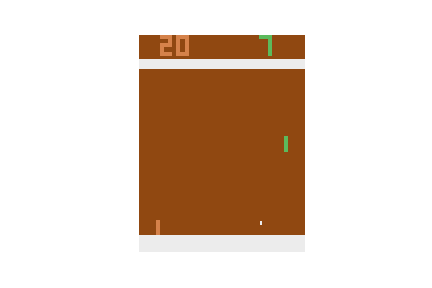
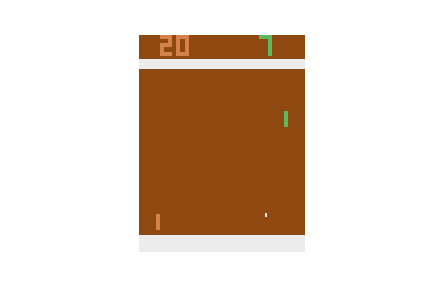
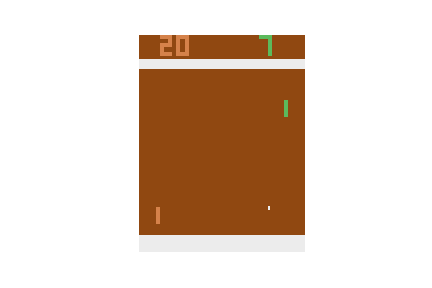
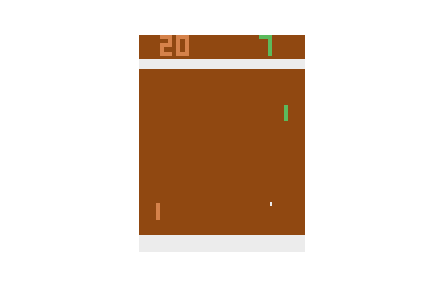
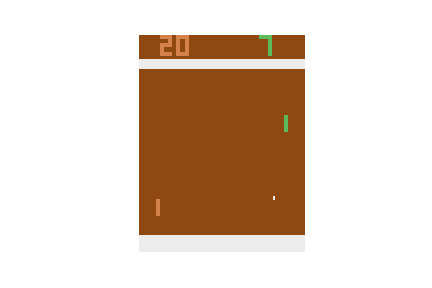
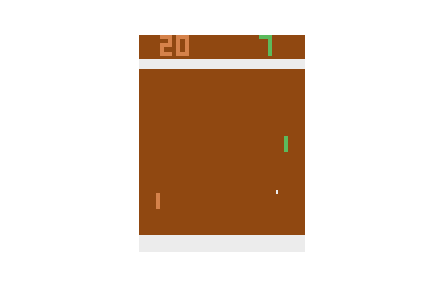
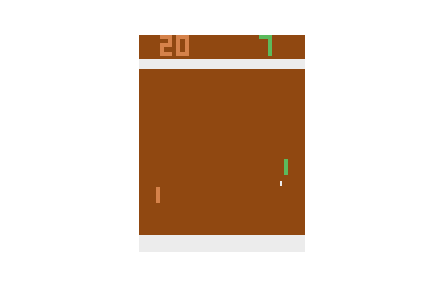
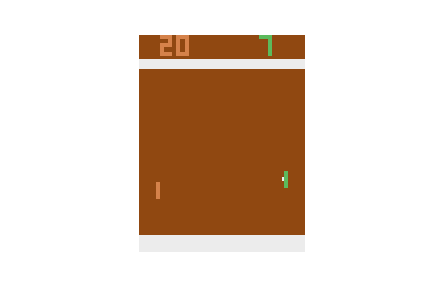
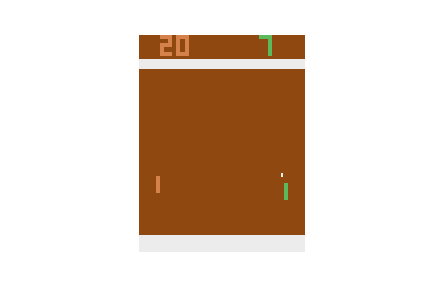
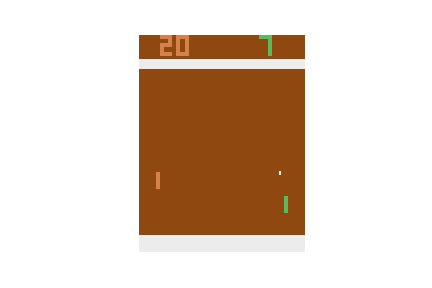
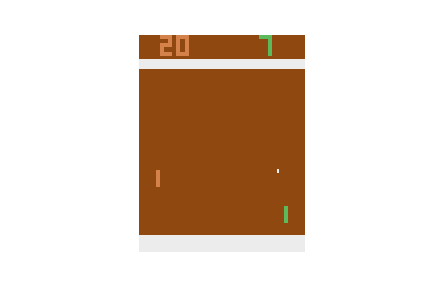
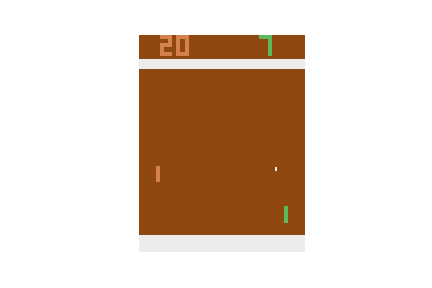
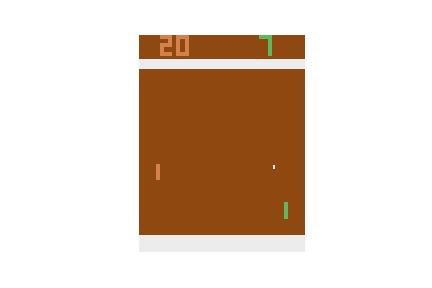
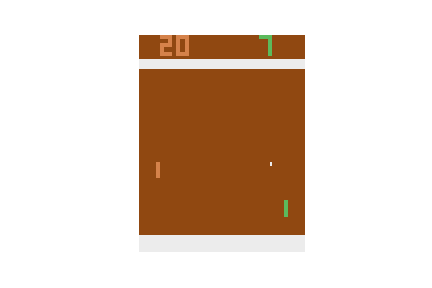
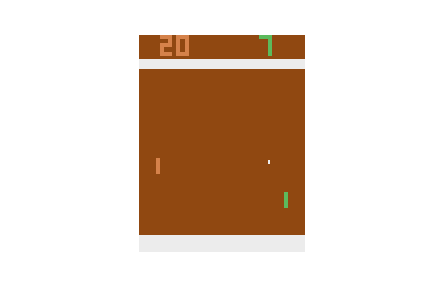
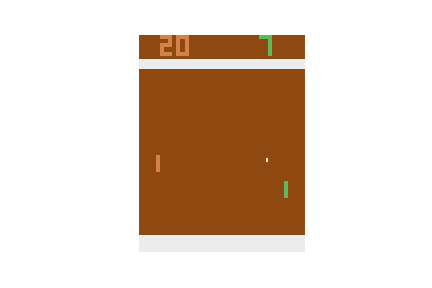
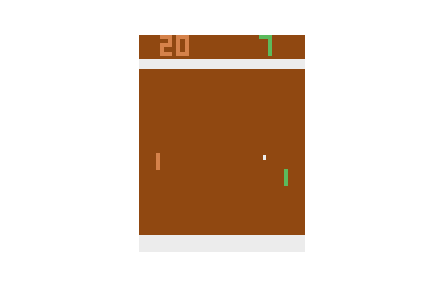
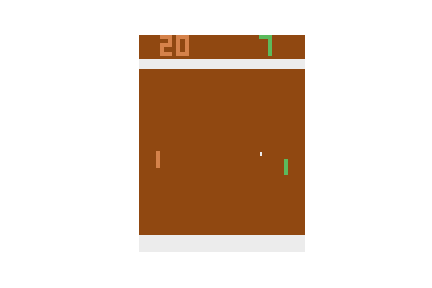
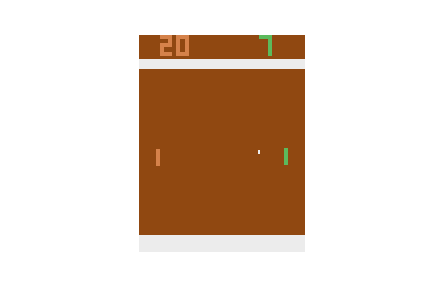
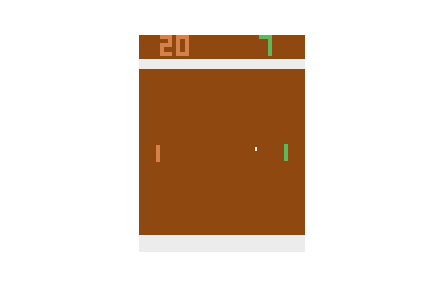
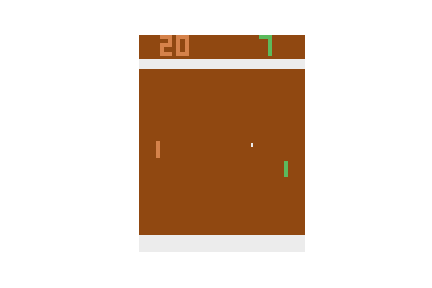
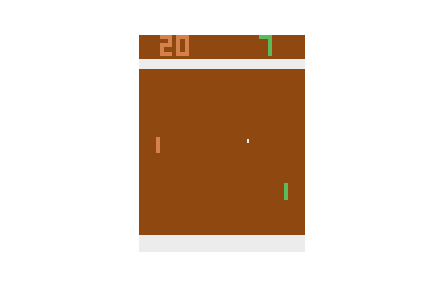
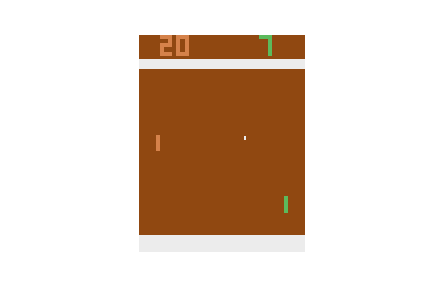
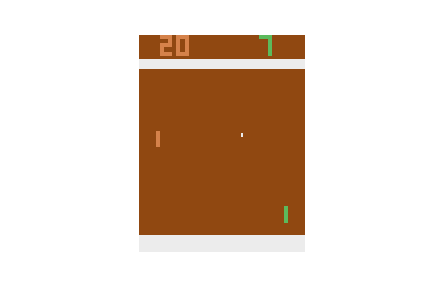
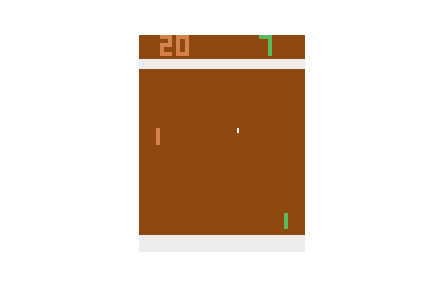
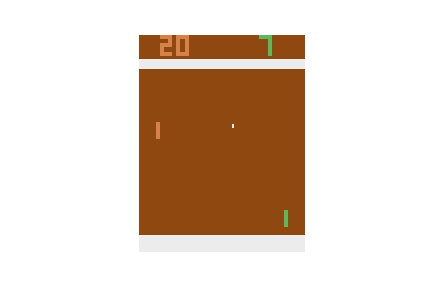
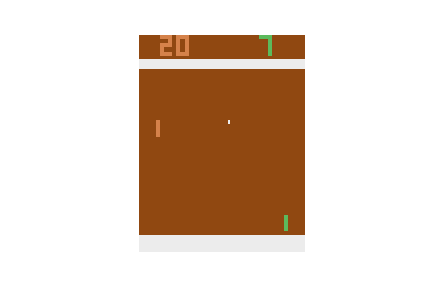
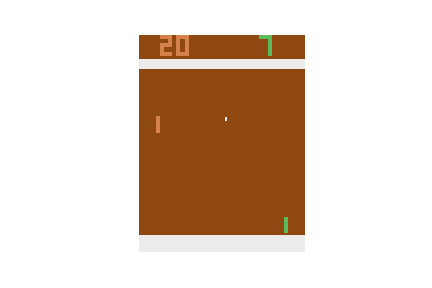
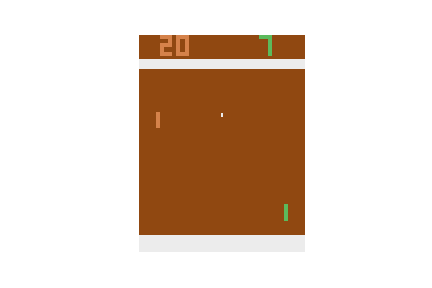
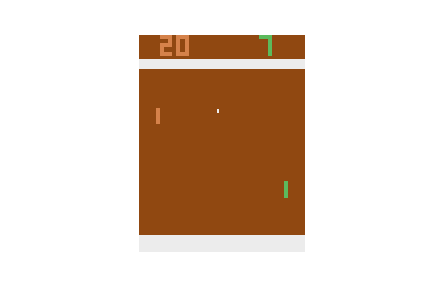
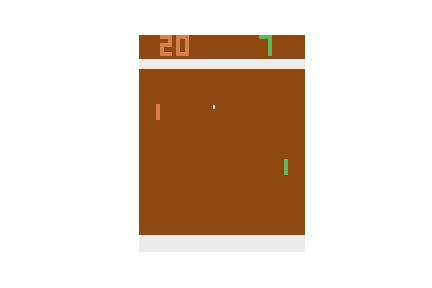
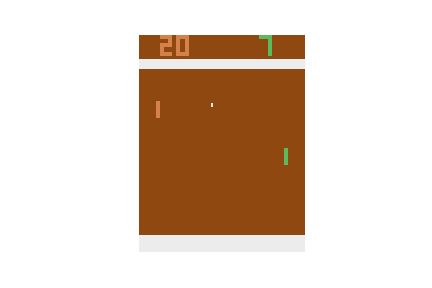
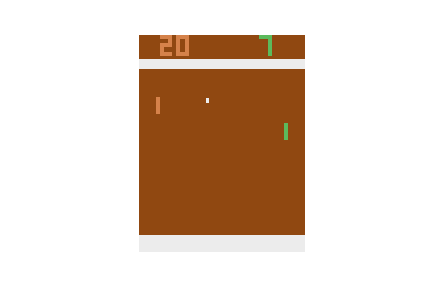
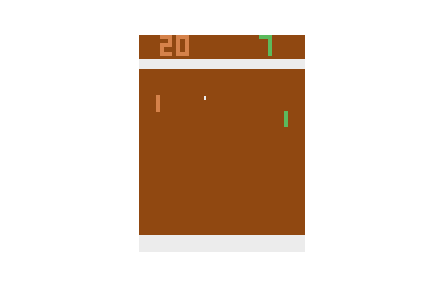
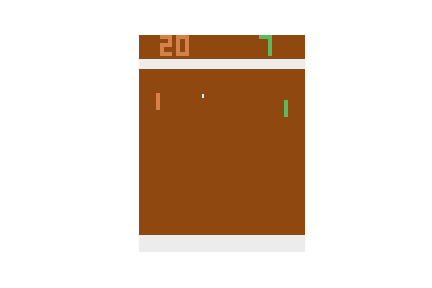
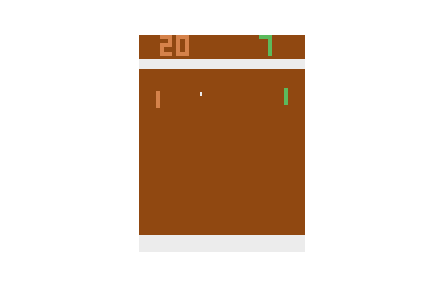
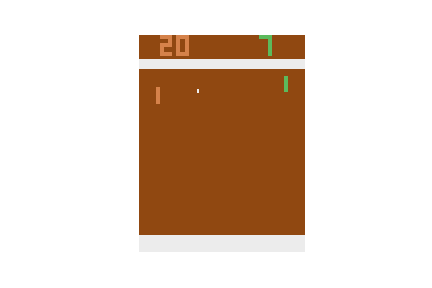
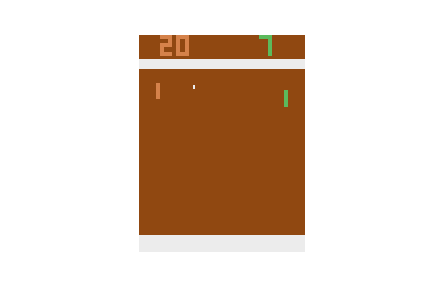
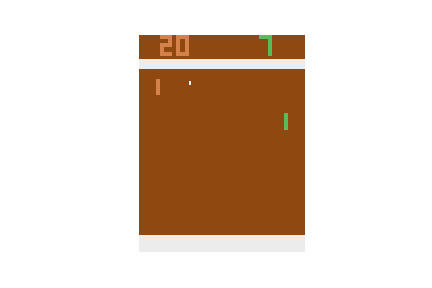
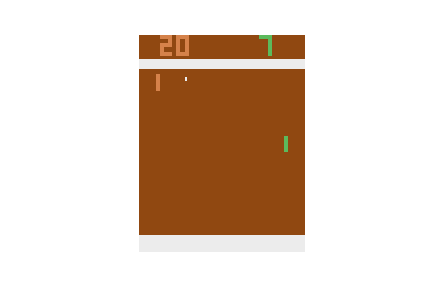
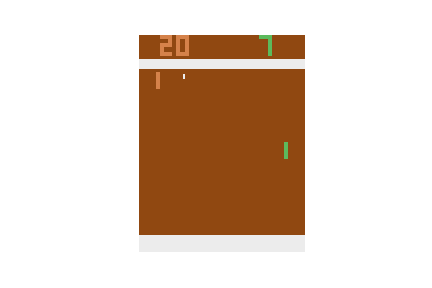
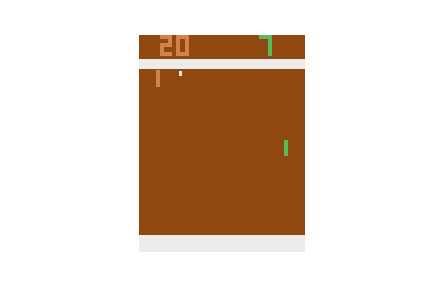
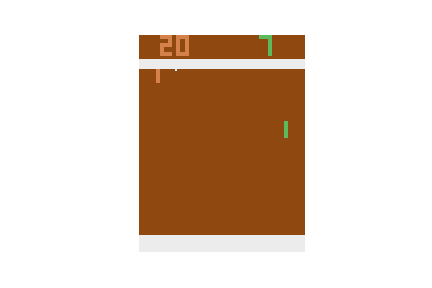
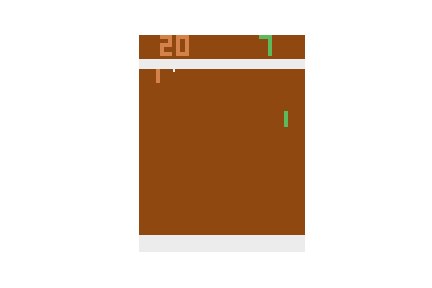
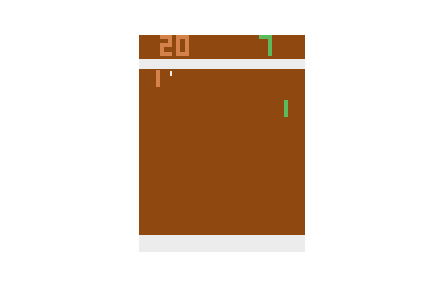
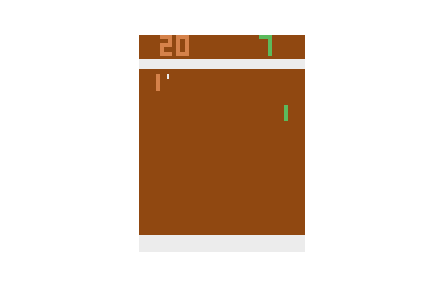
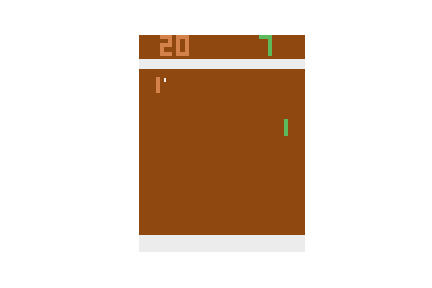
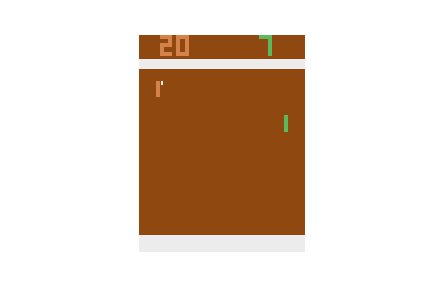
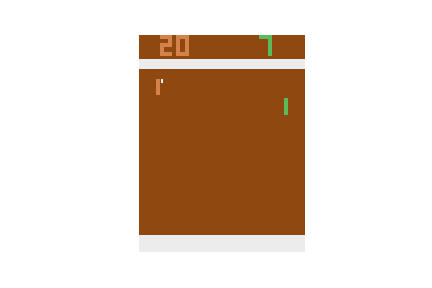
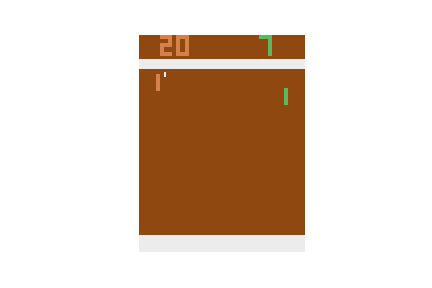
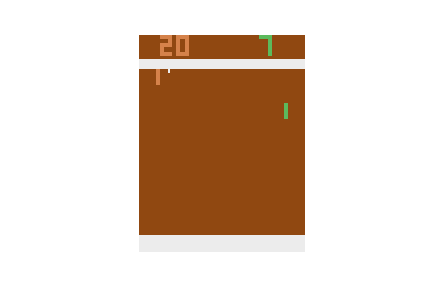
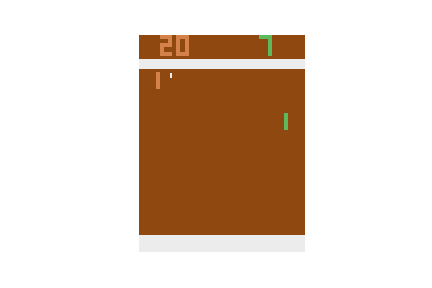
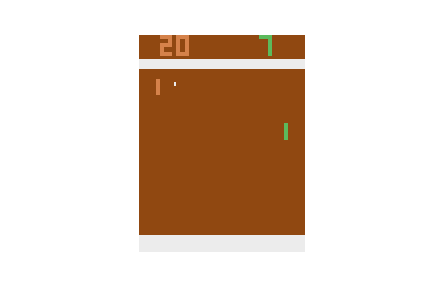
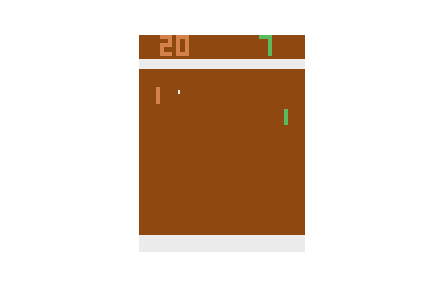
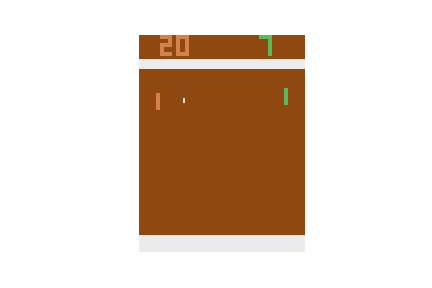
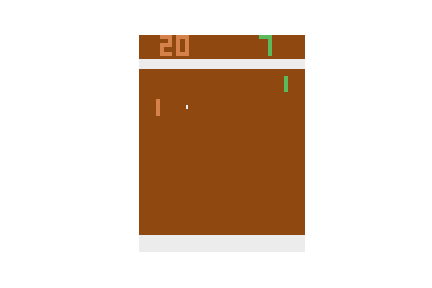
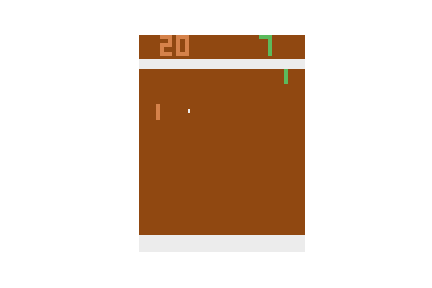
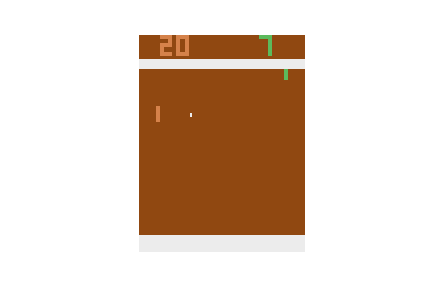
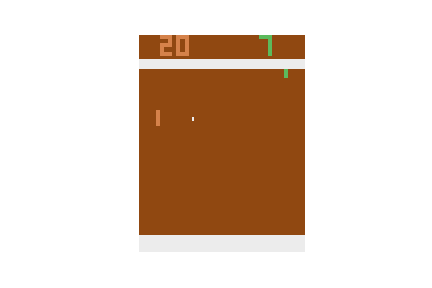
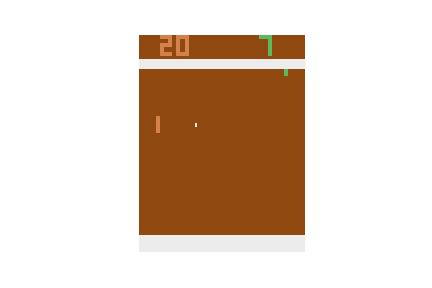
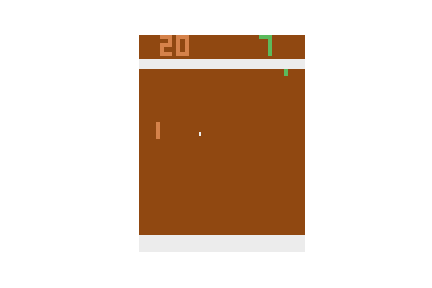
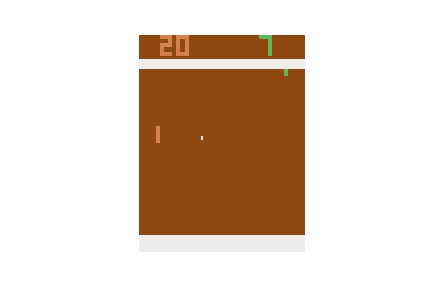
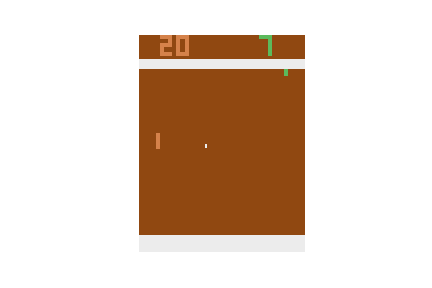
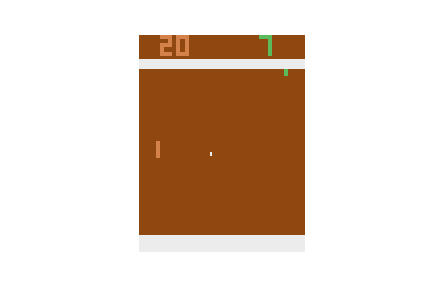
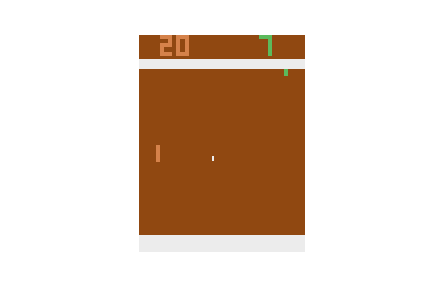
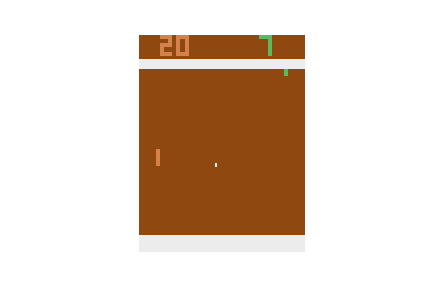
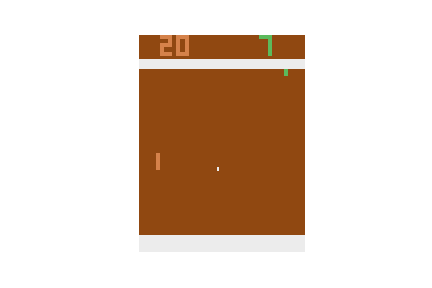
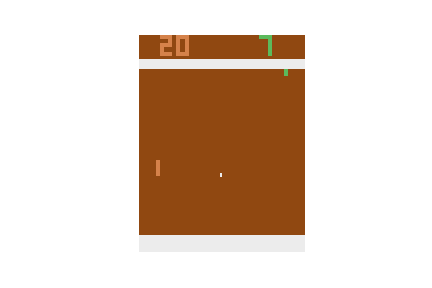
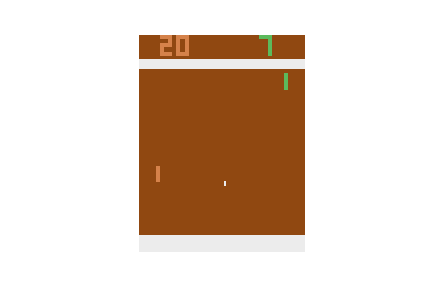
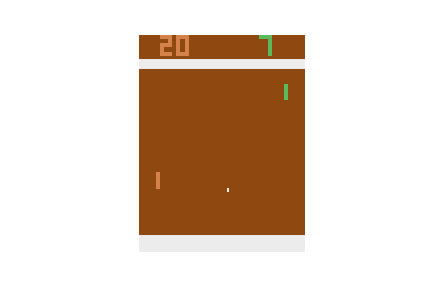
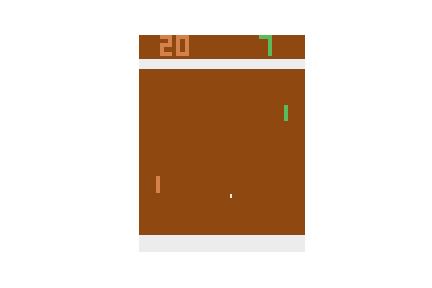
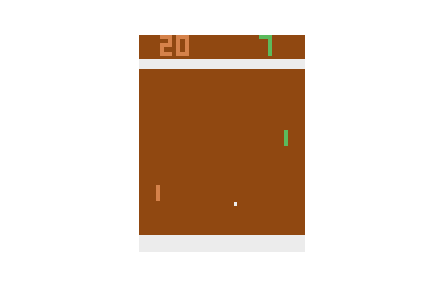
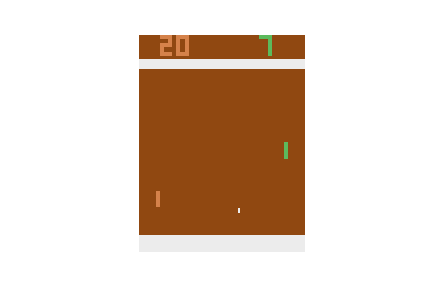
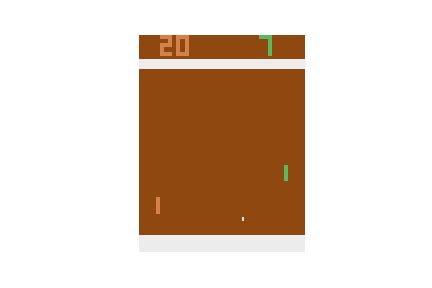
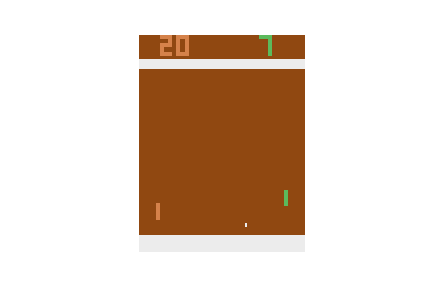
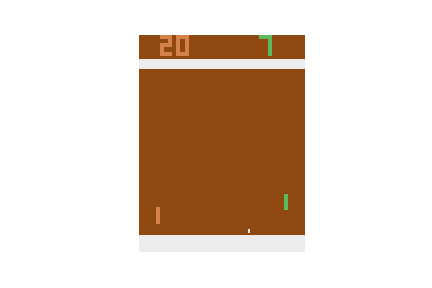
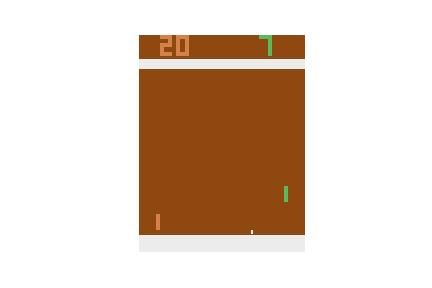
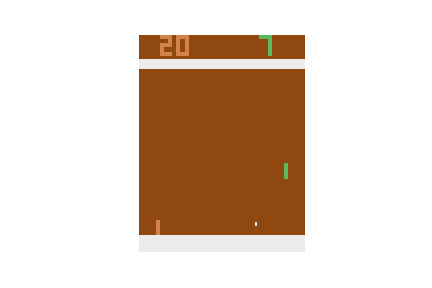
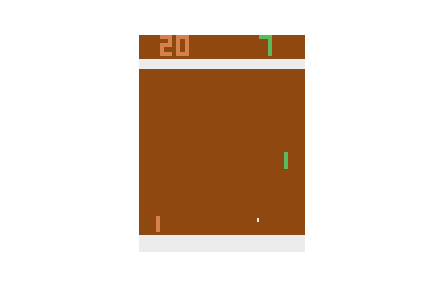
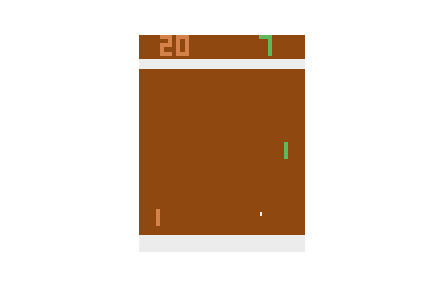
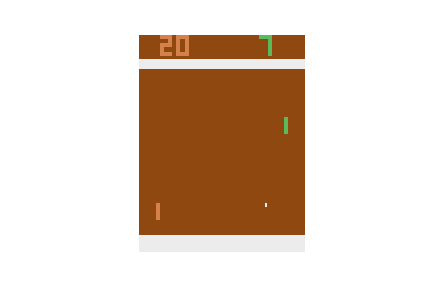
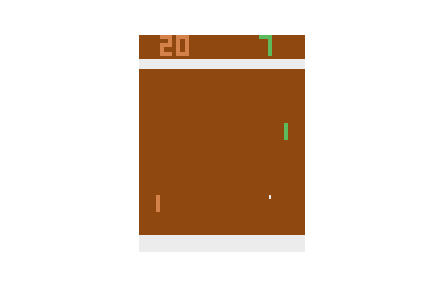
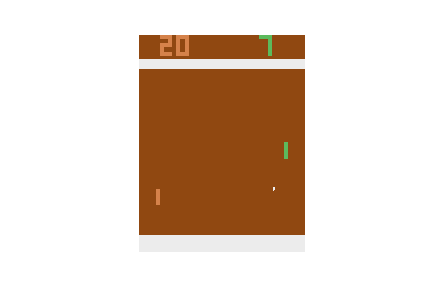
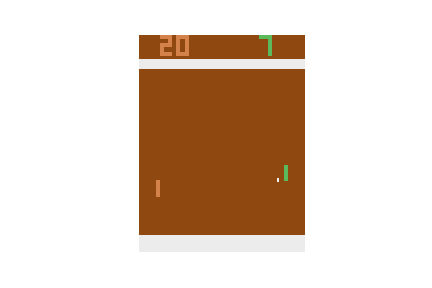
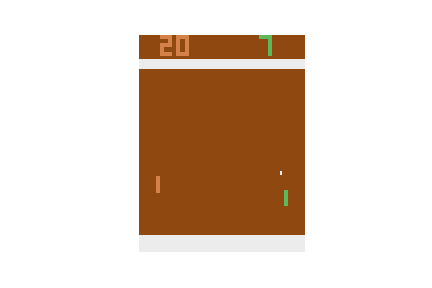
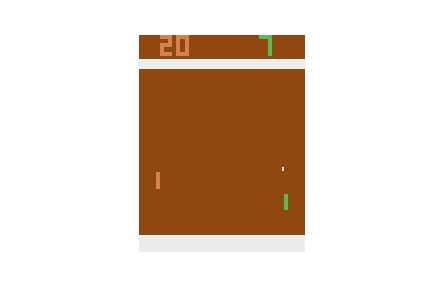
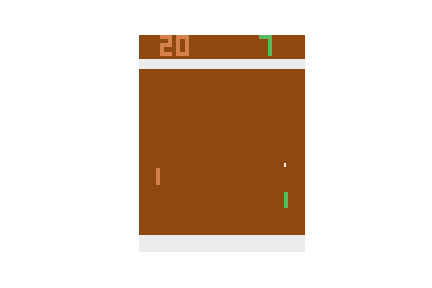
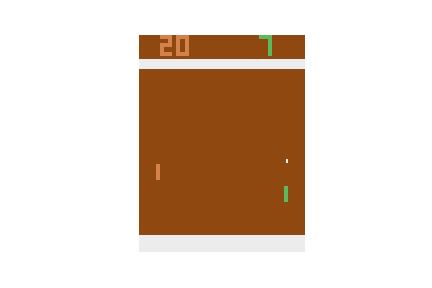
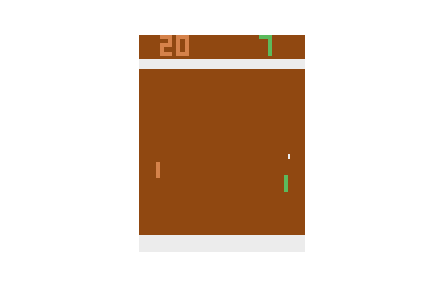
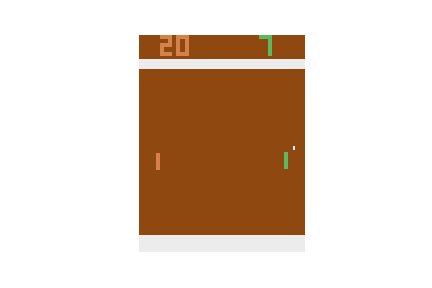
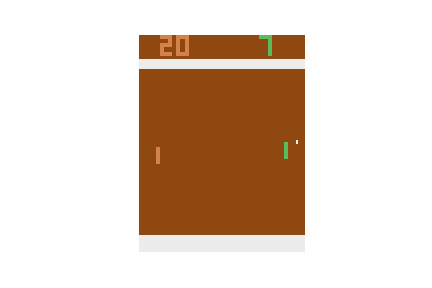
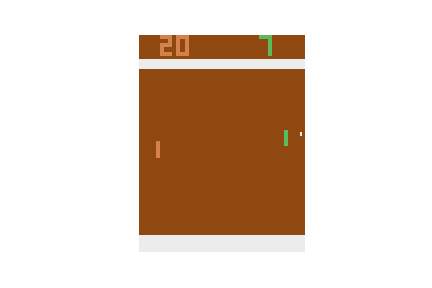

4023


In [120]:
observation = env.reset()
cum_reward = 0
frames = []
prev_frame = None
for t in range(5000):
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(3, p=p[0])
    action = action_space[a]
    
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    observation, reward, done, info = env.step(action)
    if done:
        break
        
# env.render(close=True)
display_frames_as_gif(frames)
print(t)